## Download and check rdf2vec

In [23]:
training = 1
VECTOR_SIZE=100

In [2]:
# download jrdf2vec
! wget -nc https://raw.githubusercontent.com/dwslab/jRDF2Vec/jars/jars/jrdf2vec-1.3-SNAPSHOT.jar

File ‘jrdf2vec-1.3-SNAPSHOT.jar’ already there; not retrieving.



In [3]:
# Check jrdf2vec installation. Should print "=> Everything is installed. You are good to go!" somewhere
! java -jar jrdf2vec-1.3-SNAPSHOT.jar -checkInstallation

Using server port: 1808
27 Oct 2022 19:05:34 DEBUG [main] (RequestAddCookies.java:123) - CookieSpec selected: default
27 Oct 2022 19:05:34 DEBUG [main] (RequestAuthCache.java:77) - Auth cache not set in the context
27 Oct 2022 19:05:34 DEBUG [main] (PoolingHttpClientConnectionManager.java:267) - Connection request: [route: {}->http://127.0.0.1:1808][total available: 0; route allocated: 0 of 2; total allocated: 0 of 20]
27 Oct 2022 19:05:34 DEBUG [main] (PoolingHttpClientConnectionManager.java:312) - Connection leased: [id: 0][route: {}->http://127.0.0.1:1808][total available: 0; route allocated: 1 of 2; total allocated: 1 of 20]
27 Oct 2022 19:05:34 DEBUG [main] (MainClientExec.java:234) - Opening connection {}->http://127.0.0.1:1808
27 Oct 2022 19:05:34 DEBUG [main] (DefaultHttpClientConnectionOperator.java:139) - Connecting to /127.0.0.1:1808
27 Oct 2022 19:05:34 DEBUG [main] (LoggingManagedHttpClientConnection.java:96) - http-outgoing-0: Shutdown connection
27 Oct 2022 19:05:34 DEBU

## Download Dataset


In [4]:
# download .nt dataset from my drive
! wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pBnn8bjI2VkVvBR33DnvpeyocfDhMCFA' -O fb15k-237_nt.zip

! unzip -o fb15k-237_nt.zip

Archive:  fb15k-237_nt.zip
  inflating: FB15k-237/train.nt      
  inflating: FB15k-237/test.nt       
  inflating: FB15k-237/valid.nt      


## Generate walks and train rdf2vec

In [5]:
# generate walks and train rdf2vec on train set with default parameters
if training:
    ! rm -rf walks
    ! java -jar jrdf2vec-1.3-SNAPSHOT.jar -walkDirectory walks -graph FB15k-237/train.nt -threads 10 -dimension 100

Using server port: 1808
The specified walk directory does not exist. Trying to make the directory.
Using 10 threads for walk generation and training.
Using vector dimension: 100
Using depth 4
Generating 100 walks per entity.
RDF2Vec Classic
27 Oct 2022 19:06:14  INFO [main] (WalkGeneratorManager.java:64) - Using NxParser.
27 Oct 2022 19:06:16  INFO [main] (WalkGeneratorManager.java:99) - Model read into memory.
27 Oct 2022 19:06:18  INFO [pool-1-thread-8] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 1000
27 Oct 2022 19:06:18  INFO [pool-1-thread-8] (WalkGenerationManager.java:427) - TOTAL NUMBER OF PATHS : 89615
27 Oct 2022 19:06:19  INFO [pool-1-thread-9] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 2000
27 Oct 2022 19:06:19  INFO [pool-1-thread-9] (WalkGenerationManager.java:427) - TOTAL NUMBER OF PATHS : 180670
27 Oct 2022 19:06:21  INFO [pool-1-thread-7] (WalkGenerationManager.java:426) - TOTAL PROCESSED ENTITIES: 3000
27 Oct 2022 19:06:21  INFO [poo

## Parse Graph

In [6]:

import numpy as np

def get_entities(graphs):
    # get subjects and objects
    entities = []
    
    for g in graphs:
        entities = entities + list(g.subjects(unique=True)) + list(g.objects(unique=True))

    # pythons stupid version of nub
    entities = list(dict.fromkeys(entities))
    return entities


In [7]:
from rdflib import Graph, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx

g_train = Graph()
g_val = Graph()
g_test = Graph()

g_train = g_train.parse('FB15k-237/train.nt', format='nt')
g_val   = g_val.parse('FB15k-237/valid.nt', format='nt')
g_test  = g_test.parse('FB15k-237/test.nt', format='nt')


In [8]:
def get_all_corrupted_triples_fast(triple,entities,position = 'object'):
    # not faster ...

    s,p,o = triple

    object_augmented = [(x,y,z) for  (x,y), z in itertools.product([triple[0:2]],entities)]
    subject_augmented =[(x,y,z) for  x, (y,z) in itertools.product(entities,[triple[1:3]])]
    
    return itertools.chain(object_augmented , subject_augmented)

In [9]:
import numpy as np

def get_all_corrupted_triples(triple,entities):
    #too slow ....
    
    s,p,o = triple
    subject_corrupted = [(s_corr,p,o) for s_corr in entities if s_corr != s]
    object_corrupted = [(s,p,o_corr)   for o_corr in entities if o_corr != o]

    return subject_corrupted + object_corrupted


    

def choose_many_multiple(arrs,n):
    l = len(arrs[0])
    for a in arrs:
        assert len(a) == l, 'Arres not of same length ! :('
        
    
    ix = np.random.choice(range(len(a)),n)
    
    return [np.array(a)[ix] for a in arrs]
    
def choose_many(a,n):
    ix = np.random.choice(range(len(a)),n)
    return np.array(a)[ix]
    
def choose(a):

    L = len(a)

    i = np.random.randint(0,L)

    return a[i]

def get_random_corrupted_triple(triple,entities, corrupt='object'):
    """
    corrupt = one of 'subject', 'object', 'both'
    
    return corrupted triple with random entity
    """

    s,p,o = triple
    
    # set up as the same
    s_corr = s
    o_corr = o
    
    if corrupt == 'subject':  
        # corrupt only the subject
        while s_corr == s:
            s_corr = choose(entities)  
    elif corrupt == 'object':
        # corrupt only the object
        while o_corr == o:
            o_corr = choose(entities)  
    elif corrupt == 'random':
        # corrupt one or both randomly
        ch = np.random.randint(3)
        
        if ch == 0:
            while s_corr == s:
                s_corr = choose(entities)  
        if ch == 1 :
            while o_corr == o:
                o_corr = choose(entities)  
        if ch == 2:
            while s_corr == s or o_corr == o:
                s_corr = choose(entities)  
                o_corr = choose(entities) 
    else:
        while s_corr == s or o_corr == o:
            s_corr = choose(entities)  
            o_corr = choose(entities) 
            
    
    return (s_corr,p,o_corr)
    

    

## Plot Graph (not working)

In [10]:
# taken from https://stackoverflow.com/questions/39274216/visualize-an-rdflib-graph-in-python
# takes way too long ... use subgraph?!
import matplotlib.pyplot as plt
plot = False
if plot:
    G = rdflib_to_networkx_multidigraph(g_train[0:100])


    pos = nx.spring_layout(G, scale=2)
    edge_labels = nx.get_edge_attributes(G, 'r')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw(G, with_labels=True)

    #if not in interactive mode for 
    plt.show()
    

## Get rdf2vec embeddings for entities

In [11]:
def merge_historires(history_list):
    h = {}
    for key in history_list[0].history.keys():
        h[key] = [h.history[key][0] for h in histories]
    return h    


def clean_graph(graph,wv):
    """
    clean graph such that all triples have word vectors present in wv
    
    """
    no_removed = 0 
    for t in graph:
        s,p,o = t
        if not str(s) in wv.key_to_index.keys() or not str(p) in wv.key_to_index.keys() or not str(o) in wv.key_to_index.keys():
            graph.remove(t)
            no_removed+=1
    return no_removed

In [12]:
from gensim.models import Word2Vec


word_vectors = Word2Vec.load('walks/model').wv

In [13]:
# clean graphs 
# number of triples removed should be low, a few hundred
print(f"removed {clean_graph(g_train,word_vectors)} triples from training set")
print(f"removed {clean_graph(g_val,word_vectors)} triples from validation set")
print(f"removed {clean_graph(g_test,word_vectors)} triples from test set")

entities = get_entities((g_train,g_val,g_test))

removed 259 triples from training set
removed 37 triples from validation set
removed 59 triples from test set


In [25]:
def get_vectors_fast(triples,entity_vec_mapping,vector_size=VECTOR_SIZE):
    # ~20-30% faster
    X = np.array(triples)
    X = word_vectors[X.flatten()].reshape(len(triples),vector_size*3)
    
    return X

In [26]:
def get_vectors(triples,entity_vec_mapping,vector_size=200):
    X = np.array(triples)
    X = [(entity_vec_mapping(x[0]), entity_vec_mapping(x[1]),entity_vec_mapping(x[2])) for x in X]
    X = [np.concatenate(x) for x in X]
    X = np.vstack(X).astype(np.float64)
    
    return X

def get_1_1_dataset(graph, entities,entity_vec_mapping,corrupt='random'):
    
    original_triple_len = len(graph)
    # get triples
    X = list(graph)
    no_t = len(X)
    

    
    corrupted_triples = [get_random_corrupted_triple(x,entities,corrupt=corrupt) for x in X]
    X = X + corrupted_triples
    
    

    # convert uris to strings
    
    X = get_vectors_fast(X,entity_vec_mapping)
    
    # stack them
   
    Y = np.concatenate((np.ones(no_t),np.zeros(no_t))).astype(np.uint8)
    
    return X, Y

In [27]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x])
x_val , y_val= get_1_1_dataset(g_val,entities,lambda x : word_vectors[x])
x_test , y_test= get_1_1_dataset(g_test,entities,lambda x : word_vectors[x])

print(f"training datapoints = {len(X)}")
print(f"validation datapoints = {len(x_val)}")
print(f"test datapoints = {len(x_test)}")

training datapoints = 543712
validation datapoints = 34996
test datapoints = 40814


In [28]:
# test some simple baselines\
import sklearn.linear_model
import sklearn.ensemble
from sklearn import preprocessing

def test_sklearn_model(model,X,Y,x_test,y_test,subset=10000):
    

  
    
    ix = np.random.choice(range(len(X)),size=subset)
    
    scaler = preprocessing.StandardScaler().fit(X)
    
    X_scaled = scaler.transform(X[ix])
    model.fit(X_scaled,Y[ix])

    print(f'train_score ={model.score(scaler.transform(X),Y)}')    
    print(f'test_score ={model.score(scaler.transform(x_test),y_test)}')

def scale_and_predict(model,x):
    x = preprocessing.StandardScaler().fit_transform(x)
    return model.predict(x)

In [29]:
# 0.6 is pretty bad
LR = sklearn.linear_model.LogisticRegression(max_iter=1000)
test_sklearn_model(LR,X,Y,x_test,y_test,10000)


train_score =0.6418765817197339
test_score =0.6433331699906895


In [30]:
# this works pretty well out of the box
randomforest = sklearn.ensemble.RandomForestClassifier()
test_sklearn_model(randomforest,X,Y,x_test,y_test,10000)

train_score =0.8299246659996469
test_score =0.809673151369628


In [32]:
import tensorflow as tf
#### Neural Network with a single hidden layer
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tqdm import tqdm, trange


model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dropout(.3))
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))



model.compile(optimizer=keras.optimizers.Adam(),  # Optimizer
            # Loss function to minimize
            loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=True,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="binary_crossentropy",
)
,
            # List of metrics to monitor
            metrics=['accuracy'])

histories = []

for epochs in trange(50):
    X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x])
    histories.append(model.fit(X, Y, batch_size=3000, epochs=1, validation_data=(x_val,y_val),))

h = merge_historires(histories)


  0%|                                                                                                                                                                                                                                                | 0/50 [00:00<?, ?it/s]

182/182 [==============================] - 1s 6ms/step - loss: 0.5207 - accuracy: 0.7078 - val_loss: 0.3653 - val_accuracy: 0.8482


  2%|████▋                                                                                                                                                                                                                                   | 1/50 [00:10<08:25, 10.32s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.3265 - accuracy: 0.8551 - val_loss: 0.2792 - val_accuracy: 0.8893


  4%|█████████▎                                                                                                                                                                                                                              | 2/50 [00:20<08:03, 10.07s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2698 - accuracy: 0.8856 - val_loss: 0.2515 - val_accuracy: 0.9076


  6%|█████████████▉                                                                                                                                                                                                                          | 3/50 [00:30<07:53, 10.08s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2465 - accuracy: 0.8970 - val_loss: 0.2353 - val_accuracy: 0.9140


  8%|██████████████████▌                                                                                                                                                                                                                     | 4/50 [00:39<07:28,  9.74s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2340 - accuracy: 0.9028 - val_loss: 0.2233 - val_accuracy: 0.9180


 10%|███████████████████████▏                                                                                                                                                                                                                | 5/50 [00:49<07:18,  9.75s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2269 - accuracy: 0.9060 - val_loss: 0.2190 - val_accuracy: 0.9207


 12%|███████████████████████████▊                                                                                                                                                                                                            | 6/50 [00:58<07:08,  9.73s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2209 - accuracy: 0.9089 - val_loss: 0.2241 - val_accuracy: 0.9229


 14%|████████████████████████████████▍                                                                                                                                                                                                       | 7/50 [01:08<07:00,  9.77s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2176 - accuracy: 0.9111 - val_loss: 0.2103 - val_accuracy: 0.9227


 16%|█████████████████████████████████████                                                                                                                                                                                                   | 8/50 [01:18<06:43,  9.60s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2129 - accuracy: 0.9129 - val_loss: 0.2131 - val_accuracy: 0.9256


 18%|█████████████████████████████████████████▊                                                                                                                                                                                              | 9/50 [01:27<06:35,  9.65s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2107 - accuracy: 0.9141 - val_loss: 0.2052 - val_accuracy: 0.9256


 20%|██████████████████████████████████████████████▏                                                                                                                                                                                        | 10/50 [01:37<06:29,  9.74s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2088 - accuracy: 0.9146 - val_loss: 0.2074 - val_accuracy: 0.9263


 22%|██████████████████████████████████████████████████▊                                                                                                                                                                                    | 11/50 [01:47<06:20,  9.74s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2069 - accuracy: 0.9157 - val_loss: 0.2035 - val_accuracy: 0.9263


 24%|███████████████████████████████████████████████████████▍                                                                                                                                                                               | 12/50 [01:56<06:03,  9.58s/it]

182/182 [==============================] - 1s 6ms/step - loss: 0.2036 - accuracy: 0.9172 - val_loss: 0.2076 - val_accuracy: 0.9271


 26%|████████████████████████████████████████████████████████████                                                                                                                                                                           | 13/50 [02:06<05:56,  9.64s/it]

182/182 [==============================] - 1s 6ms/step - loss: 0.2031 - accuracy: 0.9175 - val_loss: 0.2018 - val_accuracy: 0.9285


 28%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 14/50 [02:16<05:48,  9.67s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2025 - accuracy: 0.9178 - val_loss: 0.2021 - val_accuracy: 0.9290


 30%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 15/50 [02:25<05:33,  9.54s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.2010 - accuracy: 0.9184 - val_loss: 0.2011 - val_accuracy: 0.9289


 32%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 16/50 [02:35<05:26,  9.59s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1995 - accuracy: 0.9194 - val_loss: 0.2038 - val_accuracy: 0.9304


 34%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 17/50 [02:45<05:19,  9.69s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1991 - accuracy: 0.9193 - val_loss: 0.1975 - val_accuracy: 0.9296


 36%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 18/50 [02:54<05:10,  9.70s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1983 - accuracy: 0.9198 - val_loss: 0.1980 - val_accuracy: 0.9301


 38%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 19/50 [03:04<05:00,  9.71s/it]

182/182 [==============================] - 1s 6ms/step - loss: 0.1969 - accuracy: 0.9205 - val_loss: 0.1961 - val_accuracy: 0.9298


 40%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 20/50 [03:13<04:46,  9.56s/it]

182/182 [==============================] - 1s 6ms/step - loss: 0.1955 - accuracy: 0.9209 - val_loss: 0.1979 - val_accuracy: 0.9303


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 21/50 [03:23<04:39,  9.64s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1961 - accuracy: 0.9210 - val_loss: 0.1940 - val_accuracy: 0.9316


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 22/50 [03:33<04:31,  9.69s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1965 - accuracy: 0.9206 - val_loss: 0.1956 - val_accuracy: 0.9319


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 23/50 [03:43<04:22,  9.71s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1942 - accuracy: 0.9217 - val_loss: 0.1933 - val_accuracy: 0.9309


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 24/50 [03:53<04:13,  9.75s/it]

182/182 [==============================] - 1s 6ms/step - loss: 0.1943 - accuracy: 0.9219 - val_loss: 0.2022 - val_accuracy: 0.9318


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 25/50 [04:02<04:00,  9.63s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1941 - accuracy: 0.9214 - val_loss: 0.1957 - val_accuracy: 0.9328


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 26/50 [04:12<03:52,  9.67s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1934 - accuracy: 0.9222 - val_loss: 0.1947 - val_accuracy: 0.9332


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 27/50 [04:21<03:42,  9.68s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1930 - accuracy: 0.9217 - val_loss: 0.1966 - val_accuracy: 0.9334


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 28/50 [04:31<03:33,  9.70s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1931 - accuracy: 0.9223 - val_loss: 0.1924 - val_accuracy: 0.9327


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 29/50 [04:40<03:20,  9.54s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1934 - accuracy: 0.9222 - val_loss: 0.1966 - val_accuracy: 0.9335


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 30/50 [04:50<03:11,  9.59s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1925 - accuracy: 0.9226 - val_loss: 0.1904 - val_accuracy: 0.9326


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 31/50 [05:00<03:03,  9.65s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1914 - accuracy: 0.9229 - val_loss: 0.1904 - val_accuracy: 0.9315


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 32/50 [05:10<02:55,  9.74s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1917 - accuracy: 0.9226 - val_loss: 0.1905 - val_accuracy: 0.9329


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 33/50 [05:19<02:42,  9.56s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1925 - accuracy: 0.9222 - val_loss: 0.1920 - val_accuracy: 0.9334


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 34/50 [05:29<02:33,  9.60s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1908 - accuracy: 0.9230 - val_loss: 0.1938 - val_accuracy: 0.9334


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 35/50 [05:38<02:24,  9.64s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1898 - accuracy: 0.9236 - val_loss: 0.1916 - val_accuracy: 0.9332


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 36/50 [05:48<02:15,  9.67s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1896 - accuracy: 0.9237 - val_loss: 0.1944 - val_accuracy: 0.9342


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 37/50 [05:57<02:03,  9.51s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1897 - accuracy: 0.9240 - val_loss: 0.1960 - val_accuracy: 0.9334


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 38/50 [06:07<01:54,  9.57s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1901 - accuracy: 0.9235 - val_loss: 0.1883 - val_accuracy: 0.9324


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 39/50 [06:17<01:46,  9.64s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1890 - accuracy: 0.9244 - val_loss: 0.1918 - val_accuracy: 0.9336


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 40/50 [06:26<01:36,  9.69s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1879 - accuracy: 0.9250 - val_loss: 0.1882 - val_accuracy: 0.9329


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 41/50 [06:36<01:25,  9.54s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1894 - accuracy: 0.9236 - val_loss: 0.1884 - val_accuracy: 0.9334


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 42/50 [06:45<01:16,  9.59s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1884 - accuracy: 0.9241 - val_loss: 0.1885 - val_accuracy: 0.9329


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 43/50 [06:55<01:07,  9.63s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1879 - accuracy: 0.9242 - val_loss: 0.1909 - val_accuracy: 0.9329


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 44/50 [07:05<00:58,  9.67s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1877 - accuracy: 0.9249 - val_loss: 0.1879 - val_accuracy: 0.9326


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 45/50 [07:14<00:47,  9.52s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1885 - accuracy: 0.9242 - val_loss: 0.1863 - val_accuracy: 0.9335


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 46/50 [07:24<00:38,  9.58s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1885 - accuracy: 0.9245 - val_loss: 0.1913 - val_accuracy: 0.9337


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 47/50 [07:34<00:28,  9.63s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1880 - accuracy: 0.9249 - val_loss: 0.1874 - val_accuracy: 0.9333


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 48/50 [07:43<00:19,  9.66s/it]

182/182 [==============================] - 1s 6ms/step - loss: 0.1882 - accuracy: 0.9245 - val_loss: 0.1892 - val_accuracy: 0.9341


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 49/50 [07:52<00:09,  9.52s/it]

182/182 [==============================] - 1s 5ms/step - loss: 0.1874 - accuracy: 0.9249 - val_loss: 0.1910 - val_accuracy: 0.9325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:02<00:00,  9.65s/it]


<AxesSubplot:>

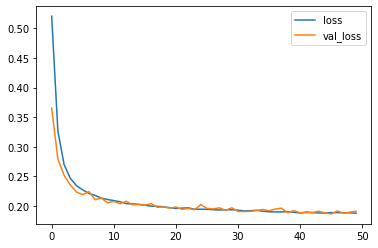

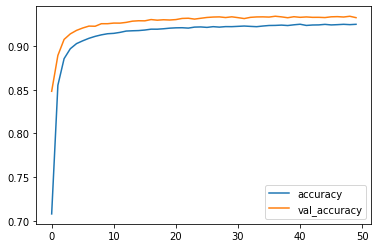

In [33]:
import pandas as pd
pd.DataFrame(h)[['loss','val_loss']].plot()
pd.DataFrame(h)[['accuracy','val_accuracy']].plot()

In [34]:
evalu = model.evaluate(x_test, y_test, batch_size=256)
print(evalu)

160/160 [==============================] - 0s 1ms/step - loss: 0.1835 - accuracy: 0.9349
[0.18351778388023376, 0.9349488019943237]


In [37]:
import time
from tqdm import tqdm
from collections import defaultdict
from itertools import chain

def evaluate_link_pred(score_f,graph,entity_vec_mapping,entities,vector_size = 100, max_triples=100, plot = False):
    print('start_evaluating ...')
    
    entities = entities
    stats = {'generate_time' : [],
        'convert_time:': [],
        'score_time': [],
        'sort_time': [],
        'total_time': []}

    ranks = []
    
    
    # slightly complicated defaultdict trick. Uninitialised 2dim matrix. 
    # Only store what was seen. Return None for other values

    embeddings_scores = defaultdict(lambda: defaultdict(lambda :None))
    
    
    graph = np.array(graph)
    
    if max_triples:
        graph = choose_many(graph,max_triples)
    
    
    for i,tp in enumerate(tqdm(np.array(graph))):
                                   
        s,p,o = tp
        start_timer = time.perf_counter()
        # construct corrupted triples

        triples_to_test = np.array([tp]+get_all_corrupted_triples(tp,entities))
                      
        generate_timer = time.perf_counter()
        
        if p in embeddings_scores.keys():
            
            # init
            lookup = embeddings_scores[p]
            lookup_scores = []
            ix_to_score = []
            
            # find scores and triple not scored
            for i,ttt in enumerate(triples_to_test):
                s,p,o = ttt
                
                

                if (s,o) in lookup.keys():
                    l = lookup[(s,o)]
                    lookup_scores.append((l,i))
                else:

                    ix_to_score.append(i)

            print(f"looked up {len(lookup_scores)} of {len(triples_to_test)} triples")
            # score unscored triples
            triples_to_score = triples_to_test[ix_to_score]
            if len(triples_to_score) > 0:
                vectors_to_score = get_vectors_fast(triples_to_score,entity_vec_mapping,vector_size=vector_size)
                scores = score_f(vectors_to_score).numpy().squeeze()

                # add scores to lookup
                for ttt, score in zip(triples_to_score,scores):
                    s, _ ,o = tp
                    embeddings_scores[p][(s,o)] = score
            else:
                scores =[]
                
            score_timer = time.perf_counter()
            
            # combine scores

            
            scores =  lookup_scores + list(zip(scores,ix_to_score))
 
            scores = np.array(scores)

            # sort by score
            scores = scores[np.argsort(scores[:,0])]
            
            # get rank
            # look at col 1 (ix) and find original triple ix.

            rank = np.where(scores[:,1] == 0)
            sort_timer = time.perf_counter()
            
           
            
            
            
                
        else:
            
            vectors_to_test = get_vectors_fast(triples_to_test,entity_vec_mapping,vector_size=vector_size)
            convert_timer = time.perf_counter()

                # score them
            scores = (score_f(vectors_to_test)).numpy().squeeze()
            
            for tp, score in zip(triples_to_test,scores):
                    s,p,o = tp
                    embeddings_scores[p][(s,o)] = score                        

            if plot:
                fig = plot_embeddings(vectors_to_test,scores)
                fig.show()

            score_timer = time.perf_counter()
            # sort them 
            sort_ix = np.argsort(scores ,axis=0)
            rank = len(sort_ix)- np.where(sort_ix == 0)[0]
           
        
            sort_timer = time.perf_counter()

        

        stats['generate_time'].append(generate_timer - start_timer)
        stats['convert_time:'].append(convert_timer -  generate_timer)
        stats['score_time'].append(score_timer-convert_timer)
        stats['sort_time'].append(sort_timer-score_timer)
        stats['total_time'].append(sort_timer-start_timer)
        ranks.append(rank)
        
        if i % 100 == 0:
            print(np.mean(rank),'\n',{key: np.mean(value) for key,value in list(stats.items())[-100:]})
            pass
            
        
    stats =  {key: np.mean(value) for key,value in stats.items()}
    
    ranks = np.array(ranks)
    
    stats['MR'] = np.mean(ranks)
    stats['MRR'] = np.mean(1/(ranks))
    stats['HITS1'] = np.count_nonzero(ranks <= 1)
    stats['HITS3'] = np.count_nonzero(ranks <= 3)
    stats['HITS10'] = np.count_nonzero(ranks <= 10)
        
    return  ranks, stats
    
        
        
        


In [ ]:
scores = evaluate_link_pred(lambda x : tf.keras.activations.sigmoid(model.predict(x)), g_val, lambda x : word_vectors[x], entities, max_triples=None)    
#z, stats

start_evaluating ...


  0%|                                                                                                                                                                                                                                   | 1/17498 [00:00<4:09:27,  1.17it/s]

135.0 
 {'generate_time': 0.06125798799621407, 'convert_time:': 0.2325188890026766, 'score_time': 0.5593533709979965, 'sort_time': 0.0020387159966048785, 'total_time': 0.8551689639934921}


  0%|▏                                                                                                                                                                                                                                 | 13/17498 [00:11<4:15:07,  1.14it/s]

looked up 2 of 28775 triples


  0%|▏                                                                                                                                                                                                                                 | 17/17498 [00:14<4:07:10,  1.18it/s]

looked up 2 of 28775 triples


  0%|▏                                                                                                                                                                                                                                 | 19/17498 [00:16<4:07:17,  1.18it/s]

looked up 2 of 28775 triples


  0%|▎                                                                                                                                                                                                                                 | 20/17498 [00:17<4:13:54,  1.15it/s]

looked up 2 of 28775 triples


  0%|▎                                                                                                                                                                                                                                 | 22/17498 [00:18<4:03:58,  1.19it/s]

looked up 2 of 28775 triples


  0%|▎                                                                                                                                                                                                                                 | 23/17498 [00:19<4:13:32,  1.15it/s]

looked up 2 of 28775 triples


  0%|▎                                                                                                                                                                                                                                 | 24/17498 [00:20<4:17:48,  1.13it/s]

looked up 2 of 28775 triples


  0%|▎                                                                                                                                                                                                                                 | 27/17498 [00:23<4:13:33,  1.15it/s]

looked up 2 of 28775 triples


  0%|▍                                                                                                                                                                                                                                 | 32/17498 [00:27<4:01:12,  1.21it/s]

looked up 2 of 28775 triples


  0%|▍                                                                                                                                                                                                                                 | 37/17498 [00:32<4:18:12,  1.13it/s]

looked up 2 of 28775 triples


  0%|▍                                                                                                                                                                                                                                 | 38/17498 [00:33<4:21:05,  1.11it/s]

looked up 2 of 28775 triples


  0%|▌                                                                                                                                                                                                                                 | 39/17498 [00:33<4:19:45,  1.12it/s]

looked up 2 of 28775 triples


  0%|▌                                                                                                                                                                                                                                 | 40/17498 [00:34<4:22:08,  1.11it/s]

looked up 2 of 28775 triples


  0%|▌                                                                                                                                                                                                                                 | 43/17498 [00:37<4:21:32,  1.11it/s]

looked up 2 of 28775 triples


  0%|▌                                                                                                                                                                                                                                 | 46/17498 [00:40<4:16:10,  1.14it/s]

looked up 2 of 28775 triples


  0%|▌                                                                                                                                                                                                                                 | 47/17498 [00:41<4:19:40,  1.12it/s]

looked up 3 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 49/17498 [00:42<4:12:32,  1.15it/s]

looked up 2 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 50/17498 [00:43<4:14:03,  1.14it/s]

looked up 2 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 51/17498 [00:44<4:20:33,  1.12it/s]

looked up 2 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 52/17498 [00:45<4:21:12,  1.11it/s]

looked up 2 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 54/17498 [00:47<4:18:53,  1.12it/s]

looked up 14389 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 55/17498 [00:47<3:47:27,  1.28it/s]

looked up 2 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 57/17498 [00:49<3:59:20,  1.21it/s]

looked up 4 of 28775 triples


  0%|▋                                                                                                                                                                                                                                 | 58/17498 [00:50<4:13:55,  1.14it/s]

looked up 2 of 28775 triples


  0%|▊                                                                                                                                                                                                                                 | 59/17498 [00:51<4:17:52,  1.13it/s]

looked up 3 of 28775 triples


  0%|▊                                                                                                                                                                                                                                 | 61/17498 [00:53<4:58:06,  1.03s/it]

looked up 2 of 28775 triples


  0%|▊                                                                                                                                                                                                                                 | 62/17498 [00:54<4:47:59,  1.01it/s]

looked up 2 of 28775 triples


  0%|▊                                                                                                                                                                                                                                 | 63/17498 [00:55<4:50:43,  1.00s/it]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 68/17498 [01:00<4:11:58,  1.15it/s]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 70/17498 [01:01<4:15:43,  1.14it/s]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 71/17498 [01:02<4:23:59,  1.10it/s]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 72/17498 [01:03<4:26:08,  1.09it/s]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 73/17498 [01:04<4:29:39,  1.08it/s]

looked up 14389 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 74/17498 [01:05<3:57:56,  1.22it/s]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 75/17498 [01:06<4:07:22,  1.17it/s]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 76/17498 [01:07<4:12:46,  1.15it/s]

looked up 2 of 28775 triples


  0%|▉                                                                                                                                                                                                                                 | 77/17498 [01:08<4:16:56,  1.13it/s]

looked up 14389 of 28775 triples


  0%|█                                                                                                                                                                                                                                 | 79/17498 [01:09<3:51:04,  1.26it/s]

looked up 2 of 28775 triples


  0%|█                                                                                                                                                                                                                                 | 81/17498 [01:11<3:58:46,  1.22it/s]

looked up 2 of 28775 triples


  0%|█                                                                                                                                                                                                                                 | 82/17498 [01:12<4:07:56,  1.17it/s]

looked up 2 of 28775 triples


  0%|█                                                                                                                                                                                                                                 | 83/17498 [01:13<4:14:49,  1.14it/s]

looked up 2 of 28775 triples


  0%|█                                                                                                                                                                                                                                 | 84/17498 [01:13<4:16:11,  1.13it/s]

looked up 2 of 28775 triples


  0%|█                                                                                                                                                                                                                                 | 85/17498 [01:14<4:19:25,  1.12it/s]

looked up 2 of 28775 triples


  0%|█                                                                                                                                                                                                                                 | 86/17498 [01:15<4:19:19,  1.12it/s]

looked up 2 of 28775 triples


  1%|█▏                                                                                                                                                                                                                                | 88/17498 [01:17<4:44:11,  1.02it/s]

looked up 2 of 28775 triples


  1%|█▏                                                                                                                                                                                                                                | 90/17498 [01:19<4:24:12,  1.10it/s]

looked up 2 of 28775 triples


  1%|█▏                                                                                                                                                                                                                                | 91/17498 [01:20<4:24:07,  1.10it/s]

looked up 2 of 28775 triples


  1%|█▏                                                                                                                                                                                                                                | 94/17498 [01:23<4:10:01,  1.16it/s]

looked up 2 of 28775 triples


  1%|█▏                                                                                                                                                                                                                                | 96/17498 [01:24<4:09:29,  1.16it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                                | 97/17498 [01:25<4:11:12,  1.15it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                                | 99/17498 [01:27<4:11:50,  1.15it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                               | 100/17498 [01:28<4:23:38,  1.10it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                               | 101/17498 [01:29<4:21:42,  1.11it/s]

looked up 14389 of 28775 triples


  1%|█▎                                                                                                                                                                                                                               | 102/17498 [01:29<3:51:41,  1.25it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                               | 103/17498 [01:30<3:59:34,  1.21it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                               | 104/17498 [01:31<4:05:21,  1.18it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                               | 105/17498 [01:32<4:14:22,  1.14it/s]

looked up 2 of 28775 triples


  1%|█▎                                                                                                                                                                                                                               | 106/17498 [01:33<4:16:11,  1.13it/s]

looked up 2 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 107/17498 [01:34<4:16:41,  1.13it/s]

looked up 3 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 108/17498 [01:35<4:19:09,  1.12it/s]

looked up 2 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 109/17498 [01:36<4:26:21,  1.09it/s]

looked up 2 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 110/17498 [01:37<4:24:17,  1.10it/s]

looked up 2 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 111/17498 [01:38<4:25:43,  1.09it/s]

looked up 2 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 113/17498 [01:40<4:53:28,  1.01s/it]

looked up 2 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 115/17498 [01:42<4:35:16,  1.05it/s]

looked up 2 of 28775 triples


  1%|█▍                                                                                                                                                                                                                               | 116/17498 [01:43<4:33:23,  1.06it/s]

looked up 2 of 28775 triples


  1%|█▌                                                                                                                                                                                                                               | 117/17498 [01:44<4:29:52,  1.07it/s]

looked up 2 of 28775 triples


  1%|█▌                                                                                                                                                                                                                               | 119/17498 [01:45<4:20:40,  1.11it/s]

looked up 2 of 28775 triples


  1%|█▌                                                                                                                                                                                                                               | 121/17498 [01:47<4:21:58,  1.11it/s]

looked up 2 of 28775 triples


  1%|█▌                                                                                                                                                                                                                               | 122/17498 [01:48<4:22:43,  1.10it/s]

looked up 2 of 28775 triples


  1%|█▌                                                                                                                                                                                                                               | 124/17498 [01:50<4:16:50,  1.13it/s]

looked up 2 of 28775 triples


  1%|█▌                                                                                                                                                                                                                               | 125/17498 [01:51<4:20:16,  1.11it/s]

looked up 2 of 28775 triples


  1%|█▌                                                                                                                                                                                                                               | 126/17498 [01:52<4:26:40,  1.09it/s]

looked up 2 of 28775 triples


  1%|█▋                                                                                                                                                                                                                               | 127/17498 [01:53<4:32:30,  1.06it/s]

looked up 3 of 28775 triples


  1%|█▋                                                                                                                                                                                                                               | 128/17498 [01:54<4:34:25,  1.05it/s]

looked up 2 of 28775 triples


  1%|█▋                                                                                                                                                                                                                               | 129/17498 [01:55<4:30:04,  1.07it/s]

looked up 2 of 28775 triples


  1%|█▋                                                                                                                                                                                                                               | 130/17498 [01:56<4:33:37,  1.06it/s]

looked up 2 of 28775 triples


  1%|█▋                                                                                                                                                                                                                               | 133/17498 [01:58<4:20:32,  1.11it/s]

looked up 2 of 28775 triples


  1%|█▋                                                                                                                                                                                                                               | 136/17498 [02:01<4:09:14,  1.16it/s]

looked up 2 of 28775 triples


  1%|█▊                                                                                                                                                                                                                               | 139/17498 [02:04<4:32:12,  1.06it/s]

looked up 2 of 28775 triples


  1%|█▊                                                                                                                                                                                                                               | 140/17498 [02:05<4:35:58,  1.05it/s]

looked up 14389 of 28775 triples


  1%|█▊                                                                                                                                                                                                                               | 142/17498 [02:06<4:03:28,  1.19it/s]

looked up 3 of 28775 triples


  1%|█▊                                                                                                                                                                                                                               | 143/17498 [02:08<4:19:55,  1.11it/s]

looked up 2 of 28775 triples


  1%|█▊                                                                                                                                                                                                                               | 144/17498 [02:08<4:22:20,  1.10it/s]

looked up 5 of 28775 triples


  1%|█▊                                                                                                                                                                                                                               | 145/17498 [02:09<4:27:33,  1.08it/s]

looked up 2 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 146/17498 [02:10<4:28:23,  1.08it/s]

looked up 2 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 148/17498 [02:12<4:18:34,  1.12it/s]

looked up 2 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 149/17498 [02:13<4:27:16,  1.08it/s]

looked up 2 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 151/17498 [02:15<4:21:56,  1.10it/s]

looked up 14389 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 152/17498 [02:15<3:53:19,  1.24it/s]

looked up 2 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 153/17498 [02:16<4:00:35,  1.20it/s]

looked up 2 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 154/17498 [02:17<4:11:52,  1.15it/s]

looked up 2 of 28775 triples


  1%|█▉                                                                                                                                                                                                                               | 155/17498 [02:18<4:14:48,  1.13it/s]

looked up 2 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 156/17498 [02:19<4:21:12,  1.11it/s]

looked up 2 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 157/17498 [02:20<4:20:11,  1.11it/s]

looked up 14389 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 158/17498 [02:21<3:51:26,  1.25it/s]

looked up 2 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 159/17498 [02:22<4:02:41,  1.19it/s]

looked up 6 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 160/17498 [02:22<4:11:53,  1.15it/s]

looked up 2 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 161/17498 [02:23<4:18:53,  1.12it/s]

looked up 2 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 162/17498 [02:24<4:25:35,  1.09it/s]

looked up 3 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 163/17498 [02:26<5:11:03,  1.08s/it]

looked up 2 of 28775 triples


  1%|██                                                                                                                                                                                                                               | 165/17498 [02:28<4:48:00,  1.00it/s]

looked up 2 of 28775 triples


  1%|██▏                                                                                                                                                                                                                              | 166/17498 [02:29<4:54:00,  1.02s/it]

looked up 2 of 28775 triples


  1%|██▏                                                                                                                                                                                                                              | 167/17498 [02:30<4:46:57,  1.01it/s]

looked up 3 of 28775 triples


  1%|██▏                                                                                                                                                                                                                              | 168/17498 [02:31<4:44:59,  1.01it/s]

looked up 2 of 28775 triples


  1%|██▏                                                                                                                                                                                                                              | 169/17498 [02:32<4:40:31,  1.03it/s]

looked up 2 of 28775 triples


  1%|██▏                                                                                                                                                                                                                              | 171/17498 [02:34<4:34:22,  1.05it/s]

looked up 14389 of 28775 triples


  1%|██▏                                                                                                                                                                                                                              | 173/17498 [02:35<4:01:52,  1.19it/s]

looked up 3 of 28775 triples


  1%|██▏                                                                                                                                                                                                                              | 174/17498 [02:36<4:07:55,  1.16it/s]

looked up 4 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 175/17498 [02:37<4:14:50,  1.13it/s]

looked up 2 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 176/17498 [02:38<4:20:10,  1.11it/s]

looked up 2 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 177/17498 [02:39<4:27:53,  1.08it/s]

looked up 2 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 178/17498 [02:40<4:30:18,  1.07it/s]

looked up 2 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 179/17498 [02:41<4:30:44,  1.07it/s]

looked up 2 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 181/17498 [02:42<4:26:47,  1.08it/s]

looked up 2 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 182/17498 [02:43<4:28:29,  1.07it/s]

looked up 4 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 183/17498 [02:44<4:33:46,  1.05it/s]

looked up 3 of 28775 triples


  1%|██▎                                                                                                                                                                                                                              | 184/17498 [02:45<4:31:43,  1.06it/s]

looked up 4 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 185/17498 [02:46<4:30:11,  1.07it/s]

looked up 2 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 186/17498 [02:47<4:34:53,  1.05it/s]

looked up 4 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 187/17498 [02:48<4:45:54,  1.01it/s]

looked up 5 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 188/17498 [02:49<4:45:53,  1.01it/s]

looked up 2 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 189/17498 [02:51<5:38:20,  1.17s/it]

looked up 2 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 190/17498 [02:52<5:24:06,  1.12s/it]

looked up 2 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 191/17498 [02:53<5:12:08,  1.08s/it]

looked up 14389 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 192/17498 [02:53<4:27:04,  1.08it/s]

looked up 2 of 28775 triples


  1%|██▍                                                                                                                                                                                                                              | 193/17498 [02:54<4:27:06,  1.08it/s]

looked up 2 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 195/17498 [02:56<4:18:34,  1.12it/s]

looked up 2 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 196/17498 [02:57<4:20:49,  1.11it/s]

looked up 2 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 197/17498 [02:58<4:28:28,  1.07it/s]

looked up 6 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 198/17498 [02:59<4:31:22,  1.06it/s]

looked up 2 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 199/17498 [03:00<4:28:34,  1.07it/s]

looked up 2 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 200/17498 [03:01<4:32:17,  1.06it/s]

looked up 2 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 201/17498 [03:02<4:36:37,  1.04it/s]

looked up 2 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 202/17498 [03:03<4:36:11,  1.04it/s]

looked up 7 of 28775 triples


  1%|██▌                                                                                                                                                                                                                              | 203/17498 [03:04<4:46:47,  1.01it/s]

looked up 2 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 205/17498 [03:06<4:30:29,  1.07it/s]

looked up 2 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 206/17498 [03:07<4:32:31,  1.06it/s]

looked up 14389 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 208/17498 [03:08<4:05:57,  1.17it/s]

looked up 2 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 209/17498 [03:09<4:11:11,  1.15it/s]

looked up 14389 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 210/17498 [03:10<3:45:31,  1.28it/s]

looked up 3 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 211/17498 [03:11<4:05:08,  1.18it/s]

looked up 14389 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 212/17498 [03:11<3:41:03,  1.30it/s]

looked up 2 of 28775 triples


  1%|██▋                                                                                                                                                                                                                              | 213/17498 [03:12<3:53:24,  1.23it/s]

looked up 5 of 28775 triples


  1%|██▊                                                                                                                                                                                                                              | 214/17498 [03:14<4:47:28,  1.00it/s]

looked up 2 of 28775 triples


  1%|██▊                                                                                                                                                                                                                              | 215/17498 [03:15<4:45:43,  1.01it/s]

looked up 2 of 28775 triples


  1%|██▊                                                                                                                                                                                                                              | 216/17498 [03:16<4:47:38,  1.00it/s]

looked up 2 of 28775 triples


  1%|██▊                                                                                                                                                                                                                              | 218/17498 [03:17<4:25:24,  1.09it/s]

looked up 2 of 28775 triples


  1%|██▊                                                                                                                                                                                                                              | 220/17498 [03:19<4:30:57,  1.06it/s]

looked up 14389 of 28775 triples


  1%|██▊                                                                                                                                                                                                                              | 221/17498 [03:20<4:06:14,  1.17it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 224/17498 [03:22<4:07:35,  1.16it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 226/17498 [03:24<4:13:01,  1.14it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 227/17498 [03:25<4:25:47,  1.08it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 228/17498 [03:26<4:28:16,  1.07it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 229/17498 [03:27<4:27:25,  1.08it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 230/17498 [03:28<4:24:27,  1.09it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 231/17498 [03:29<4:23:07,  1.09it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 232/17498 [03:30<4:25:08,  1.09it/s]

looked up 2 of 28775 triples


  1%|██▉                                                                                                                                                                                                                              | 233/17498 [03:31<4:25:58,  1.08it/s]

looked up 3 of 28775 triples


  1%|███                                                                                                                                                                                                                              | 234/17498 [03:32<4:26:51,  1.08it/s]

looked up 2 of 28775 triples


  1%|███                                                                                                                                                                                                                              | 236/17498 [03:34<4:27:01,  1.08it/s]

looked up 2 of 28775 triples


  1%|███                                                                                                                                                                                                                              | 237/17498 [03:35<4:28:23,  1.07it/s]

looked up 2 of 28775 triples


  1%|███                                                                                                                                                                                                                              | 238/17498 [03:36<4:27:49,  1.07it/s]

looked up 2 of 28775 triples


  1%|███                                                                                                                                                                                                                              | 239/17498 [03:36<4:29:41,  1.07it/s]

looked up 2 of 28775 triples


  1%|███                                                                                                                                                                                                                              | 242/17498 [03:40<4:59:16,  1.04s/it]

looked up 2 of 28775 triples


  1%|███                                                                                                                                                                                                                              | 243/17498 [03:41<4:56:35,  1.03s/it]

looked up 2 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 244/17498 [03:42<4:46:14,  1.00it/s]

looked up 2 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 245/17498 [03:43<4:48:09,  1.00s/it]

looked up 14389 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 246/17498 [03:43<4:11:30,  1.14it/s]

looked up 3 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 247/17498 [03:44<4:17:50,  1.12it/s]

looked up 2 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 248/17498 [03:45<4:18:04,  1.11it/s]

looked up 14389 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 250/17498 [03:47<3:52:31,  1.24it/s]

looked up 2 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 251/17498 [03:47<4:05:02,  1.17it/s]

looked up 2 of 28775 triples


  1%|███▏                                                                                                                                                                                                                             | 252/17498 [03:48<4:13:20,  1.13it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 253/17498 [03:49<4:18:16,  1.11it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 254/17498 [03:50<4:20:26,  1.10it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 255/17498 [03:51<4:27:49,  1.07it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 256/17498 [03:52<4:34:36,  1.05it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 257/17498 [03:53<4:34:58,  1.04it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 258/17498 [03:54<4:31:22,  1.06it/s]

looked up 3 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 259/17498 [03:55<4:33:17,  1.05it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 260/17498 [03:56<4:43:54,  1.01it/s]

looked up 2 of 28775 triples


  1%|███▎                                                                                                                                                                                                                             | 262/17498 [03:58<4:26:46,  1.08it/s]

looked up 2 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 263/17498 [03:59<4:33:52,  1.05it/s]

looked up 2 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 264/17498 [04:00<4:43:30,  1.01it/s]

looked up 2 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 265/17498 [04:01<4:38:47,  1.03it/s]

looked up 2 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 266/17498 [04:03<5:24:55,  1.13s/it]

looked up 2 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 267/17498 [04:03<5:11:22,  1.08s/it]

looked up 4 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 269/17498 [04:05<4:46:49,  1.00it/s]

looked up 14389 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 270/17498 [04:06<4:09:15,  1.15it/s]

looked up 2 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 271/17498 [04:07<4:15:07,  1.13it/s]

looked up 5 of 28775 triples


  2%|███▍                                                                                                                                                                                                                             | 272/17498 [04:08<4:27:44,  1.07it/s]

looked up 2 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 273/17498 [04:09<4:28:56,  1.07it/s]

looked up 2 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 274/17498 [04:10<4:35:10,  1.04it/s]

looked up 2 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 275/17498 [04:11<4:39:28,  1.03it/s]

looked up 3 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 276/17498 [04:12<4:35:39,  1.04it/s]

looked up 2 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 278/17498 [04:14<4:23:40,  1.09it/s]

looked up 2 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 279/17498 [04:14<4:24:16,  1.09it/s]

looked up 14389 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 280/17498 [04:15<3:53:18,  1.23it/s]

looked up 2 of 28775 triples


  2%|███▌                                                                                                                                                                                                                             | 281/17498 [04:16<4:05:45,  1.17it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 282/17498 [04:17<4:11:00,  1.14it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 283/17498 [04:18<4:16:57,  1.12it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 285/17498 [04:20<4:19:39,  1.10it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 286/17498 [04:21<4:22:34,  1.09it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 287/17498 [04:22<4:23:17,  1.09it/s]

looked up 3 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 288/17498 [04:23<4:32:31,  1.05it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 289/17498 [04:24<4:34:13,  1.05it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 290/17498 [04:24<4:31:13,  1.06it/s]

looked up 2 of 28775 triples


  2%|███▋                                                                                                                                                                                                                             | 291/17498 [04:26<5:19:30,  1.11s/it]

looked up 2 of 28775 triples


  2%|███▊                                                                                                                                                                                                                             | 295/17498 [04:29<4:23:52,  1.09it/s]

looked up 2 of 28775 triples


  2%|███▊                                                                                                                                                                                                                             | 297/17498 [04:31<4:14:40,  1.13it/s]

looked up 2 of 28775 triples


  2%|███▊                                                                                                                                                                                                                             | 298/17498 [04:32<4:16:51,  1.12it/s]

looked up 2 of 28775 triples


  2%|███▊                                                                                                                                                                                                                             | 299/17498 [04:33<4:19:10,  1.11it/s]

looked up 2 of 28775 triples


  2%|███▊                                                                                                                                                                                                                             | 300/17498 [04:34<4:23:11,  1.09it/s]

looked up 3 of 28775 triples


  2%|███▊                                                                                                                                                                                                                             | 301/17498 [04:35<4:29:03,  1.07it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 302/17498 [04:36<4:28:06,  1.07it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 303/17498 [04:37<4:30:13,  1.06it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 304/17498 [04:38<4:29:28,  1.06it/s]

looked up 14389 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 305/17498 [04:38<3:58:00,  1.20it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 306/17498 [04:39<4:10:22,  1.14it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 307/17498 [04:40<4:18:30,  1.11it/s]

looked up 14389 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 308/17498 [04:41<3:51:33,  1.24it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 309/17498 [04:42<4:04:25,  1.17it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 310/17498 [04:43<4:11:57,  1.14it/s]

looked up 2 of 28775 triples


  2%|███▉                                                                                                                                                                                                                             | 311/17498 [04:44<4:16:59,  1.11it/s]

looked up 3 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 312/17498 [04:45<4:19:55,  1.10it/s]

looked up 2 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 313/17498 [04:46<4:20:57,  1.10it/s]

looked up 2 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 314/17498 [04:47<4:30:46,  1.06it/s]

looked up 2 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 315/17498 [04:48<4:27:32,  1.07it/s]

looked up 2 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 316/17498 [04:49<5:13:33,  1.09s/it]

looked up 5 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 317/17498 [04:50<4:58:45,  1.04s/it]

looked up 2 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 318/17498 [04:51<4:54:12,  1.03s/it]

looked up 2 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 319/17498 [04:52<4:46:42,  1.00s/it]

looked up 7 of 28775 triples


  2%|████                                                                                                                                                                                                                             | 320/17498 [04:53<4:55:14,  1.03s/it]

looked up 2 of 28775 triples


  2%|████▏                                                                                                                                                                                                                            | 321/17498 [04:54<4:49:49,  1.01s/it]

looked up 2 of 28775 triples


  2%|████▏                                                                                                                                                                                                                            | 322/17498 [04:55<4:55:45,  1.03s/it]

looked up 2 of 28775 triples


  2%|████▏                                                                                                                                                                                                                            | 323/17498 [04:56<4:53:39,  1.03s/it]

looked up 2 of 28775 triples


  2%|████▏                                                                                                                                                                                                                            | 324/17498 [04:57<4:48:33,  1.01s/it]

looked up 14389 of 28775 triples


  2%|████▏                                                                                                                                                                                                                            | 325/17498 [04:58<4:16:06,  1.12it/s]

looked up 2 of 28775 triples


  2%|████▏                                                                                                                                                                                                                            | 328/17498 [05:00<4:14:46,  1.12it/s]

looked up 2 of 28775 triples


  2%|████▏                                                                                                                                                                                                                            | 330/17498 [05:02<4:20:35,  1.10it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 331/17498 [05:03<4:28:04,  1.07it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 332/17498 [05:04<4:36:00,  1.04it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 333/17498 [05:05<4:35:33,  1.04it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 335/17498 [05:07<4:26:15,  1.07it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 336/17498 [05:08<4:34:20,  1.04it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 337/17498 [05:09<4:38:07,  1.03it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 338/17498 [05:10<4:43:32,  1.01it/s]

looked up 2 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 339/17498 [05:11<4:40:37,  1.02it/s]

looked up 14389 of 28775 triples


  2%|████▎                                                                                                                                                                                                                            | 340/17498 [05:12<4:06:37,  1.16it/s]

looked up 2 of 28775 triples


  2%|████▍                                                                                                                                                                                                                            | 342/17498 [05:14<4:57:41,  1.04s/it]

looked up 2 of 28775 triples


  2%|████▍                                                                                                                                                                                                                            | 343/17498 [05:15<4:51:02,  1.02s/it]

looked up 14389 of 28775 triples


  2%|████▍                                                                                                                                                                                                                            | 344/17498 [05:16<4:13:12,  1.13it/s]

looked up 14389 of 28775 triples


  2%|████▍                                                                                                                                                                                                                            | 345/17498 [05:16<3:47:10,  1.26it/s]

looked up 2 of 28775 triples


  2%|████▍                                                                                                                                                                                                                            | 346/17498 [05:17<4:01:54,  1.18it/s]

looked up 2 of 28775 triples


  2%|████▍                                                                                                                                                                                                                            | 349/17498 [05:20<4:14:52,  1.12it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 350/17498 [05:21<4:22:54,  1.09it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 351/17498 [05:22<4:34:00,  1.04it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 352/17498 [05:23<4:38:33,  1.03it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 353/17498 [05:24<4:44:10,  1.01it/s]

looked up 3 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 354/17498 [05:25<4:43:55,  1.01it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 355/17498 [05:26<4:37:16,  1.03it/s]

looked up 8 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 356/17498 [05:27<4:35:22,  1.04it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 357/17498 [05:28<4:33:58,  1.04it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 358/17498 [05:29<4:32:24,  1.05it/s]

looked up 2 of 28775 triples


  2%|████▌                                                                                                                                                                                                                            | 359/17498 [05:30<4:30:51,  1.05it/s]

looked up 2 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 360/17498 [05:31<4:30:56,  1.05it/s]

looked up 2 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 361/17498 [05:32<4:39:37,  1.02it/s]

looked up 6 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 362/17498 [05:33<4:36:17,  1.03it/s]

looked up 14389 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 363/17498 [05:33<4:03:14,  1.17it/s]

looked up 2 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 365/17498 [05:35<4:12:28,  1.13it/s]

looked up 2 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 367/17498 [05:37<4:52:20,  1.02s/it]

looked up 2 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 368/17498 [05:38<4:48:23,  1.01s/it]

looked up 4 of 28775 triples


  2%|████▋                                                                                                                                                                                                                            | 369/17498 [05:39<4:46:12,  1.00s/it]

looked up 2 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 370/17498 [05:40<4:49:16,  1.01s/it]

looked up 3 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 371/17498 [05:41<4:51:42,  1.02s/it]

looked up 3 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 372/17498 [05:42<4:48:46,  1.01s/it]

looked up 2 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 373/17498 [05:43<4:49:06,  1.01s/it]

looked up 14389 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 374/17498 [05:44<4:12:28,  1.13it/s]

looked up 3 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 375/17498 [05:45<4:25:19,  1.08it/s]

looked up 14389 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 376/17498 [05:46<3:56:03,  1.21it/s]

looked up 14389 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 377/17498 [05:46<3:37:48,  1.31it/s]

looked up 2 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 378/17498 [05:47<4:00:31,  1.19it/s]

looked up 2 of 28775 triples


  2%|████▊                                                                                                                                                                                                                            | 379/17498 [05:48<4:10:00,  1.14it/s]

looked up 2 of 28775 triples


  2%|████▉                                                                                                                                                                                                                            | 380/17498 [05:49<4:22:00,  1.09it/s]

looked up 2 of 28775 triples


  2%|████▉                                                                                                                                                                                                                            | 381/17498 [05:50<4:23:23,  1.08it/s]

looked up 4 of 28775 triples


  2%|████▉                                                                                                                                                                                                                            | 382/17498 [05:51<4:26:13,  1.07it/s]

looked up 2 of 28775 triples


  2%|████▉                                                                                                                                                                                                                            | 383/17498 [05:52<4:27:33,  1.07it/s]

looked up 2 of 28775 triples


  2%|████▉                                                                                                                                                                                                                            | 384/17498 [05:53<4:29:21,  1.06it/s]

looked up 5 of 28775 triples


  2%|████▉                                                                                                                                                                                                                            | 385/17498 [05:54<4:31:28,  1.05it/s]

looked up 2 of 28775 triples


  2%|████▉                                                                                                                                                                                                                            | 386/17498 [05:55<4:30:13,  1.06it/s]

looked up 2 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 389/17498 [05:58<4:18:08,  1.10it/s]

looked up 2 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 391/17498 [05:59<4:15:22,  1.12it/s]

looked up 4 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 392/17498 [06:01<5:11:23,  1.09s/it]

looked up 2 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 394/17498 [06:03<4:50:03,  1.02s/it]

looked up 2 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 395/17498 [06:04<4:53:06,  1.03s/it]

looked up 4 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 396/17498 [06:05<4:48:36,  1.01s/it]

looked up 2 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 397/17498 [06:06<4:51:15,  1.02s/it]

looked up 14389 of 28775 triples


  2%|█████                                                                                                                                                                                                                            | 398/17498 [06:07<4:15:39,  1.11it/s]

looked up 3 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 399/17498 [06:07<4:23:31,  1.08it/s]

looked up 2 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 400/17498 [06:08<4:24:30,  1.08it/s]

looked up 3 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 401/17498 [06:09<4:26:53,  1.07it/s]

looked up 2 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 402/17498 [06:10<4:35:55,  1.03it/s]

looked up 2 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 404/17498 [06:12<4:26:24,  1.07it/s]

looked up 14389 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 405/17498 [06:13<3:55:55,  1.21it/s]

looked up 2 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 406/17498 [06:14<4:04:30,  1.17it/s]

looked up 14389 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 407/17498 [06:14<3:39:44,  1.30it/s]

looked up 2 of 28775 triples


  2%|█████▏                                                                                                                                                                                                                           | 408/17498 [06:15<3:52:31,  1.22it/s]

looked up 2 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 409/17498 [06:16<4:02:20,  1.18it/s]

looked up 2 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 410/17498 [06:17<4:08:24,  1.15it/s]

looked up 2 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 411/17498 [06:18<4:22:29,  1.08it/s]

looked up 2 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 412/17498 [06:19<4:24:45,  1.08it/s]

looked up 3 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 414/17498 [06:21<4:18:57,  1.10it/s]

looked up 14389 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 415/17498 [06:21<3:50:18,  1.24it/s]

looked up 2 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 416/17498 [06:22<4:07:26,  1.15it/s]

looked up 2 of 28775 triples


  2%|█████▎                                                                                                                                                                                                                           | 418/17498 [06:25<4:39:31,  1.02it/s]

looked up 2 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 419/17498 [06:26<4:35:46,  1.03it/s]

looked up 2 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 420/17498 [06:27<4:34:56,  1.04it/s]

looked up 2 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 421/17498 [06:28<4:34:36,  1.04it/s]

looked up 2 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 422/17498 [06:29<4:35:19,  1.03it/s]

looked up 3 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 424/17498 [06:31<4:32:14,  1.05it/s]

looked up 2 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 425/17498 [06:32<4:41:08,  1.01it/s]

looked up 3 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 426/17498 [06:33<4:39:04,  1.02it/s]

looked up 6 of 28775 triples


  2%|█████▍                                                                                                                                                                                                                           | 427/17498 [06:34<4:38:35,  1.02it/s]

looked up 2 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 428/17498 [06:34<4:35:44,  1.03it/s]

looked up 14389 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 429/17498 [06:35<4:02:49,  1.17it/s]

looked up 2 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 430/17498 [06:36<4:09:49,  1.14it/s]

looked up 2 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 431/17498 [06:37<4:19:46,  1.09it/s]

looked up 14389 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 432/17498 [06:38<3:50:20,  1.23it/s]

looked up 2 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 433/17498 [06:38<4:00:05,  1.18it/s]

looked up 2 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 434/17498 [06:39<4:08:55,  1.14it/s]

looked up 2 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 435/17498 [06:40<4:17:21,  1.10it/s]

looked up 2 of 28775 triples


  2%|█████▌                                                                                                                                                                                                                           | 437/17498 [06:42<4:24:26,  1.08it/s]

looked up 2 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 438/17498 [06:43<4:25:12,  1.07it/s]

looked up 2 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 439/17498 [06:44<4:36:22,  1.03it/s]

looked up 2 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 440/17498 [06:45<4:36:52,  1.03it/s]

looked up 3 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 441/17498 [06:46<4:33:09,  1.04it/s]

looked up 3 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 442/17498 [06:47<4:32:59,  1.04it/s]

looked up 2 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 443/17498 [06:49<5:20:48,  1.13s/it]

looked up 9 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 444/17498 [06:50<5:08:25,  1.09s/it]

looked up 2 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 445/17498 [06:51<4:59:18,  1.05s/it]

looked up 2 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 446/17498 [06:52<4:59:04,  1.05s/it]

looked up 14389 of 28775 triples


  3%|█████▋                                                                                                                                                                                                                           | 447/17498 [06:52<4:22:42,  1.08it/s]

looked up 2 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 448/17498 [06:53<4:25:04,  1.07it/s]

looked up 2 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 449/17498 [06:54<4:26:34,  1.07it/s]

looked up 14389 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 450/17498 [06:55<3:55:45,  1.21it/s]

looked up 2 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 451/17498 [06:56<4:03:26,  1.17it/s]

looked up 2 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 452/17498 [06:57<4:12:52,  1.12it/s]

looked up 2 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 453/17498 [06:58<4:18:37,  1.10it/s]

looked up 2 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 454/17498 [06:59<4:27:15,  1.06it/s]

looked up 3 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 455/17498 [07:00<4:31:07,  1.05it/s]

looked up 2 of 28775 triples


  3%|█████▊                                                                                                                                                                                                                           | 456/17498 [07:01<4:31:47,  1.05it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 457/17498 [07:02<4:31:30,  1.05it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 458/17498 [07:03<4:36:55,  1.03it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 459/17498 [07:04<4:34:04,  1.04it/s]

looked up 14389 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 460/17498 [07:04<4:02:06,  1.17it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 461/17498 [07:05<4:10:00,  1.14it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 463/17498 [07:07<4:20:04,  1.09it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 464/17498 [07:08<4:21:57,  1.08it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 465/17498 [07:09<4:27:20,  1.06it/s]

looked up 2 of 28775 triples


  3%|█████▉                                                                                                                                                                                                                           | 466/17498 [07:10<4:29:09,  1.05it/s]

looked up 14389 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 467/17498 [07:11<3:59:54,  1.18it/s]

looked up 2 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 468/17498 [07:12<5:01:52,  1.06s/it]

looked up 3 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 469/17498 [07:13<4:51:39,  1.03s/it]

looked up 3 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 470/17498 [07:14<4:47:17,  1.01s/it]

looked up 2 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 471/17498 [07:15<4:43:14,  1.00it/s]

looked up 2 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 472/17498 [07:16<4:41:53,  1.01it/s]

looked up 14389 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 473/17498 [07:17<4:06:12,  1.15it/s]

looked up 3 of 28775 triples


  3%|██████                                                                                                                                                                                                                           | 475/17498 [07:18<4:11:52,  1.13it/s]

looked up 14389 of 28775 triples


  3%|██████▏                                                                                                                                                                                                                          | 478/17498 [07:21<3:59:51,  1.18it/s]

looked up 2 of 28775 triples


  3%|██████▏                                                                                                                                                                                                                          | 480/17498 [07:23<4:14:16,  1.12it/s]

looked up 4 of 28775 triples


  3%|██████▏                                                                                                                                                                                                                          | 481/17498 [07:24<4:17:20,  1.10it/s]

looked up 10 of 28775 triples


  3%|██████▏                                                                                                                                                                                                                          | 484/17498 [07:26<4:23:19,  1.08it/s]

looked up 2 of 28775 triples


  3%|██████▏                                                                                                                                                                                                                          | 485/17498 [07:27<4:28:46,  1.05it/s]

looked up 3 of 28775 triples


  3%|██████▏                                                                                                                                                                                                                          | 486/17498 [07:28<4:27:09,  1.06it/s]

looked up 2 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 487/17498 [07:29<4:30:04,  1.05it/s]

looked up 2 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 488/17498 [07:30<4:29:46,  1.05it/s]

looked up 2 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 489/17498 [07:31<4:33:11,  1.04it/s]

looked up 2 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 490/17498 [07:32<4:34:02,  1.03it/s]

looked up 14389 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 491/17498 [07:33<4:01:56,  1.17it/s]

looked up 7 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 492/17498 [07:34<4:22:40,  1.08it/s]

looked up 2 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 494/17498 [07:36<4:57:22,  1.05s/it]

looked up 2 of 28775 triples


  3%|██████▎                                                                                                                                                                                                                          | 495/17498 [07:37<4:53:54,  1.04s/it]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 496/17498 [07:38<4:51:40,  1.03s/it]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 497/17498 [07:39<4:46:21,  1.01s/it]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 498/17498 [07:40<4:43:32,  1.00s/it]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 499/17498 [07:41<4:43:00,  1.00it/s]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 500/17498 [07:42<4:39:23,  1.01it/s]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 501/17498 [07:43<4:41:23,  1.01it/s]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 502/17498 [07:44<4:41:36,  1.01it/s]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 503/17498 [07:45<4:37:46,  1.02it/s]

looked up 2 of 28775 triples


  3%|██████▍                                                                                                                                                                                                                          | 504/17498 [07:46<4:34:37,  1.03it/s]

looked up 2 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 506/17498 [07:48<4:29:11,  1.05it/s]

looked up 2 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 507/17498 [07:49<4:31:56,  1.04it/s]

looked up 2 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 508/17498 [07:50<4:34:42,  1.03it/s]

looked up 2 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 509/17498 [07:51<4:36:45,  1.02it/s]

looked up 3 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 510/17498 [07:52<4:33:51,  1.03it/s]

looked up 14389 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 511/17498 [07:53<4:02:45,  1.17it/s]

looked up 3 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 512/17498 [07:54<4:11:37,  1.13it/s]

looked up 2 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 513/17498 [07:55<4:18:05,  1.10it/s]

looked up 14389 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 514/17498 [07:55<3:50:18,  1.23it/s]

looked up 3 of 28775 triples


  3%|██████▌                                                                                                                                                                                                                          | 515/17498 [07:56<4:03:16,  1.16it/s]

looked up 2 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 517/17498 [07:58<4:15:13,  1.11it/s]

looked up 14389 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 518/17498 [07:59<3:55:43,  1.20it/s]

looked up 3 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 519/17498 [08:00<4:52:38,  1.03s/it]

looked up 2 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 520/17498 [08:01<4:48:49,  1.02s/it]

looked up 2 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 521/17498 [08:02<4:44:13,  1.00s/it]

looked up 4 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 522/17498 [08:03<4:40:01,  1.01it/s]

looked up 14389 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 523/17498 [08:04<4:05:41,  1.15it/s]

looked up 3 of 28775 triples


  3%|██████▋                                                                                                                                                                                                                          | 524/17498 [08:05<4:15:08,  1.11it/s]

looked up 3 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 525/17498 [08:06<4:19:55,  1.09it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 526/17498 [08:07<4:26:15,  1.06it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 527/17498 [08:08<4:28:43,  1.05it/s]

looked up 3 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 528/17498 [08:09<4:33:23,  1.03it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 529/17498 [08:10<4:34:02,  1.03it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 530/17498 [08:11<4:36:32,  1.02it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 531/17498 [08:11<4:33:29,  1.03it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 532/17498 [08:12<4:35:34,  1.03it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 533/17498 [08:13<4:39:06,  1.01it/s]

looked up 2 of 28775 triples


  3%|██████▊                                                                                                                                                                                                                          | 534/17498 [08:14<4:36:10,  1.02it/s]

looked up 2 of 28775 triples


  3%|██████▉                                                                                                                                                                                                                          | 535/17498 [08:15<4:42:46,  1.00s/it]

looked up 2 of 28775 triples


  3%|██████▉                                                                                                                                                                                                                          | 536/17498 [08:16<4:40:58,  1.01it/s]

looked up 3 of 28775 triples


  3%|██████▉                                                                                                                                                                                                                          | 539/17498 [08:19<4:23:43,  1.07it/s]

looked up 2 of 28775 triples


  3%|██████▉                                                                                                                                                                                                                          | 540/17498 [08:20<4:24:10,  1.07it/s]

looked up 14389 of 28775 triples


  3%|██████▉                                                                                                                                                                                                                          | 541/17498 [08:21<3:56:43,  1.19it/s]

looked up 2 of 28775 triples


  3%|██████▉                                                                                                                                                                                                                          | 542/17498 [08:22<4:05:45,  1.15it/s]

looked up 2 of 28775 triples


  3%|██████▉                                                                                                                                                                                                                          | 544/17498 [08:24<4:15:04,  1.11it/s]

looked up 2 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 545/17498 [08:25<5:15:52,  1.12s/it]

looked up 2 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 546/17498 [08:26<5:10:37,  1.10s/it]

looked up 14389 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 547/17498 [08:27<4:26:36,  1.06it/s]

looked up 2 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 549/17498 [08:29<4:27:40,  1.06it/s]

looked up 5 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 550/17498 [08:30<4:33:29,  1.03it/s]

looked up 2 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 551/17498 [08:31<4:43:01,  1.00s/it]

looked up 8 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 552/17498 [08:32<4:39:08,  1.01it/s]

looked up 14389 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 553/17498 [08:32<4:08:37,  1.14it/s]

looked up 3 of 28775 triples


  3%|███████                                                                                                                                                                                                                          | 554/17498 [08:33<4:15:33,  1.11it/s]

looked up 2 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 555/17498 [08:34<4:20:42,  1.08it/s]

looked up 3 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 556/17498 [08:35<4:33:15,  1.03it/s]

looked up 2 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 557/17498 [08:36<4:33:04,  1.03it/s]

looked up 3 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 558/17498 [08:37<4:38:45,  1.01it/s]

looked up 11 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 559/17498 [08:38<4:42:40,  1.00s/it]

looked up 2 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 560/17498 [08:40<4:42:51,  1.00s/it]

looked up 2 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 561/17498 [08:41<4:44:12,  1.01s/it]

looked up 14389 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 562/17498 [08:41<4:12:02,  1.12it/s]

looked up 7 of 28775 triples


  3%|███████▏                                                                                                                                                                                                                         | 563/17498 [08:42<4:32:08,  1.04it/s]

looked up 2 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 564/17498 [08:43<4:37:07,  1.02it/s]

looked up 8 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 565/17498 [08:44<4:36:58,  1.02it/s]

looked up 9 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 566/17498 [08:45<4:42:42,  1.00s/it]

looked up 2 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 567/17498 [08:46<4:41:47,  1.00it/s]

looked up 2 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 568/17498 [08:47<4:45:02,  1.01s/it]

looked up 14389 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 569/17498 [08:48<4:08:30,  1.14it/s]

looked up 14389 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 570/17498 [08:49<3:43:19,  1.26it/s]

looked up 14389 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 571/17498 [08:49<3:25:28,  1.37it/s]

looked up 14389 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 572/17498 [08:50<4:01:08,  1.17it/s]

looked up 14389 of 28775 triples


  3%|███████▎                                                                                                                                                                                                                         | 573/17498 [08:51<3:37:45,  1.30it/s]

looked up 2 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 574/17498 [08:52<3:55:56,  1.20it/s]

looked up 14389 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 575/17498 [08:52<3:34:47,  1.31it/s]

looked up 3 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 576/17498 [08:53<3:51:53,  1.22it/s]

looked up 2 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 577/17498 [08:54<4:04:51,  1.15it/s]

looked up 2 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 578/17498 [08:55<4:17:20,  1.10it/s]

looked up 2 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 580/17498 [08:57<4:25:42,  1.06it/s]

looked up 4 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 581/17498 [08:58<4:32:14,  1.04it/s]

looked up 2 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 582/17498 [08:59<4:39:50,  1.01it/s]

looked up 3 of 28775 triples


  3%|███████▍                                                                                                                                                                                                                         | 583/17498 [09:00<4:40:25,  1.01it/s]

looked up 3 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 584/17498 [09:01<4:38:06,  1.01it/s]

looked up 3 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 585/17498 [09:02<4:40:47,  1.00it/s]

looked up 2 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 586/17498 [09:03<4:40:56,  1.00it/s]

looked up 3 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 587/17498 [09:04<4:41:43,  1.00it/s]

looked up 4 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 588/17498 [09:05<4:42:36,  1.00s/it]

looked up 2 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 589/17498 [09:06<4:43:54,  1.01s/it]

looked up 2 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 590/17498 [09:07<4:42:25,  1.00s/it]

looked up 2 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 591/17498 [09:08<4:41:33,  1.00it/s]

looked up 2 of 28775 triples


  3%|███████▌                                                                                                                                                                                                                         | 592/17498 [09:09<4:37:41,  1.01it/s]

looked up 3 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 593/17498 [09:10<4:32:56,  1.03it/s]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 594/17498 [09:11<4:33:18,  1.03it/s]

looked up 3 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 595/17498 [09:12<4:34:27,  1.03it/s]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 596/17498 [09:13<4:39:07,  1.01it/s]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 597/17498 [09:15<5:23:57,  1.15s/it]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 598/17498 [09:16<5:10:04,  1.10s/it]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 599/17498 [09:17<5:03:58,  1.08s/it]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 600/17498 [09:18<4:54:07,  1.04s/it]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 601/17498 [09:19<4:52:30,  1.04s/it]

looked up 2 of 28775 triples


  3%|███████▋                                                                                                                                                                                                                         | 602/17498 [09:20<4:48:33,  1.02s/it]

looked up 2 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 603/17498 [09:21<4:44:02,  1.01s/it]

looked up 2 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 604/17498 [09:22<4:40:33,  1.00it/s]

looked up 2 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 605/17498 [09:23<4:40:36,  1.00it/s]

looked up 14389 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 607/17498 [09:24<4:06:31,  1.14it/s]

looked up 2 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 608/17498 [09:25<4:19:14,  1.09it/s]

looked up 14389 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 609/17498 [09:26<3:51:08,  1.22it/s]

looked up 2 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 610/17498 [09:27<4:04:30,  1.15it/s]

looked up 14389 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 611/17498 [09:27<3:41:22,  1.27it/s]

looked up 2 of 28775 triples


  3%|███████▊                                                                                                                                                                                                                         | 612/17498 [09:28<4:01:50,  1.16it/s]

looked up 3 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 613/17498 [09:29<4:14:46,  1.10it/s]

looked up 2 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 614/17498 [09:31<4:30:34,  1.04it/s]

looked up 2 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 615/17498 [09:31<4:30:49,  1.04it/s]

looked up 2 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 616/17498 [09:32<4:33:01,  1.03it/s]

looked up 2 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 617/17498 [09:33<4:35:25,  1.02it/s]

looked up 2 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 618/17498 [09:35<4:40:57,  1.00it/s]

looked up 3 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 619/17498 [09:36<4:42:29,  1.00s/it]

looked up 3 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 620/17498 [09:37<4:47:16,  1.02s/it]

looked up 2 of 28775 triples


  4%|███████▉                                                                                                                                                                                                                         | 621/17498 [09:38<4:44:30,  1.01s/it]

looked up 2 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 623/17498 [09:40<5:23:27,  1.15s/it]

looked up 2 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 624/17498 [09:41<5:15:47,  1.12s/it]

looked up 2 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 625/17498 [09:42<5:08:27,  1.10s/it]

looked up 2 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 626/17498 [09:43<4:56:13,  1.05s/it]

looked up 2 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 627/17498 [09:44<4:55:38,  1.05s/it]

looked up 14389 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 628/17498 [09:45<4:17:01,  1.09it/s]

looked up 14389 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 629/17498 [09:45<3:49:44,  1.22it/s]

looked up 2 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 630/17498 [09:46<4:10:45,  1.12it/s]

looked up 3 of 28775 triples


  4%|████████                                                                                                                                                                                                                         | 631/17498 [09:47<4:15:27,  1.10it/s]

looked up 3 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 632/17498 [09:48<4:20:23,  1.08it/s]

looked up 2 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 633/17498 [09:49<4:21:10,  1.08it/s]

looked up 3 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 634/17498 [09:50<4:24:20,  1.06it/s]

looked up 3 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 636/17498 [09:52<4:21:55,  1.07it/s]

looked up 2 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 637/17498 [09:53<4:25:37,  1.06it/s]

looked up 3 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 638/17498 [09:54<4:26:56,  1.05it/s]

looked up 2 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 639/17498 [09:55<4:29:57,  1.04it/s]

looked up 5 of 28775 triples


  4%|████████▏                                                                                                                                                                                                                        | 640/17498 [09:56<4:33:22,  1.03it/s]

looked up 2 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 642/17498 [09:58<4:29:57,  1.04it/s]

looked up 2 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 643/17498 [09:59<4:38:05,  1.01it/s]

looked up 2 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 645/17498 [10:01<4:33:41,  1.03it/s]

looked up 2 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 646/17498 [10:02<4:35:34,  1.02it/s]

looked up 2 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 648/17498 [10:04<4:30:45,  1.04it/s]

looked up 2 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 649/17498 [10:05<5:26:12,  1.16s/it]

looked up 2 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 650/17498 [10:07<5:17:52,  1.13s/it]

looked up 3 of 28775 triples


  4%|████████▎                                                                                                                                                                                                                        | 651/17498 [10:08<5:05:07,  1.09s/it]

looked up 10 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 652/17498 [10:09<4:58:01,  1.06s/it]

looked up 3 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 653/17498 [10:10<4:51:42,  1.04s/it]

looked up 3 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 654/17498 [10:11<4:48:53,  1.03s/it]

looked up 14389 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 655/17498 [10:11<4:10:59,  1.12it/s]

looked up 2 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 656/17498 [10:12<4:19:02,  1.08it/s]

looked up 3 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 657/17498 [10:13<4:28:15,  1.05it/s]

looked up 2 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 658/17498 [10:14<4:28:01,  1.05it/s]

looked up 2 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 660/17498 [10:16<4:25:12,  1.06it/s]

looked up 2 of 28775 triples


  4%|████████▍                                                                                                                                                                                                                        | 661/17498 [10:17<4:26:34,  1.05it/s]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 662/17498 [10:18<4:38:53,  1.01it/s]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 663/17498 [10:19<4:43:12,  1.01s/it]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 664/17498 [10:20<4:40:23,  1.00it/s]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 666/17498 [10:22<4:31:38,  1.03it/s]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 667/17498 [10:23<4:31:02,  1.03it/s]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 668/17498 [10:24<4:31:50,  1.03it/s]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 669/17498 [10:25<4:36:12,  1.02it/s]

looked up 2 of 28775 triples


  4%|████████▌                                                                                                                                                                                                                        | 670/17498 [10:26<4:38:25,  1.01it/s]

looked up 2 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 671/17498 [10:27<4:37:04,  1.01it/s]

looked up 2 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 672/17498 [10:28<4:33:39,  1.02it/s]

looked up 14389 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 673/17498 [10:28<4:02:26,  1.16it/s]

looked up 2 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 674/17498 [10:29<4:13:10,  1.11it/s]

looked up 14389 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 675/17498 [10:31<4:38:50,  1.01it/s]

looked up 2 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 676/17498 [10:32<4:36:14,  1.01it/s]

looked up 2 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 677/17498 [10:33<4:34:13,  1.02it/s]

looked up 9 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 678/17498 [10:34<4:34:16,  1.02it/s]

looked up 2 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 679/17498 [10:35<4:33:29,  1.02it/s]

looked up 2 of 28775 triples


  4%|████████▋                                                                                                                                                                                                                        | 680/17498 [10:36<4:38:03,  1.01it/s]

looked up 2 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 681/17498 [10:36<4:35:07,  1.02it/s]

looked up 3 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 682/17498 [10:38<4:41:51,  1.01s/it]

looked up 2 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 684/17498 [10:39<4:32:54,  1.03it/s]

looked up 2 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 685/17498 [10:41<4:44:52,  1.02s/it]

looked up 2 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 686/17498 [10:42<4:49:07,  1.03s/it]

looked up 2 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 687/17498 [10:43<4:48:51,  1.03s/it]

looked up 4 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 688/17498 [10:44<4:45:38,  1.02s/it]

looked up 2 of 28775 triples


  4%|████████▊                                                                                                                                                                                                                        | 690/17498 [10:46<4:31:56,  1.03it/s]

looked up 2 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 691/17498 [10:47<4:36:19,  1.01it/s]

looked up 4 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 693/17498 [10:48<4:29:41,  1.04it/s]

looked up 14389 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 694/17498 [10:49<3:58:18,  1.18it/s]

looked up 2 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 695/17498 [10:50<4:07:13,  1.13it/s]

looked up 12 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 696/17498 [10:51<4:13:28,  1.10it/s]

looked up 14389 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 697/17498 [10:52<3:47:14,  1.23it/s]

looked up 2 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 698/17498 [10:53<4:00:11,  1.17it/s]

looked up 2 of 28775 triples


  4%|████████▉                                                                                                                                                                                                                        | 699/17498 [10:54<4:13:04,  1.11it/s]

looked up 5 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 700/17498 [10:55<4:20:18,  1.08it/s]

looked up 14389 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 701/17498 [10:56<4:48:26,  1.03s/it]

looked up 2 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 702/17498 [10:57<4:44:18,  1.02s/it]

looked up 3 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 703/17498 [10:58<4:49:31,  1.03s/it]

looked up 2 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 704/17498 [10:59<4:57:00,  1.06s/it]

looked up 13 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 705/17498 [11:00<4:59:52,  1.07s/it]

looked up 11 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 706/17498 [11:01<4:51:43,  1.04s/it]

looked up 3 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 707/17498 [11:02<4:51:43,  1.04s/it]

looked up 3 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 708/17498 [11:03<4:46:30,  1.02s/it]

looked up 2 of 28775 triples


  4%|█████████                                                                                                                                                                                                                        | 709/17498 [11:04<4:42:12,  1.01s/it]

looked up 14389 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 710/17498 [11:05<4:08:04,  1.13it/s]

looked up 4 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 711/17498 [11:06<4:13:55,  1.10it/s]

looked up 2 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 712/17498 [11:07<4:17:42,  1.09it/s]

looked up 2 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 713/17498 [11:07<4:19:47,  1.08it/s]

looked up 2 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 714/17498 [11:08<4:26:21,  1.05it/s]

looked up 2 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 715/17498 [11:09<4:26:03,  1.05it/s]

looked up 3 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 717/17498 [11:11<4:23:36,  1.06it/s]

looked up 4 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 718/17498 [11:12<4:28:29,  1.04it/s]

looked up 2 of 28775 triples


  4%|█████████▏                                                                                                                                                                                                                       | 719/17498 [11:13<4:31:34,  1.03it/s]

looked up 2 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 721/17498 [11:15<4:29:21,  1.04it/s]

looked up 3 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 722/17498 [11:16<4:32:14,  1.03it/s]

looked up 2 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 723/17498 [11:17<4:45:26,  1.02s/it]

looked up 2 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 724/17498 [11:18<4:41:42,  1.01s/it]

looked up 2 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 725/17498 [11:19<4:44:22,  1.02s/it]

looked up 12 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 726/17498 [11:20<4:44:49,  1.02s/it]

looked up 2 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 727/17498 [11:22<5:37:54,  1.21s/it]

looked up 3 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 728/17498 [11:23<5:30:19,  1.18s/it]

looked up 2 of 28775 triples


  4%|█████████▎                                                                                                                                                                                                                       | 729/17498 [11:24<5:14:35,  1.13s/it]

looked up 2 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 730/17498 [11:25<5:03:16,  1.09s/it]

looked up 3 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 731/17498 [11:26<4:56:01,  1.06s/it]

looked up 2 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 732/17498 [11:27<4:55:53,  1.06s/it]

looked up 2 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 733/17498 [11:28<4:59:25,  1.07s/it]

looked up 2 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 734/17498 [11:29<4:58:05,  1.07s/it]

looked up 14389 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 735/17498 [11:30<4:17:19,  1.09it/s]

looked up 2 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 736/17498 [11:31<4:21:11,  1.07it/s]

looked up 2 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 737/17498 [11:32<4:25:44,  1.05it/s]

looked up 2 of 28775 triples


  4%|█████████▍                                                                                                                                                                                                                       | 738/17498 [11:33<4:27:03,  1.05it/s]

looked up 2 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 739/17498 [11:34<4:29:53,  1.03it/s]

looked up 2 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 740/17498 [11:35<4:37:17,  1.01it/s]

looked up 3 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 741/17498 [11:36<4:40:26,  1.00s/it]

looked up 2 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 742/17498 [11:37<4:37:38,  1.01it/s]

looked up 6 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 743/17498 [11:38<4:36:59,  1.01it/s]

looked up 2 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 744/17498 [11:39<4:36:23,  1.01it/s]

looked up 14389 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 745/17498 [11:40<4:03:28,  1.15it/s]

looked up 2 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 746/17498 [11:41<4:19:58,  1.07it/s]

looked up 2 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 747/17498 [11:42<4:29:13,  1.04it/s]

looked up 2 of 28775 triples


  4%|█████████▌                                                                                                                                                                                                                       | 748/17498 [11:43<4:31:09,  1.03it/s]

looked up 2 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 749/17498 [11:44<4:34:27,  1.02it/s]

looked up 14389 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 750/17498 [11:44<4:02:57,  1.15it/s]

looked up 2 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 751/17498 [11:45<4:18:07,  1.08it/s]

looked up 2 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 752/17498 [11:46<4:27:32,  1.04it/s]

looked up 2 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 753/17498 [11:48<5:14:55,  1.13s/it]

looked up 2 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 754/17498 [11:49<5:01:59,  1.08s/it]

looked up 2 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 755/17498 [11:50<4:58:26,  1.07s/it]

looked up 2 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 756/17498 [11:51<4:50:42,  1.04s/it]

looked up 14389 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 757/17498 [11:51<4:11:40,  1.11it/s]

looked up 3 of 28775 triples


  4%|█████████▋                                                                                                                                                                                                                       | 758/17498 [11:52<4:19:02,  1.08it/s]

looked up 2 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 760/17498 [11:54<4:21:32,  1.07it/s]

looked up 3 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 761/17498 [11:55<4:26:23,  1.05it/s]

looked up 3 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 762/17498 [11:56<4:40:53,  1.01s/it]

looked up 4 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 763/17498 [11:57<4:39:52,  1.00s/it]

looked up 3 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 764/17498 [11:58<4:38:36,  1.00it/s]

looked up 14389 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 765/17498 [11:59<4:03:04,  1.15it/s]

looked up 3 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 766/17498 [12:00<4:13:33,  1.10it/s]

looked up 14389 of 28775 triples


  4%|█████████▊                                                                                                                                                                                                                       | 767/17498 [12:01<3:49:26,  1.22it/s]

looked up 2 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 768/17498 [12:02<4:03:11,  1.15it/s]

looked up 2 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 769/17498 [12:03<4:12:30,  1.10it/s]

looked up 2 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 770/17498 [12:04<4:21:06,  1.07it/s]

looked up 2 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 771/17498 [12:05<4:30:48,  1.03it/s]

looked up 3 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 772/17498 [12:06<4:34:30,  1.02it/s]

looked up 2 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 773/17498 [12:07<4:40:06,  1.00s/it]

looked up 2 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 774/17498 [12:08<4:43:12,  1.02s/it]

looked up 13 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 775/17498 [12:09<4:50:40,  1.04s/it]

looked up 3 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 776/17498 [12:10<4:48:21,  1.03s/it]

looked up 2 of 28775 triples


  4%|█████████▉                                                                                                                                                                                                                       | 777/17498 [12:11<4:52:31,  1.05s/it]

looked up 2 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 778/17498 [12:13<5:33:41,  1.20s/it]

looked up 2 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 779/17498 [12:14<5:16:25,  1.14s/it]

looked up 3 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 780/17498 [12:15<5:11:21,  1.12s/it]

looked up 4 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 781/17498 [12:16<5:02:12,  1.08s/it]

looked up 2 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 782/17498 [12:17<4:55:58,  1.06s/it]

looked up 14389 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 783/17498 [12:17<4:17:16,  1.08it/s]

looked up 4 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 784/17498 [12:18<4:28:38,  1.04it/s]

looked up 2 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 785/17498 [12:19<4:31:22,  1.03it/s]

looked up 3 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 786/17498 [12:20<4:31:40,  1.03it/s]

looked up 3 of 28775 triples


  4%|██████████                                                                                                                                                                                                                       | 787/17498 [12:21<4:38:10,  1.00it/s]

looked up 2 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 788/17498 [12:22<4:37:47,  1.00it/s]

looked up 3 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 789/17498 [12:23<4:40:16,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 790/17498 [12:24<4:41:46,  1.01s/it]

looked up 3 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 791/17498 [12:25<4:42:01,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 792/17498 [12:26<4:44:06,  1.02s/it]

looked up 2 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 793/17498 [12:27<4:40:01,  1.01s/it]

looked up 3 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 794/17498 [12:28<4:38:32,  1.00s/it]

looked up 2 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 795/17498 [12:29<4:41:19,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 796/17498 [12:30<4:40:02,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▏                                                                                                                                                                                                                      | 797/17498 [12:31<4:36:17,  1.01it/s]

looked up 14389 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 798/17498 [12:32<4:03:18,  1.14it/s]

looked up 2 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 799/17498 [12:33<4:13:08,  1.10it/s]

looked up 2 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 800/17498 [12:34<4:20:34,  1.07it/s]

looked up 3 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 801/17498 [12:35<4:28:12,  1.04it/s]

looked up 3 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 802/17498 [12:37<5:22:35,  1.16s/it]

looked up 14389 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 803/17498 [12:37<4:35:07,  1.01it/s]

looked up 2 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 804/17498 [12:38<4:41:28,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 805/17498 [12:39<4:45:18,  1.03s/it]

looked up 2 of 28775 triples


  5%|██████████▎                                                                                                                                                                                                                      | 806/17498 [12:40<4:43:03,  1.02s/it]

looked up 2 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 807/17498 [12:41<4:41:43,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 808/17498 [12:42<4:40:59,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 809/17498 [12:43<4:40:29,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 810/17498 [12:44<4:37:31,  1.00it/s]

looked up 14389 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 811/17498 [12:45<4:02:19,  1.15it/s]

looked up 2 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 812/17498 [12:46<4:11:26,  1.11it/s]

looked up 2 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 813/17498 [12:47<4:19:53,  1.07it/s]

looked up 3 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 814/17498 [12:48<4:22:27,  1.06it/s]

looked up 2 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 815/17498 [12:49<4:29:05,  1.03it/s]

looked up 14389 of 28775 triples


  5%|██████████▍                                                                                                                                                                                                                      | 816/17498 [12:49<3:56:24,  1.18it/s]

looked up 2 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 817/17498 [12:50<4:10:04,  1.11it/s]

looked up 2 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 818/17498 [12:51<4:18:48,  1.07it/s]

looked up 5 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 819/17498 [12:52<4:25:17,  1.05it/s]

looked up 2 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 820/17498 [12:53<4:27:14,  1.04it/s]

looked up 2 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 821/17498 [12:54<4:32:30,  1.02it/s]

looked up 2 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 822/17498 [12:55<4:31:50,  1.02it/s]

looked up 2 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 823/17498 [12:56<4:34:05,  1.01it/s]

looked up 3 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 824/17498 [12:57<4:35:32,  1.01it/s]

looked up 3 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 825/17498 [12:58<4:37:09,  1.00it/s]

looked up 3 of 28775 triples


  5%|██████████▌                                                                                                                                                                                                                      | 826/17498 [12:59<4:38:13,  1.00s/it]

looked up 2 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 828/17498 [13:02<5:11:34,  1.12s/it]

looked up 2 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 829/17498 [13:03<5:05:00,  1.10s/it]

looked up 2 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 830/17498 [13:04<4:56:41,  1.07s/it]

looked up 4 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 831/17498 [13:05<4:47:46,  1.04s/it]

looked up 14389 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 832/17498 [13:05<4:10:48,  1.11it/s]

looked up 2 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 833/17498 [13:07<4:26:06,  1.04it/s]

looked up 2 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 834/17498 [13:07<4:27:30,  1.04it/s]

looked up 3 of 28775 triples


  5%|██████████▋                                                                                                                                                                                                                      | 836/17498 [13:09<4:24:12,  1.05it/s]

looked up 2 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 837/17498 [13:10<4:25:47,  1.04it/s]

looked up 2 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 838/17498 [13:11<4:29:01,  1.03it/s]

looked up 2 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 839/17498 [13:12<4:33:14,  1.02it/s]

looked up 2 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 840/17498 [13:13<4:35:54,  1.01it/s]

looked up 2 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 841/17498 [13:14<4:34:38,  1.01it/s]

looked up 2 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 842/17498 [13:15<4:34:53,  1.01it/s]

looked up 14389 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 843/17498 [13:16<4:02:19,  1.15it/s]

looked up 2 of 28775 triples


  5%|██████████▊                                                                                                                                                                                                                      | 845/17498 [13:18<4:11:30,  1.10it/s]

looked up 14389 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 847/17498 [13:19<3:55:44,  1.18it/s]

looked up 2 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 848/17498 [13:20<4:11:46,  1.10it/s]

looked up 4 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 849/17498 [13:21<4:25:07,  1.05it/s]

looked up 2 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 850/17498 [13:22<4:27:42,  1.04it/s]

looked up 2 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 851/17498 [13:23<4:29:47,  1.03it/s]

looked up 14389 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 852/17498 [13:24<3:58:22,  1.16it/s]

looked up 14389 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 853/17498 [13:25<3:40:04,  1.26it/s]

looked up 3 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 854/17498 [13:26<4:39:24,  1.01s/it]

looked up 2 of 28775 triples


  5%|██████████▉                                                                                                                                                                                                                      | 855/17498 [13:27<4:42:36,  1.02s/it]

looked up 2 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 856/17498 [13:28<4:46:43,  1.03s/it]

looked up 14389 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 857/17498 [13:29<4:06:31,  1.13it/s]

looked up 2 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 858/17498 [13:30<4:19:11,  1.07it/s]

looked up 3 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 859/17498 [13:31<4:21:43,  1.06it/s]

looked up 2 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 860/17498 [13:32<4:23:35,  1.05it/s]

looked up 2 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 861/17498 [13:33<4:29:31,  1.03it/s]

looked up 3 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 862/17498 [13:34<4:29:46,  1.03it/s]

looked up 2 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 863/17498 [13:35<4:28:58,  1.03it/s]

looked up 8 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 864/17498 [13:36<4:30:01,  1.03it/s]

looked up 5 of 28775 triples


  5%|███████████                                                                                                                                                                                                                      | 865/17498 [13:37<4:32:27,  1.02it/s]

looked up 2 of 28775 triples


  5%|███████████▏                                                                                                                                                                                                                     | 866/17498 [13:38<4:35:46,  1.01it/s]

looked up 6 of 28775 triples


  5%|███████████▏                                                                                                                                                                                                                     | 867/17498 [13:39<4:35:17,  1.01it/s]

looked up 2 of 28775 triples


  5%|███████████▏                                                                                                                                                                                                                     | 869/17498 [13:41<4:25:05,  1.05it/s]

looked up 2 of 28775 triples


  5%|███████████▏                                                                                                                                                                                                                     | 871/17498 [13:43<4:33:53,  1.01it/s]

looked up 2 of 28775 triples


  5%|███████████▏                                                                                                                                                                                                                     | 873/17498 [13:45<4:24:06,  1.05it/s]

looked up 2 of 28775 triples


  5%|███████████▏                                                                                                                                                                                                                     | 874/17498 [13:46<4:33:09,  1.01it/s]

looked up 3 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 875/17498 [13:47<4:37:25,  1.00s/it]

looked up 2 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 876/17498 [13:48<4:35:05,  1.01it/s]

looked up 3 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 877/17498 [13:49<4:32:13,  1.02it/s]

looked up 4 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 878/17498 [13:50<5:21:35,  1.16s/it]

looked up 2 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 879/17498 [13:51<5:12:10,  1.13s/it]

looked up 3 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 880/17498 [13:52<4:59:48,  1.08s/it]

looked up 3 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 881/17498 [13:53<4:52:05,  1.05s/it]

looked up 4 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 882/17498 [13:54<4:45:15,  1.03s/it]

looked up 2 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 883/17498 [13:55<4:41:48,  1.02s/it]

looked up 3 of 28775 triples


  5%|███████████▎                                                                                                                                                                                                                     | 884/17498 [13:56<4:39:05,  1.01s/it]

looked up 3 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 885/17498 [13:57<4:43:11,  1.02s/it]

looked up 2 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 886/17498 [13:58<4:37:16,  1.00s/it]

looked up 2 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 887/17498 [13:59<4:42:09,  1.02s/it]

looked up 2 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 888/17498 [14:00<4:42:45,  1.02s/it]

looked up 14389 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 889/17498 [14:01<4:09:27,  1.11it/s]

looked up 14 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 890/17498 [14:02<4:14:35,  1.09it/s]

looked up 2 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 891/17498 [14:03<4:18:15,  1.07it/s]

looked up 2 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 892/17498 [14:04<4:26:00,  1.04it/s]

looked up 2 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 893/17498 [14:05<4:29:17,  1.03it/s]

looked up 6 of 28775 triples


  5%|███████████▍                                                                                                                                                                                                                     | 894/17498 [14:06<4:31:56,  1.02it/s]

looked up 14389 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 895/17498 [14:06<3:57:00,  1.17it/s]

looked up 2 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 896/17498 [14:07<4:07:34,  1.12it/s]

looked up 4 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 897/17498 [14:08<4:18:20,  1.07it/s]

looked up 3 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 898/17498 [14:09<4:20:33,  1.06it/s]

looked up 14389 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 899/17498 [14:10<3:50:28,  1.20it/s]

looked up 2 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 900/17498 [14:11<4:00:42,  1.15it/s]

looked up 14389 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 901/17498 [14:12<3:37:57,  1.27it/s]

looked up 2 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 902/17498 [14:13<3:55:20,  1.18it/s]

looked up 3 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 903/17498 [14:14<4:14:04,  1.09it/s]

looked up 2 of 28775 triples


  5%|███████████▌                                                                                                                                                                                                                     | 904/17498 [14:15<5:04:36,  1.10s/it]

looked up 14389 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 905/17498 [14:16<4:21:59,  1.06it/s]

looked up 14389 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 906/17498 [14:16<3:50:09,  1.20it/s]

looked up 14389 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 908/17498 [14:18<3:38:19,  1.27it/s]

looked up 2 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 909/17498 [14:19<4:04:12,  1.13it/s]

looked up 2 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 910/17498 [14:20<4:14:24,  1.09it/s]

looked up 2 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 911/17498 [14:21<4:22:50,  1.05it/s]

looked up 2 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 912/17498 [14:22<4:23:12,  1.05it/s]

looked up 3 of 28775 triples


  5%|███████████▋                                                                                                                                                                                                                     | 913/17498 [14:23<4:24:35,  1.04it/s]

looked up 14 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 914/17498 [14:24<4:31:28,  1.02it/s]

looked up 14389 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 915/17498 [14:24<3:59:04,  1.16it/s]

looked up 2 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 916/17498 [14:25<4:07:59,  1.11it/s]

looked up 5 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 917/17498 [14:26<4:19:20,  1.07it/s]

looked up 4 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 918/17498 [14:27<4:26:26,  1.04it/s]

looked up 14389 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 919/17498 [14:28<3:56:25,  1.17it/s]

looked up 3 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 920/17498 [14:29<4:06:13,  1.12it/s]

looked up 2 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 921/17498 [14:30<4:23:28,  1.05it/s]

looked up 14389 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 922/17498 [14:31<3:54:17,  1.18it/s]

looked up 3 of 28775 triples


  5%|███████████▊                                                                                                                                                                                                                     | 923/17498 [14:32<4:09:41,  1.11it/s]

looked up 14389 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 924/17498 [14:32<3:45:36,  1.22it/s]

looked up 4 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 925/17498 [14:33<4:06:20,  1.12it/s]

looked up 14389 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 926/17498 [14:34<3:40:48,  1.25it/s]

looked up 5 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 927/17498 [14:35<3:54:16,  1.18it/s]

looked up 3 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 928/17498 [14:36<4:09:18,  1.11it/s]

looked up 14389 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 929/17498 [14:37<3:44:34,  1.23it/s]

looked up 3 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 930/17498 [14:38<4:54:15,  1.07s/it]

looked up 7 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 931/17498 [14:39<4:58:02,  1.08s/it]

looked up 2 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 932/17498 [14:40<4:53:14,  1.06s/it]

looked up 4 of 28775 triples


  5%|███████████▉                                                                                                                                                                                                                     | 933/17498 [14:42<4:58:03,  1.08s/it]

looked up 2 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 934/17498 [14:43<4:56:44,  1.07s/it]

looked up 3 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 935/17498 [14:44<4:50:08,  1.05s/it]

looked up 2 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 936/17498 [14:45<4:48:40,  1.05s/it]

looked up 4 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 937/17498 [14:46<4:50:11,  1.05s/it]

looked up 9 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 938/17498 [14:47<4:55:56,  1.07s/it]

looked up 2 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 939/17498 [14:48<4:49:57,  1.05s/it]

looked up 3 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 940/17498 [14:49<4:46:13,  1.04s/it]

looked up 5 of 28775 triples


  5%|████████████                                                                                                                                                                                                                     | 942/17498 [14:51<4:39:37,  1.01s/it]

looked up 3 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 943/17498 [14:52<4:39:42,  1.01s/it]

looked up 2 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 944/17498 [14:53<4:36:34,  1.00s/it]

looked up 2 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 945/17498 [14:54<4:37:53,  1.01s/it]

looked up 2 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 947/17498 [14:56<4:28:25,  1.03it/s]

looked up 2 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 948/17498 [14:57<4:31:02,  1.02it/s]

looked up 5 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 949/17498 [14:58<4:36:03,  1.00s/it]

looked up 5 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 950/17498 [14:59<4:37:02,  1.00s/it]

looked up 3 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 951/17498 [15:00<4:38:56,  1.01s/it]

looked up 4 of 28775 triples


  5%|████████████▏                                                                                                                                                                                                                    | 952/17498 [15:01<4:36:13,  1.00s/it]

looked up 2 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 953/17498 [15:02<4:34:51,  1.00it/s]

looked up 4 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 954/17498 [15:03<4:32:54,  1.01it/s]

looked up 3 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 955/17498 [15:04<4:32:21,  1.01it/s]

looked up 2 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 956/17498 [15:05<5:25:25,  1.18s/it]

looked up 2 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 957/17498 [15:06<5:13:37,  1.14s/it]

looked up 2 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 958/17498 [15:07<5:04:21,  1.10s/it]

looked up 4 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 959/17498 [15:09<5:02:33,  1.10s/it]

looked up 2 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 961/17498 [15:11<4:49:47,  1.05s/it]

looked up 2 of 28775 triples


  5%|████████████▎                                                                                                                                                                                                                    | 962/17498 [15:12<4:52:22,  1.06s/it]

looked up 2 of 28775 triples


  6%|████████████▍                                                                                                                                                                                                                    | 963/17498 [15:13<4:49:25,  1.05s/it]

looked up 2 of 28775 triples


  6%|████████████▍                                                                                                                                                                                                                    | 964/17498 [15:14<4:49:49,  1.05s/it]

looked up 14389 of 28775 triples


  6%|████████████▍                                                                                                                                                                                                                    | 965/17498 [15:14<4:11:30,  1.10it/s]

looked up 14389 of 28775 triples


  6%|████████████▍                                                                                                                                                                                                                    | 966/17498 [15:15<3:45:41,  1.22it/s]

looked up 8 of 28775 triples


  6%|████████████▍                                                                                                                                                                                                                    | 967/17498 [15:16<4:00:20,  1.15it/s]

looked up 14389 of 28775 triples


  6%|████████████▍                                                                                                                                                                                                                    | 968/17498 [15:17<3:38:10,  1.26it/s]

looked up 2 of 28775 triples


  6%|████████████▍                                                                                                                                                                                                                    | 970/17498 [15:18<4:01:23,  1.14it/s]

looked up 14389 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 973/17498 [15:21<3:52:00,  1.19it/s]

looked up 3 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 974/17498 [15:22<4:04:23,  1.13it/s]

looked up 14389 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 975/17498 [15:22<3:40:35,  1.25it/s]

looked up 2 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 976/17498 [15:23<3:59:30,  1.15it/s]

looked up 2 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 977/17498 [15:24<4:11:05,  1.10it/s]

looked up 2 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 978/17498 [15:25<4:17:37,  1.07it/s]

looked up 2 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 979/17498 [15:26<4:26:40,  1.03it/s]

looked up 3 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 980/17498 [15:28<4:31:39,  1.01it/s]

looked up 2 of 28775 triples


  6%|████████████▌                                                                                                                                                                                                                    | 981/17498 [15:29<5:26:00,  1.18s/it]

looked up 15 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 982/17498 [15:30<5:11:58,  1.13s/it]

looked up 4 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 983/17498 [15:31<5:03:54,  1.10s/it]

looked up 3 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 984/17498 [15:32<4:55:30,  1.07s/it]

looked up 15 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 985/17498 [15:33<4:49:14,  1.05s/it]

looked up 2 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 986/17498 [15:34<4:54:42,  1.07s/it]

looked up 2 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 987/17498 [15:35<4:47:55,  1.05s/it]

looked up 14389 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 988/17498 [15:36<4:10:10,  1.10it/s]

looked up 14389 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 989/17498 [15:37<3:43:59,  1.23it/s]

looked up 3 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 990/17498 [15:38<4:02:39,  1.13it/s]

looked up 2 of 28775 triples


  6%|████████████▋                                                                                                                                                                                                                    | 991/17498 [15:39<4:18:26,  1.06it/s]

looked up 2 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 992/17498 [15:40<4:24:19,  1.04it/s]

looked up 14389 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 993/17498 [15:40<3:56:39,  1.16it/s]

looked up 3 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 994/17498 [15:41<4:12:09,  1.09it/s]

looked up 2 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 995/17498 [15:42<4:18:25,  1.06it/s]

looked up 3 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 996/17498 [15:43<4:28:00,  1.03it/s]

looked up 2 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 997/17498 [15:44<4:27:38,  1.03it/s]

looked up 2 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 998/17498 [15:45<4:26:44,  1.03it/s]

looked up 2 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                    | 999/17498 [15:46<4:37:37,  1.01s/it]

looked up 3 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                   | 1000/17498 [15:47<4:38:37,  1.01s/it]

looked up 2 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                   | 1001/17498 [15:49<4:47:34,  1.05s/it]

looked up 3 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                   | 1002/17498 [15:50<4:41:48,  1.03s/it]

looked up 14389 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                   | 1003/17498 [15:50<4:06:13,  1.12it/s]

looked up 3 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                   | 1004/17498 [15:51<4:14:16,  1.08it/s]

looked up 2 of 28775 triples


  6%|████████████▊                                                                                                                                                                                                                   | 1005/17498 [15:52<4:23:49,  1.04it/s]

looked up 2 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1006/17498 [15:53<4:30:51,  1.01it/s]

looked up 14389 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1007/17498 [15:54<4:46:43,  1.04s/it]

looked up 4 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1008/17498 [15:55<4:47:42,  1.05s/it]

looked up 2 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1009/17498 [15:56<4:49:13,  1.05s/it]

looked up 14389 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1010/17498 [15:57<4:11:30,  1.09it/s]

looked up 2 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1011/17498 [15:58<4:16:55,  1.07it/s]

looked up 14389 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1012/17498 [15:59<3:48:41,  1.20it/s]

looked up 2 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1013/17498 [16:00<4:03:43,  1.13it/s]

looked up 14389 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1014/17498 [16:00<3:38:44,  1.26it/s]

looked up 2 of 28775 triples


  6%|████████████▉                                                                                                                                                                                                                   | 1015/17498 [16:01<4:00:04,  1.14it/s]

looked up 2 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1017/17498 [16:03<4:06:51,  1.11it/s]

looked up 2 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1018/17498 [16:04<4:22:28,  1.05it/s]

looked up 2 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1019/17498 [16:05<4:31:23,  1.01it/s]

looked up 4 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1020/17498 [16:06<4:37:21,  1.01s/it]

looked up 2 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1021/17498 [16:07<4:39:10,  1.02s/it]

looked up 2 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1022/17498 [16:08<4:42:07,  1.03s/it]

looked up 5 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1023/17498 [16:10<4:43:58,  1.03s/it]

looked up 2 of 28775 triples


  6%|█████████████                                                                                                                                                                                                                   | 1024/17498 [16:10<4:37:23,  1.01s/it]

looked up 2 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1026/17498 [16:12<4:26:35,  1.03it/s]

looked up 2 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1027/17498 [16:13<4:33:54,  1.00it/s]

looked up 2 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1028/17498 [16:14<4:36:46,  1.01s/it]

looked up 3 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1029/17498 [16:15<4:33:46,  1.00it/s]

looked up 14389 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1030/17498 [16:16<4:01:50,  1.13it/s]

looked up 2 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1031/17498 [16:17<4:10:39,  1.09it/s]

looked up 2 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1033/17498 [16:20<4:53:53,  1.07s/it]

looked up 14389 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1034/17498 [16:20<4:14:28,  1.08it/s]

looked up 2 of 28775 triples


  6%|█████████████▏                                                                                                                                                                                                                  | 1035/17498 [16:21<4:21:58,  1.05it/s]

looked up 2 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1036/17498 [16:22<4:30:16,  1.02it/s]

looked up 2 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1038/17498 [16:24<4:24:35,  1.04it/s]

looked up 5 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1039/17498 [16:25<4:26:31,  1.03it/s]

looked up 2 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1040/17498 [16:26<4:32:27,  1.01it/s]

looked up 7 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1041/17498 [16:27<4:42:14,  1.03s/it]

looked up 2 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1042/17498 [16:28<4:40:09,  1.02s/it]

looked up 2 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1043/17498 [16:29<4:41:48,  1.03s/it]

looked up 2 of 28775 triples


  6%|█████████████▎                                                                                                                                                                                                                  | 1044/17498 [16:30<4:41:12,  1.03s/it]

looked up 2 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1045/17498 [16:31<4:37:19,  1.01s/it]

looked up 4 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1046/17498 [16:32<4:38:17,  1.01s/it]

looked up 3 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1047/17498 [16:33<4:34:57,  1.00s/it]

looked up 3 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1048/17498 [16:34<4:32:06,  1.01it/s]

looked up 2 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1049/17498 [16:35<4:32:31,  1.01it/s]

looked up 2 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1050/17498 [16:36<4:30:12,  1.01it/s]

looked up 2 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1051/17498 [16:37<4:33:48,  1.00it/s]

looked up 2 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1052/17498 [16:38<4:32:06,  1.01it/s]

looked up 2 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1053/17498 [16:39<4:36:44,  1.01s/it]

looked up 2 of 28775 triples


  6%|█████████████▍                                                                                                                                                                                                                  | 1054/17498 [16:40<4:41:14,  1.03s/it]

looked up 2 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1056/17498 [16:42<4:32:50,  1.00it/s]

looked up 3 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1057/17498 [16:44<5:20:10,  1.17s/it]

looked up 2 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1058/17498 [16:45<5:05:15,  1.11s/it]

looked up 2 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1059/17498 [16:46<4:58:43,  1.09s/it]

looked up 2 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1060/17498 [16:47<4:54:34,  1.08s/it]

looked up 2 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1061/17498 [16:48<4:47:33,  1.05s/it]

looked up 4 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1062/17498 [16:49<4:42:11,  1.03s/it]

looked up 3 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1063/17498 [16:50<4:38:09,  1.02s/it]

looked up 3 of 28775 triples


  6%|█████████████▌                                                                                                                                                                                                                  | 1064/17498 [16:51<4:43:26,  1.03s/it]

looked up 2 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1065/17498 [16:52<4:44:50,  1.04s/it]

looked up 2 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1066/17498 [16:53<4:44:04,  1.04s/it]

looked up 2 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1067/17498 [16:54<4:42:05,  1.03s/it]

looked up 4 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1068/17498 [16:55<4:38:58,  1.02s/it]

looked up 3 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1069/17498 [16:56<4:37:12,  1.01s/it]

looked up 14389 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1070/17498 [16:57<4:02:30,  1.13it/s]

looked up 2 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1071/17498 [16:58<4:11:22,  1.09it/s]

looked up 2 of 28775 triples


  6%|█████████████▋                                                                                                                                                                                                                  | 1072/17498 [16:59<4:15:41,  1.07it/s]

looked up 2 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1075/17498 [17:02<4:15:54,  1.07it/s]

looked up 10 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1076/17498 [17:03<4:23:42,  1.04it/s]

looked up 3 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1077/17498 [17:04<4:26:50,  1.03it/s]

looked up 14389 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1078/17498 [17:04<3:59:12,  1.14it/s]

looked up 2 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1079/17498 [17:05<4:07:04,  1.11it/s]

looked up 2 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1080/17498 [17:06<4:14:24,  1.08it/s]

looked up 2 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1081/17498 [17:07<4:18:13,  1.06it/s]

looked up 14389 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1082/17498 [17:08<4:37:58,  1.02s/it]

looked up 3 of 28775 triples


  6%|█████████████▊                                                                                                                                                                                                                  | 1083/17498 [17:09<4:34:09,  1.00s/it]

looked up 2 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1085/17498 [17:11<4:28:07,  1.02it/s]

looked up 14389 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1086/17498 [17:12<3:55:15,  1.16it/s]

looked up 2 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1087/17498 [17:13<4:13:51,  1.08it/s]

looked up 14389 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1088/17498 [17:13<3:45:27,  1.21it/s]

looked up 2 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1089/17498 [17:15<4:04:30,  1.12it/s]

looked up 2 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1090/17498 [17:16<4:15:20,  1.07it/s]

looked up 2 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1091/17498 [17:17<4:17:45,  1.06it/s]

looked up 14389 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1092/17498 [17:17<3:48:00,  1.20it/s]

looked up 5 of 28775 triples


  6%|█████████████▉                                                                                                                                                                                                                  | 1093/17498 [17:18<3:58:52,  1.14it/s]

looked up 2 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1094/17498 [17:19<4:17:30,  1.06it/s]

looked up 3 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1095/17498 [17:20<4:19:56,  1.05it/s]

looked up 2 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1096/17498 [17:21<4:21:41,  1.04it/s]

looked up 2 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1097/17498 [17:22<4:22:13,  1.04it/s]

looked up 4 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1098/17498 [17:23<4:26:22,  1.03it/s]

looked up 4 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1099/17498 [17:24<4:28:40,  1.02it/s]

looked up 2 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1100/17498 [17:25<4:27:11,  1.02it/s]

looked up 2 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1101/17498 [17:26<4:30:20,  1.01it/s]

looked up 5 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1102/17498 [17:27<4:30:41,  1.01it/s]

looked up 14389 of 28775 triples


  6%|██████████████                                                                                                                                                                                                                  | 1103/17498 [17:28<3:57:26,  1.15it/s]

looked up 2 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1104/17498 [17:29<4:07:07,  1.11it/s]

looked up 2 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1105/17498 [17:30<4:16:13,  1.07it/s]

looked up 6 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1106/17498 [17:31<4:19:59,  1.05it/s]

looked up 14389 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1107/17498 [17:31<3:53:07,  1.17it/s]

looked up 14389 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1108/17498 [17:32<4:19:59,  1.05it/s]

looked up 2 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1109/17498 [17:33<4:23:14,  1.04it/s]

looked up 2 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1110/17498 [17:34<4:31:09,  1.01it/s]

looked up 2 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1111/17498 [17:35<4:30:17,  1.01it/s]

looked up 2 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1112/17498 [17:36<4:28:46,  1.02it/s]

looked up 5 of 28775 triples


  6%|██████████████▏                                                                                                                                                                                                                 | 1113/17498 [17:37<4:30:56,  1.01it/s]

looked up 3 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1114/17498 [17:38<4:33:37,  1.00s/it]

looked up 6 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1115/17498 [17:39<4:33:41,  1.00s/it]

looked up 2 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1116/17498 [17:40<4:34:23,  1.00s/it]

looked up 2 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1117/17498 [17:41<4:33:02,  1.00s/it]

looked up 3 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1118/17498 [17:43<4:35:05,  1.01s/it]

looked up 3 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1119/17498 [17:43<4:32:56,  1.00it/s]

looked up 2 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1120/17498 [17:44<4:30:12,  1.01it/s]

looked up 2 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1121/17498 [17:45<4:29:11,  1.01it/s]

looked up 3 of 28775 triples


  6%|██████████████▎                                                                                                                                                                                                                 | 1122/17498 [17:46<4:33:17,  1.00s/it]

looked up 2 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1123/17498 [17:47<4:34:50,  1.01s/it]

looked up 3 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1124/17498 [17:49<4:36:06,  1.01s/it]

looked up 14389 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1125/17498 [17:49<4:01:17,  1.13it/s]

looked up 2 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1126/17498 [17:50<4:16:48,  1.06it/s]

looked up 3 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1127/17498 [17:51<4:21:04,  1.05it/s]

looked up 3 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1128/17498 [17:52<4:31:01,  1.01it/s]

looked up 6 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1129/17498 [17:53<4:28:25,  1.02it/s]

looked up 4 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1130/17498 [17:54<4:27:41,  1.02it/s]

looked up 2 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1131/17498 [17:55<4:25:56,  1.03it/s]

looked up 3 of 28775 triples


  6%|██████████████▍                                                                                                                                                                                                                 | 1132/17498 [17:56<4:29:42,  1.01it/s]

looked up 2 of 28775 triples


  6%|██████████████▌                                                                                                                                                                                                                 | 1133/17498 [17:58<5:24:46,  1.19s/it]

looked up 2 of 28775 triples


  6%|██████████████▌                                                                                                                                                                                                                 | 1135/17498 [18:00<4:50:12,  1.06s/it]

looked up 14389 of 28775 triples


  6%|██████████████▌                                                                                                                                                                                                                 | 1136/17498 [18:00<4:09:55,  1.09it/s]

looked up 2 of 28775 triples


  7%|██████████████▌                                                                                                                                                                                                                 | 1138/17498 [18:02<4:08:14,  1.10it/s]

looked up 2 of 28775 triples


  7%|██████████████▌                                                                                                                                                                                                                 | 1139/17498 [18:03<4:13:19,  1.08it/s]

looked up 4 of 28775 triples


  7%|██████████████▌                                                                                                                                                                                                                 | 1140/17498 [18:04<4:30:44,  1.01it/s]

looked up 2 of 28775 triples


  7%|██████████████▌                                                                                                                                                                                                                 | 1141/17498 [18:05<4:28:34,  1.02it/s]

looked up 2 of 28775 triples


  7%|██████████████▌                                                                                                                                                                                                                 | 1142/17498 [18:06<4:26:51,  1.02it/s]

looked up 2 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1143/17498 [18:07<4:28:21,  1.02it/s]

looked up 2 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1144/17498 [18:08<4:29:14,  1.01it/s]

looked up 5 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1145/17498 [18:09<4:27:19,  1.02it/s]

looked up 6 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1146/17498 [18:10<4:32:05,  1.00it/s]

looked up 2 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1148/17498 [18:12<4:26:04,  1.02it/s]

looked up 2 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1149/17498 [18:13<4:34:38,  1.01s/it]

looked up 2 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1150/17498 [18:14<4:35:24,  1.01s/it]

looked up 2 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1151/17498 [18:15<4:35:10,  1.01s/it]

looked up 4 of 28775 triples


  7%|██████████████▋                                                                                                                                                                                                                 | 1152/17498 [18:16<4:34:08,  1.01s/it]

looked up 2 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1153/17498 [18:17<4:37:36,  1.02s/it]

looked up 4 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1154/17498 [18:18<4:43:58,  1.04s/it]

looked up 2 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1155/17498 [18:19<4:42:28,  1.04s/it]

looked up 14389 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1156/17498 [18:20<4:06:51,  1.10it/s]

looked up 7 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1157/17498 [18:21<4:24:17,  1.03it/s]

looked up 14389 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1158/17498 [18:22<3:53:29,  1.17it/s]

looked up 11 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1159/17498 [18:23<4:52:11,  1.07s/it]

looked up 16 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1160/17498 [18:24<4:44:31,  1.04s/it]

looked up 14389 of 28775 triples


  7%|██████████████▊                                                                                                                                                                                                                 | 1161/17498 [18:25<4:06:59,  1.10it/s]

looked up 2 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1162/17498 [18:26<4:21:09,  1.04it/s]

looked up 2 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1164/17498 [18:28<4:15:36,  1.07it/s]

looked up 16 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1165/17498 [18:29<4:24:45,  1.03it/s]

looked up 4 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1166/17498 [18:30<4:28:39,  1.01it/s]

looked up 4 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1167/17498 [18:31<4:32:54,  1.00s/it]

looked up 2 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1168/17498 [18:32<4:34:53,  1.01s/it]

looked up 2 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1169/17498 [18:33<4:32:43,  1.00s/it]

looked up 3 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1170/17498 [18:34<4:39:45,  1.03s/it]

looked up 2 of 28775 triples


  7%|██████████████▉                                                                                                                                                                                                                 | 1171/17498 [18:35<4:35:41,  1.01s/it]

looked up 3 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1173/17498 [18:37<4:27:11,  1.02it/s]

looked up 3 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1174/17498 [18:38<4:32:42,  1.00s/it]

looked up 14389 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1175/17498 [18:39<3:57:49,  1.14it/s]

looked up 4 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1176/17498 [18:40<4:07:26,  1.10it/s]

looked up 2 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1177/17498 [18:40<4:08:50,  1.09it/s]

looked up 2 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1178/17498 [18:41<4:18:35,  1.05it/s]

looked up 14389 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1179/17498 [18:42<3:47:57,  1.19it/s]

looked up 2 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1180/17498 [18:43<4:01:50,  1.12it/s]

looked up 2 of 28775 triples


  7%|███████████████                                                                                                                                                                                                                 | 1181/17498 [18:44<4:15:08,  1.07it/s]

looked up 2 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1182/17498 [18:45<4:23:11,  1.03it/s]

looked up 14389 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1184/17498 [18:47<3:52:35,  1.17it/s]

looked up 2 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1185/17498 [18:48<4:52:22,  1.08s/it]

looked up 4 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1186/17498 [18:49<4:43:49,  1.04s/it]

looked up 2 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1187/17498 [18:50<4:37:27,  1.02s/it]

looked up 2 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1188/17498 [18:51<4:32:40,  1.00s/it]

looked up 2 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1189/17498 [18:52<4:27:39,  1.02it/s]

looked up 14389 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1190/17498 [18:53<3:55:14,  1.16it/s]

looked up 2 of 28775 triples


  7%|███████████████▏                                                                                                                                                                                                                | 1191/17498 [18:54<4:09:38,  1.09it/s]

looked up 6 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1192/17498 [18:55<4:21:47,  1.04it/s]

looked up 4 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1193/17498 [18:56<4:23:09,  1.03it/s]

looked up 2 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1194/17498 [18:57<4:26:40,  1.02it/s]

looked up 2 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1195/17498 [18:58<4:27:08,  1.02it/s]

looked up 6 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1196/17498 [18:59<4:24:47,  1.03it/s]

looked up 2 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1197/17498 [19:00<4:23:41,  1.03it/s]

looked up 2 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1198/17498 [19:01<4:28:59,  1.01it/s]

looked up 3 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1199/17498 [19:02<4:30:48,  1.00it/s]

looked up 2 of 28775 triples


  7%|███████████████▎                                                                                                                                                                                                                | 1200/17498 [19:03<4:29:05,  1.01it/s]

looked up 2 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1202/17498 [19:05<4:34:11,  1.01s/it]

looked up 2 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1203/17498 [19:06<4:29:55,  1.01it/s]

looked up 3 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1204/17498 [19:07<4:27:23,  1.02it/s]

looked up 2 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1205/17498 [19:08<4:27:06,  1.02it/s]

looked up 2 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1206/17498 [19:09<4:33:58,  1.01s/it]

looked up 14389 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1207/17498 [19:09<3:57:44,  1.14it/s]

looked up 5 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1208/17498 [19:10<4:10:52,  1.08it/s]

looked up 2 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1209/17498 [19:11<4:14:14,  1.07it/s]

looked up 17 of 28775 triples


  7%|███████████████▍                                                                                                                                                                                                                | 1210/17498 [19:12<4:20:43,  1.04it/s]

looked up 2 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1211/17498 [19:14<5:12:40,  1.15s/it]

looked up 14389 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1212/17498 [19:14<4:27:00,  1.02it/s]

looked up 5 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1213/17498 [19:15<4:28:11,  1.01it/s]

looked up 10 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1214/17498 [19:16<4:27:01,  1.02it/s]

looked up 14389 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1216/17498 [19:18<3:58:26,  1.14it/s]

looked up 2 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1218/17498 [19:20<4:12:24,  1.07it/s]

looked up 2 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1219/17498 [19:21<4:17:09,  1.06it/s]

looked up 14389 of 28775 triples


  7%|███████████████▌                                                                                                                                                                                                                | 1220/17498 [19:21<3:48:13,  1.19it/s]

looked up 17 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1221/17498 [19:23<4:05:05,  1.11it/s]

looked up 6 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1222/17498 [19:24<4:22:15,  1.03it/s]

looked up 3 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1223/17498 [19:25<4:27:14,  1.01it/s]

looked up 3 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1224/17498 [19:26<4:39:15,  1.03s/it]

looked up 2 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1225/17498 [19:27<4:39:32,  1.03s/it]

looked up 14389 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1226/17498 [19:27<4:05:21,  1.11it/s]

looked up 14389 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1227/17498 [19:28<3:40:22,  1.23it/s]

looked up 14389 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1228/17498 [19:29<3:21:00,  1.35it/s]

looked up 2 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1229/17498 [19:30<3:45:02,  1.20it/s]

looked up 2 of 28775 triples


  7%|███████████████▋                                                                                                                                                                                                                | 1230/17498 [19:31<3:59:14,  1.13it/s]

looked up 14389 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1231/17498 [19:31<3:34:49,  1.26it/s]

looked up 7 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1232/17498 [19:32<3:59:51,  1.13it/s]

looked up 2 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1233/17498 [19:33<4:09:39,  1.09it/s]

looked up 2 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1234/17498 [19:34<4:13:19,  1.07it/s]

looked up 2 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1235/17498 [19:35<4:15:09,  1.06it/s]

looked up 2 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1236/17498 [19:36<4:24:27,  1.02it/s]

looked up 3 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1237/17498 [19:38<5:09:35,  1.14s/it]

looked up 2 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1238/17498 [19:39<4:56:49,  1.10s/it]

looked up 3 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1239/17498 [19:40<4:49:02,  1.07s/it]

looked up 3 of 28775 triples


  7%|███████████████▊                                                                                                                                                                                                                | 1240/17498 [19:41<4:41:29,  1.04s/it]

looked up 14389 of 28775 triples


  7%|███████████████▉                                                                                                                                                                                                                | 1241/17498 [19:41<4:03:17,  1.11it/s]

looked up 14389 of 28775 triples


  7%|███████████████▉                                                                                                                                                                                                                | 1242/17498 [19:42<3:37:15,  1.25it/s]

looked up 2 of 28775 triples


  7%|███████████████▉                                                                                                                                                                                                                | 1243/17498 [19:43<3:55:58,  1.15it/s]

looked up 2 of 28775 triples


  7%|███████████████▉                                                                                                                                                                                                                | 1244/17498 [19:44<4:04:39,  1.11it/s]

looked up 7 of 28775 triples


  7%|███████████████▉                                                                                                                                                                                                                | 1245/17498 [19:45<4:22:20,  1.03it/s]

looked up 8 of 28775 triples


  7%|███████████████▉                                                                                                                                                                                                                | 1247/17498 [19:47<4:17:21,  1.05it/s]

looked up 2 of 28775 triples


  7%|███████████████▉                                                                                                                                                                                                                | 1248/17498 [19:48<4:19:44,  1.04it/s]

looked up 2 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1250/17498 [19:50<4:14:22,  1.06it/s]

looked up 2 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1251/17498 [19:51<4:17:32,  1.05it/s]

looked up 2 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1252/17498 [19:52<4:19:39,  1.04it/s]

looked up 2 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1253/17498 [19:53<4:21:55,  1.03it/s]

looked up 3 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1254/17498 [19:54<4:22:15,  1.03it/s]

looked up 2 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1255/17498 [19:55<4:24:17,  1.02it/s]

looked up 3 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1256/17498 [19:56<4:27:15,  1.01it/s]

looked up 2 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1257/17498 [19:57<4:24:36,  1.02it/s]

looked up 14389 of 28775 triples


  7%|████████████████                                                                                                                                                                                                                | 1258/17498 [19:57<3:52:38,  1.16it/s]

looked up 2 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1260/17498 [19:59<3:58:58,  1.13it/s]

looked up 2 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1261/17498 [20:00<4:05:34,  1.10it/s]

looked up 2 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1262/17498 [20:02<5:02:03,  1.12s/it]

looked up 2 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1263/17498 [20:03<4:53:51,  1.09s/it]

looked up 14389 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1264/17498 [20:03<4:12:18,  1.07it/s]

looked up 3 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1265/17498 [20:04<4:17:17,  1.05it/s]

looked up 3 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1266/17498 [20:05<4:18:46,  1.05it/s]

looked up 3 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1267/17498 [20:06<4:21:24,  1.03it/s]

looked up 14389 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1268/17498 [20:07<3:51:33,  1.17it/s]

looked up 3 of 28775 triples


  7%|████████████████▏                                                                                                                                                                                                               | 1269/17498 [20:08<4:01:44,  1.12it/s]

looked up 2 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1270/17498 [20:09<4:08:36,  1.09it/s]

looked up 18 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1271/17498 [20:10<4:15:35,  1.06it/s]

looked up 2 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1272/17498 [20:11<4:25:19,  1.02it/s]

looked up 3 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1273/17498 [20:12<4:30:31,  1.00s/it]

looked up 2 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1274/17498 [20:13<4:34:50,  1.02s/it]

looked up 5 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1275/17498 [20:14<4:35:13,  1.02s/it]

looked up 14389 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1276/17498 [20:15<4:01:00,  1.12it/s]

looked up 2 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1277/17498 [20:16<4:10:56,  1.08it/s]

looked up 3 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1278/17498 [20:17<4:17:29,  1.05it/s]

looked up 3 of 28775 triples


  7%|████████████████▎                                                                                                                                                                                                               | 1279/17498 [20:18<4:26:09,  1.02it/s]

looked up 19 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1280/17498 [20:19<4:31:40,  1.01s/it]

looked up 2 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1281/17498 [20:20<4:31:59,  1.01s/it]

looked up 4 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1282/17498 [20:21<4:29:40,  1.00it/s]

looked up 20 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1283/17498 [20:22<4:27:48,  1.01it/s]

looked up 2 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1284/17498 [20:23<4:32:21,  1.01s/it]

looked up 4 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1285/17498 [20:24<4:33:28,  1.01s/it]

looked up 2 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1286/17498 [20:25<4:30:03,  1.00it/s]

looked up 14389 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1287/17498 [20:25<3:55:11,  1.15it/s]

looked up 14389 of 28775 triples


  7%|████████████████▍                                                                                                                                                                                                               | 1288/17498 [20:26<4:16:25,  1.05it/s]

looked up 2 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1289/17498 [20:27<4:21:00,  1.04it/s]

looked up 6 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1290/17498 [20:28<4:24:31,  1.02it/s]

looked up 6 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1291/17498 [20:29<4:27:40,  1.01it/s]

looked up 2 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1292/17498 [20:30<4:28:36,  1.01it/s]

looked up 2 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1293/17498 [20:31<4:31:35,  1.01s/it]

looked up 2 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1294/17498 [20:32<4:28:24,  1.01it/s]

looked up 14389 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1295/17498 [20:33<3:55:07,  1.15it/s]

looked up 2 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1296/17498 [20:34<4:05:32,  1.10it/s]

looked up 2 of 28775 triples


  7%|████████████████▌                                                                                                                                                                                                               | 1297/17498 [20:35<4:12:36,  1.07it/s]

looked up 3 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1299/17498 [20:37<4:13:36,  1.06it/s]

looked up 2 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1300/17498 [20:38<4:23:34,  1.02it/s]

looked up 2 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1301/17498 [20:39<4:32:50,  1.01s/it]

looked up 3 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1302/17498 [20:40<4:34:56,  1.02s/it]

looked up 14389 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1303/17498 [20:41<4:00:02,  1.12it/s]

looked up 5 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1304/17498 [20:42<4:07:30,  1.09it/s]

looked up 2 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1305/17498 [20:43<4:12:32,  1.07it/s]

looked up 2 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1306/17498 [20:44<4:21:34,  1.03it/s]

looked up 2 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1307/17498 [20:45<4:22:00,  1.03it/s]

looked up 2 of 28775 triples


  7%|████████████████▋                                                                                                                                                                                                               | 1308/17498 [20:46<4:22:28,  1.03it/s]

looked up 2 of 28775 triples


  7%|████████████████▊                                                                                                                                                                                                               | 1309/17498 [20:47<4:25:30,  1.02it/s]

looked up 2 of 28775 triples


  7%|████████████████▊                                                                                                                                                                                                               | 1310/17498 [20:48<4:24:02,  1.02it/s]

looked up 2 of 28775 triples


  7%|████████████████▊                                                                                                                                                                                                               | 1311/17498 [20:49<4:23:30,  1.02it/s]

looked up 14389 of 28775 triples


  7%|████████████████▊                                                                                                                                                                                                               | 1312/17498 [20:49<3:52:18,  1.16it/s]

looked up 2 of 28775 triples


  8%|████████████████▊                                                                                                                                                                                                               | 1313/17498 [20:50<4:01:07,  1.12it/s]

looked up 2 of 28775 triples


  8%|████████████████▊                                                                                                                                                                                                               | 1314/17498 [20:52<4:58:13,  1.11s/it]

looked up 2 of 28775 triples


  8%|████████████████▊                                                                                                                                                                                                               | 1315/17498 [20:53<4:47:07,  1.06s/it]

looked up 7 of 28775 triples


  8%|████████████████▊                                                                                                                                                                                                               | 1316/17498 [20:54<4:53:02,  1.09s/it]

looked up 2 of 28775 triples


  8%|████████████████▊                                                                                                                                                                                                               | 1317/17498 [20:55<4:43:00,  1.05s/it]

looked up 2 of 28775 triples


  8%|████████████████▊                                                                                                                                                                                                               | 1318/17498 [20:56<4:45:24,  1.06s/it]

looked up 18 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1319/17498 [20:57<4:41:19,  1.04s/it]

looked up 4 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1320/17498 [20:58<4:46:34,  1.06s/it]

looked up 2 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1321/17498 [20:59<4:42:28,  1.05s/it]

looked up 3 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1322/17498 [21:00<4:40:29,  1.04s/it]

looked up 7 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1323/17498 [21:01<4:48:52,  1.07s/it]

looked up 2 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1324/17498 [21:02<4:42:52,  1.05s/it]

looked up 14389 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1325/17498 [21:03<4:04:38,  1.10it/s]

looked up 2 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1326/17498 [21:04<4:15:07,  1.06it/s]

looked up 3 of 28775 triples


  8%|████████████████▉                                                                                                                                                                                                               | 1327/17498 [21:05<4:18:47,  1.04it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1328/17498 [21:06<4:20:05,  1.04it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1329/17498 [21:07<4:25:36,  1.01it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1330/17498 [21:08<4:24:51,  1.02it/s]

looked up 3 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1331/17498 [21:09<4:26:55,  1.01it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1332/17498 [21:10<4:28:21,  1.00it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1334/17498 [21:12<4:20:33,  1.03it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1335/17498 [21:13<4:21:41,  1.03it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1336/17498 [21:14<4:21:01,  1.03it/s]

looked up 2 of 28775 triples


  8%|█████████████████                                                                                                                                                                                                               | 1337/17498 [21:15<4:22:08,  1.03it/s]

looked up 14389 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1338/17498 [21:15<3:51:42,  1.16it/s]

looked up 2 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1339/17498 [21:16<4:06:40,  1.09it/s]

looked up 14389 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1340/17498 [21:17<4:27:54,  1.01it/s]

looked up 4 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1341/17498 [21:18<4:26:19,  1.01it/s]

looked up 2 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1342/17498 [21:19<4:30:30,  1.00s/it]

looked up 2 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1343/17498 [21:20<4:28:50,  1.00it/s]

looked up 14389 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1344/17498 [21:21<3:54:37,  1.15it/s]

looked up 2 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1345/17498 [21:22<4:02:08,  1.11it/s]

looked up 5 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1346/17498 [21:23<4:18:10,  1.04it/s]

looked up 2 of 28775 triples


  8%|█████████████████▏                                                                                                                                                                                                              | 1347/17498 [21:24<4:25:13,  1.01it/s]

looked up 3 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1348/17498 [21:25<4:30:45,  1.01s/it]

looked up 2 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1349/17498 [21:26<4:34:01,  1.02s/it]

looked up 2 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1350/17498 [21:27<4:35:22,  1.02s/it]

looked up 3 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1351/17498 [21:28<4:37:38,  1.03s/it]

looked up 2 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1352/17498 [21:29<4:32:44,  1.01s/it]

looked up 2 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1353/17498 [21:30<4:33:26,  1.02s/it]

looked up 2 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1354/17498 [21:31<4:30:52,  1.01s/it]

looked up 3 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1355/17498 [21:32<4:28:08,  1.00it/s]

looked up 8 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1356/17498 [21:33<4:29:53,  1.00s/it]

looked up 6 of 28775 triples


  8%|█████████████████▎                                                                                                                                                                                                              | 1357/17498 [21:34<4:28:09,  1.00it/s]

looked up 5 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1358/17498 [21:35<4:30:27,  1.01s/it]

looked up 2 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1359/17498 [21:36<4:27:52,  1.00it/s]

looked up 7 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1361/17498 [21:38<4:25:45,  1.01it/s]

looked up 2 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1362/17498 [21:39<4:22:36,  1.02it/s]

looked up 3 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1363/17498 [21:40<4:26:16,  1.01it/s]

looked up 14389 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1364/17498 [21:41<3:53:34,  1.15it/s]

looked up 2 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1365/17498 [21:42<4:50:16,  1.08s/it]

looked up 2 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1366/17498 [21:43<4:41:11,  1.05s/it]

looked up 2 of 28775 triples


  8%|█████████████████▍                                                                                                                                                                                                              | 1367/17498 [21:44<4:36:12,  1.03s/it]

looked up 3 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1368/17498 [21:45<4:35:03,  1.02s/it]

looked up 21 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1369/17498 [21:46<4:32:48,  1.01s/it]

looked up 2 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1370/17498 [21:47<4:35:29,  1.02s/it]

looked up 4 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1371/17498 [21:48<4:32:52,  1.02s/it]

looked up 14389 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1372/17498 [21:49<3:58:40,  1.13it/s]

looked up 19 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1373/17498 [21:50<4:05:15,  1.10it/s]

looked up 2 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1374/17498 [21:51<4:13:21,  1.06it/s]

looked up 3 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1375/17498 [21:52<4:16:47,  1.05it/s]

looked up 2 of 28775 triples


  8%|█████████████████▌                                                                                                                                                                                                              | 1376/17498 [21:53<4:16:49,  1.05it/s]

looked up 2 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1377/17498 [21:54<4:18:57,  1.04it/s]

looked up 2 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1378/17498 [21:55<4:25:44,  1.01it/s]

looked up 5 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1379/17498 [21:56<4:24:03,  1.02it/s]

looked up 2 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1380/17498 [21:57<4:27:28,  1.00it/s]

looked up 14389 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1381/17498 [21:58<3:55:11,  1.14it/s]

looked up 3 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1382/17498 [21:59<4:04:51,  1.10it/s]

looked up 2 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1383/17498 [22:00<4:14:13,  1.06it/s]

looked up 14389 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1384/17498 [22:00<3:45:34,  1.19it/s]

looked up 2 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1385/17498 [22:01<3:58:06,  1.13it/s]

looked up 2 of 28775 triples


  8%|█████████████████▋                                                                                                                                                                                                              | 1386/17498 [22:02<4:09:45,  1.08it/s]

looked up 4 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1387/17498 [22:03<4:16:38,  1.05it/s]

looked up 3 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1388/17498 [22:04<4:18:11,  1.04it/s]

looked up 2 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1389/17498 [22:05<4:24:51,  1.01it/s]

looked up 14389 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1390/17498 [22:06<4:42:13,  1.05s/it]

looked up 2 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1392/17498 [22:08<4:26:38,  1.01it/s]

looked up 3 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1394/17498 [22:10<4:23:12,  1.02it/s]

looked up 8 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1395/17498 [22:11<4:29:36,  1.00s/it]

looked up 2 of 28775 triples


  8%|█████████████████▊                                                                                                                                                                                                              | 1396/17498 [22:12<4:28:41,  1.00s/it]

looked up 2 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1397/17498 [22:13<4:29:05,  1.00s/it]

looked up 3 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1398/17498 [22:14<4:31:15,  1.01s/it]

looked up 14389 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1399/17498 [22:15<3:57:36,  1.13it/s]

looked up 4 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1400/17498 [22:16<4:06:09,  1.09it/s]

looked up 2 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1401/17498 [22:17<4:13:45,  1.06it/s]

looked up 5 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1402/17498 [22:18<4:20:00,  1.03it/s]

looked up 3 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1404/17498 [22:20<4:14:39,  1.05it/s]

looked up 11 of 28775 triples


  8%|█████████████████▉                                                                                                                                                                                                              | 1406/17498 [22:22<4:13:50,  1.06it/s]

looked up 2 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1407/17498 [22:23<4:22:19,  1.02it/s]

looked up 2 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1408/17498 [22:24<4:22:36,  1.02it/s]

looked up 2 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1409/17498 [22:25<4:28:15,  1.00s/it]

looked up 14389 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1410/17498 [22:25<3:55:59,  1.14it/s]

looked up 2 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1411/17498 [22:26<4:07:50,  1.08it/s]

looked up 2 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1412/17498 [22:28<4:17:55,  1.04it/s]

looked up 3 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1413/17498 [22:29<4:19:05,  1.03it/s]

looked up 2 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1414/17498 [22:30<4:32:15,  1.02s/it]

looked up 2 of 28775 triples


  8%|██████████████████                                                                                                                                                                                                              | 1415/17498 [22:31<4:28:24,  1.00s/it]

looked up 14389 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1416/17498 [22:32<4:41:40,  1.05s/it]

looked up 2 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1417/17498 [22:33<4:40:15,  1.05s/it]

looked up 14389 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1418/17498 [22:33<4:02:44,  1.10it/s]

looked up 2 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1419/17498 [22:34<4:09:20,  1.07it/s]

looked up 2 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1420/17498 [22:35<4:16:04,  1.05it/s]

looked up 7 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1421/17498 [22:37<4:30:31,  1.01s/it]

looked up 3 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1422/17498 [22:38<4:28:01,  1.00s/it]

looked up 2 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1423/17498 [22:38<4:25:57,  1.01it/s]

looked up 2 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1424/17498 [22:39<4:24:11,  1.01it/s]

looked up 2 of 28775 triples


  8%|██████████████████▏                                                                                                                                                                                                             | 1425/17498 [22:40<4:23:30,  1.02it/s]

looked up 14389 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1426/17498 [22:41<3:51:17,  1.16it/s]

looked up 2 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1427/17498 [22:42<4:01:39,  1.11it/s]

looked up 2 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1428/17498 [22:43<4:06:20,  1.09it/s]

looked up 6 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1429/17498 [22:44<4:11:45,  1.06it/s]

looked up 6 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1430/17498 [22:45<4:15:48,  1.05it/s]

looked up 2 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1431/17498 [22:46<4:16:14,  1.05it/s]

looked up 2 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1432/17498 [22:47<4:16:47,  1.04it/s]

looked up 22 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1433/17498 [22:48<4:19:55,  1.03it/s]

looked up 2 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1434/17498 [22:49<4:19:38,  1.03it/s]

looked up 14389 of 28775 triples


  8%|██████████████████▎                                                                                                                                                                                                             | 1435/17498 [22:49<3:48:32,  1.17it/s]

looked up 2 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1436/17498 [22:50<4:06:00,  1.09it/s]

looked up 2 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1437/17498 [22:51<4:12:11,  1.06it/s]

looked up 2 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1438/17498 [22:52<4:15:50,  1.05it/s]

looked up 5 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1439/17498 [22:54<4:23:43,  1.01it/s]

looked up 2 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1440/17498 [22:55<4:23:26,  1.02it/s]

looked up 2 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1442/17498 [22:57<5:02:57,  1.13s/it]

looked up 5 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1443/17498 [22:58<4:50:40,  1.09s/it]

looked up 3 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1444/17498 [22:59<4:50:22,  1.09s/it]

looked up 2 of 28775 triples


  8%|██████████████████▍                                                                                                                                                                                                             | 1445/17498 [23:00<4:46:28,  1.07s/it]

looked up 5 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1446/17498 [23:01<4:39:56,  1.05s/it]

looked up 3 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1447/17498 [23:02<4:41:04,  1.05s/it]

looked up 2 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1448/17498 [23:03<4:36:30,  1.03s/it]

looked up 14389 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1449/17498 [23:04<4:00:36,  1.11it/s]

looked up 2 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1450/17498 [23:05<4:12:30,  1.06it/s]

looked up 14389 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1451/17498 [23:05<3:43:30,  1.20it/s]

looked up 3 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1452/17498 [23:06<3:56:32,  1.13it/s]

looked up 3 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1453/17498 [23:07<4:08:10,  1.08it/s]

looked up 3 of 28775 triples


  8%|██████████████████▌                                                                                                                                                                                                             | 1454/17498 [23:08<4:17:04,  1.04it/s]

looked up 12 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1455/17498 [23:09<4:19:53,  1.03it/s]

looked up 2 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1456/17498 [23:10<4:24:56,  1.01it/s]

looked up 2 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1457/17498 [23:12<4:34:49,  1.03s/it]

looked up 4 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1458/17498 [23:13<4:33:00,  1.02s/it]

looked up 2 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1459/17498 [23:14<4:35:21,  1.03s/it]

looked up 14389 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1460/17498 [23:14<4:00:26,  1.11it/s]

looked up 3 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1461/17498 [23:15<4:08:22,  1.08it/s]

looked up 2 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1462/17498 [23:16<4:15:32,  1.05it/s]

looked up 3 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1463/17498 [23:17<4:17:42,  1.04it/s]

looked up 2 of 28775 triples


  8%|██████████████████▋                                                                                                                                                                                                             | 1464/17498 [23:18<4:26:12,  1.00it/s]

looked up 2 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1465/17498 [23:19<4:25:14,  1.01it/s]

looked up 5 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1466/17498 [23:20<4:28:08,  1.00s/it]

looked up 2 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1467/17498 [23:21<4:31:32,  1.02s/it]

looked up 4 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1468/17498 [23:23<5:26:29,  1.22s/it]

looked up 6 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1469/17498 [23:24<5:06:09,  1.15s/it]

looked up 5 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1470/17498 [23:25<4:55:39,  1.11s/it]

looked up 2 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1471/17498 [23:26<4:52:50,  1.10s/it]

looked up 2 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1472/17498 [23:27<4:48:16,  1.08s/it]

looked up 2 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1473/17498 [23:28<4:39:50,  1.05s/it]

looked up 4 of 28775 triples


  8%|██████████████████▊                                                                                                                                                                                                             | 1474/17498 [23:29<4:37:45,  1.04s/it]

looked up 2 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1475/17498 [23:30<4:40:16,  1.05s/it]

looked up 3 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1476/17498 [23:31<4:35:01,  1.03s/it]

looked up 4 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1477/17498 [23:32<4:33:58,  1.03s/it]

looked up 2 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1478/17498 [23:33<4:39:55,  1.05s/it]

looked up 2 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1479/17498 [23:34<4:35:09,  1.03s/it]

looked up 2 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1480/17498 [23:35<4:31:45,  1.02s/it]

looked up 4 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1482/17498 [23:37<4:22:40,  1.02it/s]

looked up 4 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1483/17498 [23:38<4:20:12,  1.03it/s]

looked up 2 of 28775 triples


  8%|██████████████████▉                                                                                                                                                                                                             | 1484/17498 [23:39<4:22:45,  1.02it/s]

looked up 3 of 28775 triples


  8%|███████████████████                                                                                                                                                                                                             | 1485/17498 [23:40<4:25:06,  1.01it/s]

looked up 6 of 28775 triples


  8%|███████████████████                                                                                                                                                                                                             | 1486/17498 [23:41<4:30:33,  1.01s/it]

looked up 4 of 28775 triples


  8%|███████████████████                                                                                                                                                                                                             | 1487/17498 [23:42<4:32:13,  1.02s/it]

looked up 3 of 28775 triples


  9%|███████████████████                                                                                                                                                                                                             | 1488/17498 [23:43<4:28:05,  1.00s/it]

looked up 2 of 28775 triples


  9%|███████████████████                                                                                                                                                                                                             | 1489/17498 [23:44<4:26:48,  1.00it/s]

looked up 5 of 28775 triples


  9%|███████████████████                                                                                                                                                                                                             | 1490/17498 [23:45<4:28:24,  1.01s/it]

looked up 3 of 28775 triples


  9%|███████████████████                                                                                                                                                                                                             | 1491/17498 [23:46<4:30:47,  1.02s/it]

looked up 14389 of 28775 triples


  9%|███████████████████                                                                                                                                                                                                             | 1493/17498 [23:48<4:07:49,  1.08it/s]

looked up 2 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1494/17498 [23:50<5:06:03,  1.15s/it]

looked up 4 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1495/17498 [23:51<4:54:10,  1.10s/it]

looked up 14389 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1496/17498 [23:51<4:16:43,  1.04it/s]

looked up 3 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1497/17498 [23:52<4:22:15,  1.02it/s]

looked up 2 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1498/17498 [23:53<4:27:01,  1.00s/it]

looked up 5 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1499/17498 [23:54<4:24:33,  1.01it/s]

looked up 2 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1500/17498 [23:55<4:23:02,  1.01it/s]

looked up 2 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1501/17498 [23:56<4:24:04,  1.01it/s]

looked up 6 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1502/17498 [23:57<4:22:49,  1.01it/s]

looked up 2 of 28775 triples


  9%|███████████████████▏                                                                                                                                                                                                            | 1503/17498 [23:58<4:26:01,  1.00it/s]

looked up 4 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1504/17498 [23:59<4:25:43,  1.00it/s]

looked up 2 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1505/17498 [24:00<4:23:06,  1.01it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1506/17498 [24:01<3:50:53,  1.15it/s]

looked up 3 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1507/17498 [24:02<4:04:43,  1.09it/s]

looked up 8 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1508/17498 [24:03<4:10:22,  1.06it/s]

looked up 2 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1509/17498 [24:04<4:12:44,  1.05it/s]

looked up 9 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1510/17498 [24:05<4:11:42,  1.06it/s]

looked up 3 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1511/17498 [24:06<4:15:29,  1.04it/s]

looked up 2 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1512/17498 [24:07<4:20:06,  1.02it/s]

looked up 2 of 28775 triples


  9%|███████████████████▎                                                                                                                                                                                                            | 1513/17498 [24:08<4:29:31,  1.01s/it]

looked up 2 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1514/17498 [24:09<4:26:50,  1.00s/it]

looked up 2 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1515/17498 [24:10<4:31:27,  1.02s/it]

looked up 2 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1516/17498 [24:11<4:30:37,  1.02s/it]

looked up 2 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1517/17498 [24:12<4:28:47,  1.01s/it]

looked up 2 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1518/17498 [24:13<4:24:21,  1.01it/s]

looked up 5 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1519/17498 [24:14<4:22:16,  1.02it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1520/17498 [24:14<3:51:30,  1.15it/s]

looked up 2 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1521/17498 [24:16<4:48:56,  1.09s/it]

looked up 4 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1522/17498 [24:17<4:41:25,  1.06s/it]

looked up 2 of 28775 triples


  9%|███████████████████▍                                                                                                                                                                                                            | 1523/17498 [24:18<4:35:27,  1.03s/it]

looked up 2 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1524/17498 [24:19<4:40:07,  1.05s/it]

looked up 14389 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1525/17498 [24:20<4:01:39,  1.10it/s]

looked up 2 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1526/17498 [24:21<4:07:31,  1.08it/s]

looked up 2 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1527/17498 [24:22<4:17:59,  1.03it/s]

looked up 3 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1528/17498 [24:23<4:19:30,  1.03it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1529/17498 [24:23<3:50:18,  1.16it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1530/17498 [24:24<3:27:58,  1.28it/s]

looked up 9 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1531/17498 [24:25<3:44:37,  1.18it/s]

looked up 2 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1532/17498 [24:26<4:00:26,  1.11it/s]

looked up 3 of 28775 triples


  9%|███████████████████▌                                                                                                                                                                                                            | 1533/17498 [24:27<4:16:40,  1.04it/s]

looked up 2 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1534/17498 [24:28<4:23:03,  1.01it/s]

looked up 2 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1535/17498 [24:29<4:22:29,  1.01it/s]

looked up 2 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1536/17498 [24:30<4:24:15,  1.01it/s]

looked up 2 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1537/17498 [24:31<4:32:17,  1.02s/it]

looked up 14389 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1538/17498 [24:32<3:57:38,  1.12it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1539/17498 [24:32<3:32:40,  1.25it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1540/17498 [24:33<3:15:41,  1.36it/s]

looked up 2 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1541/17498 [24:34<3:35:27,  1.23it/s]

looked up 2 of 28775 triples


  9%|███████████████████▋                                                                                                                                                                                                            | 1542/17498 [24:35<3:54:37,  1.13it/s]

looked up 9 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1543/17498 [24:36<4:04:38,  1.09it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1544/17498 [24:36<3:37:20,  1.22it/s]

looked up 23 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1545/17498 [24:37<3:51:17,  1.15it/s]

looked up 2 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1546/17498 [24:38<4:03:15,  1.09it/s]

looked up 3 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1548/17498 [24:41<4:39:29,  1.05s/it]

looked up 2 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1549/17498 [24:42<4:33:48,  1.03s/it]

looked up 2 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1550/17498 [24:43<4:30:12,  1.02s/it]

looked up 2 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1551/17498 [24:44<4:25:59,  1.00s/it]

looked up 3 of 28775 triples


  9%|███████████████████▊                                                                                                                                                                                                            | 1552/17498 [24:45<4:26:15,  1.00s/it]

looked up 5 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1553/17498 [24:46<4:35:31,  1.04s/it]

looked up 2 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1554/17498 [24:47<4:31:56,  1.02s/it]

looked up 14389 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1555/17498 [24:48<3:56:02,  1.13it/s]

looked up 2 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1556/17498 [24:49<4:04:25,  1.09it/s]

looked up 2 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1557/17498 [24:50<4:12:01,  1.05it/s]

looked up 2 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1558/17498 [24:51<4:13:11,  1.05it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1559/17498 [24:51<3:45:30,  1.18it/s]

looked up 9 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1560/17498 [24:52<3:54:10,  1.13it/s]

looked up 6 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1561/17498 [24:53<4:04:47,  1.09it/s]

looked up 14389 of 28775 triples


  9%|███████████████████▉                                                                                                                                                                                                            | 1562/17498 [24:54<3:42:13,  1.20it/s]

looked up 14389 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1563/17498 [24:54<3:22:49,  1.31it/s]

looked up 2 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1564/17498 [24:55<3:41:47,  1.20it/s]

looked up 2 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1565/17498 [24:56<3:51:55,  1.14it/s]

looked up 3 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1566/17498 [24:57<3:59:13,  1.11it/s]

looked up 2 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1567/17498 [24:58<4:06:15,  1.08it/s]

looked up 3 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1568/17498 [24:59<4:16:53,  1.03it/s]

looked up 2 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1569/17498 [25:00<4:22:07,  1.01it/s]

looked up 2 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1570/17498 [25:01<4:22:03,  1.01it/s]

looked up 2 of 28775 triples


  9%|████████████████████                                                                                                                                                                                                            | 1572/17498 [25:04<5:00:52,  1.13s/it]

looked up 14389 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1573/17498 [25:04<4:16:54,  1.03it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1574/17498 [25:05<3:46:16,  1.17it/s]

looked up 2 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1575/17498 [25:06<3:56:31,  1.12it/s]

looked up 3 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1576/17498 [25:07<4:04:08,  1.09it/s]

looked up 6 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1577/17498 [25:08<4:07:11,  1.07it/s]

looked up 2 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1579/17498 [25:10<4:15:15,  1.04it/s]

looked up 2 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1580/17498 [25:11<4:17:51,  1.03it/s]

looked up 2 of 28775 triples


  9%|████████████████████▏                                                                                                                                                                                                           | 1581/17498 [25:12<4:27:33,  1.01s/it]

looked up 14389 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1582/17498 [25:13<3:54:53,  1.13it/s]

looked up 2 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1583/17498 [25:14<4:01:23,  1.10it/s]

looked up 20 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1584/17498 [25:15<4:06:11,  1.08it/s]

looked up 2 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1585/17498 [25:16<4:26:11,  1.00s/it]

looked up 2 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1586/17498 [25:17<4:32:56,  1.03s/it]

looked up 2 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1587/17498 [25:18<4:29:14,  1.02s/it]

looked up 3 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1588/17498 [25:19<4:25:33,  1.00s/it]

looked up 2 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1589/17498 [25:20<4:25:35,  1.00s/it]

looked up 2 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1590/17498 [25:21<4:23:22,  1.01it/s]

looked up 2 of 28775 triples


  9%|████████████████████▎                                                                                                                                                                                                           | 1591/17498 [25:22<4:20:51,  1.02it/s]

looked up 2 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1592/17498 [25:23<4:18:01,  1.03it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1593/17498 [25:23<3:46:29,  1.17it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1594/17498 [25:24<3:25:20,  1.29it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1595/17498 [25:24<3:09:30,  1.40it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1596/17498 [25:25<2:58:11,  1.49it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1597/17498 [25:26<2:50:02,  1.56it/s]

looked up 10 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1598/17498 [25:27<4:09:58,  1.06it/s]

looked up 2 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1599/17498 [25:28<4:11:22,  1.05it/s]

looked up 2 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1600/17498 [25:29<4:14:09,  1.04it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▍                                                                                                                                                                                                           | 1601/17498 [25:30<3:44:29,  1.18it/s]

looked up 21 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1602/17498 [25:31<3:55:49,  1.12it/s]

looked up 3 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1603/17498 [25:32<4:07:19,  1.07it/s]

looked up 2 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1604/17498 [25:33<4:12:19,  1.05it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1605/17498 [25:33<3:47:13,  1.17it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1606/17498 [25:34<3:25:57,  1.29it/s]

looked up 2 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1607/17498 [25:35<3:46:00,  1.17it/s]

looked up 2 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1608/17498 [25:36<3:58:24,  1.11it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1609/17498 [25:37<3:33:38,  1.24it/s]

looked up 2 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1610/17498 [25:38<3:56:09,  1.12it/s]

looked up 3 of 28775 triples


  9%|████████████████████▌                                                                                                                                                                                                           | 1611/17498 [25:39<4:06:17,  1.08it/s]

looked up 2 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1612/17498 [25:40<4:14:45,  1.04it/s]

looked up 7 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1613/17498 [25:41<4:29:37,  1.02s/it]

looked up 2 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1614/17498 [25:42<4:28:28,  1.01s/it]

looked up 2 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1615/17498 [25:43<4:31:25,  1.03s/it]

looked up 2 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1616/17498 [25:44<4:30:53,  1.02s/it]

looked up 2 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1617/17498 [25:45<4:27:53,  1.01s/it]

looked up 2 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1618/17498 [25:46<4:26:23,  1.01s/it]

looked up 2 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1619/17498 [25:47<4:26:31,  1.01s/it]

looked up 3 of 28775 triples


  9%|████████████████████▋                                                                                                                                                                                                           | 1620/17498 [25:48<4:24:44,  1.00s/it]

looked up 4 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1621/17498 [25:49<4:24:03,  1.00it/s]

looked up 14389 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1622/17498 [25:49<3:50:29,  1.15it/s]

looked up 2 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1623/17498 [25:50<4:00:35,  1.10it/s]

looked up 13 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1624/17498 [25:52<4:51:26,  1.10s/it]

looked up 2 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1625/17498 [25:53<4:51:31,  1.10s/it]

looked up 2 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1626/17498 [25:54<4:43:03,  1.07s/it]

looked up 9 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1627/17498 [25:55<4:34:33,  1.04s/it]

looked up 3 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1628/17498 [25:56<4:31:16,  1.03s/it]

looked up 3 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1629/17498 [25:57<4:29:13,  1.02s/it]

looked up 3 of 28775 triples


  9%|████████████████████▊                                                                                                                                                                                                           | 1630/17498 [25:58<4:24:08,  1.00it/s]

looked up 2 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1631/17498 [25:59<4:21:04,  1.01it/s]

looked up 2 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1632/17498 [26:00<4:20:12,  1.02it/s]

looked up 2 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1633/17498 [26:01<4:19:09,  1.02it/s]

looked up 5 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1634/17498 [26:02<4:16:02,  1.03it/s]

looked up 2 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1635/17498 [26:03<4:19:02,  1.02it/s]

looked up 2 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1636/17498 [26:04<4:18:55,  1.02it/s]

looked up 4 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1637/17498 [26:05<4:21:28,  1.01it/s]

looked up 2 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1638/17498 [26:06<4:21:20,  1.01it/s]

looked up 3 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1639/17498 [26:07<4:19:06,  1.02it/s]

looked up 7 of 28775 triples


  9%|████████████████████▉                                                                                                                                                                                                           | 1640/17498 [26:08<4:31:22,  1.03s/it]

looked up 2 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1641/17498 [26:09<4:27:17,  1.01s/it]

looked up 2 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1642/17498 [26:10<4:28:36,  1.02s/it]

looked up 14389 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1644/17498 [26:11<3:55:12,  1.12it/s]

looked up 8 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1645/17498 [26:12<4:03:18,  1.09it/s]

looked up 2 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1646/17498 [26:13<4:09:26,  1.06it/s]

looked up 2 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1647/17498 [26:14<4:12:49,  1.04it/s]

looked up 2 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1648/17498 [26:15<4:19:49,  1.02it/s]

looked up 3 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1649/17498 [26:16<4:18:55,  1.02it/s]

looked up 6 of 28775 triples


  9%|█████████████████████                                                                                                                                                                                                           | 1650/17498 [26:18<5:08:44,  1.17s/it]

looked up 2 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1651/17498 [26:19<4:53:48,  1.11s/it]

looked up 2 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1652/17498 [26:20<4:42:39,  1.07s/it]

looked up 2 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1653/17498 [26:21<4:37:29,  1.05s/it]

looked up 2 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1654/17498 [26:22<4:38:28,  1.05s/it]

looked up 2 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1655/17498 [26:23<4:32:54,  1.03s/it]

looked up 2 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1656/17498 [26:24<4:30:08,  1.02s/it]

looked up 3 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1657/17498 [26:25<4:27:39,  1.01s/it]

looked up 14389 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1658/17498 [26:26<3:52:17,  1.14it/s]

looked up 2 of 28775 triples


  9%|█████████████████████▏                                                                                                                                                                                                          | 1659/17498 [26:27<3:59:57,  1.10it/s]

looked up 4 of 28775 triples


  9%|█████████████████████▎                                                                                                                                                                                                          | 1660/17498 [26:28<4:05:20,  1.08it/s]

looked up 2 of 28775 triples


  9%|█████████████████████▎                                                                                                                                                                                                          | 1661/17498 [26:29<4:09:23,  1.06it/s]

looked up 4 of 28775 triples


  9%|█████████████████████▎                                                                                                                                                                                                          | 1662/17498 [26:30<4:11:23,  1.05it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▎                                                                                                                                                                                                          | 1663/17498 [26:31<4:13:53,  1.04it/s]

looked up 14389 of 28775 triples


 10%|█████████████████████▎                                                                                                                                                                                                          | 1664/17498 [26:31<3:44:24,  1.18it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▎                                                                                                                                                                                                          | 1665/17498 [26:32<3:54:26,  1.13it/s]

looked up 14391 of 28775 triples


 10%|█████████████████████▎                                                                                                                                                                                                          | 1666/17498 [26:33<3:29:04,  1.26it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▎                                                                                                                                                                                                          | 1667/17498 [26:34<3:44:15,  1.18it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▎                                                                                                                                                                                                          | 1668/17498 [26:35<3:53:01,  1.13it/s]

looked up 4 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1670/17498 [26:36<3:58:50,  1.10it/s]

looked up 24 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1671/17498 [26:37<4:03:35,  1.08it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1672/17498 [26:38<4:07:02,  1.07it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1673/17498 [26:39<4:10:52,  1.05it/s]

looked up 14389 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1674/17498 [26:40<3:43:55,  1.18it/s]

looked up 5 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1675/17498 [26:42<4:41:04,  1.07s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1676/17498 [26:43<4:40:58,  1.07s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1677/17498 [26:44<4:42:34,  1.07s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1678/17498 [26:45<4:39:45,  1.06s/it]

looked up 14389 of 28775 triples


 10%|█████████████████████▍                                                                                                                                                                                                          | 1679/17498 [26:45<4:01:39,  1.09it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1680/17498 [26:46<4:05:03,  1.08it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1681/17498 [26:47<4:08:08,  1.06it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1682/17498 [26:48<4:09:09,  1.06it/s]

looked up 22 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1683/17498 [26:49<4:16:49,  1.03it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1684/17498 [26:50<4:18:06,  1.02it/s]

looked up 9 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1685/17498 [26:51<4:26:46,  1.01s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1686/17498 [26:52<4:25:44,  1.01s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1687/17498 [26:53<4:22:34,  1.00it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1688/17498 [26:54<4:28:34,  1.02s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▌                                                                                                                                                                                                          | 1689/17498 [26:55<4:24:59,  1.01s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1690/17498 [26:56<4:22:05,  1.01it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1691/17498 [26:57<4:21:20,  1.01it/s]

looked up 7 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1692/17498 [26:58<4:33:56,  1.04s/it]

looked up 8 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1693/17498 [26:59<4:27:31,  1.02s/it]

looked up 5 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1694/17498 [27:00<4:23:46,  1.00s/it]

looked up 5 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1695/17498 [27:01<4:26:20,  1.01s/it]

looked up 25 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1696/17498 [27:02<4:25:09,  1.01s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1697/17498 [27:03<4:22:08,  1.00it/s]

looked up 7 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1698/17498 [27:05<4:31:34,  1.03s/it]

looked up 2 of 28775 triples


 10%|█████████████████████▋                                                                                                                                                                                                          | 1699/17498 [27:05<4:26:36,  1.01s/it]

looked up 14389 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1700/17498 [27:06<3:53:09,  1.13it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1701/17498 [27:08<4:45:47,  1.09s/it]

looked up 7 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1702/17498 [27:09<4:48:00,  1.09s/it]

looked up 14389 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1703/17498 [27:09<4:06:48,  1.07it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1704/17498 [27:10<4:06:42,  1.07it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1705/17498 [27:11<4:09:40,  1.05it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1706/17498 [27:12<4:13:26,  1.04it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1707/17498 [27:13<4:19:16,  1.02it/s]

looked up 4 of 28775 triples


 10%|█████████████████████▊                                                                                                                                                                                                          | 1708/17498 [27:14<4:21:10,  1.01it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1709/17498 [27:15<4:19:21,  1.01it/s]

looked up 4 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1710/17498 [27:16<4:17:28,  1.02it/s]

looked up 14389 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1711/17498 [27:17<3:46:46,  1.16it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1712/17498 [27:18<3:50:48,  1.14it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1713/17498 [27:19<3:58:36,  1.10it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1714/17498 [27:20<4:05:26,  1.07it/s]

looked up 2 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1715/17498 [27:21<4:09:29,  1.05it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1716/17498 [27:22<4:11:16,  1.05it/s]

looked up 3 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1717/17498 [27:23<4:14:20,  1.03it/s]

looked up 8 of 28775 triples


 10%|█████████████████████▉                                                                                                                                                                                                          | 1718/17498 [27:24<4:15:40,  1.03it/s]

looked up 5 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1719/17498 [27:25<4:14:51,  1.03it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1720/17498 [27:25<3:44:07,  1.17it/s]

looked up 5 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1721/17498 [27:26<3:56:21,  1.11it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1722/17498 [27:27<3:32:11,  1.24it/s]

looked up 3 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1723/17498 [27:28<3:47:11,  1.16it/s]

looked up 2 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1724/17498 [27:29<3:59:07,  1.10it/s]

looked up 2 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1725/17498 [27:30<4:06:15,  1.07it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1726/17498 [27:30<3:39:05,  1.20it/s]

looked up 4 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1727/17498 [27:32<4:35:32,  1.05s/it]

looked up 2 of 28775 triples


 10%|██████████████████████                                                                                                                                                                                                          | 1728/17498 [27:33<4:29:48,  1.03s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1729/17498 [27:34<4:25:06,  1.01s/it]

looked up 14389 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1730/17498 [27:34<3:52:35,  1.13it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1731/17498 [27:35<4:04:32,  1.07it/s]

looked up 23 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1732/17498 [27:36<4:07:04,  1.06it/s]

looked up 5 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1733/17498 [27:37<4:09:03,  1.05it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1735/17498 [27:39<3:43:57,  1.17it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1736/17498 [27:40<3:54:34,  1.12it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1737/17498 [27:41<4:02:11,  1.08it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▏                                                                                                                                                                                                         | 1738/17498 [27:42<4:06:29,  1.07it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1739/17498 [27:42<3:39:07,  1.20it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1740/17498 [27:43<3:20:04,  1.31it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1741/17498 [27:44<3:05:54,  1.41it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1742/17498 [27:44<2:58:53,  1.47it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1743/17498 [27:45<2:51:12,  1.53it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1744/17498 [27:46<3:23:00,  1.29it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1745/17498 [27:47<3:38:01,  1.20it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1746/17498 [27:48<3:48:53,  1.15it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▎                                                                                                                                                                                                         | 1747/17498 [27:49<4:03:44,  1.08it/s]

looked up 4 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1748/17498 [27:50<4:07:11,  1.06it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1749/17498 [27:51<4:19:20,  1.01it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1750/17498 [27:52<4:18:23,  1.02it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1751/17498 [27:53<4:16:42,  1.02it/s]

looked up 3 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1752/17498 [27:54<4:16:09,  1.02it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1753/17498 [27:55<5:01:52,  1.15s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1754/17498 [27:56<4:50:52,  1.11s/it]

looked up 4 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1755/17498 [27:57<4:41:51,  1.07s/it]

looked up 3 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1756/17498 [27:58<4:34:01,  1.04s/it]

looked up 6 of 28775 triples


 10%|██████████████████████▍                                                                                                                                                                                                         | 1757/17498 [27:59<4:32:01,  1.04s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1758/17498 [28:00<4:30:58,  1.03s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1759/17498 [28:01<4:27:20,  1.02s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1760/17498 [28:02<4:21:43,  1.00it/s]

looked up 10 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1761/17498 [28:03<4:21:46,  1.00it/s]

looked up 24 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1762/17498 [28:04<4:29:36,  1.03s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1763/17498 [28:05<4:29:17,  1.03s/it]

looked up 3 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1764/17498 [28:06<4:25:09,  1.01s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1765/17498 [28:07<4:24:32,  1.01s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1766/17498 [28:08<4:22:08,  1.00it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▌                                                                                                                                                                                                         | 1767/17498 [28:09<4:25:51,  1.01s/it]

looked up 12 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1768/17498 [28:10<4:23:20,  1.00s/it]

looked up 2 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1769/17498 [28:11<4:20:01,  1.01it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1770/17498 [28:12<4:19:21,  1.01it/s]

looked up 6 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1771/17498 [28:13<4:18:21,  1.01it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1772/17498 [28:14<3:46:56,  1.15it/s]

looked up 4 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1773/17498 [28:15<4:02:43,  1.08it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1774/17498 [28:16<4:08:43,  1.05it/s]

looked up 3 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1775/17498 [28:17<4:19:04,  1.01it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1776/17498 [28:18<4:17:14,  1.02it/s]

looked up 8 of 28775 triples


 10%|██████████████████████▋                                                                                                                                                                                                         | 1777/17498 [28:19<4:18:17,  1.01it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1778/17498 [28:20<4:18:20,  1.01it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1779/17498 [28:22<5:04:51,  1.16s/it]

looked up 14389 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1780/17498 [28:22<4:19:04,  1.01it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1781/17498 [28:23<4:18:17,  1.01it/s]

looked up 10 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1782/17498 [28:24<4:17:47,  1.02it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1783/17498 [28:25<3:46:54,  1.15it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1784/17498 [28:26<3:59:58,  1.09it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1785/17498 [28:27<4:05:09,  1.07it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▊                                                                                                                                                                                                         | 1786/17498 [28:28<4:12:23,  1.04it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1787/17498 [28:29<4:22:22,  1.00s/it]

looked up 14389 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1788/17498 [28:30<3:52:40,  1.13it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1789/17498 [28:30<3:28:14,  1.26it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1790/17498 [28:31<3:45:06,  1.16it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1791/17498 [28:32<3:27:26,  1.26it/s]

looked up 14389 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1792/17498 [28:32<3:11:12,  1.37it/s]

looked up 2 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1793/17498 [28:33<3:31:23,  1.24it/s]

looked up 4 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1794/17498 [28:34<3:51:00,  1.13it/s]

looked up 6 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1795/17498 [28:35<4:01:48,  1.08it/s]

looked up 3 of 28775 triples


 10%|██████████████████████▉                                                                                                                                                                                                         | 1796/17498 [28:36<4:07:17,  1.06it/s]

looked up 8 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1797/17498 [28:37<4:12:43,  1.04it/s]

looked up 14389 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1798/17498 [28:38<3:45:27,  1.16it/s]

looked up 4 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1799/17498 [28:39<3:57:27,  1.10it/s]

looked up 2 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1800/17498 [28:40<4:10:41,  1.04it/s]

looked up 4 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1801/17498 [28:41<4:11:44,  1.04it/s]

looked up 2 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1802/17498 [28:42<4:13:53,  1.03it/s]

looked up 2 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1803/17498 [28:43<4:13:38,  1.03it/s]

looked up 4 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1804/17498 [28:44<4:20:19,  1.00it/s]

looked up 2 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1805/17498 [28:46<5:07:39,  1.18s/it]

looked up 2 of 28775 triples


 10%|███████████████████████                                                                                                                                                                                                         | 1806/17498 [28:47<4:53:31,  1.12s/it]

looked up 2 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1807/17498 [28:48<4:50:41,  1.11s/it]

looked up 2 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1808/17498 [28:49<4:42:27,  1.08s/it]

looked up 2 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1809/17498 [28:50<4:34:15,  1.05s/it]

looked up 2 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1810/17498 [28:51<4:28:31,  1.03s/it]

looked up 2 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1811/17498 [28:52<4:25:23,  1.02s/it]

looked up 3 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1812/17498 [28:53<4:23:18,  1.01s/it]

looked up 3 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1813/17498 [28:54<4:30:44,  1.04s/it]

looked up 14389 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1815/17498 [28:55<3:58:40,  1.10it/s]

looked up 3 of 28775 triples


 10%|███████████████████████▏                                                                                                                                                                                                        | 1816/17498 [28:56<4:04:04,  1.07it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1817/17498 [28:57<4:07:53,  1.05it/s]

looked up 3 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1818/17498 [28:58<4:14:01,  1.03it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1819/17498 [28:59<4:17:02,  1.02it/s]

looked up 14389 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1820/17498 [29:00<3:45:48,  1.16it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1821/17498 [29:01<3:55:23,  1.11it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1822/17498 [29:02<4:11:57,  1.04it/s]

looked up 3 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1823/17498 [29:03<4:17:46,  1.01it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1824/17498 [29:04<4:17:32,  1.01it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▎                                                                                                                                                                                                        | 1825/17498 [29:05<4:26:32,  1.02s/it]

looked up 5 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1826/17498 [29:06<4:22:57,  1.01s/it]

looked up 2 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1827/17498 [29:07<4:26:37,  1.02s/it]

looked up 14389 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1828/17498 [29:08<3:54:00,  1.12it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1829/17498 [29:09<4:01:48,  1.08it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1830/17498 [29:10<4:06:18,  1.06it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1831/17498 [29:11<5:00:14,  1.15s/it]

looked up 4 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1832/17498 [29:12<4:52:16,  1.12s/it]

looked up 3 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1833/17498 [29:13<4:41:43,  1.08s/it]

looked up 14389 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1834/17498 [29:14<4:03:15,  1.07it/s]

looked up 3 of 28775 triples


 10%|███████████████████████▍                                                                                                                                                                                                        | 1835/17498 [29:15<4:07:21,  1.06it/s]

looked up 2 of 28775 triples


 10%|███████████████████████▌                                                                                                                                                                                                        | 1836/17498 [29:16<4:32:21,  1.04s/it]

looked up 3 of 28775 triples


 10%|███████████████████████▌                                                                                                                                                                                                        | 1837/17498 [29:17<4:30:11,  1.04s/it]

looked up 5 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1838/17498 [29:18<4:25:12,  1.02s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1839/17498 [29:19<4:23:20,  1.01s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1840/17498 [29:20<4:26:43,  1.02s/it]

looked up 14389 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1841/17498 [29:21<3:52:21,  1.12it/s]

looked up 2 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1842/17498 [29:22<3:59:13,  1.09it/s]

looked up 5 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1843/17498 [29:23<4:07:08,  1.06it/s]

looked up 3 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1844/17498 [29:24<4:14:46,  1.02it/s]

looked up 3 of 28775 triples


 11%|███████████████████████▌                                                                                                                                                                                                        | 1845/17498 [29:25<4:22:26,  1.01s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1846/17498 [29:26<4:24:53,  1.02s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1847/17498 [29:27<4:22:46,  1.01s/it]

looked up 5 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1848/17498 [29:28<4:23:55,  1.01s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1849/17498 [29:29<4:26:09,  1.02s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1850/17498 [29:30<4:24:35,  1.01s/it]

looked up 5 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1851/17498 [29:31<4:20:52,  1.00s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1852/17498 [29:32<4:25:37,  1.02s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1853/17498 [29:33<4:23:50,  1.01s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1854/17498 [29:34<4:24:54,  1.02s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▋                                                                                                                                                                                                        | 1855/17498 [29:36<5:17:23,  1.22s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1856/17498 [29:37<5:03:44,  1.17s/it]

looked up 25 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1857/17498 [29:38<4:46:42,  1.10s/it]

looked up 4 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1858/17498 [29:39<4:38:58,  1.07s/it]

looked up 3 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1859/17498 [29:40<4:34:52,  1.05s/it]

looked up 5 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1860/17498 [29:41<4:31:33,  1.04s/it]

looked up 26 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1861/17498 [29:42<4:26:37,  1.02s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1862/17498 [29:43<4:22:45,  1.01s/it]

looked up 2 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1863/17498 [29:44<4:19:40,  1.00it/s]

looked up 2 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1864/17498 [29:45<4:27:05,  1.03s/it]

looked up 6 of 28775 triples


 11%|███████████████████████▊                                                                                                                                                                                                        | 1865/17498 [29:46<4:26:51,  1.02s/it]

looked up 6 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1866/17498 [29:47<4:27:17,  1.03s/it]

looked up 14389 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1867/17498 [29:48<3:52:54,  1.12it/s]

looked up 4 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1868/17498 [29:49<4:02:32,  1.07it/s]

looked up 2 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1869/17498 [29:50<4:06:49,  1.06it/s]

looked up 2 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1870/17498 [29:50<4:08:54,  1.05it/s]

looked up 9 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1871/17498 [29:52<4:18:12,  1.01it/s]

looked up 14389 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1872/17498 [29:52<3:50:20,  1.13it/s]

looked up 2 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1873/17498 [29:53<4:00:21,  1.08it/s]

looked up 14389 of 28775 triples


 11%|███████████████████████▉                                                                                                                                                                                                        | 1874/17498 [29:54<3:33:28,  1.22it/s]

looked up 2 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1875/17498 [29:55<3:43:41,  1.16it/s]

looked up 14389 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1876/17498 [29:55<3:22:32,  1.29it/s]

looked up 2 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1877/17498 [29:56<3:37:14,  1.20it/s]

looked up 2 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1878/17498 [29:57<3:50:10,  1.13it/s]

looked up 26 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1879/17498 [29:58<3:59:02,  1.09it/s]

looked up 2 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1880/17498 [30:00<4:48:53,  1.11s/it]

looked up 3 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1881/17498 [30:01<4:37:32,  1.07s/it]

looked up 3 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1882/17498 [30:02<4:29:45,  1.04s/it]

looked up 10 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1883/17498 [30:03<4:27:12,  1.03s/it]

looked up 2 of 28775 triples


 11%|████████████████████████                                                                                                                                                                                                        | 1884/17498 [30:04<4:23:55,  1.01s/it]

looked up 14389 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1885/17498 [30:04<3:50:56,  1.13it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1886/17498 [30:05<3:58:28,  1.09it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1887/17498 [30:06<4:06:39,  1.05it/s]

looked up 3 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1888/17498 [30:07<4:09:06,  1.04it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1889/17498 [30:08<4:15:42,  1.02it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1890/17498 [30:09<4:15:09,  1.02it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1891/17498 [30:10<4:15:11,  1.02it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1892/17498 [30:11<4:13:27,  1.03it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1893/17498 [30:12<4:13:11,  1.03it/s]

looked up 14389 of 28775 triples


 11%|████████████████████████▏                                                                                                                                                                                                       | 1894/17498 [30:13<3:44:23,  1.16it/s]

looked up 5 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1895/17498 [30:14<4:01:05,  1.08it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1896/17498 [30:15<4:11:40,  1.03it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1897/17498 [30:16<4:13:29,  1.03it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1898/17498 [30:17<4:23:54,  1.02s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1899/17498 [30:18<4:23:16,  1.01s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1900/17498 [30:19<4:21:14,  1.00s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1901/17498 [30:20<4:21:08,  1.00s/it]

looked up 3 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1902/17498 [30:21<4:24:19,  1.02s/it]

looked up 5 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1903/17498 [30:22<4:23:24,  1.01s/it]

looked up 10 of 28775 triples


 11%|████████████████████████▎                                                                                                                                                                                                       | 1904/17498 [30:23<4:23:28,  1.01s/it]

looked up 3 of 28775 triples


 11%|████████████████████████▍                                                                                                                                                                                                       | 1905/17498 [30:24<4:19:41,  1.00it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▍                                                                                                                                                                                                       | 1906/17498 [30:26<5:07:17,  1.18s/it]

looked up 14389 of 28775 triples


 11%|████████████████████████▍                                                                                                                                                                                                       | 1907/17498 [30:26<4:21:25,  1.01s/it]

looked up 14389 of 28775 triples


 11%|████████████████████████▍                                                                                                                                                                                                       | 1908/17498 [30:27<3:50:10,  1.13it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▍                                                                                                                                                                                                       | 1911/17498 [30:30<3:58:18,  1.09it/s]

looked up 11 of 28775 triples


 11%|████████████████████████▍                                                                                                                                                                                                       | 1912/17498 [30:31<4:01:55,  1.07it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▍                                                                                                                                                                                                       | 1913/17498 [30:32<4:04:18,  1.06it/s]

looked up 3 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1914/17498 [30:33<4:05:31,  1.06it/s]

looked up 3 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1915/17498 [30:34<4:11:43,  1.03it/s]

looked up 3 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1916/17498 [30:35<4:16:54,  1.01it/s]

looked up 3 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1917/17498 [30:36<4:23:24,  1.01s/it]

looked up 4 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1919/17498 [30:38<4:16:05,  1.01it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1920/17498 [30:39<4:13:31,  1.02it/s]

looked up 14389 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1921/17498 [30:39<3:43:00,  1.16it/s]

looked up 10 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1922/17498 [30:40<3:49:56,  1.13it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▌                                                                                                                                                                                                       | 1923/17498 [30:41<3:56:31,  1.10it/s]

looked up 4 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1924/17498 [30:42<4:05:38,  1.06it/s]

looked up 12 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1925/17498 [30:43<4:09:19,  1.04it/s]

looked up 3 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1926/17498 [30:44<4:10:19,  1.04it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1927/17498 [30:45<4:14:13,  1.02it/s]

looked up 3 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1928/17498 [30:46<4:22:56,  1.01s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1929/17498 [30:47<4:27:29,  1.03s/it]

looked up 6 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1930/17498 [30:48<4:30:59,  1.04s/it]

looked up 14389 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1931/17498 [30:50<4:43:59,  1.09s/it]

looked up 11 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1932/17498 [30:51<4:35:31,  1.06s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▋                                                                                                                                                                                                       | 1933/17498 [30:52<4:35:37,  1.06s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1934/17498 [30:53<4:31:22,  1.05s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1935/17498 [30:54<4:24:35,  1.02s/it]

looked up 3 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1936/17498 [30:55<4:22:25,  1.01s/it]

looked up 14389 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1937/17498 [30:55<3:50:13,  1.13it/s]

looked up 7 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1938/17498 [30:56<4:09:43,  1.04it/s]

looked up 14389 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1939/17498 [30:57<3:39:35,  1.18it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1940/17498 [30:58<3:50:26,  1.13it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1941/17498 [30:59<4:02:00,  1.07it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1942/17498 [31:00<4:11:15,  1.03it/s]

looked up 4 of 28775 triples


 11%|████████████████████████▊                                                                                                                                                                                                       | 1943/17498 [31:01<4:16:23,  1.01it/s]

looked up 2 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1944/17498 [31:02<4:24:11,  1.02s/it]

looked up 5 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1945/17498 [31:03<4:29:03,  1.04s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1946/17498 [31:04<4:33:05,  1.05s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1947/17498 [31:05<4:28:47,  1.04s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1948/17498 [31:06<4:23:30,  1.02s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1949/17498 [31:07<4:22:17,  1.01s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1950/17498 [31:08<4:20:35,  1.01s/it]

looked up 3 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1951/17498 [31:09<4:23:59,  1.02s/it]

looked up 2 of 28775 triples


 11%|████████████████████████▉                                                                                                                                                                                                       | 1952/17498 [31:10<4:20:43,  1.01s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1953/17498 [31:11<4:19:10,  1.00s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1954/17498 [31:12<4:17:13,  1.01it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1955/17498 [31:13<4:22:07,  1.01s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1956/17498 [31:14<4:20:14,  1.00s/it]

looked up 3 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1957/17498 [31:15<4:20:04,  1.00s/it]

looked up 4 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1958/17498 [31:17<5:11:12,  1.20s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1959/17498 [31:18<4:54:11,  1.14s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1960/17498 [31:19<4:45:40,  1.10s/it]

looked up 3 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1961/17498 [31:20<4:37:00,  1.07s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████                                                                                                                                                                                                       | 1962/17498 [31:21<4:36:44,  1.07s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1963/17498 [31:22<4:35:40,  1.06s/it]

looked up 14389 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1964/17498 [31:23<3:58:48,  1.08it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1965/17498 [31:24<4:06:00,  1.05it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1966/17498 [31:25<4:10:36,  1.03it/s]

looked up 14389 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1967/17498 [31:25<3:42:45,  1.16it/s]

looked up 3 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1968/17498 [31:26<3:56:51,  1.09it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1969/17498 [31:27<4:03:55,  1.06it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1970/17498 [31:28<4:08:42,  1.04it/s]

looked up 3 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1971/17498 [31:29<4:11:23,  1.03it/s]

looked up 4 of 28775 triples


 11%|█████████████████████████▏                                                                                                                                                                                                      | 1972/17498 [31:30<4:18:00,  1.00it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1973/17498 [31:32<4:19:20,  1.00s/it]

looked up 4 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1974/17498 [31:32<4:17:17,  1.01it/s]

looked up 3 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1975/17498 [31:33<4:19:04,  1.00s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1976/17498 [31:34<4:17:22,  1.01it/s]

looked up 27 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1977/17498 [31:35<4:13:22,  1.02it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1978/17498 [31:36<4:13:30,  1.02it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1979/17498 [31:37<4:19:26,  1.00s/it]

looked up 4 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1980/17498 [31:38<4:20:33,  1.01s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1981/17498 [31:39<4:16:57,  1.01it/s]

looked up 14389 of 28775 triples


 11%|█████████████████████████▎                                                                                                                                                                                                      | 1982/17498 [31:40<3:45:16,  1.15it/s]

looked up 13 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1983/17498 [31:41<3:57:34,  1.09it/s]

looked up 11 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1984/17498 [31:43<4:47:10,  1.11s/it]

looked up 7 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1985/17498 [31:44<4:47:00,  1.11s/it]

looked up 3 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1986/17498 [31:45<4:36:19,  1.07s/it]

looked up 4 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1987/17498 [31:46<4:27:49,  1.04s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1988/17498 [31:47<4:31:35,  1.05s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1989/17498 [31:48<4:33:13,  1.06s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1990/17498 [31:49<4:28:56,  1.04s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▍                                                                                                                                                                                                      | 1991/17498 [31:50<4:31:02,  1.05s/it]

looked up 14389 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1992/17498 [31:50<3:54:26,  1.10it/s]

looked up 4 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1993/17498 [31:52<4:06:25,  1.05it/s]

looked up 6 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1994/17498 [31:53<4:12:42,  1.02it/s]

looked up 7 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1995/17498 [31:54<4:23:37,  1.02s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1996/17498 [31:55<4:24:08,  1.02s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1997/17498 [31:56<4:19:09,  1.00s/it]

looked up 3 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1998/17498 [31:57<4:16:42,  1.01it/s]

looked up 14389 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 1999/17498 [31:57<3:44:56,  1.15it/s]

looked up 3 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 2000/17498 [31:58<3:51:31,  1.12it/s]

looked up 4 of 28775 triples


 11%|█████████████████████████▌                                                                                                                                                                                                      | 2001/17498 [31:59<3:57:26,  1.09it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2002/17498 [32:00<4:02:08,  1.07it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2003/17498 [32:01<4:05:29,  1.05it/s]

looked up 5 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2004/17498 [32:02<4:06:44,  1.05it/s]

looked up 27 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2005/17498 [32:03<4:10:47,  1.03it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2006/17498 [32:04<4:16:05,  1.01it/s]

looked up 14389 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2007/17498 [32:05<3:43:37,  1.15it/s]

looked up 28 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2008/17498 [32:06<3:54:55,  1.10it/s]

looked up 14389 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2009/17498 [32:06<3:31:18,  1.22it/s]

looked up 2 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2010/17498 [32:08<4:40:10,  1.09s/it]

looked up 4 of 28775 triples


 11%|█████████████████████████▋                                                                                                                                                                                                      | 2011/17498 [32:09<4:35:21,  1.07s/it]

looked up 2 of 28775 triples


 11%|█████████████████████████▊                                                                                                                                                                                                      | 2012/17498 [32:10<4:25:26,  1.03s/it]

looked up 14389 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2013/17498 [32:11<3:50:05,  1.12it/s]

looked up 6 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2014/17498 [32:12<3:57:32,  1.09it/s]

looked up 2 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2015/17498 [32:13<4:02:17,  1.07it/s]

looked up 8 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2016/17498 [32:14<4:08:30,  1.04it/s]

looked up 2 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2017/17498 [32:15<4:09:56,  1.03it/s]

looked up 2 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2018/17498 [32:16<4:11:31,  1.03it/s]

looked up 2 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2019/17498 [32:16<4:11:30,  1.03it/s]

looked up 2 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2020/17498 [32:17<4:13:26,  1.02it/s]

looked up 14389 of 28775 triples


 12%|█████████████████████████▊                                                                                                                                                                                                      | 2021/17498 [32:18<3:41:49,  1.16it/s]

looked up 14389 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2022/17498 [32:19<3:20:43,  1.28it/s]

looked up 3 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2023/17498 [32:20<3:35:02,  1.20it/s]

looked up 29 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2024/17498 [32:21<3:43:21,  1.15it/s]

looked up 2 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2025/17498 [32:22<3:51:34,  1.11it/s]

looked up 14389 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2026/17498 [32:22<3:27:07,  1.24it/s]

looked up 3 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2027/17498 [32:23<3:42:08,  1.16it/s]

looked up 14389 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2028/17498 [32:24<3:20:31,  1.29it/s]

looked up 4 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2029/17498 [32:25<3:36:01,  1.19it/s]

looked up 5 of 28775 triples


 12%|█████████████████████████▉                                                                                                                                                                                                      | 2030/17498 [32:26<3:48:01,  1.13it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2032/17498 [32:28<4:00:04,  1.07it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2033/17498 [32:29<4:05:22,  1.05it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2034/17498 [32:29<3:37:31,  1.18it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2035/17498 [32:31<4:34:07,  1.06s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2036/17498 [32:32<4:26:41,  1.03s/it]

looked up 10 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2037/17498 [32:33<4:21:01,  1.01s/it]

looked up 8 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2038/17498 [32:34<4:23:25,  1.02s/it]

looked up 9 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2039/17498 [32:35<4:23:36,  1.02s/it]

looked up 5 of 28775 triples


 12%|██████████████████████████                                                                                                                                                                                                      | 2040/17498 [32:36<4:20:17,  1.01s/it]

looked up 3 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2041/17498 [32:37<4:19:18,  1.01s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2042/17498 [32:38<4:15:05,  1.01it/s]

looked up 6 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2043/17498 [32:39<4:15:04,  1.01it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2044/17498 [32:39<3:43:43,  1.15it/s]

looked up 6 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2045/17498 [32:40<3:59:01,  1.08it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2046/17498 [32:41<4:09:53,  1.03it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2047/17498 [32:42<4:08:51,  1.03it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2048/17498 [32:43<4:10:22,  1.03it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2049/17498 [32:44<3:40:08,  1.17it/s]

looked up 4 of 28775 triples


 12%|██████████████████████████▏                                                                                                                                                                                                     | 2050/17498 [32:45<3:48:41,  1.13it/s]

looked up 9 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2052/17498 [32:47<3:53:47,  1.10it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2053/17498 [32:48<4:01:43,  1.06it/s]

looked up 7 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2054/17498 [32:49<4:17:04,  1.00it/s]

looked up 6 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2055/17498 [32:50<4:19:11,  1.01s/it]

looked up 3 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2056/17498 [32:51<4:16:53,  1.00it/s]

looked up 4 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2057/17498 [32:52<4:19:06,  1.01s/it]

looked up 8 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2058/17498 [32:53<4:19:48,  1.01s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2059/17498 [32:54<4:20:09,  1.01s/it]

looked up 5 of 28775 triples


 12%|██████████████████████████▎                                                                                                                                                                                                     | 2060/17498 [32:55<4:20:17,  1.01s/it]

looked up 3 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2061/17498 [32:57<5:03:48,  1.18s/it]

looked up 3 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2062/17498 [32:58<4:49:13,  1.12s/it]

looked up 5 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2063/17498 [32:59<4:48:03,  1.12s/it]

looked up 12 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2064/17498 [33:00<4:37:38,  1.08s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2065/17498 [33:01<4:27:57,  1.04s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2066/17498 [33:02<4:26:10,  1.03s/it]

looked up 6 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2067/17498 [33:03<4:32:46,  1.06s/it]

looked up 3 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2068/17498 [33:04<4:28:41,  1.04s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2069/17498 [33:05<4:22:54,  1.02s/it]

looked up 14389 of 28775 triples


 12%|██████████████████████████▍                                                                                                                                                                                                     | 2070/17498 [33:05<3:51:07,  1.11it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2071/17498 [33:06<3:30:15,  1.22it/s]

looked up 6 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2072/17498 [33:07<3:42:53,  1.15it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2073/17498 [33:08<3:57:31,  1.08it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2074/17498 [33:09<4:09:00,  1.03it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2075/17498 [33:10<4:11:04,  1.02it/s]

looked up 5 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2076/17498 [33:11<4:12:59,  1.02it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2077/17498 [33:12<4:12:26,  1.02it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2078/17498 [33:13<4:13:31,  1.01it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████▌                                                                                                                                                                                                     | 2079/17498 [33:14<4:14:28,  1.01it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2080/17498 [33:15<4:15:20,  1.01it/s]

looked up 5 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2081/17498 [33:16<4:15:01,  1.01it/s]

looked up 2 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2082/17498 [33:17<4:25:12,  1.03s/it]

looked up 14389 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2083/17498 [33:18<3:50:55,  1.11it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2084/17498 [33:19<4:02:17,  1.06it/s]

looked up 14 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2085/17498 [33:20<4:14:07,  1.01it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2086/17498 [33:21<4:31:30,  1.06s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2087/17498 [33:22<4:27:17,  1.04s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2088/17498 [33:23<4:24:49,  1.03s/it]

looked up 3 of 28775 triples


 12%|██████████████████████████▋                                                                                                                                                                                                     | 2089/17498 [33:24<4:23:33,  1.03s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2090/17498 [33:25<4:21:25,  1.02s/it]

looked up 3 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2091/17498 [33:26<4:19:06,  1.01s/it]

looked up 28 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2092/17498 [33:27<4:17:06,  1.00s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2093/17498 [33:28<4:16:24,  1.00it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2094/17498 [33:29<4:15:11,  1.01it/s]

looked up 4 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2095/17498 [33:30<4:17:02,  1.00s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2096/17498 [33:31<4:17:58,  1.00s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2097/17498 [33:32<4:21:25,  1.02s/it]

looked up 30 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2098/17498 [33:33<4:20:57,  1.02s/it]

looked up 8 of 28775 triples


 12%|██████████████████████████▊                                                                                                                                                                                                     | 2099/17498 [33:34<4:23:52,  1.03s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2100/17498 [33:35<4:20:24,  1.01s/it]

looked up 10 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2101/17498 [33:36<4:19:18,  1.01s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2102/17498 [33:37<4:18:24,  1.01s/it]

looked up 2 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2103/17498 [33:38<4:15:35,  1.00it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2104/17498 [33:39<3:44:44,  1.14it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2105/17498 [33:39<3:20:52,  1.28it/s]

looked up 4 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2106/17498 [33:40<3:35:07,  1.19it/s]

looked up 14389 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2107/17498 [33:41<3:15:34,  1.31it/s]

looked up 3 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2108/17498 [33:42<3:32:55,  1.20it/s]

looked up 6 of 28775 triples


 12%|██████████████████████████▉                                                                                                                                                                                                     | 2109/17498 [33:43<3:46:17,  1.13it/s]

looked up 5 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2110/17498 [33:44<3:54:48,  1.09it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2111/17498 [33:45<3:58:36,  1.07it/s]

looked up 14389 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2112/17498 [33:46<4:19:34,  1.01s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2113/17498 [33:47<4:16:51,  1.00s/it]

looked up 14389 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2114/17498 [33:48<3:44:54,  1.14it/s]

looked up 5 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2115/17498 [33:49<3:55:35,  1.09it/s]

looked up 14389 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2116/17498 [33:49<3:28:43,  1.23it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2117/17498 [33:50<3:44:47,  1.14it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████                                                                                                                                                                                                     | 2118/17498 [33:51<3:54:55,  1.09it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2119/17498 [33:52<3:58:14,  1.08it/s]

looked up 4 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2120/17498 [33:53<4:03:48,  1.05it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2121/17498 [33:54<4:07:22,  1.04it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2122/17498 [33:55<4:08:31,  1.03it/s]

looked up 8 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2123/17498 [33:56<4:13:48,  1.01it/s]

looked up 3 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2124/17498 [33:57<4:12:18,  1.02it/s]

looked up 6 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2125/17498 [33:58<4:13:55,  1.01it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2126/17498 [33:59<4:19:02,  1.01s/it]

looked up 4 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2127/17498 [34:00<4:17:09,  1.00s/it]

looked up 14389 of 28775 triples


 12%|███████████████████████████▏                                                                                                                                                                                                    | 2128/17498 [34:01<3:45:50,  1.13it/s]

looked up 14389 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2129/17498 [34:01<3:22:56,  1.26it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2130/17498 [34:02<3:35:13,  1.19it/s]

looked up 4 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2131/17498 [34:03<3:50:11,  1.11it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2132/17498 [34:05<4:02:01,  1.06it/s]

looked up 29 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2133/17498 [34:05<4:04:33,  1.05it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2134/17498 [34:06<4:05:24,  1.04it/s]

looked up 14389 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2135/17498 [34:07<3:36:17,  1.18it/s]

looked up 14389 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2136/17498 [34:08<3:17:29,  1.30it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2137/17498 [34:09<3:39:32,  1.17it/s]

looked up 3 of 28775 triples


 12%|███████████████████████████▎                                                                                                                                                                                                    | 2138/17498 [34:10<4:39:36,  1.09s/it]

looked up 3 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2139/17498 [34:11<4:37:02,  1.08s/it]

looked up 14389 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2140/17498 [34:12<3:57:59,  1.08it/s]

looked up 11 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2141/17498 [34:13<4:03:37,  1.05it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2142/17498 [34:14<4:11:54,  1.02it/s]

looked up 3 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2143/17498 [34:15<4:10:32,  1.02it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2144/17498 [34:16<4:09:58,  1.02it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2145/17498 [34:17<4:09:46,  1.02it/s]

looked up 3 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2146/17498 [34:18<4:09:27,  1.03it/s]

looked up 9 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2147/17498 [34:19<4:08:41,  1.03it/s]

looked up 7 of 28775 triples


 12%|███████████████████████████▍                                                                                                                                                                                                    | 2148/17498 [34:20<4:22:08,  1.02s/it]

looked up 3 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2149/17498 [34:21<4:25:49,  1.04s/it]

looked up 14389 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2150/17498 [34:22<3:52:49,  1.10it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2151/17498 [34:23<4:03:54,  1.05it/s]

looked up 3 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2152/17498 [34:24<4:10:18,  1.02it/s]

looked up 4 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2153/17498 [34:25<4:11:27,  1.02it/s]

looked up 3 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2154/17498 [34:26<4:20:05,  1.02s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2155/17498 [34:27<4:24:09,  1.03s/it]

looked up 14389 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2156/17498 [34:28<3:51:10,  1.11it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▌                                                                                                                                                                                                    | 2157/17498 [34:29<3:57:55,  1.07it/s]

looked up 4 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2158/17498 [34:30<4:00:48,  1.06it/s]

looked up 31 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2159/17498 [34:31<4:06:57,  1.04it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2160/17498 [34:32<4:07:30,  1.03it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2161/17498 [34:33<4:14:12,  1.01it/s]

looked up 2 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2162/17498 [34:34<4:15:50,  1.00s/it]

looked up 4 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2163/17498 [34:35<4:21:02,  1.02s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2164/17498 [34:36<5:03:40,  1.19s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2165/17498 [34:37<4:51:47,  1.14s/it]

looked up 4 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2166/17498 [34:38<4:41:31,  1.10s/it]

looked up 3 of 28775 triples


 12%|███████████████████████████▋                                                                                                                                                                                                    | 2167/17498 [34:39<4:34:51,  1.08s/it]

looked up 10 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2168/17498 [34:40<4:32:25,  1.07s/it]

looked up 5 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2169/17498 [34:41<4:27:10,  1.05s/it]

looked up 3 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2170/17498 [34:42<4:23:01,  1.03s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2171/17498 [34:43<4:20:28,  1.02s/it]

looked up 14389 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2172/17498 [34:44<3:46:16,  1.13it/s]

looked up 3 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2173/17498 [34:45<3:52:59,  1.10it/s]

looked up 8 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2174/17498 [34:46<3:57:35,  1.07it/s]

looked up 7 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2175/17498 [34:47<4:13:41,  1.01it/s]

looked up 7 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2176/17498 [34:48<4:24:12,  1.03s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▊                                                                                                                                                                                                    | 2177/17498 [34:49<4:19:57,  1.02s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2178/17498 [34:50<4:21:56,  1.03s/it]

looked up 4 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2179/17498 [34:51<4:25:43,  1.04s/it]

looked up 4 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2180/17498 [34:52<4:27:46,  1.05s/it]

looked up 7 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2181/17498 [34:53<4:36:18,  1.08s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2182/17498 [34:55<4:37:01,  1.09s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2183/17498 [34:56<4:36:21,  1.08s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2184/17498 [34:57<4:30:52,  1.06s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2185/17498 [34:58<4:28:37,  1.05s/it]

looked up 2 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2186/17498 [34:59<4:28:22,  1.05s/it]

looked up 4 of 28775 triples


 12%|███████████████████████████▉                                                                                                                                                                                                    | 2187/17498 [35:00<4:29:54,  1.06s/it]

looked up 5 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2188/17498 [35:01<4:21:24,  1.02s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2189/17498 [35:02<5:05:14,  1.20s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2190/17498 [35:03<4:52:49,  1.15s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2191/17498 [35:04<4:43:26,  1.11s/it]

looked up 14389 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2192/17498 [35:05<4:04:13,  1.04it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2193/17498 [35:06<4:16:04,  1.00s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2194/17498 [35:07<4:18:20,  1.01s/it]

looked up 11 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2195/17498 [35:08<4:22:53,  1.03s/it]

looked up 3 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2196/17498 [35:09<4:23:35,  1.03s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████                                                                                                                                                                                                    | 2197/17498 [35:10<4:22:59,  1.03s/it]

looked up 14389 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2198/17498 [35:11<3:48:55,  1.11it/s]

looked up 30 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2199/17498 [35:12<3:55:44,  1.08it/s]

looked up 8 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2200/17498 [35:13<4:02:22,  1.05it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2201/17498 [35:14<4:13:22,  1.01it/s]

looked up 4 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2202/17498 [35:15<4:13:28,  1.01it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2203/17498 [35:16<4:15:34,  1.00s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2204/17498 [35:17<4:19:18,  1.02s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2205/17498 [35:18<4:23:44,  1.03s/it]

looked up 3 of 28775 triples


 13%|████████████████████████████▏                                                                                                                                                                                                   | 2206/17498 [35:19<4:19:27,  1.02s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2207/17498 [35:20<4:19:16,  1.02s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2209/17498 [35:22<4:08:42,  1.02it/s]

looked up 31 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2210/17498 [35:23<4:12:20,  1.01it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2211/17498 [35:24<4:15:46,  1.00s/it]

looked up 12 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2212/17498 [35:25<4:15:15,  1.00s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2213/17498 [35:26<4:17:21,  1.01s/it]

looked up 13 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2214/17498 [35:28<5:06:25,  1.20s/it]

looked up 7 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2215/17498 [35:29<5:01:35,  1.18s/it]

looked up 8 of 28775 triples


 13%|████████████████████████████▎                                                                                                                                                                                                   | 2216/17498 [35:30<4:46:44,  1.13s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2217/17498 [35:31<4:35:52,  1.08s/it]

looked up 14 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2218/17498 [35:32<4:33:15,  1.07s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2219/17498 [35:33<4:26:23,  1.05s/it]

looked up 7 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2220/17498 [35:34<4:32:36,  1.07s/it]

looked up 14389 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2221/17498 [35:35<3:55:41,  1.08it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2222/17498 [35:36<4:01:31,  1.05it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2223/17498 [35:37<4:05:55,  1.04it/s]

looked up 14389 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2224/17498 [35:37<3:41:13,  1.15it/s]

looked up 14389 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2225/17498 [35:38<3:20:10,  1.27it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▍                                                                                                                                                                                                   | 2226/17498 [35:39<3:39:12,  1.16it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2227/17498 [35:40<3:46:59,  1.12it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2228/17498 [35:41<3:53:56,  1.09it/s]

looked up 32 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2229/17498 [35:42<3:58:41,  1.07it/s]

looked up 16 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2230/17498 [35:43<4:03:01,  1.05it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2231/17498 [35:44<4:06:19,  1.03it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2232/17498 [35:45<4:13:06,  1.01it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2233/17498 [35:46<4:15:08,  1.00s/it]

looked up 4 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2234/17498 [35:47<4:13:42,  1.00it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2235/17498 [35:48<4:18:32,  1.02s/it]

looked up 14389 of 28775 triples


 13%|████████████████████████████▌                                                                                                                                                                                                   | 2236/17498 [35:48<3:44:27,  1.13it/s]

looked up 6 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2237/17498 [35:49<3:50:50,  1.10it/s]

looked up 4 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2238/17498 [35:51<4:03:54,  1.04it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2239/17498 [35:52<4:50:03,  1.14s/it]

looked up 9 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2240/17498 [35:53<4:40:14,  1.10s/it]

looked up 7 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2241/17498 [35:54<4:43:05,  1.11s/it]

looked up 5 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2242/17498 [35:55<4:34:56,  1.08s/it]

looked up 4 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2243/17498 [35:56<4:31:33,  1.07s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▋                                                                                                                                                                                                   | 2245/17498 [35:58<4:15:38,  1.01s/it]

looked up 14389 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2246/17498 [35:59<3:45:25,  1.13it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2247/17498 [36:00<3:50:41,  1.10it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2248/17498 [36:01<3:56:55,  1.07it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2249/17498 [36:02<4:01:16,  1.05it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2250/17498 [36:03<4:03:13,  1.04it/s]

looked up 11 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2251/17498 [36:04<4:12:02,  1.01it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2252/17498 [36:05<4:10:18,  1.02it/s]

looked up 14389 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2253/17498 [36:05<3:40:26,  1.15it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2254/17498 [36:06<3:55:27,  1.08it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▊                                                                                                                                                                                                   | 2255/17498 [36:07<4:03:56,  1.04it/s]

looked up 3 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2256/17498 [36:09<4:11:04,  1.01it/s]

looked up 4 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2257/17498 [36:09<4:09:22,  1.02it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2258/17498 [36:10<4:08:38,  1.02it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2259/17498 [36:11<4:10:37,  1.01it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2260/17498 [36:12<4:07:56,  1.02it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2261/17498 [36:13<4:07:28,  1.03it/s]

looked up 33 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2262/17498 [36:14<4:07:44,  1.03it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2263/17498 [36:15<4:10:05,  1.02it/s]

looked up 2 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2264/17498 [36:17<4:54:28,  1.16s/it]

looked up 2 of 28775 triples


 13%|████████████████████████████▉                                                                                                                                                                                                   | 2265/17498 [36:18<4:44:01,  1.12s/it]

looked up 5 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2266/17498 [36:19<4:36:20,  1.09s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2267/17498 [36:20<4:28:10,  1.06s/it]

looked up 16 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2268/17498 [36:21<4:21:40,  1.03s/it]

looked up 14389 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2269/17498 [36:21<3:46:08,  1.12it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2270/17498 [36:22<3:51:30,  1.10it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2271/17498 [36:23<3:55:02,  1.08it/s]

looked up 14389 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2272/17498 [36:24<3:28:18,  1.22it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2273/17498 [36:25<3:49:38,  1.10it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2274/17498 [36:26<3:55:43,  1.08it/s]

looked up 14389 of 28775 triples


 13%|█████████████████████████████                                                                                                                                                                                                   | 2275/17498 [36:27<3:28:14,  1.22it/s]

looked up 4 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2276/17498 [36:28<3:41:09,  1.15it/s]

looked up 11 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2277/17498 [36:29<3:53:22,  1.09it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2278/17498 [36:30<4:03:21,  1.04it/s]

looked up 5 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2279/17498 [36:31<4:12:52,  1.00it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2280/17498 [36:32<4:09:30,  1.02it/s]

looked up 11 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2281/17498 [36:33<4:11:27,  1.01it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2282/17498 [36:34<4:11:50,  1.01it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2283/17498 [36:35<4:16:03,  1.01s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▏                                                                                                                                                                                                  | 2284/17498 [36:36<4:17:17,  1.01s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2285/17498 [36:37<4:14:35,  1.00s/it]

looked up 4 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2286/17498 [36:38<4:17:58,  1.02s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2287/17498 [36:39<4:14:24,  1.00s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2288/17498 [36:40<4:10:34,  1.01it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2289/17498 [36:41<4:17:40,  1.02s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2290/17498 [36:42<4:15:35,  1.01s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2291/17498 [36:43<4:59:42,  1.18s/it]

looked up 3 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2292/17498 [36:44<4:44:52,  1.12s/it]

looked up 4 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2293/17498 [36:45<4:39:02,  1.10s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▎                                                                                                                                                                                                  | 2294/17498 [36:46<4:30:12,  1.07s/it]

looked up 5 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2295/17498 [36:48<4:28:31,  1.06s/it]

looked up 4 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2296/17498 [36:48<4:23:21,  1.04s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2297/17498 [36:49<4:17:56,  1.02s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2298/17498 [36:50<4:14:22,  1.00s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2299/17498 [36:51<4:18:41,  1.02s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2300/17498 [36:52<4:16:09,  1.01s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2301/17498 [36:53<4:15:51,  1.01s/it]

looked up 14389 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2302/17498 [36:54<3:44:44,  1.13it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2303/17498 [36:55<3:54:08,  1.08it/s]

looked up 5 of 28775 triples


 13%|█████████████████████████████▍                                                                                                                                                                                                  | 2304/17498 [36:56<3:59:41,  1.06it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2305/17498 [36:57<4:01:46,  1.05it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2306/17498 [36:58<4:02:55,  1.04it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2307/17498 [36:59<4:04:56,  1.03it/s]

looked up 4 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2308/17498 [37:00<4:05:33,  1.03it/s]

looked up 34 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2309/17498 [37:01<4:07:25,  1.02it/s]

looked up 6 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2310/17498 [37:02<4:06:03,  1.03it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2311/17498 [37:03<4:06:37,  1.03it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2312/17498 [37:04<4:11:27,  1.01it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2313/17498 [37:05<4:11:46,  1.01it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▌                                                                                                                                                                                                  | 2314/17498 [37:06<4:09:27,  1.01it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2315/17498 [37:07<4:09:17,  1.02it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2316/17498 [37:09<4:54:46,  1.16s/it]

looked up 14389 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2317/17498 [37:09<4:10:58,  1.01it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2318/17498 [37:10<4:13:46,  1.00s/it]

looked up 6 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2319/17498 [37:11<4:12:11,  1.00it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2320/17498 [37:12<4:13:32,  1.00s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2321/17498 [37:13<4:14:51,  1.01s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▋                                                                                                                                                                                                  | 2323/17498 [37:15<4:02:37,  1.04it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2324/17498 [37:16<4:04:15,  1.04it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2325/17498 [37:17<4:03:35,  1.04it/s]

looked up 32 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2326/17498 [37:18<4:07:31,  1.02it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2327/17498 [37:19<4:08:08,  1.02it/s]

looked up 7 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2328/17498 [37:20<4:19:17,  1.03s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2329/17498 [37:21<4:16:13,  1.01s/it]

looked up 4 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2330/17498 [37:22<4:13:47,  1.00s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2331/17498 [37:23<4:12:19,  1.00it/s]

looked up 6 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2332/17498 [37:24<4:09:47,  1.01it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▊                                                                                                                                                                                                  | 2333/17498 [37:25<4:08:03,  1.02it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2334/17498 [37:26<4:08:03,  1.02it/s]

looked up 7 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2335/17498 [37:27<4:20:51,  1.03s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2336/17498 [37:28<4:21:42,  1.04s/it]

looked up 14389 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2337/17498 [37:29<3:47:50,  1.11it/s]

looked up 2 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2338/17498 [37:30<3:55:56,  1.07it/s]

looked up 3 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2339/17498 [37:31<4:02:20,  1.04it/s]

looked up 13 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2340/17498 [37:32<4:08:03,  1.02it/s]

looked up 14389 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2341/17498 [37:32<3:37:35,  1.16it/s]

looked up 5 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2342/17498 [37:34<4:33:35,  1.08s/it]

looked up 2 of 28775 triples


 13%|█████████████████████████████▉                                                                                                                                                                                                  | 2343/17498 [37:35<4:24:16,  1.05s/it]

looked up 2 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2344/17498 [37:36<4:20:27,  1.03s/it]

looked up 4 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2345/17498 [37:37<4:16:18,  1.01s/it]

looked up 2 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2346/17498 [37:38<4:23:20,  1.04s/it]

looked up 2 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2347/17498 [37:39<4:17:09,  1.02s/it]

looked up 2 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2348/17498 [37:40<4:13:09,  1.00s/it]

looked up 10 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2349/17498 [37:41<4:14:30,  1.01s/it]

looked up 7 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2350/17498 [37:42<4:24:49,  1.05s/it]

looked up 2 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2351/17498 [37:43<4:27:38,  1.06s/it]

looked up 12 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2352/17498 [37:44<4:21:18,  1.04s/it]

looked up 3 of 28775 triples


 13%|██████████████████████████████                                                                                                                                                                                                  | 2353/17498 [37:45<4:17:44,  1.02s/it]

looked up 14389 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2354/17498 [37:46<3:46:12,  1.12it/s]

looked up 14389 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2355/17498 [37:46<3:24:23,  1.23it/s]

looked up 2 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2356/17498 [37:47<3:43:56,  1.13it/s]

looked up 4 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2357/17498 [37:48<3:56:44,  1.07it/s]

looked up 2 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2358/17498 [37:50<4:07:55,  1.02it/s]

looked up 2 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2359/17498 [37:51<4:14:53,  1.01s/it]

looked up 6 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2360/17498 [37:52<4:19:46,  1.03s/it]

looked up 2 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2361/17498 [37:53<4:22:49,  1.04s/it]

looked up 4 of 28775 triples


 13%|██████████████████████████████▏                                                                                                                                                                                                 | 2362/17498 [37:54<4:19:50,  1.03s/it]

looked up 3 of 28775 triples


 14%|██████████████████████████████▏                                                                                                                                                                                                 | 2363/17498 [37:55<4:24:48,  1.05s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2364/17498 [37:56<4:22:26,  1.04s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2365/17498 [37:57<4:22:01,  1.04s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2366/17498 [37:58<4:20:54,  1.03s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2367/17498 [37:59<4:22:44,  1.04s/it]

looked up 3 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2368/17498 [38:00<4:17:14,  1.02s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2369/17498 [38:02<4:57:11,  1.18s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2370/17498 [38:03<4:45:31,  1.13s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2371/17498 [38:04<4:32:24,  1.08s/it]

looked up 12 of 28775 triples


 14%|██████████████████████████████▎                                                                                                                                                                                                 | 2372/17498 [38:04<4:23:19,  1.04s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2373/17498 [38:05<4:19:47,  1.03s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2374/17498 [38:06<4:15:47,  1.01s/it]

looked up 3 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2375/17498 [38:07<4:15:02,  1.01s/it]

looked up 4 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2376/17498 [38:08<4:16:43,  1.02s/it]

looked up 9 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2377/17498 [38:09<4:13:03,  1.00s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2378/17498 [38:10<4:12:42,  1.00s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2379/17498 [38:11<4:13:05,  1.00s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2380/17498 [38:12<4:11:47,  1.00it/s]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2381/17498 [38:13<3:40:44,  1.14it/s]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▍                                                                                                                                                                                                 | 2382/17498 [38:14<3:18:29,  1.27it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2383/17498 [38:15<3:31:05,  1.19it/s]

looked up 3 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2384/17498 [38:16<3:42:06,  1.13it/s]

looked up 3 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2385/17498 [38:17<3:53:53,  1.08it/s]

looked up 8 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2386/17498 [38:18<4:05:37,  1.03it/s]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2387/17498 [38:18<3:36:53,  1.16it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2388/17498 [38:19<3:47:26,  1.11it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2389/17498 [38:20<3:51:13,  1.09it/s]

looked up 8 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2390/17498 [38:21<3:58:42,  1.05it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2391/17498 [38:22<4:08:58,  1.01it/s]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▌                                                                                                                                                                                                 | 2392/17498 [38:23<3:38:35,  1.15it/s]

looked up 5 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2393/17498 [38:24<3:47:26,  1.11it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2394/17498 [38:26<4:44:52,  1.13s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2395/17498 [38:27<4:34:45,  1.09s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2396/17498 [38:28<4:27:15,  1.06s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2397/17498 [38:29<4:22:08,  1.04s/it]

looked up 13 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2398/17498 [38:30<4:17:56,  1.02s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2399/17498 [38:31<4:19:39,  1.03s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2400/17498 [38:32<4:13:32,  1.01s/it]

looked up 3 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2401/17498 [38:33<4:16:14,  1.02s/it]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▋                                                                                                                                                                                                 | 2402/17498 [38:33<3:44:56,  1.12it/s]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2403/17498 [38:34<3:23:08,  1.24it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2404/17498 [38:35<3:38:54,  1.15it/s]

looked up 4 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2405/17498 [38:36<3:50:18,  1.09it/s]

looked up 3 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2406/17498 [38:37<3:57:16,  1.06it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2407/17498 [38:38<4:01:54,  1.04it/s]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2408/17498 [38:38<3:36:46,  1.16it/s]

looked up 3 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2409/17498 [38:39<3:45:52,  1.11it/s]

looked up 4 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2410/17498 [38:41<3:56:13,  1.06it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▊                                                                                                                                                                                                 | 2411/17498 [38:41<3:59:50,  1.05it/s]

looked up 3 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2412/17498 [38:43<4:04:28,  1.03it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2413/17498 [38:44<4:07:00,  1.02it/s]

looked up 5 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2414/17498 [38:44<4:06:31,  1.02it/s]

looked up 35 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2415/17498 [38:45<4:08:38,  1.01it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2416/17498 [38:46<4:07:36,  1.02it/s]

looked up 3 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2417/17498 [38:47<4:10:24,  1.00it/s]

looked up 8 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2418/17498 [38:49<4:13:15,  1.01s/it]

looked up 14389 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2419/17498 [38:49<3:41:40,  1.13it/s]

looked up 2 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2420/17498 [38:51<4:42:23,  1.12s/it]

looked up 2 of 28775 triples


 14%|██████████████████████████████▉                                                                                                                                                                                                 | 2421/17498 [38:52<4:34:59,  1.09s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2422/17498 [38:53<4:30:44,  1.08s/it]

looked up 14389 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2423/17498 [38:54<3:57:41,  1.06it/s]

looked up 17 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2424/17498 [38:55<4:06:09,  1.02it/s]

looked up 9 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2425/17498 [38:56<4:09:24,  1.01it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2426/17498 [38:57<4:08:29,  1.01it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2427/17498 [38:57<3:38:21,  1.15it/s]

looked up 3 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2428/17498 [38:58<3:49:00,  1.10it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2429/17498 [38:59<3:58:03,  1.05it/s]

looked up 14 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2430/17498 [39:00<4:01:27,  1.04it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████                                                                                                                                                                                                 | 2431/17498 [39:01<3:32:35,  1.18it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2432/17498 [39:01<3:12:19,  1.31it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2433/17498 [39:02<3:29:04,  1.20it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2434/17498 [39:03<3:11:21,  1.31it/s]

looked up 36 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2435/17498 [39:04<3:27:49,  1.21it/s]

looked up 5 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2436/17498 [39:05<3:37:23,  1.15it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2437/17498 [39:06<3:45:28,  1.11it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2438/17498 [39:06<3:21:14,  1.25it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2439/17498 [39:07<3:37:55,  1.15it/s]

looked up 3 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2440/17498 [39:08<3:46:22,  1.11it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▏                                                                                                                                                                                                | 2441/17498 [39:09<3:51:23,  1.08it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2442/17498 [39:10<3:55:01,  1.07it/s]

looked up 8 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2443/17498 [39:11<4:02:24,  1.04it/s]

looked up 6 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2444/17498 [39:12<4:06:35,  1.02it/s]

looked up 5 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2445/17498 [39:13<4:05:52,  1.02it/s]

looked up 3 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2446/17498 [39:15<4:59:36,  1.19s/it]

looked up 4 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2447/17498 [39:16<4:46:55,  1.14s/it]

looked up 4 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2448/17498 [39:17<4:32:49,  1.09s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2449/17498 [39:18<4:29:35,  1.07s/it]

looked up 5 of 28775 triples


 14%|███████████████████████████████▎                                                                                                                                                                                                | 2450/17498 [39:19<4:31:52,  1.08s/it]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2451/17498 [39:20<3:54:38,  1.07it/s]

looked up 3 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2452/17498 [39:21<4:01:28,  1.04it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2453/17498 [39:22<4:01:24,  1.04it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2454/17498 [39:23<4:09:03,  1.01it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2455/17498 [39:24<4:12:19,  1.01s/it]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2456/17498 [39:24<3:40:59,  1.13it/s]

looked up 3 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2457/17498 [39:26<3:59:36,  1.05it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2458/17498 [39:26<3:32:46,  1.18it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2459/17498 [39:27<3:13:22,  1.30it/s]

looked up 5 of 28775 triples


 14%|███████████████████████████████▍                                                                                                                                                                                                | 2460/17498 [39:28<3:32:12,  1.18it/s]

looked up 6 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2461/17498 [39:29<3:54:41,  1.07it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2462/17498 [39:30<4:05:20,  1.02it/s]

looked up 4 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2463/17498 [39:31<4:11:13,  1.00s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2464/17498 [39:32<4:19:37,  1.04s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2465/17498 [39:33<4:21:49,  1.04s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2466/17498 [39:34<4:23:07,  1.05s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2467/17498 [39:35<4:17:34,  1.03s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2468/17498 [39:36<4:13:24,  1.01s/it]

looked up 4 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2469/17498 [39:37<4:16:52,  1.03s/it]

looked up 11 of 28775 triples


 14%|███████████████████████████████▌                                                                                                                                                                                                | 2470/17498 [39:38<4:15:38,  1.02s/it]

looked up 8 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2471/17498 [39:39<4:12:13,  1.01s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2472/17498 [39:41<5:02:57,  1.21s/it]

looked up 5 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2473/17498 [39:42<4:53:08,  1.17s/it]

looked up 7 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2474/17498 [39:43<4:48:16,  1.15s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2475/17498 [39:44<4:42:17,  1.13s/it]

looked up 3 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2476/17498 [39:45<4:32:27,  1.09s/it]

looked up 9 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2477/17498 [39:46<4:28:11,  1.07s/it]

looked up 3 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2478/17498 [39:47<4:23:58,  1.05s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2479/17498 [39:48<4:23:14,  1.05s/it]

looked up 14 of 28775 triples


 14%|███████████████████████████████▋                                                                                                                                                                                                | 2480/17498 [39:49<4:25:20,  1.06s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2481/17498 [39:50<4:22:25,  1.05s/it]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2482/17498 [39:51<3:47:33,  1.10it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2483/17498 [39:52<3:23:42,  1.23it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2484/17498 [39:53<3:45:15,  1.11it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2485/17498 [39:54<3:55:39,  1.06it/s]

looked up 9 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2486/17498 [39:55<3:56:29,  1.06it/s]

looked up 3 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2487/17498 [39:56<3:57:49,  1.05it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2488/17498 [39:57<4:04:18,  1.02it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▊                                                                                                                                                                                                | 2489/17498 [39:58<4:06:17,  1.02it/s]

looked up 8 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2490/17498 [39:59<4:11:51,  1.01s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2491/17498 [40:00<4:09:56,  1.00it/s]

looked up 12 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2492/17498 [40:01<4:12:07,  1.01s/it]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2493/17498 [40:01<3:41:56,  1.13it/s]

looked up 4 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2494/17498 [40:02<3:50:32,  1.08it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2495/17498 [40:03<3:26:03,  1.21it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2496/17498 [40:04<3:43:19,  1.12it/s]

looked up 2 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2497/17498 [40:05<3:58:31,  1.05it/s]

looked up 14389 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2498/17498 [40:06<4:16:40,  1.03s/it]

looked up 2 of 28775 triples


 14%|███████████████████████████████▉                                                                                                                                                                                                | 2499/17498 [40:07<4:13:40,  1.01s/it]

looked up 14389 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2500/17498 [40:08<3:42:11,  1.12it/s]

looked up 3 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2501/17498 [40:09<3:50:43,  1.08it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2502/17498 [40:10<3:54:58,  1.06it/s]

looked up 3 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2503/17498 [40:11<3:58:00,  1.05it/s]

looked up 14389 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2504/17498 [40:12<3:31:03,  1.18it/s]

looked up 3 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2505/17498 [40:12<3:40:09,  1.14it/s]

looked up 14389 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2506/17498 [40:13<3:17:41,  1.26it/s]

looked up 4 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2507/17498 [40:14<3:34:12,  1.17it/s]

looked up 14389 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2508/17498 [40:15<3:14:44,  1.28it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████                                                                                                                                                                                                | 2509/17498 [40:16<3:29:36,  1.19it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2510/17498 [40:17<3:39:47,  1.14it/s]

looked up 14389 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2511/17498 [40:17<3:17:59,  1.26it/s]

looked up 4 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2512/17498 [40:18<3:41:28,  1.13it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2513/17498 [40:19<3:50:03,  1.09it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2514/17498 [40:20<3:56:32,  1.06it/s]

looked up 4 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2515/17498 [40:21<3:58:15,  1.05it/s]

looked up 37 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2516/17498 [40:22<4:01:56,  1.03it/s]

looked up 5 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2517/17498 [40:23<4:03:08,  1.03it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2518/17498 [40:24<4:07:40,  1.01it/s]

looked up 12 of 28775 triples


 14%|████████████████████████████████▏                                                                                                                                                                                               | 2519/17498 [40:25<4:11:05,  1.01s/it]

looked up 14389 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2520/17498 [40:26<3:41:12,  1.13it/s]

looked up 3 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2521/17498 [40:27<3:49:32,  1.09it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2522/17498 [40:28<4:00:20,  1.04it/s]

looked up 4 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2523/17498 [40:30<4:48:59,  1.16s/it]

looked up 2 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2524/17498 [40:31<4:38:32,  1.12s/it]

looked up 14389 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2525/17498 [40:31<3:59:25,  1.04it/s]

looked up 14389 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2526/17498 [40:32<3:35:44,  1.16it/s]

looked up 14389 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2527/17498 [40:32<3:14:41,  1.28it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2528/17498 [40:33<3:29:51,  1.19it/s]

looked up 2 of 28775 triples


 14%|████████████████████████████████▎                                                                                                                                                                                               | 2529/17498 [40:34<3:42:52,  1.12it/s]

looked up 6 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2530/17498 [40:36<4:00:37,  1.04it/s]

looked up 3 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2531/17498 [40:37<4:05:16,  1.02it/s]

looked up 7 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2532/17498 [40:38<4:16:22,  1.03s/it]

looked up 3 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2533/17498 [40:39<4:20:04,  1.04s/it]

looked up 4 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2534/17498 [40:40<4:21:59,  1.05s/it]

looked up 2 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2535/17498 [40:41<4:20:48,  1.05s/it]

looked up 10 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2536/17498 [40:42<4:16:53,  1.03s/it]

looked up 14389 of 28775 triples


 14%|████████████████████████████████▍                                                                                                                                                                                               | 2537/17498 [40:43<3:43:25,  1.12it/s]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▍                                                                                                                                                                                               | 2538/17498 [40:43<3:21:05,  1.24it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2539/17498 [40:44<3:33:10,  1.17it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2540/17498 [40:45<3:46:26,  1.10it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2541/17498 [40:46<3:53:33,  1.07it/s]

looked up 3 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2542/17498 [40:47<3:57:08,  1.05it/s]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2543/17498 [40:48<3:30:48,  1.18it/s]

looked up 3 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2544/17498 [40:49<3:40:16,  1.13it/s]

looked up 3 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2545/17498 [40:50<3:56:13,  1.06it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2546/17498 [40:51<4:00:35,  1.04it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2547/17498 [40:52<4:01:45,  1.03it/s]

looked up 18 of 28775 triples


 15%|████████████████████████████████▌                                                                                                                                                                                               | 2548/17498 [40:54<4:58:34,  1.20s/it]

looked up 4 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2549/17498 [40:55<4:49:29,  1.16s/it]

looked up 8 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2550/17498 [40:56<4:42:02,  1.13s/it]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2551/17498 [40:56<4:00:48,  1.03it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2552/17498 [40:57<4:02:05,  1.03it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2553/17498 [40:58<4:02:54,  1.03it/s]

looked up 3 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2554/17498 [40:59<4:09:06,  1.00s/it]

looked up 3 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2555/17498 [41:00<4:13:32,  1.02s/it]

looked up 3 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2556/17498 [41:01<4:17:25,  1.03s/it]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2557/17498 [41:02<3:42:40,  1.12it/s]

looked up 5 of 28775 triples


 15%|████████████████████████████████▋                                                                                                                                                                                               | 2558/17498 [41:03<3:53:18,  1.07it/s]

looked up 3 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2559/17498 [41:04<4:00:53,  1.03it/s]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2560/17498 [41:05<3:32:19,  1.17it/s]

looked up 3 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2561/17498 [41:06<3:41:44,  1.12it/s]

looked up 3 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2562/17498 [41:07<3:47:43,  1.09it/s]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2563/17498 [41:07<3:23:25,  1.22it/s]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2564/17498 [41:08<3:07:01,  1.33it/s]

looked up 7 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2565/17498 [41:09<3:37:17,  1.15it/s]

looked up 7 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2566/17498 [41:10<3:56:38,  1.05it/s]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2567/17498 [41:11<3:29:26,  1.19it/s]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▊                                                                                                                                                                                               | 2568/17498 [41:11<3:12:17,  1.29it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2569/17498 [41:12<3:33:30,  1.17it/s]

looked up 4 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2570/17498 [41:13<3:47:05,  1.10it/s]

looked up 12 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2571/17498 [41:14<3:56:25,  1.05it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2572/17498 [41:15<4:02:09,  1.03it/s]

looked up 8 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2573/17498 [41:16<4:04:58,  1.02it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2574/17498 [41:18<4:50:05,  1.17s/it]

looked up 14389 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2575/17498 [41:19<4:06:17,  1.01it/s]

looked up 4 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2576/17498 [41:20<4:06:33,  1.01it/s]

looked up 2 of 28775 triples


 15%|████████████████████████████████▉                                                                                                                                                                                               | 2577/17498 [41:21<4:08:46,  1.00s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2578/17498 [41:22<4:06:13,  1.01it/s]

looked up 3 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2579/17498 [41:23<4:04:35,  1.02it/s]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2580/17498 [41:23<3:34:19,  1.16it/s]

looked up 3 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2581/17498 [41:24<3:43:36,  1.11it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2582/17498 [41:25<3:50:53,  1.08it/s]

looked up 13 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2583/17498 [41:26<3:58:18,  1.04it/s]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2584/17498 [41:27<3:29:40,  1.19it/s]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2585/17498 [41:27<3:10:40,  1.30it/s]

looked up 4 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2586/17498 [41:28<3:30:14,  1.18it/s]

looked up 5 of 28775 triples


 15%|█████████████████████████████████                                                                                                                                                                                               | 2587/17498 [41:29<3:44:43,  1.11it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2588/17498 [41:30<3:49:53,  1.08it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2589/17498 [41:31<3:55:26,  1.06it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2590/17498 [41:32<3:57:01,  1.05it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2591/17498 [41:33<4:00:22,  1.03it/s]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2592/17498 [41:34<4:01:30,  1.03it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2593/17498 [41:35<4:05:02,  1.01it/s]

looked up 10 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2594/17498 [41:36<4:03:22,  1.02it/s]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2595/17498 [41:37<3:33:49,  1.16it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2596/17498 [41:38<3:42:48,  1.11it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▏                                                                                                                                                                                              | 2597/17498 [41:39<3:55:12,  1.06it/s]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2598/17498 [41:40<3:57:04,  1.05it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2599/17498 [41:42<4:49:16,  1.16s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2600/17498 [41:43<4:36:00,  1.11s/it]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2601/17498 [41:44<4:28:33,  1.08s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2602/17498 [41:44<4:20:51,  1.05s/it]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2603/17498 [41:46<4:17:58,  1.04s/it]

looked up 4 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2604/17498 [41:47<4:16:40,  1.03s/it]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2605/17498 [41:47<3:42:38,  1.11it/s]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2606/17498 [41:48<3:19:39,  1.24it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▎                                                                                                                                                                                              | 2607/17498 [41:49<3:34:22,  1.16it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2608/17498 [41:50<3:43:24,  1.11it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2609/17498 [41:51<3:54:07,  1.06it/s]

looked up 4 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2610/17498 [41:52<3:59:05,  1.04it/s]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2611/17498 [41:52<3:30:47,  1.18it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2612/17498 [41:53<3:42:36,  1.11it/s]

looked up 4 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2613/17498 [41:54<3:51:07,  1.07it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2614/17498 [41:55<4:02:50,  1.02it/s]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2615/17498 [41:56<4:07:35,  1.00it/s]

looked up 4 of 28775 triples


 15%|█████████████████████████████████▍                                                                                                                                                                                              | 2616/17498 [41:57<4:09:03,  1.00s/it]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2617/17498 [41:59<4:10:38,  1.01s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2618/17498 [42:00<4:10:00,  1.01s/it]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2619/17498 [42:01<4:10:12,  1.01s/it]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2620/17498 [42:01<3:43:30,  1.11it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2621/17498 [42:02<3:55:56,  1.05it/s]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2622/17498 [42:03<4:01:06,  1.03it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2623/17498 [42:04<4:04:28,  1.01it/s]

looked up 6 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2624/17498 [42:05<4:07:29,  1.00it/s]

looked up 16 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2625/17498 [42:07<4:54:03,  1.19s/it]

looked up 6 of 28775 triples


 15%|█████████████████████████████████▌                                                                                                                                                                                              | 2626/17498 [42:08<4:39:43,  1.13s/it]

looked up 6 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2627/17498 [42:09<4:29:56,  1.09s/it]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2628/17498 [42:10<3:51:44,  1.07it/s]

looked up 7 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2629/17498 [42:11<4:04:54,  1.01it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2630/17498 [42:12<4:05:55,  1.01it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2631/17498 [42:13<4:10:55,  1.01s/it]

looked up 14389 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2632/17498 [42:13<3:39:34,  1.13it/s]

looked up 10 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2633/17498 [42:14<3:47:12,  1.09it/s]

looked up 4 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2634/17498 [42:15<3:54:08,  1.06it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2635/17498 [42:16<3:58:59,  1.04it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▋                                                                                                                                                                                              | 2636/17498 [42:17<4:00:19,  1.03it/s]

looked up 5 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2637/17498 [42:18<4:02:37,  1.02it/s]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2638/17498 [42:19<4:04:26,  1.01it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2639/17498 [42:20<4:03:01,  1.02it/s]

looked up 8 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2640/17498 [42:21<4:09:47,  1.01s/it]

looked up 4 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2641/17498 [42:22<4:13:21,  1.02s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2642/17498 [42:23<4:10:31,  1.01s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2643/17498 [42:24<4:07:10,  1.00it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2644/17498 [42:25<4:05:04,  1.01it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2645/17498 [42:26<4:07:55,  1.00s/it]

looked up 3 of 28775 triples


 15%|█████████████████████████████████▊                                                                                                                                                                                              | 2646/17498 [42:27<4:09:23,  1.01s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2647/17498 [42:28<4:08:02,  1.00s/it]

looked up 4 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2648/17498 [42:29<4:07:16,  1.00it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2649/17498 [42:30<4:08:36,  1.00s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2650/17498 [42:31<4:06:54,  1.00it/s]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2651/17498 [42:33<5:02:03,  1.22s/it]

looked up 2 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2652/17498 [42:34<4:44:16,  1.15s/it]

looked up 8 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2653/17498 [42:35<4:32:23,  1.10s/it]

looked up 6 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2654/17498 [42:36<4:23:41,  1.07s/it]

looked up 6 of 28775 triples


 15%|█████████████████████████████████▉                                                                                                                                                                                              | 2655/17498 [42:37<4:17:42,  1.04s/it]

looked up 33 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2656/17498 [42:38<4:12:21,  1.02s/it]

looked up 4 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2657/17498 [42:39<4:12:36,  1.02s/it]

looked up 2 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2658/17498 [42:40<4:08:54,  1.01s/it]

looked up 6 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2659/17498 [42:41<4:07:51,  1.00s/it]

looked up 3 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2660/17498 [42:42<4:06:54,  1.00it/s]

looked up 7 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2661/17498 [42:43<4:18:15,  1.04s/it]

looked up 3 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2662/17498 [42:44<4:15:21,  1.03s/it]

looked up 2 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2663/17498 [42:45<4:12:25,  1.02s/it]

looked up 2 of 28775 triples


 15%|██████████████████████████████████                                                                                                                                                                                              | 2665/17498 [42:47<4:08:28,  1.01s/it]

looked up 4 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2666/17498 [42:48<4:07:54,  1.00s/it]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2667/17498 [42:49<4:09:42,  1.01s/it]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2668/17498 [42:50<4:10:45,  1.01s/it]

looked up 5 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2669/17498 [42:51<4:12:13,  1.02s/it]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2670/17498 [42:52<3:39:34,  1.13it/s]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2672/17498 [42:54<3:45:49,  1.09it/s]

looked up 5 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2673/17498 [42:55<3:51:13,  1.07it/s]

looked up 4 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2674/17498 [42:56<3:54:07,  1.06it/s]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▏                                                                                                                                                                                             | 2675/17498 [42:57<4:02:44,  1.02it/s]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2676/17498 [42:57<3:36:45,  1.14it/s]

looked up 4 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2677/17498 [42:58<3:50:27,  1.07it/s]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2678/17498 [43:00<4:42:32,  1.14s/it]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2679/17498 [43:01<4:34:08,  1.11s/it]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2680/17498 [43:02<3:55:04,  1.05it/s]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2681/17498 [43:03<3:59:51,  1.03it/s]

looked up 4 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2682/17498 [43:04<4:07:48,  1.00s/it]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2683/17498 [43:04<3:38:08,  1.13it/s]

looked up 4 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2684/17498 [43:05<3:47:40,  1.08it/s]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▎                                                                                                                                                                                             | 2685/17498 [43:06<3:53:51,  1.06it/s]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2686/17498 [43:07<3:28:02,  1.19it/s]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2687/17498 [43:08<3:12:34,  1.28it/s]

looked up 12 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2688/17498 [43:09<3:32:16,  1.16it/s]

looked up 9 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2689/17498 [43:10<3:49:12,  1.08it/s]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2690/17498 [43:11<3:51:39,  1.07it/s]

looked up 34 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2691/17498 [43:12<4:03:52,  1.01it/s]

looked up 7 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2692/17498 [43:13<4:14:43,  1.03s/it]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2693/17498 [43:14<4:08:26,  1.01s/it]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2694/17498 [43:15<4:09:25,  1.01s/it]

looked up 19 of 28775 triples


 15%|██████████████████████████████████▍                                                                                                                                                                                             | 2695/17498 [43:16<4:12:38,  1.02s/it]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2696/17498 [43:17<4:18:08,  1.05s/it]

looked up 5 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2697/17498 [43:18<4:19:50,  1.05s/it]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2698/17498 [43:19<4:18:02,  1.05s/it]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2700/17498 [43:21<3:42:44,  1.11it/s]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2701/17498 [43:22<3:49:48,  1.07it/s]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2702/17498 [43:22<3:24:25,  1.21it/s]

looked up 16 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2703/17498 [43:23<3:36:29,  1.14it/s]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▌                                                                                                                                                                                             | 2704/17498 [43:25<4:26:27,  1.08s/it]

looked up 13 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2705/17498 [43:26<4:23:02,  1.07s/it]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2706/17498 [43:27<4:22:34,  1.07s/it]

looked up 6 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2707/17498 [43:28<4:18:41,  1.05s/it]

looked up 14389 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2708/17498 [43:28<3:43:31,  1.10it/s]

looked up 2 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2709/17498 [43:29<3:47:23,  1.08it/s]

looked up 4 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2710/17498 [43:30<3:53:10,  1.06it/s]

looked up 3 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2711/17498 [43:31<4:03:19,  1.01it/s]

looked up 13 of 28775 triples


 15%|██████████████████████████████████▋                                                                                                                                                                                             | 2712/17498 [43:32<4:04:59,  1.01it/s]

looked up 14389 of 28775 triples


 16%|██████████████████████████████████▋                                                                                                                                                                                             | 2713/17498 [43:33<3:34:39,  1.15it/s]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▋                                                                                                                                                                                             | 2714/17498 [43:34<3:43:10,  1.10it/s]

looked up 38 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2715/17498 [43:35<3:49:58,  1.07it/s]

looked up 9 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2716/17498 [43:36<3:54:41,  1.05it/s]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2717/17498 [43:37<3:56:04,  1.04it/s]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2718/17498 [43:38<3:56:46,  1.04it/s]

looked up 10 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2719/17498 [43:39<4:05:44,  1.00it/s]

looked up 14389 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2720/17498 [43:40<3:41:57,  1.11it/s]

looked up 8 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2721/17498 [43:41<3:51:09,  1.07it/s]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2722/17498 [43:42<4:00:29,  1.02it/s]

looked up 5 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2723/17498 [43:43<4:06:15,  1.00s/it]

looked up 4 of 28775 triples


 16%|██████████████████████████████████▊                                                                                                                                                                                             | 2724/17498 [43:44<4:03:02,  1.01it/s]

looked up 14 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2725/17498 [43:45<4:02:21,  1.02it/s]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2726/17498 [43:46<4:05:19,  1.00it/s]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2727/17498 [43:47<4:12:32,  1.03s/it]

looked up 35 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2728/17498 [43:48<4:16:11,  1.04s/it]

looked up 3 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2729/17498 [43:50<5:04:01,  1.24s/it]

looked up 3 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2730/17498 [43:51<4:50:23,  1.18s/it]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2731/17498 [43:52<4:37:10,  1.13s/it]

looked up 2 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2732/17498 [43:53<4:29:16,  1.09s/it]

looked up 6 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2733/17498 [43:54<4:22:16,  1.07s/it]

looked up 4 of 28775 triples


 16%|██████████████████████████████████▉                                                                                                                                                                                             | 2734/17498 [43:55<4:19:40,  1.06s/it]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2735/17498 [43:55<3:46:05,  1.09it/s]

looked up 5 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2736/17498 [43:57<3:59:10,  1.03it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2737/17498 [43:58<4:01:38,  1.02it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2738/17498 [43:58<3:32:51,  1.16it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2739/17498 [43:59<3:45:15,  1.09it/s]

looked up 3 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2740/17498 [44:00<3:52:34,  1.06it/s]

looked up 5 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2741/17498 [44:01<4:00:59,  1.02it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2742/17498 [44:02<3:31:15,  1.16it/s]

looked up 4 of 28775 triples


 16%|███████████████████████████████████                                                                                                                                                                                             | 2743/17498 [44:03<3:44:15,  1.10it/s]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2744/17498 [44:04<3:57:04,  1.04it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2745/17498 [44:05<3:29:28,  1.17it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2746/17498 [44:06<3:40:34,  1.11it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2747/17498 [44:07<3:47:32,  1.08it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2748/17498 [44:08<3:55:10,  1.05it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2749/17498 [44:09<3:59:12,  1.03it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2750/17498 [44:09<3:29:51,  1.17it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2751/17498 [44:10<3:10:26,  1.29it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2752/17498 [44:10<2:56:01,  1.40it/s]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▏                                                                                                                                                                                            | 2753/17498 [44:11<3:20:11,  1.23it/s]

looked up 10 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2754/17498 [44:13<4:18:10,  1.05s/it]

looked up 5 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2755/17498 [44:14<4:13:50,  1.03s/it]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2756/17498 [44:15<4:12:27,  1.03s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2757/17498 [44:16<4:12:31,  1.03s/it]

looked up 4 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2758/17498 [44:17<4:13:49,  1.03s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2759/17498 [44:18<4:18:02,  1.05s/it]

looked up 4 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2760/17498 [44:19<4:16:55,  1.05s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2761/17498 [44:20<4:17:52,  1.05s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2762/17498 [44:21<4:20:12,  1.06s/it]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▎                                                                                                                                                                                            | 2763/17498 [44:22<3:46:34,  1.08it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2764/17498 [44:23<3:49:50,  1.07it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2765/17498 [44:24<3:54:09,  1.05it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2766/17498 [44:25<3:54:11,  1.05it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2767/17498 [44:25<3:29:00,  1.17it/s]

looked up 8 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2768/17498 [44:26<3:38:13,  1.13it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2769/17498 [44:27<3:44:16,  1.09it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2770/17498 [44:28<3:23:46,  1.20it/s]

looked up 4 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2771/17498 [44:29<3:34:31,  1.14it/s]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2772/17498 [44:30<3:46:57,  1.08it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▍                                                                                                                                                                                            | 2773/17498 [44:31<3:52:20,  1.06it/s]

looked up 6 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2774/17498 [44:32<3:54:07,  1.05it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2775/17498 [44:33<3:56:36,  1.04it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2776/17498 [44:34<4:01:26,  1.02it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2777/17498 [44:35<4:03:54,  1.01it/s]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2778/17498 [44:36<4:01:58,  1.01it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2779/17498 [44:37<4:05:21,  1.00s/it]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2780/17498 [44:39<4:49:22,  1.18s/it]

looked up 15 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2781/17498 [44:40<4:31:57,  1.11s/it]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▌                                                                                                                                                                                            | 2782/17498 [44:41<4:27:22,  1.09s/it]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2783/17498 [44:41<3:48:45,  1.07it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2784/17498 [44:42<3:49:42,  1.07it/s]

looked up 7 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2785/17498 [44:43<4:03:07,  1.01it/s]

looked up 13 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2786/17498 [44:44<4:01:47,  1.01it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2787/17498 [44:45<3:32:41,  1.15it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2788/17498 [44:45<3:10:58,  1.28it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2789/17498 [44:46<3:29:14,  1.17it/s]

looked up 15 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2790/17498 [44:47<3:39:43,  1.12it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2791/17498 [44:48<3:51:02,  1.06it/s]

looked up 4 of 28775 triples


 16%|███████████████████████████████████▋                                                                                                                                                                                            | 2792/17498 [44:49<3:56:45,  1.04it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2793/17498 [44:50<4:00:58,  1.02it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2794/17498 [44:52<4:04:45,  1.00it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2795/17498 [44:53<4:07:34,  1.01s/it]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2796/17498 [44:53<3:37:27,  1.13it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2797/17498 [44:54<3:48:53,  1.07it/s]

looked up 3 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2798/17498 [44:55<3:52:43,  1.05it/s]

looked up 13 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2799/17498 [44:56<3:54:37,  1.04it/s]

looked up 17 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2800/17498 [44:57<3:55:56,  1.04it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2801/17498 [44:58<3:56:34,  1.04it/s]

looked up 20 of 28775 triples


 16%|███████████████████████████████████▊                                                                                                                                                                                            | 2802/17498 [44:59<4:00:14,  1.02it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2803/17498 [45:00<4:02:40,  1.01it/s]

looked up 14389 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2804/17498 [45:01<3:32:25,  1.15it/s]

looked up 21 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2805/17498 [45:02<3:42:56,  1.10it/s]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2806/17498 [45:03<4:36:41,  1.13s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2807/17498 [45:04<4:26:08,  1.09s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2808/17498 [45:05<4:27:37,  1.09s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2809/17498 [45:06<4:21:09,  1.07s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2810/17498 [45:08<4:21:06,  1.07s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2811/17498 [45:09<4:17:15,  1.05s/it]

looked up 2 of 28775 triples


 16%|███████████████████████████████████▉                                                                                                                                                                                            | 2812/17498 [45:10<4:17:49,  1.05s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2813/17498 [45:11<4:12:34,  1.03s/it]

looked up 6 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2814/17498 [45:12<4:18:05,  1.05s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2815/17498 [45:13<4:13:52,  1.04s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2816/17498 [45:14<4:16:02,  1.05s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2817/17498 [45:15<4:18:40,  1.06s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2818/17498 [45:16<4:19:14,  1.06s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2819/17498 [45:17<4:18:05,  1.05s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2820/17498 [45:18<4:16:15,  1.05s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████                                                                                                                                                                                            | 2821/17498 [45:19<4:15:36,  1.04s/it]

looked up 7 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2822/17498 [45:20<4:22:24,  1.07s/it]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2823/17498 [45:21<3:46:02,  1.08it/s]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2824/17498 [45:21<3:21:21,  1.21it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2825/17498 [45:22<3:35:04,  1.14it/s]

looked up 4 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2826/17498 [45:23<3:53:02,  1.05it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2827/17498 [45:25<3:58:23,  1.03it/s]

looked up 6 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2828/17498 [45:26<4:06:44,  1.01s/it]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2829/17498 [45:26<3:38:24,  1.12it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2830/17498 [45:27<3:45:18,  1.09it/s]

looked up 4 of 28775 triples


 16%|████████████████████████████████████▏                                                                                                                                                                                           | 2831/17498 [45:28<3:49:38,  1.06it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2832/17498 [45:29<3:54:24,  1.04it/s]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2833/17498 [45:31<4:51:19,  1.19s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2834/17498 [45:32<4:33:57,  1.12s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2835/17498 [45:33<4:22:05,  1.07s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2836/17498 [45:34<4:19:04,  1.06s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2837/17498 [45:35<4:15:06,  1.04s/it]

looked up 6 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2838/17498 [45:36<4:12:33,  1.03s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2839/17498 [45:37<4:07:18,  1.01s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2840/17498 [45:38<4:06:43,  1.01s/it]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▎                                                                                                                                                                                           | 2841/17498 [45:38<3:35:42,  1.13it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2842/17498 [45:40<3:49:10,  1.07it/s]

looked up 10 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2843/17498 [45:41<3:53:27,  1.05it/s]

looked up 14 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2844/17498 [45:42<3:59:43,  1.02it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2845/17498 [45:43<4:02:32,  1.01it/s]

looked up 5 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2846/17498 [45:44<4:06:01,  1.01s/it]

looked up 7 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2847/17498 [45:45<4:15:26,  1.05s/it]

looked up 8 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2848/17498 [45:46<4:11:42,  1.03s/it]

looked up 12 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2849/17498 [45:47<4:08:19,  1.02s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2850/17498 [45:48<4:10:35,  1.03s/it]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▍                                                                                                                                                                                           | 2851/17498 [45:48<3:38:06,  1.12it/s]

looked up 5 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2852/17498 [45:49<3:44:31,  1.09it/s]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2853/17498 [45:50<3:49:28,  1.06it/s]

looked up 7 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2854/17498 [45:51<4:03:25,  1.00it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2855/17498 [45:53<4:09:18,  1.02s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2856/17498 [45:54<4:17:08,  1.05s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2857/17498 [45:55<4:14:52,  1.04s/it]

looked up 14 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2858/17498 [45:56<4:11:42,  1.03s/it]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2859/17498 [45:57<4:51:28,  1.19s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2860/17498 [45:58<4:41:17,  1.15s/it]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▌                                                                                                                                                                                           | 2861/17498 [45:59<4:00:27,  1.01it/s]

looked up 3 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2862/17498 [46:00<4:05:18,  1.01s/it]

looked up 9 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2863/17498 [46:01<4:07:31,  1.01s/it]

looked up 39 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2864/17498 [46:02<4:15:55,  1.05s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2865/17498 [46:03<4:13:15,  1.04s/it]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2866/17498 [46:04<3:40:45,  1.10it/s]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2867/17498 [46:04<3:18:09,  1.23it/s]

looked up 36 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2868/17498 [46:05<3:32:23,  1.15it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2869/17498 [46:06<3:39:36,  1.11it/s]

looked up 14 of 28775 triples


 16%|████████████████████████████████████▋                                                                                                                                                                                           | 2870/17498 [46:07<3:49:29,  1.06it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2871/17498 [46:08<3:54:31,  1.04it/s]

looked up 4 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2872/17498 [46:09<3:57:57,  1.02it/s]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2873/17498 [46:10<3:30:08,  1.16it/s]

looked up 14 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2874/17498 [46:11<3:43:34,  1.09it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2875/17498 [46:12<3:51:51,  1.05it/s]

looked up 6 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2876/17498 [46:13<3:55:08,  1.04it/s]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2877/17498 [46:14<3:31:53,  1.15it/s]

looked up 14389 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2878/17498 [46:14<3:11:15,  1.27it/s]

looked up 10 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2879/17498 [46:15<3:35:08,  1.13it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▊                                                                                                                                                                                           | 2880/17498 [46:16<3:45:20,  1.08it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▉                                                                                                                                                                                           | 2881/17498 [46:17<3:55:16,  1.04it/s]

looked up 5 of 28775 triples


 16%|████████████████████████████████████▉                                                                                                                                                                                           | 2882/17498 [46:19<4:02:14,  1.01it/s]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▉                                                                                                                                                                                           | 2883/17498 [46:20<4:05:25,  1.01s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▉                                                                                                                                                                                           | 2884/17498 [46:21<4:10:28,  1.03s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▉                                                                                                                                                                                           | 2885/17498 [46:22<4:56:39,  1.22s/it]

looked up 7 of 28775 triples


 16%|████████████████████████████████████▉                                                                                                                                                                                           | 2886/17498 [46:23<4:52:34,  1.20s/it]

looked up 2 of 28775 triples


 16%|████████████████████████████████████▉                                                                                                                                                                                           | 2887/17498 [46:25<4:41:46,  1.16s/it]

looked up 10 of 28775 triples


 17%|████████████████████████████████████▉                                                                                                                                                                                           | 2888/17498 [46:26<4:33:46,  1.12s/it]

looked up 4 of 28775 triples


 17%|████████████████████████████████████▉                                                                                                                                                                                           | 2889/17498 [46:27<4:23:31,  1.08s/it]

looked up 10 of 28775 triples


 17%|████████████████████████████████████▉                                                                                                                                                                                           | 2890/17498 [46:28<4:20:53,  1.07s/it]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2891/17498 [46:29<4:18:51,  1.06s/it]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2892/17498 [46:30<4:14:10,  1.04s/it]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2893/17498 [46:31<4:12:17,  1.04s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2894/17498 [46:32<4:13:30,  1.04s/it]

looked up 4 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2895/17498 [46:33<4:12:05,  1.04s/it]

looked up 37 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2896/17498 [46:34<4:07:57,  1.02s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2897/17498 [46:35<4:07:27,  1.02s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2898/17498 [46:36<4:05:43,  1.01s/it]

looked up 8 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2899/17498 [46:37<4:03:54,  1.00s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████                                                                                                                                                                                           | 2900/17498 [46:38<4:04:21,  1.00s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2901/17498 [46:39<4:07:57,  1.02s/it]

looked up 7 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2902/17498 [46:40<4:17:55,  1.06s/it]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2903/17498 [46:41<3:44:40,  1.08it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2904/17498 [46:41<3:21:45,  1.21it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2905/17498 [46:42<3:35:28,  1.13it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2906/17498 [46:43<3:13:54,  1.25it/s]

looked up 13 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2907/17498 [46:44<3:33:10,  1.14it/s]

looked up 7 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2908/17498 [46:45<3:53:38,  1.04it/s]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▏                                                                                                                                                                                          | 2909/17498 [46:46<3:56:10,  1.03it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2910/17498 [46:47<3:29:57,  1.16it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2911/17498 [46:48<4:31:00,  1.11s/it]

looked up 5 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2912/17498 [46:49<4:19:17,  1.07s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2913/17498 [46:50<4:13:44,  1.04s/it]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2914/17498 [46:51<3:43:11,  1.09it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2915/17498 [46:52<3:55:55,  1.03it/s]

looked up 6 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2916/17498 [46:53<4:00:25,  1.01it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2917/17498 [46:54<3:30:53,  1.15it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2918/17498 [46:55<3:39:32,  1.11it/s]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▎                                                                                                                                                                                          | 2919/17498 [46:56<3:48:33,  1.06it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2920/17498 [46:56<3:23:10,  1.20it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2921/17498 [46:57<3:34:08,  1.13it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2922/17498 [46:58<3:42:11,  1.09it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2923/17498 [46:59<3:48:10,  1.06it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2924/17498 [47:00<3:55:19,  1.03it/s]

looked up 5 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2925/17498 [47:01<3:57:33,  1.02it/s]

looked up 5 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2926/17498 [47:02<3:57:29,  1.02it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2927/17498 [47:03<4:05:03,  1.01s/it]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2928/17498 [47:04<3:34:03,  1.13it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▍                                                                                                                                                                                          | 2929/17498 [47:05<3:44:22,  1.08it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2930/17498 [47:06<3:49:22,  1.06it/s]

looked up 6 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2931/17498 [47:07<3:55:46,  1.03it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2932/17498 [47:08<4:04:12,  1.01s/it]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2933/17498 [47:09<3:37:22,  1.12it/s]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2934/17498 [47:10<3:48:10,  1.06it/s]

looked up 15 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2935/17498 [47:11<3:51:47,  1.05it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2936/17498 [47:12<4:37:35,  1.14s/it]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2937/17498 [47:13<4:25:39,  1.09s/it]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2938/17498 [47:14<3:48:32,  1.06it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▌                                                                                                                                                                                          | 2939/17498 [47:15<3:51:25,  1.05it/s]

looked up 5 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2940/17498 [47:16<3:57:04,  1.02it/s]

looked up 4 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2941/17498 [47:17<3:56:48,  1.02it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2942/17498 [47:17<3:28:21,  1.16it/s]

looked up 5 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2943/17498 [47:18<3:36:54,  1.12it/s]

looked up 40 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2944/17498 [47:19<3:47:45,  1.07it/s]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2945/17498 [47:20<3:56:07,  1.03it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2946/17498 [47:21<4:03:29,  1.00s/it]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2947/17498 [47:22<3:33:42,  1.13it/s]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▋                                                                                                                                                                                          | 2948/17498 [47:23<3:42:38,  1.09it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2949/17498 [47:24<3:49:43,  1.06it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2950/17498 [47:25<3:51:58,  1.05it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2951/17498 [47:26<3:54:52,  1.03it/s]

looked up 18 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2952/17498 [47:27<3:56:21,  1.03it/s]

looked up 38 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2953/17498 [47:28<3:56:08,  1.03it/s]

looked up 7 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2954/17498 [47:29<4:09:26,  1.03s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2955/17498 [47:30<4:08:10,  1.02s/it]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2956/17498 [47:31<3:36:25,  1.12it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2957/17498 [47:31<3:13:10,  1.25it/s]

looked up 8 of 28775 triples


 17%|█████████████████████████████████████▊                                                                                                                                                                                          | 2958/17498 [47:32<3:26:58,  1.17it/s]

looked up 15 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2959/17498 [47:33<3:35:16,  1.13it/s]

looked up 10 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2960/17498 [47:34<3:47:46,  1.06it/s]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2961/17498 [47:35<3:56:17,  1.03it/s]

looked up 14389 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2962/17498 [47:37<4:11:21,  1.04s/it]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2963/17498 [47:38<4:09:58,  1.03s/it]

looked up 12 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2964/17498 [47:39<4:05:33,  1.01s/it]

looked up 4 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2965/17498 [47:40<4:07:40,  1.02s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2966/17498 [47:41<4:06:34,  1.02s/it]

looked up 3 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2967/17498 [47:42<4:05:55,  1.02s/it]

looked up 2 of 28775 triples


 17%|█████████████████████████████████████▉                                                                                                                                                                                          | 2968/17498 [47:43<4:09:23,  1.03s/it]

looked up 14 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2969/17498 [47:44<4:07:08,  1.02s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2970/17498 [47:45<4:08:09,  1.02s/it]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2971/17498 [47:45<3:37:17,  1.11it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2972/17498 [47:46<3:44:51,  1.08it/s]

looked up 16 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2973/17498 [47:47<3:55:51,  1.03it/s]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2974/17498 [47:49<4:04:15,  1.01s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2975/17498 [47:50<4:01:41,  1.00it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2976/17498 [47:51<4:03:17,  1.01s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2977/17498 [47:52<4:02:11,  1.00s/it]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████                                                                                                                                                                                          | 2978/17498 [47:53<3:59:44,  1.01it/s]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2979/17498 [47:54<4:04:57,  1.01s/it]

looked up 4 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2980/17498 [47:55<4:02:29,  1.00s/it]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2981/17498 [47:56<3:59:06,  1.01it/s]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2982/17498 [47:56<3:30:04,  1.15it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2983/17498 [47:57<3:42:30,  1.09it/s]

looked up 39 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2984/17498 [47:58<3:58:03,  1.02it/s]

looked up 5 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2985/17498 [47:59<3:59:11,  1.01it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2986/17498 [48:00<3:54:47,  1.03it/s]

looked up 40 of 28775 triples


 17%|██████████████████████████████████████▏                                                                                                                                                                                         | 2987/17498 [48:01<3:54:23,  1.03it/s]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2988/17498 [48:02<3:52:04,  1.04it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2989/17498 [48:04<4:38:09,  1.15s/it]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2990/17498 [48:05<4:26:27,  1.10s/it]

looked up 4 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2991/17498 [48:06<4:16:04,  1.06s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2992/17498 [48:07<4:09:59,  1.03s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2993/17498 [48:08<4:06:58,  1.02s/it]

looked up 5 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2994/17498 [48:09<4:09:25,  1.03s/it]

looked up 4 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2995/17498 [48:10<4:14:43,  1.05s/it]

looked up 10 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2996/17498 [48:11<4:13:59,  1.05s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▎                                                                                                                                                                                         | 2997/17498 [48:12<4:09:57,  1.03s/it]

looked up 8 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 2998/17498 [48:13<4:10:22,  1.04s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 2999/17498 [48:14<4:05:40,  1.02s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3000/17498 [48:15<4:05:02,  1.01s/it]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3001/17498 [48:15<3:33:01,  1.13it/s]

looked up 41 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3002/17498 [48:16<3:41:04,  1.09it/s]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3003/17498 [48:17<3:17:16,  1.22it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3004/17498 [48:18<3:36:23,  1.12it/s]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3005/17498 [48:19<3:14:33,  1.24it/s]

looked up 6 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3006/17498 [48:20<3:27:30,  1.16it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▍                                                                                                                                                                                         | 3007/17498 [48:21<3:35:23,  1.12it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3008/17498 [48:22<3:47:58,  1.06it/s]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3009/17498 [48:22<3:21:08,  1.20it/s]

looked up 22 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3010/17498 [48:23<3:32:38,  1.14it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3011/17498 [48:24<3:41:31,  1.09it/s]

looked up 5 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3012/17498 [48:25<3:50:44,  1.05it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3013/17498 [48:26<3:52:32,  1.04it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3014/17498 [48:28<4:43:34,  1.17s/it]

looked up 8 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3015/17498 [48:29<4:29:31,  1.12s/it]

looked up 10 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3016/17498 [48:30<4:22:52,  1.09s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▌                                                                                                                                                                                         | 3017/17498 [48:31<4:17:43,  1.07s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3018/17498 [48:32<4:12:02,  1.04s/it]

looked up 4 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3019/17498 [48:33<4:09:36,  1.03s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3020/17498 [48:34<4:06:02,  1.02s/it]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3021/17498 [48:35<4:02:47,  1.01s/it]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3022/17498 [48:36<3:32:00,  1.14it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3023/17498 [48:37<3:43:05,  1.08it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3024/17498 [48:38<3:49:19,  1.05it/s]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3025/17498 [48:39<3:57:19,  1.02it/s]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▋                                                                                                                                                                                         | 3026/17498 [48:40<3:58:01,  1.01it/s]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3027/17498 [48:41<3:58:12,  1.01it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3028/17498 [48:42<3:56:43,  1.02it/s]

looked up 9 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3029/17498 [48:43<4:03:39,  1.01s/it]

looked up 5 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3031/17498 [48:45<3:59:49,  1.01it/s]

looked up 42 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3032/17498 [48:46<4:01:53,  1.00s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3033/17498 [48:47<4:02:43,  1.01s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3034/17498 [48:48<4:00:27,  1.00it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3035/17498 [48:49<4:00:47,  1.00it/s]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▊                                                                                                                                                                                         | 3036/17498 [48:49<3:31:42,  1.14it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3037/17498 [48:50<3:44:29,  1.07it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3038/17498 [48:51<3:53:58,  1.03it/s]

looked up 4 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3039/17498 [48:52<4:00:00,  1.00it/s]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3040/17498 [48:53<4:00:40,  1.00it/s]

looked up 14389 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3041/17498 [48:55<4:14:40,  1.06s/it]

looked up 3 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3042/17498 [48:56<4:07:13,  1.03s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3043/17498 [48:57<4:08:33,  1.03s/it]

looked up 4 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3044/17498 [48:58<4:04:36,  1.02s/it]

looked up 9 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3045/17498 [48:59<4:02:14,  1.01s/it]

looked up 2 of 28775 triples


 17%|██████████████████████████████████████▉                                                                                                                                                                                         | 3046/17498 [49:00<4:02:08,  1.01s/it]

looked up 23 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3047/17498 [49:01<4:01:24,  1.00s/it]

looked up 5 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3048/17498 [49:02<3:58:48,  1.01it/s]

looked up 43 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3049/17498 [49:03<3:59:55,  1.00it/s]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3050/17498 [49:03<3:57:40,  1.01it/s]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3051/17498 [49:04<3:57:11,  1.02it/s]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3052/17498 [49:05<3:58:36,  1.01it/s]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3053/17498 [49:06<4:00:39,  1.00it/s]

looked up 7 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3054/17498 [49:08<4:10:26,  1.04s/it]

looked up 5 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3055/17498 [49:09<4:14:11,  1.06s/it]

looked up 3 of 28775 triples


 17%|███████████████████████████████████████                                                                                                                                                                                         | 3056/17498 [49:10<4:08:27,  1.03s/it]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████▏                                                                                                                                                                                        | 3057/17498 [49:11<4:04:33,  1.02s/it]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████▏                                                                                                                                                                                        | 3058/17498 [49:12<4:01:25,  1.00s/it]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████▏                                                                                                                                                                                        | 3059/17498 [49:13<4:02:14,  1.01s/it]

looked up 4 of 28775 triples


 17%|███████████████████████████████████████▏                                                                                                                                                                                        | 3060/17498 [49:14<3:59:21,  1.01it/s]

looked up 6 of 28775 triples


 17%|███████████████████████████████████████▏                                                                                                                                                                                        | 3061/17498 [49:15<3:57:29,  1.01it/s]

looked up 2 of 28775 triples


 17%|███████████████████████████████████████▏                                                                                                                                                                                        | 3062/17498 [49:16<3:55:53,  1.02it/s]

looked up 7 of 28775 triples


 18%|███████████████████████████████████████▏                                                                                                                                                                                        | 3063/17498 [49:17<4:07:39,  1.03s/it]

looked up 14389 of 28775 triples


 18%|███████████████████████████████████████▏                                                                                                                                                                                        | 3064/17498 [49:17<3:34:56,  1.12it/s]

looked up 6 of 28775 triples


 18%|███████████████████████████████████████▏                                                                                                                                                                                        | 3065/17498 [49:18<3:39:10,  1.10it/s]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▏                                                                                                                                                                                        | 3066/17498 [49:19<3:45:05,  1.07it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3067/17498 [49:21<4:36:31,  1.15s/it]

looked up 4 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3068/17498 [49:22<4:25:11,  1.10s/it]

looked up 14389 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3070/17498 [49:23<3:41:31,  1.09it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3071/17498 [49:24<3:45:58,  1.06it/s]

looked up 14389 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3072/17498 [49:25<3:21:22,  1.19it/s]

looked up 11 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3073/17498 [49:26<3:37:55,  1.10it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3074/17498 [49:27<3:48:22,  1.05it/s]

looked up 7 of 28775 triples


 18%|███████████████████████████████████████▎                                                                                                                                                                                        | 3075/17498 [49:28<4:06:13,  1.02s/it]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3076/17498 [49:29<4:07:02,  1.03s/it]

looked up 11 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3077/17498 [49:30<4:06:05,  1.02s/it]

looked up 4 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3078/17498 [49:31<4:04:47,  1.02s/it]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3079/17498 [49:32<4:08:14,  1.03s/it]

looked up 16 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3080/17498 [49:33<4:04:20,  1.02s/it]

looked up 5 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3081/17498 [49:34<4:03:13,  1.01s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3082/17498 [49:35<4:00:52,  1.00s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3083/17498 [49:36<3:59:09,  1.00it/s]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3084/17498 [49:37<3:58:45,  1.01it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▍                                                                                                                                                                                        | 3085/17498 [49:38<3:56:30,  1.02it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3086/17498 [49:39<4:01:24,  1.01s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3087/17498 [49:40<4:07:10,  1.03s/it]

looked up 14389 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3088/17498 [49:41<3:34:14,  1.12it/s]

looked up 17 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3089/17498 [49:42<3:38:16,  1.10it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3090/17498 [49:43<3:42:34,  1.08it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3091/17498 [49:44<3:49:11,  1.05it/s]

looked up 18 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3092/17498 [49:45<3:50:42,  1.04it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3093/17498 [49:46<4:36:01,  1.15s/it]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3094/17498 [49:47<4:25:20,  1.11s/it]

looked up 5 of 28775 triples


 18%|███████████████████████████████████████▌                                                                                                                                                                                        | 3095/17498 [49:48<4:18:06,  1.08s/it]

looked up 14389 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3096/17498 [49:49<3:43:13,  1.08it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3097/17498 [49:50<3:45:26,  1.06it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3098/17498 [49:51<3:49:47,  1.04it/s]

looked up 6 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3099/17498 [49:52<3:56:48,  1.01it/s]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3100/17498 [49:53<3:56:48,  1.01it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3101/17498 [49:54<3:57:19,  1.01it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3102/17498 [49:55<3:57:43,  1.01it/s]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3103/17498 [49:56<3:57:16,  1.01it/s]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3104/17498 [49:57<4:01:43,  1.01s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▋                                                                                                                                                                                        | 3105/17498 [49:58<4:09:37,  1.04s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3106/17498 [49:59<4:08:01,  1.03s/it]

looked up 8 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3107/17498 [50:00<4:09:31,  1.04s/it]

looked up 6 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3108/17498 [50:01<4:08:33,  1.04s/it]

looked up 3 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3109/17498 [50:02<4:09:59,  1.04s/it]

looked up 8 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3110/17498 [50:03<4:07:37,  1.03s/it]

looked up 5 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3111/17498 [50:04<4:13:59,  1.06s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3112/17498 [50:06<4:15:24,  1.07s/it]

looked up 14389 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3113/17498 [50:06<3:43:58,  1.07it/s]

looked up 19 of 28775 triples


 18%|███████████████████████████████████████▊                                                                                                                                                                                        | 3114/17498 [50:07<3:50:19,  1.04it/s]

looked up 4 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3115/17498 [50:08<3:54:08,  1.02it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3116/17498 [50:09<3:56:54,  1.01it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3117/17498 [50:10<3:58:05,  1.01it/s]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3118/17498 [50:12<4:40:54,  1.17s/it]

looked up 9 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3119/17498 [50:13<4:40:15,  1.17s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3120/17498 [50:14<4:26:39,  1.11s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3121/17498 [50:15<4:17:56,  1.08s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3122/17498 [50:16<4:13:30,  1.06s/it]

looked up 2 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3123/17498 [50:17<4:08:39,  1.04s/it]

looked up 4 of 28775 triples


 18%|███████████████████████████████████████▉                                                                                                                                                                                        | 3124/17498 [50:18<4:04:06,  1.02s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3125/17498 [50:19<4:02:37,  1.01s/it]

looked up 3 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3126/17498 [50:20<4:00:58,  1.01s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3127/17498 [50:21<4:07:57,  1.04s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3128/17498 [50:22<4:06:23,  1.03s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3129/17498 [50:23<4:05:17,  1.02s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3130/17498 [50:24<4:04:40,  1.02s/it]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3131/17498 [50:25<4:03:10,  1.02s/it]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3132/17498 [50:26<3:33:10,  1.12it/s]

looked up 8 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3133/17498 [50:27<3:39:44,  1.09it/s]

looked up 6 of 28775 triples


 18%|████████████████████████████████████████                                                                                                                                                                                        | 3134/17498 [50:28<3:43:23,  1.07it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3135/17498 [50:29<3:45:29,  1.06it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3136/17498 [50:30<3:52:46,  1.03it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3137/17498 [50:30<3:25:51,  1.16it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3138/17498 [50:31<3:07:56,  1.27it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3139/17498 [50:32<3:27:44,  1.15it/s]

looked up 3 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3140/17498 [50:33<3:40:58,  1.08it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3141/17498 [50:34<3:16:39,  1.22it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3142/17498 [50:34<3:01:21,  1.32it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3143/17498 [50:35<3:20:54,  1.19it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▏                                                                                                                                                                                       | 3144/17498 [50:37<4:17:33,  1.08s/it]

looked up 5 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3145/17498 [50:38<4:17:06,  1.07s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3146/17498 [50:39<4:10:20,  1.05s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3147/17498 [50:40<4:12:56,  1.06s/it]

looked up 3 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3148/17498 [50:41<4:09:56,  1.05s/it]

looked up 18 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3149/17498 [50:42<4:07:26,  1.03s/it]

looked up 8 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3150/17498 [50:43<4:04:04,  1.02s/it]

looked up 44 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3151/17498 [50:44<4:07:13,  1.03s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3152/17498 [50:45<4:11:28,  1.05s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▎                                                                                                                                                                                       | 3153/17498 [50:46<4:08:36,  1.04s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3154/17498 [50:47<4:07:04,  1.03s/it]

looked up 7 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3155/17498 [50:48<4:11:22,  1.05s/it]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3156/17498 [50:49<4:06:08,  1.03s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3157/17498 [50:50<4:02:50,  1.02s/it]

looked up 5 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3158/17498 [50:51<3:59:47,  1.00s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3159/17498 [50:52<4:00:30,  1.01s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3160/17498 [50:53<3:57:14,  1.01it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3161/17498 [50:54<3:57:51,  1.00it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3162/17498 [50:55<3:58:34,  1.00it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▍                                                                                                                                                                                       | 3163/17498 [50:56<3:58:12,  1.00it/s]

looked up 7 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3164/17498 [50:57<4:09:06,  1.04s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3165/17498 [50:58<4:05:17,  1.03s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3166/17498 [50:59<4:03:08,  1.02s/it]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3167/17498 [51:00<3:35:24,  1.11it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3168/17498 [51:01<3:13:16,  1.24it/s]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3169/17498 [51:02<4:09:32,  1.04s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3170/17498 [51:03<4:08:21,  1.04s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3171/17498 [51:04<4:08:37,  1.04s/it]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3172/17498 [51:05<3:36:19,  1.10it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▌                                                                                                                                                                                       | 3173/17498 [51:05<3:13:29,  1.23it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3174/17498 [51:06<2:55:30,  1.36it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3175/17498 [51:07<3:13:21,  1.23it/s]

looked up 41 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3176/17498 [51:08<3:26:52,  1.15it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3177/17498 [51:08<3:07:22,  1.27it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3178/17498 [51:09<2:53:33,  1.38it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3179/17498 [51:10<3:11:33,  1.25it/s]

looked up 3 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3180/17498 [51:11<3:26:30,  1.16it/s]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3181/17498 [51:12<3:39:41,  1.09it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3182/17498 [51:13<3:48:22,  1.04it/s]

looked up 7 of 28775 triples


 18%|████████████████████████████████████████▋                                                                                                                                                                                       | 3183/17498 [51:14<3:59:26,  1.00s/it]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3184/17498 [51:15<3:30:30,  1.13it/s]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3185/17498 [51:16<3:40:56,  1.08it/s]

looked up 14389 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3186/17498 [51:16<3:15:49,  1.22it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3187/17498 [51:18<3:30:18,  1.13it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3188/17498 [51:19<3:43:35,  1.07it/s]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3189/17498 [51:20<3:50:08,  1.04it/s]

looked up 11 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3190/17498 [51:21<3:55:29,  1.01it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3191/17498 [51:22<3:56:53,  1.01it/s]

looked up 42 of 28775 triples


 18%|████████████████████████████████████████▊                                                                                                                                                                                       | 3192/17498 [51:23<3:55:23,  1.01it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3193/17498 [51:24<3:56:19,  1.01it/s]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3194/17498 [51:25<4:39:29,  1.17s/it]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3195/17498 [51:26<4:25:53,  1.12s/it]

looked up 5 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3196/17498 [51:27<4:18:32,  1.08s/it]

looked up 15 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3197/17498 [51:28<4:14:04,  1.07s/it]

looked up 4 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3198/17498 [51:29<4:15:34,  1.07s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3199/17498 [51:30<4:11:57,  1.06s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3200/17498 [51:31<4:04:15,  1.03s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3201/17498 [51:32<4:07:31,  1.04s/it]

looked up 2 of 28775 triples


 18%|████████████████████████████████████████▉                                                                                                                                                                                       | 3202/17498 [51:33<4:03:42,  1.02s/it]

looked up 16 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3203/17498 [51:34<3:57:56,  1.00it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3204/17498 [51:35<3:56:58,  1.01it/s]

looked up 12 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3205/17498 [51:36<3:55:40,  1.01it/s]

looked up 5 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3206/17498 [51:37<3:59:34,  1.01s/it]

looked up 3 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3207/17498 [51:38<3:56:54,  1.01it/s]

looked up 10 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3208/17498 [51:39<3:55:27,  1.01it/s]

looked up 3 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3209/17498 [51:40<3:54:27,  1.02it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3210/17498 [51:41<3:54:11,  1.02it/s]

looked up 3 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3211/17498 [51:42<3:53:58,  1.02it/s]

looked up 4 of 28775 triples


 18%|█████████████████████████████████████████                                                                                                                                                                                       | 3212/17498 [51:43<3:57:54,  1.00it/s]

looked up 9 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3213/17498 [51:44<3:55:41,  1.01it/s]

looked up 12 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3214/17498 [51:45<3:56:39,  1.01it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3215/17498 [51:46<3:56:33,  1.01it/s]

looked up 3 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3216/17498 [51:47<3:55:36,  1.01it/s]

looked up 14389 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3217/17498 [51:48<3:25:45,  1.16it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3218/17498 [51:49<3:36:01,  1.10it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3219/17498 [51:50<3:48:43,  1.04it/s]

looked up 3 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3220/17498 [51:51<3:56:52,  1.00it/s]

looked up 4 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3221/17498 [51:53<4:47:02,  1.21s/it]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▏                                                                                                                                                                                      | 3222/17498 [51:54<4:38:01,  1.17s/it]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3223/17498 [51:55<4:26:38,  1.12s/it]

looked up 14389 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3224/17498 [51:55<3:47:53,  1.04it/s]

looked up 7 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3225/17498 [51:56<4:00:03,  1.01s/it]

looked up 14389 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3226/17498 [51:57<3:32:52,  1.12it/s]

looked up 14389 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3227/17498 [51:58<3:13:07,  1.23it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3228/17498 [51:59<3:31:30,  1.12it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3229/17498 [52:00<3:45:15,  1.06it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3230/17498 [52:01<3:48:51,  1.04it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3231/17498 [52:02<3:53:14,  1.02it/s]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▎                                                                                                                                                                                      | 3232/17498 [52:03<3:55:12,  1.01it/s]

looked up 3 of 28775 triples


 18%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3233/17498 [52:04<3:58:11,  1.00s/it]

looked up 2 of 28775 triples


 18%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3234/17498 [52:05<4:03:19,  1.02s/it]

looked up 14389 of 28775 triples


 18%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3235/17498 [52:06<3:34:25,  1.11it/s]

looked up 3 of 28775 triples


 18%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3236/17498 [52:07<3:49:52,  1.03it/s]

looked up 4 of 28775 triples


 18%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3237/17498 [52:08<3:53:06,  1.02it/s]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3238/17498 [52:09<3:59:07,  1.01s/it]

looked up 14389 of 28775 triples


 19%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3239/17498 [52:09<3:29:20,  1.14it/s]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3240/17498 [52:10<3:38:49,  1.09it/s]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▍                                                                                                                                                                                      | 3241/17498 [52:11<3:42:59,  1.07it/s]

looked up 5 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3242/17498 [52:12<3:48:28,  1.04it/s]

looked up 8 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3243/17498 [52:13<3:54:59,  1.01it/s]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3244/17498 [52:14<3:56:17,  1.01it/s]

looked up 19 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3245/17498 [52:15<3:57:50,  1.00s/it]

looked up 14389 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3246/17498 [52:16<3:29:59,  1.13it/s]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3247/17498 [52:17<3:41:49,  1.07it/s]

looked up 9 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3248/17498 [52:19<4:35:42,  1.16s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3249/17498 [52:20<4:30:35,  1.14s/it]

looked up 4 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3250/17498 [52:21<4:22:03,  1.10s/it]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▌                                                                                                                                                                                      | 3251/17498 [52:22<4:18:37,  1.09s/it]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3252/17498 [52:23<4:09:58,  1.05s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3253/17498 [52:24<4:11:37,  1.06s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3254/17498 [52:25<4:07:44,  1.04s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3255/17498 [52:26<4:10:06,  1.05s/it]

looked up 9 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3256/17498 [52:27<4:08:22,  1.05s/it]

looked up 24 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3257/17498 [52:28<4:06:12,  1.04s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3258/17498 [52:29<4:02:47,  1.02s/it]

looked up 18 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3259/17498 [52:30<3:58:36,  1.01s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3260/17498 [52:31<4:00:32,  1.01s/it]

looked up 5 of 28775 triples


 19%|█████████████████████████████████████████▋                                                                                                                                                                                      | 3261/17498 [52:32<4:00:36,  1.01s/it]

looked up 4 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3262/17498 [52:33<3:58:29,  1.01s/it]

looked up 4 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3263/17498 [52:34<3:57:47,  1.00s/it]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3264/17498 [52:35<3:57:25,  1.00s/it]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3265/17498 [52:36<3:57:37,  1.00s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3266/17498 [52:37<4:02:28,  1.02s/it]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3267/17498 [52:38<3:58:41,  1.01s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3268/17498 [52:39<4:02:36,  1.02s/it]

looked up 45 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3269/17498 [52:40<3:59:19,  1.01s/it]

looked up 6 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3270/17498 [52:41<3:56:54,  1.00it/s]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▊                                                                                                                                                                                      | 3271/17498 [52:42<4:01:28,  1.02s/it]

looked up 14389 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3272/17498 [52:43<3:30:48,  1.12it/s]

looked up 3 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3273/17498 [52:44<3:42:06,  1.07it/s]

looked up 12 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3274/17498 [52:45<4:31:35,  1.15s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3275/17498 [52:47<4:24:22,  1.12s/it]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3276/17498 [52:48<4:19:55,  1.10s/it]

looked up 14389 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3277/17498 [52:48<3:42:35,  1.06it/s]

looked up 2 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3278/17498 [52:49<3:49:07,  1.03it/s]

looked up 14389 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3279/17498 [52:50<3:22:47,  1.17it/s]

looked up 14389 of 28775 triples


 19%|█████████████████████████████████████████▉                                                                                                                                                                                      | 3280/17498 [52:50<3:05:16,  1.28it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3281/17498 [52:51<2:53:32,  1.37it/s]

looked up 3 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3282/17498 [52:52<3:12:08,  1.23it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3283/17498 [52:53<3:28:56,  1.13it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3284/17498 [52:54<3:07:59,  1.26it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3285/17498 [52:55<3:22:29,  1.17it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3286/17498 [52:56<3:32:36,  1.11it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3287/17498 [52:57<3:45:20,  1.05it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3288/17498 [52:58<3:47:56,  1.04it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3289/17498 [52:59<3:49:23,  1.03it/s]

looked up 3 of 28775 triples


 19%|██████████████████████████████████████████                                                                                                                                                                                      | 3290/17498 [53:00<3:53:20,  1.01it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3291/17498 [53:01<4:01:49,  1.02s/it]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3292/17498 [53:02<4:05:53,  1.04s/it]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3293/17498 [53:02<3:33:52,  1.11it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3294/17498 [53:03<3:39:29,  1.08it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3295/17498 [53:05<3:50:19,  1.03it/s]

looked up 6 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3296/17498 [53:06<3:52:09,  1.02it/s]

looked up 46 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3297/17498 [53:06<3:50:18,  1.03it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3298/17498 [53:08<3:56:43,  1.00s/it]

looked up 3 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3299/17498 [53:09<3:57:18,  1.00s/it]

looked up 47 of 28775 triples


 19%|██████████████████████████████████████████▏                                                                                                                                                                                     | 3300/17498 [53:10<4:41:13,  1.19s/it]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3301/17498 [53:11<3:59:18,  1.01s/it]

looked up 4 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3302/17498 [53:12<4:02:29,  1.02s/it]

looked up 7 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3303/17498 [53:13<4:12:20,  1.07s/it]

looked up 5 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3304/17498 [53:14<4:10:11,  1.06s/it]

looked up 4 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3305/17498 [53:15<4:05:53,  1.04s/it]

looked up 19 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3306/17498 [53:16<4:05:05,  1.04s/it]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3307/17498 [53:17<4:07:17,  1.05s/it]

looked up 12 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3308/17498 [53:18<4:04:38,  1.03s/it]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3309/17498 [53:19<3:31:34,  1.12it/s]

looked up 20 of 28775 triples


 19%|██████████████████████████████████████████▎                                                                                                                                                                                     | 3310/17498 [53:20<3:43:08,  1.06it/s]

looked up 17 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3311/17498 [53:21<3:50:01,  1.03it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3312/17498 [53:22<3:53:59,  1.01it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3313/17498 [53:22<3:26:58,  1.14it/s]

looked up 8 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3314/17498 [53:23<3:37:16,  1.09it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3315/17498 [53:24<3:39:12,  1.08it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3316/17498 [53:25<3:15:34,  1.21it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3317/17498 [53:26<3:33:01,  1.11it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3318/17498 [53:27<3:42:32,  1.06it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▍                                                                                                                                                                                     | 3319/17498 [53:28<3:49:20,  1.03it/s]

looked up 43 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3320/17498 [53:29<3:55:21,  1.00it/s]

looked up 13 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3321/17498 [53:30<3:56:29,  1.00s/it]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3322/17498 [53:31<3:56:20,  1.00s/it]

looked up 8 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3323/17498 [53:32<3:56:16,  1.00s/it]

looked up 3 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3324/17498 [53:33<3:53:39,  1.01it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3325/17498 [53:34<3:56:53,  1.00s/it]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3326/17498 [53:36<4:41:02,  1.19s/it]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3327/17498 [53:36<3:58:03,  1.01s/it]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3328/17498 [53:37<3:28:26,  1.13it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▌                                                                                                                                                                                     | 3329/17498 [53:38<3:08:08,  1.26it/s]

looked up 8 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3330/17498 [53:39<3:20:02,  1.18it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3331/17498 [53:39<3:00:56,  1.30it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3332/17498 [53:40<2:47:56,  1.41it/s]

looked up 48 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3333/17498 [53:41<3:08:24,  1.25it/s]

looked up 4 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3334/17498 [53:42<3:27:36,  1.14it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3335/17498 [53:43<3:35:07,  1.10it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3336/17498 [53:44<3:40:10,  1.07it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3337/17498 [53:45<3:44:04,  1.05it/s]

looked up 5 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3338/17498 [53:46<3:46:59,  1.04it/s]

looked up 3 of 28775 triples


 19%|██████████████████████████████████████████▋                                                                                                                                                                                     | 3339/17498 [53:47<3:50:42,  1.02it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3340/17498 [53:48<3:57:53,  1.01s/it]

looked up 4 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3341/17498 [53:49<3:55:33,  1.00it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3342/17498 [53:49<3:28:55,  1.13it/s]

looked up 8 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3343/17498 [53:50<3:38:21,  1.08it/s]

looked up 21 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3344/17498 [53:51<3:43:37,  1.05it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3345/17498 [53:52<3:46:40,  1.04it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3346/17498 [53:53<3:50:30,  1.02it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3347/17498 [53:54<3:51:24,  1.02it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3348/17498 [53:55<3:51:55,  1.02it/s]

looked up 3 of 28775 triples


 19%|██████████████████████████████████████████▊                                                                                                                                                                                     | 3349/17498 [53:56<3:53:18,  1.01it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3350/17498 [53:57<3:53:09,  1.01it/s]

looked up 2 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3351/17498 [53:58<3:54:44,  1.00it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3352/17498 [53:59<3:28:30,  1.13it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3353/17498 [54:00<3:54:18,  1.01it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3354/17498 [54:01<3:25:59,  1.14it/s]

looked up 25 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3355/17498 [54:02<3:38:03,  1.08it/s]

looked up 14389 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3356/17498 [54:03<3:13:09,  1.22it/s]

looked up 18 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3357/17498 [54:04<3:23:42,  1.16it/s]

looked up 7 of 28775 triples


 19%|██████████████████████████████████████████▉                                                                                                                                                                                     | 3358/17498 [54:05<3:44:54,  1.05it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3359/17498 [54:06<3:47:24,  1.04it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3360/17498 [54:07<3:50:32,  1.02it/s]

looked up 3 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3361/17498 [54:08<3:48:37,  1.03it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3362/17498 [54:09<3:49:07,  1.03it/s]

looked up 20 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3363/17498 [54:10<3:48:59,  1.03it/s]

looked up 4 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3364/17498 [54:11<3:53:05,  1.01it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3365/17498 [54:12<3:53:13,  1.01it/s]

looked up 8 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3366/17498 [54:13<3:53:42,  1.01it/s]

looked up 8 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3367/17498 [54:14<3:59:45,  1.02s/it]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████                                                                                                                                                                                     | 3368/17498 [54:15<3:59:09,  1.02s/it]

looked up 3 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3369/17498 [54:16<4:06:31,  1.05s/it]

looked up 14389 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3370/17498 [54:16<3:36:49,  1.09it/s]

looked up 12 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3371/17498 [54:17<3:41:40,  1.06it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3372/17498 [54:18<3:44:36,  1.05it/s]

looked up 3 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3373/17498 [54:19<3:49:48,  1.02it/s]

looked up 14389 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3374/17498 [54:20<3:26:46,  1.14it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3375/17498 [54:21<3:37:27,  1.08it/s]

looked up 14389 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3376/17498 [54:22<3:14:13,  1.21it/s]

looked up 14389 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3377/17498 [54:22<2:57:47,  1.32it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▏                                                                                                                                                                                    | 3378/17498 [54:23<3:12:19,  1.22it/s]

looked up 4 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3379/17498 [54:25<4:08:22,  1.06s/it]

looked up 4 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3380/17498 [54:26<4:12:10,  1.07s/it]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3381/17498 [54:27<4:07:38,  1.05s/it]

looked up 12 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3382/17498 [54:28<4:03:58,  1.04s/it]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3383/17498 [54:29<4:07:48,  1.05s/it]

looked up 3 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3384/17498 [54:30<4:04:19,  1.04s/it]

looked up 16 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3385/17498 [54:31<4:02:20,  1.03s/it]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3386/17498 [54:32<3:59:44,  1.02s/it]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3387/17498 [54:33<4:00:30,  1.02s/it]

looked up 13 of 28775 triples


 19%|███████████████████████████████████████████▎                                                                                                                                                                                    | 3388/17498 [54:34<3:57:22,  1.01s/it]

looked up 14389 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3389/17498 [54:35<3:27:40,  1.13it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3390/17498 [54:36<3:34:47,  1.09it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3391/17498 [54:37<3:42:05,  1.06it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3392/17498 [54:38<3:47:53,  1.03it/s]

looked up 4 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3393/17498 [54:39<3:53:45,  1.01it/s]

looked up 4 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3394/17498 [54:40<3:52:53,  1.01it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3395/17498 [54:41<3:53:10,  1.01it/s]

looked up 6 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3396/17498 [54:42<3:56:59,  1.01s/it]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3397/17498 [54:43<4:01:29,  1.03s/it]

looked up 11 of 28775 triples


 19%|███████████████████████████████████████████▍                                                                                                                                                                                    | 3398/17498 [54:44<4:02:13,  1.03s/it]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3400/17498 [54:46<3:54:07,  1.00it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3401/17498 [54:47<3:54:53,  1.00it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3402/17498 [54:48<3:56:11,  1.01s/it]

looked up 7 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3403/17498 [54:49<4:04:13,  1.04s/it]

looked up 4 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3404/17498 [54:51<4:47:46,  1.23s/it]

looked up 3 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3405/17498 [54:52<4:31:20,  1.16s/it]

looked up 14389 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3406/17498 [54:52<3:51:05,  1.02it/s]

looked up 10 of 28775 triples


 19%|███████████████████████████████████████████▌                                                                                                                                                                                    | 3407/17498 [54:53<3:57:39,  1.01s/it]

looked up 14389 of 28775 triples


 19%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3408/17498 [54:54<3:27:18,  1.13it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3409/17498 [54:55<3:39:04,  1.07it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3410/17498 [54:56<3:46:18,  1.04it/s]

looked up 10 of 28775 triples


 19%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3411/17498 [54:57<3:51:39,  1.01it/s]

looked up 2 of 28775 triples


 19%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3412/17498 [54:58<3:57:21,  1.01s/it]

looked up 4 of 28775 triples


 20%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3413/17498 [54:59<3:53:56,  1.00it/s]

looked up 13 of 28775 triples


 20%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3414/17498 [55:00<3:57:17,  1.01s/it]

looked up 4 of 28775 triples


 20%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3415/17498 [55:01<3:55:57,  1.01s/it]

looked up 5 of 28775 triples


 20%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3416/17498 [55:02<3:52:36,  1.01it/s]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▋                                                                                                                                                                                    | 3417/17498 [55:03<3:57:57,  1.01s/it]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3418/17498 [55:04<4:01:40,  1.03s/it]

looked up 4 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3419/17498 [55:05<4:03:26,  1.04s/it]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3420/17498 [55:06<4:02:07,  1.03s/it]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3421/17498 [55:07<4:02:25,  1.03s/it]

looked up 3 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3422/17498 [55:08<4:00:24,  1.02s/it]

looked up 4 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3423/17498 [55:09<4:03:32,  1.04s/it]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3424/17498 [55:10<4:01:09,  1.03s/it]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3425/17498 [55:11<3:58:40,  1.02s/it]

looked up 14389 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3426/17498 [55:12<3:28:29,  1.12it/s]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▊                                                                                                                                                                                    | 3427/17498 [55:13<3:38:56,  1.07it/s]

looked up 9 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3428/17498 [55:14<3:41:32,  1.06it/s]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3429/17498 [55:15<3:44:29,  1.04it/s]

looked up 3 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3430/17498 [55:17<4:29:08,  1.15s/it]

looked up 16 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3431/17498 [55:18<4:21:36,  1.12s/it]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3432/17498 [55:19<4:12:21,  1.08s/it]

looked up 15 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3434/17498 [55:21<4:02:48,  1.04s/it]

looked up 14389 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3435/17498 [55:21<3:34:11,  1.09it/s]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3436/17498 [55:22<3:40:48,  1.06it/s]

looked up 2 of 28775 triples


 20%|███████████████████████████████████████████▉                                                                                                                                                                                    | 3437/17498 [55:23<3:51:24,  1.01it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3438/17498 [55:24<3:54:55,  1.00s/it]

looked up 14390 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3439/17498 [55:25<3:26:28,  1.13it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3440/17498 [55:26<3:39:08,  1.07it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3441/17498 [55:27<3:15:12,  1.20it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3442/17498 [55:28<3:25:54,  1.14it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3443/17498 [55:29<3:36:29,  1.08it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3444/17498 [55:30<3:40:17,  1.06it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3445/17498 [55:30<3:15:42,  1.20it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████                                                                                                                                                                                    | 3446/17498 [55:31<3:28:47,  1.12it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3447/17498 [55:32<3:35:29,  1.09it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3448/17498 [55:33<3:39:03,  1.07it/s]

looked up 17 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3449/17498 [55:34<3:47:02,  1.03it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3450/17498 [55:35<3:56:04,  1.01s/it]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3451/17498 [55:36<3:54:03,  1.00it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3452/17498 [55:37<3:53:09,  1.00it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3453/17498 [55:38<4:01:47,  1.03s/it]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3454/17498 [55:39<3:30:37,  1.11it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3455/17498 [55:40<3:45:40,  1.04it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▏                                                                                                                                                                                   | 3456/17498 [55:42<4:28:08,  1.15s/it]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3457/17498 [55:43<4:18:45,  1.11s/it]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3458/17498 [55:44<4:14:06,  1.09s/it]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3459/17498 [55:45<4:07:12,  1.06s/it]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3460/17498 [55:46<4:03:59,  1.04s/it]

looked up 5 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3461/17498 [55:47<4:07:25,  1.06s/it]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3462/17498 [55:47<3:34:28,  1.09it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3463/17498 [55:48<3:39:02,  1.07it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3464/17498 [55:49<3:42:01,  1.05it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3465/17498 [55:50<3:50:29,  1.01it/s]

looked up 9 of 28775 triples


 20%|████████████████████████████████████████████▎                                                                                                                                                                                   | 3466/17498 [55:51<3:54:16,  1.00s/it]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3467/17498 [55:52<3:25:21,  1.14it/s]

looked up 5 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3468/17498 [55:53<3:37:14,  1.08it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3469/17498 [55:54<3:12:40,  1.21it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3470/17498 [55:54<2:54:37,  1.34it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3471/17498 [55:55<3:14:02,  1.20it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3472/17498 [55:56<3:24:04,  1.15it/s]

looked up 4 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3473/17498 [55:57<3:31:49,  1.10it/s]

looked up 44 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3474/17498 [55:58<3:33:59,  1.09it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3475/17498 [55:59<3:38:30,  1.07it/s]

looked up 7 of 28775 triples


 20%|████████████████████████████████████████████▍                                                                                                                                                                                   | 3476/17498 [56:00<3:51:54,  1.01it/s]

looked up 8 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3477/17498 [56:01<3:52:10,  1.01it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3478/17498 [56:02<3:23:27,  1.15it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3479/17498 [56:02<3:04:57,  1.26it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3480/17498 [56:03<3:20:35,  1.16it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3481/17498 [56:04<3:31:10,  1.11it/s]

looked up 14400 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3482/17498 [56:06<3:52:53,  1.00it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3484/17498 [56:08<3:44:28,  1.04it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▌                                                                                                                                                                                   | 3485/17498 [56:09<3:54:10,  1.00s/it]

looked up 7 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3486/17498 [56:10<4:03:08,  1.04s/it]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3487/17498 [56:10<3:31:01,  1.11it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3488/17498 [56:11<3:36:00,  1.08it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3489/17498 [56:12<3:12:37,  1.21it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3490/17498 [56:13<3:29:06,  1.12it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3492/17498 [56:15<3:34:49,  1.09it/s]

looked up 8 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3493/17498 [56:16<3:40:24,  1.06it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3494/17498 [56:17<3:43:29,  1.04it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▋                                                                                                                                                                                   | 3495/17498 [56:17<3:16:25,  1.19it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3496/17498 [56:18<3:24:55,  1.14it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3497/17498 [56:19<3:32:36,  1.10it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3498/17498 [56:20<3:39:12,  1.06it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3499/17498 [56:21<3:14:09,  1.20it/s]

looked up 4 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3500/17498 [56:22<3:27:57,  1.12it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3501/17498 [56:23<3:38:38,  1.07it/s]

looked up 3 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3502/17498 [56:24<3:41:08,  1.05it/s]

looked up 5 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3503/17498 [56:25<3:40:57,  1.06it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3504/17498 [56:26<3:15:33,  1.19it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▊                                                                                                                                                                                   | 3505/17498 [56:26<2:58:00,  1.31it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3506/17498 [56:27<3:14:28,  1.20it/s]

looked up 4 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3507/17498 [56:28<3:32:07,  1.10it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3508/17498 [56:29<3:49:57,  1.01it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3509/17498 [56:30<3:51:20,  1.01it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3510/17498 [56:31<3:54:12,  1.00s/it]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3511/17498 [56:32<3:52:08,  1.00it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3512/17498 [56:33<3:27:35,  1.12it/s]

looked up 2 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3513/17498 [56:34<3:40:03,  1.06it/s]

looked up 14389 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3514/17498 [56:35<3:15:11,  1.19it/s]

looked up 4 of 28775 triples


 20%|████████████████████████████████████████████▉                                                                                                                                                                                   | 3515/17498 [56:36<3:24:20,  1.14it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3516/17498 [56:36<3:03:31,  1.27it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3517/17498 [56:37<3:21:06,  1.16it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3518/17498 [56:38<3:29:11,  1.11it/s]

looked up 5 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3519/17498 [56:39<3:34:32,  1.09it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3520/17498 [56:40<3:45:39,  1.03it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3521/17498 [56:41<3:18:07,  1.18it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3522/17498 [56:42<3:02:41,  1.28it/s]

looked up 4 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3523/17498 [56:43<3:20:15,  1.16it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████                                                                                                                                                                                   | 3524/17498 [56:44<3:32:47,  1.09it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3525/17498 [56:44<3:09:36,  1.23it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3526/17498 [56:45<2:55:20,  1.33it/s]

looked up 10 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3527/17498 [56:46<3:11:01,  1.22it/s]

looked up 15 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3528/17498 [56:47<3:28:27,  1.12it/s]

looked up 4 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3529/17498 [56:48<3:35:12,  1.08it/s]

looked up 6 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3530/17498 [56:49<3:40:52,  1.05it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3531/17498 [56:50<3:17:08,  1.18it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3532/17498 [56:50<2:58:25,  1.30it/s]

looked up 7 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3533/17498 [56:51<3:21:59,  1.15it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▏                                                                                                                                                                                  | 3534/17498 [56:53<4:10:27,  1.08s/it]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3535/17498 [56:54<4:10:15,  1.08s/it]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3536/17498 [56:54<3:38:24,  1.07it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3537/17498 [56:55<3:13:40,  1.20it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3538/17498 [56:56<3:29:03,  1.11it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3539/17498 [56:57<3:36:01,  1.08it/s]

looked up 14 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3540/17498 [56:58<3:46:38,  1.03it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3541/17498 [56:59<3:50:26,  1.01it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3542/17498 [57:00<3:49:49,  1.01it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3543/17498 [57:01<3:54:11,  1.01s/it]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▎                                                                                                                                                                                  | 3544/17498 [57:02<3:57:04,  1.02s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3545/17498 [57:03<3:54:49,  1.01s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3546/17498 [57:04<3:52:53,  1.00s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3547/17498 [57:05<3:56:34,  1.02s/it]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3548/17498 [57:06<3:28:20,  1.12it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3549/17498 [57:06<3:06:50,  1.24it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3550/17498 [57:07<3:20:06,  1.16it/s]

looked up 4 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3551/17498 [57:09<3:32:47,  1.09it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3552/17498 [57:09<3:11:52,  1.21it/s]

looked up 4 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3553/17498 [57:10<3:23:44,  1.14it/s]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▍                                                                                                                                                                                  | 3554/17498 [57:11<3:03:25,  1.27it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3555/17498 [57:12<3:22:05,  1.15it/s]

looked up 17 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3556/17498 [57:13<3:29:45,  1.11it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3557/17498 [57:14<3:36:17,  1.07it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3558/17498 [57:15<3:45:33,  1.03it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3559/17498 [57:16<4:24:57,  1.14s/it]

looked up 6 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3560/17498 [57:17<4:16:18,  1.10s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3561/17498 [57:18<4:08:27,  1.07s/it]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3562/17498 [57:19<4:06:00,  1.06s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3563/17498 [57:20<4:06:57,  1.06s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▌                                                                                                                                                                                  | 3564/17498 [57:22<4:04:58,  1.05s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3565/17498 [57:23<4:02:05,  1.04s/it]

looked up 4 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3566/17498 [57:24<3:59:38,  1.03s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3567/17498 [57:25<3:57:56,  1.02s/it]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3568/17498 [57:25<3:26:11,  1.13it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3569/17498 [57:26<3:38:24,  1.06it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3570/17498 [57:27<3:42:24,  1.04it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3571/17498 [57:28<3:44:44,  1.03it/s]

looked up 5 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3572/17498 [57:29<3:52:50,  1.00s/it]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▋                                                                                                                                                                                  | 3573/17498 [57:30<3:54:42,  1.01s/it]

looked up 14389 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3574/17498 [57:31<3:26:55,  1.12it/s]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3575/17498 [57:32<3:40:43,  1.05it/s]

looked up 11 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3576/17498 [57:33<3:49:55,  1.01it/s]

looked up 16 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3577/17498 [57:34<3:52:14,  1.00s/it]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3578/17498 [57:35<3:54:11,  1.01s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3579/17498 [57:36<3:52:20,  1.00s/it]

looked up 3 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3580/17498 [57:37<3:59:02,  1.03s/it]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3581/17498 [57:38<3:56:46,  1.02s/it]

looked up 14390 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3582/17498 [57:39<3:26:08,  1.13it/s]

looked up 6 of 28775 triples


 20%|█████████████████████████████████████████████▊                                                                                                                                                                                  | 3583/17498 [57:40<3:34:00,  1.08it/s]

looked up 2 of 28775 triples


 20%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3584/17498 [57:41<3:45:10,  1.03it/s]

looked up 49 of 28775 triples


 20%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3585/17498 [57:42<4:27:12,  1.15s/it]

looked up 8 of 28775 triples


 20%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3586/17498 [57:43<4:16:29,  1.11s/it]

looked up 6 of 28775 triples


 20%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3587/17498 [57:44<4:12:51,  1.09s/it]

looked up 2 of 28775 triples


 21%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3588/17498 [57:45<4:06:36,  1.06s/it]

looked up 6 of 28775 triples


 21%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3589/17498 [57:47<4:04:20,  1.05s/it]

looked up 3 of 28775 triples


 21%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3590/17498 [57:47<3:58:35,  1.03s/it]

looked up 14389 of 28775 triples


 21%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3591/17498 [57:48<3:27:55,  1.11it/s]

looked up 2 of 28775 triples


 21%|█████████████████████████████████████████████▉                                                                                                                                                                                  | 3593/17498 [57:50<3:32:57,  1.09it/s]

looked up 6 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3594/17498 [57:51<3:39:37,  1.06it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3595/17498 [57:52<3:14:35,  1.19it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3596/17498 [57:53<3:22:52,  1.14it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3597/17498 [57:54<3:29:39,  1.11it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3598/17498 [57:54<3:06:54,  1.24it/s]

looked up 11 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3599/17498 [57:55<3:24:12,  1.13it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3600/17498 [57:56<3:31:07,  1.10it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3601/17498 [57:57<3:38:03,  1.06it/s]

looked up 21 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3602/17498 [57:58<3:40:48,  1.05it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████                                                                                                                                                                                  | 3603/17498 [57:59<3:15:33,  1.18it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3604/17498 [58:00<3:33:25,  1.08it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3605/17498 [58:01<3:43:20,  1.04it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3606/17498 [58:01<3:16:49,  1.18it/s]

looked up 10 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3607/17498 [58:02<3:30:09,  1.10it/s]

looked up 5 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3608/17498 [58:04<3:40:04,  1.05it/s]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3609/17498 [58:05<3:47:03,  1.02it/s]

looked up 13 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3610/17498 [58:06<4:30:02,  1.17s/it]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3611/17498 [58:07<4:17:52,  1.11s/it]

looked up 5 of 28775 triples


 21%|██████████████████████████████████████████████▏                                                                                                                                                                                 | 3612/17498 [58:08<4:09:19,  1.08s/it]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3613/17498 [58:09<4:07:54,  1.07s/it]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3614/17498 [58:10<3:34:58,  1.08it/s]

looked up 5 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3615/17498 [58:11<3:39:36,  1.05it/s]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3616/17498 [58:12<3:50:23,  1.00it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3617/17498 [58:13<3:58:39,  1.03s/it]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3618/17498 [58:14<3:26:51,  1.12it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3619/17498 [58:15<3:33:08,  1.09it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3620/17498 [58:16<3:36:15,  1.07it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3621/17498 [58:17<3:38:56,  1.06it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▎                                                                                                                                                                                 | 3622/17498 [58:17<3:12:36,  1.20it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3623/17498 [58:18<2:54:18,  1.33it/s]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3624/17498 [58:19<3:09:46,  1.22it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3625/17498 [58:20<3:23:33,  1.14it/s]

looked up 6 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3626/17498 [58:21<3:33:03,  1.09it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3627/17498 [58:22<3:38:03,  1.06it/s]

looked up 8 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3628/17498 [58:23<3:40:56,  1.05it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3629/17498 [58:24<3:48:58,  1.01it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3630/17498 [58:25<3:49:30,  1.01it/s]

looked up 15 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3631/17498 [58:26<3:50:57,  1.00it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▍                                                                                                                                                                                 | 3632/17498 [58:27<3:50:35,  1.00it/s]

looked up 12 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3633/17498 [58:28<3:50:06,  1.00it/s]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3634/17498 [58:29<3:52:03,  1.00s/it]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3635/17498 [58:30<3:55:55,  1.02s/it]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3636/17498 [58:31<4:08:47,  1.08s/it]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3637/17498 [58:32<4:14:00,  1.10s/it]

looked up 6 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3638/17498 [58:33<4:05:32,  1.06s/it]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3639/17498 [58:34<4:01:09,  1.04s/it]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3640/17498 [58:35<3:58:16,  1.03s/it]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3641/17498 [58:36<3:55:51,  1.02s/it]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▌                                                                                                                                                                                 | 3642/17498 [58:37<3:57:55,  1.03s/it]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3643/17498 [58:38<3:55:13,  1.02s/it]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3644/17498 [58:39<3:51:39,  1.00s/it]

looked up 7 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3645/17498 [58:40<3:59:37,  1.04s/it]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3646/17498 [58:41<3:56:31,  1.02s/it]

looked up 5 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3647/17498 [58:42<4:01:15,  1.05s/it]

looked up 5 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3648/17498 [58:43<3:58:08,  1.03s/it]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3649/17498 [58:44<4:03:18,  1.05s/it]

looked up 5 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3650/17498 [58:46<4:00:15,  1.04s/it]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▋                                                                                                                                                                                 | 3651/17498 [58:46<3:28:14,  1.11it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3652/17498 [58:47<3:37:34,  1.06it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3653/17498 [58:48<3:15:47,  1.18it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3654/17498 [58:49<3:27:06,  1.11it/s]

looked up 5 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3655/17498 [58:50<3:32:38,  1.09it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3656/17498 [58:50<3:09:42,  1.22it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3657/17498 [58:51<3:23:52,  1.13it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3658/17498 [58:52<3:35:13,  1.07it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3659/17498 [58:53<3:43:43,  1.03it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3660/17498 [58:55<3:51:28,  1.00s/it]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▊                                                                                                                                                                                 | 3661/17498 [58:56<4:08:12,  1.08s/it]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3662/17498 [58:57<4:09:07,  1.08s/it]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3663/17498 [58:58<4:03:19,  1.06s/it]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3664/17498 [58:59<3:57:03,  1.03s/it]

looked up 14390 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3665/17498 [58:59<3:26:24,  1.12it/s]

looked up 14389 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3666/17498 [59:00<3:03:38,  1.26it/s]

looked up 3 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3667/17498 [59:01<3:14:37,  1.18it/s]

looked up 18 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3668/17498 [59:02<3:23:59,  1.13it/s]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3669/17498 [59:03<3:32:44,  1.08it/s]

looked up 4 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3670/17498 [59:04<3:35:23,  1.07it/s]

looked up 2 of 28775 triples


 21%|██████████████████████████████████████████████▉                                                                                                                                                                                 | 3671/17498 [59:05<3:47:18,  1.01it/s]

looked up 8 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3672/17498 [59:06<3:46:04,  1.02it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3673/17498 [59:07<3:49:21,  1.00it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3674/17498 [59:08<3:22:01,  1.14it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3675/17498 [59:09<3:29:35,  1.10it/s]

looked up 6 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3676/17498 [59:10<3:33:33,  1.08it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3677/17498 [59:11<3:35:46,  1.07it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3678/17498 [59:11<3:14:34,  1.18it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3679/17498 [59:12<3:24:21,  1.13it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3680/17498 [59:13<3:32:04,  1.09it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████                                                                                                                                                                                 | 3681/17498 [59:14<3:37:26,  1.06it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3682/17498 [59:15<3:14:53,  1.18it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3683/17498 [59:15<2:55:19,  1.31it/s]

looked up 50 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3684/17498 [59:16<3:09:24,  1.22it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3685/17498 [59:17<3:20:55,  1.15it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3686/17498 [59:18<3:27:26,  1.11it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3687/17498 [59:20<4:17:24,  1.12s/it]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3688/17498 [59:21<4:13:49,  1.10s/it]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3689/17498 [59:22<4:05:10,  1.07s/it]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▏                                                                                                                                                                                | 3690/17498 [59:23<4:00:31,  1.05s/it]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3691/17498 [59:23<3:28:46,  1.10it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3692/17498 [59:24<3:08:34,  1.22it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3693/17498 [59:25<2:53:10,  1.33it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3694/17498 [59:25<2:41:10,  1.43it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3695/17498 [59:26<3:07:00,  1.23it/s]

looked up 6 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3696/17498 [59:27<3:19:17,  1.15it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3697/17498 [59:28<2:59:49,  1.28it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3698/17498 [59:29<2:45:01,  1.39it/s]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3699/17498 [59:30<3:05:09,  1.24it/s]

looked up 15 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                                | 3700/17498 [59:30<3:17:45,  1.16it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3701/17498 [59:31<3:26:32,  1.11it/s]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3702/17498 [59:33<3:38:14,  1.05it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3703/17498 [59:34<3:43:52,  1.03it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3704/17498 [59:34<3:16:41,  1.17it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3705/17498 [59:35<3:30:19,  1.09it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3706/17498 [59:36<3:07:07,  1.23it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3707/17498 [59:37<3:24:25,  1.12it/s]

looked up 9 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3708/17498 [59:38<3:31:59,  1.08it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3709/17498 [59:39<3:35:40,  1.07it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                                | 3710/17498 [59:40<3:41:31,  1.04it/s]

looked up 45 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3711/17498 [59:41<3:46:31,  1.01it/s]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3712/17498 [59:42<3:53:40,  1.02s/it]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3713/17498 [59:44<4:37:50,  1.21s/it]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3714/17498 [59:44<3:55:00,  1.02s/it]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3715/17498 [59:45<3:50:10,  1.00s/it]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3716/17498 [59:46<3:49:41,  1.00it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3717/17498 [59:47<3:49:10,  1.00it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3718/17498 [59:48<3:54:28,  1.02s/it]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3719/17498 [59:49<3:53:21,  1.02s/it]

looked up 7 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                                | 3720/17498 [59:50<4:01:33,  1.05s/it]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3721/17498 [59:51<3:59:20,  1.04s/it]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3722/17498 [59:52<3:27:40,  1.11it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3723/17498 [59:53<3:33:06,  1.08it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3724/17498 [59:54<3:36:09,  1.06it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3725/17498 [59:55<3:39:15,  1.05it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3726/17498 [59:56<3:40:38,  1.04it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3727/17498 [59:56<3:12:48,  1.19it/s]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3728/17498 [59:57<3:25:09,  1.12it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                                | 3729/17498 [59:58<3:30:33,  1.09it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                              | 3730/17498 [1:00:00<3:39:00,  1.05it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                              | 3731/17498 [1:00:01<3:44:16,  1.02it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                              | 3732/17498 [1:00:02<3:47:11,  1.01it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                              | 3733/17498 [1:00:03<3:46:34,  1.01it/s]

looked up 7 of 28775 triples


 21%|███████████████████████████████████████████████▎                                                                                                                                                                              | 3734/17498 [1:00:04<3:57:02,  1.03s/it]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3735/17498 [1:00:04<3:26:55,  1.11it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3736/17498 [1:00:05<3:32:19,  1.08it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3737/17498 [1:00:06<3:36:53,  1.06it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3738/17498 [1:00:07<3:46:10,  1.01it/s]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3739/17498 [1:00:09<4:34:19,  1.20s/it]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3740/17498 [1:00:10<4:20:53,  1.14s/it]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3741/17498 [1:00:11<4:09:31,  1.09s/it]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3742/17498 [1:00:12<4:04:44,  1.07s/it]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▍                                                                                                                                                                              | 3743/17498 [1:00:13<4:05:21,  1.07s/it]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3744/17498 [1:00:14<3:31:26,  1.08it/s]

looked up 6 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3745/17498 [1:00:15<3:38:23,  1.05it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3746/17498 [1:00:15<3:14:31,  1.18it/s]

looked up 16 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3747/17498 [1:00:16<3:25:49,  1.11it/s]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3748/17498 [1:00:17<3:35:38,  1.06it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3749/17498 [1:00:18<3:44:21,  1.02it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3750/17498 [1:00:19<3:18:05,  1.16it/s]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3751/17498 [1:00:20<3:00:36,  1.27it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3752/17498 [1:00:21<3:19:41,  1.15it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▌                                                                                                                                                                              | 3753/17498 [1:00:22<3:30:34,  1.09it/s]

looked up 3 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3754/17498 [1:00:23<3:37:37,  1.05it/s]

looked up 8 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3755/17498 [1:00:24<3:43:51,  1.02it/s]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3756/17498 [1:00:25<3:51:27,  1.01s/it]

looked up 4 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3757/17498 [1:00:26<3:54:26,  1.02s/it]

looked up 8 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3758/17498 [1:00:27<3:53:58,  1.02s/it]

looked up 14389 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3759/17498 [1:00:28<3:24:17,  1.12it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3760/17498 [1:00:29<3:31:33,  1.08it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3761/17498 [1:00:30<3:37:58,  1.05it/s]

looked up 2 of 28775 triples


 21%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3762/17498 [1:00:31<3:39:59,  1.04it/s]

looked up 7 of 28775 triples


 22%|███████████████████████████████████████████████▋                                                                                                                                                                              | 3763/17498 [1:00:32<3:51:43,  1.01s/it]

looked up 46 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3764/17498 [1:00:33<3:55:19,  1.03s/it]

looked up 2 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3765/17498 [1:00:34<4:39:07,  1.22s/it]

looked up 6 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3766/17498 [1:00:35<4:29:47,  1.18s/it]

looked up 6 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3767/17498 [1:00:36<4:17:04,  1.12s/it]

looked up 2 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3768/17498 [1:00:38<4:11:03,  1.10s/it]

looked up 47 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3769/17498 [1:00:39<4:06:04,  1.08s/it]

looked up 5 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3770/17498 [1:00:40<3:59:18,  1.05s/it]

looked up 3 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3771/17498 [1:00:40<3:55:04,  1.03s/it]

looked up 14389 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3772/17498 [1:00:41<3:25:18,  1.11it/s]

looked up 2 of 28775 triples


 22%|███████████████████████████████████████████████▊                                                                                                                                                                              | 3773/17498 [1:00:42<3:33:00,  1.07it/s]

looked up 3 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3774/17498 [1:00:43<3:40:09,  1.04it/s]

looked up 2 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3775/17498 [1:00:44<3:46:54,  1.01it/s]

looked up 14389 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3776/17498 [1:00:45<3:19:10,  1.15it/s]

looked up 14389 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3777/17498 [1:00:45<2:59:20,  1.28it/s]

looked up 2 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3778/17498 [1:00:46<3:16:38,  1.16it/s]

looked up 2 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3779/17498 [1:00:47<3:26:59,  1.10it/s]

looked up 2 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3780/17498 [1:00:48<3:33:36,  1.07it/s]

looked up 14391 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3781/17498 [1:00:49<3:09:30,  1.21it/s]

looked up 4 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3782/17498 [1:00:50<3:20:14,  1.14it/s]

looked up 14389 of 28775 triples


 22%|███████████████████████████████████████████████▉                                                                                                                                                                              | 3783/17498 [1:00:51<3:00:15,  1.27it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3784/17498 [1:00:51<2:47:06,  1.37it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3785/17498 [1:00:52<3:08:21,  1.21it/s]

looked up 5 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3786/17498 [1:00:53<3:21:56,  1.13it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3787/17498 [1:00:54<3:02:20,  1.25it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3788/17498 [1:00:54<2:49:25,  1.35it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3789/17498 [1:00:55<3:11:22,  1.19it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3790/17498 [1:00:57<3:23:07,  1.12it/s]

looked up 5 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3791/17498 [1:00:58<4:17:47,  1.13s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3792/17498 [1:00:59<4:06:58,  1.08s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████                                                                                                                                                                              | 3793/17498 [1:01:00<4:02:35,  1.06s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3794/17498 [1:01:01<3:56:43,  1.04s/it]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3795/17498 [1:01:02<3:25:24,  1.11it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3796/17498 [1:01:02<3:04:01,  1.24it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3797/17498 [1:01:03<3:15:55,  1.17it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3798/17498 [1:01:04<3:28:24,  1.10it/s]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3799/17498 [1:01:05<3:33:18,  1.07it/s]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3800/17498 [1:01:06<3:43:28,  1.02it/s]

looked up 14390 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3801/17498 [1:01:07<3:19:55,  1.14it/s]

looked up 48 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3802/17498 [1:01:08<3:29:50,  1.09it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▏                                                                                                                                                                             | 3803/17498 [1:01:09<3:34:03,  1.07it/s]

looked up 51 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3804/17498 [1:01:10<3:38:11,  1.05it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3805/17498 [1:01:11<3:42:16,  1.03it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3806/17498 [1:01:12<3:14:52,  1.17it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3807/17498 [1:01:13<3:25:12,  1.11it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3808/17498 [1:01:14<3:33:03,  1.07it/s]

looked up 7 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3809/17498 [1:01:15<3:48:12,  1.00s/it]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3810/17498 [1:01:16<3:56:38,  1.04s/it]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3811/17498 [1:01:17<3:24:43,  1.11it/s]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▎                                                                                                                                                                             | 3812/17498 [1:01:18<3:32:41,  1.07it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3813/17498 [1:01:19<3:38:40,  1.04it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3814/17498 [1:01:19<3:16:27,  1.16it/s]

looked up 52 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3815/17498 [1:01:20<3:26:50,  1.10it/s]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3816/17498 [1:01:22<4:16:30,  1.12s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3817/17498 [1:01:23<4:11:31,  1.10s/it]

looked up 5 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3818/17498 [1:01:24<4:10:55,  1.10s/it]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3819/17498 [1:01:25<4:10:16,  1.10s/it]

looked up 6 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3820/17498 [1:01:26<4:02:55,  1.07s/it]

looked up 11 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3821/17498 [1:01:27<3:57:48,  1.04s/it]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▍                                                                                                                                                                             | 3822/17498 [1:01:28<3:53:00,  1.02s/it]

looked up 5 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3823/17498 [1:01:29<3:51:21,  1.02s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3824/17498 [1:01:30<3:52:20,  1.02s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3825/17498 [1:01:31<3:51:54,  1.02s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3826/17498 [1:01:32<3:56:14,  1.04s/it]

looked up 15 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3827/17498 [1:01:33<3:58:45,  1.05s/it]

looked up 5 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3828/17498 [1:01:34<3:56:12,  1.04s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3829/17498 [1:01:35<3:53:42,  1.03s/it]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3830/17498 [1:01:36<3:25:16,  1.11it/s]

looked up 6 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3831/17498 [1:01:37<3:31:52,  1.08it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▌                                                                                                                                                                             | 3832/17498 [1:01:38<3:38:44,  1.04it/s]

looked up 53 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3833/17498 [1:01:39<3:42:19,  1.02it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3834/17498 [1:01:39<3:17:17,  1.15it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3835/17498 [1:01:40<3:24:15,  1.11it/s]

looked up 7 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3836/17498 [1:01:42<3:39:30,  1.04it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3837/17498 [1:01:43<3:38:24,  1.04it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3838/17498 [1:01:44<3:40:10,  1.03it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3839/17498 [1:01:44<3:41:11,  1.03it/s]

looked up 15 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3840/17498 [1:01:45<3:41:10,  1.03it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3841/17498 [1:01:47<4:22:15,  1.15s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▋                                                                                                                                                                             | 3842/17498 [1:01:48<4:16:19,  1.13s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3843/17498 [1:01:49<4:07:59,  1.09s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3844/17498 [1:01:50<4:07:34,  1.09s/it]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3845/17498 [1:01:51<3:34:48,  1.06it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3846/17498 [1:01:52<3:37:01,  1.05it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3847/17498 [1:01:53<3:39:31,  1.04it/s]

looked up 16 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3848/17498 [1:01:54<3:47:19,  1.00it/s]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3849/17498 [1:01:55<3:52:00,  1.02s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3850/17498 [1:01:56<3:52:21,  1.02s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3851/17498 [1:01:57<3:53:30,  1.03s/it]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▊                                                                                                                                                                             | 3852/17498 [1:01:58<3:56:29,  1.04s/it]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3853/17498 [1:01:59<3:25:34,  1.11it/s]

looked up 14389 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3854/17498 [1:01:59<3:03:10,  1.24it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3855/17498 [1:02:00<3:14:41,  1.17it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3856/17498 [1:02:01<3:27:25,  1.10it/s]

looked up 3 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3857/17498 [1:02:02<3:32:43,  1.07it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3858/17498 [1:02:03<3:36:25,  1.05it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3859/17498 [1:02:04<3:40:42,  1.03it/s]

looked up 4 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3860/17498 [1:02:05<3:42:32,  1.02it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3861/17498 [1:02:06<3:44:05,  1.01it/s]

looked up 2 of 28775 triples


 22%|████████████████████████████████████████████████▉                                                                                                                                                                             | 3862/17498 [1:02:07<3:47:31,  1.00s/it]

looked up 4 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3863/17498 [1:02:08<3:52:32,  1.02s/it]

looked up 22 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3864/17498 [1:02:09<3:49:00,  1.01s/it]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3865/17498 [1:02:10<3:49:27,  1.01s/it]

looked up 54 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3866/17498 [1:02:11<3:50:36,  1.02s/it]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3867/17498 [1:02:13<4:28:30,  1.18s/it]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3868/17498 [1:02:14<4:13:50,  1.12s/it]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3869/17498 [1:02:15<4:04:13,  1.08s/it]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3870/17498 [1:02:15<3:31:13,  1.08it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3871/17498 [1:02:16<3:35:55,  1.05it/s]

looked up 23 of 28775 triples


 22%|█████████████████████████████████████████████████                                                                                                                                                                             | 3872/17498 [1:02:17<3:40:43,  1.03it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3873/17498 [1:02:18<3:41:26,  1.03it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3874/17498 [1:02:19<3:42:13,  1.02it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3875/17498 [1:02:20<3:42:25,  1.02it/s]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3876/17498 [1:02:21<3:16:38,  1.15it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3877/17498 [1:02:22<3:27:47,  1.09it/s]

looked up 9 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3878/17498 [1:02:23<3:34:26,  1.06it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3879/17498 [1:02:24<3:39:54,  1.03it/s]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3880/17498 [1:02:25<3:41:53,  1.02it/s]

looked up 23 of 28775 triples


 22%|█████████████████████████████████████████████████▏                                                                                                                                                                            | 3881/17498 [1:02:26<3:46:55,  1.00it/s]

looked up 4 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3882/17498 [1:02:27<3:53:30,  1.03s/it]

looked up 49 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3883/17498 [1:02:28<3:54:19,  1.03s/it]

looked up 8 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3884/17498 [1:02:29<3:51:08,  1.02s/it]

looked up 50 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3885/17498 [1:02:30<3:51:58,  1.02s/it]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3886/17498 [1:02:31<3:52:51,  1.03s/it]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3887/17498 [1:02:32<3:52:42,  1.03s/it]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3888/17498 [1:02:33<3:55:09,  1.04s/it]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3889/17498 [1:02:34<3:23:55,  1.11it/s]

looked up 7 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3890/17498 [1:02:35<3:38:12,  1.04it/s]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▎                                                                                                                                                                            | 3891/17498 [1:02:36<3:40:58,  1.03it/s]

looked up 8 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3892/17498 [1:02:37<3:47:37,  1.00s/it]

looked up 5 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3893/17498 [1:02:39<4:27:44,  1.18s/it]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3894/17498 [1:02:40<4:13:43,  1.12s/it]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3895/17498 [1:02:40<3:39:12,  1.03it/s]

looked up 4 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3896/17498 [1:02:41<3:43:32,  1.01it/s]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3897/17498 [1:02:42<3:15:35,  1.16it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3898/17498 [1:02:43<3:28:53,  1.09it/s]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3899/17498 [1:02:44<3:06:13,  1.22it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3900/17498 [1:02:45<3:15:48,  1.16it/s]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▍                                                                                                                                                                            | 3901/17498 [1:02:45<2:56:17,  1.29it/s]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3902/17498 [1:02:46<3:09:59,  1.19it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3903/17498 [1:02:47<3:21:07,  1.13it/s]

looked up 17 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3904/17498 [1:02:48<3:29:44,  1.08it/s]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3905/17498 [1:02:49<3:44:35,  1.01it/s]

looked up 6 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3906/17498 [1:02:50<3:50:54,  1.02s/it]

looked up 9 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3907/17498 [1:02:51<3:48:20,  1.01s/it]

looked up 4 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3908/17498 [1:02:52<3:52:17,  1.03s/it]

looked up 4 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3909/17498 [1:02:53<3:50:51,  1.02s/it]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3910/17498 [1:02:55<3:55:02,  1.04s/it]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▌                                                                                                                                                                            | 3911/17498 [1:02:55<3:50:47,  1.02s/it]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3912/17498 [1:02:56<3:22:06,  1.12it/s]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3914/17498 [1:02:58<3:13:21,  1.17it/s]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3915/17498 [1:02:58<2:54:52,  1.29it/s]

looked up 5 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3916/17498 [1:02:59<3:09:46,  1.19it/s]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3917/17498 [1:03:00<2:52:13,  1.31it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3918/17498 [1:03:01<3:51:09,  1.02s/it]

looked up 12 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3919/17498 [1:03:02<3:48:47,  1.01s/it]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3920/17498 [1:03:03<3:20:49,  1.13it/s]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▋                                                                                                                                                                            | 3921/17498 [1:03:04<3:32:11,  1.07it/s]

looked up 4 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3922/17498 [1:03:05<3:34:52,  1.05it/s]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3923/17498 [1:03:06<3:40:16,  1.03it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3924/17498 [1:03:07<3:42:23,  1.02it/s]

looked up 10 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3925/17498 [1:03:08<3:48:56,  1.01s/it]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3926/17498 [1:03:09<3:46:16,  1.00s/it]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3927/17498 [1:03:10<3:47:48,  1.01s/it]

looked up 14389 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3928/17498 [1:03:11<3:19:02,  1.14it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3929/17498 [1:03:12<3:30:24,  1.07it/s]

looked up 3 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3930/17498 [1:03:13<3:35:20,  1.05it/s]

looked up 9 of 28775 triples


 22%|█████████████████████████████████████████████████▊                                                                                                                                                                            | 3931/17498 [1:03:14<3:40:04,  1.03it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3932/17498 [1:03:15<3:44:53,  1.01it/s]

looked up 4 of 28775 triples


 22%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3933/17498 [1:03:16<3:45:41,  1.00it/s]

looked up 2 of 28775 triples


 22%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3934/17498 [1:03:17<3:44:56,  1.01it/s]

looked up 8 of 28775 triples


 22%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3935/17498 [1:03:18<3:44:12,  1.01it/s]

looked up 5 of 28775 triples


 22%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3936/17498 [1:03:19<3:43:14,  1.01it/s]

looked up 24 of 28775 triples


 22%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3937/17498 [1:03:20<3:42:54,  1.01it/s]

looked up 5 of 28775 triples


 23%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3938/17498 [1:03:21<3:48:43,  1.01s/it]

looked up 14389 of 28775 triples


 23%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3939/17498 [1:03:21<3:21:32,  1.12it/s]

looked up 10 of 28775 triples


 23%|█████████████████████████████████████████████████▉                                                                                                                                                                            | 3940/17498 [1:03:22<3:29:12,  1.08it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3941/17498 [1:03:24<3:36:59,  1.04it/s]

looked up 51 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3942/17498 [1:03:25<3:39:33,  1.03it/s]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3943/17498 [1:03:26<3:47:16,  1.01s/it]

looked up 5 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3944/17498 [1:03:27<4:32:11,  1.20s/it]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3945/17498 [1:03:28<3:49:21,  1.02s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3946/17498 [1:03:29<3:52:18,  1.03s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3947/17498 [1:03:30<3:52:20,  1.03s/it]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3948/17498 [1:03:31<3:50:04,  1.02s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3949/17498 [1:03:32<3:53:01,  1.03s/it]

looked up 6 of 28775 triples


 23%|██████████████████████████████████████████████████                                                                                                                                                                            | 3950/17498 [1:03:33<3:49:00,  1.01s/it]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3951/17498 [1:03:34<3:46:16,  1.00s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3952/17498 [1:03:35<3:46:59,  1.01s/it]

looked up 6 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3953/17498 [1:03:36<3:51:02,  1.02s/it]

looked up 6 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3954/17498 [1:03:37<3:56:23,  1.05s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3955/17498 [1:03:38<3:55:14,  1.04s/it]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3956/17498 [1:03:39<3:55:25,  1.04s/it]

looked up 14 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3957/17498 [1:03:40<3:55:52,  1.05s/it]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3958/17498 [1:03:41<3:24:03,  1.11it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3959/17498 [1:03:41<3:03:35,  1.23it/s]

looked up 55 of 28775 triples


 23%|██████████████████████████████████████████████████▏                                                                                                                                                                           | 3960/17498 [1:03:43<3:20:26,  1.13it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3961/17498 [1:03:44<3:33:42,  1.06it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3962/17498 [1:03:45<3:37:20,  1.04it/s]

looked up 19 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3963/17498 [1:03:46<3:44:13,  1.01it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3964/17498 [1:03:47<3:44:54,  1.00it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3965/17498 [1:03:47<3:19:02,  1.13it/s]

looked up 5 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3966/17498 [1:03:48<3:28:49,  1.08it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3967/17498 [1:03:49<3:40:33,  1.02it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3968/17498 [1:03:50<3:41:08,  1.02it/s]

looked up 4 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3969/17498 [1:03:51<3:42:58,  1.01it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▎                                                                                                                                                                           | 3970/17498 [1:03:53<4:29:50,  1.20s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3971/17498 [1:03:54<4:21:17,  1.16s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3972/17498 [1:03:55<4:14:36,  1.13s/it]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3973/17498 [1:03:56<3:37:20,  1.04it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3974/17498 [1:03:57<3:40:57,  1.02it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3975/17498 [1:03:58<3:45:49,  1.00s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3976/17498 [1:03:59<3:46:23,  1.00s/it]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3977/17498 [1:04:00<3:46:31,  1.01s/it]

looked up 23 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3978/17498 [1:04:01<3:49:53,  1.02s/it]

looked up 8 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3979/17498 [1:04:02<3:47:47,  1.01s/it]

looked up 16 of 28775 triples


 23%|██████████████████████████████████████████████████▍                                                                                                                                                                           | 3980/17498 [1:04:03<3:49:57,  1.02s/it]

looked up 8 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3981/17498 [1:04:04<3:53:44,  1.04s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3982/17498 [1:04:05<3:56:58,  1.05s/it]

looked up 16 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3983/17498 [1:04:06<3:59:43,  1.06s/it]

looked up 52 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3984/17498 [1:04:07<3:54:30,  1.04s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3985/17498 [1:04:08<3:55:24,  1.05s/it]

looked up 7 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3986/17498 [1:04:09<4:02:32,  1.08s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3987/17498 [1:04:10<4:02:52,  1.08s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3988/17498 [1:04:11<3:57:19,  1.05s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3989/17498 [1:04:13<3:57:18,  1.05s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▌                                                                                                                                                                           | 3990/17498 [1:04:14<3:52:46,  1.03s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3991/17498 [1:04:15<3:52:13,  1.03s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3992/17498 [1:04:16<3:49:18,  1.02s/it]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3993/17498 [1:04:17<3:47:57,  1.01s/it]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3994/17498 [1:04:17<3:19:43,  1.13it/s]

looked up 6 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3995/17498 [1:04:19<4:07:46,  1.10s/it]

looked up 56 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3996/17498 [1:04:20<4:00:49,  1.07s/it]

looked up 6 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3997/17498 [1:04:21<3:57:16,  1.05s/it]

looked up 6 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3998/17498 [1:04:22<3:52:42,  1.03s/it]

looked up 4 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 3999/17498 [1:04:23<3:50:09,  1.02s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                           | 4000/17498 [1:04:24<3:47:18,  1.01s/it]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4001/17498 [1:04:25<3:42:56,  1.01it/s]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4002/17498 [1:04:26<3:42:20,  1.01it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4003/17498 [1:04:27<3:43:31,  1.01it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4004/17498 [1:04:28<3:43:40,  1.01it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4005/17498 [1:04:28<3:18:04,  1.14it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4006/17498 [1:04:29<2:58:12,  1.26it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4007/17498 [1:04:29<2:43:09,  1.38it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4008/17498 [1:04:30<2:34:50,  1.45it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▊                                                                                                                                                                           | 4009/17498 [1:04:31<2:29:22,  1.51it/s]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4010/17498 [1:04:32<2:54:03,  1.29it/s]

looked up 14389 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4011/17498 [1:04:32<2:40:48,  1.40it/s]

looked up 14390 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4012/17498 [1:04:33<2:32:39,  1.47it/s]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4013/17498 [1:04:34<2:53:13,  1.30it/s]

looked up 10 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4014/17498 [1:04:35<3:06:40,  1.20it/s]

looked up 5 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4015/17498 [1:04:36<3:16:49,  1.14it/s]

looked up 3 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4016/17498 [1:04:37<3:25:58,  1.09it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4017/17498 [1:04:38<3:29:56,  1.07it/s]

looked up 2 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4018/17498 [1:04:39<3:35:04,  1.04it/s]

looked up 4 of 28775 triples


 23%|██████████████████████████████████████████████████▉                                                                                                                                                                           | 4019/17498 [1:04:40<3:39:07,  1.03it/s]

looked up 5 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4020/17498 [1:04:41<4:19:53,  1.16s/it]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4021/17498 [1:04:42<4:10:30,  1.12s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4022/17498 [1:04:43<4:02:21,  1.08s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4023/17498 [1:04:44<3:57:49,  1.06s/it]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4024/17498 [1:04:45<3:55:27,  1.05s/it]

looked up 5 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4025/17498 [1:04:46<3:57:29,  1.06s/it]

looked up 26 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4026/17498 [1:04:48<3:57:34,  1.06s/it]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4027/17498 [1:04:49<3:57:13,  1.06s/it]

looked up 6 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4028/17498 [1:04:50<3:56:02,  1.05s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████                                                                                                                                                                           | 4029/17498 [1:04:50<3:24:31,  1.10it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4030/17498 [1:04:51<3:35:06,  1.04it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4031/17498 [1:04:52<3:36:55,  1.03it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4032/17498 [1:04:53<3:37:30,  1.03it/s]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4033/17498 [1:04:54<3:14:41,  1.15it/s]

looked up 19 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4034/17498 [1:04:55<3:29:25,  1.07it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4035/17498 [1:04:56<3:32:26,  1.06it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4036/17498 [1:04:57<3:38:40,  1.03it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4037/17498 [1:04:58<3:45:21,  1.00s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4038/17498 [1:04:59<3:17:18,  1.14it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▏                                                                                                                                                                          | 4039/17498 [1:05:00<3:24:56,  1.09it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4040/17498 [1:05:01<3:35:41,  1.04it/s]

looked up 7 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4041/17498 [1:05:02<3:47:36,  1.01s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4042/17498 [1:05:03<3:42:39,  1.01it/s]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4043/17498 [1:05:03<3:17:18,  1.14it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4044/17498 [1:05:04<3:23:28,  1.10it/s]

looked up 20 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4045/17498 [1:05:06<4:11:21,  1.12s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4046/17498 [1:05:07<3:35:47,  1.04it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4047/17498 [1:05:08<3:40:47,  1.02it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4048/17498 [1:05:09<3:44:54,  1.00s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▎                                                                                                                                                                          | 4049/17498 [1:05:10<3:44:54,  1.00s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4050/17498 [1:05:10<3:16:23,  1.14it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4051/17498 [1:05:11<3:26:34,  1.08it/s]

looked up 9 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4052/17498 [1:05:12<3:31:34,  1.06it/s]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4053/17498 [1:05:13<3:37:57,  1.03it/s]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4054/17498 [1:05:14<3:42:35,  1.01it/s]

looked up 11 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4055/17498 [1:05:15<3:47:29,  1.02s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4056/17498 [1:05:16<3:18:01,  1.13it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4057/17498 [1:05:17<3:25:31,  1.09it/s]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4058/17498 [1:05:18<3:04:01,  1.22it/s]

looked up 20 of 28775 triples


 23%|███████████████████████████████████████████████████▍                                                                                                                                                                          | 4059/17498 [1:05:19<3:16:16,  1.14it/s]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4060/17498 [1:05:20<3:23:29,  1.10it/s]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4061/17498 [1:05:20<3:01:59,  1.23it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4062/17498 [1:05:21<3:18:32,  1.13it/s]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4063/17498 [1:05:22<3:31:36,  1.06it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4064/17498 [1:05:23<3:34:30,  1.04it/s]

looked up 9 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4065/17498 [1:05:24<3:35:31,  1.04it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4066/17498 [1:05:25<3:36:02,  1.04it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4067/17498 [1:05:26<3:36:35,  1.03it/s]

looked up 9 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4068/17498 [1:05:27<3:35:38,  1.04it/s]

looked up 7 of 28775 triples


 23%|███████████████████████████████████████████████████▌                                                                                                                                                                          | 4069/17498 [1:05:28<3:47:51,  1.02s/it]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4070/17498 [1:05:29<3:47:41,  1.02s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4071/17498 [1:05:31<4:30:22,  1.21s/it]

looked up 9 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4072/17498 [1:05:32<4:16:16,  1.15s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4073/17498 [1:05:33<4:11:00,  1.12s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4074/17498 [1:05:34<3:36:45,  1.03it/s]

looked up 6 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4075/17498 [1:05:35<3:39:23,  1.02it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4076/17498 [1:05:36<3:45:29,  1.01s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4077/17498 [1:05:37<3:43:29,  1.00it/s]

looked up 4 of 28775 triples


 23%|███████████████████████████████████████████████████▋                                                                                                                                                                          | 4078/17498 [1:05:38<3:47:49,  1.02s/it]

looked up 18 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4079/17498 [1:05:39<3:48:48,  1.02s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4080/17498 [1:05:39<3:19:58,  1.12it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4081/17498 [1:05:40<3:27:12,  1.08it/s]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4082/17498 [1:05:41<3:31:27,  1.06it/s]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4083/17498 [1:05:42<3:31:50,  1.06it/s]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4084/17498 [1:05:43<3:35:14,  1.04it/s]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4085/17498 [1:05:44<3:11:21,  1.17it/s]

looked up 3 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4086/17498 [1:05:45<3:20:43,  1.11it/s]

looked up 8 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4087/17498 [1:05:46<3:29:49,  1.07it/s]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▊                                                                                                                                                                          | 4088/17498 [1:05:47<3:06:31,  1.20it/s]

looked up 5 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4089/17498 [1:05:48<3:20:06,  1.12it/s]

looked up 53 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4090/17498 [1:05:49<3:30:03,  1.06it/s]

looked up 6 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4091/17498 [1:05:50<3:36:04,  1.03it/s]

looked up 12 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4092/17498 [1:05:51<3:43:27,  1.00s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4093/17498 [1:05:52<3:46:19,  1.01s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4094/17498 [1:05:53<3:55:01,  1.05s/it]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4095/17498 [1:05:54<3:24:26,  1.09it/s]

looked up 14389 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4096/17498 [1:05:54<3:01:45,  1.23it/s]

looked up 5 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4097/17498 [1:05:56<3:55:51,  1.06s/it]

looked up 2 of 28775 triples


 23%|███████████████████████████████████████████████████▉                                                                                                                                                                          | 4098/17498 [1:05:57<3:51:10,  1.04s/it]

looked up 2 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4099/17498 [1:05:58<3:52:11,  1.04s/it]

looked up 2 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4100/17498 [1:05:59<3:48:09,  1.02s/it]

looked up 3 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4101/17498 [1:06:00<3:48:27,  1.02s/it]

looked up 2 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4102/17498 [1:06:01<3:51:23,  1.04s/it]

looked up 14389 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4103/17498 [1:06:02<3:25:28,  1.09it/s]

looked up 24 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4104/17498 [1:06:03<3:35:40,  1.04it/s]

looked up 3 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4105/17498 [1:06:04<3:38:04,  1.02it/s]

looked up 6 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4106/17498 [1:06:05<3:40:19,  1.01it/s]

looked up 4 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4107/17498 [1:06:06<3:47:19,  1.02s/it]

looked up 6 of 28775 triples


 23%|████████████████████████████████████████████████████                                                                                                                                                                          | 4108/17498 [1:06:07<3:51:02,  1.04s/it]

looked up 14389 of 28775 triples


 23%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4109/17498 [1:06:07<3:20:15,  1.11it/s]

looked up 3 of 28775 triples


 23%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4110/17498 [1:06:08<3:27:40,  1.07it/s]

looked up 2 of 28775 triples


 23%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4111/17498 [1:06:09<3:30:08,  1.06it/s]

looked up 14 of 28775 triples


 23%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4112/17498 [1:06:10<3:33:33,  1.04it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4113/17498 [1:06:11<3:07:55,  1.19it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4114/17498 [1:06:12<3:17:47,  1.13it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4115/17498 [1:06:12<2:56:43,  1.26it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4116/17498 [1:06:13<2:42:41,  1.37it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4117/17498 [1:06:14<3:00:10,  1.24it/s]

looked up 8 of 28775 triples


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                         | 4118/17498 [1:06:15<3:20:19,  1.11it/s]

looked up 14 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4119/17498 [1:06:16<3:33:35,  1.04it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4120/17498 [1:06:17<3:08:35,  1.18it/s]

looked up 5 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4121/17498 [1:06:18<3:22:20,  1.10it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4122/17498 [1:06:19<4:09:13,  1.12s/it]

looked up 20 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4123/17498 [1:06:20<4:01:20,  1.08s/it]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4124/17498 [1:06:22<3:58:33,  1.07s/it]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4125/17498 [1:06:22<3:26:57,  1.08it/s]

looked up 27 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4126/17498 [1:06:23<3:30:35,  1.06it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4127/17498 [1:06:24<3:38:44,  1.02it/s]

looked up 6 of 28775 triples


 24%|████████████████████████████████████████████████████▎                                                                                                                                                                         | 4128/17498 [1:06:25<3:38:06,  1.02it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4129/17498 [1:06:26<3:40:44,  1.01it/s]

looked up 6 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4130/17498 [1:06:27<3:40:58,  1.01it/s]

looked up 4 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4131/17498 [1:06:28<3:45:49,  1.01s/it]

looked up 25 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4132/17498 [1:06:29<3:45:05,  1.01s/it]

looked up 14391 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4133/17498 [1:06:30<3:17:01,  1.13it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4134/17498 [1:06:31<3:27:11,  1.08it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4135/17498 [1:06:32<3:30:21,  1.06it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4136/17498 [1:06:33<3:36:13,  1.03it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4137/17498 [1:06:34<3:37:09,  1.03it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▍                                                                                                                                                                         | 4138/17498 [1:06:34<3:10:43,  1.17it/s]

looked up 5 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4139/17498 [1:06:35<3:20:20,  1.11it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4140/17498 [1:06:36<3:25:18,  1.08it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4142/17498 [1:06:38<3:30:19,  1.06it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4143/17498 [1:06:39<3:07:17,  1.19it/s]

looked up 4 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4144/17498 [1:06:40<3:16:01,  1.14it/s]

looked up 15 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4145/17498 [1:06:41<3:21:53,  1.10it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4146/17498 [1:06:42<3:28:29,  1.07it/s]

looked up 9 of 28775 triples


 24%|████████████████████████████████████████████████████▌                                                                                                                                                                         | 4147/17498 [1:06:44<4:17:39,  1.16s/it]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4148/17498 [1:06:45<4:15:20,  1.15s/it]

looked up 22 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4149/17498 [1:06:46<4:06:25,  1.11s/it]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4150/17498 [1:06:47<3:58:51,  1.07s/it]

looked up 54 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4151/17498 [1:06:48<3:54:03,  1.05s/it]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4152/17498 [1:06:48<3:22:31,  1.10it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4153/17498 [1:06:49<3:28:15,  1.07it/s]

looked up 7 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4154/17498 [1:06:50<3:41:21,  1.00it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4155/17498 [1:06:51<3:38:55,  1.02it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4156/17498 [1:06:52<3:12:26,  1.16it/s]

looked up 10 of 28775 triples


 24%|████████████████████████████████████████████████████▋                                                                                                                                                                         | 4157/17498 [1:06:53<3:18:58,  1.12it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4158/17498 [1:06:54<2:58:01,  1.25it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4159/17498 [1:06:55<3:15:54,  1.13it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4160/17498 [1:06:56<3:25:01,  1.08it/s]

looked up 7 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4161/17498 [1:06:57<3:40:51,  1.01it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4162/17498 [1:06:58<3:40:47,  1.01it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4163/17498 [1:06:59<3:39:41,  1.01it/s]

looked up 5 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4164/17498 [1:07:00<3:40:28,  1.01it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4165/17498 [1:07:00<3:12:53,  1.15it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4166/17498 [1:07:01<3:21:40,  1.10it/s]

looked up 4 of 28775 triples


 24%|████████████████████████████████████████████████████▊                                                                                                                                                                         | 4167/17498 [1:07:02<3:32:44,  1.04it/s]

looked up 26 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4168/17498 [1:07:03<3:33:48,  1.04it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4169/17498 [1:07:04<3:38:14,  1.02it/s]

looked up 3 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4170/17498 [1:07:05<3:42:05,  1.00it/s]

looked up 14389 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4171/17498 [1:07:06<3:13:22,  1.15it/s]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4172/17498 [1:07:07<3:23:50,  1.09it/s]

looked up 21 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4173/17498 [1:07:09<4:08:51,  1.12s/it]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4174/17498 [1:07:10<4:03:30,  1.10s/it]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4175/17498 [1:07:11<3:56:54,  1.07s/it]

looked up 4 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4176/17498 [1:07:12<3:53:08,  1.05s/it]

looked up 2 of 28775 triples


 24%|████████████████████████████████████████████████████▉                                                                                                                                                                         | 4177/17498 [1:07:13<3:55:11,  1.06s/it]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4178/17498 [1:07:14<3:53:06,  1.05s/it]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4179/17498 [1:07:15<3:50:03,  1.04s/it]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4180/17498 [1:07:16<3:56:11,  1.06s/it]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4181/17498 [1:07:17<3:50:32,  1.04s/it]

looked up 5 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4182/17498 [1:07:18<3:49:58,  1.04s/it]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4183/17498 [1:07:19<3:20:28,  1.11it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4184/17498 [1:07:19<3:00:09,  1.23it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4185/17498 [1:07:20<3:16:10,  1.13it/s]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4186/17498 [1:07:21<3:24:59,  1.08it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████                                                                                                                                                                         | 4187/17498 [1:07:22<3:35:08,  1.03it/s]

looked up 6 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4188/17498 [1:07:23<3:37:58,  1.02it/s]

looked up 19 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4189/17498 [1:07:24<3:41:45,  1.00it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4190/17498 [1:07:25<3:39:16,  1.01it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4191/17498 [1:07:26<3:38:35,  1.01it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4192/17498 [1:07:27<3:36:44,  1.02it/s]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4193/17498 [1:07:28<3:40:41,  1.00it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4194/17498 [1:07:29<3:13:42,  1.14it/s]

looked up 55 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4195/17498 [1:07:30<3:27:32,  1.07it/s]

looked up 6 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4196/17498 [1:07:31<3:30:22,  1.05it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▏                                                                                                                                                                        | 4197/17498 [1:07:32<3:31:37,  1.05it/s]

looked up 8 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4198/17498 [1:07:33<3:37:50,  1.02it/s]

looked up 14 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4199/17498 [1:07:35<4:22:01,  1.18s/it]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4200/17498 [1:07:36<4:09:39,  1.13s/it]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4201/17498 [1:07:37<3:59:53,  1.08s/it]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4202/17498 [1:07:37<3:27:02,  1.07it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4203/17498 [1:07:38<3:04:06,  1.20it/s]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4204/17498 [1:07:39<3:14:12,  1.14it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4205/17498 [1:07:40<3:26:34,  1.07it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4206/17498 [1:07:40<3:04:31,  1.20it/s]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████▎                                                                                                                                                                        | 4207/17498 [1:07:41<3:16:30,  1.13it/s]

looked up 5 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4208/17498 [1:07:42<3:22:49,  1.09it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4209/17498 [1:07:43<3:29:33,  1.06it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4210/17498 [1:07:44<3:32:05,  1.04it/s]

looked up 26 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4211/17498 [1:07:45<3:35:24,  1.03it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4212/17498 [1:07:46<3:40:16,  1.01it/s]

looked up 11 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4213/17498 [1:07:47<3:39:30,  1.01it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4214/17498 [1:07:48<3:12:47,  1.15it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4215/17498 [1:07:49<3:22:49,  1.09it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▍                                                                                                                                                                        | 4216/17498 [1:07:50<3:30:03,  1.05it/s]

looked up 56 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4217/17498 [1:07:51<3:33:56,  1.03it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4218/17498 [1:07:52<3:38:16,  1.01it/s]

looked up 12 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4219/17498 [1:07:53<3:37:38,  1.02it/s]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4220/17498 [1:07:54<3:38:58,  1.01it/s]

looked up 12 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4221/17498 [1:07:55<3:43:10,  1.01s/it]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4222/17498 [1:07:56<3:20:11,  1.11it/s]

looked up 5 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4223/17498 [1:07:57<3:27:48,  1.06it/s]

looked up 4 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4224/17498 [1:07:58<4:08:44,  1.12s/it]

looked up 5 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4225/17498 [1:07:59<4:02:02,  1.09s/it]

looked up 6 of 28775 triples


 24%|█████████████████████████████████████████████████████▌                                                                                                                                                                        | 4226/17498 [1:08:00<3:55:03,  1.06s/it]

looked up 57 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4228/17498 [1:08:02<3:45:00,  1.02s/it]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4229/17498 [1:08:03<3:43:53,  1.01s/it]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4230/17498 [1:08:04<3:41:00,  1.00it/s]

looked up 5 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4231/17498 [1:08:05<3:39:53,  1.01it/s]

looked up 4 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4232/17498 [1:08:06<3:38:34,  1.01it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4233/17498 [1:08:07<3:11:23,  1.16it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4234/17498 [1:08:08<3:18:26,  1.11it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4235/17498 [1:08:08<2:58:06,  1.24it/s]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▋                                                                                                                                                                        | 4236/17498 [1:08:09<2:43:52,  1.35it/s]

looked up 11 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4237/17498 [1:08:10<3:03:26,  1.20it/s]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4238/17498 [1:08:11<3:19:09,  1.11it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4239/17498 [1:08:12<3:26:14,  1.07it/s]

looked up 4 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4240/17498 [1:08:13<3:28:38,  1.06it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4241/17498 [1:08:14<3:31:05,  1.05it/s]

looked up 5 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4242/17498 [1:08:15<3:40:49,  1.00it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4243/17498 [1:08:16<3:49:10,  1.04s/it]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4244/17498 [1:08:17<3:19:25,  1.11it/s]

looked up 5 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4245/17498 [1:08:18<3:31:21,  1.05it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▊                                                                                                                                                                        | 4246/17498 [1:08:19<3:32:11,  1.04it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4247/17498 [1:08:20<3:34:15,  1.03it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4248/17498 [1:08:21<3:41:46,  1.00s/it]

looked up 58 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4249/17498 [1:08:22<3:46:41,  1.03s/it]

looked up 7 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4250/17498 [1:08:24<4:33:54,  1.24s/it]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4251/17498 [1:08:24<3:51:12,  1.05s/it]

looked up 14389 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4252/17498 [1:08:25<3:20:33,  1.10it/s]

looked up 2 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4253/17498 [1:08:26<3:33:22,  1.03it/s]

looked up 6 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4254/17498 [1:08:27<3:33:03,  1.04it/s]

looked up 4 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4255/17498 [1:08:28<3:35:44,  1.02it/s]

looked up 3 of 28775 triples


 24%|█████████████████████████████████████████████████████▉                                                                                                                                                                        | 4256/17498 [1:08:29<3:35:50,  1.02it/s]

looked up 14389 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4257/17498 [1:08:30<3:09:11,  1.17it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4258/17498 [1:08:31<3:17:30,  1.12it/s]

looked up 13 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4259/17498 [1:08:32<3:24:35,  1.08it/s]

looked up 57 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4260/17498 [1:08:33<3:30:32,  1.05it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4261/17498 [1:08:34<3:36:55,  1.02it/s]

looked up 59 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4262/17498 [1:08:35<3:38:01,  1.01it/s]

looked up 7 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4263/17498 [1:08:36<3:47:06,  1.03s/it]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4264/17498 [1:08:37<3:52:45,  1.06s/it]

looked up 14389 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4265/17498 [1:08:38<3:23:02,  1.09it/s]

looked up 3 of 28775 triples


 24%|██████████████████████████████████████████████████████                                                                                                                                                                        | 4266/17498 [1:08:39<3:31:46,  1.04it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4267/17498 [1:08:40<3:33:54,  1.03it/s]

looked up 5 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4268/17498 [1:08:41<3:38:43,  1.01it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4269/17498 [1:08:42<3:38:43,  1.01it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4270/17498 [1:08:43<3:38:16,  1.01it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4271/17498 [1:08:44<3:36:53,  1.02it/s]

looked up 6 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4272/17498 [1:08:45<3:40:10,  1.00it/s]

looked up 14389 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4273/17498 [1:08:45<3:12:15,  1.15it/s]

looked up 14389 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4274/17498 [1:08:46<2:55:06,  1.26it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▏                                                                                                                                                                       | 4275/17498 [1:08:47<3:06:48,  1.18it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4276/17498 [1:08:48<3:56:55,  1.08s/it]

looked up 3 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4277/17498 [1:08:49<3:48:52,  1.04s/it]

looked up 21 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4278/17498 [1:08:50<3:45:42,  1.02s/it]

looked up 14389 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4279/17498 [1:08:51<3:16:24,  1.12it/s]

looked up 22 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4280/17498 [1:08:52<3:21:47,  1.09it/s]

looked up 3 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4281/17498 [1:08:53<3:27:01,  1.06it/s]

looked up 5 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4282/17498 [1:08:54<3:29:31,  1.05it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4283/17498 [1:08:55<3:30:54,  1.04it/s]

looked up 14389 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4284/17498 [1:08:55<3:05:20,  1.19it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▎                                                                                                                                                                       | 4285/17498 [1:08:56<3:13:52,  1.14it/s]

looked up 2 of 28775 triples


 24%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4286/17498 [1:08:57<3:24:27,  1.08it/s]

looked up 14389 of 28775 triples


 24%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4287/17498 [1:08:58<3:02:28,  1.21it/s]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4288/17498 [1:08:59<2:46:19,  1.32it/s]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4289/17498 [1:09:00<3:03:26,  1.20it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4290/17498 [1:09:01<3:12:32,  1.14it/s]

looked up 60 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4291/17498 [1:09:02<3:17:10,  1.12it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4292/17498 [1:09:03<3:29:32,  1.05it/s]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4293/17498 [1:09:03<3:06:43,  1.18it/s]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4294/17498 [1:09:04<3:23:03,  1.08it/s]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▍                                                                                                                                                                       | 4295/17498 [1:09:05<3:02:18,  1.21it/s]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4296/17498 [1:09:05<2:46:26,  1.32it/s]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4297/17498 [1:09:06<3:01:47,  1.21it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4298/17498 [1:09:08<3:18:55,  1.11it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4299/17498 [1:09:09<3:25:42,  1.07it/s]

looked up 6 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4300/17498 [1:09:10<3:30:09,  1.05it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4301/17498 [1:09:11<3:35:23,  1.02it/s]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4302/17498 [1:09:12<3:49:26,  1.04s/it]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4303/17498 [1:09:12<3:22:28,  1.09it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4304/17498 [1:09:13<3:24:49,  1.07it/s]

looked up 4 of 28775 triples


 25%|██████████████████████████████████████████████████████▌                                                                                                                                                                       | 4305/17498 [1:09:14<3:26:58,  1.06it/s]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4306/17498 [1:09:15<3:30:20,  1.05it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4307/17498 [1:09:16<3:31:06,  1.04it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4308/17498 [1:09:17<3:32:06,  1.04it/s]

looked up 28 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4309/17498 [1:09:18<3:39:24,  1.00it/s]

looked up 6 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4310/17498 [1:09:19<3:39:03,  1.00it/s]

looked up 4 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4311/17498 [1:09:20<3:38:18,  1.01it/s]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4312/17498 [1:09:21<3:42:10,  1.01s/it]

looked up 20 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4313/17498 [1:09:22<3:43:44,  1.02s/it]

looked up 6 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4314/17498 [1:09:23<3:45:25,  1.03s/it]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▋                                                                                                                                                                       | 4315/17498 [1:09:24<3:17:43,  1.11it/s]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4316/17498 [1:09:25<2:56:41,  1.24it/s]

looked up 9 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4317/17498 [1:09:26<3:07:16,  1.17it/s]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4318/17498 [1:09:27<3:15:26,  1.12it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4319/17498 [1:09:28<3:27:51,  1.06it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4320/17498 [1:09:29<3:34:23,  1.02it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4321/17498 [1:09:30<3:35:50,  1.02it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4322/17498 [1:09:31<3:36:34,  1.01it/s]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4323/17498 [1:09:32<3:36:53,  1.01it/s]

looked up 5 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4324/17498 [1:09:33<3:39:15,  1.00it/s]

looked up 5 of 28775 triples


 25%|██████████████████████████████████████████████████████▊                                                                                                                                                                       | 4325/17498 [1:09:34<3:40:22,  1.00s/it]

looked up 5 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4326/17498 [1:09:35<3:37:53,  1.01it/s]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4327/17498 [1:09:36<3:53:09,  1.06s/it]

looked up 8 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4328/17498 [1:09:37<3:47:09,  1.03s/it]

looked up 3 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4329/17498 [1:09:38<3:49:08,  1.04s/it]

looked up 6 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4330/17498 [1:09:39<3:44:17,  1.02s/it]

looked up 14389 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4331/17498 [1:09:40<3:15:57,  1.12it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4332/17498 [1:09:41<3:23:20,  1.08it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4333/17498 [1:09:42<3:27:07,  1.06it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4334/17498 [1:09:43<3:30:05,  1.04it/s]

looked up 2 of 28775 triples


 25%|██████████████████████████████████████████████████████▉                                                                                                                                                                       | 4335/17498 [1:09:44<3:36:30,  1.01it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4336/17498 [1:09:45<3:35:23,  1.02it/s]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4337/17498 [1:09:46<3:36:02,  1.02it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4338/17498 [1:09:46<3:09:40,  1.16it/s]

looked up 61 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4339/17498 [1:09:47<3:19:09,  1.10it/s]

looked up 7 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4340/17498 [1:09:48<3:33:15,  1.03it/s]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4341/17498 [1:09:49<3:35:16,  1.02it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4342/17498 [1:09:50<3:36:22,  1.01it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4343/17498 [1:09:51<3:37:42,  1.01it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████                                                                                                                                                                       | 4344/17498 [1:09:52<3:38:28,  1.00it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4345/17498 [1:09:53<3:11:22,  1.15it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4346/17498 [1:09:53<2:52:08,  1.27it/s]

looked up 6 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4347/17498 [1:09:54<3:07:30,  1.17it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4348/17498 [1:09:55<2:49:55,  1.29it/s]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4349/17498 [1:09:56<3:03:06,  1.20it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4350/17498 [1:09:57<3:12:22,  1.14it/s]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4351/17498 [1:09:58<3:19:14,  1.10it/s]

looked up 6 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4352/17498 [1:10:00<4:05:45,  1.12s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4353/17498 [1:10:01<3:57:30,  1.08s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▏                                                                                                                                                                      | 4354/17498 [1:10:02<3:52:40,  1.06s/it]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4355/17498 [1:10:02<3:21:10,  1.09it/s]

looked up 4 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4356/17498 [1:10:03<3:25:23,  1.07it/s]

looked up 4 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4357/17498 [1:10:04<3:29:05,  1.05it/s]

looked up 8 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4358/17498 [1:10:05<3:31:17,  1.04it/s]

looked up 8 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4359/17498 [1:10:06<3:34:04,  1.02it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4360/17498 [1:10:07<3:35:55,  1.01it/s]

looked up 5 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4361/17498 [1:10:08<3:36:38,  1.01it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4362/17498 [1:10:09<3:34:58,  1.02it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4363/17498 [1:10:10<3:39:22,  1.00s/it]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▎                                                                                                                                                                      | 4364/17498 [1:10:11<3:42:23,  1.02s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4365/17498 [1:10:12<3:41:48,  1.01s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4366/17498 [1:10:13<3:43:31,  1.02s/it]

looked up 23 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4367/17498 [1:10:14<3:43:29,  1.02s/it]

looked up 58 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4368/17498 [1:10:15<3:44:07,  1.02s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4369/17498 [1:10:16<3:43:24,  1.02s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4370/17498 [1:10:17<3:41:33,  1.01s/it]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4371/17498 [1:10:18<3:15:10,  1.12it/s]

looked up 12 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4372/17498 [1:10:19<3:24:47,  1.07it/s]

looked up 4 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4373/17498 [1:10:20<3:31:43,  1.03it/s]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▍                                                                                                                                                                      | 4374/17498 [1:10:21<3:32:10,  1.03it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4375/17498 [1:10:22<3:06:55,  1.17it/s]

looked up 14 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4376/17498 [1:10:23<3:16:51,  1.11it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4377/17498 [1:10:24<4:08:19,  1.14s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4378/17498 [1:10:25<3:59:50,  1.10s/it]

looked up 10 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4379/17498 [1:10:26<3:50:39,  1.05s/it]

looked up 13 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4380/17498 [1:10:27<3:53:01,  1.07s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4381/17498 [1:10:28<3:51:13,  1.06s/it]

looked up 8 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4382/17498 [1:10:29<3:45:42,  1.03s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4383/17498 [1:10:30<3:44:28,  1.03s/it]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▌                                                                                                                                                                      | 4384/17498 [1:10:31<3:15:03,  1.12it/s]

looked up 4 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4385/17498 [1:10:32<3:24:10,  1.07it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4386/17498 [1:10:33<3:30:56,  1.04it/s]

looked up 10 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4387/17498 [1:10:34<3:35:04,  1.02it/s]

looked up 59 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4388/17498 [1:10:35<3:38:51,  1.00s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4389/17498 [1:10:36<3:48:10,  1.04s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4390/17498 [1:10:37<3:47:25,  1.04s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4391/17498 [1:10:38<3:49:01,  1.05s/it]

looked up 5 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4392/17498 [1:10:39<3:50:51,  1.06s/it]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4393/17498 [1:10:41<3:54:19,  1.07s/it]

looked up 5 of 28775 triples


 25%|███████████████████████████████████████████████████████▋                                                                                                                                                                      | 4394/17498 [1:10:42<3:53:08,  1.07s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4395/17498 [1:10:43<3:53:35,  1.07s/it]

looked up 4 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4396/17498 [1:10:44<3:48:34,  1.05s/it]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4397/17498 [1:10:44<3:18:34,  1.10it/s]

looked up 8 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4398/17498 [1:10:45<3:24:42,  1.07it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4399/17498 [1:10:46<3:00:30,  1.21it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4400/17498 [1:10:46<2:45:31,  1.32it/s]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4401/17498 [1:10:47<3:00:10,  1.21it/s]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4402/17498 [1:10:48<3:11:59,  1.14it/s]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4403/17498 [1:10:49<3:19:33,  1.09it/s]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▊                                                                                                                                                                      | 4404/17498 [1:10:51<3:39:16,  1.00s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4405/17498 [1:10:52<3:38:46,  1.00s/it]

looked up 7 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4406/17498 [1:10:53<3:47:00,  1.04s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4407/17498 [1:10:54<3:46:16,  1.04s/it]

looked up 15 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4408/17498 [1:10:55<3:42:34,  1.02s/it]

looked up 2 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4409/17498 [1:10:56<3:40:08,  1.01s/it]

looked up 3 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4410/17498 [1:10:57<3:42:04,  1.02s/it]

looked up 14 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4411/17498 [1:10:58<3:41:22,  1.01s/it]

looked up 14389 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4412/17498 [1:10:58<3:14:40,  1.12it/s]

looked up 9 of 28775 triples


 25%|███████████████████████████████████████████████████████▉                                                                                                                                                                      | 4413/17498 [1:10:59<3:24:09,  1.07it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4414/17498 [1:11:00<3:27:36,  1.05it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4415/17498 [1:11:01<3:35:11,  1.01it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4416/17498 [1:11:02<3:34:54,  1.01it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4417/17498 [1:11:03<3:36:29,  1.01it/s]

looked up 28 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4418/17498 [1:11:04<3:35:09,  1.01it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4419/17498 [1:11:05<3:38:05,  1.00s/it]

looked up 10 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4420/17498 [1:11:06<3:38:22,  1.00s/it]

looked up 5 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4421/17498 [1:11:07<3:38:46,  1.00s/it]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4422/17498 [1:11:08<3:14:46,  1.12it/s]

looked up 3 of 28775 triples


 25%|████████████████████████████████████████████████████████                                                                                                                                                                      | 4423/17498 [1:11:09<3:20:15,  1.09it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4424/17498 [1:11:10<3:23:33,  1.07it/s]

looked up 7 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4425/17498 [1:11:11<3:36:46,  1.01it/s]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4426/17498 [1:11:12<3:08:55,  1.15it/s]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4427/17498 [1:11:12<2:50:38,  1.28it/s]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4428/17498 [1:11:13<2:37:01,  1.39it/s]

looked up 8 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4429/17498 [1:11:14<2:54:52,  1.25it/s]

looked up 3 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4430/17498 [1:11:15<3:44:13,  1.03s/it]

looked up 3 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4431/17498 [1:11:16<3:41:05,  1.02s/it]

looked up 15 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4432/17498 [1:11:17<3:41:24,  1.02s/it]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████▏                                                                                                                                                                     | 4433/17498 [1:11:18<3:13:09,  1.13it/s]

looked up 15 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4434/17498 [1:11:19<3:22:43,  1.07it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4435/17498 [1:11:20<3:24:41,  1.06it/s]

looked up 3 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4436/17498 [1:11:21<3:32:28,  1.02it/s]

looked up 22 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4437/17498 [1:11:22<3:33:44,  1.02it/s]

looked up 9 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4438/17498 [1:11:23<3:36:46,  1.00it/s]

looked up 21 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4439/17498 [1:11:24<3:40:49,  1.01s/it]

looked up 3 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4440/17498 [1:11:25<3:43:01,  1.02s/it]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4441/17498 [1:11:26<3:41:19,  1.02s/it]

looked up 4 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4442/17498 [1:11:27<3:41:16,  1.02s/it]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▎                                                                                                                                                                     | 4443/17498 [1:11:28<3:39:22,  1.01s/it]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4444/17498 [1:11:29<3:37:41,  1.00s/it]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4445/17498 [1:11:30<3:36:49,  1.00it/s]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4446/17498 [1:11:31<3:10:18,  1.14it/s]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4447/17498 [1:11:31<2:50:31,  1.28it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4448/17498 [1:11:32<3:03:21,  1.19it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4449/17498 [1:11:33<3:18:01,  1.10it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4450/17498 [1:11:34<3:24:47,  1.06it/s]

looked up 4 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4451/17498 [1:11:35<3:28:50,  1.04it/s]

looked up 60 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4452/17498 [1:11:37<3:36:43,  1.00it/s]

looked up 2 of 28775 triples


 25%|████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4453/17498 [1:11:38<3:38:59,  1.01s/it]

looked up 23 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4454/17498 [1:11:39<3:35:49,  1.01it/s]

looked up 3 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4455/17498 [1:11:40<3:37:27,  1.00s/it]

looked up 28 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4456/17498 [1:11:41<4:18:41,  1.19s/it]

looked up 5 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4457/17498 [1:11:42<4:07:27,  1.14s/it]

looked up 14389 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4458/17498 [1:11:43<3:29:54,  1.04it/s]

looked up 3 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4459/17498 [1:11:44<3:36:01,  1.01it/s]

looked up 4 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4460/17498 [1:11:45<3:36:34,  1.00it/s]

looked up 4 of 28775 triples


 25%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4461/17498 [1:11:46<3:37:27,  1.00s/it]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4462/17498 [1:11:47<3:38:06,  1.00s/it]

looked up 6 of 28775 triples


 26%|████████████████████████████████████████████████████████▌                                                                                                                                                                     | 4463/17498 [1:11:48<3:36:56,  1.00it/s]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4464/17498 [1:11:49<3:38:58,  1.01s/it]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4465/17498 [1:11:50<3:43:45,  1.03s/it]

looked up 14389 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4466/17498 [1:11:51<3:16:02,  1.11it/s]

looked up 14389 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4467/17498 [1:11:51<2:55:50,  1.24it/s]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4468/17498 [1:11:52<3:09:20,  1.15it/s]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4469/17498 [1:11:53<3:21:15,  1.08it/s]

looked up 4 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4470/17498 [1:11:54<3:28:26,  1.04it/s]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4471/17498 [1:11:55<3:32:49,  1.02it/s]

looked up 4 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4472/17498 [1:11:56<3:34:47,  1.01it/s]

looked up 4 of 28775 triples


 26%|████████████████████████████████████████████████████████▋                                                                                                                                                                     | 4473/17498 [1:11:57<3:32:53,  1.02it/s]

looked up 3 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4474/17498 [1:11:58<3:33:19,  1.02it/s]

looked up 7 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4475/17498 [1:11:59<3:43:17,  1.03s/it]

looked up 25 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4476/17498 [1:12:00<3:40:19,  1.02s/it]

looked up 5 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4477/17498 [1:12:01<3:40:51,  1.02s/it]

looked up 3 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4478/17498 [1:12:02<3:38:52,  1.01s/it]

looked up 29 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4479/17498 [1:12:03<3:41:37,  1.02s/it]

looked up 18 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4480/17498 [1:12:04<3:38:16,  1.01s/it]

looked up 5 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4481/17498 [1:12:06<4:19:53,  1.20s/it]

looked up 14389 of 28775 triples


 26%|████████████████████████████████████████████████████████▊                                                                                                                                                                     | 4482/17498 [1:12:07<3:39:55,  1.01s/it]

looked up 11 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4483/17498 [1:12:08<3:38:28,  1.01s/it]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4484/17498 [1:12:09<3:38:20,  1.01s/it]

looked up 5 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4485/17498 [1:12:10<3:38:23,  1.01s/it]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4486/17498 [1:12:11<3:35:08,  1.01it/s]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4487/17498 [1:12:12<3:36:30,  1.00it/s]

looked up 14389 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4488/17498 [1:12:12<3:10:46,  1.14it/s]

looked up 2 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4489/17498 [1:12:13<3:18:03,  1.09it/s]

looked up 14389 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4490/17498 [1:12:14<2:56:36,  1.23it/s]

looked up 3 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4491/17498 [1:12:15<3:10:11,  1.14it/s]

looked up 11 of 28775 triples


 26%|████████████████████████████████████████████████████████▉                                                                                                                                                                     | 4492/17498 [1:12:16<3:20:04,  1.08it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4493/17498 [1:12:16<2:56:44,  1.23it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4494/17498 [1:12:17<3:15:05,  1.11it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4495/17498 [1:12:19<3:28:44,  1.04it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4496/17498 [1:12:19<3:03:37,  1.18it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4497/17498 [1:12:20<3:18:29,  1.09it/s]

looked up 4 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4498/17498 [1:12:21<3:27:54,  1.04it/s]

looked up 5 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4499/17498 [1:12:22<3:33:05,  1.02it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4500/17498 [1:12:23<3:07:15,  1.16it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4501/17498 [1:12:24<3:14:12,  1.12it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████                                                                                                                                                                     | 4502/17498 [1:12:25<3:20:10,  1.08it/s]

looked up 8 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4503/17498 [1:12:26<3:24:52,  1.06it/s]

looked up 6 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4504/17498 [1:12:27<3:29:03,  1.04it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4505/17498 [1:12:27<3:03:57,  1.18it/s]

looked up 11 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4506/17498 [1:12:29<3:15:10,  1.11it/s]

looked up 10 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4507/17498 [1:12:30<3:58:31,  1.10s/it]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4508/17498 [1:12:31<3:23:47,  1.06it/s]

looked up 5 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4509/17498 [1:12:32<3:25:34,  1.05it/s]

looked up 4 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4510/17498 [1:12:33<3:29:39,  1.03it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4511/17498 [1:12:34<3:28:23,  1.04it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▏                                                                                                                                                                    | 4512/17498 [1:12:34<3:03:49,  1.18it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4513/17498 [1:12:35<3:14:53,  1.11it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4514/17498 [1:12:36<2:54:53,  1.24it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4515/17498 [1:12:37<3:04:33,  1.17it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4516/17498 [1:12:37<2:47:11,  1.29it/s]

looked up 9 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4517/17498 [1:12:38<3:03:51,  1.18it/s]

looked up 6 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4518/17498 [1:12:39<3:12:16,  1.13it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4519/17498 [1:12:40<2:51:06,  1.26it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4520/17498 [1:12:41<3:03:08,  1.18it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4521/17498 [1:12:42<3:16:38,  1.10it/s]

looked up 4 of 28775 triples


 26%|█████████████████████████████████████████████████████████▎                                                                                                                                                                    | 4522/17498 [1:12:43<3:23:09,  1.06it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4523/17498 [1:12:44<3:25:13,  1.05it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4525/17498 [1:12:46<3:26:30,  1.05it/s]

looked up 6 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4526/17498 [1:12:47<3:33:24,  1.01it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4527/17498 [1:12:47<3:07:00,  1.16it/s]

looked up 7 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4528/17498 [1:12:49<3:25:18,  1.05it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4529/17498 [1:12:50<3:35:28,  1.00it/s]

looked up 6 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4530/17498 [1:12:51<3:34:46,  1.01it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4531/17498 [1:12:52<3:40:56,  1.02s/it]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▍                                                                                                                                                                    | 4532/17498 [1:12:53<4:22:50,  1.22s/it]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4533/17498 [1:12:54<3:44:15,  1.04s/it]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4534/17498 [1:12:55<3:14:38,  1.11it/s]

looked up 7 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4535/17498 [1:12:56<3:31:13,  1.02it/s]

looked up 17 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4536/17498 [1:12:57<3:31:35,  1.02it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4537/17498 [1:12:57<3:05:58,  1.16it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4538/17498 [1:12:58<3:15:51,  1.10it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4539/17498 [1:12:59<2:55:17,  1.23it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4540/17498 [1:13:00<2:41:32,  1.34it/s]

looked up 5 of 28775 triples


 26%|█████████████████████████████████████████████████████████▌                                                                                                                                                                    | 4541/17498 [1:13:01<2:56:43,  1.22it/s]

looked up 4 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4542/17498 [1:13:02<3:10:59,  1.13it/s]

looked up 6 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4543/17498 [1:13:03<3:20:40,  1.08it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4544/17498 [1:13:04<3:28:23,  1.04it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4545/17498 [1:13:05<3:30:25,  1.03it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4546/17498 [1:13:06<3:32:01,  1.02it/s]

looked up 11 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4547/17498 [1:13:07<3:33:45,  1.01it/s]

looked up 11 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4548/17498 [1:13:08<3:34:58,  1.00it/s]

looked up 4 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4549/17498 [1:13:09<3:39:09,  1.02s/it]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4550/17498 [1:13:09<3:11:10,  1.13it/s]

looked up 4 of 28775 triples


 26%|█████████████████████████████████████████████████████████▋                                                                                                                                                                    | 4551/17498 [1:13:10<3:24:31,  1.06it/s]

looked up 5 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4552/17498 [1:13:11<3:26:05,  1.05it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4553/17498 [1:13:13<3:32:17,  1.02it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4554/17498 [1:13:13<3:29:39,  1.03it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4555/17498 [1:13:14<3:28:37,  1.03it/s]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4556/17498 [1:13:15<3:36:04,  1.00s/it]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4557/17498 [1:13:16<3:34:23,  1.01it/s]

looked up 7 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4558/17498 [1:13:18<4:30:55,  1.26s/it]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4559/17498 [1:13:19<4:16:29,  1.19s/it]

looked up 2 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4560/17498 [1:13:20<4:03:49,  1.13s/it]

looked up 12 of 28775 triples


 26%|█████████████████████████████████████████████████████████▊                                                                                                                                                                    | 4561/17498 [1:13:21<4:02:01,  1.12s/it]

looked up 30 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4562/17498 [1:13:23<3:57:55,  1.10s/it]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4563/17498 [1:13:24<4:03:11,  1.13s/it]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4564/17498 [1:13:24<3:26:49,  1.04it/s]

looked up 8 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4565/17498 [1:13:25<3:29:41,  1.03it/s]

looked up 6 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4566/17498 [1:13:26<3:31:34,  1.02it/s]

looked up 10 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4567/17498 [1:13:27<3:35:16,  1.00it/s]

looked up 14389 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4568/17498 [1:13:28<3:09:11,  1.14it/s]

looked up 3 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4569/17498 [1:13:29<3:19:00,  1.08it/s]

looked up 6 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4570/17498 [1:13:30<3:23:25,  1.06it/s]

looked up 4 of 28775 triples


 26%|█████████████████████████████████████████████████████████▉                                                                                                                                                                    | 4571/17498 [1:13:31<3:24:47,  1.05it/s]

looked up 3 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4572/17498 [1:13:32<3:27:30,  1.04it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4573/17498 [1:13:32<3:02:51,  1.18it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4574/17498 [1:13:33<2:46:16,  1.30it/s]

looked up 4 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4575/17498 [1:13:34<3:00:40,  1.19it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4576/17498 [1:13:35<3:12:44,  1.12it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4577/17498 [1:13:36<3:19:55,  1.08it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4578/17498 [1:13:37<3:01:39,  1.19it/s]

looked up 62 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4579/17498 [1:13:38<3:10:31,  1.13it/s]

looked up 13 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4580/17498 [1:13:39<3:16:08,  1.10it/s]

looked up 4 of 28775 triples


 26%|██████████████████████████████████████████████████████████                                                                                                                                                                    | 4581/17498 [1:13:40<3:20:00,  1.08it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4582/17498 [1:13:41<3:22:23,  1.06it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4583/17498 [1:13:42<3:27:36,  1.04it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4584/17498 [1:13:43<4:11:29,  1.17s/it]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4585/17498 [1:13:44<4:03:59,  1.13s/it]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4586/17498 [1:13:45<3:33:32,  1.01it/s]

looked up 14 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4587/17498 [1:13:46<3:37:56,  1.01s/it]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4588/17498 [1:13:47<3:10:18,  1.13it/s]

looked up 7 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4589/17498 [1:13:48<3:28:39,  1.03it/s]

looked up 13 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4590/17498 [1:13:49<3:30:39,  1.02it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▏                                                                                                                                                                   | 4591/17498 [1:13:50<3:32:35,  1.01it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4592/17498 [1:13:51<3:34:40,  1.00it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4593/17498 [1:13:51<3:09:56,  1.13it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4594/17498 [1:13:52<3:18:51,  1.08it/s]

looked up 6 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4595/17498 [1:13:54<3:26:11,  1.04it/s]

looked up 9 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4596/17498 [1:13:55<3:29:44,  1.03it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4597/17498 [1:13:56<3:30:34,  1.02it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4598/17498 [1:13:57<3:33:29,  1.01it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4599/17498 [1:13:57<3:06:47,  1.15it/s]

looked up 4 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4600/17498 [1:13:58<3:22:24,  1.06it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▎                                                                                                                                                                   | 4601/17498 [1:13:59<2:58:50,  1.20it/s]

looked up 6 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4602/17498 [1:14:00<3:08:42,  1.14it/s]

looked up 8 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4603/17498 [1:14:01<3:17:57,  1.09it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4604/17498 [1:14:02<3:21:37,  1.07it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4605/17498 [1:14:03<3:26:03,  1.04it/s]

looked up 11 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4606/17498 [1:14:04<3:29:54,  1.02it/s]

looked up 13 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4607/17498 [1:14:05<3:29:03,  1.03it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4608/17498 [1:14:06<3:31:55,  1.01it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4609/17498 [1:14:08<4:17:46,  1.20s/it]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▍                                                                                                                                                                   | 4610/17498 [1:14:09<4:08:30,  1.16s/it]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4611/17498 [1:14:10<3:59:07,  1.11s/it]

looked up 6 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4612/17498 [1:14:11<3:58:11,  1.11s/it]

looked up 4 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4613/17498 [1:14:12<3:57:12,  1.10s/it]

looked up 4 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4614/17498 [1:14:13<3:50:31,  1.07s/it]

looked up 4 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4615/17498 [1:14:14<3:45:10,  1.05s/it]

looked up 3 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4616/17498 [1:14:15<3:40:52,  1.03s/it]

looked up 9 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4617/17498 [1:14:16<3:38:26,  1.02s/it]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4618/17498 [1:14:17<3:44:19,  1.04s/it]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4619/17498 [1:14:17<3:14:30,  1.10it/s]

looked up 4 of 28775 triples


 26%|██████████████████████████████████████████████████████████▌                                                                                                                                                                   | 4620/17498 [1:14:18<3:24:18,  1.05it/s]

looked up 63 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4621/17498 [1:14:20<3:30:19,  1.02it/s]

looked up 29 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4622/17498 [1:14:21<3:33:50,  1.00it/s]

looked up 26 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4623/17498 [1:14:22<3:36:04,  1.01s/it]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4624/17498 [1:14:22<3:08:25,  1.14it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4625/17498 [1:14:23<3:22:42,  1.06it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4626/17498 [1:14:24<3:30:23,  1.02it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4627/17498 [1:14:25<3:06:19,  1.15it/s]

looked up 8 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4628/17498 [1:14:26<3:12:52,  1.11it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4629/17498 [1:14:27<2:52:29,  1.24it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                   | 4630/17498 [1:14:28<3:07:14,  1.15it/s]

looked up 14389 of 28775 triples


 26%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4631/17498 [1:14:28<2:54:17,  1.23it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4632/17498 [1:14:29<3:04:26,  1.16it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4633/17498 [1:14:30<3:12:57,  1.11it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4634/17498 [1:14:31<3:18:31,  1.08it/s]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4635/17498 [1:14:33<4:06:56,  1.15s/it]

looked up 2 of 28775 triples


 26%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4636/17498 [1:14:34<3:57:09,  1.11s/it]

looked up 27 of 28775 triples


 27%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4637/17498 [1:14:35<3:50:55,  1.08s/it]

looked up 2 of 28775 triples


 27%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4638/17498 [1:14:36<3:46:42,  1.06s/it]

looked up 3 of 28775 triples


 27%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4639/17498 [1:14:37<3:45:59,  1.05s/it]

looked up 2 of 28775 triples


 27%|██████████████████████████████████████████████████████████▊                                                                                                                                                                   | 4640/17498 [1:14:38<3:45:00,  1.05s/it]

looked up 7 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4641/17498 [1:14:39<3:51:59,  1.08s/it]

looked up 3 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4642/17498 [1:14:40<3:51:19,  1.08s/it]

looked up 2 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4643/17498 [1:14:41<3:45:24,  1.05s/it]

looked up 2 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4644/17498 [1:14:42<3:45:27,  1.05s/it]

looked up 6 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4645/17498 [1:14:43<3:44:03,  1.05s/it]

looked up 2 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4646/17498 [1:14:44<3:47:33,  1.06s/it]

looked up 2 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4647/17498 [1:14:45<3:48:54,  1.07s/it]

looked up 5 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4648/17498 [1:14:47<3:50:08,  1.07s/it]

looked up 5 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4649/17498 [1:14:48<3:46:14,  1.06s/it]

looked up 2 of 28775 triples


 27%|██████████████████████████████████████████████████████████▉                                                                                                                                                                   | 4650/17498 [1:14:49<3:40:59,  1.03s/it]

looked up 61 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4651/17498 [1:14:49<3:37:01,  1.01s/it]

looked up 5 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4652/17498 [1:14:51<3:37:35,  1.02s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4653/17498 [1:14:51<3:35:09,  1.01s/it]

looked up 62 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4654/17498 [1:14:53<3:36:12,  1.01s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4655/17498 [1:14:54<3:37:28,  1.02s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4656/17498 [1:14:55<3:34:24,  1.00s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4657/17498 [1:14:55<3:32:41,  1.01it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4658/17498 [1:14:56<3:33:17,  1.00it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4659/17498 [1:14:57<3:33:03,  1.00it/s]

looked up 5 of 28775 triples


 27%|███████████████████████████████████████████████████████████                                                                                                                                                                   | 4660/17498 [1:14:58<3:33:17,  1.00it/s]

looked up 7 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4661/17498 [1:15:00<4:26:39,  1.25s/it]

looked up 9 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4662/17498 [1:15:01<4:10:46,  1.17s/it]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4663/17498 [1:15:02<3:32:45,  1.01it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4664/17498 [1:15:03<3:35:27,  1.01s/it]

looked up 64 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4665/17498 [1:15:04<3:35:44,  1.01s/it]

looked up 11 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4666/17498 [1:15:05<3:37:26,  1.02s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4667/17498 [1:15:06<3:35:07,  1.01s/it]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4668/17498 [1:15:07<3:09:12,  1.13it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4669/17498 [1:15:08<3:16:19,  1.09it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▏                                                                                                                                                                  | 4670/17498 [1:15:09<3:22:57,  1.05it/s]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4671/17498 [1:15:09<2:59:27,  1.19it/s]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4672/17498 [1:15:10<3:09:25,  1.13it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4673/17498 [1:15:11<3:14:49,  1.10it/s]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4674/17498 [1:15:12<2:53:05,  1.23it/s]

looked up 10 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4675/17498 [1:15:13<3:03:54,  1.16it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4676/17498 [1:15:14<3:14:08,  1.10it/s]

looked up 4 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4677/17498 [1:15:15<3:26:04,  1.04it/s]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4678/17498 [1:15:16<3:26:14,  1.04it/s]

looked up 30 of 28775 triples


 27%|███████████████████████████████████████████████████████████▎                                                                                                                                                                  | 4679/17498 [1:15:17<3:33:52,  1.00s/it]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4680/17498 [1:15:17<3:10:19,  1.12it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4681/17498 [1:15:19<3:21:50,  1.06it/s]

looked up 11 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4682/17498 [1:15:20<3:27:16,  1.03it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4683/17498 [1:15:21<3:33:28,  1.00it/s]

looked up 5 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4684/17498 [1:15:22<3:36:23,  1.01s/it]

looked up 18 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4685/17498 [1:15:23<3:41:06,  1.04s/it]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4686/17498 [1:15:23<3:16:14,  1.09it/s]

looked up 8 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4687/17498 [1:15:25<4:00:27,  1.13s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4688/17498 [1:15:26<3:54:08,  1.10s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▍                                                                                                                                                                  | 4689/17498 [1:15:27<3:46:46,  1.06s/it]

looked up 5 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4690/17498 [1:15:28<3:40:57,  1.04s/it]

looked up 63 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4691/17498 [1:15:29<3:40:13,  1.03s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4692/17498 [1:15:30<3:43:36,  1.05s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4693/17498 [1:15:31<3:38:30,  1.02s/it]

looked up 4 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4694/17498 [1:15:32<3:44:06,  1.05s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4695/17498 [1:15:33<3:41:01,  1.04s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4696/17498 [1:15:34<3:40:50,  1.04s/it]

looked up 12 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4697/17498 [1:15:35<3:41:56,  1.04s/it]

looked up 10 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4698/17498 [1:15:36<3:38:46,  1.03s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▌                                                                                                                                                                  | 4699/17498 [1:15:37<3:39:40,  1.03s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4700/17498 [1:15:38<3:38:59,  1.03s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4701/17498 [1:15:39<3:40:04,  1.03s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4702/17498 [1:15:40<3:37:31,  1.02s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4703/17498 [1:15:41<3:38:02,  1.02s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4704/17498 [1:15:42<3:40:06,  1.03s/it]

looked up 4 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4705/17498 [1:15:43<3:37:00,  1.02s/it]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4706/17498 [1:15:44<3:08:33,  1.13it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4707/17498 [1:15:45<3:22:24,  1.05it/s]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4708/17498 [1:15:46<3:31:48,  1.01it/s]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▋                                                                                                                                                                  | 4709/17498 [1:15:47<3:11:04,  1.12it/s]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4710/17498 [1:15:48<3:18:08,  1.08it/s]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4711/17498 [1:15:48<2:55:51,  1.21it/s]

looked up 23 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4712/17498 [1:15:50<3:50:43,  1.08s/it]

looked up 7 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4713/17498 [1:15:51<3:57:41,  1.12s/it]

looked up 5 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4714/17498 [1:15:52<3:50:48,  1.08s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4715/17498 [1:15:53<3:46:31,  1.06s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4716/17498 [1:15:54<3:43:15,  1.05s/it]

looked up 8 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4717/17498 [1:15:55<3:41:50,  1.04s/it]

looked up 9 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4718/17498 [1:15:56<3:38:52,  1.03s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▊                                                                                                                                                                  | 4719/17498 [1:15:57<3:39:10,  1.03s/it]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4720/17498 [1:15:58<3:36:41,  1.02s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4721/17498 [1:15:59<3:36:13,  1.02s/it]

looked up 64 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4722/17498 [1:16:00<3:33:40,  1.00s/it]

looked up 31 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4723/17498 [1:16:01<3:34:07,  1.01s/it]

looked up 3 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4724/17498 [1:16:02<3:32:02,  1.00it/s]

looked up 2 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4725/17498 [1:16:03<3:33:08,  1.00s/it]

looked up 17 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4726/17498 [1:16:04<3:36:24,  1.02s/it]

looked up 28 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4727/17498 [1:16:05<3:37:25,  1.02s/it]

looked up 14389 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4728/17498 [1:16:06<3:12:09,  1.11it/s]

looked up 6 of 28775 triples


 27%|███████████████████████████████████████████████████████████▉                                                                                                                                                                  | 4729/17498 [1:16:07<3:20:56,  1.06it/s]

looked up 3 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4730/17498 [1:16:08<3:25:01,  1.04it/s]

looked up 18 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4731/17498 [1:16:09<3:29:45,  1.01it/s]

looked up 3 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4732/17498 [1:16:10<3:29:42,  1.01it/s]

looked up 4 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4733/17498 [1:16:11<3:31:56,  1.00it/s]

looked up 5 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4734/17498 [1:16:12<3:31:47,  1.00it/s]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4735/17498 [1:16:13<3:30:05,  1.01it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4736/17498 [1:16:14<3:05:40,  1.15it/s]

looked up 65 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4737/17498 [1:16:15<3:50:09,  1.08s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4738/17498 [1:16:16<3:50:34,  1.08s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████                                                                                                                                                                  | 4739/17498 [1:16:17<3:45:35,  1.06s/it]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4740/17498 [1:16:18<3:14:53,  1.09it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4741/17498 [1:16:19<2:52:21,  1.23it/s]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4742/17498 [1:16:20<3:06:44,  1.14it/s]

looked up 67 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4743/17498 [1:16:21<3:12:28,  1.10it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4744/17498 [1:16:21<2:51:00,  1.24it/s]

looked up 65 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4745/17498 [1:16:22<3:02:41,  1.16it/s]

looked up 5 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4746/17498 [1:16:23<3:07:47,  1.13it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4747/17498 [1:16:24<2:48:32,  1.26it/s]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 4748/17498 [1:16:25<3:01:51,  1.17it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4749/17498 [1:16:26<3:10:23,  1.12it/s]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4750/17498 [1:16:27<3:15:12,  1.09it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4751/17498 [1:16:27<2:54:13,  1.22it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4752/17498 [1:16:28<2:39:02,  1.34it/s]

looked up 32 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4754/17498 [1:16:30<3:11:30,  1.11it/s]

looked up 4 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4755/17498 [1:16:31<3:16:55,  1.08it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4756/17498 [1:16:32<3:22:56,  1.05it/s]

looked up 3 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4757/17498 [1:16:33<3:26:05,  1.03it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 4758/17498 [1:16:34<3:27:37,  1.02it/s]

looked up 4 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4759/17498 [1:16:35<3:27:18,  1.02it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4760/17498 [1:16:36<3:26:35,  1.03it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4761/17498 [1:16:36<3:02:30,  1.16it/s]

looked up 7 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4762/17498 [1:16:38<4:05:59,  1.16s/it]

looked up 9 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4763/17498 [1:16:39<3:56:39,  1.11s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4764/17498 [1:16:40<3:48:35,  1.08s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4765/17498 [1:16:41<3:42:27,  1.05s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4766/17498 [1:16:42<3:44:21,  1.06s/it]

looked up 4 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4767/17498 [1:16:43<3:39:08,  1.03s/it]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 4768/17498 [1:16:44<3:10:08,  1.12it/s]

looked up 4 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4769/17498 [1:16:45<3:16:43,  1.08it/s]

looked up 7 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4770/17498 [1:16:46<3:28:20,  1.02it/s]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4771/17498 [1:16:47<3:27:48,  1.02it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4772/17498 [1:16:48<3:32:26,  1.00s/it]

looked up 3 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4773/17498 [1:16:49<3:39:02,  1.03s/it]

looked up 8 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4774/17498 [1:16:50<3:40:51,  1.04s/it]

looked up 4 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4775/17498 [1:16:51<3:40:11,  1.04s/it]

looked up 5 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4776/17498 [1:16:52<3:39:59,  1.04s/it]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4777/17498 [1:16:53<3:37:00,  1.02s/it]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 4778/17498 [1:16:54<3:09:56,  1.12it/s]

looked up 12 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4779/17498 [1:16:55<3:16:30,  1.08it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4780/17498 [1:16:56<3:23:07,  1.04it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4781/17498 [1:16:57<3:27:46,  1.02it/s]

looked up 9 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4782/17498 [1:16:58<3:36:32,  1.02s/it]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4783/17498 [1:16:59<3:08:58,  1.12it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4784/17498 [1:17:00<3:17:48,  1.07it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4785/17498 [1:17:01<3:24:52,  1.03it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4786/17498 [1:17:02<3:31:17,  1.00it/s]

looked up 3 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4787/17498 [1:17:03<3:33:28,  1.01s/it]

looked up 8 of 28775 triples


 27%|████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 4788/17498 [1:17:04<4:10:51,  1.18s/it]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4789/17498 [1:17:05<3:34:53,  1.01s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4790/17498 [1:17:06<3:31:59,  1.00s/it]

looked up 4 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4791/17498 [1:17:07<3:30:00,  1.01it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4792/17498 [1:17:08<3:30:12,  1.01it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4793/17498 [1:17:09<3:33:24,  1.01s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4794/17498 [1:17:10<3:36:12,  1.02s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4795/17498 [1:17:11<3:37:03,  1.03s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4796/17498 [1:17:12<3:35:37,  1.02s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4797/17498 [1:17:13<3:35:36,  1.02s/it]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 4798/17498 [1:17:14<3:37:05,  1.03s/it]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4799/17498 [1:17:15<3:09:04,  1.12it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4800/17498 [1:17:15<2:48:29,  1.26it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4801/17498 [1:17:16<2:34:51,  1.37it/s]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4802/17498 [1:17:17<2:49:42,  1.25it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4803/17498 [1:17:18<2:57:58,  1.19it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4804/17498 [1:17:18<2:41:43,  1.31it/s]

looked up 14389 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4805/17498 [1:17:19<2:30:20,  1.41it/s]

looked up 14 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4806/17498 [1:17:20<2:47:26,  1.26it/s]

looked up 2 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4807/17498 [1:17:21<2:59:43,  1.18it/s]

looked up 6 of 28775 triples


 27%|████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 4808/17498 [1:17:22<3:09:26,  1.12it/s]

looked up 2 of 28775 triples


 27%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4809/17498 [1:17:23<3:15:42,  1.08it/s]

looked up 2 of 28775 triples


 27%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4810/17498 [1:17:24<3:18:48,  1.06it/s]

looked up 14389 of 28775 triples


 27%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4811/17498 [1:17:24<2:55:10,  1.21it/s]

looked up 33 of 28775 triples


 28%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4812/17498 [1:17:25<3:03:49,  1.15it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4813/17498 [1:17:27<3:54:06,  1.11s/it]

looked up 4 of 28775 triples


 28%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4814/17498 [1:17:28<3:45:29,  1.07s/it]

looked up 19 of 28775 triples


 28%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4815/17498 [1:17:29<3:40:20,  1.04s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4816/17498 [1:17:30<3:36:39,  1.03s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████                                                                                                                                                                 | 4817/17498 [1:17:31<3:34:17,  1.01s/it]

looked up 6 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4818/17498 [1:17:32<3:31:05,  1.00it/s]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4819/17498 [1:17:33<3:05:15,  1.14it/s]

looked up 25 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4820/17498 [1:17:34<3:13:03,  1.09it/s]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4821/17498 [1:17:34<2:51:25,  1.23it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4822/17498 [1:17:35<3:09:10,  1.12it/s]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4823/17498 [1:17:36<2:48:24,  1.25it/s]

looked up 66 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4824/17498 [1:17:37<2:57:10,  1.19it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4825/17498 [1:17:38<3:12:08,  1.10it/s]

looked up 4 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4826/17498 [1:17:39<3:14:49,  1.08it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                | 4827/17498 [1:17:40<3:17:57,  1.07it/s]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4828/17498 [1:17:41<3:23:36,  1.04it/s]

looked up 4 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4829/17498 [1:17:42<3:23:50,  1.04it/s]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4830/17498 [1:17:42<3:01:30,  1.16it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4831/17498 [1:17:43<3:11:21,  1.10it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4832/17498 [1:17:44<3:15:54,  1.08it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4833/17498 [1:17:45<3:20:26,  1.05it/s]

looked up 5 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4834/17498 [1:17:46<3:23:18,  1.04it/s]

looked up 13 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4835/17498 [1:17:47<3:28:34,  1.01it/s]

looked up 9 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4836/17498 [1:17:48<3:32:57,  1.01s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                | 4837/17498 [1:17:49<3:32:12,  1.01s/it]

looked up 5 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4838/17498 [1:17:51<4:07:03,  1.17s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4839/17498 [1:17:52<3:55:34,  1.12s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4840/17498 [1:17:53<3:47:14,  1.08s/it]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4841/17498 [1:17:54<3:15:07,  1.08it/s]

looked up 11 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4842/17498 [1:17:55<3:21:12,  1.05it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4843/17498 [1:17:56<3:23:17,  1.04it/s]

looked up 5 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4844/17498 [1:17:57<3:32:26,  1.01s/it]

looked up 67 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4845/17498 [1:17:58<3:38:24,  1.04s/it]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4846/17498 [1:17:58<3:10:37,  1.11it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                | 4847/17498 [1:17:59<3:21:33,  1.05it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4848/17498 [1:18:01<3:26:58,  1.02it/s]

looked up 4 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4849/17498 [1:18:02<3:28:59,  1.01it/s]

looked up 5 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4850/17498 [1:18:03<3:28:06,  1.01it/s]

looked up 8 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4851/17498 [1:18:03<3:28:03,  1.01it/s]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4852/17498 [1:18:04<3:27:42,  1.01it/s]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4853/17498 [1:18:05<3:27:01,  1.02it/s]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4854/17498 [1:18:06<3:26:40,  1.02it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4855/17498 [1:18:07<3:30:22,  1.00it/s]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4856/17498 [1:18:09<3:33:22,  1.01s/it]

looked up 17 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                | 4857/17498 [1:18:10<3:42:53,  1.06s/it]

looked up 4 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4858/17498 [1:18:11<3:38:16,  1.04s/it]

looked up 9 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4859/17498 [1:18:12<3:36:00,  1.03s/it]

looked up 13 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4860/17498 [1:18:13<3:35:18,  1.02s/it]

looked up 9 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4861/17498 [1:18:14<3:34:37,  1.02s/it]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4862/17498 [1:18:15<3:35:54,  1.03s/it]

looked up 10 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4863/17498 [1:18:16<3:31:27,  1.00s/it]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4864/17498 [1:18:16<3:04:53,  1.14it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4865/17498 [1:18:18<3:57:06,  1.13s/it]

looked up 4 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4866/17498 [1:18:19<3:52:54,  1.11s/it]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                | 4867/17498 [1:18:20<3:19:44,  1.05it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4868/17498 [1:18:21<3:27:45,  1.01it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4869/17498 [1:18:22<3:28:09,  1.01it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4870/17498 [1:18:23<3:32:35,  1.01s/it]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4871/17498 [1:18:23<3:04:37,  1.14it/s]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4872/17498 [1:18:24<2:45:30,  1.27it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4873/17498 [1:18:25<2:56:47,  1.19it/s]

looked up 7 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4874/17498 [1:18:26<3:13:43,  1.09it/s]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4875/17498 [1:18:27<3:16:55,  1.07it/s]

looked up 7 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                | 4876/17498 [1:18:28<3:32:34,  1.01s/it]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4877/17498 [1:18:29<3:33:50,  1.02s/it]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4878/17498 [1:18:30<3:32:27,  1.01s/it]

looked up 7 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4879/17498 [1:18:31<3:40:25,  1.05s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4880/17498 [1:18:32<3:35:22,  1.02s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4881/17498 [1:18:33<3:31:02,  1.00s/it]

looked up 4 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4882/17498 [1:18:34<3:37:24,  1.03s/it]

looked up 2 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4883/17498 [1:18:35<3:33:34,  1.02s/it]

looked up 8 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4884/17498 [1:18:36<3:33:17,  1.01s/it]

looked up 14389 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4885/17498 [1:18:37<3:06:13,  1.13it/s]

looked up 3 of 28775 triples


 28%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                | 4886/17498 [1:18:38<3:11:37,  1.10it/s]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4887/17498 [1:18:38<2:52:02,  1.22it/s]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4888/17498 [1:18:39<2:37:02,  1.34it/s]

looked up 6 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4889/17498 [1:18:40<2:54:51,  1.20it/s]

looked up 68 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4890/17498 [1:18:42<3:50:15,  1.10s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4891/17498 [1:18:43<3:48:21,  1.09s/it]

looked up 8 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4892/17498 [1:18:44<3:41:45,  1.06s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4893/17498 [1:18:45<3:43:07,  1.06s/it]

looked up 4 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4894/17498 [1:18:46<3:39:44,  1.05s/it]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████                                                                                                                                                                | 4895/17498 [1:18:47<3:41:45,  1.06s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4897/17498 [1:18:49<3:28:19,  1.01it/s]

looked up 8 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4898/17498 [1:18:50<3:33:57,  1.02s/it]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4899/17498 [1:18:51<3:08:23,  1.11it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4900/17498 [1:18:52<3:12:39,  1.09it/s]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4901/17498 [1:18:52<2:55:22,  1.20it/s]

looked up 8 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4902/17498 [1:18:53<3:09:50,  1.11it/s]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4903/17498 [1:18:54<2:50:06,  1.23it/s]

looked up 9 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4904/17498 [1:18:55<3:00:18,  1.16it/s]

looked up 6 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4905/17498 [1:18:56<3:14:23,  1.08it/s]

looked up 12 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▏                                                                                                                                                               | 4906/17498 [1:18:57<3:24:05,  1.03it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4907/17498 [1:18:58<3:24:17,  1.03it/s]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4908/17498 [1:18:59<3:01:30,  1.16it/s]

looked up 8 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4909/17498 [1:19:00<3:16:11,  1.07it/s]

looked up 11 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4910/17498 [1:19:01<3:17:34,  1.06it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4911/17498 [1:19:02<3:21:23,  1.04it/s]

looked up 10 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4912/17498 [1:19:03<3:22:41,  1.03it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4913/17498 [1:19:04<3:25:12,  1.02it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4914/17498 [1:19:05<3:24:48,  1.02it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4915/17498 [1:19:06<3:28:42,  1.00it/s]

looked up 6 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▎                                                                                                                                                               | 4916/17498 [1:19:07<4:10:13,  1.19s/it]

looked up 13 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4917/17498 [1:19:08<3:55:39,  1.12s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4918/17498 [1:19:09<3:48:09,  1.09s/it]

looked up 8 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4919/17498 [1:19:10<3:45:35,  1.08s/it]

looked up 9 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4920/17498 [1:19:11<3:44:13,  1.07s/it]

looked up 7 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4921/17498 [1:19:12<3:47:29,  1.09s/it]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4922/17498 [1:19:13<3:16:26,  1.07it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4923/17498 [1:19:14<3:20:47,  1.04it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4924/17498 [1:19:15<3:21:45,  1.04it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4925/17498 [1:19:16<3:24:13,  1.03it/s]

looked up 11 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▍                                                                                                                                                               | 4926/17498 [1:19:17<3:24:33,  1.02it/s]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4927/17498 [1:19:18<3:03:52,  1.14it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4928/17498 [1:19:19<3:15:09,  1.07it/s]

looked up 7 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4929/17498 [1:19:20<3:27:15,  1.01it/s]

looked up 4 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4930/17498 [1:19:21<3:26:07,  1.02it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4931/17498 [1:19:22<3:27:47,  1.01it/s]

looked up 4 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4932/17498 [1:19:23<3:27:08,  1.01it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4933/17498 [1:19:24<3:32:01,  1.01s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4934/17498 [1:19:25<3:33:33,  1.02s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4935/17498 [1:19:26<3:33:35,  1.02s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▌                                                                                                                                                               | 4936/17498 [1:19:27<3:36:48,  1.04s/it]

looked up 8 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4937/17498 [1:19:28<3:38:32,  1.04s/it]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4938/17498 [1:19:29<3:34:11,  1.02s/it]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4939/17498 [1:19:30<3:35:18,  1.03s/it]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4940/17498 [1:19:31<3:07:26,  1.12it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4941/17498 [1:19:32<3:52:16,  1.11s/it]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4943/17498 [1:19:34<3:19:02,  1.05it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4944/17498 [1:19:35<3:20:06,  1.05it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▋                                                                                                                                                               | 4945/17498 [1:19:36<3:23:42,  1.03it/s]

looked up 14389 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4946/17498 [1:19:36<2:58:25,  1.17it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4947/17498 [1:19:37<3:07:34,  1.12it/s]

looked up 4 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4948/17498 [1:19:38<3:14:25,  1.08it/s]

looked up 4 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4949/17498 [1:19:39<3:19:10,  1.05it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4950/17498 [1:19:40<3:21:25,  1.04it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4951/17498 [1:19:41<3:25:35,  1.02it/s]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4952/17498 [1:19:42<3:28:49,  1.00it/s]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4953/17498 [1:19:43<3:30:08,  1.01s/it]

looked up 11 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4954/17498 [1:19:44<3:32:22,  1.02s/it]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▊                                                                                                                                                               | 4955/17498 [1:19:45<3:31:52,  1.01s/it]

looked up 23 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4956/17498 [1:19:47<3:32:33,  1.02s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4957/17498 [1:19:48<3:31:04,  1.01s/it]

looked up 9 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4958/17498 [1:19:49<3:34:17,  1.03s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4959/17498 [1:19:50<3:36:59,  1.04s/it]

looked up 2 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4960/17498 [1:19:51<3:35:04,  1.03s/it]

looked up 4 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4961/17498 [1:19:52<3:34:29,  1.03s/it]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4962/17498 [1:19:53<3:32:05,  1.02s/it]

looked up 5 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4963/17498 [1:19:54<3:34:45,  1.03s/it]

looked up 6 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4964/17498 [1:19:55<3:36:46,  1.04s/it]

looked up 3 of 28775 triples


 28%|██████████████████████████████████████████████████████████████▉                                                                                                                                                               | 4965/17498 [1:19:56<3:33:39,  1.02s/it]

looked up 14389 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4966/17498 [1:19:57<3:46:01,  1.08s/it]

looked up 4 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4967/17498 [1:19:58<3:46:27,  1.08s/it]

looked up 69 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4968/17498 [1:19:59<3:45:15,  1.08s/it]

looked up 14389 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4969/17498 [1:20:00<3:14:01,  1.08it/s]

looked up 3 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4970/17498 [1:20:01<3:22:03,  1.03it/s]

looked up 5 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4971/17498 [1:20:02<3:26:18,  1.01it/s]

looked up 2 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4972/17498 [1:20:03<3:26:42,  1.01it/s]

looked up 2 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4973/17498 [1:20:04<3:27:56,  1.00it/s]

looked up 14390 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4974/17498 [1:20:04<3:02:17,  1.15it/s]

looked up 2 of 28775 triples


 28%|███████████████████████████████████████████████████████████████                                                                                                                                                               | 4975/17498 [1:20:05<3:09:00,  1.10it/s]

looked up 5 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4976/17498 [1:20:06<3:13:09,  1.08it/s]

looked up 4 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4977/17498 [1:20:07<3:22:17,  1.03it/s]

looked up 3 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4978/17498 [1:20:08<3:26:40,  1.01it/s]

looked up 2 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4979/17498 [1:20:10<3:29:43,  1.01s/it]

looked up 4 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4980/17498 [1:20:11<3:29:56,  1.01s/it]

looked up 2 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4981/17498 [1:20:12<3:30:16,  1.01s/it]

looked up 4 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4982/17498 [1:20:13<3:28:22,  1.00it/s]

looked up 14 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4983/17498 [1:20:14<3:33:27,  1.02s/it]

looked up 2 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4984/17498 [1:20:15<3:34:42,  1.03s/it]

looked up 3 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▏                                                                                                                                                              | 4985/17498 [1:20:16<3:32:21,  1.02s/it]

looked up 2 of 28775 triples


 28%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4986/17498 [1:20:17<3:37:03,  1.04s/it]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4987/17498 [1:20:18<3:37:13,  1.04s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4988/17498 [1:20:19<3:38:28,  1.05s/it]

looked up 5 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4989/17498 [1:20:20<3:34:18,  1.03s/it]

looked up 67 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4990/17498 [1:20:21<3:32:00,  1.02s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4991/17498 [1:20:22<4:10:45,  1.20s/it]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4992/17498 [1:20:23<3:31:59,  1.02s/it]

looked up 5 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4993/17498 [1:20:24<3:33:14,  1.02s/it]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4994/17498 [1:20:25<3:34:16,  1.03s/it]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▎                                                                                                                                                              | 4995/17498 [1:20:26<3:31:41,  1.02s/it]

looked up 9 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 4996/17498 [1:20:27<3:35:07,  1.03s/it]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 4997/17498 [1:20:28<3:34:08,  1.03s/it]

looked up 5 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 4998/17498 [1:20:29<3:32:32,  1.02s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 4999/17498 [1:20:30<3:32:16,  1.02s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 5000/17498 [1:20:31<3:34:23,  1.03s/it]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 5001/17498 [1:20:32<3:32:30,  1.02s/it]

looked up 4 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 5002/17498 [1:20:33<3:33:23,  1.02s/it]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 5003/17498 [1:20:34<3:05:38,  1.12it/s]

looked up 7 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 5004/17498 [1:20:35<3:22:49,  1.03it/s]

looked up 4 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▍                                                                                                                                                              | 5005/17498 [1:20:36<3:23:42,  1.02it/s]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5006/17498 [1:20:37<2:59:43,  1.16it/s]

looked up 70 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5007/17498 [1:20:38<3:10:42,  1.09it/s]

looked up 8 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5008/17498 [1:20:39<3:14:55,  1.07it/s]

looked up 8 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5009/17498 [1:20:40<3:21:40,  1.03it/s]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5010/17498 [1:20:41<3:27:27,  1.00it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5011/17498 [1:20:42<3:30:32,  1.01s/it]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5012/17498 [1:20:43<3:29:08,  1.01s/it]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5013/17498 [1:20:44<3:26:25,  1.01it/s]

looked up 4 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▌                                                                                                                                                              | 5014/17498 [1:20:45<3:27:10,  1.00it/s]

looked up 4 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5015/17498 [1:20:46<3:25:39,  1.01it/s]

looked up 4 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5016/17498 [1:20:47<3:26:01,  1.01it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5017/17498 [1:20:48<4:04:47,  1.18s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5018/17498 [1:20:49<3:51:45,  1.11s/it]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5019/17498 [1:20:50<3:19:52,  1.04it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5020/17498 [1:20:51<3:21:16,  1.03it/s]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5021/17498 [1:20:52<3:21:31,  1.03it/s]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5022/17498 [1:20:53<3:20:00,  1.04it/s]

looked up 16 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5023/17498 [1:20:54<3:29:23,  1.01s/it]

looked up 5 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5024/17498 [1:20:55<3:31:10,  1.02s/it]

looked up 8 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5025/17498 [1:20:56<3:28:34,  1.00s/it]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5026/17498 [1:20:57<3:04:18,  1.13it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5027/17498 [1:20:57<3:09:02,  1.10it/s]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5028/17498 [1:20:58<2:48:12,  1.24it/s]

looked up 71 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5029/17498 [1:20:59<3:07:17,  1.11it/s]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5030/17498 [1:21:00<3:11:18,  1.09it/s]

looked up 12 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5031/17498 [1:21:01<3:14:39,  1.07it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5032/17498 [1:21:02<3:26:53,  1.00it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5033/17498 [1:21:03<3:29:35,  1.01s/it]

looked up 12 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▊                                                                                                                                                              | 5034/17498 [1:21:04<3:33:31,  1.03s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5035/17498 [1:21:05<3:33:33,  1.03s/it]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5036/17498 [1:21:06<3:07:21,  1.11it/s]

looked up 4 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5037/17498 [1:21:07<3:16:51,  1.05it/s]

looked up 14389 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5038/17498 [1:21:08<2:55:57,  1.18it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5039/17498 [1:21:09<3:03:52,  1.13it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5040/17498 [1:21:10<3:12:23,  1.08it/s]

looked up 5 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5041/17498 [1:21:11<3:21:36,  1.03it/s]

looked up 2 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5042/17498 [1:21:12<4:03:51,  1.17s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5043/17498 [1:21:13<3:59:14,  1.15s/it]

looked up 3 of 28775 triples


 29%|███████████████████████████████████████████████████████████████▉                                                                                                                                                              | 5044/17498 [1:21:15<3:50:18,  1.11s/it]

looked up 14389 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5045/17498 [1:21:15<3:17:26,  1.05it/s]

looked up 5 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5046/17498 [1:21:16<3:19:50,  1.04it/s]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5047/17498 [1:21:17<3:20:29,  1.04it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5048/17498 [1:21:18<3:25:31,  1.01it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5049/17498 [1:21:19<3:33:41,  1.03s/it]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5050/17498 [1:21:20<3:34:42,  1.03s/it]

looked up 24 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5051/17498 [1:21:21<3:37:46,  1.05s/it]

looked up 17 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5052/17498 [1:21:22<3:38:20,  1.05s/it]

looked up 6 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5053/17498 [1:21:23<3:33:10,  1.03s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████                                                                                                                                                              | 5054/17498 [1:21:24<3:31:43,  1.02s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5055/17498 [1:21:25<3:29:56,  1.01s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5056/17498 [1:21:26<3:29:33,  1.01s/it]

looked up 4 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5057/17498 [1:21:27<3:27:44,  1.00s/it]

looked up 14 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5058/17498 [1:21:28<3:36:00,  1.04s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5059/17498 [1:21:30<3:40:46,  1.06s/it]

looked up 7 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5060/17498 [1:21:31<3:46:10,  1.09s/it]

looked up 7 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5061/17498 [1:21:32<3:46:09,  1.09s/it]

looked up 12 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5062/17498 [1:21:33<3:39:25,  1.06s/it]

looked up 31 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5063/17498 [1:21:34<3:35:08,  1.04s/it]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 5064/17498 [1:21:35<3:31:26,  1.02s/it]

looked up 11 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5065/17498 [1:21:36<3:32:15,  1.02s/it]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5066/17498 [1:21:37<3:29:50,  1.01s/it]

looked up 5 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5067/17498 [1:21:38<3:28:28,  1.01s/it]

looked up 17 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5068/17498 [1:21:39<4:08:12,  1.20s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5069/17498 [1:21:40<3:56:54,  1.14s/it]

looked up 5 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5070/17498 [1:21:41<3:46:26,  1.09s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5071/17498 [1:21:42<3:39:24,  1.06s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5072/17498 [1:21:43<3:33:09,  1.03s/it]

looked up 18 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5073/17498 [1:21:44<3:28:58,  1.01s/it]

looked up 4 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 5074/17498 [1:21:45<3:26:33,  1.00it/s]

looked up 25 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5075/17498 [1:21:46<3:24:28,  1.01it/s]

looked up 14389 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5076/17498 [1:21:47<2:58:59,  1.16it/s]

looked up 4 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5077/17498 [1:21:48<3:07:58,  1.10it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5078/17498 [1:21:49<3:14:14,  1.07it/s]

looked up 4 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5079/17498 [1:21:50<3:18:54,  1.04it/s]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5080/17498 [1:21:51<3:21:07,  1.03it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5081/17498 [1:21:52<3:22:58,  1.02it/s]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5082/17498 [1:21:53<3:23:23,  1.02it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 5083/17498 [1:21:54<3:24:16,  1.01it/s]

looked up 4 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5084/17498 [1:21:55<3:23:39,  1.02it/s]

looked up 12 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5085/17498 [1:21:56<3:24:05,  1.01it/s]

looked up 14389 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5086/17498 [1:21:56<2:59:30,  1.15it/s]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5087/17498 [1:21:57<3:08:01,  1.10it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5088/17498 [1:21:58<3:13:50,  1.07it/s]

looked up 14389 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5089/17498 [1:21:59<2:53:20,  1.19it/s]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5090/17498 [1:22:00<3:07:25,  1.10it/s]

looked up 7 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5091/17498 [1:22:01<3:23:16,  1.02it/s]

looked up 14 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5092/17498 [1:22:02<3:23:34,  1.02it/s]

looked up 10 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 5093/17498 [1:22:03<3:24:12,  1.01it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5094/17498 [1:22:05<4:03:56,  1.18s/it]

looked up 6 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5095/17498 [1:22:06<3:51:33,  1.12s/it]

looked up 5 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5096/17498 [1:22:07<3:42:20,  1.08s/it]

looked up 10 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5097/17498 [1:22:08<3:38:34,  1.06s/it]

looked up 68 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5098/17498 [1:22:09<3:40:33,  1.07s/it]

looked up 6 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5099/17498 [1:22:10<3:42:34,  1.08s/it]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5100/17498 [1:22:11<3:40:09,  1.07s/it]

looked up 4 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5101/17498 [1:22:12<3:36:28,  1.05s/it]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5102/17498 [1:22:13<3:34:10,  1.04s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 5103/17498 [1:22:14<3:32:34,  1.03s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5104/17498 [1:22:15<3:29:57,  1.02s/it]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5105/17498 [1:22:16<3:29:32,  1.01s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5106/17498 [1:22:17<3:33:04,  1.03s/it]

looked up 5 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5107/17498 [1:22:18<3:29:28,  1.01s/it]

looked up 26 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5108/17498 [1:22:19<3:28:12,  1.01s/it]

looked up 14389 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5109/17498 [1:22:20<3:04:30,  1.12it/s]

looked up 9 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5110/17498 [1:22:21<3:13:31,  1.07it/s]

looked up 4 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5111/17498 [1:22:22<3:23:45,  1.01it/s]

looked up 3 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5112/17498 [1:22:23<3:26:34,  1.00s/it]

looked up 14389 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 5113/17498 [1:22:24<2:59:54,  1.15it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5114/17498 [1:22:25<3:08:15,  1.10it/s]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5115/17498 [1:22:26<3:15:18,  1.06it/s]

looked up 72 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5116/17498 [1:22:27<3:16:40,  1.05it/s]

looked up 5 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5117/17498 [1:22:28<3:22:33,  1.02it/s]

looked up 6 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5118/17498 [1:22:29<3:26:52,  1.00s/it]

looked up 9 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5119/17498 [1:22:30<3:27:31,  1.01s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5120/17498 [1:22:31<4:05:16,  1.19s/it]

looked up 5 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5121/17498 [1:22:32<3:55:36,  1.14s/it]

looked up 2 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5122/17498 [1:22:33<3:44:24,  1.09s/it]

looked up 14389 of 28775 triples


 29%|████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 5123/17498 [1:22:34<3:12:18,  1.07it/s]

looked up 3 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5124/17498 [1:22:35<3:16:59,  1.05it/s]

looked up 3 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5125/17498 [1:22:36<3:19:43,  1.03it/s]

looked up 24 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5126/17498 [1:22:37<3:21:41,  1.02it/s]

looked up 14389 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5127/17498 [1:22:37<2:57:22,  1.16it/s]

looked up 3 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5128/17498 [1:22:38<3:07:04,  1.10it/s]

looked up 5 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5129/17498 [1:22:39<3:15:08,  1.06it/s]

looked up 3 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5130/17498 [1:22:40<3:18:06,  1.04it/s]

looked up 6 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5131/17498 [1:22:41<3:19:50,  1.03it/s]

looked up 2 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5132/17498 [1:22:42<3:23:50,  1.01it/s]

looked up 3 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████                                                                                                                                                             | 5133/17498 [1:22:44<3:24:41,  1.01it/s]

looked up 3 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5134/17498 [1:22:45<3:27:15,  1.01s/it]

looked up 2 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5135/17498 [1:22:46<3:29:15,  1.02s/it]

looked up 9 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5136/17498 [1:22:47<3:25:20,  1.00it/s]

looked up 6 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5137/17498 [1:22:48<3:26:42,  1.00s/it]

looked up 32 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5138/17498 [1:22:49<3:28:25,  1.01s/it]

looked up 12 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5139/17498 [1:22:50<3:24:01,  1.01it/s]

looked up 13 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5140/17498 [1:22:51<3:24:08,  1.01it/s]

looked up 2 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5141/17498 [1:22:52<3:24:21,  1.01it/s]

looked up 9 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 5142/17498 [1:22:53<3:25:55,  1.00it/s]

looked up 27 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5143/17498 [1:22:54<3:30:12,  1.02s/it]

looked up 7 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5144/17498 [1:22:55<3:38:50,  1.06s/it]

looked up 2 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5145/17498 [1:22:56<3:33:59,  1.04s/it]

looked up 3 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5146/17498 [1:22:57<4:15:28,  1.24s/it]

looked up 2 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5147/17498 [1:22:58<4:00:39,  1.17s/it]

looked up 7 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5148/17498 [1:23:00<3:56:10,  1.15s/it]

looked up 9 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5149/17498 [1:23:01<3:47:14,  1.10s/it]

looked up 14389 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5150/17498 [1:23:01<3:15:18,  1.05it/s]

looked up 5 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5151/17498 [1:23:02<3:16:26,  1.05it/s]

looked up 6 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 5152/17498 [1:23:03<3:19:28,  1.03it/s]

looked up 19 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5153/17498 [1:23:04<3:19:02,  1.03it/s]

looked up 9 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5154/17498 [1:23:05<3:19:24,  1.03it/s]

looked up 2 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5155/17498 [1:23:06<3:19:39,  1.03it/s]

looked up 7 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5156/17498 [1:23:07<3:31:02,  1.03s/it]

looked up 5 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5157/17498 [1:23:08<3:31:35,  1.03s/it]

looked up 2 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5158/17498 [1:23:09<3:35:07,  1.05s/it]

looked up 14389 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5159/17498 [1:23:10<3:07:28,  1.10it/s]

looked up 14389 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5160/17498 [1:23:10<2:47:34,  1.23it/s]

looked up 13 of 28775 triples


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5161/17498 [1:23:11<2:57:19,  1.16it/s]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 5162/17498 [1:23:12<3:04:23,  1.12it/s]

looked up 11 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5163/17498 [1:23:13<3:11:06,  1.08it/s]

looked up 3 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5164/17498 [1:23:14<3:17:05,  1.04it/s]

looked up 4 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5165/17498 [1:23:15<3:19:05,  1.03it/s]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5166/17498 [1:23:17<3:27:23,  1.01s/it]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5167/17498 [1:23:17<3:00:16,  1.14it/s]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5168/17498 [1:23:18<2:43:46,  1.25it/s]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5169/17498 [1:23:18<2:31:17,  1.36it/s]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5170/17498 [1:23:19<2:47:42,  1.23it/s]

looked up 5 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5171/17498 [1:23:20<2:56:47,  1.16it/s]

looked up 8 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 5172/17498 [1:23:22<3:48:50,  1.11s/it]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5173/17498 [1:23:23<3:42:11,  1.08s/it]

looked up 19 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5174/17498 [1:23:24<3:36:29,  1.05s/it]

looked up 14392 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5175/17498 [1:23:25<3:07:56,  1.09it/s]

looked up 9 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5176/17498 [1:23:26<3:17:14,  1.04it/s]

looked up 4 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5177/17498 [1:23:27<3:19:34,  1.03it/s]

looked up 7 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5178/17498 [1:23:28<3:30:22,  1.02s/it]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5179/17498 [1:23:29<3:27:05,  1.01s/it]

looked up 73 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5180/17498 [1:23:30<3:27:41,  1.01s/it]

looked up 10 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5181/17498 [1:23:31<3:25:16,  1.00it/s]

looked up 11 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 5182/17498 [1:23:32<3:25:27,  1.00s/it]

looked up 6 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5183/17498 [1:23:33<3:26:14,  1.00s/it]

looked up 18 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5184/17498 [1:23:34<3:28:44,  1.02s/it]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5185/17498 [1:23:35<3:28:38,  1.02s/it]

looked up 4 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5186/17498 [1:23:36<3:26:22,  1.01s/it]

looked up 5 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5187/17498 [1:23:37<3:23:50,  1.01it/s]

looked up 25 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5188/17498 [1:23:38<3:28:18,  1.02s/it]

looked up 3 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5189/17498 [1:23:39<3:31:01,  1.03s/it]

looked up 3 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5190/17498 [1:23:40<3:34:36,  1.05s/it]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5191/17498 [1:23:41<3:05:44,  1.10it/s]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 5192/17498 [1:23:41<2:45:34,  1.24it/s]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5193/17498 [1:23:42<2:57:37,  1.15it/s]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5194/17498 [1:23:43<2:40:29,  1.28it/s]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5195/17498 [1:23:43<2:27:35,  1.39it/s]

looked up 3 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5196/17498 [1:23:44<2:45:13,  1.24it/s]

looked up 14389 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5197/17498 [1:23:45<2:30:57,  1.36it/s]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5198/17498 [1:23:47<3:25:59,  1.00s/it]

looked up 5 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5199/17498 [1:23:48<3:24:25,  1.00it/s]

looked up 2 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5200/17498 [1:23:48<3:22:56,  1.01it/s]

looked up 12 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5201/17498 [1:23:50<3:24:05,  1.00it/s]

looked up 3 of 28775 triples


 30%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 5202/17498 [1:23:51<3:28:08,  1.02s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5203/17498 [1:23:52<3:26:39,  1.01s/it]

looked up 16 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5204/17498 [1:23:53<3:23:45,  1.01it/s]

looked up 10 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5205/17498 [1:23:54<3:25:19,  1.00s/it]

looked up 5 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5206/17498 [1:23:55<3:27:05,  1.01s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5207/17498 [1:23:56<3:26:25,  1.01s/it]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5208/17498 [1:23:56<3:01:49,  1.13it/s]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5209/17498 [1:23:57<3:11:13,  1.07it/s]

looked up 5 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5210/17498 [1:23:58<3:16:39,  1.04it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████                                                                                                                                                            | 5211/17498 [1:23:59<3:18:24,  1.03it/s]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5212/17498 [1:24:00<2:55:14,  1.17it/s]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5213/17498 [1:24:00<2:38:19,  1.29it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5214/17498 [1:24:01<2:52:05,  1.19it/s]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5215/17498 [1:24:02<3:02:57,  1.12it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5216/17498 [1:24:03<3:08:41,  1.08it/s]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5217/17498 [1:24:04<3:14:35,  1.05it/s]

looked up 14 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5218/17498 [1:24:06<3:24:33,  1.00it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5219/17498 [1:24:07<3:23:19,  1.01it/s]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5220/17498 [1:24:07<2:57:51,  1.15it/s]

looked up 19 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5221/17498 [1:24:08<3:06:06,  1.10it/s]

looked up 6 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5222/17498 [1:24:09<3:09:20,  1.08it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5223/17498 [1:24:10<3:12:10,  1.06it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5224/17498 [1:24:12<3:51:27,  1.13s/it]

looked up 4 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5225/17498 [1:24:13<3:39:30,  1.07s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5226/17498 [1:24:14<3:34:23,  1.05s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5227/17498 [1:24:15<3:34:29,  1.05s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5228/17498 [1:24:16<3:31:03,  1.03s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5229/17498 [1:24:17<3:28:47,  1.02s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5230/17498 [1:24:18<3:29:19,  1.02s/it]

looked up 4 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 5231/17498 [1:24:19<3:28:53,  1.02s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5232/17498 [1:24:20<3:29:51,  1.03s/it]

looked up 14 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5233/17498 [1:24:21<3:26:07,  1.01s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5234/17498 [1:24:22<3:23:00,  1.01it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5235/17498 [1:24:23<3:23:42,  1.00it/s]

looked up 7 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5236/17498 [1:24:24<3:30:49,  1.03s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5237/17498 [1:24:25<3:28:53,  1.02s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5238/17498 [1:24:26<3:26:26,  1.01s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5239/17498 [1:24:27<3:30:46,  1.03s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5240/17498 [1:24:28<3:30:40,  1.03s/it]

looked up 28 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 5241/17498 [1:24:29<3:27:15,  1.01s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5242/17498 [1:24:30<3:25:25,  1.01s/it]

looked up 6 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5243/17498 [1:24:31<3:28:46,  1.02s/it]

looked up 4 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5244/17498 [1:24:32<3:24:50,  1.00s/it]

looked up 6 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5245/17498 [1:24:33<3:24:00,  1.00it/s]

looked up 11 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5246/17498 [1:24:34<3:23:16,  1.00it/s]

looked up 74 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5247/17498 [1:24:35<3:24:31,  1.00s/it]

looked up 5 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5248/17498 [1:24:36<3:24:44,  1.00s/it]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5249/17498 [1:24:37<3:37:24,  1.06s/it]

looked up 6 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5250/17498 [1:24:38<3:31:32,  1.04s/it]

looked up 5 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 5251/17498 [1:24:39<3:29:25,  1.03s/it]

looked up 6 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5252/17498 [1:24:40<3:27:47,  1.02s/it]

looked up 9 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5253/17498 [1:24:41<3:26:47,  1.01s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5254/17498 [1:24:42<3:25:00,  1.00s/it]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5255/17498 [1:24:43<3:23:11,  1.00it/s]

looked up 26 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5256/17498 [1:24:44<3:26:54,  1.01s/it]

looked up 4 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5257/17498 [1:24:45<3:24:34,  1.00s/it]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5258/17498 [1:24:46<2:59:36,  1.14it/s]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5259/17498 [1:24:47<3:07:31,  1.09it/s]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5260/17498 [1:24:47<2:46:40,  1.22it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 5261/17498 [1:24:48<2:57:18,  1.15it/s]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5262/17498 [1:24:49<2:40:59,  1.27it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5263/17498 [1:24:50<2:52:23,  1.18it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5264/17498 [1:24:51<3:01:17,  1.12it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5265/17498 [1:24:52<3:15:10,  1.04it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5266/17498 [1:24:53<3:21:17,  1.01it/s]

looked up 4 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5267/17498 [1:24:54<3:21:39,  1.01it/s]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5268/17498 [1:24:55<3:21:10,  1.01it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5269/17498 [1:24:56<3:21:39,  1.01it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5270/17498 [1:24:57<3:24:22,  1.00s/it]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 5271/17498 [1:24:57<2:58:22,  1.14it/s]

looked up 76 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5272/17498 [1:24:58<3:06:09,  1.09it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5273/17498 [1:25:00<3:14:15,  1.05it/s]

looked up 2 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5274/17498 [1:25:00<3:16:16,  1.04it/s]

looked up 7 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5275/17498 [1:25:02<3:26:11,  1.01s/it]

looked up 6 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5276/17498 [1:25:03<4:04:55,  1.20s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5277/17498 [1:25:04<3:50:12,  1.13s/it]

looked up 3 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5278/17498 [1:25:05<3:41:44,  1.09s/it]

looked up 8 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5279/17498 [1:25:06<3:35:01,  1.06s/it]

looked up 14389 of 28775 triples


 30%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 5280/17498 [1:25:07<3:06:49,  1.09it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5281/17498 [1:25:08<3:10:35,  1.07it/s]

looked up 5 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5282/17498 [1:25:09<3:15:50,  1.04it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5283/17498 [1:25:09<2:52:52,  1.18it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5284/17498 [1:25:10<3:02:00,  1.12it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5285/17498 [1:25:11<2:42:31,  1.25it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5286/17498 [1:25:12<2:56:46,  1.15it/s]

looked up 4 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5287/17498 [1:25:13<3:04:14,  1.10it/s]

looked up 9 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5288/17498 [1:25:14<3:10:25,  1.07it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5289/17498 [1:25:15<3:12:53,  1.05it/s]

looked up 4 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████                                                                                                                                                           | 5290/17498 [1:25:16<3:15:32,  1.04it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5291/17498 [1:25:17<3:16:06,  1.04it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5292/17498 [1:25:18<3:21:28,  1.01it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5293/17498 [1:25:19<2:56:10,  1.15it/s]

looked up 4 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5294/17498 [1:25:20<3:02:59,  1.11it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5295/17498 [1:25:20<3:07:30,  1.08it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5296/17498 [1:25:21<3:11:13,  1.06it/s]

looked up 4 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5297/17498 [1:25:22<3:13:08,  1.05it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5298/17498 [1:25:23<3:14:04,  1.05it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5299/17498 [1:25:24<2:51:12,  1.19it/s]

looked up 20 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 5300/17498 [1:25:25<2:59:09,  1.13it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5301/17498 [1:25:27<3:41:05,  1.09s/it]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5302/17498 [1:25:28<3:35:08,  1.06s/it]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5303/17498 [1:25:28<3:08:43,  1.08it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5304/17498 [1:25:29<2:50:02,  1.20it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5305/17498 [1:25:30<3:04:25,  1.10it/s]

looked up 8 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5306/17498 [1:25:31<3:09:21,  1.07it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5307/17498 [1:25:32<3:17:24,  1.03it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5308/17498 [1:25:33<3:22:22,  1.00it/s]

looked up 5 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5309/17498 [1:25:34<3:26:27,  1.02s/it]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 5310/17498 [1:25:35<3:23:09,  1.00s/it]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5311/17498 [1:25:36<2:57:49,  1.14it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5312/17498 [1:25:37<3:06:07,  1.09it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5313/17498 [1:25:37<2:45:57,  1.22it/s]

looked up 8 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5314/17498 [1:25:38<2:57:57,  1.14it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5315/17498 [1:25:39<3:05:08,  1.10it/s]

looked up 11 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5316/17498 [1:25:40<3:09:54,  1.07it/s]

looked up 6 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5317/17498 [1:25:41<3:11:21,  1.06it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5318/17498 [1:25:42<3:19:10,  1.02it/s]

looked up 13 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5319/17498 [1:25:43<3:18:14,  1.02it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 5320/17498 [1:25:44<3:19:25,  1.02it/s]

looked up 4 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5321/17498 [1:25:45<3:22:51,  1.00it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5322/17498 [1:25:46<3:21:02,  1.01it/s]

looked up 5 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5323/17498 [1:25:47<3:24:02,  1.01s/it]

looked up 10 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5324/17498 [1:25:48<3:25:19,  1.01s/it]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5325/17498 [1:25:49<3:00:09,  1.13it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5326/17498 [1:25:49<2:41:38,  1.26it/s]

looked up 20 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5327/17498 [1:25:51<3:31:18,  1.04s/it]

looked up 17 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5328/17498 [1:25:52<3:28:42,  1.03s/it]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5329/17498 [1:25:53<3:02:35,  1.11it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 5330/17498 [1:25:54<3:09:25,  1.07it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5331/17498 [1:25:54<2:49:36,  1.20it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5332/17498 [1:25:55<2:59:03,  1.13it/s]

looked up 2 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5333/17498 [1:25:56<3:07:20,  1.08it/s]

looked up 11 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5334/17498 [1:25:57<3:15:03,  1.04it/s]

looked up 3 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5335/17498 [1:25:58<3:17:50,  1.02it/s]

looked up 14389 of 28775 triples


 30%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5336/17498 [1:25:59<2:54:38,  1.16it/s]

looked up 27 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5337/17498 [1:26:00<3:02:59,  1.11it/s]

looked up 5 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5338/17498 [1:26:01<3:06:53,  1.08it/s]

looked up 2 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5339/17498 [1:26:02<3:13:22,  1.05it/s]

looked up 3 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 5340/17498 [1:26:03<3:17:05,  1.03it/s]

looked up 6 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5341/17498 [1:26:04<3:17:00,  1.03it/s]

looked up 4 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5342/17498 [1:26:05<3:20:02,  1.01it/s]

looked up 3 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5343/17498 [1:26:06<3:22:42,  1.00s/it]

looked up 20 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5344/17498 [1:26:07<3:25:47,  1.02s/it]

looked up 4 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5345/17498 [1:26:08<3:22:56,  1.00s/it]

looked up 2 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5346/17498 [1:26:09<3:23:30,  1.00s/it]

looked up 5 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5347/17498 [1:26:10<3:21:19,  1.01it/s]

looked up 33 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5348/17498 [1:26:11<3:20:31,  1.01it/s]

looked up 14389 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 5349/17498 [1:26:12<2:56:17,  1.15it/s]

looked up 7 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5350/17498 [1:26:13<3:13:30,  1.05it/s]

looked up 6 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5351/17498 [1:26:14<3:18:09,  1.02it/s]

looked up 20 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5352/17498 [1:26:15<3:21:05,  1.01it/s]

looked up 5 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5353/17498 [1:26:16<4:02:13,  1.20s/it]

looked up 3 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5354/17498 [1:26:17<3:51:21,  1.14s/it]

looked up 2 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5355/17498 [1:26:18<3:44:05,  1.11s/it]

looked up 2 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5356/17498 [1:26:19<3:38:45,  1.08s/it]

looked up 3 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5357/17498 [1:26:21<3:35:23,  1.06s/it]

looked up 14389 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5358/17498 [1:26:21<3:10:38,  1.06it/s]

looked up 4 of 28775 triples


 31%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 5359/17498 [1:26:22<3:15:54,  1.03it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5360/17498 [1:26:23<3:16:51,  1.03it/s]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5361/17498 [1:26:24<2:55:16,  1.15it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5362/17498 [1:26:25<3:03:25,  1.10it/s]

looked up 4 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5363/17498 [1:26:26<3:09:57,  1.06it/s]

looked up 69 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5364/17498 [1:26:27<3:12:53,  1.05it/s]

looked up 34 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5365/17498 [1:26:28<3:19:58,  1.01it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5366/17498 [1:26:29<3:20:42,  1.01it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5367/17498 [1:26:30<3:18:45,  1.02it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5368/17498 [1:26:31<3:18:23,  1.02it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████                                                                                                                                                          | 5369/17498 [1:26:32<3:21:04,  1.01it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5370/17498 [1:26:33<3:21:41,  1.00it/s]

looked up 8 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5371/17498 [1:26:34<3:25:37,  1.02s/it]

looked up 10 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5372/17498 [1:26:35<3:25:29,  1.02s/it]

looked up 13 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5373/17498 [1:26:36<3:26:54,  1.02s/it]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5374/17498 [1:26:37<3:00:37,  1.12it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5375/17498 [1:26:38<3:06:48,  1.08it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5376/17498 [1:26:39<3:10:34,  1.06it/s]

looked up 6 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5377/17498 [1:26:40<3:13:31,  1.04it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5378/17498 [1:26:41<3:15:05,  1.04it/s]

looked up 4 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5379/17498 [1:26:42<3:58:11,  1.18s/it]

looked up 5 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5380/17498 [1:26:43<3:46:15,  1.12s/it]

looked up 8 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5381/17498 [1:26:44<3:36:12,  1.07s/it]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5382/17498 [1:26:45<3:33:54,  1.06s/it]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5383/17498 [1:26:46<3:28:41,  1.03s/it]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5384/17498 [1:26:47<3:00:56,  1.12it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5385/17498 [1:26:48<3:08:47,  1.07it/s]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5386/17498 [1:26:48<2:47:01,  1.21it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5387/17498 [1:26:49<2:57:00,  1.14it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5388/17498 [1:26:50<3:06:47,  1.08it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 5389/17498 [1:26:51<3:09:38,  1.06it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5390/17498 [1:26:52<3:11:23,  1.05it/s]

looked up 7 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5391/17498 [1:26:53<3:22:32,  1.00s/it]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5392/17498 [1:26:54<3:23:09,  1.01s/it]

looked up 6 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5393/17498 [1:26:55<3:24:20,  1.01s/it]

looked up 12 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5394/17498 [1:26:56<3:20:50,  1.00it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5395/17498 [1:26:57<3:21:52,  1.00s/it]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5396/17498 [1:26:58<3:21:10,  1.00it/s]

looked up 6 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5397/17498 [1:26:59<3:22:38,  1.00s/it]

looked up 70 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5398/17498 [1:27:00<3:20:35,  1.01it/s]

looked up 9 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 5399/17498 [1:27:01<3:21:13,  1.00it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5400/17498 [1:27:02<3:22:07,  1.00s/it]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5401/17498 [1:27:03<2:58:22,  1.13it/s]

looked up 6 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5402/17498 [1:27:04<3:03:25,  1.10it/s]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5404/17498 [1:27:06<2:50:21,  1.18it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5405/17498 [1:27:07<3:38:04,  1.08s/it]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5406/17498 [1:27:08<3:08:06,  1.07it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5407/17498 [1:27:09<3:16:43,  1.02it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5408/17498 [1:27:10<3:20:36,  1.00it/s]

looked up 11 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 5409/17498 [1:27:11<3:19:10,  1.01it/s]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5410/17498 [1:27:11<2:56:04,  1.14it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5411/17498 [1:27:12<3:05:33,  1.09it/s]

looked up 21 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5412/17498 [1:27:13<3:12:40,  1.05it/s]

looked up 76 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5413/17498 [1:27:14<3:15:31,  1.03it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5414/17498 [1:27:16<3:19:40,  1.01it/s]

looked up 15 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5415/17498 [1:27:17<3:23:49,  1.01s/it]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5416/17498 [1:27:18<3:22:39,  1.01s/it]

looked up 4 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5417/17498 [1:27:19<3:20:47,  1.00it/s]

looked up 12 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5418/17498 [1:27:20<3:21:05,  1.00it/s]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5419/17498 [1:27:20<2:55:35,  1.15it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5420/17498 [1:27:21<3:03:31,  1.10it/s]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5421/17498 [1:27:22<3:10:38,  1.06it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5422/17498 [1:27:23<3:14:39,  1.03it/s]

looked up 5 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5423/17498 [1:27:24<3:17:47,  1.02it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5424/17498 [1:27:25<3:18:30,  1.01it/s]

looked up 77 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5425/17498 [1:27:26<3:19:20,  1.01it/s]

looked up 9 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5426/17498 [1:27:27<3:19:13,  1.01it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5427/17498 [1:27:28<3:18:18,  1.01it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 5428/17498 [1:27:29<3:20:24,  1.00it/s]

looked up 7 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5429/17498 [1:27:30<3:28:06,  1.03s/it]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5430/17498 [1:27:32<4:06:24,  1.23s/it]

looked up 3 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5431/17498 [1:27:33<3:55:37,  1.17s/it]

looked up 6 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5432/17498 [1:27:34<3:46:02,  1.12s/it]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5433/17498 [1:27:35<3:38:19,  1.09s/it]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5434/17498 [1:27:36<3:08:27,  1.07it/s]

looked up 14389 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5435/17498 [1:27:36<2:46:04,  1.21it/s]

looked up 6 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5436/17498 [1:27:37<2:58:02,  1.13it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5437/17498 [1:27:38<3:03:14,  1.10it/s]

looked up 2 of 28775 triples


 31%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 5438/17498 [1:27:39<3:09:33,  1.06it/s]

looked up 14389 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5439/17498 [1:27:40<2:48:00,  1.20it/s]

looked up 7 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5440/17498 [1:27:41<3:04:40,  1.09it/s]

looked up 14 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5441/17498 [1:27:42<3:10:53,  1.05it/s]

looked up 5 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5442/17498 [1:27:43<3:15:49,  1.03it/s]

looked up 13 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5443/17498 [1:27:44<3:18:22,  1.01it/s]

looked up 15 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5444/17498 [1:27:45<3:21:31,  1.00s/it]

looked up 12 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5445/17498 [1:27:46<3:20:40,  1.00it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5446/17498 [1:27:47<3:21:51,  1.00s/it]

looked up 4 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5447/17498 [1:27:48<3:19:38,  1.01it/s]

looked up 6 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████                                                                                                                                                         | 5448/17498 [1:27:49<3:19:43,  1.01it/s]

looked up 7 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5449/17498 [1:27:50<3:28:15,  1.04s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5450/17498 [1:27:51<3:27:27,  1.03s/it]

looked up 7 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5451/17498 [1:27:52<3:31:58,  1.06s/it]

looked up 3 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5452/17498 [1:27:53<3:28:58,  1.04s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5453/17498 [1:27:54<3:23:58,  1.02s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5454/17498 [1:27:55<3:19:52,  1.00it/s]

looked up 4 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5455/17498 [1:27:57<4:00:47,  1.20s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5456/17498 [1:27:58<3:54:14,  1.17s/it]

looked up 71 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5457/17498 [1:27:59<3:53:54,  1.17s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 5458/17498 [1:28:00<3:42:56,  1.11s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5459/17498 [1:28:01<3:35:42,  1.08s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5460/17498 [1:28:02<3:33:46,  1.07s/it]

looked up 13 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5461/17498 [1:28:03<3:27:52,  1.04s/it]

looked up 4 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5462/17498 [1:28:04<3:23:37,  1.02s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5463/17498 [1:28:05<3:22:52,  1.01s/it]

looked up 6 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5464/17498 [1:28:06<3:21:52,  1.01s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5465/17498 [1:28:07<3:21:40,  1.01s/it]

looked up 4 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5466/17498 [1:28:08<3:27:21,  1.03s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5467/17498 [1:28:09<3:26:27,  1.03s/it]

looked up 14389 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 5468/17498 [1:28:10<3:00:31,  1.11it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5469/17498 [1:28:11<3:04:47,  1.08it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5470/17498 [1:28:12<3:14:48,  1.03it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5471/17498 [1:28:13<3:15:03,  1.03it/s]

looked up 14389 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5472/17498 [1:28:13<2:51:39,  1.17it/s]

looked up 22 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5473/17498 [1:28:14<3:01:10,  1.11it/s]

looked up 16 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5474/17498 [1:28:15<3:06:16,  1.08it/s]

looked up 14389 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5475/17498 [1:28:16<2:45:42,  1.21it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5476/17498 [1:28:17<2:55:37,  1.14it/s]

looked up 5 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 5477/17498 [1:28:18<3:02:34,  1.10it/s]

looked up 13 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5478/17498 [1:28:19<3:08:21,  1.06it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5479/17498 [1:28:20<3:11:18,  1.05it/s]

looked up 11 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5480/17498 [1:28:21<3:14:27,  1.03it/s]

looked up 8 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5481/17498 [1:28:23<3:55:30,  1.18s/it]

looked up 14389 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5482/17498 [1:28:23<3:20:43,  1.00s/it]

looked up 6 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5483/17498 [1:28:24<3:22:07,  1.01s/it]

looked up 3 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5484/17498 [1:28:25<3:22:28,  1.01s/it]

looked up 3 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5485/17498 [1:28:26<3:21:59,  1.01s/it]

looked up 3 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5486/17498 [1:28:27<3:19:29,  1.00it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 5487/17498 [1:28:28<3:21:38,  1.01s/it]

looked up 6 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5488/17498 [1:28:29<3:24:30,  1.02s/it]

looked up 3 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5489/17498 [1:28:30<3:23:47,  1.02s/it]

looked up 6 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5490/17498 [1:28:31<3:23:52,  1.02s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5491/17498 [1:28:32<3:20:47,  1.00s/it]

looked up 7 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5492/17498 [1:28:33<3:25:46,  1.03s/it]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5493/17498 [1:28:34<3:26:52,  1.03s/it]

looked up 78 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5494/17498 [1:28:35<3:23:29,  1.02s/it]

looked up 6 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5495/17498 [1:28:36<3:21:01,  1.00s/it]

looked up 7 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5496/17498 [1:28:38<3:27:35,  1.04s/it]

looked up 14390 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 5497/17498 [1:28:38<3:00:55,  1.11it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5498/17498 [1:28:39<3:05:08,  1.08it/s]

looked up 4 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5499/17498 [1:28:40<3:08:35,  1.06it/s]

looked up 4 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5500/17498 [1:28:41<3:09:47,  1.05it/s]

looked up 14389 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5501/17498 [1:28:42<2:47:36,  1.19it/s]

looked up 5 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5502/17498 [1:28:43<2:56:02,  1.14it/s]

looked up 9 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5503/17498 [1:28:44<3:02:50,  1.09it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5504/17498 [1:28:45<3:05:48,  1.08it/s]

looked up 6 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5505/17498 [1:28:46<3:11:15,  1.05it/s]

looked up 3 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5506/17498 [1:28:47<3:11:06,  1.05it/s]

looked up 2 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 5507/17498 [1:28:48<3:47:49,  1.14s/it]

looked up 72 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5508/17498 [1:28:49<3:37:58,  1.09s/it]

looked up 7 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5509/17498 [1:28:50<3:42:08,  1.11s/it]

looked up 14389 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5510/17498 [1:28:51<3:10:00,  1.05it/s]

looked up 7 of 28775 triples


 31%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5511/17498 [1:28:52<3:19:55,  1.00s/it]

looked up 22 of 28775 triples


 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5512/17498 [1:28:53<3:21:41,  1.01s/it]

looked up 2 of 28775 triples


 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5513/17498 [1:28:54<3:19:59,  1.00s/it]

looked up 14 of 28775 triples


 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5514/17498 [1:28:55<3:24:18,  1.02s/it]

looked up 3 of 28775 triples


 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5515/17498 [1:28:56<3:26:16,  1.03s/it]

looked up 7 of 28775 triples


 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5516/17498 [1:28:57<3:35:32,  1.08s/it]

looked up 4 of 28775 triples


 32%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 5517/17498 [1:28:58<3:35:19,  1.08s/it]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5518/17498 [1:28:59<3:05:18,  1.08it/s]

looked up 5 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5519/17498 [1:29:00<3:06:51,  1.07it/s]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5520/17498 [1:29:00<2:45:47,  1.20it/s]

looked up 4 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5521/17498 [1:29:01<2:57:04,  1.13it/s]

looked up 4 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5522/17498 [1:29:02<3:05:03,  1.08it/s]

looked up 29 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5523/17498 [1:29:04<3:10:42,  1.05it/s]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5524/17498 [1:29:04<3:11:52,  1.04it/s]

looked up 11 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5525/17498 [1:29:06<3:14:35,  1.03it/s]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5526/17498 [1:29:06<2:50:54,  1.17it/s]

looked up 26 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████                                                                                                                                                        | 5527/17498 [1:29:07<2:59:08,  1.11it/s]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5528/17498 [1:29:08<2:40:34,  1.24it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5529/17498 [1:29:09<2:49:18,  1.18it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5530/17498 [1:29:10<3:04:21,  1.08it/s]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5531/17498 [1:29:11<3:12:07,  1.04it/s]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5532/17498 [1:29:12<3:47:45,  1.14s/it]

looked up 4 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5533/17498 [1:29:13<3:42:15,  1.11s/it]

looked up 73 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5534/17498 [1:29:14<3:38:40,  1.10s/it]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5535/17498 [1:29:15<3:35:45,  1.08s/it]

looked up 27 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5536/17498 [1:29:16<3:30:21,  1.06s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 5537/17498 [1:29:17<3:26:54,  1.04s/it]

looked up 17 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5538/17498 [1:29:19<3:27:42,  1.04s/it]

looked up 74 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5539/17498 [1:29:20<3:24:17,  1.02s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5540/17498 [1:29:20<3:19:00,  1.00it/s]

looked up 5 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5541/17498 [1:29:21<3:17:25,  1.01it/s]

looked up 6 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5542/17498 [1:29:22<3:18:59,  1.00it/s]

looked up 6 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5543/17498 [1:29:23<3:19:15,  1.00s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5544/17498 [1:29:24<3:20:02,  1.00s/it]

looked up 4 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5545/17498 [1:29:26<3:24:05,  1.02s/it]

looked up 75 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 5546/17498 [1:29:27<3:21:25,  1.01s/it]

looked up 12 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5547/17498 [1:29:27<3:19:31,  1.00s/it]

looked up 14390 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5548/17498 [1:29:28<2:54:03,  1.14it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5549/17498 [1:29:29<3:05:34,  1.07it/s]

looked up 10 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5550/17498 [1:29:30<3:14:21,  1.02it/s]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5551/17498 [1:29:31<3:17:32,  1.01it/s]

looked up 16 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5552/17498 [1:29:32<3:24:06,  1.03s/it]

looked up 35 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5553/17498 [1:29:33<3:23:03,  1.02s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5554/17498 [1:29:34<3:19:28,  1.00s/it]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5555/17498 [1:29:35<2:56:04,  1.13it/s]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 5556/17498 [1:29:36<3:03:27,  1.08it/s]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5557/17498 [1:29:37<3:13:15,  1.03it/s]

looked up 10 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5558/17498 [1:29:38<3:15:01,  1.02it/s]

looked up 5 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5559/17498 [1:29:40<3:55:30,  1.18s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5560/17498 [1:29:41<3:42:59,  1.12s/it]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5561/17498 [1:29:41<3:14:16,  1.02it/s]

looked up 24 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5562/17498 [1:29:42<3:14:49,  1.02it/s]

looked up 15 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5563/17498 [1:29:43<3:20:45,  1.01s/it]

looked up 7 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5564/17498 [1:29:44<3:28:09,  1.05s/it]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5565/17498 [1:29:45<3:22:51,  1.02s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 5566/17498 [1:29:46<3:22:26,  1.02s/it]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5567/17498 [1:29:47<2:55:33,  1.13it/s]

looked up 9 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5568/17498 [1:29:48<3:01:38,  1.09it/s]

looked up 4 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5569/17498 [1:29:49<3:08:00,  1.06it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5570/17498 [1:29:50<3:09:28,  1.05it/s]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5571/17498 [1:29:51<2:47:40,  1.19it/s]

looked up 9 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5572/17498 [1:29:52<2:58:06,  1.12it/s]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5573/17498 [1:29:53<3:02:53,  1.09it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5574/17498 [1:29:54<3:07:02,  1.06it/s]

looked up 7 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5575/17498 [1:29:55<3:20:23,  1.01s/it]

looked up 7 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 5576/17498 [1:29:56<3:26:14,  1.04s/it]

looked up 13 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5577/17498 [1:29:57<3:23:16,  1.02s/it]

looked up 4 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5578/17498 [1:29:58<3:27:59,  1.05s/it]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5579/17498 [1:29:59<3:01:57,  1.09it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5580/17498 [1:30:00<3:05:28,  1.07it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5581/17498 [1:30:01<3:14:50,  1.02it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5582/17498 [1:30:02<3:20:52,  1.01s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5583/17498 [1:30:03<3:18:29,  1.00it/s]

looked up 8 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5584/17498 [1:30:04<3:19:59,  1.01s/it]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5585/17498 [1:30:05<3:32:35,  1.07s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 5586/17498 [1:30:06<3:27:25,  1.04s/it]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5587/17498 [1:30:07<3:29:58,  1.06s/it]

looked up 3 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5588/17498 [1:30:08<3:26:04,  1.04s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5589/17498 [1:30:09<3:22:50,  1.02s/it]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5590/17498 [1:30:10<3:22:12,  1.02s/it]

looked up 4 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5591/17498 [1:30:11<3:22:20,  1.02s/it]

looked up 11 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5592/17498 [1:30:12<3:22:00,  1.02s/it]

looked up 14389 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5593/17498 [1:30:13<2:58:03,  1.11it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5594/17498 [1:30:14<3:03:05,  1.08it/s]

looked up 24 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5595/17498 [1:30:15<3:09:09,  1.05it/s]

looked up 2 of 28775 triples


 32%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 5596/17498 [1:30:16<3:10:00,  1.04it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5597/17498 [1:30:17<3:12:25,  1.03it/s]

looked up 5 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5598/17498 [1:30:18<3:11:57,  1.03it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5599/17498 [1:30:18<2:49:09,  1.17it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5600/17498 [1:30:19<3:01:50,  1.09it/s]

looked up 28 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5601/17498 [1:30:20<3:07:08,  1.06it/s]

looked up 7 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5602/17498 [1:30:21<3:19:19,  1.01s/it]

looked up 7 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5603/17498 [1:30:22<3:26:49,  1.04s/it]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5604/17498 [1:30:23<3:00:13,  1.10it/s]

looked up 4 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5605/17498 [1:30:24<3:06:36,  1.06it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████                                                                                                                                                       | 5606/17498 [1:30:25<3:10:56,  1.04it/s]

looked up 4 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5607/17498 [1:30:26<3:11:37,  1.03it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5608/17498 [1:30:27<2:48:12,  1.18it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5609/17498 [1:30:27<2:33:08,  1.29it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5610/17498 [1:30:28<2:21:52,  1.40it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5611/17498 [1:30:29<2:51:38,  1.15it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5612/17498 [1:30:30<2:57:55,  1.11it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5613/17498 [1:30:31<3:06:31,  1.06it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5614/17498 [1:30:32<3:12:11,  1.03it/s]

looked up 10 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5615/17498 [1:30:33<3:11:09,  1.04it/s]

looked up 12 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5616/17498 [1:30:34<3:15:09,  1.01it/s]

looked up 3 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5617/17498 [1:30:35<3:17:01,  1.01it/s]

looked up 11 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5618/17498 [1:30:36<3:22:27,  1.02s/it]

looked up 6 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5619/17498 [1:30:37<3:19:16,  1.01s/it]

looked up 13 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5620/17498 [1:30:38<3:21:31,  1.02s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5621/17498 [1:30:39<3:18:24,  1.00s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5622/17498 [1:30:40<3:24:30,  1.03s/it]

looked up 7 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5623/17498 [1:30:41<3:30:45,  1.06s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5624/17498 [1:30:42<3:29:10,  1.06s/it]

looked up 5 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 5625/17498 [1:30:43<3:25:02,  1.04s/it]

looked up 4 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5626/17498 [1:30:44<3:23:53,  1.03s/it]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5627/17498 [1:30:45<2:57:38,  1.11it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5628/17498 [1:30:46<3:07:56,  1.05it/s]

looked up 5 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5629/17498 [1:30:47<3:15:02,  1.01it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5630/17498 [1:30:48<3:18:04,  1.00s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5631/17498 [1:30:49<3:22:25,  1.02s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5632/17498 [1:30:50<3:22:05,  1.02s/it]

looked up 17 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5633/17498 [1:30:51<3:21:13,  1.02s/it]

looked up 10 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5634/17498 [1:30:52<3:15:56,  1.01it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 5635/17498 [1:30:53<3:15:50,  1.01it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5636/17498 [1:30:55<3:58:52,  1.21s/it]

looked up 7 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5637/17498 [1:30:56<3:54:44,  1.19s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5638/17498 [1:30:57<3:41:12,  1.12s/it]

looked up 3 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5639/17498 [1:30:58<3:33:47,  1.08s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5640/17498 [1:30:59<3:33:44,  1.08s/it]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5641/17498 [1:31:00<3:05:13,  1.07it/s]

looked up 4 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5642/17498 [1:31:01<3:08:24,  1.05it/s]

looked up 11 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5643/17498 [1:31:02<3:11:13,  1.03it/s]

looked up 36 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5644/17498 [1:31:03<3:11:31,  1.03it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 5645/17498 [1:31:04<3:15:17,  1.01it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5646/17498 [1:31:04<2:50:25,  1.16it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5647/17498 [1:31:05<2:32:52,  1.29it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5648/17498 [1:31:05<2:20:59,  1.40it/s]

looked up 9 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5649/17498 [1:31:06<2:35:11,  1.27it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5650/17498 [1:31:07<2:22:30,  1.39it/s]

looked up 6 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5651/17498 [1:31:08<2:38:43,  1.24it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5652/17498 [1:31:09<2:54:24,  1.13it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5653/17498 [1:31:10<2:59:26,  1.10it/s]

looked up 11 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5654/17498 [1:31:11<3:09:13,  1.04it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 5655/17498 [1:31:12<2:46:39,  1.18it/s]

looked up 3 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5656/17498 [1:31:13<2:56:20,  1.12it/s]

looked up 4 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5657/17498 [1:31:14<3:01:37,  1.09it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5658/17498 [1:31:15<3:06:56,  1.06it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5659/17498 [1:31:16<3:14:30,  1.01it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5660/17498 [1:31:16<2:50:15,  1.16it/s]

looked up 10 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5661/17498 [1:31:18<3:38:12,  1.11s/it]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5662/17498 [1:31:19<3:36:38,  1.10s/it]

looked up 9 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5663/17498 [1:31:20<3:32:38,  1.08s/it]

looked up 9 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5664/17498 [1:31:21<3:31:20,  1.07s/it]

looked up 14 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 5665/17498 [1:31:22<3:28:02,  1.05s/it]

looked up 3 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5666/17498 [1:31:23<3:28:36,  1.06s/it]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5667/17498 [1:31:24<3:02:49,  1.08it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5668/17498 [1:31:24<2:43:18,  1.21it/s]

looked up 8 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5669/17498 [1:31:25<2:54:56,  1.13it/s]

looked up 2 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5670/17498 [1:31:26<3:01:06,  1.09it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5671/17498 [1:31:27<2:41:37,  1.22it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5672/17498 [1:31:28<2:29:28,  1.32it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5673/17498 [1:31:28<2:20:29,  1.40it/s]

looked up 7 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5674/17498 [1:31:29<2:44:01,  1.20it/s]

looked up 14389 of 28775 triples


 32%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 5675/17498 [1:31:30<2:30:08,  1.31it/s]

looked up 14389 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5676/17498 [1:31:31<2:18:44,  1.42it/s]

looked up 8 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5677/17498 [1:31:32<2:34:04,  1.28it/s]

looked up 37 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5678/17498 [1:31:33<2:48:09,  1.17it/s]

looked up 4 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5679/17498 [1:31:34<2:57:17,  1.11it/s]

looked up 14 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5680/17498 [1:31:35<3:03:01,  1.08it/s]

looked up 14389 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5681/17498 [1:31:35<2:43:45,  1.20it/s]

looked up 2 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5682/17498 [1:31:36<2:54:16,  1.13it/s]

looked up 5 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5683/17498 [1:31:37<3:03:41,  1.07it/s]

looked up 7 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 5684/17498 [1:31:38<3:16:01,  1.00it/s]

looked up 3 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5685/17498 [1:31:39<3:14:51,  1.01it/s]

looked up 9 of 28775 triples


 32%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5686/17498 [1:31:40<3:14:02,  1.01it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5687/17498 [1:31:42<3:49:32,  1.17s/it]

looked up 9 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5688/17498 [1:31:43<3:43:09,  1.13s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5689/17498 [1:31:44<3:34:43,  1.09s/it]

looked up 4 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5690/17498 [1:31:45<3:28:57,  1.06s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5691/17498 [1:31:46<3:25:14,  1.04s/it]

looked up 7 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5692/17498 [1:31:47<3:29:12,  1.06s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5693/17498 [1:31:48<3:26:44,  1.05s/it]

looked up 21 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 5694/17498 [1:31:49<3:24:14,  1.04s/it]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5695/17498 [1:31:50<2:56:47,  1.11it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5696/17498 [1:31:51<3:01:16,  1.09it/s]

looked up 7 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5697/17498 [1:31:52<3:14:05,  1.01it/s]

looked up 6 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5698/17498 [1:31:53<3:14:13,  1.01it/s]

looked up 34 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5699/17498 [1:31:54<3:18:23,  1.01s/it]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5700/17498 [1:31:55<3:20:20,  1.02s/it]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5701/17498 [1:31:55<2:54:46,  1.12it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5702/17498 [1:31:56<3:01:43,  1.08it/s]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5703/17498 [1:31:57<2:42:00,  1.21it/s]

looked up 5 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 5704/17498 [1:31:58<2:59:49,  1.09it/s]

looked up 5 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5705/17498 [1:31:59<3:04:23,  1.07it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5706/17498 [1:32:00<3:05:35,  1.06it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5707/17498 [1:32:01<3:07:45,  1.05it/s]

looked up 29 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5708/17498 [1:32:02<3:12:57,  1.02it/s]

looked up 4 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5709/17498 [1:32:03<3:17:00,  1.00s/it]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5710/17498 [1:32:04<3:17:57,  1.01s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5711/17498 [1:32:06<3:54:19,  1.19s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5712/17498 [1:32:07<3:45:57,  1.15s/it]

looked up 8 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5713/17498 [1:32:08<3:38:06,  1.11s/it]

looked up 5 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 5714/17498 [1:32:09<3:29:44,  1.07s/it]

looked up 38 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5715/17498 [1:32:10<3:28:45,  1.06s/it]

looked up 7 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5716/17498 [1:32:11<3:30:39,  1.07s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5717/17498 [1:32:12<3:27:33,  1.06s/it]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5718/17498 [1:32:13<3:01:12,  1.08it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5719/17498 [1:32:14<3:04:26,  1.06it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5720/17498 [1:32:15<3:04:52,  1.06it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5721/17498 [1:32:16<3:06:28,  1.05it/s]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5722/17498 [1:32:16<2:44:32,  1.19it/s]

looked up 5 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5723/17498 [1:32:17<2:56:57,  1.11it/s]

looked up 7 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 5724/17498 [1:32:18<3:09:17,  1.04it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5725/17498 [1:32:19<3:08:52,  1.04it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5726/17498 [1:32:20<3:09:54,  1.03it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5727/17498 [1:32:21<3:17:27,  1.01s/it]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5728/17498 [1:32:22<3:18:21,  1.01s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5729/17498 [1:32:23<3:15:48,  1.00it/s]

looked up 28 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5730/17498 [1:32:24<3:15:30,  1.00it/s]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5731/17498 [1:32:25<2:51:01,  1.15it/s]

looked up 4 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5732/17498 [1:32:26<2:59:14,  1.09it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5733/17498 [1:32:27<3:01:47,  1.08it/s]

looked up 5 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 5734/17498 [1:32:28<3:07:15,  1.05it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5735/17498 [1:32:29<3:07:54,  1.04it/s]

looked up 6 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5736/17498 [1:32:30<3:10:38,  1.03it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5737/17498 [1:32:31<3:46:47,  1.16s/it]

looked up 8 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5738/17498 [1:32:32<3:35:54,  1.10s/it]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5739/17498 [1:32:33<3:27:57,  1.06s/it]

looked up 19 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5740/17498 [1:32:34<3:24:09,  1.04s/it]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5741/17498 [1:32:35<2:56:42,  1.11it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5742/17498 [1:32:36<3:01:39,  1.08it/s]

looked up 9 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 5743/17498 [1:32:37<3:05:34,  1.06it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5744/17498 [1:32:38<3:06:40,  1.05it/s]

looked up 4 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5745/17498 [1:32:39<3:10:14,  1.03it/s]

looked up 2 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5746/17498 [1:32:40<3:08:49,  1.04it/s]

looked up 14 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5747/17498 [1:32:41<3:08:34,  1.04it/s]

looked up 15 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5748/17498 [1:32:42<3:08:42,  1.04it/s]

looked up 14389 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5749/17498 [1:32:42<2:46:31,  1.18it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5750/17498 [1:32:43<2:55:55,  1.11it/s]

looked up 76 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5751/17498 [1:32:44<3:04:11,  1.06it/s]

looked up 9 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5752/17498 [1:32:45<3:08:47,  1.04it/s]

looked up 3 of 28775 triples


 33%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 5753/17498 [1:32:46<3:13:23,  1.01it/s]

looked up 39 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5754/17498 [1:32:48<3:22:33,  1.03s/it]

looked up 12 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5755/17498 [1:32:49<3:21:06,  1.03s/it]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5756/17498 [1:32:49<2:56:16,  1.11it/s]

looked up 15 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5757/17498 [1:32:50<3:00:22,  1.08it/s]

looked up 8 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5758/17498 [1:32:51<3:04:06,  1.06it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5759/17498 [1:32:52<3:08:21,  1.04it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5760/17498 [1:32:53<3:10:41,  1.03it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5761/17498 [1:32:54<3:10:08,  1.03it/s]

looked up 5 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5762/17498 [1:32:56<3:44:58,  1.15s/it]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 5763/17498 [1:32:57<3:35:59,  1.10s/it]

looked up 15 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5764/17498 [1:32:58<3:31:22,  1.08s/it]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5765/17498 [1:32:59<3:24:58,  1.05s/it]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5766/17498 [1:33:00<3:19:06,  1.02s/it]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5767/17498 [1:33:01<3:21:13,  1.03s/it]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5768/17498 [1:33:02<3:18:40,  1.02s/it]

looked up 7 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5769/17498 [1:33:03<3:25:16,  1.05s/it]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5770/17498 [1:33:03<2:57:34,  1.10it/s]

looked up 7 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5771/17498 [1:33:05<3:10:55,  1.02it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5772/17498 [1:33:05<2:47:27,  1.17it/s]

looked up 6 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 5773/17498 [1:33:06<2:56:42,  1.11it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5774/17498 [1:33:07<3:02:14,  1.07it/s]

looked up 9 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5775/17498 [1:33:08<3:05:45,  1.05it/s]

looked up 6 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5776/17498 [1:33:09<3:05:54,  1.05it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5777/17498 [1:33:10<2:43:51,  1.19it/s]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5778/17498 [1:33:11<2:51:55,  1.14it/s]

looked up 4 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5779/17498 [1:33:12<2:58:29,  1.09it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5780/17498 [1:33:12<2:39:45,  1.22it/s]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5781/17498 [1:33:13<2:47:49,  1.16it/s]

looked up 5 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5782/17498 [1:33:14<2:52:57,  1.13it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 5783/17498 [1:33:15<2:37:22,  1.24it/s]

looked up 10 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5784/17498 [1:33:16<2:50:30,  1.14it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5785/17498 [1:33:17<3:02:05,  1.07it/s]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5786/17498 [1:33:18<3:05:01,  1.05it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5787/17498 [1:33:19<3:07:02,  1.04it/s]

looked up 4 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5788/17498 [1:33:20<3:45:31,  1.16s/it]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5789/17498 [1:33:21<3:14:43,  1.00it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5790/17498 [1:33:22<3:13:31,  1.01it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5791/17498 [1:33:23<3:10:57,  1.02it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5792/17498 [1:33:24<2:47:32,  1.16it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 5793/17498 [1:33:25<2:53:47,  1.12it/s]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5794/17498 [1:33:26<2:59:40,  1.09it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5795/17498 [1:33:27<3:01:41,  1.07it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5796/17498 [1:33:27<3:04:43,  1.06it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5797/17498 [1:33:28<2:42:13,  1.20it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5798/17498 [1:33:29<2:49:37,  1.15it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5799/17498 [1:33:30<2:33:40,  1.27it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5800/17498 [1:33:31<2:43:51,  1.19it/s]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5801/17498 [1:33:32<2:51:19,  1.14it/s]

looked up 7 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5802/17498 [1:33:33<3:05:15,  1.05it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5803/17498 [1:33:34<3:09:14,  1.03it/s]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5804/17498 [1:33:35<3:10:20,  1.02it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5805/17498 [1:33:35<2:47:27,  1.16it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5806/17498 [1:33:36<2:31:43,  1.28it/s]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5807/17498 [1:33:37<2:43:52,  1.19it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5808/17498 [1:33:38<2:55:49,  1.11it/s]

looked up 35 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5809/17498 [1:33:39<3:01:11,  1.08it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5810/17498 [1:33:40<3:03:26,  1.06it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5811/17498 [1:33:41<3:06:07,  1.05it/s]

looked up 20 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 5812/17498 [1:33:42<3:08:56,  1.03it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5813/17498 [1:33:43<3:21:14,  1.03s/it]

looked up 79 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5814/17498 [1:33:44<3:18:11,  1.02s/it]

looked up 15 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5815/17498 [1:33:45<3:18:11,  1.02s/it]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5816/17498 [1:33:46<3:16:14,  1.01s/it]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5817/17498 [1:33:47<3:16:13,  1.01s/it]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5818/17498 [1:33:48<3:16:55,  1.01s/it]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5819/17498 [1:33:49<3:15:49,  1.01s/it]

looked up 9 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5820/17498 [1:33:50<3:14:55,  1.00s/it]

looked up 8 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5821/17498 [1:33:51<3:17:24,  1.01s/it]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 5822/17498 [1:33:52<3:13:25,  1.01it/s]

looked up 17 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5823/17498 [1:33:53<3:17:43,  1.02s/it]

looked up 4 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5824/17498 [1:33:54<3:16:35,  1.01s/it]

looked up 3 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5825/17498 [1:33:55<3:14:53,  1.00s/it]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5826/17498 [1:33:56<3:15:52,  1.01s/it]

looked up 4 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5827/17498 [1:33:57<3:13:11,  1.01it/s]

looked up 6 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5828/17498 [1:33:58<3:12:32,  1.01it/s]

looked up 14389 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5829/17498 [1:33:59<2:49:12,  1.15it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5830/17498 [1:34:00<2:54:18,  1.12it/s]

looked up 21 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5831/17498 [1:34:01<3:01:06,  1.07it/s]

looked up 2 of 28775 triples


 33%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 5832/17498 [1:34:02<3:09:28,  1.03it/s]

looked up 14390 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5833/17498 [1:34:02<2:46:17,  1.17it/s]

looked up 14389 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5834/17498 [1:34:03<2:30:34,  1.29it/s]

looked up 3 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5835/17498 [1:34:04<2:43:57,  1.19it/s]

looked up 14389 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5836/17498 [1:34:04<2:28:44,  1.31it/s]

looked up 3 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5837/17498 [1:34:05<2:40:09,  1.21it/s]

looked up 14389 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5838/17498 [1:34:07<2:59:32,  1.08it/s]

looked up 22 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5839/17498 [1:34:07<3:03:13,  1.06it/s]

looked up 7 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5840/17498 [1:34:09<3:16:49,  1.01s/it]

looked up 6 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5841/17498 [1:34:10<3:18:13,  1.02s/it]

looked up 2 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 5842/17498 [1:34:11<3:20:18,  1.03s/it]

looked up 2 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5843/17498 [1:34:12<3:21:01,  1.03s/it]

looked up 5 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5844/17498 [1:34:13<3:18:06,  1.02s/it]

looked up 6 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5845/17498 [1:34:14<3:15:31,  1.01s/it]

looked up 2 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5846/17498 [1:34:15<3:15:02,  1.00s/it]

looked up 12 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5847/17498 [1:34:16<3:16:59,  1.01s/it]

looked up 3 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5848/17498 [1:34:17<3:18:59,  1.02s/it]

looked up 6 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5849/17498 [1:34:18<3:22:18,  1.04s/it]

looked up 30 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5850/17498 [1:34:19<3:23:23,  1.05s/it]

looked up 14389 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5851/17498 [1:34:20<2:56:16,  1.10it/s]

looked up 80 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 5852/17498 [1:34:21<3:01:55,  1.07it/s]

looked up 2 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5853/17498 [1:34:22<3:08:39,  1.03it/s]

looked up 3 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5854/17498 [1:34:23<3:10:03,  1.02it/s]

looked up 13 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5855/17498 [1:34:24<3:15:24,  1.01s/it]

looked up 6 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5856/17498 [1:34:25<3:14:18,  1.00s/it]

looked up 3 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5857/17498 [1:34:26<3:13:33,  1.00it/s]

looked up 5 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5858/17498 [1:34:27<3:17:11,  1.02s/it]

looked up 14389 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5859/17498 [1:34:27<2:52:28,  1.12it/s]

looked up 4 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5860/17498 [1:34:28<2:57:38,  1.09it/s]

looked up 2 of 28775 triples


 33%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5861/17498 [1:34:29<3:02:08,  1.06it/s]

looked up 4 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 5862/17498 [1:34:30<3:11:19,  1.01it/s]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5863/17498 [1:34:31<3:09:59,  1.02it/s]

looked up 14389 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5864/17498 [1:34:33<3:21:35,  1.04s/it]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5865/17498 [1:34:34<3:23:31,  1.05s/it]

looked up 14389 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5866/17498 [1:34:34<2:55:37,  1.10it/s]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5867/17498 [1:34:35<3:05:59,  1.04it/s]

looked up 4 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5868/17498 [1:34:36<3:13:51,  1.00s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5869/17498 [1:34:37<3:15:59,  1.01s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5870/17498 [1:34:38<3:12:42,  1.01it/s]

looked up 8 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5871/17498 [1:34:39<3:12:58,  1.00it/s]

looked up 4 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 5872/17498 [1:34:40<3:13:48,  1.00s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5873/17498 [1:34:41<3:11:02,  1.01it/s]

looked up 5 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5874/17498 [1:34:42<3:11:32,  1.01it/s]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5875/17498 [1:34:43<3:10:19,  1.02it/s]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5876/17498 [1:34:44<3:09:41,  1.02it/s]

looked up 21 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5877/17498 [1:34:45<3:11:52,  1.01it/s]

looked up 77 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5878/17498 [1:34:46<3:10:21,  1.02it/s]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5879/17498 [1:34:47<3:11:10,  1.01it/s]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5880/17498 [1:34:48<3:12:02,  1.01it/s]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 5881/17498 [1:34:49<3:11:46,  1.01it/s]

looked up 5 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5882/17498 [1:34:50<3:10:59,  1.01it/s]

looked up 4 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5883/17498 [1:34:51<3:16:14,  1.01s/it]

looked up 31 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5884/17498 [1:34:52<3:13:40,  1.00s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5885/17498 [1:34:53<3:18:07,  1.02s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5886/17498 [1:34:54<3:21:37,  1.04s/it]

looked up 16 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5887/17498 [1:34:55<3:18:10,  1.02s/it]

looked up 14389 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5888/17498 [1:34:56<2:54:02,  1.11it/s]

looked up 30 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5889/17498 [1:34:57<2:58:41,  1.08it/s]

looked up 82 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5890/17498 [1:34:59<3:38:19,  1.13s/it]

looked up 14389 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 5891/17498 [1:34:59<3:07:03,  1.03it/s]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5892/17498 [1:35:00<3:11:46,  1.01it/s]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5893/17498 [1:35:01<3:10:28,  1.02it/s]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5894/17498 [1:35:02<3:13:20,  1.00it/s]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5895/17498 [1:35:03<3:14:22,  1.01s/it]

looked up 4 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5896/17498 [1:35:04<3:17:17,  1.02s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5897/17498 [1:35:05<3:17:41,  1.02s/it]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5898/17498 [1:35:06<3:15:47,  1.01s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5899/17498 [1:35:07<3:16:41,  1.02s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5900/17498 [1:35:08<3:14:24,  1.01s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 5901/17498 [1:35:09<3:13:49,  1.00s/it]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5902/17498 [1:35:10<3:11:09,  1.01it/s]

looked up 3 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5903/17498 [1:35:11<3:08:55,  1.02it/s]

looked up 10 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5904/17498 [1:35:12<3:12:24,  1.00it/s]

looked up 2 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5905/17498 [1:35:13<3:14:42,  1.01s/it]

looked up 5 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5906/17498 [1:35:14<3:15:08,  1.01s/it]

looked up 78 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5907/17498 [1:35:15<3:15:46,  1.01s/it]

looked up 14389 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5908/17498 [1:35:16<2:52:30,  1.12it/s]

looked up 4 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5909/17498 [1:35:17<2:58:55,  1.08it/s]

looked up 8 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5910/17498 [1:35:18<3:01:36,  1.06it/s]

looked up 11 of 28775 triples


 34%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 5911/17498 [1:35:19<3:10:13,  1.02it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5912/17498 [1:35:20<3:10:06,  1.02it/s]

looked up 11 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5913/17498 [1:35:21<3:11:13,  1.01it/s]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5914/17498 [1:35:22<3:13:47,  1.00s/it]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5915/17498 [1:35:23<3:13:57,  1.00s/it]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5916/17498 [1:35:25<3:50:11,  1.19s/it]

looked up 5 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5917/17498 [1:35:26<3:40:22,  1.14s/it]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5918/17498 [1:35:27<3:32:54,  1.10s/it]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5919/17498 [1:35:28<3:29:30,  1.09s/it]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5920/17498 [1:35:28<2:59:40,  1.07it/s]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 5921/17498 [1:35:29<2:39:59,  1.21it/s]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5922/17498 [1:35:30<2:52:05,  1.12it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5923/17498 [1:35:31<3:02:26,  1.06it/s]

looked up 10 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5924/17498 [1:35:32<3:02:50,  1.05it/s]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5925/17498 [1:35:33<3:04:00,  1.05it/s]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5926/17498 [1:35:34<2:42:47,  1.18it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5927/17498 [1:35:35<2:51:14,  1.13it/s]

looked up 36 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5928/17498 [1:35:36<2:57:33,  1.09it/s]

looked up 9 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5929/17498 [1:35:37<3:04:36,  1.04it/s]

looked up 5 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5930/17498 [1:35:38<3:05:21,  1.04it/s]

looked up 8 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 5931/17498 [1:35:39<3:08:46,  1.02it/s]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5932/17498 [1:35:40<3:10:08,  1.01it/s]

looked up 83 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5933/17498 [1:35:41<3:16:20,  1.02s/it]

looked up 9 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5934/17498 [1:35:42<3:14:43,  1.01s/it]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5935/17498 [1:35:43<3:14:50,  1.01s/it]

looked up 83 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5936/17498 [1:35:44<3:11:23,  1.01it/s]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5937/17498 [1:35:44<2:47:49,  1.15it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5938/17498 [1:35:45<2:53:44,  1.11it/s]

looked up 10 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5939/17498 [1:35:46<3:02:16,  1.06it/s]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5940/17498 [1:35:47<3:05:03,  1.04it/s]

looked up 11 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 5941/17498 [1:35:49<3:44:09,  1.16s/it]

looked up 5 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5942/17498 [1:35:50<3:35:24,  1.12s/it]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5943/17498 [1:35:51<3:27:22,  1.08s/it]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5944/17498 [1:35:52<3:22:24,  1.05s/it]

looked up 22 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5945/17498 [1:35:53<3:23:46,  1.06s/it]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5946/17498 [1:35:54<3:20:02,  1.04s/it]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5947/17498 [1:35:55<3:19:12,  1.03s/it]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5948/17498 [1:35:56<3:14:45,  1.01s/it]

looked up 5 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5949/17498 [1:35:57<3:15:15,  1.01s/it]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 5950/17498 [1:35:58<2:52:10,  1.12it/s]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5951/17498 [1:35:59<2:58:28,  1.08it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5952/17498 [1:36:00<3:05:42,  1.04it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5953/17498 [1:36:01<3:13:38,  1.01s/it]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5954/17498 [1:36:01<2:50:23,  1.13it/s]

looked up 7 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5955/17498 [1:36:02<3:04:55,  1.04it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5956/17498 [1:36:04<3:11:54,  1.00it/s]

looked up 10 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5957/17498 [1:36:05<3:11:48,  1.00it/s]

looked up 5 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5958/17498 [1:36:06<3:13:37,  1.01s/it]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5959/17498 [1:36:07<3:14:44,  1.01s/it]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 5960/17498 [1:36:08<3:13:28,  1.01s/it]

looked up 84 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5961/17498 [1:36:09<3:18:52,  1.03s/it]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5962/17498 [1:36:10<3:17:09,  1.03s/it]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5963/17498 [1:36:11<3:13:25,  1.01s/it]

looked up 10 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5964/17498 [1:36:12<3:08:39,  1.02it/s]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5965/17498 [1:36:13<3:08:48,  1.02it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5966/17498 [1:36:14<3:10:08,  1.01it/s]

looked up 4 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5967/17498 [1:36:15<3:50:00,  1.20s/it]

looked up 29 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5968/17498 [1:36:16<3:39:36,  1.14s/it]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5969/17498 [1:36:17<3:08:38,  1.02it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 5970/17498 [1:36:18<3:06:46,  1.03it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5971/17498 [1:36:19<3:11:48,  1.00it/s]

looked up 11 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5972/17498 [1:36:20<3:11:43,  1.00it/s]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5973/17498 [1:36:21<3:11:16,  1.00it/s]

looked up 8 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5974/17498 [1:36:22<3:08:57,  1.02it/s]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5975/17498 [1:36:22<2:47:25,  1.15it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5976/17498 [1:36:23<2:53:35,  1.11it/s]

looked up 6 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5977/17498 [1:36:24<3:02:17,  1.05it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5978/17498 [1:36:25<3:08:10,  1.02it/s]

looked up 17 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5979/17498 [1:36:27<3:11:35,  1.00it/s]

looked up 3 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 5980/17498 [1:36:28<3:14:36,  1.01s/it]

looked up 37 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5981/17498 [1:36:29<3:16:10,  1.02s/it]

looked up 5 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5982/17498 [1:36:30<3:14:46,  1.01s/it]

looked up 79 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5983/17498 [1:36:31<3:15:26,  1.02s/it]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5984/17498 [1:36:31<2:49:54,  1.13it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5985/17498 [1:36:32<2:56:03,  1.09it/s]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5986/17498 [1:36:33<2:37:13,  1.22it/s]

looked up 85 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5987/17498 [1:36:34<2:49:46,  1.13it/s]

looked up 2 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5988/17498 [1:36:35<2:55:26,  1.09it/s]

looked up 6 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5989/17498 [1:36:36<2:57:32,  1.08it/s]

looked up 14389 of 28775 triples


 34%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 5990/17498 [1:36:36<2:38:28,  1.21it/s]

looked up 12 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5991/17498 [1:36:37<2:51:42,  1.12it/s]

looked up 15 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5992/17498 [1:36:39<3:37:29,  1.13s/it]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5993/17498 [1:36:40<3:31:44,  1.10s/it]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5994/17498 [1:36:41<3:24:39,  1.07s/it]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5995/17498 [1:36:42<3:20:54,  1.05s/it]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5996/17498 [1:36:43<3:20:39,  1.05s/it]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5997/17498 [1:36:44<3:16:32,  1.03s/it]

looked up 6 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5998/17498 [1:36:45<3:14:00,  1.01s/it]

looked up 15 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 5999/17498 [1:36:46<3:14:05,  1.01s/it]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 6000/17498 [1:36:47<3:14:43,  1.02s/it]

looked up 5 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6001/17498 [1:36:48<3:12:51,  1.01s/it]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6002/17498 [1:36:49<3:11:19,  1.00it/s]

looked up 13 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6003/17498 [1:36:50<3:11:21,  1.00it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6004/17498 [1:36:51<3:13:37,  1.01s/it]

looked up 14 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6005/17498 [1:36:52<3:10:58,  1.00it/s]

looked up 14389 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6006/17498 [1:36:53<2:47:37,  1.14it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6007/17498 [1:36:54<2:55:44,  1.09it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6008/17498 [1:36:55<2:57:38,  1.08it/s]

looked up 14389 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6009/17498 [1:36:55<2:38:22,  1.21it/s]

looked up 14389 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 6010/17498 [1:36:56<2:24:33,  1.32it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6011/17498 [1:36:57<2:37:58,  1.21it/s]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6012/17498 [1:36:58<2:46:09,  1.15it/s]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6013/17498 [1:36:59<2:52:29,  1.11it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6014/17498 [1:37:00<2:58:30,  1.07it/s]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6015/17498 [1:37:01<3:07:30,  1.02it/s]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6016/17498 [1:37:02<3:08:20,  1.02it/s]

looked up 14389 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6017/17498 [1:37:03<2:45:53,  1.15it/s]

looked up 7 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6018/17498 [1:37:04<3:00:47,  1.06it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 6019/17498 [1:37:05<3:37:44,  1.14s/it]

looked up 14389 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6020/17498 [1:37:06<3:05:12,  1.03it/s]

looked up 80 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6021/17498 [1:37:07<3:08:51,  1.01it/s]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6022/17498 [1:37:08<3:06:57,  1.02it/s]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6023/17498 [1:37:09<3:11:24,  1.00s/it]

looked up 14389 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6024/17498 [1:37:09<2:47:27,  1.14it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6025/17498 [1:37:10<2:57:10,  1.08it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6026/17498 [1:37:11<3:03:01,  1.04it/s]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6027/17498 [1:37:13<3:06:16,  1.03it/s]

looked up 7 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6028/17498 [1:37:14<3:14:06,  1.02s/it]

looked up 3 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 6029/17498 [1:37:15<3:12:21,  1.01s/it]

looked up 14389 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6030/17498 [1:37:15<2:48:19,  1.14it/s]

looked up 7 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6031/17498 [1:37:16<3:03:06,  1.04it/s]

looked up 7 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6032/17498 [1:37:17<3:12:15,  1.01s/it]

looked up 6 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6033/17498 [1:37:18<3:13:32,  1.01s/it]

looked up 5 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6034/17498 [1:37:19<3:10:27,  1.00it/s]

looked up 2 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6035/17498 [1:37:20<3:11:19,  1.00s/it]

looked up 81 of 28775 triples


 34%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6036/17498 [1:37:21<3:13:00,  1.01s/it]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6037/17498 [1:37:23<3:13:24,  1.01s/it]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6038/17498 [1:37:24<3:13:17,  1.01s/it]

looked up 14389 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 6039/17498 [1:37:24<2:49:59,  1.12it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6040/17498 [1:37:25<2:55:10,  1.09it/s]

looked up 14389 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6041/17498 [1:37:26<2:35:21,  1.23it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6042/17498 [1:37:27<2:47:03,  1.14it/s]

looked up 3 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6043/17498 [1:37:28<2:56:58,  1.08it/s]

looked up 29 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6044/17498 [1:37:29<3:00:39,  1.06it/s]

looked up 4 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6045/17498 [1:37:30<3:43:50,  1.17s/it]

looked up 16 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6046/17498 [1:37:31<3:35:04,  1.13s/it]

looked up 6 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6047/17498 [1:37:32<3:28:04,  1.09s/it]

looked up 14389 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6048/17498 [1:37:33<2:59:35,  1.06it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 6049/17498 [1:37:34<3:08:09,  1.01it/s]

looked up 10 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6050/17498 [1:37:35<3:09:28,  1.01it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6051/17498 [1:37:36<3:12:32,  1.01s/it]

looked up 6 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6052/17498 [1:37:37<3:15:27,  1.02s/it]

looked up 3 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6053/17498 [1:37:38<3:12:22,  1.01s/it]

looked up 5 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6054/17498 [1:37:39<3:13:03,  1.01s/it]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6055/17498 [1:37:40<3:14:34,  1.02s/it]

looked up 8 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6056/17498 [1:37:41<3:14:56,  1.02s/it]

looked up 14389 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6057/17498 [1:37:42<2:50:04,  1.12it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6058/17498 [1:37:43<2:58:31,  1.07it/s]

looked up 9 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 6059/17498 [1:37:44<3:05:40,  1.03it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6060/17498 [1:37:45<3:07:11,  1.02it/s]

looked up 4 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6061/17498 [1:37:46<3:07:36,  1.02it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6062/17498 [1:37:47<3:07:19,  1.02it/s]

looked up 2 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6063/17498 [1:37:48<3:05:52,  1.03it/s]

looked up 7 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6064/17498 [1:37:49<3:14:27,  1.02s/it]

looked up 3 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6065/17498 [1:37:50<3:12:51,  1.01s/it]

looked up 5 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6066/17498 [1:37:51<3:10:40,  1.00s/it]

looked up 32 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6067/17498 [1:37:52<3:09:14,  1.01it/s]

looked up 14389 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6068/17498 [1:37:53<2:45:14,  1.15it/s]

looked up 14389 of 28775 triples


 35%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 6069/17498 [1:37:53<2:29:51,  1.27it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6070/17498 [1:37:54<2:40:31,  1.19it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6071/17498 [1:37:56<3:23:22,  1.07s/it]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6072/17498 [1:37:56<2:57:47,  1.07it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6073/17498 [1:37:57<3:00:29,  1.06it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6074/17498 [1:37:58<3:08:24,  1.01it/s]

looked up 17 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6075/17498 [1:37:59<3:11:53,  1.01s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6076/17498 [1:38:01<3:16:42,  1.03s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6077/17498 [1:38:02<3:17:40,  1.04s/it]

looked up 4 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 6078/17498 [1:38:03<3:15:35,  1.03s/it]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6079/17498 [1:38:04<3:11:42,  1.01s/it]

looked up 17 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6080/17498 [1:38:05<3:13:40,  1.02s/it]

looked up 16 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6081/17498 [1:38:06<3:17:20,  1.04s/it]

looked up 5 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6082/17498 [1:38:07<3:16:13,  1.03s/it]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6083/17498 [1:38:08<3:13:57,  1.02s/it]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6084/17498 [1:38:08<2:49:25,  1.12it/s]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6085/17498 [1:38:09<2:31:26,  1.26it/s]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6086/17498 [1:38:09<2:19:38,  1.36it/s]

looked up 82 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6087/17498 [1:38:10<2:34:50,  1.23it/s]

looked up 8 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 6088/17498 [1:38:12<2:50:39,  1.11it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6089/17498 [1:38:13<2:59:06,  1.06it/s]

looked up 14390 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6090/17498 [1:38:13<2:42:58,  1.17it/s]

looked up 21 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6091/17498 [1:38:14<2:52:54,  1.10it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6092/17498 [1:38:15<2:58:32,  1.06it/s]

looked up 4 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6093/17498 [1:38:16<3:00:08,  1.06it/s]

looked up 6 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6094/17498 [1:38:17<3:10:25,  1.00s/it]

looked up 33 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6095/17498 [1:38:18<3:14:55,  1.03s/it]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6096/17498 [1:38:19<2:50:05,  1.12it/s]

looked up 4 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6097/17498 [1:38:21<3:32:00,  1.12s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 6098/17498 [1:38:22<3:27:38,  1.09s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6099/17498 [1:38:23<3:28:55,  1.10s/it]

looked up 4 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6100/17498 [1:38:24<3:25:07,  1.08s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6101/17498 [1:38:25<3:19:47,  1.05s/it]

looked up 6 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6102/17498 [1:38:26<3:15:13,  1.03s/it]

looked up 23 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6103/17498 [1:38:27<3:12:58,  1.02s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6104/17498 [1:38:28<3:16:54,  1.04s/it]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6105/17498 [1:38:29<2:51:37,  1.11it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6106/17498 [1:38:30<2:57:29,  1.07it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6107/17498 [1:38:31<3:01:34,  1.05it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 6108/17498 [1:38:32<3:02:40,  1.04it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6109/17498 [1:38:32<3:04:01,  1.03it/s]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6110/17498 [1:38:33<2:43:06,  1.16it/s]

looked up 16 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6111/17498 [1:38:34<2:51:54,  1.10it/s]

looked up 13 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6112/17498 [1:38:35<2:56:15,  1.08it/s]

looked up 31 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6113/17498 [1:38:36<3:00:08,  1.05it/s]

looked up 31 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6114/17498 [1:38:37<3:02:28,  1.04it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6115/17498 [1:38:38<3:05:31,  1.02it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6116/17498 [1:38:39<3:11:57,  1.01s/it]

looked up 8 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6117/17498 [1:38:40<3:10:28,  1.00s/it]

looked up 14 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 6118/17498 [1:38:41<3:10:27,  1.00s/it]

looked up 14 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6119/17498 [1:38:42<3:08:22,  1.01it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6120/17498 [1:38:43<3:09:48,  1.00s/it]

looked up 5 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6121/17498 [1:38:44<3:09:03,  1.00it/s]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6122/17498 [1:38:45<3:18:36,  1.05s/it]

looked up 13 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6123/17498 [1:38:46<3:15:50,  1.03s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6124/17498 [1:38:47<3:18:46,  1.05s/it]

looked up 6 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6125/17498 [1:38:48<3:19:15,  1.05s/it]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6126/17498 [1:38:49<3:13:15,  1.02s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6127/17498 [1:38:50<3:12:54,  1.02s/it]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 6128/17498 [1:38:51<3:15:54,  1.03s/it]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6129/17498 [1:38:53<3:16:40,  1.04s/it]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6130/17498 [1:38:53<2:55:20,  1.08it/s]

looked up 4 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6131/17498 [1:38:54<2:59:19,  1.06it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6132/17498 [1:38:55<3:01:55,  1.04it/s]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6133/17498 [1:38:56<2:40:19,  1.18it/s]

looked up 4 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6134/17498 [1:38:57<2:50:29,  1.11it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6135/17498 [1:38:58<3:00:48,  1.05it/s]

looked up 12 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6136/17498 [1:38:59<3:03:42,  1.03it/s]

looked up 3 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6137/17498 [1:39:00<3:06:37,  1.01it/s]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 6138/17498 [1:39:01<2:44:30,  1.15it/s]

looked up 13 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6139/17498 [1:39:02<2:52:47,  1.10it/s]

looked up 8 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6140/17498 [1:39:03<2:57:33,  1.07it/s]

looked up 6 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6141/17498 [1:39:03<2:59:01,  1.06it/s]

looked up 2 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6142/17498 [1:39:04<3:00:50,  1.05it/s]

looked up 40 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6143/17498 [1:39:05<3:00:53,  1.05it/s]

looked up 14391 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6144/17498 [1:39:06<2:39:27,  1.19it/s]

looked up 10 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6145/17498 [1:39:07<2:49:16,  1.12it/s]

looked up 6 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6146/17498 [1:39:08<2:54:44,  1.08it/s]

looked up 14389 of 28775 triples


 35%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 6147/17498 [1:39:09<2:35:35,  1.22it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6148/17498 [1:39:10<3:21:36,  1.07s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6149/17498 [1:39:11<3:17:31,  1.04s/it]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6150/17498 [1:39:12<3:18:03,  1.05s/it]

looked up 6 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6151/17498 [1:39:13<3:20:55,  1.06s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6152/17498 [1:39:14<3:18:12,  1.05s/it]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6153/17498 [1:39:15<2:55:02,  1.08it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6154/17498 [1:39:16<2:57:29,  1.07it/s]

looked up 7 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6155/17498 [1:39:17<3:08:42,  1.00it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6156/17498 [1:39:18<3:07:07,  1.01it/s]

looked up 17 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 6157/17498 [1:39:19<3:07:50,  1.01it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6158/17498 [1:39:20<3:10:38,  1.01s/it]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6159/17498 [1:39:21<3:10:41,  1.01s/it]

looked up 5 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6160/17498 [1:39:22<3:14:38,  1.03s/it]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6161/17498 [1:39:23<2:49:36,  1.11it/s]

looked up 11 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6162/17498 [1:39:24<2:55:42,  1.08it/s]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6163/17498 [1:39:24<2:35:51,  1.21it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6164/17498 [1:39:25<2:49:04,  1.12it/s]

looked up 34 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6165/17498 [1:39:26<2:53:02,  1.09it/s]

looked up 7 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6166/17498 [1:39:28<3:04:23,  1.02it/s]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 6167/17498 [1:39:28<2:42:10,  1.16it/s]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6168/17498 [1:39:29<2:28:57,  1.27it/s]

looked up 5 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6169/17498 [1:39:30<2:39:31,  1.18it/s]

looked up 15 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6170/17498 [1:39:31<2:45:51,  1.14it/s]

looked up 6 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6171/17498 [1:39:32<2:53:54,  1.09it/s]

looked up 4 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6172/17498 [1:39:33<2:57:37,  1.06it/s]

looked up 4 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6173/17498 [1:39:34<3:37:04,  1.15s/it]

looked up 7 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6174/17498 [1:39:35<3:35:30,  1.14s/it]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6175/17498 [1:39:36<3:04:41,  1.02it/s]

looked up 12 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6176/17498 [1:39:37<3:06:48,  1.01it/s]

looked up 13 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 6177/17498 [1:39:38<3:07:32,  1.01it/s]

looked up 30 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6178/17498 [1:39:39<3:07:18,  1.01it/s]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6179/17498 [1:39:40<3:05:45,  1.02it/s]

looked up 8 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6180/17498 [1:39:41<3:06:28,  1.01it/s]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6181/17498 [1:39:42<3:11:20,  1.01s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6182/17498 [1:39:43<3:15:10,  1.03s/it]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6184/17498 [1:39:45<2:50:14,  1.11it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6185/17498 [1:39:46<2:55:44,  1.07it/s]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6186/17498 [1:39:47<2:57:46,  1.06it/s]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 6187/17498 [1:39:47<2:37:05,  1.20it/s]

looked up 4 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6188/17498 [1:39:48<2:49:20,  1.11it/s]

looked up 83 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6189/17498 [1:39:49<2:58:17,  1.06it/s]

looked up 11 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6190/17498 [1:39:50<3:00:27,  1.04it/s]

looked up 5 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6191/17498 [1:39:51<3:05:38,  1.02it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6192/17498 [1:39:52<3:08:52,  1.00s/it]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6193/17498 [1:39:53<3:08:16,  1.00it/s]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6194/17498 [1:39:54<3:07:55,  1.00it/s]

looked up 6 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6195/17498 [1:39:55<3:07:42,  1.00it/s]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6196/17498 [1:39:56<3:10:32,  1.01s/it]

looked up 4 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 6197/17498 [1:39:57<3:09:46,  1.01s/it]

looked up 32 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6198/17498 [1:39:58<3:10:41,  1.01s/it]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6199/17498 [1:40:00<3:45:02,  1.20s/it]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6200/17498 [1:40:01<3:40:49,  1.17s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6201/17498 [1:40:02<3:30:10,  1.12s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6202/17498 [1:40:03<3:20:52,  1.07s/it]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6203/17498 [1:40:04<3:19:27,  1.06s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6204/17498 [1:40:05<3:17:07,  1.05s/it]

looked up 14389 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6205/17498 [1:40:06<2:53:37,  1.08it/s]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6206/17498 [1:40:07<3:04:55,  1.02it/s]

looked up 3 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6207/17498 [1:40:08<3:12:26,  1.02s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6208/17498 [1:40:09<3:10:40,  1.01s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6209/17498 [1:40:10<3:14:20,  1.03s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6210/17498 [1:40:11<3:14:23,  1.03s/it]

looked up 2 of 28775 triples


 35%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6211/17498 [1:40:12<3:11:34,  1.02s/it]

looked up 86 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6212/17498 [1:40:13<3:10:10,  1.01s/it]

looked up 4 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6213/17498 [1:40:14<3:12:29,  1.02s/it]

looked up 2 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6214/17498 [1:40:15<3:13:18,  1.03s/it]

looked up 2 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6215/17498 [1:40:16<3:09:37,  1.01s/it]

looked up 9 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 6216/17498 [1:40:17<3:12:49,  1.03s/it]

looked up 14389 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6217/17498 [1:40:18<2:47:37,  1.12it/s]

looked up 2 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6218/17498 [1:40:19<2:58:52,  1.05it/s]

looked up 2 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6219/17498 [1:40:20<3:01:59,  1.03it/s]

looked up 4 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6220/17498 [1:40:21<3:03:56,  1.02it/s]

looked up 5 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6221/17498 [1:40:22<3:02:44,  1.03it/s]

looked up 4 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6222/17498 [1:40:23<3:02:25,  1.03it/s]

looked up 14389 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6223/17498 [1:40:24<3:15:51,  1.04s/it]

looked up 4 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6224/17498 [1:40:25<3:14:31,  1.04s/it]

looked up 16 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6225/17498 [1:40:26<3:10:31,  1.01s/it]

looked up 2 of 28775 triples


 36%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 6226/17498 [1:40:27<3:08:30,  1.00s/it]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6227/17498 [1:40:28<3:09:22,  1.01s/it]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6228/17498 [1:40:29<3:08:00,  1.00s/it]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6229/17498 [1:40:30<3:09:16,  1.01s/it]

looked up 5 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6230/17498 [1:40:31<3:08:33,  1.00s/it]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6231/17498 [1:40:32<2:44:38,  1.14it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6232/17498 [1:40:33<2:51:00,  1.10it/s]

looked up 13 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6233/17498 [1:40:34<2:55:50,  1.07it/s]

looked up 14 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6234/17498 [1:40:35<2:57:45,  1.06it/s]

looked up 5 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6235/17498 [1:40:36<2:59:19,  1.05it/s]

looked up 14 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 6236/17498 [1:40:37<3:00:54,  1.04it/s]

looked up 17 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6237/17498 [1:40:38<3:00:25,  1.04it/s]

looked up 35 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6238/17498 [1:40:38<3:00:49,  1.04it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6239/17498 [1:40:39<3:00:44,  1.04it/s]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6240/17498 [1:40:40<2:38:48,  1.18it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6241/17498 [1:40:41<2:45:58,  1.13it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6242/17498 [1:40:42<2:51:35,  1.09it/s]

looked up 11 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6243/17498 [1:40:43<3:01:42,  1.03it/s]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6244/17498 [1:40:44<2:41:43,  1.16it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6245/17498 [1:40:45<2:50:30,  1.10it/s]

looked up 17 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 6246/17498 [1:40:46<2:59:46,  1.04it/s]

looked up 23 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6247/17498 [1:40:47<3:06:26,  1.01it/s]

looked up 9 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6248/17498 [1:40:48<3:40:19,  1.18s/it]

looked up 31 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6249/17498 [1:40:49<3:30:05,  1.12s/it]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6250/17498 [1:40:50<3:24:55,  1.09s/it]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6251/17498 [1:40:52<3:21:26,  1.07s/it]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6252/17498 [1:40:52<2:54:37,  1.07it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6253/17498 [1:40:53<2:58:29,  1.05it/s]

looked up 4 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6254/17498 [1:40:54<3:00:28,  1.04it/s]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6255/17498 [1:40:55<2:40:01,  1.17it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 6256/17498 [1:40:56<2:46:38,  1.12it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6257/17498 [1:40:57<2:53:05,  1.08it/s]

looked up 16 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6258/17498 [1:40:58<2:56:42,  1.06it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6259/17498 [1:40:59<3:01:25,  1.03it/s]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6260/17498 [1:40:59<2:40:25,  1.17it/s]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6261/17498 [1:41:00<2:26:37,  1.28it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6262/17498 [1:41:01<2:39:43,  1.17it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6263/17498 [1:41:02<2:45:57,  1.13it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6264/17498 [1:41:03<2:51:53,  1.09it/s]

looked up 9 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6265/17498 [1:41:04<2:55:09,  1.07it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 6266/17498 [1:41:05<2:56:48,  1.06it/s]

looked up 34 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6267/17498 [1:41:06<3:00:45,  1.04it/s]

looked up 12 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6268/17498 [1:41:07<3:03:45,  1.02it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6269/17498 [1:41:08<3:10:19,  1.02s/it]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6270/17498 [1:41:09<3:06:22,  1.00it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6271/17498 [1:41:10<3:06:00,  1.01it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6272/17498 [1:41:11<3:05:19,  1.01it/s]

looked up 8 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6273/17498 [1:41:12<3:07:02,  1.00it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6274/17498 [1:41:13<3:37:21,  1.16s/it]

looked up 4 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6275/17498 [1:41:14<3:27:20,  1.11s/it]

looked up 12 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 6276/17498 [1:41:15<3:21:08,  1.08s/it]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6277/17498 [1:41:16<2:52:48,  1.08it/s]

looked up 8 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6278/17498 [1:41:17<2:57:08,  1.06it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6279/17498 [1:41:18<2:58:14,  1.05it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6280/17498 [1:41:19<3:01:30,  1.03it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6281/17498 [1:41:20<3:02:35,  1.02it/s]

looked up 4 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6282/17498 [1:41:21<3:03:31,  1.02it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6283/17498 [1:41:22<3:10:15,  1.02s/it]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6284/17498 [1:41:23<3:07:36,  1.00s/it]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 6285/17498 [1:41:24<3:06:29,  1.00it/s]

looked up 4 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6286/17498 [1:41:25<3:04:58,  1.01it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6287/17498 [1:41:26<3:05:08,  1.01it/s]

looked up 10 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6288/17498 [1:41:27<3:03:36,  1.02it/s]

looked up 10 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6289/17498 [1:41:28<3:06:53,  1.00s/it]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6290/17498 [1:41:29<3:05:54,  1.00it/s]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6291/17498 [1:41:30<3:04:30,  1.01it/s]

looked up 5 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6292/17498 [1:41:31<3:05:00,  1.01it/s]

looked up 7 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6293/17498 [1:41:32<3:13:04,  1.03s/it]

looked up 4 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6294/17498 [1:41:33<3:10:15,  1.02s/it]

looked up 4 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 6295/17498 [1:41:34<3:10:36,  1.02s/it]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6296/17498 [1:41:35<2:46:50,  1.12it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6297/17498 [1:41:36<2:53:51,  1.07it/s]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6298/17498 [1:41:36<2:34:44,  1.21it/s]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6299/17498 [1:41:38<3:20:54,  1.08s/it]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6300/17498 [1:41:39<3:14:33,  1.04s/it]

looked up 14 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6301/17498 [1:41:40<3:10:58,  1.02s/it]

looked up 3 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6302/17498 [1:41:41<3:09:39,  1.02s/it]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6303/17498 [1:41:42<3:08:54,  1.01s/it]

looked up 2 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6304/17498 [1:41:43<3:06:38,  1.00s/it]

looked up 14389 of 28775 triples


 36%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 6305/17498 [1:41:43<2:42:18,  1.15it/s]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6306/17498 [1:41:44<2:48:21,  1.11it/s]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6307/17498 [1:41:45<2:51:58,  1.08it/s]

looked up 10 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6308/17498 [1:41:46<3:00:32,  1.03it/s]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6309/17498 [1:41:47<2:42:02,  1.15it/s]

looked up 32 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6310/17498 [1:41:48<2:49:24,  1.10it/s]

looked up 5 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6311/17498 [1:41:49<2:54:06,  1.07it/s]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6312/17498 [1:41:50<2:34:31,  1.21it/s]

looked up 21 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6313/17498 [1:41:51<2:46:18,  1.12it/s]

looked up 17 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6314/17498 [1:41:52<2:56:31,  1.06it/s]

looked up 7 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 6315/17498 [1:41:53<3:08:10,  1.01s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6316/17498 [1:41:54<3:09:56,  1.02s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6317/17498 [1:41:55<3:07:40,  1.01s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6318/17498 [1:41:56<3:09:18,  1.02s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6319/17498 [1:41:57<3:12:19,  1.03s/it]

looked up 14 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6320/17498 [1:41:58<3:08:48,  1.01s/it]

looked up 84 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6321/17498 [1:41:59<3:07:57,  1.01s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6322/17498 [1:42:00<3:08:13,  1.01s/it]

looked up 12 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6323/17498 [1:42:01<3:10:42,  1.02s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6324/17498 [1:42:02<3:11:32,  1.03s/it]

looked up 15 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6325/17498 [1:42:04<3:52:35,  1.25s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6326/17498 [1:42:05<3:40:12,  1.18s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6327/17498 [1:42:06<3:30:34,  1.13s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6328/17498 [1:42:07<3:22:01,  1.09s/it]

looked up 6 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6329/17498 [1:42:08<3:17:36,  1.06s/it]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6330/17498 [1:42:09<3:17:38,  1.06s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6331/17498 [1:42:10<3:16:39,  1.06s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6332/17498 [1:42:11<3:13:01,  1.04s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6333/17498 [1:42:12<3:10:21,  1.02s/it]

looked up 12 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6334/17498 [1:42:13<3:12:27,  1.03s/it]

looked up 6 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 6335/17498 [1:42:14<3:10:00,  1.02s/it]

looked up 15 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6336/17498 [1:42:15<3:08:11,  1.01s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6337/17498 [1:42:16<3:11:12,  1.03s/it]

looked up 7 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6338/17498 [1:42:17<3:21:32,  1.08s/it]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6339/17498 [1:42:18<3:18:40,  1.07s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6340/17498 [1:42:19<3:14:43,  1.05s/it]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6341/17498 [1:42:20<3:16:39,  1.06s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6342/17498 [1:42:22<3:18:10,  1.07s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6343/17498 [1:42:23<3:19:55,  1.08s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 6344/17498 [1:42:24<3:18:58,  1.07s/it]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6345/17498 [1:42:25<3:18:49,  1.07s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6346/17498 [1:42:26<3:17:14,  1.06s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6347/17498 [1:42:27<3:17:50,  1.06s/it]

looked up 5 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6348/17498 [1:42:28<3:14:22,  1.05s/it]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6349/17498 [1:42:28<2:47:46,  1.11it/s]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6350/17498 [1:42:30<3:25:16,  1.10s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6351/17498 [1:42:31<3:17:24,  1.06s/it]

looked up 15 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6352/17498 [1:42:32<3:19:10,  1.07s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6353/17498 [1:42:33<3:13:07,  1.04s/it]

looked up 10 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 6354/17498 [1:42:34<3:10:00,  1.02s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6355/17498 [1:42:35<3:09:00,  1.02s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6356/17498 [1:42:36<3:06:42,  1.01s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6357/17498 [1:42:37<3:07:11,  1.01s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6358/17498 [1:42:38<3:10:42,  1.03s/it]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6359/17498 [1:42:39<2:45:29,  1.12it/s]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6360/17498 [1:42:39<2:29:05,  1.25it/s]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6361/17498 [1:42:40<2:38:36,  1.17it/s]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6362/17498 [1:42:41<2:45:08,  1.12it/s]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6363/17498 [1:42:42<2:51:01,  1.09it/s]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 6364/17498 [1:42:43<2:31:43,  1.22it/s]

looked up 9 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6365/17498 [1:42:44<2:39:50,  1.16it/s]

looked up 17 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6366/17498 [1:42:45<2:50:18,  1.09it/s]

looked up 7 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6367/17498 [1:42:46<3:02:11,  1.02it/s]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6368/17498 [1:42:47<3:01:30,  1.02it/s]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6369/17498 [1:42:47<2:39:22,  1.16it/s]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6370/17498 [1:42:48<2:46:48,  1.11it/s]

looked up 18 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6371/17498 [1:42:49<2:53:41,  1.07it/s]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6372/17498 [1:42:50<2:33:32,  1.21it/s]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6373/17498 [1:42:51<2:41:18,  1.15it/s]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 6374/17498 [1:42:52<2:25:03,  1.28it/s]

looked up 11 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6375/17498 [1:42:53<2:37:09,  1.18it/s]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6376/17498 [1:42:54<3:20:12,  1.08s/it]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6377/17498 [1:42:55<3:21:48,  1.09s/it]

looked up 6 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6378/17498 [1:42:56<3:19:17,  1.08s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6379/17498 [1:42:57<3:14:36,  1.05s/it]

looked up 4 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6380/17498 [1:42:58<3:11:00,  1.03s/it]

looked up 3 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6381/17498 [1:42:59<3:09:09,  1.02s/it]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6382/17498 [1:43:00<3:06:45,  1.01s/it]

looked up 14389 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6383/17498 [1:43:01<2:42:45,  1.14it/s]

looked up 2 of 28775 triples


 36%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 6384/17498 [1:43:02<2:47:54,  1.10it/s]

looked up 2 of 28775 triples


 36%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6385/17498 [1:43:03<2:53:30,  1.07it/s]

looked up 2 of 28775 triples


 36%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6386/17498 [1:43:04<2:55:21,  1.06it/s]

looked up 3 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6387/17498 [1:43:05<2:59:14,  1.03it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6388/17498 [1:43:05<2:37:11,  1.18it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6389/17498 [1:43:06<2:22:42,  1.30it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6390/17498 [1:43:07<2:11:44,  1.41it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6391/17498 [1:43:07<2:04:28,  1.49it/s]

looked up 7 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6392/17498 [1:43:08<2:28:52,  1.24it/s]

looked up 13 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6393/17498 [1:43:09<2:36:51,  1.18it/s]

looked up 7 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6394/17498 [1:43:10<2:54:04,  1.06it/s]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6395/17498 [1:43:11<2:57:48,  1.04it/s]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6396/17498 [1:43:12<2:58:17,  1.04it/s]

looked up 5 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6397/17498 [1:43:13<2:59:17,  1.03it/s]

looked up 85 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6398/17498 [1:43:14<2:59:53,  1.03it/s]

looked up 16 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6399/17498 [1:43:15<2:59:50,  1.03it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6400/17498 [1:43:16<2:59:54,  1.03it/s]

looked up 23 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6401/17498 [1:43:18<3:37:49,  1.18s/it]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6402/17498 [1:43:19<3:27:13,  1.12s/it]

looked up 10 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6403/17498 [1:43:20<3:20:23,  1.08s/it]

looked up 6 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 6404/17498 [1:43:21<3:16:24,  1.06s/it]

looked up 5 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6405/17498 [1:43:22<3:11:51,  1.04s/it]

looked up 3 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6406/17498 [1:43:23<3:09:56,  1.03s/it]

looked up 35 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6407/17498 [1:43:24<3:05:11,  1.00s/it]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6408/17498 [1:43:24<2:42:53,  1.13it/s]

looked up 16 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6409/17498 [1:43:25<2:44:20,  1.12it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6410/17498 [1:43:26<2:48:29,  1.10it/s]

looked up 41 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6411/17498 [1:43:27<2:53:25,  1.07it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6412/17498 [1:43:28<2:56:42,  1.05it/s]

looked up 3 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 6413/17498 [1:43:29<2:57:31,  1.04it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6414/17498 [1:43:30<2:37:07,  1.18it/s]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6415/17498 [1:43:31<2:45:40,  1.11it/s]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6416/17498 [1:43:32<2:49:57,  1.09it/s]

looked up 9 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6417/17498 [1:43:33<2:58:34,  1.03it/s]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6418/17498 [1:43:34<3:01:19,  1.02it/s]

looked up 7 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6419/17498 [1:43:35<3:10:08,  1.03s/it]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6420/17498 [1:43:36<3:08:35,  1.02s/it]

looked up 3 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6421/17498 [1:43:37<3:05:27,  1.00s/it]

looked up 16 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6422/17498 [1:43:38<3:03:55,  1.00it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 6423/17498 [1:43:39<3:03:11,  1.01it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6424/17498 [1:43:40<2:40:51,  1.15it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6425/17498 [1:43:40<2:27:27,  1.25it/s]

looked up 6 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6426/17498 [1:43:42<3:12:21,  1.04s/it]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6427/17498 [1:43:43<3:08:56,  1.02s/it]

looked up 7 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6428/17498 [1:43:44<3:14:37,  1.05s/it]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6429/17498 [1:43:45<3:11:01,  1.04s/it]

looked up 7 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6430/17498 [1:43:46<3:16:23,  1.06s/it]

looked up 7 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6431/17498 [1:43:47<3:19:44,  1.08s/it]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6432/17498 [1:43:48<3:18:23,  1.08s/it]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 6433/17498 [1:43:49<3:14:03,  1.05s/it]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6434/17498 [1:43:50<2:49:14,  1.09it/s]

looked up 3 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6435/17498 [1:43:51<2:59:39,  1.03it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6436/17498 [1:43:52<2:37:24,  1.17it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6437/17498 [1:43:52<2:23:31,  1.28it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6438/17498 [1:43:53<2:13:52,  1.38it/s]

looked up 18 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6439/17498 [1:43:54<2:27:33,  1.25it/s]

looked up 6 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6440/17498 [1:43:55<2:42:52,  1.13it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6441/17498 [1:43:56<2:49:41,  1.09it/s]

looked up 86 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6442/17498 [1:43:57<2:54:36,  1.06it/s]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 6443/17498 [1:43:58<3:01:25,  1.02it/s]

looked up 3 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6444/17498 [1:43:59<3:04:35,  1.00s/it]

looked up 4 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6445/17498 [1:44:00<3:03:29,  1.00it/s]

looked up 17 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6446/17498 [1:44:01<3:06:38,  1.01s/it]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6447/17498 [1:44:02<3:05:34,  1.01s/it]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6448/17498 [1:44:03<2:43:23,  1.13it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6449/17498 [1:44:03<2:26:55,  1.25it/s]

looked up 5 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6450/17498 [1:44:04<2:37:38,  1.17it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6451/17498 [1:44:05<2:22:13,  1.29it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6452/17498 [1:44:06<2:46:07,  1.11it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 6453/17498 [1:44:07<2:49:09,  1.09it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6454/17498 [1:44:08<2:57:14,  1.04it/s]

looked up 5 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6455/17498 [1:44:09<2:59:28,  1.03it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6456/17498 [1:44:10<2:59:01,  1.03it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6457/17498 [1:44:11<2:59:44,  1.02it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6458/17498 [1:44:12<2:38:19,  1.16it/s]

looked up 14389 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6459/17498 [1:44:12<2:23:00,  1.29it/s]

looked up 2 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6460/17498 [1:44:13<2:35:34,  1.18it/s]

looked up 11 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6461/17498 [1:44:14<2:47:07,  1.10it/s]

looked up 8 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6462/17498 [1:44:15<2:54:57,  1.05it/s]

looked up 5 of 28775 triples


 37%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 6463/17498 [1:44:16<2:56:46,  1.04it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6464/17498 [1:44:17<3:02:57,  1.01it/s]

looked up 13 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6465/17498 [1:44:18<3:06:39,  1.02s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6466/17498 [1:44:19<3:04:52,  1.01s/it]

looked up 12 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6467/17498 [1:44:20<3:07:50,  1.02s/it]

looked up 6 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6468/17498 [1:44:21<3:07:47,  1.02s/it]

looked up 11 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6469/17498 [1:44:22<3:10:10,  1.03s/it]

looked up 12 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6470/17498 [1:44:23<3:08:09,  1.02s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6471/17498 [1:44:25<3:10:20,  1.04s/it]

looked up 42 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6472/17498 [1:44:26<3:08:45,  1.03s/it]

looked up 5 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 6473/17498 [1:44:27<3:06:11,  1.01s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6474/17498 [1:44:28<3:04:35,  1.00s/it]

looked up 11 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6475/17498 [1:44:29<3:10:13,  1.04s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6476/17498 [1:44:30<3:07:31,  1.02s/it]

looked up 9 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6477/17498 [1:44:31<3:04:59,  1.01s/it]

looked up 19 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6478/17498 [1:44:32<3:39:59,  1.20s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6479/17498 [1:44:33<3:29:21,  1.14s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6480/17498 [1:44:34<3:24:10,  1.11s/it]

looked up 14389 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6481/17498 [1:44:35<2:54:21,  1.05it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 6482/17498 [1:44:36<3:02:35,  1.01it/s]

looked up 23 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6483/17498 [1:44:37<2:59:29,  1.02it/s]

looked up 4 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6484/17498 [1:44:38<3:00:26,  1.02it/s]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6485/17498 [1:44:39<3:05:49,  1.01s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6486/17498 [1:44:40<3:05:02,  1.01s/it]

looked up 8 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6487/17498 [1:44:41<3:02:47,  1.00it/s]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6488/17498 [1:44:42<3:02:03,  1.01it/s]

looked up 35 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6489/17498 [1:44:43<3:01:39,  1.01it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6490/17498 [1:44:44<3:00:55,  1.01it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6491/17498 [1:44:45<3:00:57,  1.01it/s]

looked up 9 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 6492/17498 [1:44:46<3:01:46,  1.01it/s]

looked up 8 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6493/17498 [1:44:47<3:02:24,  1.01it/s]

looked up 17 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6494/17498 [1:44:48<3:04:49,  1.01s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6495/17498 [1:44:49<3:03:21,  1.00it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6496/17498 [1:44:50<3:03:47,  1.00s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6497/17498 [1:44:51<3:02:53,  1.00it/s]

looked up 9 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6498/17498 [1:44:52<3:05:43,  1.01s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6499/17498 [1:44:53<3:02:17,  1.01it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6500/17498 [1:44:54<3:00:03,  1.02it/s]

looked up 24 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6501/17498 [1:44:55<3:00:02,  1.02it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 6502/17498 [1:44:56<3:01:08,  1.01it/s]

looked up 14 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6503/17498 [1:44:57<3:03:14,  1.00it/s]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6504/17498 [1:44:58<3:36:04,  1.18s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6505/17498 [1:44:59<3:23:07,  1.11s/it]

looked up 4 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6506/17498 [1:45:00<3:15:19,  1.07s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6507/17498 [1:45:01<3:11:48,  1.05s/it]

looked up 10 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6508/17498 [1:45:02<3:11:36,  1.05s/it]

looked up 14389 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6509/17498 [1:45:03<2:46:27,  1.10it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6510/17498 [1:45:04<2:50:02,  1.08it/s]

looked up 18 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6511/17498 [1:45:05<2:52:51,  1.06it/s]

looked up 8 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 6512/17498 [1:45:06<2:55:10,  1.05it/s]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6513/17498 [1:45:07<3:00:59,  1.01it/s]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6514/17498 [1:45:08<3:03:31,  1.00s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6515/17498 [1:45:09<3:07:01,  1.02s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6516/17498 [1:45:10<3:06:10,  1.02s/it]

looked up 15 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6517/17498 [1:45:11<3:04:36,  1.01s/it]

looked up 7 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6518/17498 [1:45:12<3:09:18,  1.03s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6519/17498 [1:45:13<3:07:01,  1.02s/it]

looked up 15 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6520/17498 [1:45:14<3:05:21,  1.01s/it]

looked up 5 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6521/17498 [1:45:15<3:04:24,  1.01s/it]

looked up 87 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 6522/17498 [1:45:16<3:03:29,  1.00s/it]

looked up 5 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6523/17498 [1:45:17<3:05:03,  1.01s/it]

looked up 6 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6524/17498 [1:45:18<3:03:15,  1.00s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6525/17498 [1:45:19<3:04:42,  1.01s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6526/17498 [1:45:20<3:04:19,  1.01s/it]

looked up 3 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6527/17498 [1:45:21<3:02:53,  1.00s/it]

looked up 6 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6528/17498 [1:45:22<3:02:18,  1.00it/s]

looked up 13 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6529/17498 [1:45:23<3:01:22,  1.01it/s]

looked up 11 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6530/17498 [1:45:25<3:33:21,  1.17s/it]

looked up 12 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6531/17498 [1:45:26<3:24:22,  1.12s/it]

looked up 7 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 6532/17498 [1:45:27<3:25:09,  1.12s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6533/17498 [1:45:28<3:20:11,  1.10s/it]

looked up 43 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6534/17498 [1:45:29<3:14:40,  1.07s/it]

looked up 88 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6535/17498 [1:45:30<3:15:33,  1.07s/it]

looked up 5 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6536/17498 [1:45:31<3:13:19,  1.06s/it]

looked up 6 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6537/17498 [1:45:32<3:13:20,  1.06s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6538/17498 [1:45:33<3:08:31,  1.03s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6539/17498 [1:45:34<3:08:09,  1.03s/it]

looked up 14 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6540/17498 [1:45:35<3:08:12,  1.03s/it]

looked up 6 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6541/17498 [1:45:36<3:04:51,  1.01s/it]

looked up 2 of 28775 triples


 37%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 6542/17498 [1:45:37<3:04:59,  1.01s/it]

looked up 3 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6543/17498 [1:45:38<3:03:32,  1.01s/it]

looked up 9 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6544/17498 [1:45:39<3:00:42,  1.01it/s]

looked up 2 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6545/17498 [1:45:40<3:05:42,  1.02s/it]

looked up 23 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6546/17498 [1:45:41<3:01:03,  1.01it/s]

looked up 2 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6547/17498 [1:45:42<3:01:03,  1.01it/s]

looked up 4 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6548/17498 [1:45:43<3:03:39,  1.01s/it]

looked up 2 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6549/17498 [1:45:44<3:06:22,  1.02s/it]

looked up 14389 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6550/17498 [1:45:45<2:42:43,  1.12it/s]

looked up 3 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 6551/17498 [1:45:46<2:46:03,  1.10it/s]

looked up 8 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6552/17498 [1:45:47<2:50:06,  1.07it/s]

looked up 9 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6553/17498 [1:45:48<2:52:12,  1.06it/s]

looked up 14389 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6554/17498 [1:45:48<2:32:22,  1.20it/s]

looked up 3 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6555/17498 [1:45:49<2:39:50,  1.14it/s]

looked up 5 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6556/17498 [1:45:50<2:44:40,  1.11it/s]

looked up 2 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6557/17498 [1:45:52<3:27:16,  1.14s/it]

looked up 89 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6558/17498 [1:45:53<3:18:49,  1.09s/it]

looked up 9 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6559/17498 [1:45:54<3:18:57,  1.09s/it]

looked up 8 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6560/17498 [1:45:55<3:13:29,  1.06s/it]

looked up 3 of 28775 triples


 37%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 6561/17498 [1:45:56<3:09:04,  1.04s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6562/17498 [1:45:57<3:06:28,  1.02s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6563/17498 [1:45:58<3:04:51,  1.01s/it]

looked up 5 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6564/17498 [1:45:59<3:08:15,  1.03s/it]

looked up 5 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6565/17498 [1:46:00<3:07:52,  1.03s/it]

looked up 8 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6566/17498 [1:46:01<3:06:31,  1.02s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6567/17498 [1:46:02<3:05:21,  1.02s/it]

looked up 6 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6568/17498 [1:46:03<3:04:49,  1.01s/it]

looked up 25 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6569/17498 [1:46:04<3:06:05,  1.02s/it]

looked up 4 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6570/17498 [1:46:05<3:08:51,  1.04s/it]

looked up 11 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 6571/17498 [1:46:06<3:04:51,  1.02s/it]

looked up 37 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6572/17498 [1:46:07<3:04:41,  1.01s/it]

looked up 11 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6573/17498 [1:46:08<3:06:37,  1.02s/it]

looked up 15 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6574/17498 [1:46:09<3:05:58,  1.02s/it]

looked up 4 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6575/17498 [1:46:10<3:06:51,  1.03s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6576/17498 [1:46:11<3:07:48,  1.03s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6577/17498 [1:46:12<3:08:55,  1.04s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6578/17498 [1:46:13<3:08:11,  1.03s/it]

looked up 14389 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6579/17498 [1:46:14<2:44:22,  1.11it/s]

looked up 90 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6580/17498 [1:46:15<2:47:25,  1.09it/s]

looked up 3 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6581/17498 [1:46:16<2:50:52,  1.06it/s]

looked up 5 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6582/17498 [1:46:17<2:56:00,  1.03it/s]

looked up 18 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6583/17498 [1:46:18<2:56:22,  1.03it/s]

looked up 3 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6584/17498 [1:46:19<3:31:35,  1.16s/it]

looked up 14389 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6585/17498 [1:46:20<3:00:19,  1.01it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6586/17498 [1:46:21<3:02:12,  1.00s/it]

looked up 14391 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6587/17498 [1:46:22<2:39:24,  1.14it/s]

looked up 5 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6588/17498 [1:46:23<2:45:26,  1.10it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6589/17498 [1:46:24<2:48:29,  1.08it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6590/17498 [1:46:25<2:51:15,  1.06it/s]

looked up 5 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 6591/17498 [1:46:26<2:55:11,  1.04it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6592/17498 [1:46:27<2:55:05,  1.04it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6593/17498 [1:46:28<2:56:59,  1.03it/s]

looked up 14389 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6594/17498 [1:46:28<2:34:45,  1.17it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6595/17498 [1:46:29<2:45:27,  1.10it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6596/17498 [1:46:30<2:52:17,  1.05it/s]

looked up 5 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6597/17498 [1:46:31<2:54:51,  1.04it/s]

looked up 6 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6598/17498 [1:46:32<2:57:57,  1.02it/s]

looked up 3 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6599/17498 [1:46:33<2:57:12,  1.03it/s]

looked up 38 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6600/17498 [1:46:34<2:57:42,  1.02it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 6601/17498 [1:46:35<2:58:17,  1.02it/s]

looked up 7 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6602/17498 [1:46:36<3:06:08,  1.03s/it]

looked up 3 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6603/17498 [1:46:37<3:05:35,  1.02s/it]

looked up 6 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6604/17498 [1:46:38<3:04:19,  1.02s/it]

looked up 14389 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6605/17498 [1:46:39<2:42:08,  1.12it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6606/17498 [1:46:40<2:49:59,  1.07it/s]

looked up 24 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6607/17498 [1:46:41<2:51:56,  1.06it/s]

looked up 10 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6608/17498 [1:46:42<2:53:21,  1.05it/s]

looked up 3 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6609/17498 [1:46:44<3:32:02,  1.17s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6610/17498 [1:46:45<3:26:26,  1.14s/it]

looked up 14 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 6611/17498 [1:46:46<3:18:50,  1.10s/it]

looked up 8 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6612/17498 [1:46:47<3:12:12,  1.06s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6613/17498 [1:46:48<3:07:22,  1.03s/it]

looked up 3 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6614/17498 [1:46:49<3:04:05,  1.01s/it]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6615/17498 [1:46:49<3:01:14,  1.00it/s]

looked up 14389 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6616/17498 [1:46:50<2:38:19,  1.15it/s]

looked up 4 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6617/17498 [1:46:51<2:46:03,  1.09it/s]

looked up 4 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6619/17498 [1:46:53<2:47:54,  1.08it/s]

looked up 2 of 28775 triples


 38%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                          | 6620/17498 [1:46:54<2:52:23,  1.05it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6621/17498 [1:46:55<2:56:38,  1.03it/s]

looked up 5 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6622/17498 [1:46:56<2:56:02,  1.03it/s]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6623/17498 [1:46:57<2:55:47,  1.03it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6625/17498 [1:46:59<2:54:30,  1.04it/s]

looked up 26 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6626/17498 [1:47:00<2:59:13,  1.01it/s]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6627/17498 [1:47:01<2:37:14,  1.15it/s]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6628/17498 [1:47:02<2:44:59,  1.10it/s]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6629/17498 [1:47:03<2:51:13,  1.06it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 6630/17498 [1:47:04<2:55:36,  1.03it/s]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6631/17498 [1:47:04<2:34:31,  1.17it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6632/17498 [1:47:05<2:41:23,  1.12it/s]

looked up 3 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6633/17498 [1:47:06<2:53:53,  1.04it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6634/17498 [1:47:07<2:54:51,  1.04it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6635/17498 [1:47:09<3:28:22,  1.15s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6636/17498 [1:47:10<3:19:15,  1.10s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6637/17498 [1:47:11<3:15:18,  1.08s/it]

looked up 3 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6638/17498 [1:47:12<3:08:21,  1.04s/it]

looked up 8 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6639/17498 [1:47:13<3:06:01,  1.03s/it]

looked up 3 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 6640/17498 [1:47:14<3:02:51,  1.01s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6641/17498 [1:47:15<3:00:53,  1.00it/s]

looked up 33 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6642/17498 [1:47:16<2:59:15,  1.01it/s]

looked up 5 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6643/17498 [1:47:17<2:58:28,  1.01it/s]

looked up 6 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6644/17498 [1:47:18<2:57:40,  1.02it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6645/17498 [1:47:19<2:57:16,  1.02it/s]

looked up 10 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6646/17498 [1:47:20<2:56:54,  1.02it/s]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6647/17498 [1:47:21<3:02:43,  1.01s/it]

looked up 3 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6648/17498 [1:47:22<2:58:45,  1.01it/s]

looked up 6 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6649/17498 [1:47:23<2:58:26,  1.01it/s]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 6650/17498 [1:47:24<3:03:38,  1.02s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6651/17498 [1:47:25<3:08:33,  1.04s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6652/17498 [1:47:26<3:09:28,  1.05s/it]

looked up 3 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6653/17498 [1:47:27<3:07:11,  1.04s/it]

looked up 36 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6654/17498 [1:47:28<3:04:04,  1.02s/it]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6655/17498 [1:47:29<3:01:36,  1.00s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6656/17498 [1:47:30<3:00:57,  1.00s/it]

looked up 8 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6657/17498 [1:47:31<3:00:41,  1.00s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6658/17498 [1:47:32<2:59:59,  1.00it/s]

looked up 5 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6659/17498 [1:47:33<2:58:00,  1.01it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 6660/17498 [1:47:34<3:36:33,  1.20s/it]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6661/17498 [1:47:35<3:05:16,  1.03s/it]

looked up 13 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6662/17498 [1:47:36<3:08:18,  1.04s/it]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6663/17498 [1:47:37<2:44:36,  1.10it/s]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6664/17498 [1:47:37<2:29:11,  1.21it/s]

looked up 11 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6665/17498 [1:47:38<2:42:56,  1.11it/s]

looked up 7 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6666/17498 [1:47:40<2:55:43,  1.03it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6667/17498 [1:47:41<2:56:47,  1.02it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6668/17498 [1:47:42<2:59:19,  1.01it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6669/17498 [1:47:43<2:59:22,  1.01it/s]

looked up 6 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 6670/17498 [1:47:44<2:59:49,  1.00it/s]

looked up 25 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6671/17498 [1:47:45<3:02:19,  1.01s/it]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6672/17498 [1:47:45<2:42:19,  1.11it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6673/17498 [1:47:46<2:46:40,  1.08it/s]

looked up 8 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6674/17498 [1:47:47<2:49:52,  1.06it/s]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6675/17498 [1:47:48<2:30:53,  1.20it/s]

looked up 14389 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6676/17498 [1:47:49<2:20:50,  1.28it/s]

looked up 6 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6677/17498 [1:47:50<2:34:29,  1.17it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6678/17498 [1:47:51<2:41:36,  1.12it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 6679/17498 [1:47:52<2:49:31,  1.06it/s]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6680/17498 [1:47:53<2:51:38,  1.05it/s]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6681/17498 [1:47:54<2:53:29,  1.04it/s]

looked up 9 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6682/17498 [1:47:55<2:59:27,  1.00it/s]

looked up 31 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6683/17498 [1:47:56<3:04:11,  1.02s/it]

looked up 4 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6684/17498 [1:47:57<3:02:40,  1.01s/it]

looked up 6 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6685/17498 [1:47:58<3:34:37,  1.19s/it]

looked up 87 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6686/17498 [1:47:59<3:26:00,  1.14s/it]

looked up 9 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6687/17498 [1:48:00<3:20:22,  1.11s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6688/17498 [1:48:01<3:13:07,  1.07s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 6689/17498 [1:48:02<3:13:18,  1.07s/it]

looked up 12 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6690/17498 [1:48:03<3:08:58,  1.05s/it]

looked up 3 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6691/17498 [1:48:04<3:06:15,  1.03s/it]

looked up 7 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6692/17498 [1:48:06<3:13:32,  1.07s/it]

looked up 8 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6693/17498 [1:48:07<3:10:37,  1.06s/it]

looked up 26 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6695/17498 [1:48:09<3:03:25,  1.02s/it]

looked up 6 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6696/17498 [1:48:10<3:04:29,  1.02s/it]

looked up 37 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6697/17498 [1:48:11<3:01:21,  1.01s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6698/17498 [1:48:12<3:01:05,  1.01s/it]

looked up 2 of 28775 triples


 38%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 6699/17498 [1:48:13<2:59:47,  1.00it/s]

looked up 14389 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6700/17498 [1:48:13<2:38:41,  1.13it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6701/17498 [1:48:14<2:48:56,  1.07it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6702/17498 [1:48:15<2:51:58,  1.05it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6703/17498 [1:48:16<2:52:53,  1.04it/s]

looked up 14389 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6704/17498 [1:48:17<2:33:03,  1.18it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6705/17498 [1:48:18<2:43:12,  1.10it/s]

looked up 5 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6706/17498 [1:48:19<2:47:14,  1.08it/s]

looked up 6 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6707/17498 [1:48:20<2:49:33,  1.06it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6708/17498 [1:48:21<2:50:08,  1.06it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 6709/17498 [1:48:22<2:53:18,  1.04it/s]

looked up 14389 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6710/17498 [1:48:22<2:33:20,  1.17it/s]

looked up 24 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6711/17498 [1:48:24<3:13:00,  1.07s/it]

looked up 10 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6712/17498 [1:48:25<3:11:09,  1.06s/it]

looked up 14389 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6713/17498 [1:48:26<2:45:23,  1.09it/s]

looked up 5 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6714/17498 [1:48:27<2:52:47,  1.04it/s]

looked up 19 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6715/17498 [1:48:28<2:54:07,  1.03it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6716/17498 [1:48:29<2:55:24,  1.02it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6717/17498 [1:48:30<2:57:46,  1.01it/s]

looked up 8 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6718/17498 [1:48:31<2:56:26,  1.02it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 6719/17498 [1:48:32<2:56:58,  1.02it/s]

looked up 6 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6720/17498 [1:48:33<2:56:21,  1.02it/s]

looked up 4 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6721/17498 [1:48:34<2:58:25,  1.01it/s]

looked up 4 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6722/17498 [1:48:35<2:56:22,  1.02it/s]

looked up 15 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6723/17498 [1:48:35<2:54:55,  1.03it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6724/17498 [1:48:36<2:56:08,  1.02it/s]

looked up 24 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6725/17498 [1:48:37<2:57:06,  1.01it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6726/17498 [1:48:38<2:57:11,  1.01it/s]

looked up 88 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6727/17498 [1:48:40<3:01:15,  1.01s/it]

looked up 14389 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6728/17498 [1:48:40<2:39:55,  1.12it/s]

looked up 4 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 6729/17498 [1:48:41<2:42:53,  1.10it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6730/17498 [1:48:42<2:46:47,  1.08it/s]

looked up 2 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6731/17498 [1:48:43<2:55:27,  1.02it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6732/17498 [1:48:44<2:53:03,  1.04it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6733/17498 [1:48:45<2:54:28,  1.03it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6734/17498 [1:48:46<2:56:17,  1.02it/s]

looked up 3 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6735/17498 [1:48:47<2:56:42,  1.02it/s]

looked up 14389 of 28775 triples


 38%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6736/17498 [1:48:48<3:08:04,  1.05s/it]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6737/17498 [1:48:49<3:03:35,  1.02s/it]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6738/17498 [1:48:50<2:39:51,  1.12it/s]

looked up 6 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 6739/17498 [1:48:51<2:46:09,  1.08it/s]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6740/17498 [1:48:51<2:27:58,  1.21it/s]

looked up 89 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6741/17498 [1:48:52<2:39:16,  1.13it/s]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6742/17498 [1:48:53<2:22:59,  1.25it/s]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6743/17498 [1:48:54<2:11:11,  1.37it/s]

looked up 10 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6744/17498 [1:48:55<2:24:52,  1.24it/s]

looked up 91 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6745/17498 [1:48:56<2:33:37,  1.17it/s]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6746/17498 [1:48:57<2:43:06,  1.10it/s]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6747/17498 [1:48:58<2:52:41,  1.04it/s]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 6748/17498 [1:48:59<2:59:47,  1.00s/it]

looked up 5 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6749/17498 [1:49:00<2:58:36,  1.00it/s]

looked up 10 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6750/17498 [1:49:01<2:58:18,  1.00it/s]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6751/17498 [1:49:01<2:35:49,  1.15it/s]

looked up 4 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6752/17498 [1:49:02<2:37:26,  1.14it/s]

looked up 5 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6753/17498 [1:49:03<2:44:57,  1.09it/s]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6754/17498 [1:49:04<2:48:45,  1.06it/s]

looked up 4 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6755/17498 [1:49:05<2:50:39,  1.05it/s]

looked up 38 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6756/17498 [1:49:06<2:53:07,  1.03it/s]

looked up 3 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6757/17498 [1:49:07<2:54:42,  1.02it/s]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6758/17498 [1:49:08<2:55:37,  1.02it/s]

looked up 5 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6759/17498 [1:49:09<2:56:07,  1.02it/s]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6760/17498 [1:49:10<2:35:23,  1.15it/s]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6761/17498 [1:49:11<3:02:20,  1.02s/it]

looked up 18 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6762/17498 [1:49:12<2:59:26,  1.00s/it]

looked up 8 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6763/17498 [1:49:13<3:00:51,  1.01s/it]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6764/17498 [1:49:14<2:40:44,  1.11it/s]

looked up 4 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6765/17498 [1:49:15<2:48:04,  1.06it/s]

looked up 3 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6766/17498 [1:49:16<2:55:44,  1.02it/s]

looked up 7 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6767/17498 [1:49:17<3:04:32,  1.03s/it]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 6768/17498 [1:49:18<3:03:01,  1.02s/it]

looked up 17 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6769/17498 [1:49:19<3:06:34,  1.04s/it]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6770/17498 [1:49:20<2:42:20,  1.10it/s]

looked up 12 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6771/17498 [1:49:21<2:47:08,  1.07it/s]

looked up 6 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6772/17498 [1:49:22<2:50:15,  1.05it/s]

looked up 14389 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6773/17498 [1:49:22<2:29:55,  1.19it/s]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6774/17498 [1:49:23<2:41:53,  1.10it/s]

looked up 2 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6775/17498 [1:49:24<2:47:17,  1.07it/s]

looked up 3 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6776/17498 [1:49:25<2:52:35,  1.04it/s]

looked up 3 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6777/17498 [1:49:27<2:57:48,  1.00it/s]

looked up 90 of 28775 triples


 39%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 6778/17498 [1:49:28<3:01:00,  1.01s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6779/17498 [1:49:29<3:07:07,  1.05s/it]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6780/17498 [1:49:29<2:42:29,  1.10it/s]

looked up 5 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6781/17498 [1:49:30<2:52:33,  1.04it/s]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6782/17498 [1:49:32<3:00:54,  1.01s/it]

looked up 8 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6783/17498 [1:49:33<3:01:21,  1.02s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6784/17498 [1:49:34<3:07:32,  1.05s/it]

looked up 5 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6785/17498 [1:49:35<3:03:41,  1.03s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6786/17498 [1:49:36<3:03:40,  1.03s/it]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6787/17498 [1:49:37<3:11:40,  1.07s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 6788/17498 [1:49:38<3:07:07,  1.05s/it]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6789/17498 [1:49:38<2:41:37,  1.10it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6790/17498 [1:49:39<2:45:14,  1.08it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6791/17498 [1:49:40<2:51:08,  1.04it/s]

looked up 92 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6792/17498 [1:49:42<2:57:38,  1.00it/s]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6793/17498 [1:49:42<2:34:44,  1.15it/s]

looked up 4 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6794/17498 [1:49:43<2:46:39,  1.07it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6795/17498 [1:49:44<2:49:22,  1.05it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6796/17498 [1:49:45<2:56:19,  1.01it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6797/17498 [1:49:46<3:00:54,  1.01s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 6798/17498 [1:49:47<3:09:22,  1.06s/it]

looked up 14 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6799/17498 [1:49:49<3:07:34,  1.05s/it]

looked up 9 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6800/17498 [1:49:50<3:07:12,  1.05s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6801/17498 [1:49:51<3:04:53,  1.04s/it]

looked up 9 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6802/17498 [1:49:52<3:02:09,  1.02s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6803/17498 [1:49:53<3:01:21,  1.02s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6804/17498 [1:49:54<3:01:40,  1.02s/it]

looked up 5 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6805/17498 [1:49:55<3:00:31,  1.01s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6806/17498 [1:49:56<2:59:08,  1.01s/it]

looked up 9 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6807/17498 [1:49:57<3:00:00,  1.01s/it]

looked up 5 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 6808/17498 [1:49:58<3:00:23,  1.01s/it]

looked up 6 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6809/17498 [1:49:59<3:01:53,  1.02s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6810/17498 [1:50:00<3:03:06,  1.03s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6811/17498 [1:50:01<3:08:38,  1.06s/it]

looked up 37 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6812/17498 [1:50:02<3:38:21,  1.23s/it]

looked up 3 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6813/17498 [1:50:04<3:32:49,  1.20s/it]

looked up 5 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6814/17498 [1:50:05<3:19:53,  1.12s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6815/17498 [1:50:06<3:20:19,  1.13s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6816/17498 [1:50:07<3:12:28,  1.08s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 6817/17498 [1:50:08<3:16:27,  1.10s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6818/17498 [1:50:09<3:18:10,  1.11s/it]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6819/17498 [1:50:09<2:49:52,  1.05it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6820/17498 [1:50:10<2:51:42,  1.04it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6821/17498 [1:50:11<2:54:26,  1.02it/s]

looked up 14 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6822/17498 [1:50:12<2:55:36,  1.01it/s]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6823/17498 [1:50:14<3:03:09,  1.03s/it]

looked up 4 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6824/17498 [1:50:15<3:08:17,  1.06s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6825/17498 [1:50:16<3:10:44,  1.07s/it]

looked up 3 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6826/17498 [1:50:17<3:05:53,  1.05s/it]

looked up 3 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 6827/17498 [1:50:18<3:03:47,  1.03s/it]

looked up 11 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6828/17498 [1:50:19<3:05:25,  1.04s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6829/17498 [1:50:20<3:09:46,  1.07s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6830/17498 [1:50:21<3:06:51,  1.05s/it]

looked up 4 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6831/17498 [1:50:22<3:05:33,  1.04s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6832/17498 [1:50:23<3:04:39,  1.04s/it]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6833/17498 [1:50:24<3:05:32,  1.04s/it]

looked up 7 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6834/17498 [1:50:25<3:10:47,  1.07s/it]

looked up 20 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6835/17498 [1:50:26<3:07:01,  1.05s/it]

looked up 3 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6836/17498 [1:50:27<3:06:19,  1.05s/it]

looked up 9 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 6837/17498 [1:50:29<3:35:53,  1.22s/it]

looked up 6 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6838/17498 [1:50:30<3:26:49,  1.16s/it]

looked up 10 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6839/17498 [1:50:31<3:18:07,  1.12s/it]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6840/17498 [1:50:32<2:50:39,  1.04it/s]

looked up 5 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6841/17498 [1:50:33<2:51:32,  1.04it/s]

looked up 3 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6842/17498 [1:50:34<2:53:23,  1.02it/s]

looked up 4 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6843/17498 [1:50:35<2:54:32,  1.02it/s]

looked up 9 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6844/17498 [1:50:36<2:54:30,  1.02it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6845/17498 [1:50:37<2:53:18,  1.02it/s]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6846/17498 [1:50:37<2:31:14,  1.17it/s]

looked up 9 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 6847/17498 [1:50:38<2:37:09,  1.13it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6848/17498 [1:50:39<2:41:57,  1.10it/s]

looked up 8 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6849/17498 [1:50:40<2:46:15,  1.07it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6850/17498 [1:50:41<2:50:02,  1.04it/s]

looked up 3 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6851/17498 [1:50:42<2:53:17,  1.02it/s]

looked up 5 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6852/17498 [1:50:43<2:53:10,  1.02it/s]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6853/17498 [1:50:44<2:32:30,  1.16it/s]

looked up 10 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6854/17498 [1:50:45<2:38:05,  1.12it/s]

looked up 14389 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6855/17498 [1:50:45<2:22:48,  1.24it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6856/17498 [1:50:46<2:34:06,  1.15it/s]

looked up 2 of 28775 triples


 39%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 6857/17498 [1:50:47<2:41:27,  1.10it/s]

looked up 7 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6858/17498 [1:50:48<2:53:24,  1.02it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6859/17498 [1:50:49<2:55:18,  1.01it/s]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6860/17498 [1:50:50<2:33:50,  1.15it/s]

looked up 8 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6861/17498 [1:50:51<2:40:17,  1.11it/s]

looked up 9 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6862/17498 [1:50:53<3:18:30,  1.12s/it]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6863/17498 [1:50:54<3:12:45,  1.09s/it]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6864/17498 [1:50:54<2:48:00,  1.05it/s]

looked up 6 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6865/17498 [1:50:55<2:49:34,  1.05it/s]

looked up 5 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 6866/17498 [1:50:56<2:52:01,  1.03it/s]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6868/17498 [1:50:58<2:31:41,  1.17it/s]

looked up 44 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6869/17498 [1:50:59<2:36:49,  1.13it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6870/17498 [1:51:00<2:41:30,  1.10it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6871/17498 [1:51:01<2:46:07,  1.07it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6872/17498 [1:51:02<2:49:53,  1.04it/s]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6873/17498 [1:51:02<2:28:50,  1.19it/s]

looked up 13 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6874/17498 [1:51:03<2:36:47,  1.13it/s]

looked up 5 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6875/17498 [1:51:04<2:41:50,  1.09it/s]

looked up 5 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6876/17498 [1:51:05<2:45:19,  1.07it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 6877/17498 [1:51:06<2:50:38,  1.04it/s]

looked up 5 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6878/17498 [1:51:07<2:56:22,  1.00it/s]

looked up 4 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6879/17498 [1:51:08<2:57:27,  1.00s/it]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6880/17498 [1:51:09<2:35:27,  1.14it/s]

looked up 5 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6881/17498 [1:51:10<2:46:25,  1.06it/s]

looked up 11 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6882/17498 [1:51:11<2:52:55,  1.02it/s]

looked up 3 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6883/17498 [1:51:12<2:57:39,  1.00s/it]

looked up 3 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6884/17498 [1:51:13<2:58:53,  1.01s/it]

looked up 6 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6885/17498 [1:51:14<2:59:42,  1.02s/it]

looked up 6 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 6886/17498 [1:51:15<2:58:57,  1.01s/it]

looked up 3 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6887/17498 [1:51:16<2:58:24,  1.01s/it]

looked up 18 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6888/17498 [1:51:18<3:37:23,  1.23s/it]

looked up 39 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6889/17498 [1:51:19<3:31:17,  1.20s/it]

looked up 9 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6890/17498 [1:51:20<3:19:40,  1.13s/it]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6891/17498 [1:51:20<2:52:24,  1.03it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6892/17498 [1:51:21<2:51:05,  1.03it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6893/17498 [1:51:22<2:52:18,  1.03it/s]

looked up 3 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6894/17498 [1:51:23<2:55:59,  1.00it/s]

looked up 3 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6895/17498 [1:51:25<2:58:17,  1.01s/it]

looked up 9 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 6896/17498 [1:51:26<2:59:22,  1.02s/it]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6897/17498 [1:51:27<2:57:50,  1.01s/it]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6898/17498 [1:51:27<2:55:59,  1.00it/s]

looked up 2 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6899/17498 [1:51:29<2:57:17,  1.00s/it]

looked up 20 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6900/17498 [1:51:29<2:56:09,  1.00it/s]

looked up 6 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6901/17498 [1:51:30<2:56:07,  1.00it/s]

looked up 7 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6902/17498 [1:51:32<3:02:29,  1.03s/it]

looked up 39 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6903/17498 [1:51:33<3:07:24,  1.06s/it]

looked up 5 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6904/17498 [1:51:34<3:05:35,  1.05s/it]

looked up 6 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6905/17498 [1:51:35<3:06:49,  1.06s/it]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 6906/17498 [1:51:35<2:41:19,  1.09it/s]

looked up 21 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6907/17498 [1:51:36<2:46:04,  1.06it/s]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6908/17498 [1:51:37<2:28:04,  1.19it/s]

looked up 91 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6909/17498 [1:51:38<2:36:34,  1.13it/s]

looked up 5 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6910/17498 [1:51:39<2:41:03,  1.10it/s]

looked up 14389 of 28775 triples


 39%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6911/17498 [1:51:40<2:23:32,  1.23it/s]

looked up 14389 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6912/17498 [1:51:40<2:11:06,  1.35it/s]

looked up 5 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6913/17498 [1:51:42<2:59:01,  1.01s/it]

looked up 4 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6914/17498 [1:51:43<2:59:29,  1.02s/it]

looked up 5 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6915/17498 [1:51:44<3:06:07,  1.06s/it]

looked up 14389 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 6916/17498 [1:51:45<2:41:20,  1.09it/s]

looked up 2 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6917/17498 [1:51:46<2:45:32,  1.07it/s]

looked up 5 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6918/17498 [1:51:47<2:47:10,  1.05it/s]

looked up 2 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6919/17498 [1:51:48<2:53:45,  1.01it/s]

looked up 4 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6920/17498 [1:51:49<2:55:14,  1.01it/s]

looked up 45 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6921/17498 [1:51:50<2:57:32,  1.01s/it]

looked up 14389 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6922/17498 [1:51:50<2:34:11,  1.14it/s]

looked up 2 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6923/17498 [1:51:51<2:44:08,  1.07it/s]

looked up 14389 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6924/17498 [1:51:52<2:25:43,  1.21it/s]

looked up 95 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6925/17498 [1:51:53<2:33:25,  1.15it/s]

looked up 2 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 6926/17498 [1:51:54<2:40:56,  1.09it/s]

looked up 2 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6927/17498 [1:51:55<2:43:26,  1.08it/s]

looked up 4 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6928/17498 [1:51:56<2:49:26,  1.04it/s]

looked up 14389 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6929/17498 [1:51:56<2:32:56,  1.15it/s]

looked up 3 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6930/17498 [1:51:57<2:38:53,  1.11it/s]

looked up 2 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6931/17498 [1:51:58<2:44:53,  1.07it/s]

looked up 2 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6932/17498 [1:52:00<2:49:39,  1.04it/s]

looked up 32 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6933/17498 [1:52:01<2:53:36,  1.01it/s]

looked up 41 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6934/17498 [1:52:02<2:52:54,  1.02it/s]

looked up 3 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6935/17498 [1:52:02<2:51:33,  1.03it/s]

looked up 14389 of 28775 triples


 40%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6936/17498 [1:52:03<2:31:15,  1.16it/s]

looked up 8 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6937/17498 [1:52:04<2:44:05,  1.07it/s]

looked up 8 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6938/17498 [1:52:06<3:19:55,  1.14s/it]

looked up 12 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6939/17498 [1:52:07<3:12:18,  1.09s/it]

looked up 27 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6940/17498 [1:52:08<3:05:20,  1.05s/it]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6941/17498 [1:52:09<3:02:20,  1.04s/it]

looked up 25 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6942/17498 [1:52:10<3:00:28,  1.03s/it]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6943/17498 [1:52:11<2:59:09,  1.02s/it]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6944/17498 [1:52:12<2:57:16,  1.01s/it]

looked up 34 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 6945/17498 [1:52:13<2:55:17,  1.00it/s]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6946/17498 [1:52:13<2:33:01,  1.15it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6947/17498 [1:52:14<2:43:50,  1.07it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6948/17498 [1:52:15<2:46:47,  1.05it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6949/17498 [1:52:16<2:50:52,  1.03it/s]

looked up 4 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6950/17498 [1:52:17<2:51:57,  1.02it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6951/17498 [1:52:18<2:53:43,  1.01it/s]

looked up 16 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6952/17498 [1:52:19<2:53:08,  1.02it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6953/17498 [1:52:20<2:54:19,  1.01it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6954/17498 [1:52:21<2:52:33,  1.02it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 6955/17498 [1:52:22<2:59:13,  1.02s/it]

looked up 25 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6956/17498 [1:52:23<3:00:33,  1.03s/it]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6957/17498 [1:52:25<3:01:06,  1.03s/it]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6958/17498 [1:52:26<3:01:29,  1.03s/it]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6959/17498 [1:52:27<2:59:20,  1.02s/it]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6960/17498 [1:52:28<2:57:11,  1.01s/it]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6961/17498 [1:52:28<2:54:57,  1.00it/s]

looked up 4 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6962/17498 [1:52:29<2:52:54,  1.02it/s]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6963/17498 [1:52:30<2:30:41,  1.17it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6964/17498 [1:52:32<3:11:16,  1.09s/it]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 6965/17498 [1:52:32<2:45:06,  1.06it/s]

looked up 35 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6966/17498 [1:52:33<2:47:25,  1.05it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6967/17498 [1:52:34<2:50:36,  1.03it/s]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6968/17498 [1:52:35<2:30:09,  1.17it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6969/17498 [1:52:36<2:35:42,  1.13it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6970/17498 [1:52:37<2:40:50,  1.09it/s]

looked up 21 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6971/17498 [1:52:38<2:47:36,  1.05it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6972/17498 [1:52:39<2:48:18,  1.04it/s]

looked up 19 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6973/17498 [1:52:40<2:53:08,  1.01it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6974/17498 [1:52:41<2:58:49,  1.02s/it]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 6975/17498 [1:52:41<2:35:35,  1.13it/s]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6976/17498 [1:52:42<2:20:41,  1.25it/s]

looked up 27 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6977/17498 [1:52:43<2:31:02,  1.16it/s]

looked up 4 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6978/17498 [1:52:44<2:40:25,  1.09it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6979/17498 [1:52:45<2:45:21,  1.06it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6980/17498 [1:52:46<2:50:51,  1.03it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6981/17498 [1:52:47<2:55:59,  1.00s/it]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6982/17498 [1:52:48<2:34:44,  1.13it/s]

looked up 9 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6983/17498 [1:52:49<2:45:15,  1.06it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6984/17498 [1:52:50<2:54:11,  1.01it/s]

looked up 5 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 6985/17498 [1:52:51<2:54:59,  1.00it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6986/17498 [1:52:52<2:55:44,  1.00s/it]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6987/17498 [1:52:53<2:54:50,  1.00it/s]

looked up 5 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6988/17498 [1:52:54<2:54:33,  1.00it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6989/17498 [1:52:55<2:54:41,  1.00it/s]

looked up 9 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6990/17498 [1:52:57<3:36:56,  1.24s/it]

looked up 8 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6991/17498 [1:52:58<3:28:24,  1.19s/it]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6992/17498 [1:52:59<3:21:33,  1.15s/it]

looked up 8 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6993/17498 [1:53:00<3:15:56,  1.12s/it]

looked up 6 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6994/17498 [1:53:01<3:08:30,  1.08s/it]

looked up 7 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 6995/17498 [1:53:02<3:11:38,  1.09s/it]

looked up 4 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 6996/17498 [1:53:03<3:08:41,  1.08s/it]

looked up 7 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 6997/17498 [1:53:04<3:12:20,  1.10s/it]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 6998/17498 [1:53:05<3:08:06,  1.07s/it]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 6999/17498 [1:53:06<3:02:35,  1.04s/it]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 7000/17498 [1:53:07<2:38:53,  1.10it/s]

looked up 94 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 7001/17498 [1:53:08<2:44:36,  1.06it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 7002/17498 [1:53:09<2:47:24,  1.04it/s]

looked up 9 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 7003/17498 [1:53:10<2:53:22,  1.01it/s]

looked up 3 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 7004/17498 [1:53:11<2:55:11,  1.00s/it]

looked up 19 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 7005/17498 [1:53:12<2:53:14,  1.01it/s]

looked up 18 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7006/17498 [1:53:13<2:56:59,  1.01s/it]

looked up 11 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7007/17498 [1:53:14<3:01:12,  1.04s/it]

looked up 14389 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7008/17498 [1:53:15<2:38:01,  1.11it/s]

looked up 41 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7009/17498 [1:53:16<2:43:18,  1.07it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7010/17498 [1:53:17<2:51:24,  1.02it/s]

looked up 4 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7011/17498 [1:53:18<2:51:31,  1.02it/s]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7012/17498 [1:53:19<2:55:17,  1.00s/it]

looked up 6 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7013/17498 [1:53:20<2:55:49,  1.01s/it]

looked up 2 of 28775 triples


 40%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 7014/17498 [1:53:21<2:53:27,  1.01it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7015/17498 [1:53:22<2:53:12,  1.01it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7016/17498 [1:53:24<3:28:04,  1.19s/it]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7017/17498 [1:53:25<3:18:34,  1.14s/it]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7018/17498 [1:53:25<2:50:39,  1.02it/s]

looked up 4 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7019/17498 [1:53:26<2:56:41,  1.01s/it]

looked up 26 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7020/17498 [1:53:27<2:55:23,  1.00s/it]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7021/17498 [1:53:28<2:59:47,  1.03s/it]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7022/17498 [1:53:29<3:01:44,  1.04s/it]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7023/17498 [1:53:30<2:37:56,  1.11it/s]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 7024/17498 [1:53:31<2:21:30,  1.23it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7025/17498 [1:53:32<2:37:04,  1.11it/s]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7026/17498 [1:53:32<2:23:38,  1.22it/s]

looked up 25 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7027/17498 [1:53:33<2:37:59,  1.10it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7028/17498 [1:53:34<2:44:40,  1.06it/s]

looked up 5 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7029/17498 [1:53:35<2:49:47,  1.03it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7030/17498 [1:53:36<2:50:22,  1.02it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7031/17498 [1:53:37<2:51:34,  1.02it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7032/17498 [1:53:38<2:53:09,  1.01it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7033/17498 [1:53:39<2:53:32,  1.01it/s]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 7034/17498 [1:53:40<2:33:37,  1.14it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7035/17498 [1:53:41<2:41:18,  1.08it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7036/17498 [1:53:42<2:45:29,  1.05it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7037/17498 [1:53:43<2:50:10,  1.02it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7038/17498 [1:53:44<2:49:14,  1.03it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7039/17498 [1:53:45<2:49:45,  1.03it/s]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7040/17498 [1:53:46<2:30:11,  1.16it/s]

looked up 8 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7041/17498 [1:53:47<2:37:39,  1.11it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7042/17498 [1:53:48<3:14:56,  1.12s/it]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7043/17498 [1:53:49<3:11:18,  1.10s/it]

looked up 4 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 7044/17498 [1:53:50<3:06:15,  1.07s/it]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7045/17498 [1:53:51<2:41:00,  1.08it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7046/17498 [1:53:52<2:49:32,  1.03it/s]

looked up 7 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7047/17498 [1:53:53<2:59:00,  1.03s/it]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7048/17498 [1:53:54<3:00:23,  1.04s/it]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7049/17498 [1:53:55<2:57:35,  1.02s/it]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7050/17498 [1:53:56<2:35:18,  1.12it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7051/17498 [1:53:57<2:41:09,  1.08it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7052/17498 [1:53:58<2:43:48,  1.06it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7053/17498 [1:53:59<2:49:49,  1.03it/s]

looked up 38 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 7054/17498 [1:54:00<2:50:59,  1.02it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7055/17498 [1:54:01<2:51:40,  1.01it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7056/17498 [1:54:02<2:50:27,  1.02it/s]

looked up 40 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7057/17498 [1:54:03<2:49:43,  1.03it/s]

looked up 4 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7058/17498 [1:54:04<2:53:12,  1.00it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7059/17498 [1:54:05<2:53:14,  1.00it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7060/17498 [1:54:06<2:53:05,  1.01it/s]

looked up 8 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7061/17498 [1:54:07<2:52:08,  1.01it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7062/17498 [1:54:08<2:55:58,  1.01s/it]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7063/17498 [1:54:09<2:57:59,  1.02s/it]

looked up 13 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 7064/17498 [1:54:10<2:54:59,  1.01s/it]

looked up 4 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7065/17498 [1:54:11<2:52:40,  1.01it/s]

looked up 14 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7066/17498 [1:54:12<2:52:07,  1.01it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7067/17498 [1:54:13<3:21:30,  1.16s/it]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7068/17498 [1:54:14<3:17:08,  1.13s/it]

looked up 11 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7069/17498 [1:54:15<3:10:24,  1.10s/it]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7070/17498 [1:54:16<3:04:30,  1.06s/it]

looked up 13 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7071/17498 [1:54:17<3:00:40,  1.04s/it]

looked up 16 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7072/17498 [1:54:19<3:02:46,  1.05s/it]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 7073/17498 [1:54:20<3:00:13,  1.04s/it]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7075/17498 [1:54:21<2:55:14,  1.01s/it]

looked up 11 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7076/17498 [1:54:23<2:56:04,  1.01s/it]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7077/17498 [1:54:23<2:35:24,  1.12it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7078/17498 [1:54:24<2:41:07,  1.08it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7079/17498 [1:54:25<2:47:53,  1.03it/s]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7080/17498 [1:54:26<2:28:00,  1.17it/s]

looked up 14389 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7081/17498 [1:54:26<2:14:48,  1.29it/s]

looked up 4 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7082/17498 [1:54:27<2:28:04,  1.17it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 7083/17498 [1:54:28<2:36:07,  1.11it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7084/17498 [1:54:29<2:41:12,  1.08it/s]

looked up 3 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7085/17498 [1:54:30<2:44:41,  1.05it/s]

looked up 2 of 28775 triples


 40%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7086/17498 [1:54:31<2:50:28,  1.02it/s]

looked up 16 of 28775 triples


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7087/17498 [1:54:32<2:52:15,  1.01it/s]

looked up 14389 of 28775 triples


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7088/17498 [1:54:33<2:32:15,  1.14it/s]

looked up 4 of 28775 triples


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7089/17498 [1:54:34<2:36:48,  1.11it/s]

looked up 17 of 28775 triples


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7090/17498 [1:54:35<2:39:58,  1.08it/s]

looked up 13 of 28775 triples


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7091/17498 [1:54:36<2:44:53,  1.05it/s]

looked up 2 of 28775 triples


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7092/17498 [1:54:38<3:26:32,  1.19s/it]

looked up 2 of 28775 triples


 41%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 7093/17498 [1:54:39<3:20:32,  1.16s/it]

looked up 7 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7094/17498 [1:54:40<3:20:31,  1.16s/it]

looked up 28 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7095/17498 [1:54:41<3:13:38,  1.12s/it]

looked up 33 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7096/17498 [1:54:42<3:06:02,  1.07s/it]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7097/17498 [1:54:43<2:40:39,  1.08it/s]

looked up 7 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7098/17498 [1:54:44<2:52:22,  1.01it/s]

looked up 18 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7099/17498 [1:54:45<2:51:43,  1.01it/s]

looked up 16 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7100/17498 [1:54:46<2:51:39,  1.01it/s]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7101/17498 [1:54:47<2:51:15,  1.01it/s]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7102/17498 [1:54:47<2:30:40,  1.15it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 7103/17498 [1:54:48<2:41:55,  1.07it/s]

looked up 5 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7104/17498 [1:54:49<2:45:01,  1.05it/s]

looked up 92 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7105/17498 [1:54:50<2:51:41,  1.01it/s]

looked up 17 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7106/17498 [1:54:52<2:56:53,  1.02s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7107/17498 [1:54:53<2:55:54,  1.02s/it]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7108/17498 [1:54:54<2:57:18,  1.02s/it]

looked up 12 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7109/17498 [1:54:55<3:02:47,  1.06s/it]

looked up 10 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7110/17498 [1:54:56<3:04:48,  1.07s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7111/17498 [1:54:57<3:03:40,  1.06s/it]

looked up 5 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7112/17498 [1:54:58<3:05:16,  1.07s/it]

looked up 8 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 7113/17498 [1:54:59<3:03:32,  1.06s/it]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7114/17498 [1:55:00<2:38:20,  1.09it/s]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7115/17498 [1:55:01<2:46:16,  1.04it/s]

looked up 3 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7116/17498 [1:55:02<2:50:49,  1.01it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7117/17498 [1:55:03<2:51:37,  1.01it/s]

looked up 3 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7118/17498 [1:55:04<3:28:52,  1.21s/it]

looked up 17 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7119/17498 [1:55:05<3:18:28,  1.15s/it]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7120/17498 [1:55:06<3:08:43,  1.09s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7121/17498 [1:55:07<3:04:29,  1.07s/it]

looked up 5 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7122/17498 [1:55:08<2:59:10,  1.04s/it]

looked up 5 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 7123/17498 [1:55:09<2:59:17,  1.04s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7124/17498 [1:55:10<2:55:58,  1.02s/it]

looked up 17 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7125/17498 [1:55:11<2:57:56,  1.03s/it]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7126/17498 [1:55:12<2:59:16,  1.04s/it]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7127/17498 [1:55:14<2:59:48,  1.04s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7128/17498 [1:55:15<2:57:39,  1.03s/it]

looked up 7 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7129/17498 [1:55:16<3:02:31,  1.06s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7130/17498 [1:55:17<3:02:21,  1.06s/it]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7131/17498 [1:55:17<2:37:42,  1.10it/s]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7132/17498 [1:55:18<2:41:25,  1.07it/s]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 7133/17498 [1:55:19<2:46:34,  1.04it/s]

looked up 93 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7134/17498 [1:55:20<2:46:26,  1.04it/s]

looked up 6 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7135/17498 [1:55:21<2:46:07,  1.04it/s]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7136/17498 [1:55:22<2:26:12,  1.18it/s]

looked up 11 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7137/17498 [1:55:23<2:39:11,  1.08it/s]

looked up 18 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7138/17498 [1:55:24<2:42:50,  1.06it/s]

looked up 26 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7139/17498 [1:55:25<2:49:58,  1.02it/s]

looked up 16 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7140/17498 [1:55:26<2:53:29,  1.01s/it]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7141/17498 [1:55:27<2:57:12,  1.03s/it]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7142/17498 [1:55:28<2:35:55,  1.11it/s]

looked up 95 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 7143/17498 [1:55:29<2:45:29,  1.04it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7144/17498 [1:55:30<3:21:02,  1.16s/it]

looked up 3 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7145/17498 [1:55:31<3:11:46,  1.11s/it]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7146/17498 [1:55:32<2:45:29,  1.04it/s]

looked up 3 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7147/17498 [1:55:33<2:51:22,  1.01it/s]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7148/17498 [1:55:34<2:29:28,  1.15it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7149/17498 [1:55:35<2:36:42,  1.10it/s]

looked up 8 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7150/17498 [1:55:36<2:44:29,  1.05it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7151/17498 [1:55:37<2:48:14,  1.03it/s]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7152/17498 [1:55:37<2:28:53,  1.16it/s]

looked up 5 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7153/17498 [1:55:38<2:37:43,  1.09it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7154/17498 [1:55:39<2:41:32,  1.07it/s]

looked up 7 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7155/17498 [1:55:41<2:51:03,  1.01it/s]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7156/17498 [1:55:41<2:29:34,  1.15it/s]

looked up 5 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7157/17498 [1:55:42<2:35:56,  1.11it/s]

looked up 3 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7158/17498 [1:55:43<2:42:37,  1.06it/s]

looked up 8 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7159/17498 [1:55:44<2:47:25,  1.03it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7160/17498 [1:55:45<2:47:44,  1.03it/s]

looked up 17 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7161/17498 [1:55:46<2:46:46,  1.03it/s]

looked up 14 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 7162/17498 [1:55:47<2:47:07,  1.03it/s]

looked up 96 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7163/17498 [1:55:48<2:49:26,  1.02it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7164/17498 [1:55:49<2:50:59,  1.01it/s]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7165/17498 [1:55:50<2:55:19,  1.02s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7166/17498 [1:55:51<2:57:02,  1.03s/it]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7167/17498 [1:55:52<2:53:30,  1.01s/it]

looked up 4 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7168/17498 [1:55:53<2:52:11,  1.00s/it]

looked up 7 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7169/17498 [1:55:55<3:31:13,  1.23s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7170/17498 [1:55:56<3:23:04,  1.18s/it]

looked up 2 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7171/17498 [1:55:57<3:13:58,  1.13s/it]

looked up 14389 of 28775 triples


 41%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 7172/17498 [1:55:58<2:46:36,  1.03it/s]

looked up 28 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7173/17498 [1:55:59<2:53:39,  1.01s/it]

looked up 4 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7174/17498 [1:56:00<2:57:16,  1.03s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7175/17498 [1:56:01<2:57:51,  1.03s/it]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7176/17498 [1:56:01<2:34:32,  1.11it/s]

looked up 4 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7177/17498 [1:56:02<2:44:30,  1.05it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7178/17498 [1:56:04<2:47:31,  1.03it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7179/17498 [1:56:05<2:50:10,  1.01it/s]

looked up 97 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7180/17498 [1:56:06<2:57:17,  1.03s/it]

looked up 18 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7181/17498 [1:56:07<2:55:11,  1.02s/it]

looked up 99 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 7182/17498 [1:56:08<2:59:46,  1.05s/it]

looked up 14390 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7183/17498 [1:56:08<2:37:03,  1.09it/s]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7184/17498 [1:56:09<2:21:11,  1.22it/s]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7185/17498 [1:56:10<2:09:45,  1.32it/s]

looked up 37 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7186/17498 [1:56:11<2:22:47,  1.20it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7187/17498 [1:56:12<2:31:53,  1.13it/s]

looked up 8 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7188/17498 [1:56:13<2:36:54,  1.10it/s]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7189/17498 [1:56:13<2:20:23,  1.22it/s]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7190/17498 [1:56:14<2:09:14,  1.33it/s]

looked up 4 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7191/17498 [1:56:15<2:22:07,  1.21it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 7192/17498 [1:56:16<2:30:46,  1.14it/s]

looked up 3 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7193/17498 [1:56:17<2:35:19,  1.11it/s]

looked up 8 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7194/17498 [1:56:18<2:39:08,  1.08it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7195/17498 [1:56:19<3:17:03,  1.15s/it]

looked up 6 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7196/17498 [1:56:20<3:07:21,  1.09s/it]

looked up 3 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7197/17498 [1:56:21<3:02:08,  1.06s/it]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7198/17498 [1:56:22<2:38:17,  1.08it/s]

looked up 13 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7199/17498 [1:56:23<2:41:44,  1.06it/s]

looked up 4 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7200/17498 [1:56:24<2:42:56,  1.05it/s]

looked up 7 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7201/17498 [1:56:25<2:51:32,  1.00it/s]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 7202/17498 [1:56:26<2:30:31,  1.14it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7203/17498 [1:56:27<2:34:58,  1.11it/s]

looked up 27 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7204/17498 [1:56:28<2:40:26,  1.07it/s]

looked up 9 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7205/17498 [1:56:29<2:43:38,  1.05it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7206/17498 [1:56:30<2:43:20,  1.05it/s]

looked up 19 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7207/17498 [1:56:31<2:47:31,  1.02it/s]

looked up 13 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7208/17498 [1:56:32<2:54:25,  1.02s/it]

looked up 3 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7209/17498 [1:56:33<2:57:34,  1.04s/it]

looked up 29 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7210/17498 [1:56:34<2:55:50,  1.03s/it]

looked up 9 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7211/17498 [1:56:35<2:53:17,  1.01s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 7212/17498 [1:56:36<2:53:07,  1.01s/it]

looked up 3 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7213/17498 [1:56:37<2:49:56,  1.01it/s]

looked up 99 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7214/17498 [1:56:38<2:55:11,  1.02s/it]

looked up 4 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7215/17498 [1:56:39<2:55:45,  1.03s/it]

looked up 19 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7216/17498 [1:56:40<2:54:12,  1.02s/it]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7217/17498 [1:56:40<2:35:50,  1.10it/s]

looked up 100 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7218/17498 [1:56:41<2:40:19,  1.07it/s]

looked up 8 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7219/17498 [1:56:42<2:43:27,  1.05it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7220/17498 [1:56:43<2:45:04,  1.04it/s]

looked up 94 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 7221/17498 [1:56:45<3:19:46,  1.17s/it]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7222/17498 [1:56:46<2:49:10,  1.01it/s]

looked up 10 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7223/17498 [1:56:47<2:49:09,  1.01it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7224/17498 [1:56:48<2:49:33,  1.01it/s]

looked up 7 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7225/17498 [1:56:49<2:57:42,  1.04s/it]

looked up 3 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7226/17498 [1:56:50<2:56:16,  1.03s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7227/17498 [1:56:51<2:53:22,  1.01s/it]

looked up 3 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7228/17498 [1:56:52<2:53:41,  1.01s/it]

looked up 5 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7229/17498 [1:56:53<2:56:05,  1.03s/it]

looked up 8 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7230/17498 [1:56:54<2:54:07,  1.02s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 7231/17498 [1:56:55<2:53:33,  1.01s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7232/17498 [1:56:56<2:55:39,  1.03s/it]

looked up 17 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7233/17498 [1:56:57<2:54:39,  1.02s/it]

looked up 10 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7234/17498 [1:56:58<2:53:53,  1.02s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7235/17498 [1:56:59<2:56:44,  1.03s/it]

looked up 95 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7236/17498 [1:57:00<2:55:38,  1.03s/it]

looked up 40 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7237/17498 [1:57:01<2:53:26,  1.01s/it]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7238/17498 [1:57:02<2:31:36,  1.13it/s]

looked up 96 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7239/17498 [1:57:03<2:36:24,  1.09it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7240/17498 [1:57:04<2:43:43,  1.04it/s]

looked up 3 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 7241/17498 [1:57:05<2:45:51,  1.03it/s]

looked up 12 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7242/17498 [1:57:06<2:47:46,  1.02it/s]

looked up 5 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7243/17498 [1:57:07<2:50:04,  1.00it/s]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7244/17498 [1:57:08<2:55:10,  1.02s/it]

looked up 5 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7245/17498 [1:57:09<2:55:32,  1.03s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7246/17498 [1:57:10<3:22:34,  1.19s/it]

looked up 14389 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7247/17498 [1:57:11<2:52:43,  1.01s/it]

looked up 4 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7248/17498 [1:57:12<2:55:38,  1.03s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7249/17498 [1:57:13<2:57:30,  1.04s/it]

looked up 2 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7250/17498 [1:57:14<2:58:48,  1.05s/it]

looked up 5 of 28775 triples


 41%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 7251/17498 [1:57:15<2:59:28,  1.05s/it]

looked up 2 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7252/17498 [1:57:16<2:57:38,  1.04s/it]

looked up 6 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7253/17498 [1:57:17<2:54:38,  1.02s/it]

looked up 3 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7254/17498 [1:57:18<2:58:36,  1.05s/it]

looked up 11 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7255/17498 [1:57:19<3:03:02,  1.07s/it]

looked up 3 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7256/17498 [1:57:20<2:57:10,  1.04s/it]

looked up 5 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7257/17498 [1:57:21<2:56:41,  1.04s/it]

looked up 11 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7258/17498 [1:57:22<2:57:08,  1.04s/it]

looked up 6 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7259/17498 [1:57:23<2:54:10,  1.02s/it]

looked up 37 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7260/17498 [1:57:24<2:52:30,  1.01s/it]

looked up 2 of 28775 triples


 41%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 7261/17498 [1:57:25<2:53:52,  1.02s/it]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7262/17498 [1:57:26<2:54:10,  1.02s/it]

looked up 97 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7263/17498 [1:57:27<2:54:21,  1.02s/it]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7264/17498 [1:57:29<2:56:17,  1.03s/it]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7265/17498 [1:57:29<2:32:58,  1.11it/s]

looked up 3 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7266/17498 [1:57:30<2:40:23,  1.06it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7267/17498 [1:57:31<2:41:53,  1.05it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7268/17498 [1:57:32<2:43:27,  1.04it/s]

looked up 5 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7269/17498 [1:57:33<2:45:39,  1.03it/s]

looked up 6 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7270/17498 [1:57:34<2:49:03,  1.01it/s]

looked up 6 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 7271/17498 [1:57:36<3:19:54,  1.17s/it]

looked up 4 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7272/17498 [1:57:37<3:11:14,  1.12s/it]

looked up 4 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7273/17498 [1:57:38<3:05:01,  1.09s/it]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7274/17498 [1:57:38<2:39:28,  1.07it/s]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7275/17498 [1:57:39<2:21:03,  1.21it/s]

looked up 46 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7276/17498 [1:57:40<2:27:59,  1.15it/s]

looked up 5 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7277/17498 [1:57:41<2:36:53,  1.09it/s]

looked up 10 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7278/17498 [1:57:42<2:43:11,  1.04it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7279/17498 [1:57:43<2:45:54,  1.03it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 7280/17498 [1:57:44<2:48:41,  1.01it/s]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7281/17498 [1:57:45<2:28:08,  1.15it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7282/17498 [1:57:46<2:48:13,  1.01it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7283/17498 [1:57:47<2:49:40,  1.00it/s]

looked up 4 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7284/17498 [1:57:48<2:53:52,  1.02s/it]

looked up 34 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7285/17498 [1:57:49<2:51:32,  1.01s/it]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7286/17498 [1:57:50<2:30:16,  1.13it/s]

looked up 4 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7287/17498 [1:57:51<2:35:32,  1.09it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7288/17498 [1:57:51<2:37:50,  1.08it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7289/17498 [1:57:52<2:41:50,  1.05it/s]

looked up 9 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 7290/17498 [1:57:53<2:42:55,  1.04it/s]

looked up 7 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7291/17498 [1:57:55<2:50:08,  1.00s/it]

looked up 4 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7292/17498 [1:57:56<2:51:07,  1.01s/it]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7293/17498 [1:57:57<2:50:48,  1.00s/it]

looked up 5 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7294/17498 [1:57:58<2:47:19,  1.02it/s]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7295/17498 [1:57:58<2:26:08,  1.16it/s]

looked up 9 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7296/17498 [1:58:00<3:07:22,  1.10s/it]

looked up 5 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7297/17498 [1:58:01<3:02:03,  1.07s/it]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7298/17498 [1:58:02<2:56:04,  1.04s/it]

looked up 3 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7299/17498 [1:58:03<2:51:38,  1.01s/it]

looked up 3 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 7300/17498 [1:58:04<2:52:37,  1.02s/it]

looked up 4 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7301/17498 [1:58:05<2:52:41,  1.02s/it]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7302/17498 [1:58:05<2:32:31,  1.11it/s]

looked up 101 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7303/17498 [1:58:06<2:39:32,  1.06it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7304/17498 [1:58:07<2:42:14,  1.05it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7305/17498 [1:58:08<2:43:03,  1.04it/s]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7306/17498 [1:58:09<2:24:15,  1.18it/s]

looked up 8 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7307/17498 [1:58:10<2:31:52,  1.12it/s]

looked up 3 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7308/17498 [1:58:11<2:37:04,  1.08it/s]

looked up 98 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7309/17498 [1:58:12<2:44:35,  1.03it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 7310/17498 [1:58:13<2:48:25,  1.01it/s]

looked up 11 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7311/17498 [1:58:14<2:49:24,  1.00it/s]

looked up 3 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7312/17498 [1:58:15<2:52:50,  1.02s/it]

looked up 17 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7313/17498 [1:58:16<2:54:25,  1.03s/it]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7314/17498 [1:58:17<2:32:16,  1.11it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7315/17498 [1:58:18<2:40:09,  1.06it/s]

looked up 4 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7316/17498 [1:58:19<2:43:33,  1.04it/s]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7317/17498 [1:58:20<2:44:15,  1.03it/s]

looked up 15 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7318/17498 [1:58:21<2:47:02,  1.02it/s]

looked up 14389 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7319/17498 [1:58:21<2:28:29,  1.14it/s]

looked up 102 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 7320/17498 [1:58:23<2:39:06,  1.07it/s]

looked up 6 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7321/17498 [1:58:24<2:41:42,  1.05it/s]

looked up 13 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7322/17498 [1:58:25<3:14:05,  1.14s/it]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7323/17498 [1:58:26<3:04:43,  1.09s/it]

looked up 21 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7324/17498 [1:58:27<3:04:01,  1.09s/it]

looked up 3 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7325/17498 [1:58:28<3:00:54,  1.07s/it]

looked up 17 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7326/17498 [1:58:29<3:00:21,  1.06s/it]

looked up 28 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7327/17498 [1:58:30<3:00:18,  1.06s/it]

looked up 5 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7328/17498 [1:58:31<2:54:06,  1.03s/it]

looked up 2 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7329/17498 [1:58:32<2:52:30,  1.02s/it]

looked up 99 of 28775 triples


 42%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 7330/17498 [1:58:33<2:53:01,  1.02s/it]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7331/17498 [1:58:34<2:52:39,  1.02s/it]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7332/17498 [1:58:35<2:50:18,  1.01s/it]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7333/17498 [1:58:36<2:48:16,  1.01it/s]

looked up 22 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7334/17498 [1:58:37<2:45:47,  1.02it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7335/17498 [1:58:38<2:44:26,  1.03it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7336/17498 [1:58:39<2:42:41,  1.04it/s]

looked up 13 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7337/17498 [1:58:40<2:43:32,  1.04it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7338/17498 [1:58:41<2:47:27,  1.01it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7339/17498 [1:58:42<2:46:39,  1.02it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 7340/17498 [1:58:43<2:26:37,  1.15it/s]

looked up 9 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7341/17498 [1:58:44<2:40:00,  1.06it/s]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7342/17498 [1:58:45<2:46:46,  1.01it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7343/17498 [1:58:45<2:25:53,  1.16it/s]

looked up 5 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7344/17498 [1:58:46<2:31:22,  1.12it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7345/17498 [1:58:47<2:37:09,  1.08it/s]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7346/17498 [1:58:49<3:10:03,  1.12s/it]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7347/17498 [1:58:50<3:04:27,  1.09s/it]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7348/17498 [1:58:51<2:59:25,  1.06s/it]

looked up 8 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 7349/17498 [1:58:52<2:54:38,  1.03s/it]

looked up 11 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7350/17498 [1:58:53<2:54:54,  1.03s/it]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7351/17498 [1:58:54<2:52:16,  1.02s/it]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7352/17498 [1:58:55<2:29:51,  1.13it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7353/17498 [1:58:56<2:37:03,  1.08it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7354/17498 [1:58:57<2:40:57,  1.05it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7355/17498 [1:58:58<2:43:22,  1.03it/s]

looked up 17 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7356/17498 [1:58:59<2:45:33,  1.02it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7357/17498 [1:59:00<2:45:45,  1.02it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7358/17498 [1:59:01<2:45:47,  1.02it/s]

looked up 47 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 7359/17498 [1:59:02<2:49:36,  1.00s/it]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7360/17498 [1:59:02<2:28:48,  1.14it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7361/17498 [1:59:03<2:33:03,  1.10it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7362/17498 [1:59:04<2:36:36,  1.08it/s]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7363/17498 [1:59:05<2:41:30,  1.05it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7364/17498 [1:59:06<2:43:27,  1.03it/s]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7365/17498 [1:59:07<2:45:58,  1.02it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7366/17498 [1:59:08<2:46:19,  1.02it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7367/17498 [1:59:09<2:45:46,  1.02it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7368/17498 [1:59:10<2:28:43,  1.14it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 7369/17498 [1:59:11<2:34:44,  1.09it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7370/17498 [1:59:12<2:42:47,  1.04it/s]

looked up 12 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7371/17498 [1:59:13<2:45:51,  1.02it/s]

looked up 18 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7372/17498 [1:59:14<2:47:04,  1.01it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7373/17498 [1:59:15<3:17:12,  1.17s/it]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7374/17498 [1:59:16<3:09:10,  1.12s/it]

looked up 5 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7375/17498 [1:59:17<3:01:01,  1.07s/it]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7376/17498 [1:59:18<3:00:32,  1.07s/it]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7377/17498 [1:59:19<2:35:58,  1.08it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7378/17498 [1:59:20<2:40:43,  1.05it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 7379/17498 [1:59:21<2:43:37,  1.03it/s]

looked up 10 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7380/17498 [1:59:22<2:44:27,  1.03it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7381/17498 [1:59:23<2:26:21,  1.15it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7382/17498 [1:59:24<2:32:39,  1.10it/s]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7383/17498 [1:59:25<2:38:28,  1.06it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7384/17498 [1:59:26<2:43:35,  1.03it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7385/17498 [1:59:26<2:23:37,  1.17it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7386/17498 [1:59:27<2:09:44,  1.30it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7387/17498 [1:59:28<2:01:01,  1.39it/s]

looked up 13 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7388/17498 [1:59:29<2:15:32,  1.24it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 7389/17498 [1:59:29<2:23:23,  1.17it/s]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7390/17498 [1:59:30<2:29:19,  1.13it/s]

looked up 6 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7391/17498 [1:59:31<2:36:16,  1.08it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7392/17498 [1:59:33<2:42:05,  1.04it/s]

looked up 7 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7393/17498 [1:59:34<2:52:23,  1.02s/it]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7394/17498 [1:59:34<2:31:40,  1.11it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7395/17498 [1:59:35<2:36:14,  1.08it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7396/17498 [1:59:36<2:44:47,  1.02it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7397/17498 [1:59:37<2:44:52,  1.02it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7398/17498 [1:59:39<3:15:14,  1.16s/it]

looked up 103 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 7399/17498 [1:59:40<3:14:15,  1.15s/it]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7400/17498 [1:59:41<3:09:03,  1.12s/it]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7401/17498 [1:59:42<3:04:04,  1.09s/it]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7402/17498 [1:59:43<2:39:02,  1.06it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7403/17498 [1:59:44<2:43:50,  1.03it/s]

looked up 3 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7404/17498 [1:59:45<2:45:27,  1.02it/s]

looked up 14389 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7405/17498 [1:59:45<2:24:59,  1.16it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7406/17498 [1:59:46<2:31:39,  1.11it/s]

looked up 12 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7407/17498 [1:59:47<2:35:36,  1.08it/s]

looked up 4 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7408/17498 [1:59:48<2:37:40,  1.07it/s]

looked up 2 of 28775 triples


 42%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 7409/17498 [1:59:49<2:40:49,  1.05it/s]

looked up 11 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7410/17498 [1:59:50<2:46:55,  1.01it/s]

looked up 12 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7411/17498 [1:59:51<2:50:30,  1.01s/it]

looked up 2 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7412/17498 [1:59:53<2:51:52,  1.02s/it]

looked up 2 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7413/17498 [1:59:54<2:50:43,  1.02s/it]

looked up 14390 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7414/17498 [1:59:54<2:30:22,  1.12it/s]

looked up 6 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7415/17498 [1:59:55<2:35:28,  1.08it/s]

looked up 9 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7416/17498 [1:59:56<2:39:44,  1.05it/s]

looked up 14389 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7417/17498 [1:59:57<2:21:53,  1.18it/s]

looked up 2 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 7418/17498 [1:59:58<2:28:58,  1.13it/s]

looked up 21 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7419/17498 [1:59:59<2:34:54,  1.08it/s]

looked up 4 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7420/17498 [2:00:00<2:38:18,  1.06it/s]

looked up 4 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7421/17498 [2:00:01<2:41:21,  1.04it/s]

looked up 19 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7422/17498 [2:00:02<2:45:09,  1.02it/s]

looked up 2 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7423/17498 [2:00:03<2:44:37,  1.02it/s]

looked up 20 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7424/17498 [2:00:04<3:15:20,  1.16s/it]

looked up 5 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7425/17498 [2:00:05<3:07:42,  1.12s/it]

looked up 3 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7426/17498 [2:00:06<3:01:55,  1.08s/it]

looked up 4 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7427/17498 [2:00:07<2:57:10,  1.06s/it]

looked up 6 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 7428/17498 [2:00:08<2:52:27,  1.03s/it]

looked up 2 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7429/17498 [2:00:09<2:51:16,  1.02s/it]

looked up 6 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7430/17498 [2:00:10<2:52:30,  1.03s/it]

looked up 3 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7431/17498 [2:00:11<2:53:39,  1.04s/it]

looked up 2 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7432/17498 [2:00:12<2:49:10,  1.01s/it]

looked up 3 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7433/17498 [2:00:13<2:49:57,  1.01s/it]

looked up 2 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7434/17498 [2:00:14<2:49:12,  1.01s/it]

looked up 10 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7435/17498 [2:00:15<2:50:43,  1.02s/it]

looked up 5 of 28775 triples


 42%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7436/17498 [2:00:16<2:48:53,  1.01s/it]

looked up 4 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7437/17498 [2:00:17<2:49:52,  1.01s/it]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 7438/17498 [2:00:18<2:48:23,  1.00s/it]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7439/17498 [2:00:19<2:47:52,  1.00s/it]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7440/17498 [2:00:20<2:51:04,  1.02s/it]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7441/17498 [2:00:21<2:31:13,  1.11it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7442/17498 [2:00:22<2:36:09,  1.07it/s]

looked up 7 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7443/17498 [2:00:23<2:46:12,  1.01it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7444/17498 [2:00:24<2:44:32,  1.02it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7445/17498 [2:00:25<2:45:19,  1.01it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7446/17498 [2:00:26<2:44:11,  1.02it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7447/17498 [2:00:27<2:45:25,  1.01it/s]

looked up 9 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7448/17498 [2:00:28<2:45:38,  1.01it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7449/17498 [2:00:30<3:19:13,  1.19s/it]

looked up 23 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7450/17498 [2:00:31<3:11:09,  1.14s/it]

looked up 9 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7451/17498 [2:00:32<3:02:06,  1.09s/it]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7452/17498 [2:00:32<2:37:14,  1.06it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7453/17498 [2:00:33<2:41:58,  1.03it/s]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7454/17498 [2:00:34<2:23:01,  1.17it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7455/17498 [2:00:35<2:29:04,  1.12it/s]

looked up 10 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7456/17498 [2:00:36<2:38:07,  1.06it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7457/17498 [2:00:37<2:39:52,  1.05it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 7458/17498 [2:00:38<2:41:03,  1.04it/s]

looked up 4 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7459/17498 [2:00:39<2:41:38,  1.04it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7460/17498 [2:00:40<2:43:26,  1.02it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7461/17498 [2:00:41<2:44:12,  1.02it/s]

looked up 100 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7462/17498 [2:00:42<2:44:09,  1.02it/s]

looked up 9 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7463/17498 [2:00:43<2:44:06,  1.02it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7464/17498 [2:00:44<2:45:11,  1.01it/s]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7465/17498 [2:00:45<2:25:18,  1.15it/s]

looked up 4 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7466/17498 [2:00:46<2:31:16,  1.11it/s]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7467/17498 [2:00:46<2:14:42,  1.24it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 7468/17498 [2:00:47<2:26:07,  1.14it/s]

looked up 5 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7469/17498 [2:00:48<2:32:59,  1.09it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7470/17498 [2:00:49<2:40:07,  1.04it/s]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7471/17498 [2:00:50<2:22:17,  1.17it/s]

looked up 4 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7472/17498 [2:00:51<2:29:09,  1.12it/s]

looked up 8 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7473/17498 [2:00:52<2:37:42,  1.06it/s]

looked up 9 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7474/17498 [2:00:53<2:42:43,  1.03it/s]

looked up 2 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7475/17498 [2:00:54<3:12:26,  1.15s/it]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7476/17498 [2:00:55<3:05:18,  1.11s/it]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7477/17498 [2:00:56<2:39:09,  1.05it/s]

looked up 40 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 7478/17498 [2:00:57<2:40:32,  1.04it/s]

looked up 9 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7479/17498 [2:00:58<2:45:08,  1.01it/s]

looked up 19 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7480/17498 [2:00:59<2:45:58,  1.01it/s]

looked up 14389 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7481/17498 [2:01:00<2:25:52,  1.14it/s]

looked up 9 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7482/17498 [2:01:01<2:30:51,  1.11it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7483/17498 [2:01:02<2:37:22,  1.06it/s]

looked up 3 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7484/17498 [2:01:03<2:40:11,  1.04it/s]

looked up 5 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7485/17498 [2:01:04<2:44:14,  1.02it/s]

looked up 104 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7486/17498 [2:01:05<2:43:36,  1.02it/s]

looked up 5 of 28775 triples


 43%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 7487/17498 [2:01:06<2:44:39,  1.01it/s]

looked up 14 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7488/17498 [2:01:07<2:43:34,  1.02it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7489/17498 [2:01:07<2:23:53,  1.16it/s]

looked up 5 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7490/17498 [2:01:08<2:30:40,  1.11it/s]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7491/17498 [2:01:09<2:34:28,  1.08it/s]

looked up 8 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7492/17498 [2:01:10<2:36:41,  1.06it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7493/17498 [2:01:11<2:18:47,  1.20it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7494/17498 [2:01:12<2:29:00,  1.12it/s]

looked up 101 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7495/17498 [2:01:13<2:33:20,  1.09it/s]

looked up 102 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7496/17498 [2:01:14<2:39:40,  1.04it/s]

looked up 12 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 7497/17498 [2:01:15<2:40:26,  1.04it/s]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7498/17498 [2:01:16<2:43:50,  1.02it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7499/17498 [2:01:16<2:24:06,  1.16it/s]

looked up 20 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7500/17498 [2:01:17<2:31:31,  1.10it/s]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7501/17498 [2:01:19<3:09:37,  1.14s/it]

looked up 14 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7502/17498 [2:01:20<3:04:08,  1.11s/it]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7503/17498 [2:01:21<2:56:52,  1.06s/it]

looked up 38 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7504/17498 [2:01:22<2:54:56,  1.05s/it]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7505/17498 [2:01:23<2:50:14,  1.02s/it]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7506/17498 [2:01:24<2:29:35,  1.11it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 7507/17498 [2:01:25<2:35:25,  1.07it/s]

looked up 11 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7508/17498 [2:01:26<2:39:50,  1.04it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7509/17498 [2:01:26<2:21:18,  1.18it/s]

looked up 5 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7510/17498 [2:01:27<2:32:58,  1.09it/s]

looked up 12 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7511/17498 [2:01:28<2:39:18,  1.04it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7512/17498 [2:01:29<2:20:53,  1.18it/s]

looked up 5 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7513/17498 [2:01:30<2:29:19,  1.11it/s]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7514/17498 [2:01:31<2:36:38,  1.06it/s]

looked up 12 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7515/17498 [2:01:32<2:37:56,  1.05it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7516/17498 [2:01:33<2:21:11,  1.18it/s]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 7517/17498 [2:01:34<2:30:18,  1.11it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7518/17498 [2:01:35<2:35:14,  1.07it/s]

looked up 19 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7519/17498 [2:01:36<2:39:15,  1.04it/s]

looked up 105 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7520/17498 [2:01:37<2:40:52,  1.03it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7521/17498 [2:01:37<2:23:45,  1.16it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7522/17498 [2:01:38<2:33:40,  1.08it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7523/17498 [2:01:40<2:43:44,  1.02it/s]

looked up 14 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7524/17498 [2:01:41<2:44:12,  1.01it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7525/17498 [2:01:41<2:24:59,  1.15it/s]

looked up 12 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7526/17498 [2:01:42<2:29:29,  1.11it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 7527/17498 [2:01:44<3:01:56,  1.09s/it]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7528/17498 [2:01:45<2:57:16,  1.07s/it]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7529/17498 [2:01:46<2:54:35,  1.05s/it]

looked up 5 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7530/17498 [2:01:47<2:53:18,  1.04s/it]

looked up 8 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7531/17498 [2:01:48<2:49:44,  1.02s/it]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7532/17498 [2:01:49<2:50:23,  1.03s/it]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7533/17498 [2:01:50<2:50:37,  1.03s/it]

looked up 5 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7534/17498 [2:01:51<2:50:17,  1.03s/it]

looked up 6 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7535/17498 [2:01:52<2:52:06,  1.04s/it]

looked up 5 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7536/17498 [2:01:53<2:51:25,  1.03s/it]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 7537/17498 [2:01:54<2:50:56,  1.03s/it]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7538/17498 [2:01:54<2:28:40,  1.12it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7539/17498 [2:01:55<2:34:21,  1.08it/s]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7540/17498 [2:01:56<2:36:55,  1.06it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7541/17498 [2:01:57<2:21:03,  1.18it/s]

looked up 39 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7542/17498 [2:01:58<2:34:35,  1.07it/s]

looked up 13 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7543/17498 [2:01:59<2:42:06,  1.02it/s]

looked up 30 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7544/17498 [2:02:00<2:45:54,  1.00s/it]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7545/17498 [2:02:01<2:25:11,  1.14it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 7546/17498 [2:02:02<2:31:43,  1.09it/s]

looked up 19 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7547/17498 [2:02:03<2:34:43,  1.07it/s]

looked up 13 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7548/17498 [2:02:04<2:41:07,  1.03it/s]

looked up 8 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7549/17498 [2:02:05<2:44:08,  1.01it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7550/17498 [2:02:06<2:23:42,  1.15it/s]

looked up 6 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7551/17498 [2:02:07<2:28:33,  1.12it/s]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7552/17498 [2:02:08<2:34:58,  1.07it/s]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7553/17498 [2:02:09<3:07:23,  1.13s/it]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7554/17498 [2:02:10<3:00:47,  1.09s/it]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7555/17498 [2:02:11<2:56:45,  1.07s/it]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 7556/17498 [2:02:12<2:53:27,  1.05s/it]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7557/17498 [2:02:13<2:52:03,  1.04s/it]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7558/17498 [2:02:14<2:50:42,  1.03s/it]

looked up 2 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7559/17498 [2:02:15<2:47:32,  1.01s/it]

looked up 10 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7560/17498 [2:02:16<2:46:20,  1.00s/it]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7561/17498 [2:02:17<2:43:27,  1.01it/s]

looked up 3 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7562/17498 [2:02:18<2:45:07,  1.00it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7563/17498 [2:02:19<2:27:14,  1.12it/s]

looked up 14389 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7564/17498 [2:02:19<2:11:12,  1.26it/s]

looked up 4 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7565/17498 [2:02:20<2:20:01,  1.18it/s]

looked up 6 of 28775 triples


 43%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 7566/17498 [2:02:21<2:28:40,  1.11it/s]

looked up 6 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7567/17498 [2:02:22<2:33:07,  1.08it/s]

looked up 9 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7568/17498 [2:02:23<2:40:26,  1.03it/s]

looked up 2 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7569/17498 [2:02:24<2:39:04,  1.04it/s]

looked up 106 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7570/17498 [2:02:25<2:37:18,  1.05it/s]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7571/17498 [2:02:26<2:37:19,  1.05it/s]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7572/17498 [2:02:27<2:41:05,  1.03it/s]

looked up 12 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7573/17498 [2:02:28<2:40:50,  1.03it/s]

looked up 5 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7574/17498 [2:02:29<2:41:50,  1.02it/s]

looked up 5 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7575/17498 [2:02:30<2:41:57,  1.02it/s]

looked up 2 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 7576/17498 [2:02:31<2:41:26,  1.02it/s]

looked up 5 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7577/17498 [2:02:32<2:41:59,  1.02it/s]

looked up 13 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7578/17498 [2:02:33<2:43:12,  1.01it/s]

looked up 35 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7579/17498 [2:02:35<3:14:05,  1.17s/it]

looked up 14389 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7580/17498 [2:02:35<2:44:09,  1.01it/s]

looked up 107 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7581/17498 [2:02:36<2:43:49,  1.01it/s]

looked up 2 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7582/17498 [2:02:37<2:44:18,  1.01it/s]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7583/17498 [2:02:38<2:50:21,  1.03s/it]

looked up 7 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7584/17498 [2:02:40<2:56:00,  1.07s/it]

looked up 14389 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7585/17498 [2:02:40<2:33:07,  1.08it/s]

looked up 6 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 7586/17498 [2:02:41<2:38:12,  1.04it/s]

looked up 9 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7587/17498 [2:02:42<2:38:40,  1.04it/s]

looked up 4 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7588/17498 [2:02:43<2:40:28,  1.03it/s]

looked up 2 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7589/17498 [2:02:44<2:40:22,  1.03it/s]

looked up 4 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7590/17498 [2:02:45<2:43:05,  1.01it/s]

looked up 11 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7591/17498 [2:02:46<2:43:42,  1.01it/s]

looked up 5 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7592/17498 [2:02:47<2:42:02,  1.02it/s]

looked up 6 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7593/17498 [2:02:48<2:42:01,  1.02it/s]

looked up 6 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7594/17498 [2:02:49<2:48:19,  1.02s/it]

looked up 18 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7595/17498 [2:02:50<2:54:43,  1.06s/it]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 7596/17498 [2:02:51<2:49:47,  1.03s/it]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7597/17498 [2:02:52<2:49:26,  1.03s/it]

looked up 22 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7598/17498 [2:02:53<2:48:12,  1.02s/it]

looked up 9 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7599/17498 [2:02:54<2:47:09,  1.01s/it]

looked up 2 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7600/17498 [2:02:55<2:44:34,  1.00it/s]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7601/17498 [2:02:56<2:43:40,  1.01it/s]

looked up 4 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7602/17498 [2:02:57<2:43:01,  1.01it/s]

looked up 4 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7603/17498 [2:02:58<2:48:31,  1.02s/it]

looked up 103 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7604/17498 [2:02:59<2:53:02,  1.05s/it]

looked up 13 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7605/17498 [2:03:00<2:52:21,  1.05s/it]

looked up 14389 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 7606/17498 [2:03:02<3:00:26,  1.09s/it]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7607/17498 [2:03:03<2:56:48,  1.07s/it]

looked up 4 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7608/17498 [2:03:04<2:53:19,  1.05s/it]

looked up 3 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7609/17498 [2:03:05<2:50:40,  1.04s/it]

looked up 4 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7610/17498 [2:03:06<2:51:36,  1.04s/it]

looked up 4 of 28775 triples


 43%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7611/17498 [2:03:07<2:50:51,  1.04s/it]

looked up 14389 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7612/17498 [2:03:07<2:29:37,  1.10it/s]

looked up 3 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7613/17498 [2:03:08<2:34:24,  1.07it/s]

looked up 7 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7614/17498 [2:03:10<2:44:54,  1.00s/it]

looked up 14389 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 7615/17498 [2:03:10<2:24:38,  1.14it/s]

looked up 3 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7616/17498 [2:03:11<2:29:46,  1.10it/s]

looked up 14389 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7617/17498 [2:03:12<2:14:31,  1.22it/s]

looked up 14 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7618/17498 [2:03:13<2:23:05,  1.15it/s]

looked up 14389 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7619/17498 [2:03:13<2:08:34,  1.28it/s]

looked up 3 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7620/17498 [2:03:14<2:23:52,  1.14it/s]

looked up 2 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7621/17498 [2:03:15<2:33:59,  1.07it/s]

looked up 8 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7622/17498 [2:03:17<2:39:06,  1.03it/s]

looked up 5 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7623/17498 [2:03:17<2:39:33,  1.03it/s]

looked up 2 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7624/17498 [2:03:18<2:39:29,  1.03it/s]

looked up 2 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 7625/17498 [2:03:19<2:40:57,  1.02it/s]

looked up 3 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7626/17498 [2:03:20<2:42:09,  1.01it/s]

looked up 3 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7627/17498 [2:03:21<2:41:18,  1.02it/s]

looked up 2 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7628/17498 [2:03:22<2:40:22,  1.03it/s]

looked up 3 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7629/17498 [2:03:23<2:41:25,  1.02it/s]

looked up 4 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7630/17498 [2:03:24<2:41:06,  1.02it/s]

looked up 3 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7631/17498 [2:03:25<2:39:01,  1.03it/s]

looked up 14389 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7632/17498 [2:03:27<2:50:36,  1.04s/it]

looked up 9 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7633/17498 [2:03:28<2:49:37,  1.03s/it]

looked up 7 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7634/17498 [2:03:29<2:56:00,  1.07s/it]

looked up 4 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7635/17498 [2:03:30<2:53:35,  1.06s/it]

looked up 10 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7636/17498 [2:03:31<2:52:20,  1.05s/it]

looked up 14389 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7637/17498 [2:03:31<2:29:47,  1.10it/s]

looked up 8 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7638/17498 [2:03:32<2:38:25,  1.04it/s]

looked up 7 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7639/17498 [2:03:34<2:46:25,  1.01s/it]

looked up 19 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7640/17498 [2:03:35<2:43:39,  1.00it/s]

looked up 2 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7641/17498 [2:03:35<2:41:26,  1.02it/s]

looked up 2 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7642/17498 [2:03:36<2:40:33,  1.02it/s]

looked up 29 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7643/17498 [2:03:37<2:39:39,  1.03it/s]

looked up 14389 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7644/17498 [2:03:38<2:20:51,  1.17it/s]

looked up 14 of 28775 triples


 44%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 7645/17498 [2:03:39<2:27:13,  1.12it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7646/17498 [2:03:40<2:33:28,  1.07it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7647/17498 [2:03:41<2:16:23,  1.20it/s]

looked up 104 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7648/17498 [2:03:42<2:26:29,  1.12it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7649/17498 [2:03:43<2:30:01,  1.09it/s]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7650/17498 [2:03:44<2:32:33,  1.08it/s]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7651/17498 [2:03:45<2:37:25,  1.04it/s]

looked up 9 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7652/17498 [2:03:46<2:39:24,  1.03it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7653/17498 [2:03:47<2:43:17,  1.00it/s]

looked up 14391 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7654/17498 [2:03:47<2:23:32,  1.14it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 7655/17498 [2:03:48<2:28:51,  1.10it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7656/17498 [2:03:49<2:32:24,  1.08it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7657/17498 [2:03:51<3:05:32,  1.13s/it]

looked up 17 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7658/17498 [2:03:52<2:58:17,  1.09s/it]

looked up 8 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7659/17498 [2:03:53<2:52:43,  1.05s/it]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7660/17498 [2:03:53<2:28:46,  1.10it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7661/17498 [2:03:54<2:12:28,  1.24it/s]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7662/17498 [2:03:55<2:22:09,  1.15it/s]

looked up 5 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7663/17498 [2:03:56<2:28:28,  1.10it/s]

looked up 5 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7664/17498 [2:03:57<2:31:40,  1.08it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 7665/17498 [2:03:58<2:33:52,  1.07it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7666/17498 [2:03:59<2:36:28,  1.05it/s]

looked up 105 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7667/17498 [2:04:00<2:38:09,  1.04it/s]

looked up 9 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7668/17498 [2:04:01<2:38:26,  1.03it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7669/17498 [2:04:02<2:37:55,  1.04it/s]

looked up 15 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7670/17498 [2:04:03<2:39:57,  1.02it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7671/17498 [2:04:04<2:39:53,  1.02it/s]

looked up 14 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7672/17498 [2:04:05<2:40:07,  1.02it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7673/17498 [2:04:05<2:20:12,  1.17it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7674/17498 [2:04:06<2:25:56,  1.12it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 7675/17498 [2:04:07<2:11:16,  1.25it/s]

looked up 18 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7676/17498 [2:04:08<2:22:58,  1.15it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7677/17498 [2:04:08<2:07:52,  1.28it/s]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7678/17498 [2:04:09<2:16:35,  1.20it/s]

looked up 4 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7679/17498 [2:04:10<2:28:28,  1.10it/s]

looked up 15 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7680/17498 [2:04:11<2:31:16,  1.08it/s]

looked up 5 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7681/17498 [2:04:12<2:32:58,  1.07it/s]

looked up 31 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7682/17498 [2:04:13<2:37:34,  1.04it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7683/17498 [2:04:15<3:09:24,  1.16s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 7684/17498 [2:04:16<3:01:46,  1.11s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7685/17498 [2:04:17<2:55:12,  1.07s/it]

looked up 7 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7686/17498 [2:04:18<2:57:24,  1.08s/it]

looked up 5 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7687/17498 [2:04:19<2:52:47,  1.06s/it]

looked up 106 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7688/17498 [2:04:20<2:52:23,  1.05s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7689/17498 [2:04:21<2:47:07,  1.02s/it]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7690/17498 [2:04:22<2:45:14,  1.01s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7691/17498 [2:04:23<2:46:25,  1.02s/it]

looked up 5 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7692/17498 [2:04:24<2:46:19,  1.02s/it]

looked up 18 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7693/17498 [2:04:25<2:46:56,  1.02s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 7694/17498 [2:04:26<2:44:52,  1.01s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7695/17498 [2:04:27<2:42:48,  1.00it/s]

looked up 27 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7696/17498 [2:04:28<2:41:42,  1.01it/s]

looked up 19 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7697/17498 [2:04:29<2:41:26,  1.01it/s]

looked up 6 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7698/17498 [2:04:30<2:41:58,  1.01it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7699/17498 [2:04:31<2:21:24,  1.15it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7700/17498 [2:04:32<2:29:38,  1.09it/s]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7701/17498 [2:04:33<2:31:52,  1.08it/s]

looked up 32 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7702/17498 [2:04:34<2:34:40,  1.06it/s]

looked up 22 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7703/17498 [2:04:35<2:36:32,  1.04it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 7704/17498 [2:04:36<2:40:48,  1.02it/s]

looked up 7 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7705/17498 [2:04:37<2:48:22,  1.03s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7706/17498 [2:04:38<2:45:00,  1.01s/it]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7707/17498 [2:04:39<2:43:18,  1.00s/it]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7708/17498 [2:04:39<2:22:39,  1.14it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7709/17498 [2:04:41<3:01:24,  1.11s/it]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7710/17498 [2:04:42<2:35:24,  1.05it/s]

looked up 33 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7711/17498 [2:04:43<2:37:03,  1.04it/s]

looked up 5 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7712/17498 [2:04:44<2:36:31,  1.04it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7713/17498 [2:04:45<2:38:37,  1.03it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 7714/17498 [2:04:45<2:19:19,  1.17it/s]

looked up 16 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7715/17498 [2:04:46<2:23:25,  1.14it/s]

looked up 14 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7716/17498 [2:04:47<2:33:36,  1.06it/s]

looked up 9 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7717/17498 [2:04:48<2:38:52,  1.03it/s]

looked up 7 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7718/17498 [2:04:49<2:48:26,  1.03s/it]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7719/17498 [2:04:50<2:26:29,  1.11it/s]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7720/17498 [2:04:51<2:34:09,  1.06it/s]

looked up 3 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7721/17498 [2:04:52<2:37:41,  1.03it/s]

looked up 14389 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7722/17498 [2:04:53<2:19:41,  1.17it/s]

looked up 7 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7723/17498 [2:04:54<2:33:29,  1.06it/s]

looked up 2 of 28775 triples


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 7724/17498 [2:04:55<2:39:32,  1.02it/s]

looked up 5 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7725/17498 [2:04:56<2:41:26,  1.01it/s]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7726/17498 [2:04:57<2:40:09,  1.02it/s]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7727/17498 [2:04:58<2:43:39,  1.01s/it]

looked up 41 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7728/17498 [2:04:59<2:42:45,  1.00it/s]

looked up 7 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7729/17498 [2:05:00<2:48:00,  1.03s/it]

looked up 108 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7730/17498 [2:05:01<2:48:23,  1.03s/it]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7731/17498 [2:05:02<2:46:13,  1.02s/it]

looked up 14389 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7732/17498 [2:05:03<2:24:46,  1.12it/s]

looked up 14389 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7733/17498 [2:05:03<2:10:01,  1.25it/s]

looked up 10 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 7734/17498 [2:05:05<2:47:53,  1.03s/it]

looked up 9 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7735/17498 [2:05:06<2:46:28,  1.02s/it]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7736/17498 [2:05:07<2:43:42,  1.01s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7737/17498 [2:05:08<2:44:31,  1.01s/it]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7738/17498 [2:05:09<2:41:53,  1.00it/s]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7739/17498 [2:05:10<2:40:54,  1.01it/s]

looked up 10 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7740/17498 [2:05:11<2:40:46,  1.01it/s]

looked up 10 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7741/17498 [2:05:12<2:39:16,  1.02it/s]

looked up 16 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7742/17498 [2:05:13<2:38:54,  1.02it/s]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7743/17498 [2:05:14<2:38:15,  1.03it/s]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 7744/17498 [2:05:15<2:39:25,  1.02it/s]

looked up 109 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7745/17498 [2:05:16<2:41:25,  1.01it/s]

looked up 6 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7746/17498 [2:05:17<2:39:51,  1.02it/s]

looked up 107 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7747/17498 [2:05:17<2:39:24,  1.02it/s]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7748/17498 [2:05:19<2:40:34,  1.01it/s]

looked up 23 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7749/17498 [2:05:19<2:41:02,  1.01it/s]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7750/17498 [2:05:21<2:45:44,  1.02s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7751/17498 [2:05:22<2:48:35,  1.04s/it]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7752/17498 [2:05:23<2:48:27,  1.04s/it]

looked up 15 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 7753/17498 [2:05:24<2:46:15,  1.02s/it]

looked up 8 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7754/17498 [2:05:25<2:43:02,  1.00s/it]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7755/17498 [2:05:26<2:45:15,  1.02s/it]

looked up 29 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7756/17498 [2:05:27<2:49:04,  1.04s/it]

looked up 5 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7757/17498 [2:05:28<2:48:13,  1.04s/it]

looked up 10 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7758/17498 [2:05:29<2:46:28,  1.03s/it]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7759/17498 [2:05:30<2:45:41,  1.02s/it]

looked up 14389 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7760/17498 [2:05:31<2:52:40,  1.06s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7761/17498 [2:05:32<2:51:56,  1.06s/it]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7762/17498 [2:05:33<2:48:43,  1.04s/it]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 7763/17498 [2:05:34<2:47:14,  1.03s/it]

looked up 14389 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7764/17498 [2:05:35<2:25:48,  1.11it/s]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7765/17498 [2:05:36<2:29:57,  1.08it/s]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7766/17498 [2:05:37<2:35:59,  1.04it/s]

looked up 15 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7767/17498 [2:05:38<2:35:16,  1.04it/s]

looked up 6 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7768/17498 [2:05:39<2:39:23,  1.02it/s]

looked up 5 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7769/17498 [2:05:40<2:42:21,  1.00s/it]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7770/17498 [2:05:41<2:45:32,  1.02s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7771/17498 [2:05:42<2:44:19,  1.01s/it]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7772/17498 [2:05:43<2:46:48,  1.03s/it]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 7773/17498 [2:05:44<2:46:58,  1.03s/it]

looked up 5 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7774/17498 [2:05:45<2:47:45,  1.04s/it]

looked up 5 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7775/17498 [2:05:46<2:45:47,  1.02s/it]

looked up 10 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7776/17498 [2:05:47<2:48:53,  1.04s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7777/17498 [2:05:48<2:48:12,  1.04s/it]

looked up 5 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7778/17498 [2:05:49<2:50:59,  1.06s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7779/17498 [2:05:50<2:53:04,  1.07s/it]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7780/17498 [2:05:51<2:51:27,  1.06s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7781/17498 [2:05:52<2:47:21,  1.03s/it]

looked up 6 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7782/17498 [2:05:53<2:45:28,  1.02s/it]

looked up 110 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 7783/17498 [2:05:54<2:45:54,  1.02s/it]

looked up 3 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7784/17498 [2:05:55<2:46:40,  1.03s/it]

looked up 2 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7785/17498 [2:05:56<2:45:13,  1.02s/it]

looked up 4 of 28775 triples


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7786/17498 [2:05:58<3:16:16,  1.21s/it]

looked up 9 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7787/17498 [2:05:59<3:09:55,  1.17s/it]

looked up 2 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7788/17498 [2:06:00<3:03:03,  1.13s/it]

looked up 35 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7789/17498 [2:06:01<2:55:42,  1.09s/it]

looked up 17 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7790/17498 [2:06:02<2:52:43,  1.07s/it]

looked up 14389 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7791/17498 [2:06:03<2:30:50,  1.07it/s]

looked up 4 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7792/17498 [2:06:04<2:36:44,  1.03it/s]

looked up 2 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 7793/17498 [2:06:05<2:36:29,  1.03it/s]

looked up 3 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7794/17498 [2:06:06<2:37:56,  1.02it/s]

looked up 10 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7795/17498 [2:06:07<2:41:11,  1.00it/s]

looked up 12 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7796/17498 [2:06:08<2:40:58,  1.00it/s]

looked up 3 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7797/17498 [2:06:09<2:45:30,  1.02s/it]

looked up 37 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7798/17498 [2:06:10<2:46:39,  1.03s/it]

looked up 2 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7799/17498 [2:06:11<2:45:15,  1.02s/it]

looked up 6 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7800/17498 [2:06:12<2:44:36,  1.02s/it]

looked up 3 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7801/17498 [2:06:13<2:45:00,  1.02s/it]

looked up 5 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7802/17498 [2:06:14<2:42:48,  1.01s/it]

looked up 11 of 28775 triples


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 7803/17498 [2:06:15<2:43:46,  1.01s/it]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7804/17498 [2:06:16<2:44:22,  1.02s/it]

looked up 5 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7805/17498 [2:06:17<2:43:21,  1.01s/it]

looked up 40 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7806/17498 [2:06:18<2:41:36,  1.00s/it]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7807/17498 [2:06:18<2:20:52,  1.15it/s]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7808/17498 [2:06:19<2:26:17,  1.10it/s]

looked up 5 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7809/17498 [2:06:20<2:29:07,  1.08it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7810/17498 [2:06:21<2:33:46,  1.05it/s]

looked up 11 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7811/17498 [2:06:22<2:36:48,  1.03it/s]

looked up 5 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7812/17498 [2:06:24<3:07:15,  1.16s/it]

looked up 4 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 7813/17498 [2:06:25<2:59:40,  1.11s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7814/17498 [2:06:26<2:57:59,  1.10s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7815/17498 [2:06:27<2:52:40,  1.07s/it]

looked up 20 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7816/17498 [2:06:28<2:51:11,  1.06s/it]

looked up 20 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7817/17498 [2:06:29<2:47:58,  1.04s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7818/17498 [2:06:30<2:45:35,  1.03s/it]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7819/17498 [2:06:31<2:43:16,  1.01s/it]

looked up 5 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7820/17498 [2:06:32<2:41:13,  1.00it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7821/17498 [2:06:33<2:22:18,  1.13it/s]

looked up 11 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 7822/17498 [2:06:34<2:25:49,  1.11it/s]

looked up 10 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7823/17498 [2:06:35<2:29:51,  1.08it/s]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7824/17498 [2:06:36<2:35:24,  1.04it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7825/17498 [2:06:37<2:36:32,  1.03it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7826/17498 [2:06:37<2:18:49,  1.16it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7827/17498 [2:06:38<2:26:49,  1.10it/s]

looked up 43 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7828/17498 [2:06:39<2:35:49,  1.03it/s]

looked up 6 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7829/17498 [2:06:40<2:38:01,  1.02it/s]

looked up 8 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7830/17498 [2:06:41<2:37:39,  1.02it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7831/17498 [2:06:42<2:19:08,  1.16it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7832/17498 [2:06:43<2:26:07,  1.10it/s]

looked up 108 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7833/17498 [2:06:44<2:30:59,  1.07it/s]

looked up 10 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7834/17498 [2:06:45<2:33:09,  1.05it/s]

looked up 5 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7835/17498 [2:06:46<2:34:53,  1.04it/s]

looked up 8 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7836/17498 [2:06:47<2:37:40,  1.02it/s]

looked up 7 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7837/17498 [2:06:48<2:44:52,  1.02s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7838/17498 [2:06:50<3:17:59,  1.23s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7839/17498 [2:06:51<3:05:21,  1.15s/it]

looked up 12 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7840/17498 [2:06:52<2:57:11,  1.10s/it]

looked up 4 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7841/17498 [2:06:53<2:50:46,  1.06s/it]

looked up 5 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 7842/17498 [2:06:54<2:49:07,  1.05s/it]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7843/17498 [2:06:55<2:52:15,  1.07s/it]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7844/17498 [2:06:56<2:29:16,  1.08it/s]

looked up 37 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7845/17498 [2:06:57<2:32:40,  1.05it/s]

looked up 6 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7846/17498 [2:06:58<2:39:52,  1.01it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7847/17498 [2:06:59<2:39:14,  1.01it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7848/17498 [2:07:00<2:38:20,  1.02it/s]

looked up 4 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7849/17498 [2:07:01<2:43:15,  1.02s/it]

looked up 12 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7850/17498 [2:07:02<2:41:46,  1.01s/it]

looked up 48 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7851/17498 [2:07:03<2:41:22,  1.00s/it]

looked up 4 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 7852/17498 [2:07:04<2:39:26,  1.01it/s]

looked up 6 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7853/17498 [2:07:05<2:41:22,  1.00s/it]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7854/17498 [2:07:06<2:42:09,  1.01s/it]

looked up 109 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7855/17498 [2:07:07<2:40:02,  1.00it/s]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7856/17498 [2:07:08<2:39:30,  1.01it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7857/17498 [2:07:08<2:20:02,  1.15it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7858/17498 [2:07:09<2:25:00,  1.11it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7859/17498 [2:07:10<2:09:55,  1.24it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7860/17498 [2:07:10<1:58:58,  1.35it/s]

looked up 21 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7861/17498 [2:07:11<2:11:30,  1.22it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 7862/17498 [2:07:12<2:01:21,  1.32it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7863/17498 [2:07:14<2:43:39,  1.02s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7864/17498 [2:07:15<2:42:34,  1.01s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7865/17498 [2:07:16<2:41:30,  1.01s/it]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7866/17498 [2:07:17<2:41:12,  1.00s/it]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7867/17498 [2:07:17<2:21:06,  1.14it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7868/17498 [2:07:18<2:25:57,  1.10it/s]

looked up 3 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7869/17498 [2:07:19<2:33:02,  1.05it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7870/17498 [2:07:20<2:39:36,  1.01it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7871/17498 [2:07:21<2:37:28,  1.02it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 7872/17498 [2:07:22<2:17:46,  1.16it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7873/17498 [2:07:23<2:26:16,  1.10it/s]

looked up 7 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7874/17498 [2:07:24<2:37:14,  1.02it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7875/17498 [2:07:25<2:18:11,  1.16it/s]

looked up 6 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7876/17498 [2:07:26<2:23:54,  1.11it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7877/17498 [2:07:27<2:26:21,  1.10it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7878/17498 [2:07:28<2:30:32,  1.07it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7879/17498 [2:07:28<2:13:22,  1.20it/s]

looked up 2 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7880/17498 [2:07:29<2:22:15,  1.13it/s]

looked up 14389 of 28775 triples


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 7881/17498 [2:07:30<2:07:40,  1.26it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7882/17498 [2:07:31<2:16:14,  1.18it/s]

looked up 14 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7883/17498 [2:07:32<2:23:08,  1.12it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7884/17498 [2:07:33<2:26:55,  1.09it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7885/17498 [2:07:34<2:31:38,  1.06it/s]

looked up 9 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7886/17498 [2:07:35<2:32:09,  1.05it/s]

looked up 7 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7887/17498 [2:07:36<2:41:02,  1.01s/it]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7888/17498 [2:07:36<2:20:40,  1.14it/s]

looked up 8 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7889/17498 [2:07:38<2:59:07,  1.12s/it]

looked up 12 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7890/17498 [2:07:39<2:56:36,  1.10s/it]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 7891/17498 [2:07:40<2:52:00,  1.07s/it]

looked up 8 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7892/17498 [2:07:41<2:48:08,  1.05s/it]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7893/17498 [2:07:42<2:29:16,  1.07it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7894/17498 [2:07:43<2:34:11,  1.04it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7895/17498 [2:07:44<2:36:03,  1.03it/s]

looked up 35 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7896/17498 [2:07:45<2:38:30,  1.01it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7897/17498 [2:07:46<2:38:26,  1.01it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7898/17498 [2:07:47<2:38:16,  1.01it/s]

looked up 25 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7899/17498 [2:07:48<2:38:12,  1.01it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7900/17498 [2:07:48<2:20:49,  1.14it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 7901/17498 [2:07:49<2:26:44,  1.09it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7902/17498 [2:07:50<2:33:14,  1.04it/s]

looked up 4 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7903/17498 [2:07:51<2:36:40,  1.02it/s]

looked up 11 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7904/17498 [2:07:52<2:36:36,  1.02it/s]

looked up 19 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7905/17498 [2:07:54<2:41:04,  1.01s/it]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7906/17498 [2:07:54<2:21:19,  1.13it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7907/17498 [2:07:55<2:07:35,  1.25it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7908/17498 [2:07:55<1:57:18,  1.36it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7909/17498 [2:07:56<1:50:24,  1.45it/s]

looked up 20 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7910/17498 [2:07:57<2:05:07,  1.28it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 7911/17498 [2:07:58<2:13:38,  1.20it/s]

looked up 6 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7912/17498 [2:07:59<2:27:04,  1.09it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7913/17498 [2:08:00<2:29:03,  1.07it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7914/17498 [2:08:01<2:30:24,  1.06it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7915/17498 [2:08:02<2:41:44,  1.01s/it]

looked up 13 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7916/17498 [2:08:03<2:41:11,  1.01s/it]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7917/17498 [2:08:04<2:22:44,  1.12it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7918/17498 [2:08:05<2:28:14,  1.08it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7919/17498 [2:08:06<2:34:10,  1.04it/s]

looked up 42 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7920/17498 [2:08:07<2:36:50,  1.02it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 7921/17498 [2:08:08<2:38:37,  1.01it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7922/17498 [2:08:09<2:41:57,  1.01s/it]

looked up 5 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7923/17498 [2:08:10<2:41:21,  1.01s/it]

looked up 6 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7924/17498 [2:08:11<2:39:53,  1.00s/it]

looked up 5 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7925/17498 [2:08:12<2:39:06,  1.00it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7926/17498 [2:08:13<2:39:03,  1.00it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7927/17498 [2:08:14<2:38:49,  1.00it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7928/17498 [2:08:15<2:38:04,  1.01it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7929/17498 [2:08:15<2:18:53,  1.15it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7930/17498 [2:08:16<2:06:16,  1.26it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 7931/17498 [2:08:17<2:16:26,  1.17it/s]

looked up 10 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7932/17498 [2:08:18<2:24:15,  1.11it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7933/17498 [2:08:19<2:31:12,  1.05it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7934/17498 [2:08:20<2:34:08,  1.03it/s]

looked up 110 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7935/17498 [2:08:21<2:38:50,  1.00it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7936/17498 [2:08:22<2:42:03,  1.02s/it]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7937/17498 [2:08:23<2:21:33,  1.13it/s]

looked up 24 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7938/17498 [2:08:24<2:24:30,  1.10it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7939/17498 [2:08:25<2:27:39,  1.08it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7940/17498 [2:08:25<2:12:00,  1.21it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 7941/17498 [2:08:27<2:33:29,  1.04it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7942/17498 [2:08:28<2:34:27,  1.03it/s]

looked up 14 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7943/17498 [2:08:29<2:33:49,  1.04it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7944/17498 [2:08:30<2:34:44,  1.03it/s]

looked up 4 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7945/17498 [2:08:31<2:35:11,  1.03it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7946/17498 [2:08:31<2:16:13,  1.17it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7947/17498 [2:08:32<2:22:25,  1.12it/s]

looked up 6 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7948/17498 [2:08:33<2:26:30,  1.09it/s]

looked up 111 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7949/17498 [2:08:34<2:30:17,  1.06it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 7950/17498 [2:08:35<2:34:35,  1.03it/s]

looked up 5 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7951/17498 [2:08:36<2:35:51,  1.02it/s]

looked up 3 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7952/17498 [2:08:37<2:35:48,  1.02it/s]

looked up 4 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7953/17498 [2:08:38<2:35:30,  1.02it/s]

looked up 14389 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7954/17498 [2:08:39<2:16:08,  1.17it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7955/17498 [2:08:40<2:21:53,  1.12it/s]

looked up 5 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7956/17498 [2:08:41<2:25:43,  1.09it/s]

looked up 8 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7957/17498 [2:08:42<2:29:18,  1.07it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7958/17498 [2:08:43<2:33:48,  1.03it/s]

looked up 2 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7959/17498 [2:08:44<2:36:26,  1.02it/s]

looked up 7 of 28775 triples


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 7960/17498 [2:08:45<2:43:22,  1.03s/it]

looked up 111 of 28775 triples


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7961/17498 [2:08:46<2:43:12,  1.03s/it]

looked up 9 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7962/17498 [2:08:47<2:42:26,  1.02s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7963/17498 [2:08:48<2:44:25,  1.03s/it]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7964/17498 [2:08:49<2:44:06,  1.03s/it]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7965/17498 [2:08:50<2:44:13,  1.03s/it]

looked up 17 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7966/17498 [2:08:51<2:43:23,  1.03s/it]

looked up 12 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7967/17498 [2:08:53<3:10:21,  1.20s/it]

looked up 3 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7968/17498 [2:08:54<3:02:18,  1.15s/it]

looked up 8 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7969/17498 [2:08:55<2:56:30,  1.11s/it]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 7970/17498 [2:08:56<2:54:12,  1.10s/it]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7971/17498 [2:08:57<2:50:56,  1.08s/it]

looked up 14 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7972/17498 [2:08:58<2:52:14,  1.08s/it]

looked up 30 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7973/17498 [2:08:59<2:46:30,  1.05s/it]

looked up 14 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7974/17498 [2:09:00<2:43:12,  1.03s/it]

looked up 21 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7975/17498 [2:09:01<2:42:43,  1.03s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7976/17498 [2:09:02<2:42:09,  1.02s/it]

looked up 21 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7977/17498 [2:09:03<2:40:53,  1.01s/it]

looked up 7 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7978/17498 [2:09:04<2:47:16,  1.05s/it]

looked up 14389 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7979/17498 [2:09:05<2:26:39,  1.08it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 7980/17498 [2:09:06<2:29:57,  1.06it/s]

looked up 3 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7981/17498 [2:09:07<2:32:26,  1.04it/s]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7982/17498 [2:09:08<2:37:13,  1.01it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7983/17498 [2:09:09<2:37:19,  1.01it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7984/17498 [2:09:10<2:39:59,  1.01s/it]

looked up 6 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7985/17498 [2:09:11<2:39:19,  1.00s/it]

looked up 8 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7986/17498 [2:09:12<2:41:19,  1.02s/it]

looked up 6 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7987/17498 [2:09:13<2:39:15,  1.00s/it]

looked up 9 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7988/17498 [2:09:14<2:37:37,  1.01it/s]

looked up 38 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7989/17498 [2:09:15<2:38:13,  1.00it/s]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 7990/17498 [2:09:16<2:38:05,  1.00it/s]

looked up 7 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7991/17498 [2:09:17<2:45:42,  1.05s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7992/17498 [2:09:18<2:44:25,  1.04s/it]

looked up 7 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7993/17498 [2:09:20<3:18:00,  1.25s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7994/17498 [2:09:20<3:04:26,  1.16s/it]

looked up 3 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7995/17498 [2:09:21<2:55:52,  1.11s/it]

looked up 14389 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7996/17498 [2:09:22<2:32:31,  1.04it/s]

looked up 8 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7997/17498 [2:09:23<2:35:27,  1.02it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7998/17498 [2:09:24<2:34:32,  1.02it/s]

looked up 9 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 7999/17498 [2:09:25<2:35:41,  1.02it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 8000/17498 [2:09:26<2:38:30,  1.00s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8001/17498 [2:09:27<2:42:02,  1.02s/it]

looked up 5 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8002/17498 [2:09:28<2:44:43,  1.04s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8003/17498 [2:09:29<2:42:31,  1.03s/it]

looked up 14389 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8004/17498 [2:09:30<2:21:55,  1.11it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8005/17498 [2:09:31<2:25:53,  1.08it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8006/17498 [2:09:32<2:32:26,  1.04it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8007/17498 [2:09:33<2:32:23,  1.04it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8008/17498 [2:09:34<2:33:24,  1.03it/s]

looked up 10 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8009/17498 [2:09:35<2:34:02,  1.03it/s]

looked up 3 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 8010/17498 [2:09:36<2:36:51,  1.01it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8011/17498 [2:09:37<2:39:32,  1.01s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8012/17498 [2:09:38<2:38:56,  1.01s/it]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8013/17498 [2:09:39<2:38:09,  1.00s/it]

looked up 5 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8014/17498 [2:09:40<2:39:11,  1.01s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8015/17498 [2:09:41<2:37:56,  1.00it/s]

looked up 6 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8016/17498 [2:09:42<2:40:29,  1.02s/it]

looked up 15 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8017/17498 [2:09:43<2:41:17,  1.02s/it]

looked up 19 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8018/17498 [2:09:44<2:38:33,  1.00s/it]

looked up 112 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 8019/17498 [2:09:46<3:07:14,  1.19s/it]

looked up 18 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8020/17498 [2:09:47<2:56:26,  1.12s/it]

looked up 3 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8021/17498 [2:09:47<2:49:14,  1.07s/it]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8022/17498 [2:09:48<2:45:09,  1.05s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8023/17498 [2:09:50<2:44:32,  1.04s/it]

looked up 5 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8024/17498 [2:09:51<2:46:28,  1.05s/it]

looked up 11 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8025/17498 [2:09:52<2:43:35,  1.04s/it]

looked up 3 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8026/17498 [2:09:53<2:40:42,  1.02s/it]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8027/17498 [2:09:54<2:38:25,  1.00s/it]

looked up 12 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8028/17498 [2:09:54<2:35:58,  1.01it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 8029/17498 [2:09:55<2:36:18,  1.01it/s]

looked up 14389 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8030/17498 [2:09:56<2:17:09,  1.15it/s]

looked up 14389 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8031/17498 [2:09:57<2:03:45,  1.27it/s]

looked up 5 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8032/17498 [2:09:58<2:15:28,  1.16it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8033/17498 [2:09:59<2:21:38,  1.11it/s]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8034/17498 [2:10:00<2:26:22,  1.08it/s]

looked up 7 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8035/17498 [2:10:01<2:36:51,  1.01it/s]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8036/17498 [2:10:02<2:38:57,  1.01s/it]

looked up 14389 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8037/17498 [2:10:02<2:18:30,  1.14it/s]

looked up 2 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8038/17498 [2:10:03<2:22:50,  1.10it/s]

looked up 4 of 28775 triples


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 8039/17498 [2:10:04<2:28:14,  1.06it/s]

looked up 3 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8040/17498 [2:10:05<2:32:26,  1.03it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8041/17498 [2:10:07<2:36:58,  1.00it/s]

looked up 112 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8042/17498 [2:10:08<2:39:57,  1.01s/it]

looked up 42 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8043/17498 [2:10:09<2:39:00,  1.01s/it]

looked up 49 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8044/17498 [2:10:10<2:38:20,  1.00s/it]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8045/17498 [2:10:11<3:15:14,  1.24s/it]

looked up 113 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8046/17498 [2:10:12<3:05:31,  1.18s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8047/17498 [2:10:13<2:58:12,  1.13s/it]

looked up 9 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8048/17498 [2:10:14<2:49:54,  1.08s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 8049/17498 [2:10:15<2:47:47,  1.07s/it]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8050/17498 [2:10:16<2:48:41,  1.07s/it]

looked up 5 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8051/17498 [2:10:18<2:46:37,  1.06s/it]

looked up 3 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8052/17498 [2:10:19<2:42:56,  1.03s/it]

looked up 27 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8053/17498 [2:10:19<2:39:14,  1.01s/it]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8054/17498 [2:10:20<2:19:06,  1.13it/s]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8055/17498 [2:10:21<2:23:11,  1.10it/s]

looked up 5 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8056/17498 [2:10:22<2:30:37,  1.04it/s]

looked up 11 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8057/17498 [2:10:23<2:31:18,  1.04it/s]

looked up 3 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8058/17498 [2:10:24<2:32:32,  1.03it/s]

looked up 6 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 8059/17498 [2:10:25<2:33:50,  1.02it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8060/17498 [2:10:26<2:34:56,  1.02it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8061/17498 [2:10:27<2:34:41,  1.02it/s]

looked up 8 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8062/17498 [2:10:28<2:35:55,  1.01it/s]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8063/17498 [2:10:29<2:17:41,  1.14it/s]

looked up 43 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8064/17498 [2:10:30<2:24:26,  1.09it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8065/17498 [2:10:31<2:29:07,  1.05it/s]

looked up 11 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8066/17498 [2:10:32<2:37:09,  1.00it/s]

looked up 44 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8067/17498 [2:10:33<2:35:45,  1.01it/s]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8068/17498 [2:10:34<2:36:54,  1.00it/s]

looked up 10 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 8069/17498 [2:10:35<2:39:17,  1.01s/it]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8070/17498 [2:10:36<2:42:41,  1.04s/it]

looked up 20 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8071/17498 [2:10:38<3:10:22,  1.21s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8072/17498 [2:10:39<2:59:54,  1.15s/it]

looked up 13 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8073/17498 [2:10:40<2:55:08,  1.11s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8074/17498 [2:10:41<2:50:41,  1.09s/it]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8075/17498 [2:10:41<2:26:53,  1.07it/s]

looked up 3 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8076/17498 [2:10:42<2:31:50,  1.03it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8077/17498 [2:10:43<2:35:32,  1.01it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8078/17498 [2:10:44<2:38:06,  1.01s/it]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 8079/17498 [2:10:45<2:39:07,  1.01s/it]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8080/17498 [2:10:46<2:36:04,  1.01it/s]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8081/17498 [2:10:47<2:16:53,  1.15it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8082/17498 [2:10:48<2:22:55,  1.10it/s]

looked up 114 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8083/17498 [2:10:49<2:28:59,  1.05it/s]

looked up 28 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8084/17498 [2:10:50<2:32:01,  1.03it/s]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8085/17498 [2:10:51<2:31:44,  1.03it/s]

looked up 18 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8086/17498 [2:10:52<2:33:59,  1.02it/s]

looked up 115 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8087/17498 [2:10:53<2:37:50,  1.01s/it]

looked up 3 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 8088/17498 [2:10:54<2:39:50,  1.02s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8089/17498 [2:10:55<2:39:55,  1.02s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8090/17498 [2:10:56<2:37:14,  1.00s/it]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8091/17498 [2:10:57<2:18:26,  1.13it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8092/17498 [2:10:58<2:21:34,  1.11it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8093/17498 [2:10:59<2:25:23,  1.08it/s]

looked up 5 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8094/17498 [2:11:00<2:31:26,  1.03it/s]

looked up 3 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8095/17498 [2:11:01<2:34:29,  1.01it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8096/17498 [2:11:02<2:36:35,  1.00it/s]

looked up 14 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8097/17498 [2:11:03<3:06:50,  1.19s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 8098/17498 [2:11:04<2:56:49,  1.13s/it]

looked up 3 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8099/17498 [2:11:05<2:50:39,  1.09s/it]

looked up 116 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8100/17498 [2:11:06<2:44:53,  1.05s/it]

looked up 37 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8101/17498 [2:11:07<2:44:51,  1.05s/it]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8102/17498 [2:11:08<2:24:59,  1.08it/s]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8103/17498 [2:11:09<2:09:22,  1.21it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8104/17498 [2:11:10<2:16:35,  1.15it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8105/17498 [2:11:11<2:22:51,  1.10it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8106/17498 [2:11:12<2:26:41,  1.07it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8107/17498 [2:11:12<2:28:06,  1.06it/s]

looked up 10 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 8108/17498 [2:11:14<2:35:22,  1.01it/s]

looked up 20 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8109/17498 [2:11:15<2:38:27,  1.01s/it]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8110/17498 [2:11:16<2:38:32,  1.01s/it]

looked up 14389 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8111/17498 [2:11:16<2:19:24,  1.12it/s]

looked up 113 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8112/17498 [2:11:17<2:24:02,  1.09it/s]

looked up 4 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8113/17498 [2:11:18<2:26:52,  1.07it/s]

looked up 114 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8114/17498 [2:11:19<2:27:45,  1.06it/s]

looked up 2 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8115/17498 [2:11:20<2:29:29,  1.05it/s]

looked up 14 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8116/17498 [2:11:21<2:30:58,  1.04it/s]

looked up 5 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8117/17498 [2:11:22<2:35:11,  1.01it/s]

looked up 8 of 28775 triples


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 8118/17498 [2:11:23<2:35:40,  1.00it/s]

looked up 3 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8119/17498 [2:11:24<2:35:13,  1.01it/s]

looked up 6 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8120/17498 [2:11:25<2:35:09,  1.01it/s]

looked up 3 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8121/17498 [2:11:26<2:37:29,  1.01s/it]

looked up 2 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8122/17498 [2:11:27<2:39:00,  1.02s/it]

looked up 25 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8123/17498 [2:11:29<3:06:18,  1.19s/it]

looked up 7 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8124/17498 [2:11:30<3:02:55,  1.17s/it]

looked up 14389 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8125/17498 [2:11:31<2:35:43,  1.00it/s]

looked up 5 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8126/17498 [2:11:32<2:35:03,  1.01it/s]

looked up 29 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8127/17498 [2:11:33<2:36:29,  1.00s/it]

looked up 2 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 8128/17498 [2:11:34<2:35:08,  1.01it/s]

looked up 2 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8129/17498 [2:11:35<2:36:38,  1.00s/it]

looked up 2 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8130/17498 [2:11:36<2:36:58,  1.01s/it]

looked up 14389 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8131/17498 [2:11:36<2:17:51,  1.13it/s]

looked up 4 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8132/17498 [2:11:37<2:23:12,  1.09it/s]

looked up 14389 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8133/17498 [2:11:38<2:08:32,  1.21it/s]

looked up 3 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8134/17498 [2:11:39<2:15:24,  1.15it/s]

looked up 18 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8135/17498 [2:11:40<2:23:44,  1.09it/s]

looked up 3 of 28775 triples


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8136/17498 [2:11:41<2:26:12,  1.07it/s]

looked up 11 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8137/17498 [2:11:42<2:29:56,  1.04it/s]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 8138/17498 [2:11:43<2:29:59,  1.04it/s]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8139/17498 [2:11:44<2:31:21,  1.03it/s]

looked up 9 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8140/17498 [2:11:45<2:34:04,  1.01it/s]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8141/17498 [2:11:46<2:31:58,  1.03it/s]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8142/17498 [2:11:46<2:14:31,  1.16it/s]

looked up 4 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8143/17498 [2:11:47<2:19:41,  1.12it/s]

looked up 10 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8144/17498 [2:11:48<2:24:39,  1.08it/s]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8145/17498 [2:11:49<2:30:36,  1.04it/s]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8146/17498 [2:11:50<2:12:26,  1.18it/s]

looked up 7 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 8147/17498 [2:11:51<2:25:27,  1.07it/s]

looked up 14 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8148/17498 [2:11:53<2:56:22,  1.13s/it]

looked up 6 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8149/17498 [2:11:54<2:54:56,  1.12s/it]

looked up 9 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8150/17498 [2:11:55<2:47:46,  1.08s/it]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8151/17498 [2:11:55<2:27:35,  1.06it/s]

looked up 4 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8152/17498 [2:11:56<2:28:51,  1.05it/s]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8153/17498 [2:11:57<2:30:04,  1.04it/s]

looked up 5 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8154/17498 [2:11:58<2:30:25,  1.04it/s]

looked up 9 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8155/17498 [2:11:59<2:34:56,  1.01it/s]

looked up 7 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8156/17498 [2:12:01<2:42:22,  1.04s/it]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 8157/17498 [2:12:01<2:21:02,  1.10it/s]

looked up 16 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8158/17498 [2:12:02<2:26:02,  1.07it/s]

looked up 117 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8159/17498 [2:12:03<2:30:25,  1.03it/s]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8160/17498 [2:12:04<2:31:38,  1.03it/s]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8161/17498 [2:12:05<2:34:42,  1.01it/s]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8162/17498 [2:12:06<2:35:33,  1.00it/s]

looked up 21 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8163/17498 [2:12:07<2:36:28,  1.01s/it]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8164/17498 [2:12:08<2:37:02,  1.01s/it]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8165/17498 [2:12:09<2:37:24,  1.01s/it]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8166/17498 [2:12:10<2:17:54,  1.13it/s]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 8167/17498 [2:12:11<2:22:43,  1.09it/s]

looked up 5 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8168/17498 [2:12:12<2:26:05,  1.06it/s]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8169/17498 [2:12:13<2:30:36,  1.03it/s]

looked up 8 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8170/17498 [2:12:14<2:35:58,  1.00s/it]

looked up 28 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8171/17498 [2:12:15<2:36:32,  1.01s/it]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8172/17498 [2:12:16<2:35:25,  1.00it/s]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8173/17498 [2:12:17<2:15:49,  1.14it/s]

looked up 28 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8174/17498 [2:12:18<2:49:38,  1.09s/it]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8175/17498 [2:12:19<2:45:50,  1.07s/it]

looked up 14 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8176/17498 [2:12:20<2:43:05,  1.05s/it]

looked up 5 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 8177/17498 [2:12:21<2:39:04,  1.02s/it]

looked up 6 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8178/17498 [2:12:22<2:38:56,  1.02s/it]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8179/17498 [2:12:23<2:35:56,  1.00s/it]

looked up 10 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8180/17498 [2:12:24<2:38:26,  1.02s/it]

looked up 22 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8181/17498 [2:12:25<2:37:42,  1.02s/it]

looked up 14 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8182/17498 [2:12:26<2:39:03,  1.02s/it]

looked up 37 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8183/17498 [2:12:27<2:38:15,  1.02s/it]

looked up 22 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8184/17498 [2:12:28<2:36:04,  1.01s/it]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8185/17498 [2:12:29<2:38:30,  1.02s/it]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8186/17498 [2:12:30<2:39:43,  1.03s/it]

looked up 41 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 8187/17498 [2:12:31<2:39:20,  1.03s/it]

looked up 4 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8188/17498 [2:12:32<2:37:40,  1.02s/it]

looked up 14 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8189/17498 [2:12:33<2:41:59,  1.04s/it]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8190/17498 [2:12:34<2:21:29,  1.10it/s]

looked up 7 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8191/17498 [2:12:35<2:32:16,  1.02it/s]

looked up 19 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8192/17498 [2:12:36<2:35:04,  1.00it/s]

looked up 3 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8193/17498 [2:12:37<2:34:24,  1.00it/s]

looked up 8 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8194/17498 [2:12:38<2:35:17,  1.00s/it]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8195/17498 [2:12:39<2:15:40,  1.14it/s]

looked up 2 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8196/17498 [2:12:40<2:20:55,  1.10it/s]

looked up 14389 of 28775 triples


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 8197/17498 [2:12:40<2:05:51,  1.23it/s]

looked up 12 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8198/17498 [2:12:41<2:16:54,  1.13it/s]

looked up 7 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8199/17498 [2:12:43<2:28:36,  1.04it/s]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8200/17498 [2:12:44<3:01:59,  1.17s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8201/17498 [2:12:45<2:53:32,  1.12s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8202/17498 [2:12:46<2:47:22,  1.08s/it]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8203/17498 [2:12:47<2:26:36,  1.06it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8204/17498 [2:12:48<2:30:37,  1.03it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8205/17498 [2:12:49<2:32:39,  1.01it/s]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8206/17498 [2:12:50<2:15:21,  1.14it/s]

looked up 5 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 8207/17498 [2:12:50<2:19:27,  1.11it/s]

looked up 15 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8208/17498 [2:12:51<2:23:28,  1.08it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8209/17498 [2:12:52<2:26:42,  1.06it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8210/17498 [2:12:54<2:32:47,  1.01it/s]

looked up 20 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8211/17498 [2:12:55<2:36:01,  1.01s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8212/17498 [2:12:56<2:37:45,  1.02s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8213/17498 [2:12:57<2:35:17,  1.00s/it]

looked up 26 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8214/17498 [2:12:58<2:34:11,  1.00it/s]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8215/17498 [2:12:59<2:36:49,  1.01s/it]

looked up 11 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 8216/17498 [2:13:00<2:35:44,  1.01s/it]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8217/17498 [2:13:01<2:34:37,  1.00it/s]

looked up 5 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8219/17498 [2:13:02<2:28:46,  1.04it/s]

looked up 45 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8220/17498 [2:13:03<2:29:14,  1.04it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8221/17498 [2:13:04<2:31:00,  1.02it/s]

looked up 21 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8222/17498 [2:13:05<2:29:43,  1.03it/s]

looked up 10 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8223/17498 [2:13:06<2:34:08,  1.00it/s]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8224/17498 [2:13:07<2:34:12,  1.00it/s]

looked up 22 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8225/17498 [2:13:08<2:33:14,  1.01it/s]

looked up 5 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 8226/17498 [2:13:10<3:00:23,  1.17s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8227/17498 [2:13:11<2:53:44,  1.12s/it]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8228/17498 [2:13:12<2:29:15,  1.04it/s]

looked up 6 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8229/17498 [2:13:13<2:33:52,  1.00it/s]

looked up 39 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8230/17498 [2:13:14<2:39:24,  1.03s/it]

looked up 10 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8231/17498 [2:13:15<2:36:53,  1.02s/it]

looked up 13 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8232/17498 [2:13:16<2:35:24,  1.01s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8233/17498 [2:13:17<2:38:11,  1.02s/it]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8234/17498 [2:13:18<2:40:18,  1.04s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8235/17498 [2:13:19<2:36:38,  1.01s/it]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 8236/17498 [2:13:20<2:34:19,  1.00it/s]

looked up 8 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8237/17498 [2:13:21<2:32:20,  1.01it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8238/17498 [2:13:22<2:31:43,  1.02it/s]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8239/17498 [2:13:22<2:12:54,  1.16it/s]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8240/17498 [2:13:23<2:19:24,  1.11it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8241/17498 [2:13:24<2:23:37,  1.07it/s]

looked up 7 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8242/17498 [2:13:25<2:32:14,  1.01it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8243/17498 [2:13:26<2:33:07,  1.01it/s]

looked up 5 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8244/17498 [2:13:27<2:32:29,  1.01it/s]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8245/17498 [2:13:28<2:15:01,  1.14it/s]

looked up 10 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 8246/17498 [2:13:29<2:21:55,  1.09it/s]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8247/17498 [2:13:30<2:06:08,  1.22it/s]

looked up 11 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8248/17498 [2:13:31<2:12:54,  1.16it/s]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8249/17498 [2:13:31<1:59:48,  1.29it/s]

looked up 46 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8250/17498 [2:13:32<2:08:04,  1.20it/s]

looked up 18 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8251/17498 [2:13:33<2:14:23,  1.15it/s]

looked up 9 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8252/17498 [2:13:35<2:57:42,  1.15s/it]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8253/17498 [2:13:36<2:32:52,  1.01it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8254/17498 [2:13:37<2:34:36,  1.00s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8255/17498 [2:13:38<2:38:34,  1.03s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 8256/17498 [2:13:39<2:37:21,  1.02s/it]

looked up 6 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8257/17498 [2:13:40<2:34:58,  1.01s/it]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8258/17498 [2:13:41<2:37:11,  1.02s/it]

looked up 7 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8259/17498 [2:13:42<2:42:52,  1.06s/it]

looked up 5 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8260/17498 [2:13:43<2:44:07,  1.07s/it]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8261/17498 [2:13:44<2:43:46,  1.06s/it]

looked up 20 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8262/17498 [2:13:45<2:44:37,  1.07s/it]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8263/17498 [2:13:46<2:43:06,  1.06s/it]

looked up 9 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8264/17498 [2:13:47<2:43:43,  1.06s/it]

looked up 8 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8265/17498 [2:13:48<2:39:06,  1.03s/it]

looked up 13 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 8266/17498 [2:13:49<2:39:47,  1.04s/it]

looked up 14 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8267/17498 [2:13:50<2:36:42,  1.02s/it]

looked up 48 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8268/17498 [2:13:51<2:39:02,  1.03s/it]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8269/17498 [2:13:52<2:17:55,  1.12it/s]

looked up 14389 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8270/17498 [2:13:52<2:03:55,  1.24it/s]

looked up 5 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8271/17498 [2:13:53<2:12:31,  1.16it/s]

looked up 4 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8272/17498 [2:13:54<2:18:14,  1.11it/s]

looked up 3 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8273/17498 [2:13:55<2:22:51,  1.08it/s]

looked up 115 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8274/17498 [2:13:56<2:25:53,  1.05it/s]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8275/17498 [2:13:57<2:29:19,  1.03it/s]

looked up 2 of 28775 triples


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 8276/17498 [2:13:58<2:28:47,  1.03it/s]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8277/17498 [2:14:00<2:38:41,  1.03s/it]

looked up 21 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8278/17498 [2:14:01<2:34:33,  1.01s/it]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8279/17498 [2:14:01<2:14:55,  1.14it/s]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8280/17498 [2:14:02<2:01:13,  1.27it/s]

looked up 4 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8281/17498 [2:14:03<2:11:55,  1.16it/s]

looked up 5 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8282/17498 [2:14:04<2:16:44,  1.12it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8283/17498 [2:14:05<2:23:55,  1.07it/s]

looked up 30 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8284/17498 [2:14:06<2:25:56,  1.05it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 8285/17498 [2:14:07<2:27:02,  1.04it/s]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8286/17498 [2:14:07<2:09:27,  1.19it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8287/17498 [2:14:08<2:14:56,  1.14it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8288/17498 [2:14:09<2:23:18,  1.07it/s]

looked up 12 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8289/17498 [2:14:10<2:24:15,  1.06it/s]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8290/17498 [2:14:11<2:09:24,  1.19it/s]

looked up 3 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8291/17498 [2:14:12<2:15:31,  1.13it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8292/17498 [2:14:13<2:19:38,  1.10it/s]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8293/17498 [2:14:13<2:04:38,  1.23it/s]

looked up 13 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8294/17498 [2:14:14<2:19:20,  1.10it/s]

looked up 23 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 8295/17498 [2:14:16<2:24:20,  1.06it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8296/17498 [2:14:17<2:30:16,  1.02it/s]

looked up 6 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8297/17498 [2:14:18<2:34:03,  1.00s/it]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8298/17498 [2:14:19<2:36:36,  1.02s/it]

looked up 3 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8299/17498 [2:14:20<2:37:27,  1.03s/it]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8300/17498 [2:14:20<2:20:01,  1.09it/s]

looked up 3 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8301/17498 [2:14:21<2:24:52,  1.06it/s]

looked up 11 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8302/17498 [2:14:23<2:57:51,  1.16s/it]

looked up 14389 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8303/17498 [2:14:24<2:31:02,  1.01it/s]

looked up 12 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8304/17498 [2:14:25<2:32:55,  1.00it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 8305/17498 [2:14:26<2:33:33,  1.00s/it]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8306/17498 [2:14:27<2:32:47,  1.00it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8307/17498 [2:14:28<2:32:13,  1.01it/s]

looked up 3 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8308/17498 [2:14:29<2:31:46,  1.01it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8309/17498 [2:14:30<2:30:58,  1.01it/s]

looked up 11 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8310/17498 [2:14:31<2:32:25,  1.00it/s]

looked up 2 of 28775 triples


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8311/17498 [2:14:32<2:33:17,  1.00s/it]

looked up 26 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8312/17498 [2:14:33<2:34:14,  1.01s/it]

looked up 7 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8313/17498 [2:14:34<2:38:29,  1.04s/it]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8314/17498 [2:14:34<2:17:44,  1.11it/s]

looked up 3 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 8315/17498 [2:14:35<2:21:29,  1.08it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8316/17498 [2:14:36<2:25:42,  1.05it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8317/17498 [2:14:37<2:31:04,  1.01it/s]

looked up 116 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8318/17498 [2:14:39<2:35:18,  1.02s/it]

looked up 40 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8319/17498 [2:14:39<2:33:45,  1.01s/it]

looked up 3 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8320/17498 [2:14:41<2:35:49,  1.02s/it]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8321/17498 [2:14:42<2:38:55,  1.04s/it]

looked up 22 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8322/17498 [2:14:43<2:35:33,  1.02s/it]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8323/17498 [2:14:43<2:16:01,  1.12it/s]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8324/17498 [2:14:44<2:02:09,  1.25it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 8325/17498 [2:14:45<2:11:31,  1.16it/s]

looked up 16 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8326/17498 [2:14:46<2:18:27,  1.10it/s]

looked up 24 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8327/17498 [2:14:47<2:50:05,  1.11s/it]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8328/17498 [2:14:48<2:48:26,  1.10s/it]

looked up 43 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8329/17498 [2:14:49<2:45:30,  1.08s/it]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8330/17498 [2:14:50<2:22:58,  1.07it/s]

looked up 3 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8331/17498 [2:14:51<2:29:30,  1.02it/s]

looked up 11 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8332/17498 [2:14:52<2:32:33,  1.00it/s]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8333/17498 [2:14:53<2:14:04,  1.14it/s]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8334/17498 [2:14:53<1:59:59,  1.27it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 8335/17498 [2:14:54<2:09:01,  1.18it/s]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8336/17498 [2:14:55<1:59:20,  1.28it/s]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8337/17498 [2:14:56<1:49:57,  1.39it/s]

looked up 20 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8338/17498 [2:14:57<2:00:45,  1.26it/s]

looked up 11 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8339/17498 [2:14:58<2:11:23,  1.16it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8340/17498 [2:14:59<2:17:15,  1.11it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8341/17498 [2:15:00<2:22:16,  1.07it/s]

looked up 4 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8342/17498 [2:15:00<2:22:54,  1.07it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8343/17498 [2:15:01<2:24:06,  1.06it/s]

looked up 7 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8344/17498 [2:15:03<2:34:25,  1.01s/it]

looked up 4 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 8345/17498 [2:15:04<2:33:35,  1.01s/it]

looked up 11 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8346/17498 [2:15:05<2:31:50,  1.00it/s]

looked up 16 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8347/17498 [2:15:06<2:31:03,  1.01it/s]

looked up 14 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8348/17498 [2:15:07<2:30:33,  1.01it/s]

looked up 12 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8349/17498 [2:15:08<2:30:35,  1.01it/s]

looked up 27 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8350/17498 [2:15:09<2:30:36,  1.01it/s]

looked up 4 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8351/17498 [2:15:10<2:30:48,  1.01it/s]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8352/17498 [2:15:10<2:28:38,  1.03it/s]

looked up 14389 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8353/17498 [2:15:12<2:41:15,  1.06s/it]

looked up 2 of 28775 triples


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 8354/17498 [2:15:13<2:38:18,  1.04s/it]

looked up 8 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8355/17498 [2:15:14<2:36:28,  1.03s/it]

looked up 22 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8356/17498 [2:15:15<2:36:51,  1.03s/it]

looked up 7 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8357/17498 [2:15:16<2:42:55,  1.07s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8358/17498 [2:15:17<2:40:31,  1.05s/it]

looked up 11 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8359/17498 [2:15:18<2:39:06,  1.04s/it]

looked up 6 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8360/17498 [2:15:19<2:35:24,  1.02s/it]

looked up 13 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8361/17498 [2:15:20<2:34:29,  1.01s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8362/17498 [2:15:21<2:34:13,  1.01s/it]

looked up 6 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8363/17498 [2:15:22<2:30:02,  1.01it/s]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 8364/17498 [2:15:23<2:30:45,  1.01it/s]

looked up 5 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8365/17498 [2:15:24<2:30:36,  1.01it/s]

looked up 16 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8366/17498 [2:15:25<2:29:15,  1.02it/s]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8367/17498 [2:15:26<2:29:17,  1.02it/s]

looked up 7 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8368/17498 [2:15:27<2:36:59,  1.03s/it]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8369/17498 [2:15:28<2:35:03,  1.02s/it]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8370/17498 [2:15:29<2:33:39,  1.01s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8371/17498 [2:15:30<2:32:01,  1.00it/s]

looked up 5 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8372/17498 [2:15:31<2:33:58,  1.01s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8373/17498 [2:15:32<2:32:22,  1.00s/it]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 8374/17498 [2:15:33<2:34:50,  1.02s/it]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8375/17498 [2:15:34<2:34:19,  1.01s/it]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8376/17498 [2:15:35<2:14:46,  1.13it/s]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8377/17498 [2:15:35<2:00:59,  1.26it/s]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8378/17498 [2:15:36<2:11:42,  1.15it/s]

looked up 23 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8379/17498 [2:15:38<2:46:14,  1.09s/it]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8380/17498 [2:15:38<2:23:02,  1.06it/s]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8381/17498 [2:15:39<2:06:31,  1.20it/s]

looked up 17 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8382/17498 [2:15:40<2:16:30,  1.11it/s]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8383/17498 [2:15:41<2:21:35,  1.07it/s]

looked up 11 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 8384/17498 [2:15:42<2:25:44,  1.04it/s]

looked up 17 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8385/17498 [2:15:43<2:26:43,  1.04it/s]

looked up 6 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8386/17498 [2:15:44<2:30:08,  1.01it/s]

looked up 8 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8387/17498 [2:15:45<2:32:49,  1.01s/it]

looked up 17 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8388/17498 [2:15:46<2:34:54,  1.02s/it]

looked up 17 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8389/17498 [2:15:47<2:32:43,  1.01s/it]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8390/17498 [2:15:48<2:30:55,  1.01it/s]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8391/17498 [2:15:49<2:29:47,  1.01it/s]

looked up 17 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8392/17498 [2:15:50<2:28:31,  1.02it/s]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8393/17498 [2:15:51<2:28:28,  1.02it/s]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 8394/17498 [2:15:52<2:27:38,  1.03it/s]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8395/17498 [2:15:53<2:31:48,  1.00s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8396/17498 [2:15:54<2:31:23,  1.00it/s]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8397/17498 [2:15:55<2:29:44,  1.01it/s]

looked up 12 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8398/17498 [2:15:56<2:30:28,  1.01it/s]

looked up 51 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8399/17498 [2:15:57<2:30:29,  1.01it/s]

looked up 5 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8400/17498 [2:15:58<2:29:12,  1.02it/s]

looked up 8 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8401/17498 [2:15:59<2:31:27,  1.00it/s]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8402/17498 [2:16:00<2:33:02,  1.01s/it]

looked up 8 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8403/17498 [2:16:02<3:00:13,  1.19s/it]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 8404/17498 [2:16:03<2:49:45,  1.12s/it]

looked up 5 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8405/17498 [2:16:04<2:42:50,  1.07s/it]

looked up 6 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8406/17498 [2:16:04<2:35:51,  1.03s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8407/17498 [2:16:05<2:33:55,  1.02s/it]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8408/17498 [2:16:06<2:15:14,  1.12it/s]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8409/17498 [2:16:07<2:22:07,  1.07it/s]

looked up 15 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8410/17498 [2:16:08<2:26:08,  1.04it/s]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8411/17498 [2:16:09<2:11:28,  1.15it/s]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8412/17498 [2:16:09<1:59:50,  1.26it/s]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8413/17498 [2:16:10<2:09:41,  1.17it/s]

looked up 12 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 8414/17498 [2:16:11<2:14:07,  1.13it/s]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8415/17498 [2:16:12<2:23:38,  1.05it/s]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8416/17498 [2:16:13<2:26:17,  1.03it/s]

looked up 24 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8417/17498 [2:16:15<2:30:57,  1.00it/s]

looked up 8 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8418/17498 [2:16:16<2:30:18,  1.01it/s]

looked up 39 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8419/17498 [2:16:17<2:39:37,  1.05s/it]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8420/17498 [2:16:18<2:41:37,  1.07s/it]

looked up 11 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8421/17498 [2:16:19<2:41:17,  1.07s/it]

looked up 5 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8422/17498 [2:16:20<2:39:21,  1.05s/it]

looked up 8 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 8423/17498 [2:16:21<2:41:08,  1.07s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8424/17498 [2:16:22<2:39:58,  1.06s/it]

looked up 5 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8425/17498 [2:16:23<2:40:13,  1.06s/it]

looked up 14389 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8426/17498 [2:16:24<2:20:40,  1.07it/s]

looked up 12 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8427/17498 [2:16:25<2:26:33,  1.03it/s]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8428/17498 [2:16:26<2:57:59,  1.18s/it]

looked up 3 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8429/17498 [2:16:27<2:48:32,  1.12s/it]

looked up 16 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8430/17498 [2:16:29<2:48:23,  1.11s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8431/17498 [2:16:30<2:43:05,  1.08s/it]

looked up 2 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8432/17498 [2:16:31<2:41:43,  1.07s/it]

looked up 4 of 28775 triples


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 8433/17498 [2:16:32<2:37:48,  1.04s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8434/17498 [2:16:33<2:37:51,  1.04s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8435/17498 [2:16:34<2:36:27,  1.04s/it]

looked up 13 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8436/17498 [2:16:35<2:33:59,  1.02s/it]

looked up 19 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8437/17498 [2:16:36<2:30:59,  1.00it/s]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8438/17498 [2:16:37<2:35:12,  1.03s/it]

looked up 14389 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8439/17498 [2:16:37<2:15:28,  1.11it/s]

looked up 3 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8440/17498 [2:16:38<2:21:07,  1.07it/s]

looked up 5 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8441/17498 [2:16:39<2:23:01,  1.06it/s]

looked up 10 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8442/17498 [2:16:40<2:26:26,  1.03it/s]

looked up 11 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 8443/17498 [2:16:41<2:27:02,  1.03it/s]

looked up 117 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8444/17498 [2:16:42<2:26:25,  1.03it/s]

looked up 5 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8445/17498 [2:16:43<2:27:28,  1.02it/s]

looked up 30 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8446/17498 [2:16:44<2:28:09,  1.02it/s]

looked up 3 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8447/17498 [2:16:45<2:28:09,  1.02it/s]

looked up 23 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8448/17498 [2:16:46<2:31:47,  1.01s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8449/17498 [2:16:47<2:34:03,  1.02s/it]

looked up 13 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8450/17498 [2:16:48<2:34:37,  1.03s/it]

looked up 3 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8451/17498 [2:16:49<2:33:39,  1.02s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8452/17498 [2:16:50<2:33:20,  1.02s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 8453/17498 [2:16:52<2:59:03,  1.19s/it]

looked up 31 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8454/17498 [2:16:53<2:51:45,  1.14s/it]

looked up 7 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8455/17498 [2:16:54<2:51:35,  1.14s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8456/17498 [2:16:55<2:44:16,  1.09s/it]

looked up 4 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8457/17498 [2:16:56<2:42:06,  1.08s/it]

looked up 14389 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8458/17498 [2:16:57<2:20:06,  1.08it/s]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8459/17498 [2:16:58<2:24:28,  1.04it/s]

looked up 14 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8460/17498 [2:16:59<2:28:10,  1.02it/s]

looked up 6 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8461/17498 [2:17:00<2:27:43,  1.02it/s]

looked up 14389 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8462/17498 [2:17:00<2:11:09,  1.15it/s]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 8463/17498 [2:17:01<2:18:32,  1.09it/s]

looked up 5 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8464/17498 [2:17:02<2:21:07,  1.07it/s]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8465/17498 [2:17:03<2:21:42,  1.06it/s]

looked up 3 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8466/17498 [2:17:04<2:24:11,  1.04it/s]

looked up 7 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8467/17498 [2:17:05<2:32:06,  1.01s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8468/17498 [2:17:06<2:32:09,  1.01s/it]

looked up 14389 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8469/17498 [2:17:07<2:14:06,  1.12it/s]

looked up 3 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8470/17498 [2:17:08<2:21:16,  1.07it/s]

looked up 14389 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8471/17498 [2:17:09<2:06:35,  1.19it/s]

looked up 14389 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8472/17498 [2:17:09<1:56:42,  1.29it/s]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 8473/17498 [2:17:10<2:06:22,  1.19it/s]

looked up 44 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8474/17498 [2:17:11<2:15:54,  1.11it/s]

looked up 3 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8475/17498 [2:17:12<2:19:54,  1.07it/s]

looked up 9 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8476/17498 [2:17:13<2:23:38,  1.05it/s]

looked up 3 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8477/17498 [2:17:14<2:24:25,  1.04it/s]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8478/17498 [2:17:16<2:52:39,  1.15s/it]

looked up 4 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8479/17498 [2:17:17<2:44:22,  1.09s/it]

looked up 2 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8480/17498 [2:17:18<2:41:51,  1.08s/it]

looked up 119 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8481/17498 [2:17:19<2:41:12,  1.07s/it]

looked up 6 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 8482/17498 [2:17:20<2:38:59,  1.06s/it]

looked up 119 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8483/17498 [2:17:21<2:37:38,  1.05s/it]

looked up 10 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8484/17498 [2:17:22<2:35:26,  1.03s/it]

looked up 7 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8485/17498 [2:17:23<2:41:22,  1.07s/it]

looked up 14389 of 28775 triples


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8486/17498 [2:17:24<2:19:48,  1.07it/s]

looked up 2 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8487/17498 [2:17:25<2:22:37,  1.05it/s]

looked up 3 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8488/17498 [2:17:26<2:28:26,  1.01it/s]

looked up 2 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8489/17498 [2:17:27<2:27:33,  1.02it/s]

looked up 4 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8490/17498 [2:17:28<2:27:11,  1.02it/s]

looked up 5 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8491/17498 [2:17:29<2:31:51,  1.01s/it]

looked up 5 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 8492/17498 [2:17:30<2:31:15,  1.01s/it]

looked up 14389 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8493/17498 [2:17:31<2:12:13,  1.14it/s]

looked up 14389 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8494/17498 [2:17:31<2:00:55,  1.24it/s]

looked up 4 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8495/17498 [2:17:32<2:13:51,  1.12it/s]

looked up 2 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8496/17498 [2:17:33<2:21:08,  1.06it/s]

looked up 3 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8497/17498 [2:17:34<2:26:24,  1.02it/s]

looked up 4 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8498/17498 [2:17:35<2:26:20,  1.02it/s]

looked up 20 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8499/17498 [2:17:36<2:27:03,  1.02it/s]

looked up 21 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8500/17498 [2:17:37<2:28:01,  1.01it/s]

looked up 5 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8501/17498 [2:17:38<2:29:06,  1.01it/s]

looked up 3 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 8502/17498 [2:17:39<2:29:10,  1.01it/s]

looked up 14389 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8503/17498 [2:17:40<2:10:20,  1.15it/s]

looked up 6 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8504/17498 [2:17:41<2:21:08,  1.06it/s]

looked up 8 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8505/17498 [2:17:43<2:50:25,  1.14s/it]

looked up 7 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8506/17498 [2:17:44<2:51:25,  1.14s/it]

looked up 14389 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8507/17498 [2:17:44<2:27:33,  1.02it/s]

looked up 6 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8508/17498 [2:17:45<2:28:10,  1.01it/s]

looked up 2 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8509/17498 [2:17:46<2:29:45,  1.00it/s]

looked up 2 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8510/17498 [2:17:47<2:30:21,  1.00s/it]

looked up 4 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8511/17498 [2:17:48<2:32:45,  1.02s/it]

looked up 3 of 28775 triples


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 8512/17498 [2:17:49<2:30:52,  1.01s/it]

looked up 7 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8513/17498 [2:17:51<2:35:42,  1.04s/it]

looked up 40 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8514/17498 [2:17:52<2:33:37,  1.03s/it]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8515/17498 [2:17:52<2:15:35,  1.10it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8516/17498 [2:17:53<2:21:15,  1.06it/s]

looked up 17 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8517/17498 [2:17:54<2:23:11,  1.05it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8518/17498 [2:17:55<2:06:42,  1.18it/s]

looked up 10 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8519/17498 [2:17:56<2:13:40,  1.12it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8520/17498 [2:17:57<2:19:04,  1.08it/s]

looked up 15 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8521/17498 [2:17:58<2:22:03,  1.05it/s]

looked up 5 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 8522/17498 [2:17:59<2:23:44,  1.04it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8523/17498 [2:18:00<2:27:31,  1.01it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8524/17498 [2:18:00<2:08:59,  1.16it/s]

looked up 42 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8525/17498 [2:18:01<2:14:22,  1.11it/s]

looked up 41 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8526/17498 [2:18:02<2:18:08,  1.08it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8527/17498 [2:18:03<2:04:09,  1.20it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8528/17498 [2:18:04<2:10:26,  1.15it/s]

looked up 22 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8529/17498 [2:18:05<2:15:39,  1.10it/s]

looked up 14 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8530/17498 [2:18:07<2:52:01,  1.15s/it]

looked up 12 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8531/17498 [2:18:08<2:46:13,  1.11s/it]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 8532/17498 [2:18:09<2:40:37,  1.07s/it]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8533/17498 [2:18:09<2:18:10,  1.08it/s]

looked up 7 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8534/17498 [2:18:10<2:26:50,  1.02it/s]

looked up 4 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8535/17498 [2:18:11<2:28:45,  1.00it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8536/17498 [2:18:12<2:10:41,  1.14it/s]

looked up 22 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8537/17498 [2:18:13<2:18:02,  1.08it/s]

looked up 4 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8538/17498 [2:18:14<2:22:05,  1.05it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8539/17498 [2:18:15<2:05:52,  1.19it/s]

looked up 41 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8540/17498 [2:18:16<2:14:45,  1.11it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8541/17498 [2:18:17<2:20:27,  1.06it/s]

looked up 5 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 8542/17498 [2:18:18<2:22:25,  1.05it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8543/17498 [2:18:19<2:26:33,  1.02it/s]

looked up 9 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8544/17498 [2:18:20<2:28:07,  1.01it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8545/17498 [2:18:21<2:27:51,  1.01it/s]

looked up 25 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8546/17498 [2:18:22<2:28:58,  1.00it/s]

looked up 118 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8547/17498 [2:18:23<2:27:38,  1.01it/s]

looked up 6 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8548/17498 [2:18:24<2:26:52,  1.02it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8549/17498 [2:18:25<2:27:12,  1.01it/s]

looked up 14 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8550/17498 [2:18:26<2:26:24,  1.02it/s]

looked up 11 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 8551/17498 [2:18:27<2:26:24,  1.02it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8552/17498 [2:18:28<2:26:45,  1.02it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8553/17498 [2:18:28<2:09:35,  1.15it/s]

looked up 4 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8554/17498 [2:18:29<2:15:39,  1.10it/s]

looked up 4 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8555/17498 [2:18:30<2:18:04,  1.08it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8556/17498 [2:18:31<2:02:36,  1.22it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8557/17498 [2:18:32<2:39:09,  1.07s/it]

looked up 5 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8558/17498 [2:18:33<2:36:52,  1.05s/it]

looked up 5 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8559/17498 [2:18:35<2:35:57,  1.05s/it]

looked up 5 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8560/17498 [2:18:35<2:31:58,  1.02s/it]

looked up 9 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 8561/17498 [2:18:36<2:30:19,  1.01s/it]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8562/17498 [2:18:37<2:28:56,  1.00s/it]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8563/17498 [2:18:38<2:10:52,  1.14it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8564/17498 [2:18:39<1:56:48,  1.27it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8565/17498 [2:18:40<2:06:49,  1.17it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8566/17498 [2:18:41<2:13:46,  1.11it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8567/17498 [2:18:42<2:18:45,  1.07it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8568/17498 [2:18:43<2:26:21,  1.02it/s]

looked up 6 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8569/17498 [2:18:44<2:26:05,  1.02it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8570/17498 [2:18:44<2:09:47,  1.15it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 8571/17498 [2:18:45<2:19:36,  1.07it/s]

looked up 5 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8572/17498 [2:18:46<2:24:28,  1.03it/s]

looked up 120 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8573/17498 [2:18:47<2:27:26,  1.01it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8574/17498 [2:18:48<2:27:34,  1.01it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8575/17498 [2:18:49<2:10:18,  1.14it/s]

looked up 42 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8576/17498 [2:18:50<2:14:33,  1.11it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8577/17498 [2:18:51<1:59:54,  1.24it/s]

looked up 3 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8578/17498 [2:18:52<2:08:30,  1.16it/s]

looked up 6 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8579/17498 [2:18:53<2:14:07,  1.11it/s]

looked up 5 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8580/17498 [2:18:54<2:16:07,  1.09it/s]

looked up 21 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 8581/17498 [2:18:55<2:21:16,  1.05it/s]

looked up 6 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8582/17498 [2:18:56<2:53:45,  1.17s/it]

looked up 9 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8583/17498 [2:18:57<2:47:51,  1.13s/it]

looked up 15 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8584/17498 [2:18:58<2:40:17,  1.08s/it]

looked up 9 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8585/17498 [2:18:59<2:37:16,  1.06s/it]

looked up 23 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8586/17498 [2:19:00<2:33:24,  1.03s/it]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8587/17498 [2:19:01<2:13:21,  1.11it/s]

looked up 4 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8588/17498 [2:19:02<2:17:56,  1.08it/s]

looked up 14389 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8589/17498 [2:19:02<2:03:01,  1.21it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8590/17498 [2:19:03<2:08:50,  1.15it/s]

looked up 2 of 28775 triples


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 8591/17498 [2:19:04<2:14:06,  1.11it/s]

looked up 5 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8592/17498 [2:19:06<2:24:07,  1.03it/s]

looked up 48 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8593/17498 [2:19:07<2:27:11,  1.01it/s]

looked up 3 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8594/17498 [2:19:08<2:29:03,  1.00s/it]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8595/17498 [2:19:09<2:29:49,  1.01s/it]

looked up 17 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8596/17498 [2:19:10<2:29:37,  1.01s/it]

looked up 3 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8597/17498 [2:19:11<2:32:15,  1.03s/it]

looked up 19 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8598/17498 [2:19:12<2:31:52,  1.02s/it]

looked up 14389 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8599/17498 [2:19:12<2:12:51,  1.12it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8600/17498 [2:19:13<2:21:07,  1.05it/s]

looked up 8 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 8601/17498 [2:19:14<2:26:21,  1.01it/s]

looked up 15 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8602/17498 [2:19:15<2:25:41,  1.02it/s]

looked up 49 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8603/17498 [2:19:16<2:26:26,  1.01it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8604/17498 [2:19:17<2:25:37,  1.02it/s]

looked up 14389 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8605/17498 [2:19:18<2:08:27,  1.15it/s]

looked up 14389 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8606/17498 [2:19:19<1:56:10,  1.28it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8607/17498 [2:19:20<2:31:28,  1.02s/it]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8608/17498 [2:19:21<2:33:51,  1.04s/it]

looked up 4 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8609/17498 [2:19:22<2:32:28,  1.03s/it]

looked up 14389 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8610/17498 [2:19:23<2:12:31,  1.12it/s]

looked up 31 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 8611/17498 [2:19:24<2:17:52,  1.07it/s]

looked up 5 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8612/17498 [2:19:25<2:19:56,  1.06it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8613/17498 [2:19:26<2:21:39,  1.05it/s]

looked up 24 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8614/17498 [2:19:27<2:23:11,  1.03it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8615/17498 [2:19:28<2:24:35,  1.02it/s]

looked up 9 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8616/17498 [2:19:29<2:28:18,  1.00s/it]

looked up 6 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8617/17498 [2:19:30<2:28:51,  1.01s/it]

looked up 4 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8618/17498 [2:19:31<2:28:35,  1.00s/it]

looked up 3 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8619/17498 [2:19:32<2:31:55,  1.03s/it]

looked up 21 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 8620/17498 [2:19:33<2:33:18,  1.04s/it]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8621/17498 [2:19:34<2:30:10,  1.02s/it]

looked up 121 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8622/17498 [2:19:35<2:28:16,  1.00s/it]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8623/17498 [2:19:36<2:27:21,  1.00it/s]

looked up 32 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8624/17498 [2:19:37<2:27:46,  1.00it/s]

looked up 14389 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8625/17498 [2:19:38<2:09:49,  1.14it/s]

looked up 21 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8626/17498 [2:19:38<2:13:02,  1.11it/s]

looked up 6 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8627/17498 [2:19:39<2:17:18,  1.08it/s]

looked up 3 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8628/17498 [2:19:41<2:21:39,  1.04it/s]

looked up 3 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8629/17498 [2:19:41<2:23:08,  1.03it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 8630/17498 [2:19:43<2:25:10,  1.02it/s]

looked up 10 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8631/17498 [2:19:43<2:24:24,  1.02it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8632/17498 [2:19:45<2:28:32,  1.01s/it]

looked up 9 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8633/17498 [2:19:46<2:59:30,  1.21s/it]

looked up 14389 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8634/17498 [2:19:47<2:32:11,  1.03s/it]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8635/17498 [2:19:48<2:32:18,  1.03s/it]

looked up 16 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8636/17498 [2:19:49<2:35:31,  1.05s/it]

looked up 16 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8637/17498 [2:19:50<2:33:49,  1.04s/it]

looked up 22 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8638/17498 [2:19:51<2:31:54,  1.03s/it]

looked up 11 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8639/17498 [2:19:52<2:28:10,  1.00s/it]

looked up 41 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 8640/17498 [2:19:53<2:30:29,  1.02s/it]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8641/17498 [2:19:54<2:28:49,  1.01s/it]

looked up 19 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8642/17498 [2:19:55<2:29:05,  1.01s/it]

looked up 5 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8643/17498 [2:19:56<2:27:14,  1.00it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8644/17498 [2:19:57<2:29:16,  1.01s/it]

looked up 10 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8645/17498 [2:19:58<2:27:35,  1.00s/it]

looked up 14389 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8646/17498 [2:19:59<2:08:06,  1.15it/s]

looked up 4 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8647/17498 [2:20:00<2:14:19,  1.10it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8648/17498 [2:20:01<2:17:55,  1.07it/s]

looked up 9 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8649/17498 [2:20:02<2:20:05,  1.05it/s]

looked up 122 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 8650/17498 [2:20:02<2:20:36,  1.05it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8651/17498 [2:20:04<2:23:07,  1.03it/s]

looked up 4 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8652/17498 [2:20:05<2:25:19,  1.01it/s]

looked up 5 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8653/17498 [2:20:06<2:28:12,  1.01s/it]

looked up 5 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8654/17498 [2:20:07<2:26:43,  1.00it/s]

looked up 2 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8655/17498 [2:20:08<2:26:46,  1.00it/s]

looked up 8 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8656/17498 [2:20:09<2:26:53,  1.00it/s]

looked up 14 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8657/17498 [2:20:10<2:54:00,  1.18s/it]

looked up 3 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8658/17498 [2:20:11<2:48:33,  1.14s/it]

looked up 5 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8659/17498 [2:20:12<2:41:50,  1.10s/it]

looked up 4 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 8660/17498 [2:20:13<2:37:15,  1.07s/it]

looked up 4 of 28775 triples


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8661/17498 [2:20:14<2:33:44,  1.04s/it]

looked up 3 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8662/17498 [2:20:15<2:31:06,  1.03s/it]

looked up 4 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8664/17498 [2:20:17<2:23:18,  1.03it/s]

looked up 14389 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8665/17498 [2:20:18<2:06:47,  1.16it/s]

looked up 4 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8666/17498 [2:20:19<2:12:41,  1.11it/s]

looked up 2 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8667/17498 [2:20:20<2:15:42,  1.08it/s]

looked up 3 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8668/17498 [2:20:21<2:22:34,  1.03it/s]

looked up 6 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8669/17498 [2:20:22<2:22:01,  1.04it/s]

looked up 2 of 28775 triples


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 8670/17498 [2:20:23<2:22:32,  1.03it/s]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8671/17498 [2:20:23<2:04:59,  1.18it/s]

looked up 4 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8672/17498 [2:20:24<2:12:10,  1.11it/s]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8673/17498 [2:20:25<1:59:25,  1.23it/s]

looked up 11 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8674/17498 [2:20:26<2:07:11,  1.16it/s]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8675/17498 [2:20:27<2:12:01,  1.11it/s]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8676/17498 [2:20:28<2:15:32,  1.08it/s]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8677/17498 [2:20:28<2:02:17,  1.20it/s]

looked up 18 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8678/17498 [2:20:29<2:10:41,  1.12it/s]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8679/17498 [2:20:30<2:19:18,  1.06it/s]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 8680/17498 [2:20:31<2:04:07,  1.18it/s]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8681/17498 [2:20:32<2:10:58,  1.12it/s]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8682/17498 [2:20:34<2:42:04,  1.10s/it]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8683/17498 [2:20:35<2:39:17,  1.08s/it]

looked up 4 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8684/17498 [2:20:36<2:36:10,  1.06s/it]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8685/17498 [2:20:37<2:35:37,  1.06s/it]

looked up 11 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8686/17498 [2:20:38<2:33:55,  1.05s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8687/17498 [2:20:39<2:32:35,  1.04s/it]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8688/17498 [2:20:39<2:13:22,  1.10it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 8689/17498 [2:20:40<2:18:09,  1.06it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8690/17498 [2:20:41<2:21:18,  1.04it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8691/17498 [2:20:42<2:23:50,  1.02it/s]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8692/17498 [2:20:44<2:26:59,  1.00s/it]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8693/17498 [2:20:45<2:30:22,  1.02s/it]

looked up 18 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8694/17498 [2:20:46<2:30:56,  1.03s/it]

looked up 29 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8695/17498 [2:20:47<2:28:16,  1.01s/it]

looked up 21 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8696/17498 [2:20:48<2:28:38,  1.01s/it]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8697/17498 [2:20:49<2:25:56,  1.01it/s]

looked up 11 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8698/17498 [2:20:50<2:29:43,  1.02s/it]

looked up 4 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 8699/17498 [2:20:51<2:27:10,  1.00s/it]

looked up 19 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8700/17498 [2:20:52<2:26:40,  1.00s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8701/17498 [2:20:53<2:28:03,  1.01s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8702/17498 [2:20:54<2:27:46,  1.01s/it]

looked up 119 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8703/17498 [2:20:55<2:26:35,  1.00s/it]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8704/17498 [2:20:55<2:08:35,  1.14it/s]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8705/17498 [2:20:56<1:56:57,  1.25it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8706/17498 [2:20:57<2:06:35,  1.16it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8707/17498 [2:20:59<2:42:49,  1.11s/it]

looked up 14 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8708/17498 [2:21:00<2:40:10,  1.09s/it]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 8709/17498 [2:21:01<2:38:19,  1.08s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8710/17498 [2:21:02<2:34:56,  1.06s/it]

looked up 6 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8711/17498 [2:21:03<2:35:55,  1.06s/it]

looked up 4 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8712/17498 [2:21:04<2:32:52,  1.04s/it]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8713/17498 [2:21:05<2:34:50,  1.06s/it]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8714/17498 [2:21:05<2:15:41,  1.08it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8715/17498 [2:21:06<2:19:42,  1.05it/s]

looked up 13 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8716/17498 [2:21:08<2:25:44,  1.00it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8717/17498 [2:21:09<2:27:13,  1.01s/it]

looked up 10 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8718/17498 [2:21:10<2:28:30,  1.01s/it]

looked up 7 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 8719/17498 [2:21:11<2:32:47,  1.04s/it]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8720/17498 [2:21:11<2:14:10,  1.09it/s]

looked up 7 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8721/17498 [2:21:13<2:25:06,  1.01it/s]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8722/17498 [2:21:14<2:25:13,  1.01it/s]

looked up 9 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8723/17498 [2:21:15<2:25:33,  1.00it/s]

looked up 51 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8724/17498 [2:21:16<2:25:38,  1.00it/s]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8725/17498 [2:21:17<2:25:52,  1.00it/s]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8726/17498 [2:21:18<2:26:20,  1.00s/it]

looked up 5 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8727/17498 [2:21:19<2:25:34,  1.00it/s]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8728/17498 [2:21:19<2:24:48,  1.01it/s]

looked up 6 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 8729/17498 [2:21:21<2:27:07,  1.01s/it]

looked up 11 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8730/17498 [2:21:22<2:31:13,  1.03s/it]

looked up 20 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8731/17498 [2:21:23<2:30:21,  1.03s/it]

looked up 14389 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8732/17498 [2:21:24<2:37:20,  1.08s/it]

looked up 7 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8733/17498 [2:21:25<2:39:12,  1.09s/it]

looked up 4 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8734/17498 [2:21:26<2:34:29,  1.06s/it]

looked up 14391 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8735/17498 [2:21:27<2:13:29,  1.09it/s]

looked up 4 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8736/17498 [2:21:28<2:19:50,  1.04it/s]

looked up 124 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8737/17498 [2:21:29<2:19:56,  1.04it/s]

looked up 50 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8738/17498 [2:21:30<2:24:49,  1.01it/s]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 8739/17498 [2:21:31<2:23:50,  1.01it/s]

looked up 6 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8740/17498 [2:21:32<2:24:22,  1.01it/s]

looked up 7 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8741/17498 [2:21:33<2:30:12,  1.03s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8742/17498 [2:21:34<2:28:20,  1.02s/it]

looked up 12 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8743/17498 [2:21:35<2:29:40,  1.03s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8744/17498 [2:21:36<2:27:50,  1.01s/it]

looked up 3 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8745/17498 [2:21:37<2:29:24,  1.02s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8746/17498 [2:21:38<2:28:50,  1.02s/it]

looked up 4 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8747/17498 [2:21:39<2:30:23,  1.03s/it]

looked up 2 of 28775 triples


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 8748/17498 [2:21:40<2:28:44,  1.02s/it]

looked up 4 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8749/17498 [2:21:41<2:28:20,  1.02s/it]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8750/17498 [2:21:41<2:09:23,  1.13it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8751/17498 [2:21:42<2:16:45,  1.07it/s]

looked up 51 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8752/17498 [2:21:44<2:20:53,  1.03it/s]

looked up 21 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8753/17498 [2:21:45<2:22:35,  1.02it/s]

looked up 11 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8754/17498 [2:21:45<2:22:40,  1.02it/s]

looked up 22 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8755/17498 [2:21:47<2:29:46,  1.03s/it]

looked up 8 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8756/17498 [2:21:48<2:31:35,  1.04s/it]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8757/17498 [2:21:48<2:12:08,  1.10it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 8758/17498 [2:21:50<2:24:55,  1.01it/s]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8759/17498 [2:21:51<2:27:04,  1.01s/it]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8760/17498 [2:21:51<2:09:01,  1.13it/s]

looked up 7 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8761/17498 [2:21:52<2:20:19,  1.04it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8762/17498 [2:21:53<2:05:03,  1.16it/s]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8763/17498 [2:21:54<2:09:10,  1.13it/s]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8764/17498 [2:21:55<2:16:03,  1.07it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8765/17498 [2:21:56<2:02:40,  1.19it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8766/17498 [2:21:56<1:50:55,  1.31it/s]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8767/17498 [2:21:57<2:01:13,  1.20it/s]

looked up 4 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 8768/17498 [2:21:58<2:07:30,  1.14it/s]

looked up 4 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8769/17498 [2:21:59<2:13:39,  1.09it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8770/17498 [2:22:00<2:00:00,  1.21it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8771/17498 [2:22:01<2:06:34,  1.15it/s]

looked up 25 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8772/17498 [2:22:02<2:13:29,  1.09it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8773/17498 [2:22:03<2:19:06,  1.05it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8774/17498 [2:22:03<2:02:49,  1.18it/s]

looked up 11 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8775/17498 [2:22:04<2:09:17,  1.12it/s]

looked up 12 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8776/17498 [2:22:05<2:14:43,  1.08it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8777/17498 [2:22:06<2:19:32,  1.04it/s]

looked up 4 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 8778/17498 [2:22:07<2:23:28,  1.01it/s]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8779/17498 [2:22:08<2:23:58,  1.01it/s]

looked up 11 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8780/17498 [2:22:09<2:25:48,  1.00s/it]

looked up 16 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8781/17498 [2:22:11<2:27:14,  1.01s/it]

looked up 5 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8782/17498 [2:22:11<2:25:56,  1.00s/it]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8783/17498 [2:22:12<2:26:01,  1.01s/it]

looked up 12 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8784/17498 [2:22:14<2:52:08,  1.19s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8785/17498 [2:22:15<2:42:44,  1.12s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8786/17498 [2:22:16<2:36:48,  1.08s/it]

looked up 120 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8787/17498 [2:22:17<2:33:01,  1.05s/it]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 8788/17498 [2:22:18<2:35:04,  1.07s/it]

looked up 8 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8789/17498 [2:22:19<2:33:10,  1.06s/it]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8790/17498 [2:22:20<2:12:42,  1.09it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8791/17498 [2:22:20<1:59:30,  1.21it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8792/17498 [2:22:21<1:50:13,  1.32it/s]

looked up 15 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8793/17498 [2:22:22<2:00:02,  1.21it/s]

looked up 4 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8794/17498 [2:22:23<2:07:31,  1.14it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8795/17498 [2:22:24<2:14:10,  1.08it/s]

looked up 7 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8796/17498 [2:22:25<2:29:14,  1.03s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8797/17498 [2:22:26<2:27:20,  1.02s/it]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 8798/17498 [2:22:27<2:10:05,  1.11it/s]

looked up 10 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8799/17498 [2:22:28<2:16:43,  1.06it/s]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8800/17498 [2:22:29<2:19:28,  1.04it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8801/17498 [2:22:30<2:05:11,  1.16it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8802/17498 [2:22:31<2:12:32,  1.09it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8803/17498 [2:22:32<2:18:40,  1.05it/s]

looked up 28 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8804/17498 [2:22:33<2:24:32,  1.00it/s]

looked up 6 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8805/17498 [2:22:34<2:25:18,  1.00s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8806/17498 [2:22:35<2:26:44,  1.01s/it]

looked up 6 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8807/17498 [2:22:36<2:31:44,  1.05s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 8808/17498 [2:22:37<2:33:20,  1.06s/it]

looked up 18 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8809/17498 [2:22:38<2:29:59,  1.04s/it]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8810/17498 [2:22:40<3:02:01,  1.26s/it]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8811/17498 [2:22:40<2:34:48,  1.07s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8812/17498 [2:22:41<2:30:03,  1.04s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8813/17498 [2:22:42<2:28:31,  1.03s/it]

looked up 10 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8814/17498 [2:22:43<2:26:29,  1.01s/it]

looked up 22 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8815/17498 [2:22:44<2:28:11,  1.02s/it]

looked up 5 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8816/17498 [2:22:45<2:29:20,  1.03s/it]

looked up 23 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 8817/17498 [2:22:46<2:29:39,  1.03s/it]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8818/17498 [2:22:47<2:11:07,  1.10it/s]

looked up 14389 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8819/17498 [2:22:48<1:58:30,  1.22it/s]

looked up 12 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8820/17498 [2:22:49<2:09:50,  1.11it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8821/17498 [2:22:50<2:15:34,  1.07it/s]

looked up 6 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8822/17498 [2:22:51<2:17:35,  1.05it/s]

looked up 42 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8823/17498 [2:22:52<2:20:23,  1.03it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8824/17498 [2:22:53<2:23:44,  1.01it/s]

looked up 2 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8825/17498 [2:22:54<2:25:01,  1.00s/it]

looked up 3 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8826/17498 [2:22:55<2:24:19,  1.00it/s]

looked up 19 of 28775 triples


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 8827/17498 [2:22:56<2:23:26,  1.01it/s]

looked up 52 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8828/17498 [2:22:57<2:24:18,  1.00it/s]

looked up 6 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8829/17498 [2:22:58<2:27:45,  1.02s/it]

looked up 8 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8830/17498 [2:22:59<2:25:57,  1.01s/it]

looked up 5 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8831/17498 [2:23:00<2:26:37,  1.02s/it]

looked up 19 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8832/17498 [2:23:01<2:25:53,  1.01s/it]

looked up 2 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8833/17498 [2:23:02<2:29:55,  1.04s/it]

looked up 45 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8834/17498 [2:23:03<2:28:56,  1.03s/it]

looked up 18 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8835/17498 [2:23:05<2:57:56,  1.23s/it]

looked up 5 of 28775 triples


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8836/17498 [2:23:06<2:49:04,  1.17s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 8837/17498 [2:23:07<2:44:13,  1.14s/it]

looked up 13 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8838/17498 [2:23:08<2:40:06,  1.11s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8839/17498 [2:23:09<2:37:51,  1.09s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8840/17498 [2:23:10<2:34:09,  1.07s/it]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8841/17498 [2:23:11<2:13:34,  1.08it/s]

looked up 124 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8842/17498 [2:23:12<2:18:32,  1.04it/s]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8843/17498 [2:23:13<2:20:20,  1.03it/s]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8844/17498 [2:23:14<2:20:42,  1.03it/s]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8845/17498 [2:23:15<2:21:05,  1.02it/s]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8846/17498 [2:23:16<2:26:13,  1.01s/it]

looked up 53 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 8847/17498 [2:23:17<2:28:29,  1.03s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8848/17498 [2:23:18<2:31:40,  1.05s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8849/17498 [2:23:19<2:33:16,  1.06s/it]

looked up 5 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8850/17498 [2:23:20<2:34:47,  1.07s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8851/17498 [2:23:21<2:36:06,  1.08s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8852/17498 [2:23:22<2:31:10,  1.05s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8853/17498 [2:23:23<2:30:31,  1.04s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8854/17498 [2:23:24<2:30:22,  1.04s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8855/17498 [2:23:25<2:28:37,  1.03s/it]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8856/17498 [2:23:26<2:10:00,  1.11it/s]

looked up 7 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 8857/17498 [2:23:27<2:20:49,  1.02it/s]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8858/17498 [2:23:28<2:21:36,  1.02it/s]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8859/17498 [2:23:30<2:51:34,  1.19s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8860/17498 [2:23:31<2:44:55,  1.15s/it]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8861/17498 [2:23:31<2:21:10,  1.02it/s]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8862/17498 [2:23:32<2:04:59,  1.15it/s]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8863/17498 [2:23:32<1:53:05,  1.27it/s]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8864/17498 [2:23:33<2:02:24,  1.18it/s]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8865/17498 [2:23:34<1:50:28,  1.30it/s]

looked up 8 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8866/17498 [2:23:35<2:01:29,  1.18it/s]

looked up 5 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 8867/17498 [2:23:36<2:09:07,  1.11it/s]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8868/17498 [2:23:37<2:13:34,  1.08it/s]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8869/17498 [2:23:38<2:17:30,  1.05it/s]

looked up 23 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8870/17498 [2:23:39<2:24:15,  1.00s/it]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8871/17498 [2:23:40<2:23:47,  1.00s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8872/17498 [2:23:41<2:24:23,  1.00s/it]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8873/17498 [2:23:42<2:23:21,  1.00it/s]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8874/17498 [2:23:43<2:21:47,  1.01it/s]

looked up 7 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8875/17498 [2:23:44<2:28:58,  1.04s/it]

looked up 16 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8876/17498 [2:23:45<2:29:07,  1.04s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 8877/17498 [2:23:46<2:26:00,  1.02s/it]

looked up 12 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8878/17498 [2:23:47<2:23:47,  1.00s/it]

looked up 6 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8879/17498 [2:23:48<2:23:23,  1.00it/s]

looked up 7 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8880/17498 [2:23:49<2:29:36,  1.04s/it]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8881/17498 [2:23:50<2:25:22,  1.01s/it]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8882/17498 [2:23:51<2:07:58,  1.12it/s]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8883/17498 [2:23:52<2:15:07,  1.06it/s]

looked up 17 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8884/17498 [2:23:53<2:19:31,  1.03it/s]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8885/17498 [2:23:55<2:47:37,  1.17s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 8886/17498 [2:23:56<2:37:48,  1.10s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8887/17498 [2:23:57<2:35:25,  1.08s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8888/17498 [2:23:58<2:31:20,  1.05s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8889/17498 [2:23:59<2:29:56,  1.05s/it]

looked up 7 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8890/17498 [2:24:00<2:33:01,  1.07s/it]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8891/17498 [2:24:01<2:29:34,  1.04s/it]

looked up 12 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8892/17498 [2:24:02<2:27:40,  1.03s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8893/17498 [2:24:03<2:31:53,  1.06s/it]

looked up 2 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8894/17498 [2:24:04<2:28:00,  1.03s/it]

looked up 26 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8895/17498 [2:24:05<2:28:34,  1.04s/it]

looked up 9 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 8896/17498 [2:24:06<2:28:06,  1.03s/it]

looked up 8 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8897/17498 [2:24:07<2:28:21,  1.03s/it]

looked up 14 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8898/17498 [2:24:08<2:26:23,  1.02s/it]

looked up 3 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8899/17498 [2:24:09<2:24:31,  1.01s/it]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8900/17498 [2:24:10<2:06:09,  1.14it/s]

looked up 11 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8901/17498 [2:24:11<2:11:09,  1.09it/s]

looked up 7 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8902/17498 [2:24:12<2:20:22,  1.02it/s]

looked up 14389 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8903/17498 [2:24:12<2:04:56,  1.15it/s]

looked up 4 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8904/17498 [2:24:13<2:12:39,  1.08it/s]

looked up 10 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8905/17498 [2:24:14<2:16:31,  1.05it/s]

looked up 5 of 28775 triples


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 8906/17498 [2:24:15<2:19:26,  1.03it/s]

looked up 7 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8907/17498 [2:24:17<2:26:42,  1.02s/it]

looked up 20 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8908/17498 [2:24:18<2:27:30,  1.03s/it]

looked up 5 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8909/17498 [2:24:19<2:27:53,  1.03s/it]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8910/17498 [2:24:20<2:24:41,  1.01s/it]

looked up 8 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8911/17498 [2:24:21<2:23:37,  1.00s/it]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8912/17498 [2:24:22<2:32:40,  1.07s/it]

looked up 7 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8913/17498 [2:24:23<2:35:29,  1.09s/it]

looked up 5 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8914/17498 [2:24:24<2:31:48,  1.06s/it]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8915/17498 [2:24:24<2:11:11,  1.09it/s]

looked up 43 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 8916/17498 [2:24:25<2:12:38,  1.08it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8917/17498 [2:24:26<2:15:54,  1.05it/s]

looked up 43 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8918/17498 [2:24:27<2:19:18,  1.03it/s]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8919/17498 [2:24:28<2:20:14,  1.02it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8920/17498 [2:24:29<2:19:41,  1.02it/s]

looked up 6 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8921/17498 [2:24:30<2:19:41,  1.02it/s]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8922/17498 [2:24:31<2:21:18,  1.01it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8923/17498 [2:24:32<2:23:39,  1.01s/it]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8924/17498 [2:24:33<2:06:02,  1.13it/s]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8925/17498 [2:24:34<2:11:08,  1.09it/s]

looked up 5 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 8926/17498 [2:24:35<2:13:33,  1.07it/s]

looked up 4 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8927/17498 [2:24:36<2:15:20,  1.06it/s]

looked up 43 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8928/17498 [2:24:37<2:17:21,  1.04it/s]

looked up 13 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8929/17498 [2:24:38<2:18:49,  1.03it/s]

looked up 6 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8930/17498 [2:24:39<2:21:01,  1.01it/s]

looked up 8 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8931/17498 [2:24:40<2:23:25,  1.00s/it]

looked up 17 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8932/17498 [2:24:41<2:22:08,  1.00it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8933/17498 [2:24:42<2:23:45,  1.01s/it]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8934/17498 [2:24:43<2:23:01,  1.00s/it]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8935/17498 [2:24:44<2:23:13,  1.00s/it]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 8936/17498 [2:24:45<2:26:43,  1.03s/it]

looked up 7 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8937/17498 [2:24:47<3:00:23,  1.26s/it]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8938/17498 [2:24:48<2:49:17,  1.19s/it]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8939/17498 [2:24:49<2:23:17,  1.00s/it]

looked up 24 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8940/17498 [2:24:50<2:22:02,  1.00it/s]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8941/17498 [2:24:50<2:04:07,  1.15it/s]

looked up 12 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8942/17498 [2:24:51<2:11:06,  1.09it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8943/17498 [2:24:52<2:15:38,  1.05it/s]

looked up 8 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8944/17498 [2:24:53<2:17:42,  1.04it/s]

looked up 4 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8945/17498 [2:24:54<2:22:48,  1.00s/it]

looked up 4 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 8946/17498 [2:24:55<2:24:01,  1.01s/it]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8947/17498 [2:24:56<2:22:42,  1.00s/it]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8948/17498 [2:24:57<2:21:59,  1.00it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8949/17498 [2:24:58<2:24:56,  1.02s/it]

looked up 8 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8950/17498 [2:24:59<2:24:58,  1.02s/it]

looked up 14 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8951/17498 [2:25:00<2:27:42,  1.04s/it]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8952/17498 [2:25:01<2:09:53,  1.10it/s]

looked up 6 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8953/17498 [2:25:02<2:16:19,  1.04it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8954/17498 [2:25:03<2:21:31,  1.01it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 8955/17498 [2:25:04<2:20:54,  1.01it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8956/17498 [2:25:05<2:24:13,  1.01s/it]

looked up 44 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8957/17498 [2:25:06<2:22:12,  1.00it/s]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8958/17498 [2:25:07<2:04:43,  1.14it/s]

looked up 6 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8959/17498 [2:25:08<2:10:14,  1.09it/s]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8960/17498 [2:25:08<1:57:07,  1.21it/s]

looked up 8 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8961/17498 [2:25:09<2:07:37,  1.11it/s]

looked up 13 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8962/17498 [2:25:10<2:11:39,  1.08it/s]

looked up 7 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8963/17498 [2:25:12<2:46:50,  1.17s/it]

looked up 8 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8964/17498 [2:25:13<2:40:04,  1.13s/it]

looked up 125 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8965/17498 [2:25:14<2:33:07,  1.08s/it]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8966/17498 [2:25:15<2:29:58,  1.05s/it]

looked up 44 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8967/17498 [2:25:16<2:28:42,  1.05s/it]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8968/17498 [2:25:17<2:29:34,  1.05s/it]

looked up 126 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8969/17498 [2:25:18<2:27:19,  1.04s/it]

looked up 121 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8970/17498 [2:25:19<2:26:20,  1.03s/it]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8971/17498 [2:25:20<2:26:30,  1.03s/it]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8972/17498 [2:25:21<2:25:13,  1.02s/it]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8973/17498 [2:25:22<2:23:30,  1.01s/it]

looked up 14389 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8974/17498 [2:25:23<2:05:00,  1.14it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 8975/17498 [2:25:24<2:10:14,  1.09it/s]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8976/17498 [2:25:25<2:17:05,  1.04it/s]

looked up 45 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8977/17498 [2:25:26<2:23:11,  1.01s/it]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8978/17498 [2:25:27<2:22:20,  1.00s/it]

looked up 14390 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8979/17498 [2:25:28<2:03:56,  1.15it/s]

looked up 3 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8980/17498 [2:25:29<2:08:42,  1.10it/s]

looked up 2 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8981/17498 [2:25:30<2:12:59,  1.07it/s]

looked up 15 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8982/17498 [2:25:31<2:15:03,  1.05it/s]

looked up 4 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8983/17498 [2:25:32<2:16:20,  1.04it/s]

looked up 5 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8984/17498 [2:25:33<2:17:17,  1.03it/s]

looked up 4 of 28775 triples


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 8985/17498 [2:25:34<2:19:29,  1.02it/s]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8986/17498 [2:25:35<2:20:10,  1.01it/s]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8987/17498 [2:25:36<2:18:56,  1.02it/s]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8988/17498 [2:25:37<2:47:14,  1.18s/it]

looked up 6 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8989/17498 [2:25:38<2:38:06,  1.11s/it]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8990/17498 [2:25:39<2:32:33,  1.08s/it]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8991/17498 [2:25:40<2:29:22,  1.05s/it]

looked up 14389 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8992/17498 [2:25:41<2:10:05,  1.09it/s]

looked up 4 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8993/17498 [2:25:42<2:12:06,  1.07it/s]

looked up 4 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8994/17498 [2:25:43<2:17:03,  1.03it/s]

looked up 7 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 8995/17498 [2:25:44<2:26:48,  1.04s/it]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 8996/17498 [2:25:45<2:28:13,  1.05s/it]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 8997/17498 [2:25:46<2:30:39,  1.06s/it]

looked up 14389 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 8998/17498 [2:25:47<2:12:22,  1.07it/s]

looked up 12 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 8999/17498 [2:25:48<2:14:19,  1.05it/s]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 9000/17498 [2:25:49<2:18:33,  1.02it/s]

looked up 2 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 9001/17498 [2:25:50<2:20:22,  1.01it/s]

looked up 4 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 9002/17498 [2:25:51<2:21:16,  1.00it/s]

looked up 5 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 9003/17498 [2:25:52<2:22:17,  1.00s/it]

looked up 20 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 9004/17498 [2:25:53<2:20:38,  1.01it/s]

looked up 3 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 9005/17498 [2:25:54<2:24:40,  1.02s/it]

looked up 7 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9006/17498 [2:25:55<2:28:11,  1.05s/it]

looked up 6 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9007/17498 [2:25:56<2:25:06,  1.03s/it]

looked up 14389 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9008/17498 [2:25:57<2:07:01,  1.11it/s]

looked up 3 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9009/17498 [2:25:58<2:15:24,  1.04it/s]

looked up 6 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9010/17498 [2:25:59<2:19:28,  1.01it/s]

looked up 12 of 28775 triples


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9011/17498 [2:26:00<2:18:13,  1.02it/s]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9012/17498 [2:26:01<2:21:20,  1.00it/s]

looked up 14389 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9013/17498 [2:26:01<2:05:40,  1.13it/s]

looked up 14389 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9014/17498 [2:26:02<1:53:44,  1.24it/s]

looked up 4 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 9015/17498 [2:26:04<2:30:28,  1.06s/it]

looked up 22 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9016/17498 [2:26:05<2:27:07,  1.04s/it]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9017/17498 [2:26:06<2:26:15,  1.03s/it]

looked up 16 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9018/17498 [2:26:07<2:25:01,  1.03s/it]

looked up 4 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9019/17498 [2:26:08<2:22:50,  1.01s/it]

looked up 3 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9020/17498 [2:26:09<2:20:54,  1.00it/s]

looked up 5 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9021/17498 [2:26:10<2:21:56,  1.00s/it]

looked up 20 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9022/17498 [2:26:11<2:21:39,  1.00s/it]

looked up 4 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9023/17498 [2:26:12<2:22:19,  1.01s/it]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 9024/17498 [2:26:13<2:20:57,  1.00it/s]

looked up 26 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9025/17498 [2:26:14<2:21:27,  1.00s/it]

looked up 6 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9026/17498 [2:26:15<2:21:02,  1.00it/s]

looked up 31 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9027/17498 [2:26:16<2:20:18,  1.01it/s]

looked up 3 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9028/17498 [2:26:17<2:20:24,  1.01it/s]

looked up 8 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9029/17498 [2:26:18<2:20:38,  1.00it/s]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9030/17498 [2:26:19<2:22:33,  1.01s/it]

looked up 8 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9031/17498 [2:26:20<2:22:23,  1.01s/it]

looked up 21 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9032/17498 [2:26:21<2:23:28,  1.02s/it]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9033/17498 [2:26:22<2:22:33,  1.01s/it]

looked up 5 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 9034/17498 [2:26:23<2:21:02,  1.00it/s]

looked up 15 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9035/17498 [2:26:24<2:21:54,  1.01s/it]

looked up 14 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9036/17498 [2:26:25<2:24:11,  1.02s/it]

looked up 14389 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9037/17498 [2:26:25<2:07:21,  1.11it/s]

looked up 4 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9038/17498 [2:26:26<2:13:17,  1.06it/s]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9039/17498 [2:26:28<2:45:39,  1.18s/it]

looked up 4 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9040/17498 [2:26:29<2:37:02,  1.11s/it]

looked up 6 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9041/17498 [2:26:30<2:35:05,  1.10s/it]

looked up 8 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9042/17498 [2:26:31<2:34:25,  1.10s/it]

looked up 17 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9043/17498 [2:26:32<2:30:20,  1.07s/it]

looked up 3 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 9044/17498 [2:26:33<2:32:18,  1.08s/it]

looked up 7 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9045/17498 [2:26:35<2:35:49,  1.11s/it]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9046/17498 [2:26:36<2:30:40,  1.07s/it]

looked up 3 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9047/17498 [2:26:37<2:26:32,  1.04s/it]

looked up 14389 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9048/17498 [2:26:37<2:06:45,  1.11it/s]

looked up 27 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9049/17498 [2:26:38<2:11:46,  1.07it/s]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9050/17498 [2:26:39<2:13:39,  1.05it/s]

looked up 46 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9051/17498 [2:26:40<2:16:23,  1.03it/s]

looked up 3 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9052/17498 [2:26:41<2:17:51,  1.02it/s]

looked up 14389 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9053/17498 [2:26:42<2:01:53,  1.15it/s]

looked up 7 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 9054/17498 [2:26:43<2:13:36,  1.05it/s]

looked up 4 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9055/17498 [2:26:44<2:17:40,  1.02it/s]

looked up 5 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9056/17498 [2:26:45<2:20:56,  1.00s/it]

looked up 17 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9057/17498 [2:26:46<2:21:36,  1.01s/it]

looked up 6 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9058/17498 [2:26:47<2:19:56,  1.01it/s]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9059/17498 [2:26:48<2:23:04,  1.02s/it]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9060/17498 [2:26:49<2:23:36,  1.02s/it]

looked up 5 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9061/17498 [2:26:50<2:22:23,  1.01s/it]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9062/17498 [2:26:51<2:22:05,  1.01s/it]

looked up 15 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9063/17498 [2:26:52<2:22:58,  1.02s/it]

looked up 2 of 28775 triples


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 9064/17498 [2:26:54<2:47:28,  1.19s/it]

looked up 6 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9065/17498 [2:26:55<2:37:20,  1.12s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9066/17498 [2:26:56<2:31:02,  1.07s/it]

looked up 7 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9067/17498 [2:26:57<2:34:06,  1.10s/it]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9068/17498 [2:26:57<2:13:41,  1.05it/s]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9069/17498 [2:26:58<1:58:23,  1.19it/s]

looked up 6 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9070/17498 [2:26:59<2:06:04,  1.11it/s]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9071/17498 [2:27:00<2:10:57,  1.07it/s]

looked up 3 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9072/17498 [2:27:01<2:16:28,  1.03it/s]

looked up 5 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9073/17498 [2:27:02<2:18:12,  1.02it/s]

looked up 122 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 9074/17498 [2:27:03<2:19:16,  1.01it/s]

looked up 29 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9075/17498 [2:27:04<2:20:16,  1.00it/s]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9076/17498 [2:27:05<2:20:46,  1.00s/it]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9077/17498 [2:27:06<2:03:23,  1.14it/s]

looked up 3 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9078/17498 [2:27:07<2:08:40,  1.09it/s]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9079/17498 [2:27:07<1:55:17,  1.22it/s]

looked up 7 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9080/17498 [2:27:08<2:09:28,  1.08it/s]

looked up 32 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9081/17498 [2:27:09<2:12:01,  1.06it/s]

looked up 3 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9082/17498 [2:27:10<2:11:59,  1.06it/s]

looked up 21 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 9083/17498 [2:27:11<2:15:45,  1.03it/s]

looked up 4 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9084/17498 [2:27:12<2:17:10,  1.02it/s]

looked up 8 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9085/17498 [2:27:13<2:18:47,  1.01it/s]

looked up 23 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9086/17498 [2:27:14<2:18:24,  1.01it/s]

looked up 3 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9087/17498 [2:27:15<2:19:39,  1.00it/s]

looked up 11 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9088/17498 [2:27:16<2:19:11,  1.01it/s]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9089/17498 [2:27:17<2:02:36,  1.14it/s]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9090/17498 [2:27:18<2:16:13,  1.03it/s]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9091/17498 [2:27:19<2:19:46,  1.00it/s]

looked up 7 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9092/17498 [2:27:20<2:26:07,  1.04s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 9093/17498 [2:27:21<2:25:40,  1.04s/it]

looked up 17 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9094/17498 [2:27:22<2:25:20,  1.04s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9095/17498 [2:27:23<2:22:54,  1.02s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9096/17498 [2:27:24<2:24:07,  1.03s/it]

looked up 15 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9097/17498 [2:27:25<2:21:06,  1.01s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9098/17498 [2:27:26<2:21:18,  1.01s/it]

looked up 3 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9099/17498 [2:27:28<2:22:16,  1.02s/it]

looked up 4 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9100/17498 [2:27:29<2:21:46,  1.01s/it]

looked up 7 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9101/17498 [2:27:30<2:27:52,  1.06s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9102/17498 [2:27:31<2:24:52,  1.04s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 9103/17498 [2:27:32<2:23:10,  1.02s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9104/17498 [2:27:33<2:23:42,  1.03s/it]

looked up 52 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9105/17498 [2:27:34<2:24:08,  1.03s/it]

looked up 44 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9106/17498 [2:27:35<2:22:24,  1.02s/it]

looked up 4 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9107/17498 [2:27:36<2:23:28,  1.03s/it]

looked up 9 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9108/17498 [2:27:37<2:21:19,  1.01s/it]

looked up 5 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9109/17498 [2:27:38<2:21:39,  1.01s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9110/17498 [2:27:39<2:21:36,  1.01s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9111/17498 [2:27:40<2:21:50,  1.01s/it]

looked up 5 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9112/17498 [2:27:41<2:25:38,  1.04s/it]

looked up 15 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 9113/17498 [2:27:42<2:22:13,  1.02s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9114/17498 [2:27:43<2:22:36,  1.02s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9115/17498 [2:27:44<2:44:59,  1.18s/it]

looked up 5 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9116/17498 [2:27:45<2:38:06,  1.13s/it]

looked up 123 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9117/17498 [2:27:46<2:32:09,  1.09s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9118/17498 [2:27:48<2:33:20,  1.10s/it]

looked up 4 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9119/17498 [2:27:49<2:28:13,  1.06s/it]

looked up 10 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9120/17498 [2:27:49<2:23:32,  1.03s/it]

looked up 3 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9121/17498 [2:27:50<2:21:20,  1.01s/it]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9122/17498 [2:27:51<2:03:25,  1.13it/s]

looked up 8 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 9123/17498 [2:27:52<2:10:21,  1.07it/s]

looked up 14390 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9124/17498 [2:27:53<1:57:34,  1.19it/s]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9125/17498 [2:27:54<2:07:43,  1.09it/s]

looked up 14389 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9126/17498 [2:27:54<1:53:30,  1.23it/s]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9127/17498 [2:27:55<2:01:57,  1.14it/s]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9128/17498 [2:27:56<2:06:16,  1.10it/s]

looked up 19 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9129/17498 [2:27:57<2:13:05,  1.05it/s]

looked up 13 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9130/17498 [2:27:58<2:17:05,  1.02it/s]

looked up 3 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9131/17498 [2:27:59<2:17:21,  1.02it/s]

looked up 7 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9132/17498 [2:28:01<2:24:19,  1.04s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 9133/17498 [2:28:02<2:22:44,  1.02s/it]

looked up 12 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9134/17498 [2:28:03<2:24:17,  1.04s/it]

looked up 4 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9135/17498 [2:28:04<2:21:44,  1.02s/it]

looked up 28 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9136/17498 [2:28:05<2:19:58,  1.00s/it]

looked up 11 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9137/17498 [2:28:06<2:19:45,  1.00s/it]

looked up 9 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9138/17498 [2:28:07<2:21:15,  1.01s/it]

looked up 28 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9139/17498 [2:28:08<2:20:19,  1.01s/it]

looked up 17 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9140/17498 [2:28:09<2:20:22,  1.01s/it]

looked up 47 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9141/17498 [2:28:10<2:46:57,  1.20s/it]

looked up 2 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9142/17498 [2:28:11<2:42:42,  1.17s/it]

looked up 4 of 28775 triples


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 9143/17498 [2:28:12<2:37:33,  1.13s/it]

looked up 6 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9144/17498 [2:28:13<2:31:21,  1.09s/it]

looked up 14389 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9145/17498 [2:28:14<2:11:08,  1.06it/s]

looked up 14389 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9146/17498 [2:28:15<1:56:49,  1.19it/s]

looked up 4 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9147/17498 [2:28:16<2:06:15,  1.10it/s]

looked up 5 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9148/17498 [2:28:17<2:08:18,  1.08it/s]

looked up 12 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9149/17498 [2:28:18<2:12:48,  1.05it/s]

looked up 18 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9150/17498 [2:28:19<2:15:13,  1.03it/s]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9151/17498 [2:28:20<2:15:37,  1.03it/s]

looked up 3 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 9152/17498 [2:28:21<2:16:07,  1.02it/s]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9153/17498 [2:28:22<2:17:27,  1.01it/s]

looked up 128 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9154/17498 [2:28:23<2:17:25,  1.01it/s]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9155/17498 [2:28:24<2:17:19,  1.01it/s]

looked up 5 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9156/17498 [2:28:25<2:18:30,  1.00it/s]

looked up 8 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9157/17498 [2:28:26<2:21:33,  1.02s/it]

looked up 4 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9158/17498 [2:28:27<2:20:42,  1.01s/it]

looked up 5 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9159/17498 [2:28:28<2:19:23,  1.00s/it]

looked up 10 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9160/17498 [2:28:29<2:19:12,  1.00s/it]

looked up 15 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9161/17498 [2:28:30<2:18:31,  1.00it/s]

looked up 20 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 9162/17498 [2:28:31<2:18:34,  1.00it/s]

looked up 14389 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9163/17498 [2:28:31<2:01:56,  1.14it/s]

looked up 14389 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9164/17498 [2:28:32<1:50:06,  1.26it/s]

looked up 6 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9165/17498 [2:28:33<2:01:15,  1.15it/s]

looked up 6 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9166/17498 [2:28:35<2:35:24,  1.12s/it]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9167/17498 [2:28:36<2:32:01,  1.09s/it]

looked up 15 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9168/17498 [2:28:37<2:28:26,  1.07s/it]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9169/17498 [2:28:38<2:27:29,  1.06s/it]

looked up 4 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9170/17498 [2:28:39<2:26:13,  1.05s/it]

looked up 5 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9171/17498 [2:28:40<2:24:20,  1.04s/it]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 9172/17498 [2:28:41<2:22:09,  1.02s/it]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9173/17498 [2:28:42<2:19:54,  1.01s/it]

looked up 47 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9174/17498 [2:28:43<2:19:11,  1.00s/it]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9175/17498 [2:28:44<2:20:31,  1.01s/it]

looked up 3 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9176/17498 [2:28:45<2:20:14,  1.01s/it]

looked up 14389 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9177/17498 [2:28:45<2:03:23,  1.12it/s]

looked up 42 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9178/17498 [2:28:46<2:08:49,  1.08it/s]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9179/17498 [2:28:47<2:12:20,  1.05it/s]

looked up 7 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9180/17498 [2:28:49<2:21:12,  1.02s/it]

looked up 48 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9181/17498 [2:28:50<2:21:06,  1.02s/it]

looked up 14389 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 9182/17498 [2:28:50<2:03:43,  1.12it/s]

looked up 3 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9183/17498 [2:28:51<2:07:54,  1.08it/s]

looked up 2 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9184/17498 [2:28:52<2:09:57,  1.07it/s]

looked up 14389 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9185/17498 [2:28:53<1:56:18,  1.19it/s]

looked up 27 of 28775 triples


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9186/17498 [2:28:54<2:02:38,  1.13it/s]

looked up 9 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9187/17498 [2:28:55<2:07:38,  1.09it/s]

looked up 13 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9188/17498 [2:28:56<2:13:26,  1.04it/s]

looked up 4 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9189/17498 [2:28:57<2:18:56,  1.00s/it]

looked up 7 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9190/17498 [2:28:58<2:25:33,  1.05s/it]

looked up 8 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9191/17498 [2:28:59<2:23:36,  1.04s/it]

looked up 5 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 9192/17498 [2:29:00<2:26:36,  1.06s/it]

looked up 4 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9193/17498 [2:29:02<2:50:21,  1.23s/it]

looked up 23 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9194/17498 [2:29:03<2:44:43,  1.19s/it]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9195/17498 [2:29:04<2:35:59,  1.13s/it]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9196/17498 [2:29:05<2:30:18,  1.09s/it]

looked up 14389 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9197/17498 [2:29:06<2:09:51,  1.07it/s]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9198/17498 [2:29:07<2:13:11,  1.04it/s]

looked up 4 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9199/17498 [2:29:08<2:15:48,  1.02it/s]

looked up 11 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9200/17498 [2:29:09<2:20:30,  1.02s/it]

looked up 19 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9201/17498 [2:29:10<2:18:31,  1.00s/it]

looked up 14389 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 9202/17498 [2:29:10<2:00:58,  1.14it/s]

looked up 19 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9203/17498 [2:29:11<2:07:47,  1.08it/s]

looked up 3 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9204/17498 [2:29:12<2:14:30,  1.03it/s]

looked up 7 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9205/17498 [2:29:13<2:20:33,  1.02s/it]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9206/17498 [2:29:14<2:18:31,  1.00s/it]

looked up 9 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9207/17498 [2:29:15<2:16:59,  1.01it/s]

looked up 5 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9208/17498 [2:29:16<2:17:01,  1.01it/s]

looked up 7 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9209/17498 [2:29:18<2:22:16,  1.03s/it]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9210/17498 [2:29:18<2:20:07,  1.01s/it]

looked up 6 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9211/17498 [2:29:19<2:18:10,  1.00s/it]

looked up 3 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 9212/17498 [2:29:20<2:17:08,  1.01it/s]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9213/17498 [2:29:21<2:20:02,  1.01s/it]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9214/17498 [2:29:22<2:18:11,  1.00s/it]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9215/17498 [2:29:23<2:19:43,  1.01s/it]

looked up 6 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9216/17498 [2:29:25<2:19:35,  1.01s/it]

looked up 2 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9217/17498 [2:29:26<2:21:30,  1.03s/it]

looked up 5 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9218/17498 [2:29:27<2:43:48,  1.19s/it]

looked up 15 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9219/17498 [2:29:28<2:36:59,  1.14s/it]

looked up 3 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9220/17498 [2:29:29<2:31:21,  1.10s/it]

looked up 3 of 28775 triples


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 9221/17498 [2:29:30<2:26:01,  1.06s/it]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9222/17498 [2:29:31<2:06:41,  1.09it/s]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9223/17498 [2:29:31<1:53:06,  1.22it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9224/17498 [2:29:32<2:00:30,  1.14it/s]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9225/17498 [2:29:33<2:04:57,  1.10it/s]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9226/17498 [2:29:34<2:08:34,  1.07it/s]

looked up 20 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9227/17498 [2:29:35<2:13:16,  1.03it/s]

looked up 21 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9228/17498 [2:29:36<2:14:31,  1.02it/s]

looked up 4 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9229/17498 [2:29:37<2:16:13,  1.01it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9230/17498 [2:29:38<2:18:52,  1.01s/it]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 9231/17498 [2:29:39<2:20:37,  1.02s/it]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9232/17498 [2:29:40<2:21:33,  1.03s/it]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9233/17498 [2:29:41<2:03:12,  1.12it/s]

looked up 18 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9234/17498 [2:29:42<2:07:43,  1.08it/s]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9235/17498 [2:29:43<1:53:26,  1.21it/s]

looked up 14 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9236/17498 [2:29:44<1:59:06,  1.16it/s]

looked up 23 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9237/17498 [2:29:45<2:03:50,  1.11it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9238/17498 [2:29:46<2:09:54,  1.06it/s]

looked up 20 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9239/17498 [2:29:47<2:13:00,  1.03it/s]

looked up 5 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9240/17498 [2:29:48<2:13:26,  1.03it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 9241/17498 [2:29:49<2:13:28,  1.03it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9242/17498 [2:29:50<2:13:47,  1.03it/s]

looked up 4 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9243/17498 [2:29:51<2:18:20,  1.01s/it]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9244/17498 [2:29:52<2:40:09,  1.16s/it]

looked up 10 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9245/17498 [2:29:53<2:32:05,  1.11s/it]

looked up 14 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9246/17498 [2:29:54<2:26:15,  1.06s/it]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9247/17498 [2:29:55<2:05:47,  1.09it/s]

looked up 124 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9248/17498 [2:29:56<2:08:12,  1.07it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9249/17498 [2:29:57<2:10:16,  1.06it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9250/17498 [2:29:58<2:11:41,  1.04it/s]

looked up 9 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 9251/17498 [2:29:59<2:12:23,  1.04it/s]

looked up 31 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9252/17498 [2:30:00<2:12:39,  1.04it/s]

looked up 9 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9253/17498 [2:30:01<2:12:52,  1.03it/s]

looked up 9 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9254/17498 [2:30:02<2:15:21,  1.02it/s]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9255/17498 [2:30:03<2:17:00,  1.00it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9256/17498 [2:30:04<2:17:15,  1.00it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9257/17498 [2:30:05<2:15:10,  1.02it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9258/17498 [2:30:06<2:14:10,  1.02it/s]

looked up 12 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9259/17498 [2:30:07<2:14:53,  1.02it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9260/17498 [2:30:08<2:18:02,  1.01s/it]

looked up 4 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 9261/17498 [2:30:09<2:20:43,  1.03s/it]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9262/17498 [2:30:09<2:03:20,  1.11it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9263/17498 [2:30:10<2:07:10,  1.08it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9264/17498 [2:30:11<2:12:02,  1.04it/s]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9265/17498 [2:30:12<2:13:46,  1.03it/s]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9266/17498 [2:30:13<1:58:54,  1.15it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9267/17498 [2:30:14<2:10:46,  1.05it/s]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9268/17498 [2:30:15<2:15:13,  1.01it/s]

looked up 13 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9269/17498 [2:30:16<2:20:05,  1.02s/it]

looked up 5 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9270/17498 [2:30:18<2:45:24,  1.21s/it]

looked up 53 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 9271/17498 [2:30:19<2:36:58,  1.14s/it]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9272/17498 [2:30:20<2:31:55,  1.11s/it]

looked up 29 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9273/17498 [2:30:21<2:26:03,  1.07s/it]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9274/17498 [2:30:21<2:05:29,  1.09it/s]

looked up 4 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9275/17498 [2:30:22<2:11:07,  1.05it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9276/17498 [2:30:24<2:16:41,  1.00it/s]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9277/17498 [2:30:25<2:17:55,  1.01s/it]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9278/17498 [2:30:25<2:00:15,  1.14it/s]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9279/17498 [2:30:26<1:50:05,  1.24it/s]

looked up 8 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9280/17498 [2:30:27<1:59:06,  1.15it/s]

looked up 9 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 9281/17498 [2:30:28<2:09:56,  1.05it/s]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9282/17498 [2:30:29<1:55:06,  1.19it/s]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9283/17498 [2:30:30<2:04:21,  1.10it/s]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9284/17498 [2:30:31<2:10:06,  1.05it/s]

looked up 6 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9285/17498 [2:30:32<2:15:53,  1.01it/s]

looked up 45 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9286/17498 [2:30:33<2:20:59,  1.03s/it]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9287/17498 [2:30:34<2:21:37,  1.03s/it]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9288/17498 [2:30:35<2:19:07,  1.02s/it]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9289/17498 [2:30:36<2:21:25,  1.03s/it]

looked up 10 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 9290/17498 [2:30:37<2:20:07,  1.02s/it]

looked up 2 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9291/17498 [2:30:38<2:21:09,  1.03s/it]

looked up 8 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9292/17498 [2:30:39<2:18:45,  1.01s/it]

looked up 15 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9293/17498 [2:30:40<2:21:39,  1.04s/it]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9294/17498 [2:30:41<2:18:18,  1.01s/it]

looked up 14389 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9295/17498 [2:30:42<2:28:41,  1.09s/it]

looked up 6 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9296/17498 [2:30:43<2:26:06,  1.07s/it]

looked up 30 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9297/17498 [2:30:44<2:22:53,  1.05s/it]

looked up 8 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9298/17498 [2:30:45<2:21:44,  1.04s/it]

looked up 3 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9299/17498 [2:30:46<2:22:58,  1.05s/it]

looked up 19 of 28775 triples


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 9300/17498 [2:30:47<2:23:21,  1.05s/it]

looked up 9 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9301/17498 [2:30:48<2:21:45,  1.04s/it]

looked up 13 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9302/17498 [2:30:49<2:18:49,  1.02s/it]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9303/17498 [2:30:50<2:16:34,  1.00it/s]

looked up 4 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9304/17498 [2:30:51<2:17:46,  1.01s/it]

looked up 8 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9305/17498 [2:30:52<2:19:23,  1.02s/it]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9306/17498 [2:30:53<2:01:11,  1.13it/s]

looked up 20 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9307/17498 [2:30:54<2:08:53,  1.06it/s]

looked up 6 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9308/17498 [2:30:55<2:11:33,  1.04it/s]

looked up 5 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9309/17498 [2:30:56<2:14:04,  1.02it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 9310/17498 [2:30:57<2:13:46,  1.02it/s]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9311/17498 [2:30:58<1:57:56,  1.16it/s]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9312/17498 [2:30:59<2:03:19,  1.11it/s]

looked up 16 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9313/17498 [2:31:00<2:09:04,  1.06it/s]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9314/17498 [2:31:00<1:55:15,  1.18it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9315/17498 [2:31:01<2:01:58,  1.12it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9316/17498 [2:31:02<2:08:24,  1.06it/s]

looked up 5 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9317/17498 [2:31:04<2:12:51,  1.03it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9318/17498 [2:31:05<2:16:11,  1.00it/s]

looked up 5 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9319/17498 [2:31:06<2:15:08,  1.01it/s]

looked up 9 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 9320/17498 [2:31:07<2:41:41,  1.19s/it]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9321/17498 [2:31:08<2:32:40,  1.12s/it]

looked up 5 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9322/17498 [2:31:09<2:28:40,  1.09s/it]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9323/17498 [2:31:10<2:23:58,  1.06s/it]

looked up 24 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9324/17498 [2:31:11<2:20:40,  1.03s/it]

looked up 24 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9325/17498 [2:31:12<2:18:18,  1.02s/it]

looked up 4 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9326/17498 [2:31:13<2:17:17,  1.01s/it]

looked up 128 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9327/17498 [2:31:14<2:18:46,  1.02s/it]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9328/17498 [2:31:15<2:22:05,  1.04s/it]

looked up 5 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9329/17498 [2:31:16<2:22:40,  1.05s/it]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 9330/17498 [2:31:17<2:03:23,  1.10it/s]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9331/17498 [2:31:18<2:05:49,  1.08it/s]

looked up 7 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9332/17498 [2:31:19<2:16:40,  1.00s/it]

looked up 9 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9333/17498 [2:31:20<2:17:19,  1.01s/it]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9334/17498 [2:31:21<2:01:50,  1.12it/s]

looked up 31 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9335/17498 [2:31:22<2:07:07,  1.07it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9336/17498 [2:31:23<2:11:51,  1.03it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9337/17498 [2:31:24<2:13:45,  1.02it/s]

looked up 19 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9338/17498 [2:31:25<2:16:10,  1.00s/it]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9339/17498 [2:31:25<2:00:38,  1.13it/s]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 9340/17498 [2:31:26<2:02:57,  1.11it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9341/17498 [2:31:27<2:05:29,  1.08it/s]

looked up 8 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9342/17498 [2:31:28<2:10:32,  1.04it/s]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9343/17498 [2:31:30<2:17:12,  1.01s/it]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9344/17498 [2:31:30<2:15:32,  1.00it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9345/17498 [2:31:32<2:17:16,  1.01s/it]

looked up 5 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9346/17498 [2:31:33<2:19:08,  1.02s/it]

looked up 49 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9347/17498 [2:31:34<2:43:36,  1.20s/it]

looked up 46 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9348/17498 [2:31:35<2:38:10,  1.16s/it]

looked up 5 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9349/17498 [2:31:36<2:33:20,  1.13s/it]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 9350/17498 [2:31:37<2:29:50,  1.10s/it]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9351/17498 [2:31:38<2:26:04,  1.08s/it]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9352/17498 [2:31:39<2:25:02,  1.07s/it]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9353/17498 [2:31:40<2:05:32,  1.08it/s]

looked up 32 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9354/17498 [2:31:41<2:08:38,  1.06it/s]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9355/17498 [2:31:42<2:10:06,  1.04it/s]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9356/17498 [2:31:43<2:10:47,  1.04it/s]

looked up 3 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9357/17498 [2:31:44<2:11:55,  1.03it/s]

looked up 6 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9358/17498 [2:31:45<2:12:18,  1.03it/s]

looked up 20 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 9359/17498 [2:31:46<2:13:22,  1.02it/s]

looked up 14389 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9360/17498 [2:31:47<1:57:44,  1.15it/s]

looked up 2 of 28775 triples


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9361/17498 [2:31:48<2:03:52,  1.09it/s]

looked up 9 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9362/17498 [2:31:49<2:06:17,  1.07it/s]

looked up 2 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9363/17498 [2:31:50<2:09:03,  1.05it/s]

looked up 15 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9364/17498 [2:31:51<2:11:39,  1.03it/s]

looked up 2 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9365/17498 [2:31:52<2:12:45,  1.02it/s]

looked up 54 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9366/17498 [2:31:53<2:13:41,  1.01it/s]

looked up 3 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9367/17498 [2:31:54<2:13:47,  1.01it/s]

looked up 32 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9368/17498 [2:31:55<2:13:55,  1.01it/s]

looked up 10 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 9369/17498 [2:31:56<2:14:37,  1.01it/s]

looked up 3 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9370/17498 [2:31:57<2:14:15,  1.01it/s]

looked up 2 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9371/17498 [2:31:58<2:16:09,  1.01s/it]

looked up 2 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9372/17498 [2:31:59<2:18:38,  1.02s/it]

looked up 3 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9373/17498 [2:32:00<2:44:10,  1.21s/it]

looked up 16 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9374/17498 [2:32:01<2:34:42,  1.14s/it]

looked up 14389 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9375/17498 [2:32:02<2:11:51,  1.03it/s]

looked up 20 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9376/17498 [2:32:03<2:12:56,  1.02it/s]

looked up 14389 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9377/17498 [2:32:03<1:57:04,  1.16it/s]

looked up 30 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9378/17498 [2:32:04<2:01:16,  1.12it/s]

looked up 129 of 28775 triples


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 9379/17498 [2:32:05<2:05:12,  1.08it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9380/17498 [2:32:06<2:05:59,  1.07it/s]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9381/17498 [2:32:07<1:51:45,  1.21it/s]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9382/17498 [2:32:08<1:43:10,  1.31it/s]

looked up 5 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9383/17498 [2:32:09<1:52:07,  1.21it/s]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9384/17498 [2:32:09<1:42:19,  1.32it/s]

looked up 18 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9385/17498 [2:32:10<1:52:25,  1.20it/s]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9386/17498 [2:32:11<1:42:18,  1.32it/s]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9387/17498 [2:32:11<1:35:24,  1.42it/s]

looked up 5 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9388/17498 [2:32:12<1:47:11,  1.26it/s]

looked up 9 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 9389/17498 [2:32:13<1:54:48,  1.18it/s]

looked up 20 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9390/17498 [2:32:14<2:00:17,  1.12it/s]

looked up 130 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9391/17498 [2:32:15<2:02:47,  1.10it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9392/17498 [2:32:16<2:08:04,  1.05it/s]

looked up 125 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9393/17498 [2:32:17<2:09:04,  1.05it/s]

looked up 6 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9394/17498 [2:32:18<2:12:17,  1.02it/s]

looked up 6 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9395/17498 [2:32:19<2:14:14,  1.01it/s]

looked up 10 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9396/17498 [2:32:20<2:13:17,  1.01it/s]

looked up 3 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9397/17498 [2:32:21<2:12:23,  1.02it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9398/17498 [2:32:22<2:18:06,  1.02s/it]

looked up 3 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 9399/17498 [2:32:24<2:43:27,  1.21s/it]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9400/17498 [2:32:25<2:18:13,  1.02s/it]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9401/17498 [2:32:25<2:00:04,  1.12it/s]

looked up 5 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9402/17498 [2:32:26<2:03:43,  1.09it/s]

looked up 18 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9403/17498 [2:32:27<2:06:44,  1.06it/s]

looked up 5 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9404/17498 [2:32:28<2:09:04,  1.05it/s]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9405/17498 [2:32:29<1:55:47,  1.16it/s]

looked up 4 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9406/17498 [2:32:30<2:01:13,  1.11it/s]

looked up 9 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9407/17498 [2:32:31<2:04:32,  1.08it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9408/17498 [2:32:32<2:05:57,  1.07it/s]

looked up 21 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 9409/17498 [2:32:33<2:06:48,  1.06it/s]

looked up 50 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9410/17498 [2:32:34<2:07:04,  1.06it/s]

looked up 19 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9411/17498 [2:32:35<2:10:27,  1.03it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9412/17498 [2:32:36<2:13:14,  1.01it/s]

looked up 23 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9413/17498 [2:32:37<2:13:35,  1.01it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9414/17498 [2:32:38<2:13:11,  1.01it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9415/17498 [2:32:39<2:15:22,  1.00s/it]

looked up 3 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9416/17498 [2:32:40<2:16:46,  1.02s/it]

looked up 4 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9417/17498 [2:32:41<2:16:50,  1.02s/it]

looked up 13 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 9418/17498 [2:32:42<2:15:03,  1.00s/it]

looked up 14 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9419/17498 [2:32:43<2:16:18,  1.01s/it]

looked up 3 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9420/17498 [2:32:44<2:13:29,  1.01it/s]

looked up 4 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9421/17498 [2:32:45<2:14:51,  1.00s/it]

looked up 3 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9422/17498 [2:32:46<2:15:13,  1.00s/it]

looked up 4 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9423/17498 [2:32:47<2:16:28,  1.01s/it]

looked up 12 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9424/17498 [2:32:48<2:17:25,  1.02s/it]

looked up 32 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9425/17498 [2:32:49<2:41:43,  1.20s/it]

looked up 3 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9426/17498 [2:32:50<2:35:55,  1.16s/it]

looked up 9 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9427/17498 [2:32:51<2:28:39,  1.11s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 9428/17498 [2:32:52<2:24:09,  1.07s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9429/17498 [2:32:53<2:21:55,  1.06s/it]

looked up 30 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9430/17498 [2:32:55<2:21:58,  1.06s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9431/17498 [2:32:56<2:20:02,  1.04s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9432/17498 [2:32:57<2:19:56,  1.04s/it]

looked up 5 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9433/17498 [2:32:58<2:20:14,  1.04s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9434/17498 [2:32:59<2:18:26,  1.03s/it]

looked up 16 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9435/17498 [2:33:00<2:15:25,  1.01s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9436/17498 [2:33:01<2:17:12,  1.02s/it]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9437/17498 [2:33:01<1:59:34,  1.12it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 9438/17498 [2:33:02<2:04:46,  1.08it/s]

looked up 9 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9439/17498 [2:33:03<2:07:27,  1.05it/s]

looked up 5 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9440/17498 [2:33:04<2:10:33,  1.03it/s]

looked up 11 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9441/17498 [2:33:05<2:14:06,  1.00it/s]

looked up 3 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9442/17498 [2:33:06<2:14:27,  1.00s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9443/17498 [2:33:07<2:12:12,  1.02it/s]

looked up 4 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9444/17498 [2:33:08<2:13:21,  1.01it/s]

looked up 5 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9445/17498 [2:33:09<2:13:11,  1.01it/s]

looked up 14 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9446/17498 [2:33:10<2:14:55,  1.01s/it]

looked up 55 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9447/17498 [2:33:11<2:17:18,  1.02s/it]

looked up 14389 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 9448/17498 [2:33:12<1:59:19,  1.12it/s]

looked up 14 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9449/17498 [2:33:13<2:02:04,  1.10it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9450/17498 [2:33:14<2:04:11,  1.08it/s]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9451/17498 [2:33:15<2:31:32,  1.13s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9452/17498 [2:33:16<2:24:17,  1.08s/it]

looked up 9 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9453/17498 [2:33:17<2:20:51,  1.05s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9454/17498 [2:33:18<2:20:18,  1.05s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9455/17498 [2:33:20<2:20:29,  1.05s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9456/17498 [2:33:21<2:19:39,  1.04s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9457/17498 [2:33:22<2:20:57,  1.05s/it]

looked up 2 of 28775 triples


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 9458/17498 [2:33:23<2:19:37,  1.04s/it]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9459/17498 [2:33:23<2:01:07,  1.11it/s]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9460/17498 [2:33:24<1:48:20,  1.24it/s]

looked up 16 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9461/17498 [2:33:25<1:58:34,  1.13it/s]

looked up 3 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9462/17498 [2:33:26<2:09:27,  1.03it/s]

looked up 47 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9463/17498 [2:33:27<2:09:37,  1.03it/s]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9464/17498 [2:33:28<1:53:54,  1.18it/s]

looked up 22 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9465/17498 [2:33:29<2:03:46,  1.08it/s]

looked up 3 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9466/17498 [2:33:30<2:07:44,  1.05it/s]

looked up 8 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9467/17498 [2:33:31<2:10:10,  1.03it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 9468/17498 [2:33:32<2:13:37,  1.00it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9469/17498 [2:33:33<2:13:31,  1.00it/s]

looked up 3 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9470/17498 [2:33:34<2:16:15,  1.02s/it]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9471/17498 [2:33:35<2:14:39,  1.01s/it]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9472/17498 [2:33:36<2:14:45,  1.01s/it]

looked up 22 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9473/17498 [2:33:37<2:13:09,  1.00it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9474/17498 [2:33:38<2:12:51,  1.01it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9475/17498 [2:33:39<2:16:04,  1.02s/it]

looked up 11 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9476/17498 [2:33:40<2:14:18,  1.00s/it]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9477/17498 [2:33:41<2:37:35,  1.18s/it]

looked up 16 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 9478/17498 [2:33:42<2:29:25,  1.12s/it]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9479/17498 [2:33:43<2:23:56,  1.08s/it]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9480/17498 [2:33:44<2:04:33,  1.07it/s]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9481/17498 [2:33:45<1:50:10,  1.21it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9482/17498 [2:33:46<1:57:25,  1.14it/s]

looked up 43 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9483/17498 [2:33:47<2:04:50,  1.07it/s]

looked up 6 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9484/17498 [2:33:48<2:07:52,  1.04it/s]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9485/17498 [2:33:49<2:10:04,  1.03it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9486/17498 [2:33:50<2:13:37,  1.00s/it]

looked up 5 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 9487/17498 [2:33:51<2:12:27,  1.01it/s]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9488/17498 [2:33:51<1:56:08,  1.15it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9489/17498 [2:33:52<2:03:45,  1.08it/s]

looked up 15 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9490/17498 [2:33:53<2:05:21,  1.06it/s]

looked up 9 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9491/17498 [2:33:54<2:07:14,  1.05it/s]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9492/17498 [2:33:55<2:08:54,  1.04it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9493/17498 [2:33:56<2:08:23,  1.04it/s]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9494/17498 [2:33:57<2:09:45,  1.03it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9495/17498 [2:33:58<2:09:57,  1.03it/s]

looked up 3 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9496/17498 [2:33:59<2:10:05,  1.03it/s]

looked up 6 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 9497/17498 [2:34:00<2:10:00,  1.03it/s]

looked up 5 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9498/17498 [2:34:01<2:10:16,  1.02it/s]

looked up 27 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9499/17498 [2:34:02<2:13:34,  1.00s/it]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9500/17498 [2:34:03<2:14:01,  1.01s/it]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9501/17498 [2:34:04<2:12:43,  1.00it/s]

looked up 21 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9502/17498 [2:34:06<2:43:20,  1.23s/it]

looked up 131 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9503/17498 [2:34:07<2:34:45,  1.16s/it]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9504/17498 [2:34:08<2:30:35,  1.13s/it]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9505/17498 [2:34:09<2:25:40,  1.09s/it]

looked up 5 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9506/17498 [2:34:10<2:24:18,  1.08s/it]

looked up 3 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 9507/17498 [2:34:11<2:19:51,  1.05s/it]

looked up 7 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9508/17498 [2:34:12<2:22:49,  1.07s/it]

looked up 20 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9509/17498 [2:34:13<2:21:51,  1.07s/it]

looked up 23 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9510/17498 [2:34:14<2:17:56,  1.04s/it]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9511/17498 [2:34:15<2:16:13,  1.02s/it]

looked up 10 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9512/17498 [2:34:16<2:15:36,  1.02s/it]

looked up 3 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9513/17498 [2:34:17<2:13:16,  1.00s/it]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9514/17498 [2:34:18<1:57:19,  1.13it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9515/17498 [2:34:19<2:01:05,  1.10it/s]

looked up 7 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9516/17498 [2:34:20<2:09:50,  1.02it/s]

looked up 14 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 9517/17498 [2:34:21<2:10:02,  1.02it/s]

looked up 3 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9518/17498 [2:34:22<2:09:23,  1.03it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9519/17498 [2:34:23<2:09:38,  1.03it/s]

looked up 2 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9520/17498 [2:34:24<2:10:02,  1.02it/s]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9521/17498 [2:34:25<2:09:53,  1.02it/s]

looked up 9 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9522/17498 [2:34:26<2:10:57,  1.02it/s]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9523/17498 [2:34:26<1:55:15,  1.15it/s]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9524/17498 [2:34:27<1:59:05,  1.12it/s]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9525/17498 [2:34:28<1:47:40,  1.23it/s]

looked up 4 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9526/17498 [2:34:29<1:57:20,  1.13it/s]

looked up 31 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 9527/17498 [2:34:30<2:05:20,  1.06it/s]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9528/17498 [2:34:31<2:14:00,  1.01s/it]

looked up 11 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9529/17498 [2:34:32<2:12:06,  1.01it/s]

looked up 6 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9530/17498 [2:34:33<2:15:25,  1.02s/it]

looked up 17 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9531/17498 [2:34:34<2:15:48,  1.02s/it]

looked up 14389 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9532/17498 [2:34:35<2:00:25,  1.10it/s]

looked up 57 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9533/17498 [2:34:36<2:05:07,  1.06it/s]

looked up 7 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9534/17498 [2:34:37<2:12:48,  1.00s/it]

looked up 6 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9535/17498 [2:34:38<2:13:00,  1.00s/it]

looked up 13 of 28775 triples


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9536/17498 [2:34:39<2:14:29,  1.01s/it]

looked up 3 of 28775 triples


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 9537/17498 [2:34:40<2:11:59,  1.01it/s]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9538/17498 [2:34:41<1:55:55,  1.14it/s]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9539/17498 [2:34:42<2:00:23,  1.10it/s]

looked up 16 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9540/17498 [2:34:43<2:04:12,  1.07it/s]

looked up 7 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9541/17498 [2:34:44<2:12:26,  1.00it/s]

looked up 132 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9542/17498 [2:34:45<2:13:43,  1.01s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9543/17498 [2:34:46<2:16:13,  1.03s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9544/17498 [2:34:47<2:16:08,  1.03s/it]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9545/17498 [2:34:48<1:59:36,  1.11it/s]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9546/17498 [2:34:49<2:03:08,  1.08it/s]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 9547/17498 [2:34:49<1:49:11,  1.21it/s]

looked up 9 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9548/17498 [2:34:50<1:58:07,  1.12it/s]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9549/17498 [2:34:51<2:06:52,  1.04it/s]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9550/17498 [2:34:52<2:09:44,  1.02it/s]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9551/17498 [2:34:53<1:55:42,  1.14it/s]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9552/17498 [2:34:54<2:00:47,  1.10it/s]

looked up 14 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9553/17498 [2:34:56<2:32:51,  1.15s/it]

looked up 15 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9554/17498 [2:34:57<2:26:18,  1.11s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9555/17498 [2:34:58<2:23:05,  1.08s/it]

looked up 16 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 9556/17498 [2:34:59<2:21:21,  1.07s/it]

looked up 14 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9557/17498 [2:35:00<2:17:43,  1.04s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9558/17498 [2:35:01<2:17:34,  1.04s/it]

looked up 22 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9559/17498 [2:35:02<2:15:12,  1.02s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9560/17498 [2:35:03<2:13:53,  1.01s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9561/17498 [2:35:04<2:13:27,  1.01s/it]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9562/17498 [2:35:05<2:12:53,  1.00s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9563/17498 [2:35:06<2:12:48,  1.00s/it]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9564/17498 [2:35:07<2:13:02,  1.01s/it]

looked up 17 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9565/17498 [2:35:08<2:17:08,  1.04s/it]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 9566/17498 [2:35:09<2:15:32,  1.03s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9567/17498 [2:35:10<2:17:04,  1.04s/it]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9568/17498 [2:35:11<2:20:07,  1.06s/it]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9569/17498 [2:35:12<2:23:18,  1.08s/it]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9570/17498 [2:35:13<2:21:35,  1.07s/it]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9571/17498 [2:35:14<2:21:08,  1.07s/it]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9572/17498 [2:35:15<2:24:02,  1.09s/it]

looked up 14390 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9573/17498 [2:35:16<2:04:56,  1.06it/s]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9574/17498 [2:35:17<2:11:14,  1.01it/s]

looked up 48 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9575/17498 [2:35:18<2:16:25,  1.03s/it]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 9576/17498 [2:35:19<2:19:40,  1.06s/it]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9577/17498 [2:35:20<2:02:36,  1.08it/s]

looked up 14 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9578/17498 [2:35:21<2:07:15,  1.04it/s]

looked up 126 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9579/17498 [2:35:22<2:12:24,  1.00s/it]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9580/17498 [2:35:24<2:36:44,  1.19s/it]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9581/17498 [2:35:24<2:13:30,  1.01s/it]

looked up 12 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9582/17498 [2:35:25<2:11:02,  1.01it/s]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9583/17498 [2:35:26<2:13:23,  1.01s/it]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9584/17498 [2:35:27<2:11:27,  1.00it/s]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9585/17498 [2:35:28<2:11:33,  1.00it/s]

looked up 16 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 9586/17498 [2:35:29<2:10:17,  1.01it/s]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9587/17498 [2:35:30<2:12:05,  1.00s/it]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9588/17498 [2:35:31<2:11:09,  1.01it/s]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9589/17498 [2:35:32<2:11:37,  1.00it/s]

looked up 6 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9590/17498 [2:35:33<2:13:02,  1.01s/it]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9591/17498 [2:35:34<2:11:35,  1.00it/s]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9592/17498 [2:35:35<2:10:50,  1.01it/s]

looked up 127 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9593/17498 [2:35:36<2:10:04,  1.01it/s]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9594/17498 [2:35:37<2:12:51,  1.01s/it]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9595/17498 [2:35:38<2:16:10,  1.03s/it]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 9596/17498 [2:35:39<2:14:00,  1.02s/it]

looked up 8 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9597/17498 [2:35:40<2:13:29,  1.01s/it]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9598/17498 [2:35:41<2:11:36,  1.00it/s]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9599/17498 [2:35:42<2:11:12,  1.00it/s]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9600/17498 [2:35:43<2:10:10,  1.01it/s]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9601/17498 [2:35:44<1:53:54,  1.16it/s]

looked up 3 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9602/17498 [2:35:45<1:58:27,  1.11it/s]

looked up 6 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9603/17498 [2:35:46<2:02:17,  1.08it/s]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9604/17498 [2:35:47<2:03:51,  1.06it/s]

looked up 14390 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9605/17498 [2:35:48<2:13:34,  1.02s/it]

looked up 6 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 9606/17498 [2:35:49<2:12:12,  1.01s/it]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9607/17498 [2:35:50<1:55:00,  1.14it/s]

looked up 33 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9608/17498 [2:35:51<1:59:00,  1.10it/s]

looked up 14 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9609/17498 [2:35:52<2:02:31,  1.07it/s]

looked up 4 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9610/17498 [2:35:52<2:04:53,  1.05it/s]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9611/17498 [2:35:54<2:08:36,  1.02it/s]

looked up 14389 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9612/17498 [2:35:54<1:53:32,  1.16it/s]

looked up 2 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9613/17498 [2:35:55<1:58:04,  1.11it/s]

looked up 5 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9614/17498 [2:35:56<2:02:41,  1.07it/s]

looked up 16 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9615/17498 [2:35:57<2:07:59,  1.03it/s]

looked up 18 of 28775 triples


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 9616/17498 [2:35:58<2:09:51,  1.01it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9617/17498 [2:35:59<2:09:22,  1.02it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9618/17498 [2:36:00<1:53:40,  1.16it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9619/17498 [2:36:00<1:44:20,  1.26it/s]

looked up 4 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9620/17498 [2:36:01<1:51:05,  1.18it/s]

looked up 6 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9621/17498 [2:36:02<1:56:44,  1.12it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9622/17498 [2:36:03<2:01:05,  1.08it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9623/17498 [2:36:04<2:04:43,  1.05it/s]

looked up 3 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9624/17498 [2:36:05<2:05:45,  1.04it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 9625/17498 [2:36:06<2:05:52,  1.04it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9626/17498 [2:36:07<2:06:39,  1.04it/s]

looked up 45 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9627/17498 [2:36:08<2:07:50,  1.03it/s]

looked up 3 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9628/17498 [2:36:09<2:08:39,  1.02it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9629/17498 [2:36:10<1:54:00,  1.15it/s]

looked up 18 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9630/17498 [2:36:11<2:00:15,  1.09it/s]

looked up 5 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9631/17498 [2:36:13<2:30:14,  1.15s/it]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9632/17498 [2:36:13<2:08:06,  1.02it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9633/17498 [2:36:14<1:53:11,  1.16it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9634/17498 [2:36:15<2:02:03,  1.07it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 9635/17498 [2:36:15<1:49:07,  1.20it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9636/17498 [2:36:16<1:54:30,  1.14it/s]

looked up 10 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9637/17498 [2:36:18<2:01:58,  1.07it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9638/17498 [2:36:19<2:05:16,  1.05it/s]

looked up 6 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9639/17498 [2:36:20<2:09:41,  1.01it/s]

looked up 22 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9640/17498 [2:36:21<2:09:07,  1.01it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9641/17498 [2:36:22<2:11:42,  1.01s/it]

looked up 24 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9642/17498 [2:36:23<2:11:08,  1.00s/it]

looked up 134 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9643/17498 [2:36:24<2:11:17,  1.00s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9644/17498 [2:36:25<2:13:17,  1.02s/it]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 9645/17498 [2:36:25<1:57:47,  1.11it/s]

looked up 25 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9646/17498 [2:36:26<2:03:57,  1.06it/s]

looked up 9 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9647/17498 [2:36:27<2:03:28,  1.06it/s]

looked up 4 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9648/17498 [2:36:28<2:03:55,  1.06it/s]

looked up 10 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9649/17498 [2:36:29<2:09:33,  1.01it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9650/17498 [2:36:30<2:09:37,  1.01it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9651/17498 [2:36:31<2:08:59,  1.01it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9652/17498 [2:36:32<1:53:33,  1.15it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9653/17498 [2:36:32<1:41:54,  1.28it/s]

looked up 5 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9654/17498 [2:36:33<1:49:58,  1.19it/s]

looked up 21 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 9655/17498 [2:36:35<2:17:22,  1.05s/it]

looked up 54 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9656/17498 [2:36:36<2:14:01,  1.03s/it]

looked up 12 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9657/17498 [2:36:37<2:11:58,  1.01s/it]

looked up 8 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9658/17498 [2:36:38<2:12:37,  1.02s/it]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9659/17498 [2:36:39<1:56:28,  1.12it/s]

looked up 11 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9660/17498 [2:36:40<2:04:03,  1.05it/s]

looked up 18 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9661/17498 [2:36:41<2:10:59,  1.00s/it]

looked up 55 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9662/17498 [2:36:42<2:10:30,  1.00it/s]

looked up 3 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9663/17498 [2:36:43<2:15:13,  1.04s/it]

looked up 5 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9664/17498 [2:36:44<2:15:52,  1.04s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 9665/17498 [2:36:45<2:13:31,  1.02s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9666/17498 [2:36:46<2:12:58,  1.02s/it]

looked up 9 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9667/17498 [2:36:47<2:13:02,  1.02s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9668/17498 [2:36:48<2:13:33,  1.02s/it]

looked up 17 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9669/17498 [2:36:49<2:13:50,  1.03s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9670/17498 [2:36:50<2:13:31,  1.02s/it]

looked up 4 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9671/17498 [2:36:51<2:16:53,  1.05s/it]

looked up 5 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9672/17498 [2:36:52<2:16:21,  1.05s/it]

looked up 57 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9673/17498 [2:36:53<2:17:10,  1.05s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9674/17498 [2:36:54<2:15:48,  1.04s/it]

looked up 51 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 9675/17498 [2:36:55<2:18:04,  1.06s/it]

looked up 5 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9676/17498 [2:36:57<2:21:34,  1.09s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9677/17498 [2:36:58<2:25:47,  1.12s/it]

looked up 8 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9678/17498 [2:36:59<2:25:53,  1.12s/it]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9679/17498 [2:36:59<2:06:04,  1.03it/s]

looked up 9 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9680/17498 [2:37:01<2:14:47,  1.03s/it]

looked up 3 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9681/17498 [2:37:02<2:18:01,  1.06s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9682/17498 [2:37:03<2:41:14,  1.24s/it]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9683/17498 [2:37:04<2:15:49,  1.04s/it]

looked up 47 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 9684/17498 [2:37:05<2:12:56,  1.02s/it]

looked up 4 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9685/17498 [2:37:06<2:11:37,  1.01s/it]

looked up 4 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9686/17498 [2:37:07<2:12:41,  1.02s/it]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9687/17498 [2:37:08<2:11:14,  1.01s/it]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9688/17498 [2:37:09<1:54:58,  1.13it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9689/17498 [2:37:10<1:59:09,  1.09it/s]

looked up 14389 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9690/17498 [2:37:10<1:46:30,  1.22it/s]

looked up 4 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9691/17498 [2:37:11<1:56:48,  1.11it/s]

looked up 5 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9692/17498 [2:37:12<2:00:57,  1.08it/s]

looked up 7 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9693/17498 [2:37:13<2:08:28,  1.01it/s]

looked up 2 of 28775 triples


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 9694/17498 [2:37:14<2:07:49,  1.02it/s]

looked up 14389 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9695/17498 [2:37:15<1:53:01,  1.15it/s]

looked up 4 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9696/17498 [2:37:16<1:57:52,  1.10it/s]

looked up 3 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9697/17498 [2:37:17<2:00:31,  1.08it/s]

looked up 8 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9698/17498 [2:37:18<2:02:38,  1.06it/s]

looked up 17 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9699/17498 [2:37:19<2:04:49,  1.04it/s]

looked up 17 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9700/17498 [2:37:20<2:08:22,  1.01it/s]

looked up 2 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9701/17498 [2:37:21<2:08:30,  1.01it/s]

looked up 2 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9702/17498 [2:37:22<2:09:08,  1.01it/s]

looked up 56 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9703/17498 [2:37:23<2:10:26,  1.00s/it]

looked up 3 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 9704/17498 [2:37:24<2:10:01,  1.00s/it]

looked up 14 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9705/17498 [2:37:25<2:09:06,  1.01it/s]

looked up 3 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9706/17498 [2:37:26<2:09:50,  1.00it/s]

looked up 8 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9707/17498 [2:37:27<2:09:30,  1.00it/s]

looked up 2 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9708/17498 [2:37:29<2:34:01,  1.19s/it]

looked up 5 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9709/17498 [2:37:30<2:24:27,  1.11s/it]

looked up 5 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9710/17498 [2:37:31<2:22:59,  1.10s/it]

looked up 57 of 28775 triples


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9711/17498 [2:37:32<2:20:01,  1.08s/it]

looked up 14 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9712/17498 [2:37:33<2:16:05,  1.05s/it]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9713/17498 [2:37:34<2:14:03,  1.03s/it]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 9714/17498 [2:37:35<2:12:01,  1.02s/it]

looked up 24 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9715/17498 [2:37:36<2:10:50,  1.01s/it]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9716/17498 [2:37:37<2:09:08,  1.00it/s]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9717/17498 [2:37:37<1:52:47,  1.15it/s]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9718/17498 [2:37:38<1:41:46,  1.27it/s]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9719/17498 [2:37:38<1:32:56,  1.39it/s]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9720/17498 [2:37:39<1:43:19,  1.25it/s]

looked up 6 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9721/17498 [2:37:40<1:50:46,  1.17it/s]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9722/17498 [2:37:41<1:54:22,  1.13it/s]

looked up 32 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9723/17498 [2:37:42<1:57:30,  1.10it/s]

looked up 12 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 9724/17498 [2:37:43<2:01:46,  1.06it/s]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9725/17498 [2:37:44<1:47:36,  1.20it/s]

looked up 10 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9726/17498 [2:37:45<1:56:59,  1.11it/s]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9727/17498 [2:37:45<1:46:52,  1.21it/s]

looked up 5 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9728/17498 [2:37:46<1:53:21,  1.14it/s]

looked up 7 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9729/17498 [2:37:48<2:04:08,  1.04it/s]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9730/17498 [2:37:49<2:05:23,  1.03it/s]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9731/17498 [2:37:49<1:50:41,  1.17it/s]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9732/17498 [2:37:50<1:55:52,  1.12it/s]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9733/17498 [2:37:52<2:27:41,  1.14s/it]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 9734/17498 [2:37:52<2:06:59,  1.02it/s]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9735/17498 [2:37:54<2:09:33,  1.00s/it]

looked up 5 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9736/17498 [2:37:55<2:11:48,  1.02s/it]

looked up 8 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9737/17498 [2:37:56<2:10:39,  1.01s/it]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9738/17498 [2:37:56<1:54:12,  1.13it/s]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9739/17498 [2:37:57<1:59:58,  1.08it/s]

looked up 7 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9740/17498 [2:37:58<2:09:18,  1.00s/it]

looked up 13 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9741/17498 [2:37:59<2:13:33,  1.03s/it]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9742/17498 [2:38:00<2:11:04,  1.01s/it]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9743/17498 [2:38:01<2:11:55,  1.02s/it]

looked up 5 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 9744/17498 [2:38:03<2:14:07,  1.04s/it]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9745/17498 [2:38:04<2:12:31,  1.03s/it]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9746/17498 [2:38:05<2:11:36,  1.02s/it]

looked up 10 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9747/17498 [2:38:06<2:12:01,  1.02s/it]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9748/17498 [2:38:07<2:11:41,  1.02s/it]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9749/17498 [2:38:08<2:12:08,  1.02s/it]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9750/17498 [2:38:09<2:11:30,  1.02s/it]

looked up 6 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9751/17498 [2:38:10<2:13:32,  1.03s/it]

looked up 11 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9752/17498 [2:38:11<2:14:38,  1.04s/it]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 9753/17498 [2:38:11<1:57:45,  1.10it/s]

looked up 14393 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9754/17498 [2:38:12<1:45:13,  1.23it/s]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9755/17498 [2:38:13<1:53:01,  1.14it/s]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9756/17498 [2:38:14<2:00:16,  1.07it/s]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9757/17498 [2:38:15<2:06:03,  1.02it/s]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9758/17498 [2:38:16<2:05:39,  1.03it/s]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9759/17498 [2:38:18<2:33:40,  1.19s/it]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9760/17498 [2:38:18<2:10:42,  1.01s/it]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9761/17498 [2:38:19<2:09:54,  1.01s/it]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9762/17498 [2:38:20<2:09:57,  1.01s/it]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 9763/17498 [2:38:21<2:10:34,  1.01s/it]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9764/17498 [2:38:22<2:10:08,  1.01s/it]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9765/17498 [2:38:24<2:12:53,  1.03s/it]

looked up 2 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9766/17498 [2:38:25<2:14:03,  1.04s/it]

looked up 134 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9767/17498 [2:38:26<2:14:45,  1.05s/it]

looked up 5 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9768/17498 [2:38:27<2:13:08,  1.03s/it]

looked up 3 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9769/17498 [2:38:28<2:10:18,  1.01s/it]

looked up 34 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9770/17498 [2:38:29<2:08:06,  1.01it/s]

looked up 135 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9771/17498 [2:38:30<2:14:21,  1.04s/it]

looked up 14389 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9772/17498 [2:38:30<1:56:51,  1.10it/s]

looked up 4 of 28775 triples


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 9773/17498 [2:38:31<1:59:28,  1.08it/s]

looked up 6 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9774/17498 [2:38:32<2:02:38,  1.05it/s]

looked up 5 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9775/17498 [2:38:33<2:02:51,  1.05it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9776/17498 [2:38:34<2:05:46,  1.02it/s]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9777/17498 [2:38:35<1:50:36,  1.16it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9778/17498 [2:38:36<1:59:09,  1.08it/s]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9779/17498 [2:38:37<2:03:06,  1.05it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9780/17498 [2:38:38<2:03:30,  1.04it/s]

looked up 9 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9781/17498 [2:38:39<2:07:08,  1.01it/s]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9782/17498 [2:38:40<1:51:31,  1.15it/s]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 9783/17498 [2:38:41<1:58:05,  1.09it/s]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9784/17498 [2:38:42<2:10:13,  1.01s/it]

looked up 10 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9785/17498 [2:38:43<2:10:04,  1.01s/it]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9786/17498 [2:38:43<1:53:55,  1.13it/s]

looked up 17 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9787/17498 [2:38:44<1:57:05,  1.10it/s]

looked up 17 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9788/17498 [2:38:45<2:00:22,  1.07it/s]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9789/17498 [2:38:46<2:02:53,  1.05it/s]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9790/17498 [2:38:47<2:05:00,  1.03it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9791/17498 [2:38:48<2:04:04,  1.04it/s]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9792/17498 [2:38:49<2:09:14,  1.01s/it]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 9793/17498 [2:38:50<1:53:01,  1.14it/s]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9794/17498 [2:38:51<1:41:15,  1.27it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9795/17498 [2:38:52<1:48:47,  1.18it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9796/17498 [2:38:53<1:54:39,  1.12it/s]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9797/17498 [2:38:54<1:59:38,  1.07it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9798/17498 [2:38:55<2:03:57,  1.04it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9799/17498 [2:38:56<2:03:17,  1.04it/s]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9800/17498 [2:38:56<1:48:52,  1.18it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9801/17498 [2:38:57<1:53:56,  1.13it/s]

looked up 6 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9802/17498 [2:38:58<2:03:19,  1.04it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 9803/17498 [2:38:59<2:04:49,  1.03it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9804/17498 [2:39:00<2:09:33,  1.01s/it]

looked up 17 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9805/17498 [2:39:01<2:11:02,  1.02s/it]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9806/17498 [2:39:02<2:09:58,  1.01s/it]

looked up 14 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9807/17498 [2:39:04<2:13:17,  1.04s/it]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9808/17498 [2:39:04<1:56:30,  1.10it/s]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9809/17498 [2:39:05<2:00:31,  1.06it/s]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9810/17498 [2:39:07<2:28:13,  1.16s/it]

looked up 9 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9811/17498 [2:39:08<2:23:20,  1.12s/it]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9812/17498 [2:39:08<2:03:17,  1.04it/s]

looked up 18 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 9813/17498 [2:39:09<2:04:50,  1.03it/s]

looked up 22 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9814/17498 [2:39:11<2:06:46,  1.01it/s]

looked up 6 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9815/17498 [2:39:12<2:09:35,  1.01s/it]

looked up 15 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9816/17498 [2:39:13<2:08:31,  1.00s/it]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9817/17498 [2:39:14<2:08:27,  1.00s/it]

looked up 11 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9818/17498 [2:39:15<2:08:26,  1.00s/it]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9819/17498 [2:39:16<2:07:18,  1.01it/s]

looked up 15 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9820/17498 [2:39:17<2:12:47,  1.04s/it]

looked up 6 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9821/17498 [2:39:18<2:09:04,  1.01s/it]

looked up 58 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 9822/17498 [2:39:19<2:07:55,  1.00it/s]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9823/17498 [2:39:20<2:08:12,  1.00s/it]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9824/17498 [2:39:21<2:07:29,  1.00it/s]

looked up 7 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9825/17498 [2:39:22<2:13:27,  1.04s/it]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9826/17498 [2:39:23<2:11:20,  1.03s/it]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9827/17498 [2:39:24<2:09:37,  1.01s/it]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9828/17498 [2:39:24<1:52:52,  1.13it/s]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9829/17498 [2:39:25<1:41:53,  1.25it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9830/17498 [2:39:26<1:48:32,  1.18it/s]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9831/17498 [2:39:27<1:53:15,  1.13it/s]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 9832/17498 [2:39:28<1:57:41,  1.09it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9833/17498 [2:39:29<2:01:39,  1.05it/s]

looked up 13 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9834/17498 [2:39:30<2:09:40,  1.02s/it]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9835/17498 [2:39:31<2:08:47,  1.01s/it]

looked up 6 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9836/17498 [2:39:32<2:09:03,  1.01s/it]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9837/17498 [2:39:34<2:31:44,  1.19s/it]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9838/17498 [2:39:35<2:26:27,  1.15s/it]

looked up 13 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9839/17498 [2:39:36<2:19:34,  1.09s/it]

looked up 26 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9841/17498 [2:39:38<2:10:07,  1.02s/it]

looked up 9 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 9842/17498 [2:39:39<2:08:51,  1.01s/it]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9843/17498 [2:39:40<2:08:55,  1.01s/it]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9844/17498 [2:39:41<2:07:03,  1.00it/s]

looked up 136 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9845/17498 [2:39:41<2:06:15,  1.01it/s]

looked up 5 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9846/17498 [2:39:43<2:07:04,  1.00it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9847/17498 [2:39:43<2:05:45,  1.01it/s]

looked up 3 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9848/17498 [2:39:44<2:05:03,  1.02it/s]

looked up 4 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9849/17498 [2:39:45<2:05:58,  1.01it/s]

looked up 18 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9850/17498 [2:39:46<2:06:15,  1.01it/s]

looked up 14389 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9851/17498 [2:39:47<1:51:32,  1.14it/s]

looked up 2 of 28775 triples


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 9852/17498 [2:39:48<1:55:48,  1.10it/s]

looked up 33 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9853/17498 [2:39:49<2:00:31,  1.06it/s]

looked up 2 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9854/17498 [2:39:50<2:02:13,  1.04it/s]

looked up 3 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9855/17498 [2:39:51<2:04:09,  1.03it/s]

looked up 16 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9856/17498 [2:39:52<2:04:20,  1.02it/s]

looked up 7 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9857/17498 [2:39:53<2:10:33,  1.03s/it]

looked up 14389 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9858/17498 [2:39:54<1:53:27,  1.12it/s]

looked up 4 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9859/17498 [2:39:55<1:56:58,  1.09it/s]

looked up 18 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9860/17498 [2:39:56<2:01:34,  1.05it/s]

looked up 2 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9861/17498 [2:39:57<2:03:36,  1.03it/s]

looked up 129 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 9862/17498 [2:39:58<2:31:17,  1.19s/it]

looked up 3 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9863/17498 [2:40:00<2:24:31,  1.14s/it]

looked up 5 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9864/17498 [2:40:00<2:18:49,  1.09s/it]

looked up 9 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9865/17498 [2:40:02<2:16:29,  1.07s/it]

looked up 14389 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9866/17498 [2:40:02<1:57:38,  1.08it/s]

looked up 2 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9867/17498 [2:40:03<2:02:02,  1.04it/s]

looked up 3 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9868/17498 [2:40:04<2:03:19,  1.03it/s]

looked up 35 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9869/17498 [2:40:05<2:03:24,  1.03it/s]

looked up 4 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9870/17498 [2:40:06<2:04:41,  1.02it/s]

looked up 3 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9871/17498 [2:40:07<2:06:40,  1.00it/s]

looked up 2 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 9872/17498 [2:40:08<2:07:50,  1.01s/it]

looked up 2 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9873/17498 [2:40:09<2:10:13,  1.02s/it]

looked up 14 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9874/17498 [2:40:10<2:11:09,  1.03s/it]

looked up 3 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9875/17498 [2:40:11<2:08:56,  1.01s/it]

looked up 4 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9876/17498 [2:40:12<2:06:03,  1.01it/s]

looked up 4 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9877/17498 [2:40:13<2:05:39,  1.01it/s]

looked up 10 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9878/17498 [2:40:14<2:06:57,  1.00it/s]

looked up 8 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9879/17498 [2:40:15<2:05:55,  1.01it/s]

looked up 7 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9880/17498 [2:40:16<2:10:26,  1.03s/it]

looked up 33 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9881/17498 [2:40:17<2:09:46,  1.02s/it]

looked up 10 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 9882/17498 [2:40:18<2:08:35,  1.01s/it]

looked up 14389 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9883/17498 [2:40:19<1:51:15,  1.14it/s]

looked up 4 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9884/17498 [2:40:20<1:56:23,  1.09it/s]

looked up 23 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9885/17498 [2:40:21<1:59:40,  1.06it/s]

looked up 2 of 28775 triples


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9886/17498 [2:40:22<2:01:20,  1.05it/s]

looked up 5 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9887/17498 [2:40:23<2:06:04,  1.01it/s]

looked up 15 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9888/17498 [2:40:25<2:29:50,  1.18s/it]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9889/17498 [2:40:26<2:21:38,  1.12s/it]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9890/17498 [2:40:27<2:17:06,  1.08s/it]

looked up 33 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 9891/17498 [2:40:28<2:13:52,  1.06s/it]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9892/17498 [2:40:29<2:11:36,  1.04s/it]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9893/17498 [2:40:30<2:09:43,  1.02s/it]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9894/17498 [2:40:31<2:09:57,  1.03s/it]

looked up 4 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9895/17498 [2:40:32<2:08:44,  1.02s/it]

looked up 13 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9896/17498 [2:40:33<2:07:11,  1.00s/it]

looked up 17 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9897/17498 [2:40:33<2:05:38,  1.01it/s]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9898/17498 [2:40:34<2:03:59,  1.02it/s]

looked up 9 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9899/17498 [2:40:35<2:04:18,  1.02it/s]

looked up 4 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9900/17498 [2:40:36<2:04:59,  1.01it/s]

looked up 4 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 9901/17498 [2:40:37<2:06:53,  1.00s/it]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9902/17498 [2:40:39<2:09:31,  1.02s/it]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9903/17498 [2:40:40<2:11:23,  1.04s/it]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9904/17498 [2:40:41<2:12:06,  1.04s/it]

looked up 6 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9905/17498 [2:40:42<2:09:30,  1.02s/it]

looked up 25 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9906/17498 [2:40:43<2:06:43,  1.00s/it]

looked up 4 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9907/17498 [2:40:44<2:06:14,  1.00it/s]

looked up 14389 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9908/17498 [2:40:44<1:50:40,  1.14it/s]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9909/17498 [2:40:45<1:54:46,  1.10it/s]

looked up 5 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9910/17498 [2:40:46<1:59:17,  1.06it/s]

looked up 35 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 9911/17498 [2:40:47<1:59:20,  1.06it/s]

looked up 12 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9912/17498 [2:40:48<2:03:20,  1.02it/s]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9913/17498 [2:40:50<2:27:30,  1.17s/it]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9914/17498 [2:40:51<2:21:53,  1.12s/it]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9915/17498 [2:40:52<2:16:36,  1.08s/it]

looked up 4 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9916/17498 [2:40:53<2:15:03,  1.07s/it]

looked up 23 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9917/17498 [2:40:54<2:14:38,  1.07s/it]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9918/17498 [2:40:55<2:11:17,  1.04s/it]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9919/17498 [2:40:56<2:08:41,  1.02s/it]

looked up 36 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9920/17498 [2:40:57<2:07:47,  1.01s/it]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9921/17498 [2:40:58<2:05:31,  1.01it/s]

looked up 14389 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9922/17498 [2:40:58<1:51:10,  1.14it/s]

looked up 7 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9923/17498 [2:40:59<1:59:22,  1.06it/s]

looked up 137 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9924/17498 [2:41:01<2:03:24,  1.02it/s]

looked up 129 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9925/17498 [2:41:02<2:03:51,  1.02it/s]

looked up 2 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9926/17498 [2:41:03<2:04:01,  1.02it/s]

looked up 52 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9927/17498 [2:41:03<2:04:06,  1.02it/s]

looked up 5 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9928/17498 [2:41:04<2:03:59,  1.02it/s]

looked up 8 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9929/17498 [2:41:05<2:03:16,  1.02it/s]

looked up 3 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9930/17498 [2:41:06<2:03:25,  1.02it/s]

looked up 12 of 28775 triples


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 9931/17498 [2:41:07<2:03:21,  1.02it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9932/17498 [2:41:08<2:04:31,  1.01it/s]

looked up 6 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9933/17498 [2:41:09<2:07:12,  1.01s/it]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9934/17498 [2:41:10<2:07:01,  1.01s/it]

looked up 18 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9935/17498 [2:41:11<2:05:42,  1.00it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9936/17498 [2:41:12<2:04:35,  1.01it/s]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9937/17498 [2:41:13<2:04:14,  1.01it/s]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9938/17498 [2:41:15<2:27:19,  1.17s/it]

looked up 15 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9939/17498 [2:41:16<2:20:22,  1.11s/it]

looked up 5 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9940/17498 [2:41:17<2:14:53,  1.07s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 9941/17498 [2:41:18<2:10:40,  1.04s/it]

looked up 12 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9942/17498 [2:41:19<2:10:40,  1.04s/it]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9943/17498 [2:41:20<2:11:57,  1.05s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9944/17498 [2:41:21<2:09:20,  1.03s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9945/17498 [2:41:22<2:07:22,  1.01s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9946/17498 [2:41:23<2:08:24,  1.02s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9947/17498 [2:41:24<2:08:32,  1.02s/it]

looked up 12 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9948/17498 [2:41:25<2:12:00,  1.05s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9949/17498 [2:41:26<1:55:01,  1.09it/s]

looked up 8 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9950/17498 [2:41:27<2:01:50,  1.03it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 9951/17498 [2:41:28<2:10:24,  1.04s/it]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9952/17498 [2:41:29<2:10:50,  1.04s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9953/17498 [2:41:30<2:10:55,  1.04s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9954/17498 [2:41:31<2:12:31,  1.05s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9955/17498 [2:41:32<2:11:30,  1.05s/it]

looked up 6 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9956/17498 [2:41:33<2:10:04,  1.03s/it]

looked up 6 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9957/17498 [2:41:34<2:09:35,  1.03s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9958/17498 [2:41:35<1:53:14,  1.11it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9959/17498 [2:41:36<1:59:41,  1.05it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 9960/17498 [2:41:37<2:01:52,  1.03it/s]

looked up 5 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9961/17498 [2:41:38<2:04:38,  1.01it/s]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9962/17498 [2:41:39<2:08:38,  1.02s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9963/17498 [2:41:40<2:09:25,  1.03s/it]

looked up 6 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9964/17498 [2:41:42<2:31:28,  1.21s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9965/17498 [2:41:43<2:24:50,  1.15s/it]

looked up 19 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9966/17498 [2:41:44<2:19:18,  1.11s/it]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9967/17498 [2:41:45<2:15:01,  1.08s/it]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9968/17498 [2:41:46<2:13:06,  1.06s/it]

looked up 21 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9969/17498 [2:41:47<2:12:32,  1.06s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 9970/17498 [2:41:48<2:12:52,  1.06s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9971/17498 [2:41:49<2:11:04,  1.04s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9972/17498 [2:41:50<2:13:27,  1.06s/it]

looked up 49 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9973/17498 [2:41:51<2:14:41,  1.07s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9974/17498 [2:41:52<2:11:24,  1.05s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9975/17498 [2:41:53<2:11:22,  1.05s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9976/17498 [2:41:54<2:11:19,  1.05s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9977/17498 [2:41:55<2:09:02,  1.03s/it]

looked up 138 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9978/17498 [2:41:56<2:08:07,  1.02s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9979/17498 [2:41:57<1:52:53,  1.11it/s]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 9980/17498 [2:41:58<1:57:11,  1.07it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9981/17498 [2:41:59<1:59:01,  1.05it/s]

looked up 5 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9982/17498 [2:42:00<2:00:16,  1.04it/s]

looked up 48 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9983/17498 [2:42:01<2:01:27,  1.03it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9984/17498 [2:42:02<2:02:14,  1.02it/s]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9985/17498 [2:42:02<1:49:09,  1.15it/s]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9986/17498 [2:42:03<1:52:00,  1.12it/s]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9987/17498 [2:42:04<1:55:09,  1.09it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9988/17498 [2:42:05<1:58:11,  1.06it/s]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9989/17498 [2:42:06<1:44:33,  1.20it/s]

looked up 6 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 9990/17498 [2:42:08<2:13:03,  1.06s/it]

looked up 37 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9991/17498 [2:42:09<2:13:10,  1.06s/it]

looked up 33 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9992/17498 [2:42:10<2:11:11,  1.05s/it]

looked up 13 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9993/17498 [2:42:11<2:08:50,  1.03s/it]

looked up 5 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9994/17498 [2:42:12<2:11:23,  1.05s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9995/17498 [2:42:13<2:09:00,  1.03s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9996/17498 [2:42:13<1:51:49,  1.12it/s]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9997/17498 [2:42:14<1:57:20,  1.07it/s]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9998/17498 [2:42:15<1:44:10,  1.20it/s]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 9999/17498 [2:42:16<1:51:02,  1.13it/s]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 10000/17498 [2:42:17<1:56:56,  1.07it/s]

looked up 17 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 10001/17498 [2:42:18<2:01:28,  1.03it/s]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 10002/17498 [2:42:19<2:03:52,  1.01it/s]

looked up 139 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 10003/17498 [2:42:20<2:05:13,  1.00s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 10004/17498 [2:42:21<2:06:47,  1.02s/it]

looked up 21 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 10005/17498 [2:42:22<2:08:31,  1.03s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10006/17498 [2:42:23<1:52:07,  1.11it/s]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10007/17498 [2:42:23<1:40:02,  1.25it/s]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10008/17498 [2:42:24<1:31:31,  1.36it/s]

looked up 7 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10009/17498 [2:42:25<1:47:31,  1.16it/s]

looked up 8 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10010/17498 [2:42:26<1:52:13,  1.11it/s]

looked up 12 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10011/17498 [2:42:27<1:55:49,  1.08it/s]

looked up 140 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10012/17498 [2:42:28<2:02:15,  1.02it/s]

looked up 8 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10013/17498 [2:42:29<2:03:40,  1.01it/s]

looked up 59 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10014/17498 [2:42:30<2:04:20,  1.00it/s]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 10015/17498 [2:42:31<1:50:31,  1.13it/s]

looked up 13 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10016/17498 [2:42:33<2:22:11,  1.14s/it]

looked up 5 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10017/17498 [2:42:34<2:15:52,  1.09s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10018/17498 [2:42:35<2:12:24,  1.06s/it]

looked up 60 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10019/17498 [2:42:36<2:09:58,  1.04s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10020/17498 [2:42:37<2:08:53,  1.03s/it]

looked up 5 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10021/17498 [2:42:38<2:09:35,  1.04s/it]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10022/17498 [2:42:39<2:08:46,  1.03s/it]

looked up 11 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10023/17498 [2:42:40<2:07:31,  1.02s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10024/17498 [2:42:41<2:07:36,  1.02s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 10025/17498 [2:42:42<2:07:20,  1.02s/it]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10026/17498 [2:42:43<2:07:13,  1.02s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10027/17498 [2:42:44<2:08:24,  1.03s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10028/17498 [2:42:45<2:09:34,  1.04s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10029/17498 [2:42:46<2:09:22,  1.04s/it]

looked up 6 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10030/17498 [2:42:47<2:06:57,  1.02s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10031/17498 [2:42:48<2:05:07,  1.01s/it]

looked up 5 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10032/17498 [2:42:49<2:03:43,  1.01it/s]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10033/17498 [2:42:50<2:03:45,  1.01it/s]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10034/17498 [2:42:51<2:03:39,  1.01it/s]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 10035/17498 [2:42:52<2:03:10,  1.01it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10036/17498 [2:42:53<2:04:54,  1.00s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10037/17498 [2:42:53<1:49:06,  1.14it/s]

looked up 9 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10038/17498 [2:42:54<1:54:44,  1.08it/s]

looked up 19 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10039/17498 [2:42:55<1:57:05,  1.06it/s]

looked up 142 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10040/17498 [2:42:56<2:01:28,  1.02it/s]

looked up 4 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10041/17498 [2:42:58<2:29:52,  1.21s/it]

looked up 59 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10042/17498 [2:42:59<2:22:58,  1.15s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10043/17498 [2:43:00<2:02:15,  1.02it/s]

looked up 130 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10044/17498 [2:43:01<2:03:04,  1.01it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 10045/17498 [2:43:02<2:04:41,  1.00s/it]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10046/17498 [2:43:03<2:04:10,  1.00it/s]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10047/17498 [2:43:03<1:49:57,  1.13it/s]

looked up 8 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10048/17498 [2:43:04<1:55:35,  1.07it/s]

looked up 7 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10049/17498 [2:43:06<2:05:27,  1.01s/it]

looked up 14389 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10050/17498 [2:43:06<1:49:42,  1.13it/s]

looked up 10 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10051/17498 [2:43:07<1:53:57,  1.09it/s]

looked up 7 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10052/17498 [2:43:08<2:02:51,  1.01it/s]

looked up 2 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10053/17498 [2:43:09<2:01:50,  1.02it/s]

looked up 27 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10054/17498 [2:43:10<2:02:33,  1.01it/s]

looked up 3 of 28775 triples


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 10055/17498 [2:43:11<2:04:45,  1.01s/it]

looked up 2 of 28775 triples


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10056/17498 [2:43:13<2:09:21,  1.04s/it]

looked up 14389 of 28775 triples


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10057/17498 [2:43:13<1:53:27,  1.09it/s]

looked up 14389 of 28775 triples


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10058/17498 [2:43:14<1:41:16,  1.22it/s]

looked up 6 of 28775 triples


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10059/17498 [2:43:15<1:49:53,  1.13it/s]

looked up 4 of 28775 triples


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10060/17498 [2:43:16<1:55:25,  1.07it/s]

looked up 4 of 28775 triples


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10061/17498 [2:43:17<2:02:38,  1.01it/s]

looked up 4 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10062/17498 [2:43:18<2:04:46,  1.01s/it]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10063/17498 [2:43:19<1:50:53,  1.12it/s]

looked up 26 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10064/17498 [2:43:20<1:57:28,  1.05it/s]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 10065/17498 [2:43:21<2:00:12,  1.03it/s]

looked up 10 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10066/17498 [2:43:22<2:05:45,  1.02s/it]

looked up 142 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10067/17498 [2:43:24<2:33:23,  1.24s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10068/17498 [2:43:25<2:26:03,  1.18s/it]

looked up 5 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10069/17498 [2:43:26<2:21:39,  1.14s/it]

looked up 6 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10070/17498 [2:43:27<2:16:01,  1.10s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10071/17498 [2:43:28<2:12:29,  1.07s/it]

looked up 33 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10072/17498 [2:43:29<2:10:41,  1.06s/it]

looked up 5 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10073/17498 [2:43:30<2:08:09,  1.04s/it]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10074/17498 [2:43:30<1:51:31,  1.11it/s]

looked up 15 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 10075/17498 [2:43:31<1:53:51,  1.09it/s]

looked up 3 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10076/17498 [2:43:32<1:57:11,  1.06it/s]

looked up 21 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10077/17498 [2:43:33<1:58:55,  1.04it/s]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10078/17498 [2:43:34<1:45:14,  1.18it/s]

looked up 4 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10079/17498 [2:43:35<1:54:25,  1.08it/s]

looked up 6 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10080/17498 [2:43:36<1:57:21,  1.05it/s]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10081/17498 [2:43:37<2:01:16,  1.02it/s]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10082/17498 [2:43:38<2:04:34,  1.01s/it]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10083/17498 [2:43:39<1:49:20,  1.13it/s]

looked up 4 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10084/17498 [2:43:40<1:55:13,  1.07it/s]

looked up 8 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 10085/17498 [2:43:41<2:03:59,  1.00s/it]

looked up 3 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10086/17498 [2:43:42<2:05:30,  1.02s/it]

looked up 50 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10087/17498 [2:43:43<2:05:46,  1.02s/it]

looked up 4 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10088/17498 [2:43:44<2:09:34,  1.05s/it]

looked up 5 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10089/17498 [2:43:45<2:09:05,  1.05s/it]

looked up 10 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10090/17498 [2:43:46<2:12:08,  1.07s/it]

looked up 5 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10091/17498 [2:43:47<2:12:16,  1.07s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10092/17498 [2:43:48<2:13:48,  1.08s/it]

looked up 18 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10093/17498 [2:43:50<2:34:17,  1.25s/it]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10094/17498 [2:43:51<2:10:19,  1.06s/it]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 10095/17498 [2:43:51<1:53:03,  1.09it/s]

looked up 3 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10096/17498 [2:43:52<1:56:44,  1.06it/s]

looked up 13 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10097/17498 [2:43:53<1:58:38,  1.04it/s]

looked up 7 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10098/17498 [2:43:54<2:06:21,  1.02s/it]

looked up 7 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10099/17498 [2:43:56<2:10:19,  1.06s/it]

looked up 3 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10100/17498 [2:43:57<2:09:05,  1.05s/it]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10101/17498 [2:43:57<1:53:01,  1.09it/s]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10102/17498 [2:43:58<1:57:46,  1.05it/s]

looked up 5 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10103/17498 [2:43:59<2:02:39,  1.00it/s]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 10104/17498 [2:44:00<1:47:20,  1.15it/s]

looked up 4 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10105/17498 [2:44:01<1:51:47,  1.10it/s]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10106/17498 [2:44:02<1:55:19,  1.07it/s]

looked up 16 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10107/17498 [2:44:03<1:57:51,  1.05it/s]

looked up 6 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10108/17498 [2:44:04<2:00:24,  1.02it/s]

looked up 4 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10109/17498 [2:44:05<2:00:29,  1.02it/s]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10110/17498 [2:44:06<1:45:44,  1.16it/s]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10111/17498 [2:44:07<1:51:52,  1.10it/s]

looked up 14389 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10112/17498 [2:44:07<1:39:46,  1.23it/s]

looked up 6 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10113/17498 [2:44:08<1:48:06,  1.14it/s]

looked up 20 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 10114/17498 [2:44:09<1:53:22,  1.09it/s]

looked up 3 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10115/17498 [2:44:10<1:56:03,  1.06it/s]

looked up 131 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10116/17498 [2:44:11<2:02:49,  1.00it/s]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10117/17498 [2:44:12<2:03:26,  1.00s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10118/17498 [2:44:14<2:26:53,  1.19s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10119/17498 [2:44:15<2:23:52,  1.17s/it]

looked up 9 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10120/17498 [2:44:16<2:20:53,  1.15s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10121/17498 [2:44:17<2:15:34,  1.10s/it]

looked up 7 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10122/17498 [2:44:18<2:18:41,  1.13s/it]

looked up 12 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10123/17498 [2:44:19<2:13:37,  1.09s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 10124/17498 [2:44:20<2:10:59,  1.07s/it]

looked up 23 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10125/17498 [2:44:21<2:07:31,  1.04s/it]

looked up 5 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10126/17498 [2:44:22<2:07:31,  1.04s/it]

looked up 2 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10127/17498 [2:44:23<2:06:11,  1.03s/it]

looked up 11 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10128/17498 [2:44:24<2:06:06,  1.03s/it]

looked up 12 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10129/17498 [2:44:25<2:07:54,  1.04s/it]

looked up 6 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10130/17498 [2:44:27<2:10:19,  1.06s/it]

looked up 7 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10131/17498 [2:44:28<2:15:51,  1.11s/it]

looked up 18 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10132/17498 [2:44:29<2:11:10,  1.07s/it]

looked up 14390 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10133/17498 [2:44:29<1:53:51,  1.08it/s]

looked up 38 of 28775 triples


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 10134/17498 [2:44:30<1:55:27,  1.06it/s]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10135/17498 [2:44:31<1:57:54,  1.04it/s]

looked up 7 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10136/17498 [2:44:33<2:04:45,  1.02s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10137/17498 [2:44:34<2:04:20,  1.01s/it]

looked up 18 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10138/17498 [2:44:35<2:04:31,  1.02s/it]

looked up 13 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10139/17498 [2:44:36<2:04:02,  1.01s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10140/17498 [2:44:37<2:07:06,  1.04s/it]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10141/17498 [2:44:38<2:08:10,  1.05s/it]

looked up 23 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10142/17498 [2:44:39<2:09:18,  1.05s/it]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10143/17498 [2:44:39<1:52:39,  1.09it/s]

looked up 5 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 10144/17498 [2:44:40<1:59:14,  1.03it/s]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10145/17498 [2:44:42<2:27:15,  1.20s/it]

looked up 4 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10146/17498 [2:44:43<2:19:48,  1.14s/it]

looked up 12 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10147/17498 [2:44:44<2:15:03,  1.10s/it]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10148/17498 [2:44:45<1:55:58,  1.06it/s]

looked up 4 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10149/17498 [2:44:46<1:58:53,  1.03it/s]

looked up 4 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10150/17498 [2:44:47<1:59:28,  1.03it/s]

looked up 6 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10151/17498 [2:44:48<2:00:30,  1.02it/s]

looked up 16 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10152/17498 [2:44:49<2:00:41,  1.01it/s]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10153/17498 [2:44:50<2:08:28,  1.05s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 10154/17498 [2:44:51<2:09:29,  1.06s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10155/17498 [2:44:52<2:10:29,  1.07s/it]

looked up 59 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10156/17498 [2:44:53<2:08:33,  1.05s/it]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10157/17498 [2:44:54<2:05:35,  1.03s/it]

looked up 132 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10158/17498 [2:44:55<2:04:08,  1.01s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10159/17498 [2:44:56<2:04:46,  1.02s/it]

looked up 27 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10160/17498 [2:44:57<2:03:16,  1.01s/it]

looked up 6 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10161/17498 [2:44:58<2:07:18,  1.04s/it]

looked up 11 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10162/17498 [2:44:59<2:09:05,  1.06s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10163/17498 [2:45:00<2:07:08,  1.04s/it]

looked up 13 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 10164/17498 [2:45:01<2:08:37,  1.05s/it]

looked up 11 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10165/17498 [2:45:02<2:05:45,  1.03s/it]

looked up 6 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10166/17498 [2:45:03<2:04:09,  1.02s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10167/17498 [2:45:04<2:04:15,  1.02s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10168/17498 [2:45:05<2:03:52,  1.01s/it]

looked up 28 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10169/17498 [2:45:06<2:01:42,  1.00it/s]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10170/17498 [2:45:07<1:48:37,  1.12it/s]

looked up 11 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10171/17498 [2:45:08<1:54:32,  1.07it/s]

looked up 49 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10172/17498 [2:45:10<2:19:41,  1.14s/it]

looked up 4 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10173/17498 [2:45:11<2:13:14,  1.09s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 10174/17498 [2:45:12<2:11:40,  1.08s/it]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10175/17498 [2:45:12<1:53:12,  1.08it/s]

looked up 9 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10176/17498 [2:45:13<1:59:02,  1.03it/s]

looked up 14 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10177/17498 [2:45:14<1:59:14,  1.02it/s]

looked up 143 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10178/17498 [2:45:15<2:00:08,  1.02it/s]

looked up 14390 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10179/17498 [2:45:16<1:45:08,  1.16it/s]

looked up 18 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10180/17498 [2:45:17<1:49:58,  1.11it/s]

looked up 27 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10181/17498 [2:45:18<1:53:14,  1.08it/s]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10182/17498 [2:45:19<1:58:46,  1.03it/s]

looked up 4 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10183/17498 [2:45:20<2:00:05,  1.02it/s]

looked up 11 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 10184/17498 [2:45:21<2:03:18,  1.01s/it]

looked up 6 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10185/17498 [2:45:22<2:03:50,  1.02s/it]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10186/17498 [2:45:23<1:48:36,  1.12it/s]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10187/17498 [2:45:24<1:52:50,  1.08it/s]

looked up 6 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10188/17498 [2:45:25<1:55:49,  1.05it/s]

looked up 4 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10189/17498 [2:45:26<1:59:53,  1.02it/s]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10190/17498 [2:45:27<1:58:59,  1.02it/s]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10191/17498 [2:45:28<2:01:00,  1.01it/s]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10192/17498 [2:45:29<1:59:53,  1.02it/s]

looked up 5 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 10193/17498 [2:45:30<2:03:24,  1.01s/it]

looked up 144 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10194/17498 [2:45:31<2:03:41,  1.02s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10195/17498 [2:45:32<2:02:46,  1.01s/it]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10196/17498 [2:45:34<2:28:24,  1.22s/it]

looked up 5 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10197/17498 [2:45:35<2:23:54,  1.18s/it]

looked up 4 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10198/17498 [2:45:36<2:19:59,  1.15s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10199/17498 [2:45:37<2:16:13,  1.12s/it]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10200/17498 [2:45:38<2:15:20,  1.11s/it]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10201/17498 [2:45:39<2:14:29,  1.11s/it]

looked up 17 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10202/17498 [2:45:40<2:12:09,  1.09s/it]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 10203/17498 [2:45:41<1:54:16,  1.06it/s]

looked up 61 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10204/17498 [2:45:42<1:57:39,  1.03it/s]

looked up 2 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10205/17498 [2:45:43<2:00:23,  1.01it/s]

looked up 3 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10206/17498 [2:45:44<2:03:27,  1.02s/it]

looked up 7 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10207/17498 [2:45:45<2:09:50,  1.07s/it]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10208/17498 [2:45:46<1:54:01,  1.07it/s]

looked up 11 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10209/17498 [2:45:47<1:57:38,  1.03it/s]

looked up 15 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10210/17498 [2:45:48<1:59:18,  1.02it/s]

looked up 6 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10211/17498 [2:45:49<1:59:20,  1.02it/s]

looked up 23 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10212/17498 [2:45:50<1:59:58,  1.01it/s]

looked up 14389 of 28775 triples


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 10213/17498 [2:45:50<1:45:39,  1.15it/s]

looked up 2 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10214/17498 [2:45:51<1:54:08,  1.06it/s]

looked up 2 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10215/17498 [2:45:52<1:56:34,  1.04it/s]

looked up 14389 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10216/17498 [2:45:53<1:44:05,  1.17it/s]

looked up 133 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10217/17498 [2:45:54<1:52:59,  1.07it/s]

looked up 4 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10218/17498 [2:45:55<1:55:47,  1.05it/s]

looked up 4 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10219/17498 [2:45:56<2:04:18,  1.02s/it]

looked up 2 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10220/17498 [2:45:57<2:03:37,  1.02s/it]

looked up 2 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10221/17498 [2:45:58<2:07:15,  1.05s/it]

looked up 5 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10222/17498 [2:46:00<2:29:48,  1.24s/it]

looked up 3 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 10223/17498 [2:46:01<2:22:56,  1.18s/it]

looked up 24 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10224/17498 [2:46:02<2:17:31,  1.13s/it]

looked up 5 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10225/17498 [2:46:03<2:15:51,  1.12s/it]

looked up 14389 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10226/17498 [2:46:04<1:56:34,  1.04it/s]

looked up 6 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10227/17498 [2:46:05<2:01:56,  1.01s/it]

looked up 5 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10228/17498 [2:46:06<2:02:35,  1.01s/it]

looked up 4 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10229/17498 [2:46:07<2:05:59,  1.04s/it]

looked up 3 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10230/17498 [2:46:08<2:10:49,  1.08s/it]

looked up 39 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10231/17498 [2:46:09<2:13:42,  1.10s/it]

looked up 10 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10232/17498 [2:46:10<2:13:00,  1.10s/it]

looked up 15 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 10233/17498 [2:46:12<2:15:54,  1.12s/it]

looked up 3 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10234/17498 [2:46:13<2:16:00,  1.12s/it]

looked up 21 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10235/17498 [2:46:14<2:18:11,  1.14s/it]

looked up 4 of 28775 triples


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10236/17498 [2:46:15<2:19:20,  1.15s/it]

looked up 21 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10237/17498 [2:46:16<2:18:57,  1.15s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10238/17498 [2:46:17<1:58:48,  1.02it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10239/17498 [2:46:18<2:02:36,  1.01s/it]

looked up 4 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10240/17498 [2:46:19<2:05:51,  1.04s/it]

looked up 15 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10241/17498 [2:46:20<2:08:58,  1.07s/it]

looked up 5 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10242/17498 [2:46:21<2:09:37,  1.07s/it]

looked up 14 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10243/17498 [2:46:22<2:08:27,  1.06s/it]

looked up 9 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10244/17498 [2:46:23<2:09:16,  1.07s/it]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10245/17498 [2:46:24<2:10:41,  1.08s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10246/17498 [2:46:25<1:54:27,  1.06it/s]

looked up 10 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10247/17498 [2:46:26<2:03:27,  1.02s/it]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10248/17498 [2:46:28<2:27:49,  1.22s/it]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10249/17498 [2:46:29<2:20:39,  1.16s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10250/17498 [2:46:30<2:00:17,  1.00it/s]

looked up 51 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10251/17498 [2:46:31<2:00:24,  1.00it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10252/17498 [2:46:32<2:05:15,  1.04s/it]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 10253/17498 [2:46:33<2:06:46,  1.05s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10254/17498 [2:46:33<1:50:56,  1.09it/s]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10255/17498 [2:46:34<1:38:53,  1.22it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10256/17498 [2:46:35<1:47:28,  1.12it/s]

looked up 24 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10257/17498 [2:46:36<1:53:28,  1.06it/s]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10258/17498 [2:46:37<1:41:05,  1.19it/s]

looked up 134 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10259/17498 [2:46:38<1:50:58,  1.09it/s]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10260/17498 [2:46:39<1:59:08,  1.01it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10261/17498 [2:46:40<2:02:20,  1.01s/it]

looked up 11 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10262/17498 [2:46:41<2:05:21,  1.04s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 10263/17498 [2:46:42<1:50:07,  1.10it/s]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10264/17498 [2:46:42<1:38:30,  1.22it/s]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10265/17498 [2:46:44<1:48:48,  1.11it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10266/17498 [2:46:45<1:57:44,  1.02it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10267/17498 [2:46:46<1:59:47,  1.01it/s]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10268/17498 [2:46:46<1:45:17,  1.14it/s]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10269/17498 [2:46:47<1:51:31,  1.08it/s]

looked up 8 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10270/17498 [2:46:48<1:55:05,  1.05it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10271/17498 [2:46:49<2:00:19,  1.00it/s]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10272/17498 [2:46:50<2:01:15,  1.01s/it]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 10273/17498 [2:46:52<2:04:13,  1.03s/it]

looked up 8 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10274/17498 [2:46:53<2:28:40,  1.23s/it]

looked up 6 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10275/17498 [2:46:54<2:22:12,  1.18s/it]

looked up 13 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10276/17498 [2:46:55<2:16:49,  1.14s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10277/17498 [2:46:56<1:57:34,  1.02it/s]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10278/17498 [2:46:57<2:02:41,  1.02s/it]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10279/17498 [2:46:58<2:05:05,  1.04s/it]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10280/17498 [2:46:59<2:05:06,  1.04s/it]

looked up 4 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10281/17498 [2:47:00<2:06:38,  1.05s/it]

looked up 4 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10282/17498 [2:47:01<2:09:01,  1.07s/it]

looked up 6 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 10283/17498 [2:47:02<2:05:34,  1.04s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10284/17498 [2:47:03<1:49:33,  1.10it/s]

looked up 6 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10285/17498 [2:47:04<1:53:59,  1.05it/s]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10286/17498 [2:47:05<1:40:58,  1.19it/s]

looked up 7 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10287/17498 [2:47:06<1:52:55,  1.06it/s]

looked up 3 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10288/17498 [2:47:07<1:57:58,  1.02it/s]

looked up 27 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10289/17498 [2:47:08<1:57:54,  1.02it/s]

looked up 2 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10290/17498 [2:47:09<2:00:48,  1.01s/it]

looked up 14389 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10291/17498 [2:47:10<1:48:05,  1.11it/s]

looked up 13 of 28775 triples


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 10292/17498 [2:47:11<1:55:00,  1.04it/s]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10293/17498 [2:47:12<1:58:44,  1.01it/s]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10294/17498 [2:47:13<2:01:38,  1.01s/it]

looked up 8 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10295/17498 [2:47:14<2:02:14,  1.02s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10296/17498 [2:47:15<2:03:45,  1.03s/it]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10298/17498 [2:47:16<1:48:06,  1.11it/s]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10299/17498 [2:47:18<1:58:18,  1.01it/s]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10300/17498 [2:47:19<1:59:00,  1.01it/s]

looked up 28 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10301/17498 [2:47:20<2:02:18,  1.02s/it]

looked up 11 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 10302/17498 [2:47:21<2:01:09,  1.01s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10303/17498 [2:47:22<2:05:40,  1.05s/it]

looked up 5 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10304/17498 [2:47:23<2:03:25,  1.03s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10305/17498 [2:47:24<2:04:45,  1.04s/it]

looked up 15 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10306/17498 [2:47:25<2:03:06,  1.03s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10307/17498 [2:47:26<2:08:08,  1.07s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10308/17498 [2:47:27<2:09:48,  1.08s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10309/17498 [2:47:28<2:11:18,  1.10s/it]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10310/17498 [2:47:29<1:54:02,  1.05it/s]

looked up 7 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10311/17498 [2:47:30<2:00:50,  1.01s/it]

looked up 15 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 10312/17498 [2:47:31<2:03:53,  1.03s/it]

looked up 28 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10313/17498 [2:47:32<2:02:32,  1.02s/it]

looked up 8 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10314/17498 [2:47:33<2:03:32,  1.03s/it]

looked up 6 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10315/17498 [2:47:34<2:05:14,  1.05s/it]

looked up 5 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10316/17498 [2:47:35<2:06:47,  1.06s/it]

looked up 26 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10317/17498 [2:47:36<2:09:19,  1.08s/it]

looked up 4 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10318/17498 [2:47:38<2:09:06,  1.08s/it]

looked up 4 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10319/17498 [2:47:39<2:07:10,  1.06s/it]

looked up 6 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10320/17498 [2:47:40<2:07:03,  1.06s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10321/17498 [2:47:41<2:07:46,  1.07s/it]

looked up 62 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 10322/17498 [2:47:42<2:05:35,  1.05s/it]

looked up 12 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10323/17498 [2:47:43<2:05:22,  1.05s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10324/17498 [2:47:44<2:27:38,  1.23s/it]

looked up 6 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10325/17498 [2:47:45<2:20:06,  1.17s/it]

looked up 8 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10326/17498 [2:47:46<2:15:30,  1.13s/it]

looked up 5 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10327/17498 [2:47:48<2:12:04,  1.11s/it]

looked up 13 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10328/17498 [2:47:49<2:10:38,  1.09s/it]

looked up 6 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10329/17498 [2:47:50<2:09:54,  1.09s/it]

looked up 26 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10330/17498 [2:47:51<2:05:37,  1.05s/it]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10331/17498 [2:47:51<1:48:38,  1.10it/s]

looked up 13 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 10332/17498 [2:47:52<1:55:32,  1.03it/s]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10333/17498 [2:47:53<1:57:27,  1.02it/s]

looked up 40 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10334/17498 [2:47:54<1:57:42,  1.01it/s]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10335/17498 [2:47:55<1:43:49,  1.15it/s]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10336/17498 [2:47:56<1:52:58,  1.06it/s]

looked up 14 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10337/17498 [2:47:57<1:55:48,  1.03it/s]

looked up 5 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10338/17498 [2:47:58<1:58:42,  1.01it/s]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10339/17498 [2:47:59<1:43:52,  1.15it/s]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10340/17498 [2:48:00<1:49:39,  1.09it/s]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10341/17498 [2:48:01<1:55:54,  1.03it/s]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 10342/17498 [2:48:02<2:00:43,  1.01s/it]

looked up 4 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10343/17498 [2:48:03<2:05:05,  1.05s/it]

looked up 5 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10344/17498 [2:48:04<2:03:53,  1.04s/it]

looked up 8 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10345/17498 [2:48:05<2:05:58,  1.06s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10346/17498 [2:48:06<2:07:53,  1.07s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10347/17498 [2:48:07<2:07:42,  1.07s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10348/17498 [2:48:09<2:11:05,  1.10s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10349/17498 [2:48:10<2:11:39,  1.10s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10350/17498 [2:48:11<2:33:07,  1.29s/it]

looked up 11 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10351/17498 [2:48:12<2:23:56,  1.21s/it]

looked up 17 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 10352/17498 [2:48:13<2:17:05,  1.15s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10353/17498 [2:48:15<2:16:52,  1.15s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10354/17498 [2:48:16<2:11:50,  1.11s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10355/17498 [2:48:17<2:10:19,  1.09s/it]

looked up 19 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10356/17498 [2:48:18<2:11:04,  1.10s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10357/17498 [2:48:19<2:07:00,  1.07s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10358/17498 [2:48:20<2:05:11,  1.05s/it]

looked up 10 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10359/17498 [2:48:21<2:05:20,  1.05s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10360/17498 [2:48:22<2:03:19,  1.04s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10361/17498 [2:48:23<2:05:53,  1.06s/it]

looked up 20 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 10362/17498 [2:48:24<2:06:53,  1.07s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10363/17498 [2:48:25<2:06:24,  1.06s/it]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10364/17498 [2:48:26<1:51:16,  1.07it/s]

looked up 14 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10365/17498 [2:48:27<1:55:00,  1.03it/s]

looked up 12 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10366/17498 [2:48:28<1:57:41,  1.01it/s]

looked up 15 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10367/17498 [2:48:29<2:03:20,  1.04s/it]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10368/17498 [2:48:30<2:03:08,  1.04s/it]

looked up 3 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10369/17498 [2:48:31<2:01:31,  1.02s/it]

looked up 14389 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10370/17498 [2:48:32<1:46:22,  1.12it/s]

looked up 2 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10371/17498 [2:48:33<1:52:34,  1.06it/s]

looked up 13 of 28775 triples


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 10372/17498 [2:48:34<1:54:26,  1.04it/s]

looked up 2 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10373/17498 [2:48:35<1:58:03,  1.01it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10374/17498 [2:48:35<1:44:02,  1.14it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10375/17498 [2:48:36<1:55:57,  1.02it/s]

looked up 17 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10376/17498 [2:48:37<1:57:12,  1.01it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10377/17498 [2:48:38<1:43:02,  1.15it/s]

looked up 4 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10378/17498 [2:48:39<1:50:22,  1.08it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10379/17498 [2:48:40<1:39:25,  1.19it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10380/17498 [2:48:40<1:31:19,  1.30it/s]

looked up 52 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10381/17498 [2:48:41<1:41:31,  1.17it/s]

looked up 2 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 10382/17498 [2:48:43<1:49:03,  1.09it/s]

looked up 2 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10383/17498 [2:48:44<1:53:29,  1.04it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10384/17498 [2:48:44<1:40:51,  1.18it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10385/17498 [2:48:45<1:31:46,  1.29it/s]

looked up 4 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10386/17498 [2:48:46<1:44:47,  1.13it/s]

looked up 5 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10387/17498 [2:48:47<1:50:32,  1.07it/s]

looked up 4 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10388/17498 [2:48:48<1:54:17,  1.04it/s]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10389/17498 [2:48:49<1:40:59,  1.17it/s]

looked up 135 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10390/17498 [2:48:50<1:51:53,  1.06it/s]

looked up 22 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 10391/17498 [2:48:51<1:57:23,  1.01it/s]

looked up 19 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10392/17498 [2:48:52<2:01:53,  1.03s/it]

looked up 2 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10393/17498 [2:48:53<2:01:40,  1.03s/it]

looked up 6 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10394/17498 [2:48:54<2:03:31,  1.04s/it]

looked up 33 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10395/17498 [2:48:55<2:01:50,  1.03s/it]

looked up 7 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10396/17498 [2:48:56<2:06:38,  1.07s/it]

looked up 63 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10397/17498 [2:48:57<2:06:58,  1.07s/it]

looked up 15 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10398/17498 [2:48:59<2:11:38,  1.11s/it]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10399/17498 [2:48:59<1:54:29,  1.03it/s]

looked up 19 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10400/17498 [2:49:01<2:20:41,  1.19s/it]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 10401/17498 [2:49:01<2:00:32,  1.02s/it]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10402/17498 [2:49:02<1:45:29,  1.12it/s]

looked up 5 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10403/17498 [2:49:03<1:50:32,  1.07it/s]

looked up 3 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10404/17498 [2:49:04<1:55:34,  1.02it/s]

looked up 14 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10405/17498 [2:49:05<1:58:23,  1.00s/it]

looked up 14389 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10406/17498 [2:49:06<1:44:33,  1.13it/s]

looked up 30 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10407/17498 [2:49:07<1:49:56,  1.08it/s]

looked up 6 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10408/17498 [2:49:08<1:54:08,  1.04it/s]

looked up 20 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10409/17498 [2:49:09<1:56:46,  1.01it/s]

looked up 12 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10410/17498 [2:49:10<1:57:26,  1.01it/s]

looked up 2 of 28775 triples


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 10411/17498 [2:49:11<1:59:37,  1.01s/it]

looked up 5 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10412/17498 [2:49:12<2:00:22,  1.02s/it]

looked up 11 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10413/17498 [2:49:13<2:01:44,  1.03s/it]

looked up 14389 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10414/17498 [2:49:14<1:47:24,  1.10it/s]

looked up 3 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10415/17498 [2:49:15<1:51:10,  1.06it/s]

looked up 136 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10416/17498 [2:49:16<1:51:45,  1.06it/s]

looked up 2 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10417/17498 [2:49:17<1:53:59,  1.04it/s]

looked up 14389 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10418/17498 [2:49:17<1:40:33,  1.17it/s]

looked up 16 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10419/17498 [2:49:18<1:49:54,  1.07it/s]

looked up 17 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10420/17498 [2:49:19<1:53:44,  1.04it/s]

looked up 2 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 10421/17498 [2:49:21<1:56:59,  1.01it/s]

looked up 3 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10422/17498 [2:49:22<2:01:15,  1.03s/it]

looked up 2 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10423/17498 [2:49:23<2:05:30,  1.06s/it]

looked up 4 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10424/17498 [2:49:24<2:05:04,  1.06s/it]

looked up 3 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10425/17498 [2:49:25<2:05:47,  1.07s/it]

looked up 17 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10426/17498 [2:49:27<2:30:34,  1.28s/it]

looked up 14 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10427/17498 [2:49:28<2:20:57,  1.20s/it]

looked up 10 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10428/17498 [2:49:29<2:14:42,  1.14s/it]

looked up 4 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10429/17498 [2:49:30<2:12:45,  1.13s/it]

looked up 22 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10430/17498 [2:49:31<2:10:18,  1.11s/it]

looked up 4 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 10431/17498 [2:49:32<2:10:23,  1.11s/it]

looked up 5 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10432/17498 [2:49:33<2:08:46,  1.09s/it]

looked up 6 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10433/17498 [2:49:34<2:08:50,  1.09s/it]

looked up 3 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10434/17498 [2:49:35<2:07:59,  1.09s/it]

looked up 2 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10435/17498 [2:49:36<2:08:58,  1.10s/it]

looked up 53 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10436/17498 [2:49:37<2:10:25,  1.11s/it]

looked up 17 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10437/17498 [2:49:39<2:10:03,  1.11s/it]

looked up 145 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10438/17498 [2:49:40<2:08:29,  1.09s/it]

looked up 146 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10439/17498 [2:49:41<2:07:19,  1.08s/it]

looked up 6 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10440/17498 [2:49:42<2:08:34,  1.09s/it]

looked up 4 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 10441/17498 [2:49:43<2:06:40,  1.08s/it]

looked up 14389 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10442/17498 [2:49:43<1:50:28,  1.06it/s]

looked up 6 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10443/17498 [2:49:45<1:56:56,  1.01it/s]

looked up 2 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10444/17498 [2:49:46<1:58:49,  1.01s/it]

looked up 8 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10445/17498 [2:49:47<2:02:33,  1.04s/it]

looked up 3 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10446/17498 [2:49:48<2:05:53,  1.07s/it]

looked up 2 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10447/17498 [2:49:49<2:07:12,  1.08s/it]

looked up 6 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10448/17498 [2:49:50<2:08:53,  1.10s/it]

looked up 137 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10449/17498 [2:49:51<2:11:35,  1.12s/it]

looked up 5 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10450/17498 [2:49:52<2:10:41,  1.11s/it]

looked up 34 of 28775 triples


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 10451/17498 [2:49:54<2:30:44,  1.28s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10452/17498 [2:49:55<2:24:35,  1.23s/it]

looked up 4 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10453/17498 [2:49:56<2:19:10,  1.19s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10454/17498 [2:49:57<2:16:31,  1.16s/it]

looked up 45 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10455/17498 [2:49:58<2:11:24,  1.12s/it]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10456/17498 [2:50:00<2:11:44,  1.12s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10457/17498 [2:50:01<2:09:57,  1.11s/it]

looked up 18 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10458/17498 [2:50:02<2:09:37,  1.10s/it]

looked up 138 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10459/17498 [2:50:03<2:10:04,  1.11s/it]

looked up 8 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10460/17498 [2:50:04<2:07:50,  1.09s/it]

looked up 16 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 10461/17498 [2:50:05<2:08:59,  1.10s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10462/17498 [2:50:06<2:07:53,  1.09s/it]

looked up 17 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10463/17498 [2:50:07<2:07:54,  1.09s/it]

looked up 35 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10464/17498 [2:50:08<2:08:05,  1.09s/it]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10465/17498 [2:50:09<2:05:56,  1.07s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10466/17498 [2:50:10<2:04:24,  1.06s/it]

looked up 14389 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10467/17498 [2:50:11<1:47:58,  1.09it/s]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10468/17498 [2:50:12<1:52:43,  1.04it/s]

looked up 4 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10469/17498 [2:50:13<1:53:49,  1.03it/s]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10470/17498 [2:50:14<1:55:18,  1.02it/s]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 10471/17498 [2:50:15<1:58:01,  1.01s/it]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10472/17498 [2:50:16<2:01:47,  1.04s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10473/17498 [2:50:17<2:02:06,  1.04s/it]

looked up 34 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10474/17498 [2:50:18<2:01:29,  1.04s/it]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10475/17498 [2:50:19<2:01:20,  1.04s/it]

looked up 4 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10476/17498 [2:50:21<2:23:13,  1.22s/it]

looked up 6 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10477/17498 [2:50:22<2:16:59,  1.17s/it]

looked up 7 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10478/17498 [2:50:23<2:16:58,  1.17s/it]

looked up 8 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10479/17498 [2:50:24<2:13:22,  1.14s/it]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 10480/17498 [2:50:25<2:10:35,  1.12s/it]

looked up 29 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10481/17498 [2:50:26<2:07:00,  1.09s/it]

looked up 25 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10482/17498 [2:50:27<2:06:06,  1.08s/it]

looked up 12 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10483/17498 [2:50:28<2:07:02,  1.09s/it]

looked up 5 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10484/17498 [2:50:30<2:07:23,  1.09s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10485/17498 [2:50:31<2:04:40,  1.07s/it]

looked up 14389 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10486/17498 [2:50:31<1:49:09,  1.07it/s]

looked up 16 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10487/17498 [2:50:32<1:55:07,  1.01it/s]

looked up 6 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10488/17498 [2:50:33<2:01:01,  1.04s/it]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10489/17498 [2:50:34<2:02:05,  1.05s/it]

looked up 14389 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 10490/17498 [2:50:35<1:48:34,  1.08it/s]

looked up 139 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10491/17498 [2:50:36<1:52:26,  1.04it/s]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10492/17498 [2:50:37<2:00:39,  1.03s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10493/17498 [2:50:39<2:04:30,  1.07s/it]

looked up 5 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10494/17498 [2:50:40<2:05:53,  1.08s/it]

looked up 12 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10495/17498 [2:50:41<2:08:10,  1.10s/it]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10496/17498 [2:50:42<2:10:07,  1.12s/it]

looked up 4 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10497/17498 [2:50:43<2:06:50,  1.09s/it]

looked up 5 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10498/17498 [2:50:44<2:08:30,  1.10s/it]

looked up 14389 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10499/17498 [2:50:45<1:51:04,  1.05it/s]

looked up 4 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 10500/17498 [2:50:46<1:59:43,  1.03s/it]

looked up 11 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10501/17498 [2:50:47<2:01:39,  1.04s/it]

looked up 11 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10502/17498 [2:50:49<2:22:05,  1.22s/it]

looked up 30 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10503/17498 [2:50:50<2:15:47,  1.16s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10504/17498 [2:50:51<2:15:23,  1.16s/it]

looked up 30 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10505/17498 [2:50:52<2:13:51,  1.15s/it]

looked up 7 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10506/17498 [2:50:53<2:12:50,  1.14s/it]

looked up 147 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10507/17498 [2:50:54<2:10:23,  1.12s/it]

looked up 6 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10508/17498 [2:50:55<2:06:23,  1.08s/it]

looked up 53 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10509/17498 [2:50:56<2:06:12,  1.08s/it]

looked up 61 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 10510/17498 [2:50:57<2:08:12,  1.10s/it]

looked up 14 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10511/17498 [2:50:58<2:06:25,  1.09s/it]

looked up 14389 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10512/17498 [2:50:59<1:49:18,  1.07it/s]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10513/17498 [2:51:00<1:51:20,  1.05it/s]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10514/17498 [2:51:01<1:59:07,  1.02s/it]

looked up 5 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10515/17498 [2:51:02<2:02:49,  1.06s/it]

looked up 6 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10516/17498 [2:51:03<2:03:03,  1.06s/it]

looked up 14389 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10517/17498 [2:51:04<1:47:27,  1.08it/s]

looked up 10 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10518/17498 [2:51:05<1:52:23,  1.04it/s]

looked up 3 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10519/17498 [2:51:06<1:57:15,  1.01s/it]

looked up 9 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 10520/17498 [2:51:07<2:00:20,  1.03s/it]

looked up 8 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10521/17498 [2:51:08<2:02:31,  1.05s/it]

looked up 4 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10522/17498 [2:51:09<2:04:31,  1.07s/it]

looked up 9 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10523/17498 [2:51:11<2:05:39,  1.08s/it]

looked up 2 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10524/17498 [2:51:12<2:04:01,  1.07s/it]

looked up 25 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10525/17498 [2:51:13<2:04:35,  1.07s/it]

looked up 6 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10526/17498 [2:51:14<2:05:09,  1.08s/it]

looked up 41 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10527/17498 [2:51:15<2:04:30,  1.07s/it]

looked up 7 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10528/17498 [2:51:17<2:33:54,  1.32s/it]

looked up 9 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10529/17498 [2:51:18<2:22:26,  1.23s/it]

looked up 4 of 28775 triples


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 10530/17498 [2:51:19<2:15:36,  1.17s/it]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10531/17498 [2:51:20<2:13:29,  1.15s/it]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10532/17498 [2:51:21<2:09:08,  1.11s/it]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10533/17498 [2:51:22<2:08:11,  1.10s/it]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10534/17498 [2:51:23<2:06:05,  1.09s/it]

looked up 29 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10535/17498 [2:51:24<2:06:38,  1.09s/it]

looked up 9 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10536/17498 [2:51:25<2:04:35,  1.07s/it]

looked up 14389 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10537/17498 [2:51:26<1:50:22,  1.05it/s]

looked up 16 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10538/17498 [2:51:27<1:52:56,  1.03it/s]

looked up 140 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10539/17498 [2:51:28<1:55:03,  1.01it/s]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 10540/17498 [2:51:29<1:57:03,  1.01s/it]

looked up 14389 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10541/17498 [2:51:30<1:42:29,  1.13it/s]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10542/17498 [2:51:31<1:50:28,  1.05it/s]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10543/17498 [2:51:32<1:51:44,  1.04it/s]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10544/17498 [2:51:33<1:52:56,  1.03it/s]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10545/17498 [2:51:34<1:55:34,  1.00it/s]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10546/17498 [2:51:35<1:57:25,  1.01s/it]

looked up 14389 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10547/17498 [2:51:35<1:42:33,  1.13it/s]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10548/17498 [2:51:36<1:48:58,  1.06it/s]

looked up 36 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10549/17498 [2:51:37<1:53:00,  1.02it/s]

looked up 9 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 10550/17498 [2:51:38<1:54:58,  1.01it/s]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10551/17498 [2:51:40<1:58:27,  1.02s/it]

looked up 5 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10552/17498 [2:51:41<1:58:37,  1.02s/it]

looked up 21 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10553/17498 [2:51:42<2:24:30,  1.25s/it]

looked up 5 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10554/17498 [2:51:43<2:17:46,  1.19s/it]

looked up 14389 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10555/17498 [2:51:44<1:56:49,  1.01s/it]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10556/17498 [2:51:45<1:58:09,  1.02s/it]

looked up 9 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10557/17498 [2:51:46<1:58:07,  1.02s/it]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10558/17498 [2:51:47<1:57:23,  1.01s/it]

looked up 18 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10559/17498 [2:51:48<1:58:45,  1.03s/it]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 10560/17498 [2:51:49<1:59:35,  1.03s/it]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10561/17498 [2:51:50<1:59:27,  1.03s/it]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10562/17498 [2:51:51<2:02:43,  1.06s/it]

looked up 18 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10563/17498 [2:51:52<2:03:03,  1.06s/it]

looked up 54 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10564/17498 [2:51:54<2:04:04,  1.07s/it]

looked up 13 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10565/17498 [2:51:55<2:04:10,  1.07s/it]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10566/17498 [2:51:56<2:04:32,  1.08s/it]

looked up 148 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10567/17498 [2:51:57<2:06:32,  1.10s/it]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10568/17498 [2:51:58<2:07:41,  1.11s/it]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10569/17498 [2:51:59<2:08:04,  1.11s/it]

looked up 14389 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 10570/17498 [2:52:00<1:51:37,  1.03it/s]

looked up 5 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10571/17498 [2:52:01<1:57:12,  1.02s/it]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10572/17498 [2:52:02<1:58:27,  1.03s/it]

looked up 14389 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10573/17498 [2:52:02<1:43:51,  1.11it/s]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10574/17498 [2:52:04<1:49:08,  1.06it/s]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10575/17498 [2:52:05<1:54:21,  1.01it/s]

looked up 37 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10576/17498 [2:52:06<1:56:50,  1.01s/it]

looked up 6 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10577/17498 [2:52:07<1:57:35,  1.02s/it]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10578/17498 [2:52:08<2:02:15,  1.06s/it]

looked up 20 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 10579/17498 [2:52:09<2:05:05,  1.08s/it]

looked up 26 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10580/17498 [2:52:11<2:24:02,  1.25s/it]

looked up 2 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10581/17498 [2:52:12<2:15:46,  1.18s/it]

looked up 7 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10582/17498 [2:52:13<2:14:54,  1.17s/it]

looked up 12 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10583/17498 [2:52:14<2:09:31,  1.12s/it]

looked up 3 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10584/17498 [2:52:15<2:06:15,  1.10s/it]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10585/17498 [2:52:16<2:02:28,  1.06s/it]

looked up 4 of 28775 triples


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10586/17498 [2:52:17<1:59:24,  1.04s/it]

looked up 5 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10587/17498 [2:52:18<1:57:02,  1.02s/it]

looked up 4 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10588/17498 [2:52:19<1:55:46,  1.01s/it]

looked up 25 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 10589/17498 [2:52:20<1:54:20,  1.01it/s]

looked up 2 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10590/17498 [2:52:21<1:53:46,  1.01it/s]

looked up 15 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10591/17498 [2:52:22<1:54:58,  1.00it/s]

looked up 4 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10592/17498 [2:52:23<1:56:55,  1.02s/it]

looked up 5 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10593/17498 [2:52:24<1:54:51,  1.00it/s]

looked up 21 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10594/17498 [2:52:25<1:54:08,  1.01it/s]

looked up 7 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10595/17498 [2:52:26<1:58:32,  1.03s/it]

looked up 24 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10596/17498 [2:52:27<1:57:02,  1.02s/it]

looked up 14389 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10597/17498 [2:52:27<1:42:30,  1.12it/s]

looked up 3 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10598/17498 [2:52:28<1:45:44,  1.09it/s]

looked up 11 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 10599/17498 [2:52:29<1:48:16,  1.06it/s]

looked up 2 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10600/17498 [2:52:30<1:50:51,  1.04it/s]

looked up 25 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10601/17498 [2:52:31<1:51:51,  1.03it/s]

looked up 6 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10602/17498 [2:52:32<1:50:52,  1.04it/s]

looked up 9 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10603/17498 [2:52:33<1:52:51,  1.02it/s]

looked up 6 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10604/17498 [2:52:34<1:54:37,  1.00it/s]

looked up 31 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10605/17498 [2:52:36<2:13:49,  1.16s/it]

looked up 10 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10606/17498 [2:52:37<2:08:57,  1.12s/it]

looked up 4 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10607/17498 [2:52:38<2:06:13,  1.10s/it]

looked up 10 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10608/17498 [2:52:39<2:05:52,  1.10s/it]

looked up 3 of 28775 triples


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 10609/17498 [2:52:40<2:01:10,  1.06s/it]

looked up 11 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10610/17498 [2:52:41<1:58:41,  1.03s/it]

looked up 14389 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10611/17498 [2:52:42<1:43:21,  1.11it/s]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10612/17498 [2:52:43<1:51:42,  1.03it/s]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10613/17498 [2:52:44<1:53:49,  1.01it/s]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10614/17498 [2:52:45<1:56:37,  1.02s/it]

looked up 64 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10615/17498 [2:52:46<1:56:27,  1.02s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10616/17498 [2:52:47<1:56:35,  1.02s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10617/17498 [2:52:48<1:56:33,  1.02s/it]

looked up 141 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10618/17498 [2:52:49<1:59:16,  1.04s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10619/17498 [2:52:50<1:59:26,  1.04s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10620/17498 [2:52:51<2:00:17,  1.05s/it]

looked up 5 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10621/17498 [2:52:52<1:58:25,  1.03s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10622/17498 [2:52:53<2:00:37,  1.05s/it]

looked up 149 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10623/17498 [2:52:54<1:57:19,  1.02s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10624/17498 [2:52:55<2:01:21,  1.06s/it]

looked up 3 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10625/17498 [2:52:56<1:59:01,  1.04s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10626/17498 [2:52:57<2:00:30,  1.05s/it]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10627/17498 [2:52:59<2:01:49,  1.06s/it]

looked up 21 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10628/17498 [2:53:00<1:58:45,  1.04s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 10629/17498 [2:53:01<2:21:26,  1.24s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10630/17498 [2:53:02<2:16:30,  1.19s/it]

looked up 31 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10631/17498 [2:53:03<2:10:30,  1.14s/it]

looked up 61 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10632/17498 [2:53:04<2:09:24,  1.13s/it]

looked up 142 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10633/17498 [2:53:05<2:06:00,  1.10s/it]

looked up 150 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10634/17498 [2:53:06<2:03:40,  1.08s/it]

looked up 35 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10635/17498 [2:53:08<2:02:16,  1.07s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10636/17498 [2:53:09<2:02:21,  1.07s/it]

looked up 42 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10637/17498 [2:53:10<2:04:05,  1.09s/it]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10638/17498 [2:53:11<2:03:41,  1.08s/it]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 10639/17498 [2:53:12<2:01:32,  1.06s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10640/17498 [2:53:13<2:02:56,  1.08s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10641/17498 [2:53:14<2:03:20,  1.08s/it]

looked up 8 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10642/17498 [2:53:15<2:03:42,  1.08s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10643/17498 [2:53:16<2:05:25,  1.10s/it]

looked up 11 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10644/17498 [2:53:17<2:04:02,  1.09s/it]

looked up 10 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10645/17498 [2:53:18<2:04:46,  1.09s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10646/17498 [2:53:19<2:04:19,  1.09s/it]

looked up 14389 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10647/17498 [2:53:20<1:49:54,  1.04it/s]

looked up 3 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10648/17498 [2:53:21<1:58:49,  1.04s/it]

looked up 14389 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 10649/17498 [2:53:22<1:44:38,  1.09it/s]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10650/17498 [2:53:23<1:53:22,  1.01it/s]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10651/17498 [2:53:24<1:57:08,  1.03s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10652/17498 [2:53:25<2:01:38,  1.07s/it]

looked up 12 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10653/17498 [2:53:27<2:01:35,  1.07s/it]

looked up 14389 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10654/17498 [2:53:27<1:46:43,  1.07it/s]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10655/17498 [2:53:28<1:55:38,  1.01s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10656/17498 [2:53:30<2:16:55,  1.20s/it]

looked up 9 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10657/17498 [2:53:31<2:11:31,  1.15s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10658/17498 [2:53:32<2:05:42,  1.10s/it]

looked up 8 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 10659/17498 [2:53:33<2:04:02,  1.09s/it]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10660/17498 [2:53:34<2:01:08,  1.06s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10661/17498 [2:53:35<1:58:59,  1.04s/it]

looked up 30 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10662/17498 [2:53:36<1:57:06,  1.03s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10663/17498 [2:53:37<1:54:46,  1.01s/it]

looked up 3 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10664/17498 [2:53:38<1:53:31,  1.00it/s]

looked up 16 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10665/17498 [2:53:39<1:54:52,  1.01s/it]

looked up 6 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10666/17498 [2:53:40<1:55:41,  1.02s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10667/17498 [2:53:41<1:53:00,  1.01it/s]

looked up 14389 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10668/17498 [2:53:42<1:39:52,  1.14it/s]

looked up 14389 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 10669/17498 [2:53:42<1:31:44,  1.24it/s]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10670/17498 [2:53:43<1:41:25,  1.12it/s]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10671/17498 [2:53:44<1:47:15,  1.06it/s]

looked up 22 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10672/17498 [2:53:45<1:49:35,  1.04it/s]

looked up 5 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10673/17498 [2:53:46<1:51:52,  1.02it/s]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10674/17498 [2:53:48<1:55:16,  1.01s/it]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10675/17498 [2:53:49<1:55:27,  1.02s/it]

looked up 17 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10676/17498 [2:53:50<1:58:09,  1.04s/it]

looked up 3 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10677/17498 [2:53:51<1:57:59,  1.04s/it]

looked up 18 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 10678/17498 [2:53:52<1:57:38,  1.04s/it]

looked up 10 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10679/17498 [2:53:53<1:55:36,  1.02s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10680/17498 [2:53:54<1:53:45,  1.00s/it]

looked up 8 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10681/17498 [2:53:55<2:17:13,  1.21s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10682/17498 [2:53:56<2:11:00,  1.15s/it]

looked up 2 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10683/17498 [2:53:57<2:06:24,  1.11s/it]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10684/17498 [2:53:58<2:01:51,  1.07s/it]

looked up 4 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10685/17498 [2:53:59<2:01:36,  1.07s/it]

looked up 14389 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10686/17498 [2:54:00<1:44:49,  1.08it/s]

looked up 7 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10687/17498 [2:54:01<1:52:49,  1.01it/s]

looked up 7 of 28775 triples


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 10688/17498 [2:54:02<1:58:31,  1.04s/it]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10689/17498 [2:54:03<1:58:23,  1.04s/it]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10690/17498 [2:54:04<1:42:52,  1.10it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10691/17498 [2:54:05<1:47:15,  1.06it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10692/17498 [2:54:06<1:49:50,  1.03it/s]

looked up 7 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10693/17498 [2:54:07<1:56:07,  1.02s/it]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10694/17498 [2:54:08<1:42:03,  1.11it/s]

looked up 152 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10695/17498 [2:54:09<1:46:50,  1.06it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10696/17498 [2:54:10<1:50:14,  1.03it/s]

looked up 6 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10697/17498 [2:54:11<1:55:27,  1.02s/it]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 10698/17498 [2:54:12<1:41:00,  1.12it/s]

looked up 143 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10699/17498 [2:54:13<1:46:41,  1.06it/s]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10700/17498 [2:54:13<1:34:30,  1.20it/s]

looked up 10 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10701/17498 [2:54:14<1:43:17,  1.10it/s]

looked up 45 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10702/17498 [2:54:15<1:46:28,  1.06it/s]

looked up 4 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10703/17498 [2:54:16<1:49:31,  1.03it/s]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10704/17498 [2:54:17<1:36:22,  1.17it/s]

looked up 20 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10705/17498 [2:54:18<1:41:54,  1.11it/s]

looked up 5 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10706/17498 [2:54:19<1:49:17,  1.04it/s]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10707/17498 [2:54:20<2:00:08,  1.06s/it]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 10708/17498 [2:54:21<2:02:32,  1.08s/it]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10709/17498 [2:54:23<2:04:28,  1.10s/it]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10710/17498 [2:54:24<2:00:57,  1.07s/it]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10711/17498 [2:54:24<1:46:19,  1.06it/s]

looked up 4 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10712/17498 [2:54:25<1:48:15,  1.04it/s]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10713/17498 [2:54:26<1:35:46,  1.18it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10714/17498 [2:54:27<1:41:46,  1.11it/s]

looked up 7 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10715/17498 [2:54:28<1:50:27,  1.02it/s]

looked up 144 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10716/17498 [2:54:29<1:51:17,  1.02it/s]

looked up 10 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10717/17498 [2:54:30<1:51:57,  1.01it/s]

looked up 65 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 10718/17498 [2:54:31<1:53:06,  1.00s/it]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10719/17498 [2:54:32<1:38:53,  1.14it/s]

looked up 30 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10720/17498 [2:54:33<1:43:45,  1.09it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10721/17498 [2:54:34<1:46:15,  1.06it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10722/17498 [2:54:35<1:48:23,  1.04it/s]

looked up 32 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10723/17498 [2:54:36<1:53:06,  1.00s/it]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10724/17498 [2:54:36<1:39:21,  1.14it/s]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10725/17498 [2:54:37<1:45:11,  1.07it/s]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10726/17498 [2:54:38<1:47:00,  1.05it/s]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10727/17498 [2:54:39<1:49:18,  1.03it/s]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 10728/17498 [2:54:40<1:37:30,  1.16it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10729/17498 [2:54:41<1:44:30,  1.08it/s]

looked up 46 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10730/17498 [2:54:42<1:48:10,  1.04it/s]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10731/17498 [2:54:43<1:37:06,  1.16it/s]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10732/17498 [2:54:44<1:44:21,  1.08it/s]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10733/17498 [2:54:46<2:09:36,  1.15s/it]

looked up 5 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10734/17498 [2:54:47<2:05:51,  1.12s/it]

looked up 4 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10735/17498 [2:54:48<2:01:50,  1.08s/it]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10736/17498 [2:54:49<2:01:16,  1.08s/it]

looked up 4 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10737/17498 [2:54:50<1:59:42,  1.06s/it]

looked up 4 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 10738/17498 [2:54:51<2:00:13,  1.07s/it]

looked up 16 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10739/17498 [2:54:52<1:59:21,  1.06s/it]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10740/17498 [2:54:53<2:00:52,  1.07s/it]

looked up 4 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10741/17498 [2:54:54<1:59:25,  1.06s/it]

looked up 4 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10742/17498 [2:54:55<2:03:51,  1.10s/it]

looked up 5 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10743/17498 [2:54:56<2:02:40,  1.09s/it]

looked up 5 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10744/17498 [2:54:57<2:04:32,  1.11s/it]

looked up 9 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10745/17498 [2:54:58<2:03:49,  1.10s/it]

looked up 3 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10746/17498 [2:54:59<2:03:52,  1.10s/it]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10747/17498 [2:55:01<2:03:27,  1.10s/it]

looked up 10 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 10748/17498 [2:55:02<2:01:00,  1.08s/it]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10749/17498 [2:55:03<2:01:48,  1.08s/it]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10750/17498 [2:55:04<2:04:47,  1.11s/it]

looked up 7 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10751/17498 [2:55:05<2:06:21,  1.12s/it]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10752/17498 [2:55:06<2:07:18,  1.13s/it]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10753/17498 [2:55:07<1:49:24,  1.03it/s]

looked up 14389 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10754/17498 [2:55:07<1:37:17,  1.16it/s]

looked up 5 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10755/17498 [2:55:08<1:43:18,  1.09it/s]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10756/17498 [2:55:10<1:50:06,  1.02it/s]

looked up 5 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10757/17498 [2:55:11<1:51:04,  1.01it/s]

looked up 8 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 10758/17498 [2:55:12<1:57:17,  1.04s/it]

looked up 54 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10759/17498 [2:55:13<2:18:48,  1.24s/it]

looked up 2 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10760/17498 [2:55:14<2:10:00,  1.16s/it]

looked up 5 of 28775 triples


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10761/17498 [2:55:15<2:06:32,  1.13s/it]

looked up 43 of 28775 triples


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10762/17498 [2:55:16<2:03:27,  1.10s/it]

looked up 2 of 28775 triples


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10763/17498 [2:55:17<1:59:47,  1.07s/it]

looked up 14389 of 28775 triples


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10764/17498 [2:55:18<1:43:51,  1.08it/s]

looked up 4 of 28775 triples


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10765/17498 [2:55:19<1:45:58,  1.06it/s]

looked up 24 of 28775 triples


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10766/17498 [2:55:20<1:49:30,  1.02it/s]

looked up 8 of 28775 triples


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 10767/17498 [2:55:21<1:50:32,  1.01it/s]

looked up 18 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10768/17498 [2:55:22<1:56:50,  1.04s/it]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10769/17498 [2:55:23<1:58:30,  1.06s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10770/17498 [2:55:24<1:43:43,  1.08it/s]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10771/17498 [2:55:25<1:32:55,  1.21it/s]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10772/17498 [2:55:26<1:39:29,  1.13it/s]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10773/17498 [2:55:26<1:30:21,  1.24it/s]

looked up 6 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10774/17498 [2:55:27<1:37:41,  1.15it/s]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10775/17498 [2:55:28<1:46:11,  1.06it/s]

looked up 47 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10776/17498 [2:55:29<1:48:33,  1.03it/s]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 10777/17498 [2:55:31<1:52:43,  1.01s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10778/17498 [2:55:31<1:39:36,  1.12it/s]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10779/17498 [2:55:32<1:45:41,  1.06it/s]

looked up 18 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10780/17498 [2:55:33<1:47:31,  1.04it/s]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10781/17498 [2:55:34<1:35:14,  1.18it/s]

looked up 27 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10782/17498 [2:55:35<1:42:27,  1.09it/s]

looked up 7 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10783/17498 [2:55:36<1:53:00,  1.01s/it]

looked up 8 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10784/17498 [2:55:37<1:57:11,  1.05s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10785/17498 [2:55:39<2:16:22,  1.22s/it]

looked up 46 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10786/17498 [2:55:40<2:10:32,  1.17s/it]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 10787/17498 [2:55:41<2:06:09,  1.13s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10788/17498 [2:55:42<1:47:38,  1.04it/s]

looked up 44 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10789/17498 [2:55:43<1:52:51,  1.01s/it]

looked up 4 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10790/17498 [2:55:44<1:55:12,  1.03s/it]

looked up 20 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10791/17498 [2:55:45<1:56:20,  1.04s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10792/17498 [2:55:46<1:55:06,  1.03s/it]

looked up 4 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10793/17498 [2:55:47<1:57:11,  1.05s/it]

looked up 6 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10794/17498 [2:55:48<1:56:58,  1.05s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10795/17498 [2:55:49<2:00:22,  1.08s/it]

looked up 12 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10796/17498 [2:55:50<2:00:05,  1.08s/it]

looked up 31 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 10797/17498 [2:55:51<1:59:05,  1.07s/it]

looked up 5 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10798/17498 [2:55:52<1:56:24,  1.04s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10799/17498 [2:55:53<1:41:40,  1.10it/s]

looked up 5 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10800/17498 [2:55:54<1:47:12,  1.04it/s]

looked up 34 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10801/17498 [2:55:55<1:50:07,  1.01it/s]

looked up 4 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10802/17498 [2:55:56<1:52:59,  1.01s/it]

looked up 10 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10803/17498 [2:55:57<1:53:52,  1.02s/it]

looked up 6 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10804/17498 [2:55:58<1:54:41,  1.03s/it]

looked up 10 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10805/17498 [2:55:59<1:57:16,  1.05s/it]

looked up 22 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10806/17498 [2:56:00<1:57:30,  1.05s/it]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 10807/17498 [2:56:01<1:56:06,  1.04s/it]

looked up 15 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10808/17498 [2:56:02<1:55:27,  1.04s/it]

looked up 9 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10809/17498 [2:56:03<1:55:53,  1.04s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10810/17498 [2:56:04<1:41:17,  1.10it/s]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10811/17498 [2:56:05<1:55:31,  1.04s/it]

looked up 10 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10812/17498 [2:56:06<1:54:51,  1.03s/it]

looked up 7 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10813/17498 [2:56:07<1:58:50,  1.07s/it]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10814/17498 [2:56:08<2:00:02,  1.08s/it]

looked up 10 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10815/17498 [2:56:10<2:00:11,  1.08s/it]

looked up 4 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10816/17498 [2:56:11<1:57:17,  1.05s/it]

looked up 11 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 10817/17498 [2:56:12<1:57:18,  1.05s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10818/17498 [2:56:12<1:42:40,  1.08it/s]

looked up 7 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10819/17498 [2:56:13<1:52:20,  1.01s/it]

looked up 5 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10820/17498 [2:56:15<1:56:35,  1.05s/it]

looked up 62 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10821/17498 [2:56:16<1:55:38,  1.04s/it]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10822/17498 [2:56:17<1:58:36,  1.07s/it]

looked up 8 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10823/17498 [2:56:18<1:59:34,  1.07s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10824/17498 [2:56:19<1:58:05,  1.06s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10825/17498 [2:56:20<1:57:20,  1.06s/it]

looked up 11 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10826/17498 [2:56:21<1:56:35,  1.05s/it]

looked up 31 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 10827/17498 [2:56:22<1:59:39,  1.08s/it]

looked up 4 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10828/17498 [2:56:23<2:02:23,  1.10s/it]

looked up 145 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10829/17498 [2:56:24<2:05:52,  1.13s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10830/17498 [2:56:25<1:47:58,  1.03it/s]

looked up 10 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10831/17498 [2:56:26<1:51:41,  1.01s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10832/17498 [2:56:27<1:55:06,  1.04s/it]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10833/17498 [2:56:28<1:57:22,  1.06s/it]

looked up 7 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10834/17498 [2:56:30<2:00:59,  1.09s/it]

looked up 32 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10835/17498 [2:56:31<1:59:14,  1.07s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10836/17498 [2:56:32<2:19:16,  1.25s/it]

looked up 152 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 10837/17498 [2:56:33<2:14:44,  1.21s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10838/17498 [2:56:34<1:54:23,  1.03s/it]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10839/17498 [2:56:35<1:55:04,  1.04s/it]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10840/17498 [2:56:36<1:41:39,  1.09it/s]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10841/17498 [2:56:37<1:45:44,  1.05it/s]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10842/17498 [2:56:38<1:49:14,  1.02it/s]

looked up 2 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10843/17498 [2:56:39<1:50:53,  1.00it/s]

looked up 14389 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10844/17498 [2:56:39<1:37:02,  1.14it/s]

looked up 48 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10845/17498 [2:56:40<1:44:58,  1.06it/s]

looked up 3 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10846/17498 [2:56:42<1:48:09,  1.03it/s]

looked up 6 of 28775 triples


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 10847/17498 [2:56:43<1:50:30,  1.00it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10848/17498 [2:56:43<1:37:15,  1.14it/s]

looked up 4 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10849/17498 [2:56:44<1:43:26,  1.07it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10850/17498 [2:56:45<1:32:31,  1.20it/s]

looked up 24 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10851/17498 [2:56:46<1:39:01,  1.12it/s]

looked up 8 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10852/17498 [2:56:47<1:45:27,  1.05it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10853/17498 [2:56:48<1:47:13,  1.03it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10854/17498 [2:56:49<1:48:36,  1.02it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10855/17498 [2:56:50<1:50:56,  1.00s/it]

looked up 3 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10856/17498 [2:56:51<1:51:59,  1.01s/it]

looked up 6 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 10857/17498 [2:56:52<1:51:49,  1.01s/it]

looked up 10 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10858/17498 [2:56:53<1:51:29,  1.01s/it]

looked up 8 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10859/17498 [2:56:54<1:51:40,  1.01s/it]

looked up 14 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10860/17498 [2:56:55<1:51:21,  1.01s/it]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10861/17498 [2:56:56<1:37:18,  1.14it/s]

looked up 4 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10862/17498 [2:56:57<2:01:19,  1.10s/it]

looked up 146 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10863/17498 [2:56:58<1:57:25,  1.06s/it]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10864/17498 [2:56:59<1:42:20,  1.08it/s]

looked up 21 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10865/17498 [2:57:00<1:47:38,  1.03it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 10866/17498 [2:57:01<1:46:56,  1.03it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10867/17498 [2:57:02<1:49:39,  1.01it/s]

looked up 5 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10868/17498 [2:57:03<1:51:47,  1.01s/it]

looked up 3 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10869/17498 [2:57:04<1:51:33,  1.01s/it]

looked up 10 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10870/17498 [2:57:05<1:52:54,  1.02s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10871/17498 [2:57:06<1:51:51,  1.01s/it]

looked up 19 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10872/17498 [2:57:07<1:53:03,  1.02s/it]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10873/17498 [2:57:08<1:38:43,  1.12it/s]

looked up 14 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10874/17498 [2:57:09<1:42:28,  1.08it/s]

looked up 5 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10875/17498 [2:57:10<1:44:59,  1.05it/s]

looked up 7 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 10876/17498 [2:57:11<1:52:10,  1.02s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10877/17498 [2:57:12<1:57:38,  1.07s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10878/17498 [2:57:13<1:55:06,  1.04s/it]

looked up 34 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10879/17498 [2:57:14<1:54:27,  1.04s/it]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10880/17498 [2:57:15<1:40:01,  1.10it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10881/17498 [2:57:16<1:46:42,  1.03it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10882/17498 [2:57:16<1:34:28,  1.17it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10883/17498 [2:57:17<1:43:03,  1.07it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10884/17498 [2:57:19<1:49:49,  1.00it/s]

looked up 5 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10885/17498 [2:57:20<1:51:36,  1.01s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 10886/17498 [2:57:21<1:54:29,  1.04s/it]

looked up 14390 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10887/17498 [2:57:22<1:59:56,  1.09s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10888/17498 [2:57:23<2:00:32,  1.09s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10889/17498 [2:57:24<2:00:05,  1.09s/it]

looked up 25 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10890/17498 [2:57:25<1:59:36,  1.09s/it]

looked up 6 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10891/17498 [2:57:26<1:57:14,  1.06s/it]

looked up 4 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10892/17498 [2:57:27<1:57:03,  1.06s/it]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10893/17498 [2:57:28<1:41:44,  1.08it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10894/17498 [2:57:29<1:43:51,  1.06it/s]

looked up 10 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10895/17498 [2:57:30<1:49:13,  1.01it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 10896/17498 [2:57:31<1:36:06,  1.14it/s]

looked up 3 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10897/17498 [2:57:32<1:41:14,  1.09it/s]

looked up 3 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10898/17498 [2:57:33<1:45:53,  1.04it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10899/17498 [2:57:33<1:33:51,  1.17it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10900/17498 [2:57:34<1:40:48,  1.09it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10901/17498 [2:57:35<1:45:42,  1.04it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10902/17498 [2:57:36<1:34:46,  1.16it/s]

looked up 21 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10903/17498 [2:57:37<1:43:18,  1.06it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10904/17498 [2:57:38<1:32:26,  1.19it/s]

looked up 5 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10905/17498 [2:57:39<1:39:46,  1.10it/s]

looked up 5 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 10906/17498 [2:57:40<1:47:30,  1.02it/s]

looked up 66 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10907/17498 [2:57:41<1:50:39,  1.01s/it]

looked up 3 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10908/17498 [2:57:42<1:54:28,  1.04s/it]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10909/17498 [2:57:43<1:41:48,  1.08it/s]

looked up 5 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10910/17498 [2:57:44<1:47:09,  1.02it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10911/17498 [2:57:45<1:51:49,  1.02s/it]

looked up 6 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10912/17498 [2:57:46<1:54:50,  1.05s/it]

looked up 7 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10913/17498 [2:57:48<2:20:22,  1.28s/it]

looked up 8 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10914/17498 [2:57:49<2:15:36,  1.24s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10915/17498 [2:57:50<2:12:17,  1.21s/it]

looked up 6 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 10916/17498 [2:57:51<2:07:59,  1.17s/it]

looked up 28 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10917/17498 [2:57:52<2:06:43,  1.16s/it]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10918/17498 [2:57:53<1:48:38,  1.01it/s]

looked up 14389 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10919/17498 [2:57:54<1:35:38,  1.15it/s]

looked up 7 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10920/17498 [2:57:55<1:45:21,  1.04it/s]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10921/17498 [2:57:56<1:47:48,  1.02it/s]

looked up 3 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10922/17498 [2:57:57<1:50:29,  1.01s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10923/17498 [2:57:58<1:53:21,  1.03s/it]

looked up 4 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10924/17498 [2:57:59<1:53:09,  1.03s/it]

looked up 2 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10925/17498 [2:58:00<1:55:10,  1.05s/it]

looked up 11 of 28775 triples


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 10926/17498 [2:58:01<1:57:04,  1.07s/it]

looked up 19 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10927/17498 [2:58:02<1:55:01,  1.05s/it]

looked up 23 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10928/17498 [2:58:03<1:55:43,  1.06s/it]

looked up 14 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10929/17498 [2:58:04<1:55:47,  1.06s/it]

looked up 6 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10930/17498 [2:58:06<1:58:26,  1.08s/it]

looked up 6 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10931/17498 [2:58:07<2:00:40,  1.10s/it]

looked up 21 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10932/17498 [2:58:08<1:59:51,  1.10s/it]

looked up 153 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10933/17498 [2:58:09<1:57:59,  1.08s/it]

looked up 4 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10934/17498 [2:58:10<1:58:10,  1.08s/it]

looked up 3 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10935/17498 [2:58:11<2:00:59,  1.11s/it]

looked up 14389 of 28775 triples


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 10936/17498 [2:58:12<1:44:42,  1.04it/s]

looked up 154 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10937/17498 [2:58:13<1:48:48,  1.01it/s]

looked up 16 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10938/17498 [2:58:14<1:52:22,  1.03s/it]

looked up 22 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10939/17498 [2:58:16<2:15:03,  1.24s/it]

looked up 35 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10940/17498 [2:58:17<2:09:22,  1.18s/it]

looked up 11 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10941/17498 [2:58:18<2:06:16,  1.16s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10942/17498 [2:58:18<1:48:05,  1.01it/s]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10943/17498 [2:58:19<1:50:52,  1.01s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10944/17498 [2:58:20<1:37:32,  1.12it/s]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10945/17498 [2:58:21<1:42:48,  1.06it/s]

looked up 6 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 10946/17498 [2:58:22<1:49:23,  1.00s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10947/17498 [2:58:23<1:51:42,  1.02s/it]

looked up 28 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10948/17498 [2:58:24<1:56:26,  1.07s/it]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10949/17498 [2:58:26<1:58:39,  1.09s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10950/17498 [2:58:27<1:58:08,  1.08s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10951/17498 [2:58:28<1:56:03,  1.06s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10952/17498 [2:58:29<1:57:40,  1.08s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10953/17498 [2:58:30<1:57:45,  1.08s/it]

looked up 10 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10954/17498 [2:58:31<2:01:56,  1.12s/it]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10955/17498 [2:58:32<2:00:17,  1.10s/it]

looked up 47 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 10956/17498 [2:58:33<2:01:25,  1.11s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10957/17498 [2:58:34<1:45:03,  1.04it/s]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10958/17498 [2:58:35<1:52:22,  1.03s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10959/17498 [2:58:36<1:53:01,  1.04s/it]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10960/17498 [2:58:37<1:54:33,  1.05s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10961/17498 [2:58:38<1:39:25,  1.10it/s]

looked up 17 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10962/17498 [2:58:39<1:44:18,  1.04it/s]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10963/17498 [2:58:40<1:47:29,  1.01it/s]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10964/17498 [2:58:41<1:50:43,  1.02s/it]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 10965/17498 [2:58:43<2:11:30,  1.21s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10966/17498 [2:58:44<2:05:41,  1.15s/it]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10967/17498 [2:58:45<2:03:39,  1.14s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10968/17498 [2:58:45<1:46:35,  1.02it/s]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10969/17498 [2:58:46<1:49:51,  1.01s/it]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10970/17498 [2:58:48<1:55:46,  1.06s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10971/17498 [2:58:48<1:40:18,  1.08it/s]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10972/17498 [2:58:49<1:45:48,  1.03it/s]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10973/17498 [2:58:50<1:47:38,  1.01it/s]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10974/17498 [2:58:51<1:49:09,  1.00s/it]

looked up 6 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 10975/17498 [2:58:52<1:50:54,  1.02s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10976/17498 [2:58:54<1:53:28,  1.04s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10977/17498 [2:58:55<1:51:02,  1.02s/it]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10978/17498 [2:58:56<1:54:47,  1.06s/it]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10979/17498 [2:58:57<1:56:23,  1.07s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10980/17498 [2:58:57<1:40:40,  1.08it/s]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10981/17498 [2:58:58<1:46:40,  1.02it/s]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10982/17498 [2:58:59<1:47:16,  1.01it/s]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10983/17498 [2:59:01<1:50:08,  1.01s/it]

looked up 8 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10984/17498 [2:59:02<1:53:06,  1.04s/it]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 10985/17498 [2:59:02<1:38:32,  1.10it/s]

looked up 14389 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10986/17498 [2:59:03<1:30:34,  1.20it/s]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10987/17498 [2:59:04<1:37:47,  1.11it/s]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10988/17498 [2:59:05<1:43:26,  1.05it/s]

looked up 7 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10989/17498 [2:59:06<1:50:44,  1.02s/it]

looked up 155 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10990/17498 [2:59:08<2:11:34,  1.21s/it]

looked up 4 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10991/17498 [2:59:09<2:08:21,  1.18s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10992/17498 [2:59:10<2:04:58,  1.15s/it]

looked up 38 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10993/17498 [2:59:11<2:03:13,  1.14s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10994/17498 [2:59:12<2:04:46,  1.15s/it]

looked up 17 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 10995/17498 [2:59:13<2:01:29,  1.12s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10996/17498 [2:59:14<1:58:25,  1.09s/it]

looked up 2 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10997/17498 [2:59:16<1:58:22,  1.09s/it]

looked up 10 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10998/17498 [2:59:17<1:56:49,  1.08s/it]

looked up 5 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 10999/17498 [2:59:18<1:58:48,  1.10s/it]

looked up 22 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 11000/17498 [2:59:19<1:59:26,  1.10s/it]

looked up 3 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 11001/17498 [2:59:20<1:55:29,  1.07s/it]

looked up 4 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 11002/17498 [2:59:21<1:55:46,  1.07s/it]

looked up 7 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 11003/17498 [2:59:22<2:01:19,  1.12s/it]

looked up 8 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 11004/17498 [2:59:23<2:02:04,  1.13s/it]

looked up 4 of 28775 triples


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 11005/17498 [2:59:24<2:00:36,  1.11s/it]

looked up 9 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11006/17498 [2:59:26<2:02:00,  1.13s/it]

looked up 20 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11007/17498 [2:59:27<2:04:01,  1.15s/it]

looked up 13 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11008/17498 [2:59:28<2:01:25,  1.12s/it]

looked up 147 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11009/17498 [2:59:29<2:01:43,  1.13s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11010/17498 [2:59:30<1:59:30,  1.11s/it]

looked up 7 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11011/17498 [2:59:31<2:01:41,  1.13s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11012/17498 [2:59:32<2:00:56,  1.12s/it]

looked up 8 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11013/17498 [2:59:33<1:59:12,  1.10s/it]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11014/17498 [2:59:34<1:57:41,  1.09s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 11015/17498 [2:59:35<1:43:41,  1.04it/s]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11016/17498 [2:59:37<2:09:28,  1.20s/it]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11017/17498 [2:59:38<2:04:03,  1.15s/it]

looked up 5 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11018/17498 [2:59:39<2:00:34,  1.12s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11019/17498 [2:59:40<1:59:44,  1.11s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11020/17498 [2:59:41<1:57:53,  1.09s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11021/17498 [2:59:42<1:42:41,  1.05it/s]

looked up 13 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11022/17498 [2:59:43<1:46:44,  1.01it/s]

looked up 5 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11023/17498 [2:59:44<1:47:40,  1.00it/s]

looked up 55 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11024/17498 [2:59:45<1:50:26,  1.02s/it]

looked up 4 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 11025/17498 [2:59:46<1:52:33,  1.04s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11026/17498 [2:59:47<1:38:23,  1.10it/s]

looked up 18 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11027/17498 [2:59:48<1:43:34,  1.04it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11028/17498 [2:59:48<1:32:14,  1.17it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11029/17498 [2:59:49<1:24:22,  1.28it/s]

looked up 7 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11030/17498 [2:59:50<1:37:51,  1.10it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11031/17498 [2:59:51<1:28:23,  1.22it/s]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11032/17498 [2:59:52<1:40:24,  1.07it/s]

looked up 12 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11033/17498 [2:59:53<1:44:47,  1.03it/s]

looked up 5 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11034/17498 [2:59:54<1:47:23,  1.00it/s]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 11035/17498 [2:59:55<1:51:58,  1.04s/it]

looked up 8 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11036/17498 [2:59:56<1:53:56,  1.06s/it]

looked up 11 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11037/17498 [2:59:57<1:55:38,  1.07s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11038/17498 [2:59:58<1:41:13,  1.06it/s]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11039/17498 [2:59:59<1:46:22,  1.01it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11040/17498 [3:00:00<1:34:17,  1.14it/s]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11041/17498 [3:00:01<1:40:48,  1.07it/s]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11042/17498 [3:00:02<2:05:56,  1.17s/it]

looked up 14 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11043/17498 [3:00:03<2:01:10,  1.13s/it]

looked up 7 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11044/17498 [3:00:05<2:03:33,  1.15s/it]

looked up 15 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 11045/17498 [3:00:06<2:02:21,  1.14s/it]

looked up 9 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11046/17498 [3:00:07<1:59:34,  1.11s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11047/17498 [3:00:07<1:42:50,  1.05it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11048/17498 [3:00:08<1:31:44,  1.17it/s]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11049/17498 [3:00:09<1:39:25,  1.08it/s]

looked up 19 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11050/17498 [3:00:10<1:43:24,  1.04it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11051/17498 [3:00:11<1:31:25,  1.18it/s]

looked up 9 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11052/17498 [3:00:12<1:37:18,  1.10it/s]

looked up 19 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11053/17498 [3:00:13<1:43:08,  1.04it/s]

looked up 7 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11054/17498 [3:00:14<1:51:21,  1.04s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 11055/17498 [3:00:15<1:39:00,  1.08it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11056/17498 [3:00:15<1:28:59,  1.21it/s]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11057/17498 [3:00:16<1:37:07,  1.11it/s]

looked up 25 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11058/17498 [3:00:18<1:43:10,  1.04it/s]

looked up 7 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11059/17498 [3:00:19<1:53:25,  1.06s/it]

looked up 6 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11060/17498 [3:00:20<1:57:17,  1.09s/it]

looked up 5 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11061/17498 [3:00:21<1:59:18,  1.11s/it]

looked up 148 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11062/17498 [3:00:22<2:02:36,  1.14s/it]

looked up 13 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11063/17498 [3:00:24<2:02:39,  1.14s/it]

looked up 8 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 11064/17498 [3:00:25<1:58:23,  1.10s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11065/17498 [3:00:26<2:01:53,  1.14s/it]

looked up 31 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11066/17498 [3:00:27<1:57:57,  1.10s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11067/17498 [3:00:28<2:16:14,  1.27s/it]

looked up 8 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11068/17498 [3:00:29<2:09:18,  1.21s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11069/17498 [3:00:30<1:49:42,  1.02s/it]

looked up 14 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11070/17498 [3:00:31<1:51:25,  1.04s/it]

looked up 15 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11071/17498 [3:00:32<1:51:43,  1.04s/it]

looked up 7 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11072/17498 [3:00:33<1:57:22,  1.10s/it]

looked up 4 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11073/17498 [3:00:35<1:59:46,  1.12s/it]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 11074/17498 [3:00:36<1:57:13,  1.09s/it]

looked up 156 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11075/17498 [3:00:37<1:58:53,  1.11s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11076/17498 [3:00:38<1:58:12,  1.10s/it]

looked up 2 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11077/17498 [3:00:39<1:57:26,  1.10s/it]

looked up 64 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11078/17498 [3:00:40<1:56:41,  1.09s/it]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11079/17498 [3:00:41<1:40:48,  1.06it/s]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11080/17498 [3:00:42<1:45:39,  1.01it/s]

looked up 3 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11081/17498 [3:00:43<1:46:15,  1.01it/s]

looked up 14389 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11082/17498 [3:00:43<1:33:48,  1.14it/s]

looked up 10 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11083/17498 [3:00:44<1:41:04,  1.06it/s]

looked up 4 of 28775 triples


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 11084/17498 [3:00:46<1:49:07,  1.02s/it]

looked up 2 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11085/17498 [3:00:47<1:49:06,  1.02s/it]

looked up 7 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11086/17498 [3:00:48<1:55:32,  1.08s/it]

looked up 14389 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11087/17498 [3:00:48<1:40:23,  1.06it/s]

looked up 65 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11088/17498 [3:00:50<1:47:22,  1.01s/it]

looked up 10 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11089/17498 [3:00:51<1:48:58,  1.02s/it]

looked up 149 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11090/17498 [3:00:52<1:51:52,  1.05s/it]

looked up 2 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11091/17498 [3:00:53<1:55:53,  1.09s/it]

looked up 7 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11092/17498 [3:00:55<2:19:08,  1.30s/it]

looked up 14389 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11093/17498 [3:00:55<1:57:10,  1.10s/it]

looked up 14 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 11094/17498 [3:00:56<1:55:56,  1.09s/it]

looked up 14389 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11095/17498 [3:00:57<1:41:24,  1.05it/s]

looked up 2 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11096/17498 [3:00:58<1:45:18,  1.01it/s]

looked up 14389 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11097/17498 [3:00:59<1:32:54,  1.15it/s]

looked up 6 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11098/17498 [3:01:00<1:42:19,  1.04it/s]

looked up 12 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11099/17498 [3:01:01<1:45:47,  1.01it/s]

looked up 23 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11100/17498 [3:01:02<1:47:26,  1.01s/it]

looked up 2 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11101/17498 [3:01:03<1:50:08,  1.03s/it]

looked up 24 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11102/17498 [3:01:04<1:50:11,  1.03s/it]

looked up 2 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11103/17498 [3:01:05<1:52:17,  1.05s/it]

looked up 14389 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 11104/17498 [3:01:06<1:38:11,  1.09it/s]

looked up 6 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11105/17498 [3:01:07<1:45:13,  1.01it/s]

looked up 14389 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11106/17498 [3:01:08<1:32:24,  1.15it/s]

looked up 26 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11107/17498 [3:01:09<1:40:04,  1.06it/s]

looked up 2 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11108/17498 [3:01:10<1:47:12,  1.01s/it]

looked up 2 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11109/17498 [3:01:11<1:51:12,  1.04s/it]

looked up 14389 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11110/17498 [3:01:12<1:37:24,  1.09it/s]

looked up 6 of 28775 triples


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11111/17498 [3:01:13<1:44:23,  1.02it/s]

looked up 14389 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11112/17498 [3:01:13<1:33:25,  1.14it/s]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11113/17498 [3:01:15<1:42:20,  1.04it/s]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 11114/17498 [3:01:16<1:45:13,  1.01it/s]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11115/17498 [3:01:17<1:47:09,  1.01s/it]

looked up 36 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11116/17498 [3:01:18<1:50:11,  1.04s/it]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11117/17498 [3:01:19<1:53:51,  1.07s/it]

looked up 10 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11118/17498 [3:01:21<2:15:12,  1.27s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11119/17498 [3:01:22<2:08:58,  1.21s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11120/17498 [3:01:23<2:05:58,  1.19s/it]

looked up 10 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11121/17498 [3:01:24<2:01:49,  1.15s/it]

looked up 6 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11122/17498 [3:01:25<2:02:02,  1.15s/it]

looked up 25 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11123/17498 [3:01:26<1:58:52,  1.12s/it]

looked up 5 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 11124/17498 [3:01:27<1:57:56,  1.11s/it]

looked up 14389 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11125/17498 [3:01:28<1:42:53,  1.03it/s]

looked up 14389 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11126/17498 [3:01:28<1:31:12,  1.16it/s]

looked up 10 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11127/17498 [3:01:30<1:39:17,  1.07it/s]

looked up 9 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11128/17498 [3:01:31<1:42:15,  1.04it/s]

looked up 14389 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11129/17498 [3:01:31<1:31:35,  1.16it/s]

looked up 5 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11130/17498 [3:01:32<1:38:33,  1.08it/s]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11131/17498 [3:01:33<1:45:05,  1.01it/s]

looked up 9 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11132/17498 [3:01:34<1:46:22,  1.00s/it]

looked up 24 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11133/17498 [3:01:36<1:50:25,  1.04s/it]

looked up 55 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 11134/17498 [3:01:37<1:52:47,  1.06s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11135/17498 [3:01:38<1:55:18,  1.09s/it]

looked up 10 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11136/17498 [3:01:39<1:56:04,  1.09s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11137/17498 [3:01:40<1:57:29,  1.11s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11138/17498 [3:01:41<1:58:06,  1.11s/it]

looked up 6 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11139/17498 [3:01:42<1:57:49,  1.11s/it]

looked up 4 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11140/17498 [3:01:43<1:56:31,  1.10s/it]

looked up 22 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11141/17498 [3:01:45<1:56:43,  1.10s/it]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11142/17498 [3:01:46<1:55:21,  1.09s/it]

looked up 8 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11143/17498 [3:01:47<1:56:51,  1.10s/it]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 11144/17498 [3:01:48<2:17:32,  1.30s/it]

looked up 8 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11145/17498 [3:01:50<2:12:01,  1.25s/it]

looked up 14389 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11146/17498 [3:01:50<1:51:38,  1.05s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11147/17498 [3:01:51<1:49:57,  1.04s/it]

looked up 18 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11148/17498 [3:01:52<1:52:32,  1.06s/it]

looked up 10 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11149/17498 [3:01:53<1:52:24,  1.06s/it]

looked up 9 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11150/17498 [3:01:54<1:53:02,  1.07s/it]

looked up 13 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11151/17498 [3:01:56<1:52:50,  1.07s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11152/17498 [3:01:57<1:51:25,  1.05s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 11153/17498 [3:01:58<1:51:40,  1.06s/it]

looked up 35 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11154/17498 [3:01:59<1:51:34,  1.06s/it]

looked up 10 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11155/17498 [3:02:00<1:50:33,  1.05s/it]

looked up 29 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11156/17498 [3:02:01<1:55:12,  1.09s/it]

looked up 2 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11157/17498 [3:02:02<1:57:16,  1.11s/it]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11158/17498 [3:02:03<1:57:31,  1.11s/it]

looked up 24 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11159/17498 [3:02:04<1:55:40,  1.09s/it]

looked up 21 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11160/17498 [3:02:05<1:54:43,  1.09s/it]

looked up 3 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11161/17498 [3:02:06<1:57:08,  1.11s/it]

looked up 27 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11162/17498 [3:02:08<1:56:20,  1.10s/it]

looked up 13 of 28775 triples


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 11163/17498 [3:02:09<1:59:06,  1.13s/it]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11164/17498 [3:02:09<1:44:02,  1.01it/s]

looked up 30 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11165/17498 [3:02:10<1:48:20,  1.03s/it]

looked up 9 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11166/17498 [3:02:12<1:52:27,  1.07s/it]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11167/17498 [3:02:12<1:38:42,  1.07it/s]

looked up 6 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11168/17498 [3:02:13<1:42:07,  1.03it/s]

looked up 5 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11169/17498 [3:02:14<1:48:01,  1.02s/it]

looked up 24 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11170/17498 [3:02:16<1:50:24,  1.05s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11171/17498 [3:02:17<2:10:20,  1.24s/it]

looked up 15 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11172/17498 [3:02:18<2:08:18,  1.22s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 11173/17498 [3:02:19<2:02:56,  1.17s/it]

looked up 157 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11174/17498 [3:02:21<2:02:37,  1.16s/it]

looked up 150 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11175/17498 [3:02:22<1:57:39,  1.12s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11176/17498 [3:02:23<1:54:42,  1.09s/it]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11177/17498 [3:02:23<1:39:28,  1.06it/s]

looked up 151 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11178/17498 [3:02:24<1:43:49,  1.01it/s]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11179/17498 [3:02:25<1:32:31,  1.14it/s]

looked up 24 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11180/17498 [3:02:26<1:39:52,  1.05it/s]

looked up 5 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11181/17498 [3:02:27<1:41:39,  1.04it/s]

looked up 6 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11182/17498 [3:02:28<1:44:10,  1.01it/s]

looked up 11 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 11183/17498 [3:02:29<1:49:00,  1.04s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11184/17498 [3:02:30<1:51:15,  1.06s/it]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11185/17498 [3:02:31<1:36:38,  1.09it/s]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11186/17498 [3:02:32<1:40:13,  1.05it/s]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11187/17498 [3:02:33<1:42:02,  1.03it/s]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11188/17498 [3:02:34<1:44:35,  1.01it/s]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11189/17498 [3:02:35<1:48:55,  1.04s/it]

looked up 12 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11190/17498 [3:02:36<1:47:52,  1.03s/it]

looked up 15 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11191/17498 [3:02:37<1:49:25,  1.04s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11192/17498 [3:02:38<1:48:56,  1.04s/it]

looked up 5 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 11193/17498 [3:02:39<1:51:29,  1.06s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11194/17498 [3:02:40<1:49:10,  1.04s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11195/17498 [3:02:42<1:52:16,  1.07s/it]

looked up 27 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11196/17498 [3:02:43<2:09:56,  1.24s/it]

looked up 6 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11197/17498 [3:02:44<2:06:18,  1.20s/it]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11198/17498 [3:02:45<1:47:11,  1.02s/it]

looked up 4 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11199/17498 [3:02:46<1:52:00,  1.07s/it]

looked up 16 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11200/17498 [3:02:47<1:54:31,  1.09s/it]

looked up 5 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11201/17498 [3:02:48<1:53:06,  1.08s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11202/17498 [3:02:49<1:51:55,  1.07s/it]

looked up 33 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 11203/17498 [3:02:50<1:50:44,  1.06s/it]

looked up 17 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11204/17498 [3:02:51<1:51:59,  1.07s/it]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11205/17498 [3:02:52<1:38:03,  1.07it/s]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11206/17498 [3:02:53<1:42:07,  1.03it/s]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11207/17498 [3:02:54<1:43:58,  1.01it/s]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11208/17498 [3:02:55<1:49:08,  1.04s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11209/17498 [3:02:56<1:51:06,  1.06s/it]

looked up 25 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11210/17498 [3:02:58<1:51:57,  1.07s/it]

looked up 14389 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11211/17498 [3:02:58<1:37:56,  1.07it/s]

looked up 15 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11212/17498 [3:02:59<1:45:21,  1.01s/it]

looked up 39 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 11213/17498 [3:03:01<1:51:11,  1.06s/it]

looked up 25 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11214/17498 [3:03:02<1:52:44,  1.08s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11215/17498 [3:03:03<1:54:24,  1.09s/it]

looked up 5 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11216/17498 [3:03:04<1:56:46,  1.12s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11217/17498 [3:03:05<1:57:39,  1.12s/it]

looked up 14 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11218/17498 [3:03:06<1:57:53,  1.13s/it]

looked up 4 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11219/17498 [3:03:07<1:57:49,  1.13s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11220/17498 [3:03:08<1:56:26,  1.11s/it]

looked up 67 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11221/17498 [3:03:10<2:13:40,  1.28s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11222/17498 [3:03:11<2:05:03,  1.20s/it]

looked up 6 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 11223/17498 [3:03:12<1:58:27,  1.13s/it]

looked up 5 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11224/17498 [3:03:13<1:57:29,  1.12s/it]

looked up 22 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11225/17498 [3:03:14<1:56:15,  1.11s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11226/17498 [3:03:15<2:00:22,  1.15s/it]

looked up 5 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11227/17498 [3:03:17<1:56:09,  1.11s/it]

looked up 4 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11228/17498 [3:03:18<1:54:19,  1.09s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11229/17498 [3:03:19<1:54:50,  1.10s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11230/17498 [3:03:20<1:54:55,  1.10s/it]

looked up 6 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11231/17498 [3:03:21<1:53:14,  1.08s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11232/17498 [3:03:22<1:50:25,  1.06s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 11233/17498 [3:03:23<1:47:39,  1.03s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11234/17498 [3:03:24<1:45:49,  1.01s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11235/17498 [3:03:25<1:44:57,  1.01s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11236/17498 [3:03:26<1:44:18,  1.00it/s]

looked up 7 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11237/17498 [3:03:27<1:49:32,  1.05s/it]

looked up 7 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11238/17498 [3:03:28<1:52:46,  1.08s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11239/17498 [3:03:29<1:48:58,  1.04s/it]

looked up 14 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11240/17498 [3:03:30<1:47:44,  1.03s/it]

looked up 6 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11241/17498 [3:03:31<1:46:02,  1.02s/it]

looked up 2 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11242/17498 [3:03:32<1:44:57,  1.01s/it]

looked up 3 of 28775 triples


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 11243/17498 [3:03:33<1:44:05,  1.00it/s]

looked up 31 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11244/17498 [3:03:34<1:44:20,  1.00s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11245/17498 [3:03:35<1:44:33,  1.00s/it]

looked up 3 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11246/17498 [3:03:37<2:02:12,  1.17s/it]

looked up 7 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11247/17498 [3:03:38<2:01:11,  1.16s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11248/17498 [3:03:39<1:56:54,  1.12s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11249/17498 [3:03:40<1:53:17,  1.09s/it]

looked up 3 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11250/17498 [3:03:41<1:52:31,  1.08s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11251/17498 [3:03:42<2:10:44,  1.26s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 11252/17498 [3:03:44<2:07:41,  1.23s/it]

looked up 22 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11253/17498 [3:03:45<2:01:55,  1.17s/it]

looked up 14389 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11254/17498 [3:03:45<1:44:28,  1.00s/it]

looked up 3 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11255/17498 [3:03:46<1:45:45,  1.02s/it]

looked up 15 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11256/17498 [3:03:47<1:47:50,  1.04s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11257/17498 [3:03:48<1:49:06,  1.05s/it]

looked up 14389 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11258/17498 [3:03:49<1:35:07,  1.09it/s]

looked up 3 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11259/17498 [3:03:50<1:41:10,  1.03it/s]

looked up 48 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11260/17498 [3:03:51<1:45:30,  1.01s/it]

looked up 14389 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11261/17498 [3:03:52<1:32:04,  1.13it/s]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 11262/17498 [3:03:53<1:38:01,  1.06it/s]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11263/17498 [3:03:54<1:41:16,  1.03it/s]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11264/17498 [3:03:55<1:43:41,  1.00it/s]

looked up 10 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11265/17498 [3:03:56<1:43:09,  1.01it/s]

looked up 21 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11266/17498 [3:03:57<1:42:24,  1.01it/s]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11267/17498 [3:03:58<1:45:18,  1.01s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11268/17498 [3:03:59<1:48:08,  1.04s/it]

looked up 22 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11269/17498 [3:04:00<1:47:11,  1.03s/it]

looked up 9 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11270/17498 [3:04:01<1:46:26,  1.03s/it]

looked up 4 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11271/17498 [3:04:02<1:45:58,  1.02s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 11272/17498 [3:04:04<2:06:14,  1.22s/it]

looked up 22 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11273/17498 [3:04:05<2:00:36,  1.16s/it]

looked up 18 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11274/17498 [3:04:06<1:54:43,  1.11s/it]

looked up 6 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11275/17498 [3:04:07<1:51:55,  1.08s/it]

looked up 158 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11276/17498 [3:04:08<1:49:14,  1.05s/it]

looked up 2 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11277/17498 [3:04:09<1:49:32,  1.06s/it]

looked up 3 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11278/17498 [3:04:10<1:48:49,  1.05s/it]

looked up 3 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11279/17498 [3:04:11<1:47:34,  1.04s/it]

looked up 14389 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11280/17498 [3:04:12<1:33:22,  1.11it/s]

looked up 4 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11281/17498 [3:04:13<1:35:38,  1.08it/s]

looked up 14 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 11282/17498 [3:04:14<1:37:06,  1.07it/s]

looked up 5 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11283/17498 [3:04:15<1:37:56,  1.06it/s]

looked up 9 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11284/17498 [3:04:16<1:39:42,  1.04it/s]

looked up 32 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11285/17498 [3:04:17<1:42:56,  1.01it/s]

looked up 50 of 28775 triples


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11286/17498 [3:04:18<1:41:45,  1.02it/s]

looked up 5 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11287/17498 [3:04:19<1:44:59,  1.01s/it]

looked up 4 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11288/17498 [3:04:20<1:43:58,  1.00s/it]

looked up 51 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11289/17498 [3:04:21<1:43:30,  1.00s/it]

looked up 3 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11290/17498 [3:04:22<1:45:44,  1.02s/it]

looked up 5 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11291/17498 [3:04:23<1:44:16,  1.01s/it]

looked up 5 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 11292/17498 [3:04:24<1:43:25,  1.00it/s]

looked up 159 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11293/17498 [3:04:25<1:42:38,  1.01it/s]

looked up 3 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11294/17498 [3:04:26<1:41:27,  1.02it/s]

looked up 5 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11295/17498 [3:04:27<1:44:19,  1.01s/it]

looked up 10 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11296/17498 [3:04:28<1:42:47,  1.01it/s]

looked up 3 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11297/17498 [3:04:29<1:42:00,  1.01it/s]

looked up 14389 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11298/17498 [3:04:30<1:48:37,  1.05s/it]

looked up 14389 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11299/17498 [3:04:30<1:35:01,  1.09it/s]

looked up 24 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11300/17498 [3:04:31<1:39:40,  1.04it/s]

looked up 15 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11301/17498 [3:04:32<1:41:15,  1.02it/s]

looked up 2 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11302/17498 [3:04:33<1:40:50,  1.02it/s]

looked up 2 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11303/17498 [3:04:34<1:41:09,  1.02it/s]

looked up 8 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11304/17498 [3:04:35<1:40:20,  1.03it/s]

looked up 14389 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11305/17498 [3:04:36<1:28:31,  1.17it/s]

looked up 2 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11306/17498 [3:04:37<1:32:20,  1.12it/s]

looked up 50 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11307/17498 [3:04:38<1:35:24,  1.08it/s]

looked up 36 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11308/17498 [3:04:39<1:39:42,  1.03it/s]

looked up 2 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11309/17498 [3:04:40<1:40:52,  1.02it/s]

looked up 7 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11310/17498 [3:04:41<1:45:33,  1.02s/it]

looked up 5 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11311/17498 [3:04:42<1:46:31,  1.03s/it]

looked up 7 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 11312/17498 [3:04:43<1:48:58,  1.06s/it]

looked up 2 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11313/17498 [3:04:44<1:47:49,  1.05s/it]

looked up 14389 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11314/17498 [3:04:45<1:33:43,  1.10it/s]

looked up 5 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11315/17498 [3:04:46<1:35:22,  1.08it/s]

looked up 56 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11316/17498 [3:04:47<1:37:24,  1.06it/s]

looked up 12 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11317/17498 [3:04:48<1:38:12,  1.05it/s]

looked up 2 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11318/17498 [3:04:49<1:40:58,  1.02it/s]

looked up 34 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11319/17498 [3:04:50<1:41:15,  1.02it/s]

looked up 14389 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11320/17498 [3:04:50<1:29:20,  1.15it/s]

looked up 2 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11321/17498 [3:04:52<1:34:31,  1.09it/s]

looked up 14389 of 28775 triples


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 11322/17498 [3:04:52<1:24:21,  1.22it/s]

looked up 5 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11323/17498 [3:04:53<1:31:47,  1.12it/s]

looked up 29 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11324/17498 [3:04:55<1:55:04,  1.12s/it]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11325/17498 [3:04:56<1:52:39,  1.10s/it]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11326/17498 [3:04:57<1:51:45,  1.09s/it]

looked up 160 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11327/17498 [3:04:58<1:51:26,  1.08s/it]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11328/17498 [3:04:59<1:36:02,  1.07it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11329/17498 [3:05:00<1:38:27,  1.04it/s]

looked up 7 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11330/17498 [3:05:01<1:43:09,  1.00s/it]

looked up 69 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11331/17498 [3:05:02<1:43:48,  1.01s/it]

looked up 3 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 11332/17498 [3:05:03<1:42:45,  1.00it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11333/17498 [3:05:03<1:31:06,  1.13it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11334/17498 [3:05:04<1:22:59,  1.24it/s]

looked up 7 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11335/17498 [3:05:05<1:32:58,  1.10it/s]

looked up 19 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11336/17498 [3:05:06<1:34:55,  1.08it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11337/17498 [3:05:07<1:36:50,  1.06it/s]

looked up 20 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11338/17498 [3:05:08<1:39:29,  1.03it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11339/17498 [3:05:09<1:29:13,  1.15it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11340/17498 [3:05:10<1:32:54,  1.10it/s]

looked up 4 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11341/17498 [3:05:11<1:35:11,  1.08it/s]

looked up 24 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 11342/17498 [3:05:12<1:39:48,  1.03it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11343/17498 [3:05:12<1:28:43,  1.16it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11344/17498 [3:05:13<1:32:58,  1.10it/s]

looked up 7 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11345/17498 [3:05:15<1:41:32,  1.01it/s]

looked up 5 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11346/17498 [3:05:16<1:42:05,  1.00it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11347/17498 [3:05:16<1:28:52,  1.15it/s]

looked up 17 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11348/17498 [3:05:17<1:32:44,  1.11it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11349/17498 [3:05:19<1:54:49,  1.12s/it]

looked up 6 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11350/17498 [3:05:20<1:51:20,  1.09s/it]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 11351/17498 [3:05:21<1:48:08,  1.06s/it]

looked up 18 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11352/17498 [3:05:22<1:50:01,  1.07s/it]

looked up 15 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11353/17498 [3:05:23<1:48:24,  1.06s/it]

looked up 17 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11354/17498 [3:05:24<1:45:51,  1.03s/it]

looked up 3 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11355/17498 [3:05:25<1:45:48,  1.03s/it]

looked up 14390 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11356/17498 [3:05:25<1:31:48,  1.12it/s]

looked up 6 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11357/17498 [3:05:26<1:34:09,  1.09it/s]

looked up 3 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11358/17498 [3:05:27<1:38:16,  1.04it/s]

looked up 36 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11359/17498 [3:05:28<1:38:36,  1.04it/s]

looked up 3 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11360/17498 [3:05:29<1:39:24,  1.03it/s]

looked up 5 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 11361/17498 [3:05:30<1:40:07,  1.02it/s]

looked up 4 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11362/17498 [3:05:31<1:41:10,  1.01it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11363/17498 [3:05:32<1:28:50,  1.15it/s]

looked up 15 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11364/17498 [3:05:33<1:33:17,  1.10it/s]

looked up 14 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11365/17498 [3:05:34<1:35:39,  1.07it/s]

looked up 12 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11366/17498 [3:05:35<1:36:08,  1.06it/s]

looked up 4 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11367/17498 [3:05:36<1:40:21,  1.02it/s]

looked up 6 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11368/17498 [3:05:37<1:45:32,  1.03s/it]

looked up 11 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11369/17498 [3:05:38<1:44:11,  1.02s/it]

looked up 6 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11370/17498 [3:05:39<1:45:55,  1.04s/it]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 11371/17498 [3:05:40<1:49:36,  1.07s/it]

looked up 3 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11372/17498 [3:05:41<1:46:06,  1.04s/it]

looked up 5 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11373/17498 [3:05:43<1:47:28,  1.05s/it]

looked up 19 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11374/17498 [3:05:44<1:47:53,  1.06s/it]

looked up 12 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11375/17498 [3:05:45<2:04:38,  1.22s/it]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11376/17498 [3:05:46<1:56:42,  1.14s/it]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11377/17498 [3:05:47<1:39:49,  1.02it/s]

looked up 6 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11378/17498 [3:05:48<1:40:23,  1.02it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11379/17498 [3:05:49<1:41:31,  1.00it/s]

looked up 24 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11380/17498 [3:05:50<1:43:30,  1.02s/it]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 11381/17498 [3:05:50<1:30:13,  1.13it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11382/17498 [3:05:51<1:36:30,  1.06it/s]

looked up 38 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11383/17498 [3:05:53<1:39:39,  1.02it/s]

looked up 4 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11384/17498 [3:05:54<1:40:08,  1.02it/s]

looked up 20 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11385/17498 [3:05:55<1:40:12,  1.02it/s]

looked up 7 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11386/17498 [3:05:56<1:44:59,  1.03s/it]

looked up 6 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11387/17498 [3:05:57<1:43:41,  1.02s/it]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11388/17498 [3:05:58<1:42:34,  1.01s/it]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11389/17498 [3:05:59<1:41:53,  1.00s/it]

looked up 26 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11390/17498 [3:06:00<1:41:23,  1.00it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 11391/17498 [3:06:00<1:28:35,  1.15it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11392/17498 [3:06:01<1:33:55,  1.08it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11393/17498 [3:06:02<1:36:47,  1.05it/s]

looked up 5 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11394/17498 [3:06:03<1:41:36,  1.00it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11395/17498 [3:06:04<1:28:58,  1.14it/s]

looked up 49 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11396/17498 [3:06:05<1:34:04,  1.08it/s]

looked up 7 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11397/17498 [3:06:06<1:40:58,  1.01it/s]

looked up 16 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11398/17498 [3:06:07<1:40:53,  1.01it/s]

looked up 14389 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11399/17498 [3:06:08<1:28:24,  1.15it/s]

looked up 2 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11400/17498 [3:06:09<1:34:49,  1.07it/s]

looked up 5 of 28775 triples


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 11401/17498 [3:06:10<1:57:32,  1.16s/it]

looked up 3 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11402/17498 [3:06:11<1:53:52,  1.12s/it]

looked up 8 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11403/17498 [3:06:13<1:51:55,  1.10s/it]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11404/17498 [3:06:14<1:49:54,  1.08s/it]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11405/17498 [3:06:15<1:49:20,  1.08s/it]

looked up 4 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11406/17498 [3:06:16<1:46:18,  1.05s/it]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11407/17498 [3:06:16<1:32:36,  1.10it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11408/17498 [3:06:17<1:22:44,  1.23it/s]

looked up 34 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11409/17498 [3:06:18<1:29:20,  1.14it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11410/17498 [3:06:19<1:32:46,  1.09it/s]

looked up 20 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 11411/17498 [3:06:20<1:37:07,  1.04it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11412/17498 [3:06:21<1:39:11,  1.02it/s]

looked up 9 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11413/17498 [3:06:22<1:42:40,  1.01s/it]

looked up 4 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11414/17498 [3:06:23<1:42:08,  1.01s/it]

looked up 7 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11415/17498 [3:06:24<1:45:55,  1.04s/it]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11416/17498 [3:06:25<1:43:48,  1.02s/it]

looked up 7 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11417/17498 [3:06:26<1:46:19,  1.05s/it]

looked up 9 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11418/17498 [3:06:27<1:47:39,  1.06s/it]

looked up 23 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11419/17498 [3:06:28<1:45:24,  1.04s/it]

looked up 16 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11420/17498 [3:06:29<1:43:27,  1.02s/it]

looked up 11 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 11421/17498 [3:06:30<1:43:11,  1.02s/it]

looked up 7 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11422/17498 [3:06:31<1:46:36,  1.05s/it]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11423/17498 [3:06:32<1:45:59,  1.05s/it]

looked up 40 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11424/17498 [3:06:33<1:44:57,  1.04s/it]

looked up 18 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11425/17498 [3:06:35<1:47:20,  1.06s/it]

looked up 12 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11426/17498 [3:06:36<1:46:21,  1.05s/it]

looked up 4 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11427/17498 [3:06:37<2:02:52,  1.21s/it]

looked up 8 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11428/17498 [3:06:38<1:58:28,  1.17s/it]

looked up 17 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11429/17498 [3:06:39<1:54:22,  1.13s/it]

looked up 23 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11430/17498 [3:06:40<1:49:36,  1.08s/it]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 11431/17498 [3:06:41<1:48:53,  1.08s/it]

looked up 9 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11432/17498 [3:06:42<1:47:28,  1.06s/it]

looked up 10 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11433/17498 [3:06:43<1:46:27,  1.05s/it]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11434/17498 [3:06:44<1:32:43,  1.09it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11435/17498 [3:06:45<1:23:44,  1.21it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11436/17498 [3:06:46<1:30:35,  1.12it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11437/17498 [3:06:47<1:34:02,  1.07it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11438/17498 [3:06:47<1:23:47,  1.21it/s]

looked up 3 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11439/17498 [3:06:48<1:30:24,  1.12it/s]

looked up 22 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 11440/17498 [3:06:49<1:33:10,  1.08it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11441/17498 [3:06:50<1:23:10,  1.21it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11442/17498 [3:06:51<1:16:11,  1.32it/s]

looked up 4 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11443/17498 [3:06:52<1:24:49,  1.19it/s]

looked up 9 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11444/17498 [3:06:53<1:30:29,  1.12it/s]

looked up 14 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11445/17498 [3:06:54<1:34:23,  1.07it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11446/17498 [3:06:55<1:35:45,  1.05it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11447/17498 [3:06:56<1:37:26,  1.04it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11448/17498 [3:06:56<1:27:07,  1.16it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11449/17498 [3:06:57<1:18:20,  1.29it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 11450/17498 [3:06:58<1:24:40,  1.19it/s]

looked up 35 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11451/17498 [3:06:59<1:29:26,  1.13it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11452/17498 [3:07:00<1:51:22,  1.11s/it]

looked up 9 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11453/17498 [3:07:02<1:51:13,  1.10s/it]

looked up 5 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11454/17498 [3:07:02<1:47:25,  1.07s/it]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11455/17498 [3:07:03<1:44:51,  1.04s/it]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11456/17498 [3:07:04<1:30:40,  1.11it/s]

looked up 13 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11457/17498 [3:07:05<1:31:49,  1.10it/s]

looked up 2 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11458/17498 [3:07:06<1:33:34,  1.08it/s]

looked up 18 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11459/17498 [3:07:07<1:35:03,  1.06it/s]

looked up 14389 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 11460/17498 [3:07:08<1:24:07,  1.20it/s]

looked up 18 of 28775 triples


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11461/17498 [3:07:09<1:28:51,  1.13it/s]

looked up 3 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11462/17498 [3:07:09<1:31:00,  1.11it/s]

looked up 18 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11463/17498 [3:07:10<1:32:54,  1.08it/s]

looked up 3 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11464/17498 [3:07:11<1:34:18,  1.07it/s]

looked up 14389 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11465/17498 [3:07:12<1:24:25,  1.19it/s]

looked up 3 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11466/17498 [3:07:13<1:29:04,  1.13it/s]

looked up 2 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11467/17498 [3:07:14<1:34:20,  1.07it/s]

looked up 2 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11468/17498 [3:07:15<1:39:24,  1.01it/s]

looked up 14389 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11469/17498 [3:07:16<1:26:47,  1.16it/s]

looked up 14389 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 11470/17498 [3:07:16<1:17:56,  1.29it/s]

looked up 45 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11471/17498 [3:07:17<1:23:59,  1.20it/s]

looked up 3 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11472/17498 [3:07:18<1:28:08,  1.14it/s]

looked up 11 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11473/17498 [3:07:19<1:31:29,  1.10it/s]

looked up 8 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11474/17498 [3:07:20<1:33:57,  1.07it/s]

looked up 19 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11475/17498 [3:07:21<1:35:33,  1.05it/s]

looked up 2 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11476/17498 [3:07:22<1:36:06,  1.04it/s]

looked up 3 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11477/17498 [3:07:23<1:38:29,  1.02it/s]

looked up 2 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11478/17498 [3:07:25<1:57:46,  1.17s/it]

looked up 2 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11479/17498 [3:07:26<1:51:38,  1.11s/it]

looked up 2 of 28775 triples


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 11480/17498 [3:07:27<1:48:22,  1.08s/it]

looked up 57 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11481/17498 [3:07:28<1:44:30,  1.04s/it]

looked up 15 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11482/17498 [3:07:29<1:42:50,  1.03s/it]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11483/17498 [3:07:29<1:29:29,  1.12it/s]

looked up 152 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11484/17498 [3:07:30<1:31:53,  1.09it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11485/17498 [3:07:31<1:35:32,  1.05it/s]

looked up 38 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11486/17498 [3:07:32<1:35:54,  1.04it/s]

looked up 5 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11487/17498 [3:07:33<1:37:03,  1.03it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11488/17498 [3:07:34<1:37:49,  1.02it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11489/17498 [3:07:35<1:37:17,  1.03it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 11490/17498 [3:07:36<1:37:33,  1.03it/s]

looked up 4 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11491/17498 [3:07:37<1:38:01,  1.02it/s]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11492/17498 [3:07:38<1:27:47,  1.14it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11493/17498 [3:07:39<1:32:29,  1.08it/s]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11494/17498 [3:07:40<1:23:01,  1.21it/s]

looked up 153 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11495/17498 [3:07:41<1:29:25,  1.12it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11496/17498 [3:07:42<1:31:38,  1.09it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11497/17498 [3:07:43<1:33:53,  1.07it/s]

looked up 7 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11498/17498 [3:07:44<1:40:22,  1.00s/it]

looked up 154 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11499/17498 [3:07:45<1:42:49,  1.03s/it]

looked up 4 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 11500/17498 [3:07:46<1:40:31,  1.01s/it]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11501/17498 [3:07:46<1:29:38,  1.12it/s]

looked up 39 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11502/17498 [3:07:48<1:36:43,  1.03it/s]

looked up 5 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11503/17498 [3:07:49<2:00:07,  1.20s/it]

looked up 18 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11504/17498 [3:07:50<1:55:20,  1.15s/it]

looked up 161 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11505/17498 [3:07:51<1:50:04,  1.10s/it]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11506/17498 [3:07:52<1:46:14,  1.06s/it]

looked up 7 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11507/17498 [3:07:53<1:48:44,  1.09s/it]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11508/17498 [3:07:54<1:46:54,  1.07s/it]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11509/17498 [3:07:55<1:44:43,  1.05s/it]

looked up 4 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 11510/17498 [3:07:56<1:42:00,  1.02s/it]

looked up 5 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11511/17498 [3:07:57<1:42:42,  1.03s/it]

looked up 15 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11512/17498 [3:07:59<1:43:54,  1.04s/it]

looked up 33 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11513/17498 [3:08:00<1:42:27,  1.03s/it]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11514/17498 [3:08:00<1:29:16,  1.12it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11515/17498 [3:08:01<1:33:11,  1.07it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11516/17498 [3:08:02<1:36:09,  1.04it/s]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11517/17498 [3:08:03<1:24:38,  1.18it/s]

looked up 10 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11518/17498 [3:08:04<1:29:18,  1.12it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11519/17498 [3:08:05<1:31:11,  1.09it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 11520/17498 [3:08:06<1:33:26,  1.07it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11521/17498 [3:08:07<1:37:45,  1.02it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11522/17498 [3:08:08<1:38:52,  1.01it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11523/17498 [3:08:09<1:38:15,  1.01it/s]

looked up 9 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11524/17498 [3:08:10<1:37:51,  1.02it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11525/17498 [3:08:11<1:38:45,  1.01it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11526/17498 [3:08:12<1:38:22,  1.01it/s]

looked up 26 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11527/17498 [3:08:13<1:40:13,  1.01s/it]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11528/17498 [3:08:14<1:39:44,  1.00s/it]

looked up 34 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11529/17498 [3:08:15<2:00:34,  1.21s/it]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 11530/17498 [3:08:16<1:53:21,  1.14s/it]

looked up 65 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11531/17498 [3:08:17<1:49:33,  1.10s/it]

looked up 21 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11532/17498 [3:08:18<1:46:39,  1.07s/it]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11533/17498 [3:08:19<1:44:22,  1.05s/it]

looked up 4 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11534/17498 [3:08:20<1:42:56,  1.04s/it]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11535/17498 [3:08:21<1:29:23,  1.11it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11536/17498 [3:08:22<1:31:33,  1.09it/s]

looked up 51 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11537/17498 [3:08:23<1:33:16,  1.07it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11538/17498 [3:08:24<1:35:10,  1.04it/s]

looked up 7 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 11539/17498 [3:08:25<1:40:19,  1.01s/it]

looked up 14390 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11540/17498 [3:08:26<1:27:52,  1.13it/s]

looked up 26 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11541/17498 [3:08:27<1:30:34,  1.10it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11542/17498 [3:08:28<1:33:55,  1.06it/s]

looked up 13 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11543/17498 [3:08:29<1:35:01,  1.04it/s]

looked up 3 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11544/17498 [3:08:30<1:35:49,  1.04it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11545/17498 [3:08:31<1:36:06,  1.03it/s]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11546/17498 [3:08:31<1:24:18,  1.18it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11547/17498 [3:08:32<1:28:39,  1.12it/s]

looked up 6 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11548/17498 [3:08:33<1:35:11,  1.04it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 11549/17498 [3:08:34<1:38:52,  1.00it/s]

looked up 20 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11550/17498 [3:08:36<1:43:31,  1.04s/it]

looked up 50 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11551/17498 [3:08:37<1:41:17,  1.02s/it]

looked up 21 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11552/17498 [3:08:38<1:40:31,  1.01s/it]

looked up 4 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11553/17498 [3:08:39<1:41:24,  1.02s/it]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11554/17498 [3:08:39<1:28:23,  1.12it/s]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11555/17498 [3:08:40<1:20:18,  1.23it/s]

looked up 14389 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11556/17498 [3:08:41<1:32:06,  1.08it/s]

looked up 2 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11557/17498 [3:08:42<1:34:23,  1.05it/s]

looked up 25 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11558/17498 [3:08:43<1:36:02,  1.03it/s]

looked up 22 of 28775 triples


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 11559/17498 [3:08:44<1:36:12,  1.03it/s]

looked up 12 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11560/17498 [3:08:45<1:36:51,  1.02it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11561/17498 [3:08:46<1:37:23,  1.02it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11562/17498 [3:08:47<1:39:29,  1.01s/it]

looked up 10 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11563/17498 [3:08:48<1:38:48,  1.00it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11564/17498 [3:08:49<1:39:44,  1.01s/it]

looked up 7 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11565/17498 [3:08:50<1:43:47,  1.05s/it]

looked up 52 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11566/17498 [3:08:51<1:42:05,  1.03s/it]

looked up 10 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11567/17498 [3:08:52<1:43:53,  1.05s/it]

looked up 21 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11568/17498 [3:08:53<1:41:52,  1.03s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 11569/17498 [3:08:54<1:41:30,  1.03s/it]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11570/17498 [3:08:55<1:41:55,  1.03s/it]

looked up 52 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11571/17498 [3:08:56<1:41:32,  1.03s/it]

looked up 14389 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11572/17498 [3:08:57<1:28:13,  1.12it/s]

looked up 12 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11573/17498 [3:08:58<1:31:04,  1.08it/s]

looked up 22 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11574/17498 [3:08:59<1:35:15,  1.04it/s]

looked up 14389 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11575/17498 [3:09:00<1:24:08,  1.17it/s]

looked up 14389 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11576/17498 [3:09:00<1:16:46,  1.29it/s]

looked up 5 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11577/17498 [3:09:01<1:22:58,  1.19it/s]

looked up 8 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11578/17498 [3:09:02<1:32:03,  1.07it/s]

looked up 13 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 11579/17498 [3:09:03<1:33:29,  1.06it/s]

looked up 8 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11580/17498 [3:09:04<1:37:23,  1.01it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11581/17498 [3:09:06<1:54:03,  1.16s/it]

looked up 5 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11582/17498 [3:09:07<1:48:44,  1.10s/it]

looked up 8 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11583/17498 [3:09:08<1:46:28,  1.08s/it]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11584/17498 [3:09:09<1:44:04,  1.06s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11585/17498 [3:09:10<1:42:32,  1.04s/it]

looked up 40 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11586/17498 [3:09:11<1:42:15,  1.04s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11587/17498 [3:09:12<1:40:56,  1.02s/it]

looked up 5 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11588/17498 [3:09:13<1:41:25,  1.03s/it]

looked up 19 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 11589/17498 [3:09:14<1:39:12,  1.01s/it]

looked up 6 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11590/17498 [3:09:15<1:41:56,  1.04s/it]

looked up 14389 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11591/17498 [3:09:16<1:29:14,  1.10it/s]

looked up 155 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11592/17498 [3:09:17<1:31:21,  1.08it/s]

looked up 7 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11593/17498 [3:09:18<1:37:46,  1.01it/s]

looked up 14389 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11594/17498 [3:09:18<1:25:49,  1.15it/s]

looked up 14389 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11595/17498 [3:09:19<1:17:18,  1.27it/s]

looked up 11 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11596/17498 [3:09:20<1:24:07,  1.17it/s]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11597/17498 [3:09:21<1:28:16,  1.11it/s]

looked up 162 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11598/17498 [3:09:22<1:31:29,  1.07it/s]

looked up 5 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 11599/17498 [3:09:23<1:33:29,  1.05it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11600/17498 [3:09:24<1:34:05,  1.04it/s]

looked up 25 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11601/17498 [3:09:25<1:37:39,  1.01it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11602/17498 [3:09:26<1:37:49,  1.00it/s]

looked up 10 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11603/17498 [3:09:27<1:37:41,  1.01it/s]

looked up 12 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11604/17498 [3:09:28<1:38:38,  1.00s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11605/17498 [3:09:29<1:39:05,  1.01s/it]

looked up 9 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11606/17498 [3:09:31<2:00:37,  1.23s/it]

looked up 163 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11607/17498 [3:09:32<1:53:23,  1.15s/it]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11608/17498 [3:09:33<1:49:54,  1.12s/it]

looked up 8 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 11609/17498 [3:09:34<1:47:04,  1.09s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11610/17498 [3:09:35<1:44:07,  1.06s/it]

looked up 7 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11611/17498 [3:09:36<1:45:57,  1.08s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11612/17498 [3:09:37<1:43:35,  1.06s/it]

looked up 53 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11613/17498 [3:09:38<1:42:02,  1.04s/it]

looked up 5 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11614/17498 [3:09:39<1:39:39,  1.02s/it]

looked up 12 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11615/17498 [3:09:40<1:39:18,  1.01s/it]

looked up 7 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11616/17498 [3:09:41<1:42:00,  1.04s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11617/17498 [3:09:42<1:40:51,  1.03s/it]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11618/17498 [3:09:43<1:40:15,  1.02s/it]

looked up 14389 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 11619/17498 [3:09:44<1:27:26,  1.12it/s]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11620/17498 [3:09:45<1:30:07,  1.09it/s]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11621/17498 [3:09:46<1:30:30,  1.08it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11622/17498 [3:09:47<1:33:05,  1.05it/s]

looked up 35 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11623/17498 [3:09:48<1:35:47,  1.02it/s]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11624/17498 [3:09:49<1:35:43,  1.02it/s]

looked up 10 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11625/17498 [3:09:50<1:35:30,  1.02it/s]

looked up 8 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11626/17498 [3:09:51<1:35:15,  1.03it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11627/17498 [3:09:52<1:35:32,  1.02it/s]

looked up 2 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11628/17498 [3:09:53<1:35:15,  1.03it/s]

looked up 3 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 11629/17498 [3:09:54<1:36:06,  1.02it/s]

looked up 6 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11630/17498 [3:09:55<1:37:15,  1.01it/s]

looked up 10 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11631/17498 [3:09:56<1:37:04,  1.01it/s]

looked up 69 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11632/17498 [3:09:57<1:55:18,  1.18s/it]

looked up 164 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11633/17498 [3:09:58<1:50:58,  1.14s/it]

looked up 22 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11634/17498 [3:09:59<1:48:44,  1.11s/it]

looked up 4 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11635/17498 [3:10:00<1:48:26,  1.11s/it]

looked up 20 of 28775 triples


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11636/17498 [3:10:01<1:45:09,  1.08s/it]

looked up 9 of 28775 triples


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11637/17498 [3:10:02<1:44:29,  1.07s/it]

looked up 14389 of 28775 triples


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 11638/17498 [3:10:03<1:30:55,  1.07it/s]

looked up 23 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11639/17498 [3:10:04<1:32:58,  1.05it/s]

looked up 6 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11640/17498 [3:10:05<1:36:54,  1.01it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11641/17498 [3:10:06<1:25:25,  1.14it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11642/17498 [3:10:06<1:17:18,  1.26it/s]

looked up 15 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11643/17498 [3:10:07<1:25:41,  1.14it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11644/17498 [3:10:08<1:17:04,  1.27it/s]

looked up 6 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11645/17498 [3:10:09<1:23:49,  1.16it/s]

looked up 4 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11646/17498 [3:10:10<1:28:58,  1.10it/s]

looked up 5 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11647/17498 [3:10:11<1:32:59,  1.05it/s]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 11648/17498 [3:10:12<1:33:41,  1.04it/s]

looked up 7 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11649/17498 [3:10:13<1:39:23,  1.02s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11650/17498 [3:10:14<1:39:14,  1.02s/it]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11651/17498 [3:10:15<1:27:02,  1.12it/s]

looked up 12 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11652/17498 [3:10:16<1:32:47,  1.05it/s]

looked up 166 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11653/17498 [3:10:17<1:35:12,  1.02it/s]

looked up 9 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11654/17498 [3:10:18<1:37:08,  1.00it/s]

looked up 5 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11655/17498 [3:10:19<1:37:13,  1.00it/s]

looked up 18 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11656/17498 [3:10:20<1:38:09,  1.01s/it]

looked up 39 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11657/17498 [3:10:21<1:42:05,  1.05s/it]

looked up 4 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 11658/17498 [3:10:23<1:56:45,  1.20s/it]

looked up 6 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11659/17498 [3:10:24<1:52:41,  1.16s/it]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11660/17498 [3:10:24<1:36:21,  1.01it/s]

looked up 25 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11661/17498 [3:10:25<1:37:00,  1.00it/s]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11662/17498 [3:10:26<1:37:26,  1.00s/it]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11663/17498 [3:10:27<1:36:54,  1.00it/s]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11664/17498 [3:10:28<1:36:31,  1.01it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11665/17498 [3:10:29<1:24:58,  1.14it/s]

looked up 5 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11666/17498 [3:10:30<1:27:21,  1.11it/s]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11667/17498 [3:10:31<1:30:33,  1.07it/s]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 11668/17498 [3:10:32<1:32:13,  1.05it/s]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11669/17498 [3:10:33<1:34:07,  1.03it/s]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11670/17498 [3:10:34<1:35:21,  1.02it/s]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11671/17498 [3:10:35<1:35:38,  1.02it/s]

looked up 6 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11672/17498 [3:10:36<1:37:00,  1.00it/s]

looked up 25 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11673/17498 [3:10:37<1:37:24,  1.00s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11674/17498 [3:10:38<1:38:22,  1.01s/it]

looked up 8 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11675/17498 [3:10:39<1:39:11,  1.02s/it]

looked up 12 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11676/17498 [3:10:40<1:37:41,  1.01s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11677/17498 [3:10:41<1:37:04,  1.00s/it]

looked up 23 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 11678/17498 [3:10:42<1:39:34,  1.03s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11679/17498 [3:10:43<1:38:33,  1.02s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11680/17498 [3:10:44<1:39:35,  1.03s/it]

looked up 41 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11681/17498 [3:10:45<1:38:47,  1.02s/it]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11682/17498 [3:10:46<1:26:24,  1.12it/s]

looked up 10 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11683/17498 [3:10:47<1:44:27,  1.08s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11684/17498 [3:10:49<2:00:18,  1.24s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11685/17498 [3:10:50<1:52:10,  1.16s/it]

looked up 14390 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11686/17498 [3:10:50<1:35:44,  1.01it/s]

looked up 5 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11687/17498 [3:10:51<1:37:15,  1.00s/it]

looked up 4 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 11688/17498 [3:10:52<1:36:15,  1.01it/s]

looked up 6 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11689/17498 [3:10:53<1:35:18,  1.02it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11690/17498 [3:10:54<1:23:27,  1.16it/s]

looked up 11 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11691/17498 [3:10:55<1:26:52,  1.11it/s]

looked up 12 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11692/17498 [3:10:56<1:28:35,  1.09it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11693/17498 [3:10:56<1:19:05,  1.22it/s]

looked up 13 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11694/17498 [3:10:57<1:23:49,  1.15it/s]

looked up 11 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11695/17498 [3:10:58<1:27:39,  1.10it/s]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11696/17498 [3:11:00<1:31:39,  1.05it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11697/17498 [3:11:00<1:22:35,  1.17it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 11698/17498 [3:11:01<1:14:52,  1.29it/s]

looked up 14389 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11699/17498 [3:11:01<1:08:48,  1.40it/s]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11700/17498 [3:11:02<1:17:57,  1.24it/s]

looked up 51 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11701/17498 [3:11:03<1:23:41,  1.15it/s]

looked up 20 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11702/17498 [3:11:04<1:27:35,  1.10it/s]

looked up 4 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11703/17498 [3:11:05<1:31:17,  1.06it/s]

looked up 156 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11704/17498 [3:11:06<1:33:41,  1.03it/s]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11705/17498 [3:11:07<1:36:30,  1.00it/s]

looked up 8 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11706/17498 [3:11:09<1:37:42,  1.01s/it]

looked up 4 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11707/17498 [3:11:09<1:36:38,  1.00s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 11708/17498 [3:11:10<1:35:47,  1.01it/s]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11709/17498 [3:11:11<1:35:30,  1.01it/s]

looked up 5 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11710/17498 [3:11:13<1:52:33,  1.17s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11711/17498 [3:11:14<1:46:39,  1.11s/it]

looked up 3 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11712/17498 [3:11:15<1:45:13,  1.09s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11713/17498 [3:11:16<1:41:18,  1.05s/it]

looked up 166 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11714/17498 [3:11:17<1:40:25,  1.04s/it]

looked up 5 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11715/17498 [3:11:18<1:41:22,  1.05s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11716/17498 [3:11:19<1:38:50,  1.03s/it]

looked up 7 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11717/17498 [3:11:20<1:41:54,  1.06s/it]

looked up 2 of 28775 triples


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 11718/17498 [3:11:21<1:38:58,  1.03s/it]

looked up 7 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11719/17498 [3:11:22<1:41:18,  1.05s/it]

looked up 3 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11720/17498 [3:11:23<1:42:25,  1.06s/it]

looked up 18 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11721/17498 [3:11:24<1:42:27,  1.06s/it]

looked up 57 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11722/17498 [3:11:25<1:41:12,  1.05s/it]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11723/17498 [3:11:26<1:29:18,  1.08it/s]

looked up 3 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11724/17498 [3:11:27<1:32:22,  1.04it/s]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11725/17498 [3:11:28<1:22:32,  1.17it/s]

looked up 11 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11726/17498 [3:11:29<1:28:11,  1.09it/s]

looked up 3 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11727/17498 [3:11:30<1:32:58,  1.03it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 11728/17498 [3:11:31<1:34:39,  1.02it/s]

looked up 16 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11729/17498 [3:11:32<1:36:43,  1.01s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11730/17498 [3:11:33<1:37:23,  1.01s/it]

looked up 23 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11731/17498 [3:11:34<1:37:08,  1.01s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11732/17498 [3:11:35<1:37:33,  1.02s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11733/17498 [3:11:36<1:37:29,  1.01s/it]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11734/17498 [3:11:37<1:25:13,  1.13it/s]

looked up 3 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11735/17498 [3:11:38<1:28:06,  1.09it/s]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11736/17498 [3:11:39<1:37:35,  1.02s/it]

looked up 46 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 11737/17498 [3:11:40<1:37:25,  1.01s/it]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11738/17498 [3:11:40<1:25:05,  1.13it/s]

looked up 38 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11739/17498 [3:11:41<1:28:52,  1.08it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11740/17498 [3:11:42<1:30:31,  1.06it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11741/17498 [3:11:43<1:31:27,  1.05it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11742/17498 [3:11:44<1:32:16,  1.04it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11743/17498 [3:11:45<1:34:03,  1.02it/s]

looked up 3 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11744/17498 [3:11:46<1:34:11,  1.02it/s]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11745/17498 [3:11:47<1:22:47,  1.16it/s]

looked up 3 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11746/17498 [3:11:48<1:27:30,  1.10it/s]

looked up 36 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 11747/17498 [3:11:49<1:28:56,  1.08it/s]

looked up 5 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11748/17498 [3:11:50<1:32:30,  1.04it/s]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11749/17498 [3:11:51<1:21:27,  1.18it/s]

looked up 28 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11750/17498 [3:11:52<1:25:00,  1.13it/s]

looked up 12 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11751/17498 [3:11:53<1:27:21,  1.10it/s]

looked up 22 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11752/17498 [3:11:54<1:31:27,  1.05it/s]

looked up 42 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11753/17498 [3:11:55<1:31:13,  1.05it/s]

looked up 6 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11754/17498 [3:11:56<1:32:08,  1.04it/s]

looked up 14391 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11755/17498 [3:11:56<1:21:03,  1.18it/s]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11756/17498 [3:11:57<1:13:39,  1.30it/s]

looked up 23 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 11757/17498 [3:11:58<1:21:55,  1.17it/s]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11758/17498 [3:11:59<1:28:42,  1.08it/s]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11759/17498 [3:12:00<1:30:18,  1.06it/s]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11760/17498 [3:12:00<1:20:31,  1.19it/s]

looked up 22 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11761/17498 [3:12:02<1:43:18,  1.08s/it]

looked up 5 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11762/17498 [3:12:03<1:41:18,  1.06s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11763/17498 [3:12:04<1:39:57,  1.05s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11764/17498 [3:12:05<1:40:08,  1.05s/it]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11765/17498 [3:12:06<1:26:42,  1.10it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11766/17498 [3:12:07<1:29:05,  1.07it/s]

looked up 37 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 11767/17498 [3:12:08<1:29:55,  1.06it/s]

looked up 20 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11768/17498 [3:12:09<1:33:12,  1.02it/s]

looked up 7 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11769/17498 [3:12:10<1:38:13,  1.03s/it]

looked up 167 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11770/17498 [3:12:11<1:41:13,  1.06s/it]

looked up 6 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11771/17498 [3:12:12<1:39:15,  1.04s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11772/17498 [3:12:13<1:39:30,  1.04s/it]

looked up 36 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11773/17498 [3:12:14<1:40:21,  1.05s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11774/17498 [3:12:15<1:39:45,  1.05s/it]

looked up 35 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11775/17498 [3:12:16<1:39:17,  1.04s/it]

looked up 3 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11776/17498 [3:12:17<1:37:27,  1.02s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 11777/17498 [3:12:18<1:36:57,  1.02s/it]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11778/17498 [3:12:19<1:25:55,  1.11it/s]

looked up 25 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11779/17498 [3:12:20<1:28:38,  1.08it/s]

looked up 27 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11780/17498 [3:12:21<1:31:25,  1.04it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11781/17498 [3:12:22<1:34:18,  1.01it/s]

looked up 157 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11782/17498 [3:12:23<1:34:32,  1.01it/s]

looked up 67 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11783/17498 [3:12:24<1:35:35,  1.00s/it]

looked up 54 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11784/17498 [3:12:25<1:34:31,  1.01it/s]

looked up 67 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11785/17498 [3:12:26<1:36:23,  1.01s/it]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11786/17498 [3:12:27<1:34:52,  1.00it/s]

looked up 2 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 11787/17498 [3:12:29<1:54:35,  1.20s/it]

looked up 5 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11788/17498 [3:12:30<1:48:02,  1.14s/it]

looked up 6 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11789/17498 [3:12:31<1:45:59,  1.11s/it]

looked up 5 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11790/17498 [3:12:32<1:40:51,  1.06s/it]

looked up 6 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11791/17498 [3:12:33<1:38:43,  1.04s/it]

looked up 47 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11792/17498 [3:12:34<1:37:08,  1.02s/it]

looked up 6 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11793/17498 [3:12:35<1:36:45,  1.02s/it]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11794/17498 [3:12:35<1:26:02,  1.10it/s]

looked up 14389 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11795/17498 [3:12:36<1:18:21,  1.21it/s]

looked up 4 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11796/17498 [3:12:37<1:23:54,  1.13it/s]

looked up 7 of 28775 triples


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 11797/17498 [3:12:38<1:30:48,  1.05it/s]

looked up 10 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11798/17498 [3:12:39<1:34:08,  1.01it/s]

looked up 14389 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11799/17498 [3:12:40<1:22:47,  1.15it/s]

looked up 3 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11800/17498 [3:12:41<1:27:19,  1.09it/s]

looked up 2 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11801/17498 [3:12:42<1:29:32,  1.06it/s]

looked up 2 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11802/17498 [3:12:43<1:33:11,  1.02it/s]

looked up 8 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11803/17498 [3:12:44<1:34:18,  1.01it/s]

looked up 14389 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11804/17498 [3:12:44<1:23:19,  1.14it/s]

looked up 2 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11805/17498 [3:12:45<1:27:11,  1.09it/s]

looked up 14389 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11806/17498 [3:12:46<1:17:55,  1.22it/s]

looked up 14389 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 11807/17498 [3:12:47<1:12:12,  1.31it/s]

looked up 3 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11808/17498 [3:12:48<1:18:54,  1.20it/s]

looked up 5 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11809/17498 [3:12:49<1:25:47,  1.11it/s]

looked up 21 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11810/17498 [3:12:50<1:27:47,  1.08it/s]

looked up 22 of 28775 triples


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11811/17498 [3:12:51<1:47:27,  1.13s/it]

looked up 5 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11812/17498 [3:12:52<1:44:12,  1.10s/it]

looked up 158 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11813/17498 [3:12:53<1:40:56,  1.07s/it]

looked up 8 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11814/17498 [3:12:54<1:38:50,  1.04s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11815/17498 [3:12:55<1:39:16,  1.05s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11816/17498 [3:12:56<1:40:40,  1.06s/it]

looked up 4 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 11817/17498 [3:12:57<1:39:04,  1.05s/it]

looked up 24 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11818/17498 [3:12:58<1:37:39,  1.03s/it]

looked up 15 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11819/17498 [3:13:00<1:38:27,  1.04s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11820/17498 [3:13:01<1:37:46,  1.03s/it]

looked up 14 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11821/17498 [3:13:02<1:39:10,  1.05s/it]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11822/17498 [3:13:03<1:39:08,  1.05s/it]

looked up 24 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11823/17498 [3:13:04<1:36:35,  1.02s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11824/17498 [3:13:05<1:38:09,  1.04s/it]

looked up 6 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11825/17498 [3:13:06<1:37:21,  1.03s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 11826/17498 [3:13:07<1:35:25,  1.01s/it]

looked up 14389 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11827/17498 [3:13:07<1:24:02,  1.12it/s]

looked up 5 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11828/17498 [3:13:08<1:28:57,  1.06it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11829/17498 [3:13:09<1:30:41,  1.04it/s]

looked up 14389 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11830/17498 [3:13:10<1:20:54,  1.17it/s]

looked up 31 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11831/17498 [3:13:11<1:26:49,  1.09it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11832/17498 [3:13:12<1:27:28,  1.08it/s]

looked up 68 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11833/17498 [3:13:13<1:28:02,  1.07it/s]

looked up 14389 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11834/17498 [3:13:14<1:18:47,  1.20it/s]

looked up 15 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11835/17498 [3:13:15<1:23:19,  1.13it/s]

looked up 27 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 11836/17498 [3:13:16<1:26:38,  1.09it/s]

looked up 10 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11837/17498 [3:13:17<1:46:38,  1.13s/it]

looked up 8 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11838/17498 [3:13:18<1:43:08,  1.09s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11839/17498 [3:13:19<1:40:05,  1.06s/it]

looked up 5 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11840/17498 [3:13:20<1:38:46,  1.05s/it]

looked up 13 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11841/17498 [3:13:21<1:37:30,  1.03s/it]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11842/17498 [3:13:22<1:35:37,  1.01s/it]

looked up 38 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11843/17498 [3:13:23<1:37:44,  1.04s/it]

looked up 4 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11844/17498 [3:13:24<1:38:15,  1.04s/it]

looked up 13 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11845/17498 [3:13:25<1:36:45,  1.03s/it]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 11846/17498 [3:13:26<1:34:58,  1.01s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11847/17498 [3:13:27<1:33:46,  1.00it/s]

looked up 8 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11848/17498 [3:13:28<1:33:51,  1.00it/s]

looked up 26 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11849/17498 [3:13:29<1:34:59,  1.01s/it]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11850/17498 [3:13:30<1:34:34,  1.00s/it]

looked up 9 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11851/17498 [3:13:31<1:34:13,  1.00s/it]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11852/17498 [3:13:32<1:32:05,  1.02it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11853/17498 [3:13:33<1:31:58,  1.02it/s]

looked up 7 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11854/17498 [3:13:34<1:36:37,  1.03s/it]

looked up 15 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11855/17498 [3:13:35<1:33:12,  1.01it/s]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 11856/17498 [3:13:36<1:33:01,  1.01it/s]

looked up 13 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11857/17498 [3:13:37<1:32:56,  1.01it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11858/17498 [3:13:38<1:32:51,  1.01it/s]

looked up 14389 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11859/17498 [3:13:39<1:22:07,  1.14it/s]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11860/17498 [3:13:40<1:25:30,  1.10it/s]

looked up 14389 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11861/17498 [3:13:40<1:16:23,  1.23it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11862/17498 [3:13:41<1:23:03,  1.13it/s]

looked up 3 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11863/17498 [3:13:43<1:43:08,  1.10s/it]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11864/17498 [3:13:44<1:38:43,  1.05s/it]

looked up 13 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11865/17498 [3:13:45<1:36:24,  1.03s/it]

looked up 14389 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 11866/17498 [3:13:45<1:23:51,  1.12it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11867/17498 [3:13:46<1:27:05,  1.08it/s]

looked up 4 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11868/17498 [3:13:47<1:29:41,  1.05it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11869/17498 [3:13:48<1:30:33,  1.04it/s]

looked up 57 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11870/17498 [3:13:50<1:32:40,  1.01it/s]

looked up 37 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11871/17498 [3:13:50<1:31:58,  1.02it/s]

looked up 2 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11872/17498 [3:13:51<1:32:03,  1.02it/s]

looked up 6 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11873/17498 [3:13:53<1:34:03,  1.00s/it]

looked up 14389 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11874/17498 [3:13:53<1:22:14,  1.14it/s]

looked up 14391 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11875/17498 [3:13:54<1:13:55,  1.27it/s]

looked up 5 of 28775 triples


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 11876/17498 [3:13:55<1:18:53,  1.19it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11877/17498 [3:13:56<1:26:49,  1.08it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11878/17498 [3:13:57<1:28:04,  1.06it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11879/17498 [3:13:58<1:29:07,  1.05it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11880/17498 [3:13:58<1:18:31,  1.19it/s]

looked up 8 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11881/17498 [3:13:59<1:21:34,  1.15it/s]

looked up 18 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11882/17498 [3:14:00<1:26:21,  1.08it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11883/17498 [3:14:01<1:16:34,  1.22it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11884/17498 [3:14:02<1:20:32,  1.16it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11885/17498 [3:14:02<1:13:14,  1.28it/s]

looked up 70 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 11886/17498 [3:14:03<1:19:57,  1.17it/s]

looked up 8 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11887/17498 [3:14:05<1:25:16,  1.10it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11888/17498 [3:14:06<1:27:44,  1.07it/s]

looked up 58 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11889/17498 [3:14:07<1:45:26,  1.13s/it]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11890/17498 [3:14:08<1:31:21,  1.02it/s]

looked up 10 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11891/17498 [3:14:09<1:30:54,  1.03it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11892/17498 [3:14:09<1:20:03,  1.17it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11893/17498 [3:14:10<1:23:58,  1.11it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11894/17498 [3:14:11<1:15:12,  1.24it/s]

looked up 5 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11895/17498 [3:14:12<1:20:56,  1.15it/s]

looked up 16 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 11896/17498 [3:14:13<1:25:44,  1.09it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11897/17498 [3:14:13<1:16:21,  1.22it/s]

looked up 7 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11898/17498 [3:14:15<1:24:50,  1.10it/s]

looked up 14 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11899/17498 [3:14:16<1:25:57,  1.09it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11900/17498 [3:14:17<1:27:47,  1.06it/s]

looked up 6 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11901/17498 [3:14:18<1:28:58,  1.05it/s]

looked up 8 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11902/17498 [3:14:18<1:29:36,  1.04it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11903/17498 [3:14:19<1:19:11,  1.18it/s]

looked up 3 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11904/17498 [3:14:20<1:22:47,  1.13it/s]

looked up 11 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11905/17498 [3:14:21<1:27:59,  1.06it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 11906/17498 [3:14:22<1:29:01,  1.05it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11907/17498 [3:14:23<1:20:14,  1.16it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11908/17498 [3:14:23<1:12:07,  1.29it/s]

looked up 7 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11909/17498 [3:14:24<1:22:03,  1.14it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11910/17498 [3:14:25<1:24:43,  1.10it/s]

looked up 7 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11911/17498 [3:14:27<1:30:53,  1.02it/s]

looked up 3 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11912/17498 [3:14:28<1:31:32,  1.02it/s]

looked up 13 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11913/17498 [3:14:29<1:31:42,  1.01it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11914/17498 [3:14:29<1:21:02,  1.15it/s]

looked up 14 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11915/17498 [3:14:31<1:41:11,  1.09s/it]

looked up 24 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 11916/17498 [3:14:32<1:40:38,  1.08s/it]

looked up 3 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11917/17498 [3:14:33<1:38:13,  1.06s/it]

looked up 3 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11918/17498 [3:14:34<1:37:09,  1.04s/it]

looked up 6 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11919/17498 [3:14:35<1:36:14,  1.04s/it]

looked up 7 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11920/17498 [3:14:36<1:39:02,  1.07s/it]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11921/17498 [3:14:37<1:37:00,  1.04s/it]

looked up 168 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11922/17498 [3:14:38<1:35:45,  1.03s/it]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11923/17498 [3:14:39<1:34:06,  1.01s/it]

looked up 12 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11924/17498 [3:14:40<1:33:28,  1.01s/it]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 11925/17498 [3:14:41<1:21:41,  1.14it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11926/17498 [3:14:42<1:24:48,  1.10it/s]

looked up 14 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11927/17498 [3:14:42<1:26:56,  1.07it/s]

looked up 3 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11928/17498 [3:14:43<1:28:47,  1.05it/s]

looked up 169 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11929/17498 [3:14:44<1:29:29,  1.04it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11930/17498 [3:14:45<1:19:36,  1.17it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11931/17498 [3:14:46<1:13:29,  1.26it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11932/17498 [3:14:47<1:19:53,  1.16it/s]

looked up 52 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11933/17498 [3:14:48<1:23:11,  1.11it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11934/17498 [3:14:48<1:14:22,  1.25it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 11935/17498 [3:14:49<1:19:17,  1.17it/s]

looked up 48 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11936/17498 [3:14:50<1:22:29,  1.12it/s]

looked up 55 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11937/17498 [3:14:51<1:24:42,  1.09it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11938/17498 [3:14:52<1:28:05,  1.05it/s]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11939/17498 [3:14:53<1:29:38,  1.03it/s]

looked up 21 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11940/17498 [3:14:54<1:29:38,  1.03it/s]

looked up 8 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11941/17498 [3:14:56<1:47:25,  1.16s/it]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11942/17498 [3:14:57<1:43:22,  1.12s/it]

looked up 23 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11943/17498 [3:14:58<1:39:47,  1.08s/it]

looked up 6 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11944/17498 [3:14:59<1:37:36,  1.05s/it]

looked up 15 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 11945/17498 [3:15:00<1:35:39,  1.03s/it]

looked up 2 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11946/17498 [3:15:01<1:34:13,  1.02s/it]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11947/17498 [3:15:01<1:22:03,  1.13it/s]

looked up 10 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11948/17498 [3:15:02<1:24:35,  1.09it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11949/17498 [3:15:03<1:15:52,  1.22it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11950/17498 [3:15:04<1:19:40,  1.16it/s]

looked up 7 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11951/17498 [3:15:05<1:27:22,  1.06it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11952/17498 [3:15:06<1:17:22,  1.19it/s]

looked up 4 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11953/17498 [3:15:07<1:22:19,  1.12it/s]

looked up 14389 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11954/17498 [3:15:07<1:15:19,  1.23it/s]

looked up 56 of 28775 triples


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 11955/17498 [3:15:08<1:20:47,  1.14it/s]

looked up 170 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11956/17498 [3:15:09<1:23:20,  1.11it/s]

looked up 6 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11957/17498 [3:15:10<1:24:32,  1.09it/s]

looked up 11 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11958/17498 [3:15:11<1:27:38,  1.05it/s]

looked up 3 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11959/17498 [3:15:12<1:29:01,  1.04it/s]

looked up 2 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11960/17498 [3:15:13<1:29:36,  1.03it/s]

looked up 4 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11961/17498 [3:15:14<1:31:29,  1.01it/s]

looked up 13 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11962/17498 [3:15:15<1:31:39,  1.01it/s]

looked up 29 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11963/17498 [3:15:16<1:33:02,  1.01s/it]

looked up 21 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11964/17498 [3:15:17<1:32:45,  1.01s/it]

looked up 4 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 11965/17498 [3:15:18<1:32:46,  1.01s/it]

looked up 14 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11966/17498 [3:15:19<1:32:02,  1.00it/s]

looked up 2 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11967/17498 [3:15:20<1:33:35,  1.02s/it]

looked up 3 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11968/17498 [3:15:22<1:49:39,  1.19s/it]

looked up 5 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11969/17498 [3:15:23<1:44:34,  1.13s/it]

looked up 3 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11970/17498 [3:15:24<1:41:59,  1.11s/it]

looked up 2 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11971/17498 [3:15:25<1:38:31,  1.07s/it]

looked up 14389 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11972/17498 [3:15:26<1:26:42,  1.06it/s]

looked up 3 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11973/17498 [3:15:27<1:27:45,  1.05it/s]

looked up 6 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11974/17498 [3:15:28<1:27:36,  1.05it/s]

looked up 8 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 11975/17498 [3:15:29<1:27:38,  1.05it/s]

looked up 10 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11976/17498 [3:15:30<1:29:04,  1.03it/s]

looked up 39 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11977/17498 [3:15:31<1:33:47,  1.02s/it]

looked up 5 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11978/17498 [3:15:32<1:33:08,  1.01s/it]

looked up 2 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11979/17498 [3:15:33<1:33:40,  1.02s/it]

looked up 24 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11980/17498 [3:15:34<1:31:47,  1.00it/s]

looked up 8 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11981/17498 [3:15:35<1:31:33,  1.00it/s]

looked up 14389 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11982/17498 [3:15:35<1:20:23,  1.14it/s]

looked up 2 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11983/17498 [3:15:36<1:24:56,  1.08it/s]

looked up 6 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11984/17498 [3:15:37<1:26:21,  1.06it/s]

looked up 9 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 11985/17498 [3:15:38<1:29:40,  1.02it/s]

looked up 10 of 28775 triples


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11986/17498 [3:15:39<1:29:59,  1.02it/s]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11987/17498 [3:15:40<1:30:39,  1.01it/s]

looked up 159 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11988/17498 [3:15:41<1:30:12,  1.02it/s]

looked up 10 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11989/17498 [3:15:42<1:33:24,  1.02s/it]

looked up 6 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11990/17498 [3:15:43<1:34:43,  1.03s/it]

looked up 8 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11991/17498 [3:15:44<1:34:20,  1.03s/it]

looked up 14389 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11992/17498 [3:15:45<1:22:02,  1.12it/s]

looked up 14389 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11993/17498 [3:15:46<1:31:11,  1.01it/s]

looked up 26 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11994/17498 [3:15:47<1:33:00,  1.01s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 11995/17498 [3:15:48<1:32:06,  1.00s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11996/17498 [3:15:49<1:34:08,  1.03s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11997/17498 [3:15:50<1:32:11,  1.01s/it]

looked up 8 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11998/17498 [3:15:51<1:31:55,  1.00s/it]

looked up 30 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 11999/17498 [3:15:52<1:30:52,  1.01it/s]

looked up 13 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 12000/17498 [3:15:53<1:30:28,  1.01it/s]

looked up 5 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 12001/17498 [3:15:54<1:31:13,  1.00it/s]

looked up 34 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 12002/17498 [3:15:55<1:31:09,  1.00it/s]

looked up 3 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 12003/17498 [3:15:56<1:31:20,  1.00it/s]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 12004/17498 [3:15:57<1:31:18,  1.00it/s]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 12005/17498 [3:15:58<1:30:46,  1.01it/s]

looked up 23 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12006/17498 [3:15:59<1:31:39,  1.00s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12007/17498 [3:16:00<1:31:18,  1.00it/s]

looked up 4 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12008/17498 [3:16:01<1:31:31,  1.00s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12009/17498 [3:16:02<1:31:55,  1.00s/it]

looked up 32 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12010/17498 [3:16:03<1:34:04,  1.03s/it]

looked up 4 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12011/17498 [3:16:04<1:34:49,  1.04s/it]

looked up 24 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12012/17498 [3:16:06<1:36:45,  1.06s/it]

looked up 11 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12013/17498 [3:16:07<1:34:38,  1.04s/it]

looked up 14389 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12014/17498 [3:16:07<1:23:11,  1.10it/s]

looked up 8 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 12015/17498 [3:16:08<1:27:39,  1.04it/s]

looked up 11 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12016/17498 [3:16:09<1:31:58,  1.01s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12017/17498 [3:16:10<1:30:58,  1.00it/s]

looked up 6 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12018/17498 [3:16:11<1:31:14,  1.00it/s]

looked up 14389 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12019/17498 [3:16:13<1:36:49,  1.06s/it]

looked up 5 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12020/17498 [3:16:14<1:35:05,  1.04s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12021/17498 [3:16:15<1:33:27,  1.02s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12022/17498 [3:16:15<1:32:15,  1.01s/it]

looked up 3 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12023/17498 [3:16:16<1:31:22,  1.00s/it]

looked up 4 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 12024/17498 [3:16:17<1:30:38,  1.01it/s]

looked up 28 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12025/17498 [3:16:18<1:30:16,  1.01it/s]

looked up 52 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12026/17498 [3:16:19<1:30:34,  1.01it/s]

looked up 8 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12027/17498 [3:16:20<1:32:09,  1.01s/it]

looked up 3 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12028/17498 [3:16:21<1:31:21,  1.00s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12029/17498 [3:16:22<1:30:59,  1.00it/s]

looked up 3 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12030/17498 [3:16:24<1:33:03,  1.02s/it]

looked up 2 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12031/17498 [3:16:25<1:33:35,  1.03s/it]

looked up 7 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12032/17498 [3:16:26<1:36:49,  1.06s/it]

looked up 7 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12033/17498 [3:16:27<1:39:26,  1.09s/it]

looked up 3 of 28775 triples


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 12034/17498 [3:16:28<1:36:39,  1.06s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12035/17498 [3:16:29<1:36:10,  1.06s/it]

looked up 6 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12036/17498 [3:16:30<1:34:23,  1.04s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12037/17498 [3:16:31<1:35:30,  1.05s/it]

looked up 11 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12038/17498 [3:16:32<1:32:07,  1.01s/it]

looked up 11 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12039/17498 [3:16:33<1:31:14,  1.00s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12040/17498 [3:16:34<1:33:33,  1.03s/it]

looked up 4 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12041/17498 [3:16:35<1:33:51,  1.03s/it]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12042/17498 [3:16:36<1:34:35,  1.04s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12043/17498 [3:16:37<1:34:00,  1.03s/it]

looked up 5 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 12044/17498 [3:16:38<1:33:39,  1.03s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12045/17498 [3:16:40<1:50:20,  1.21s/it]

looked up 4 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12046/17498 [3:16:41<1:44:40,  1.15s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12047/17498 [3:16:42<1:40:35,  1.11s/it]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12048/17498 [3:16:43<1:37:42,  1.08s/it]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12049/17498 [3:16:43<1:24:31,  1.07it/s]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12050/17498 [3:16:44<1:15:41,  1.20it/s]

looked up 4 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12051/17498 [3:16:45<1:19:27,  1.14it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12052/17498 [3:16:46<1:21:44,  1.11it/s]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12053/17498 [3:16:47<1:27:06,  1.04it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 12054/17498 [3:16:48<1:28:29,  1.03it/s]

looked up 21 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12055/17498 [3:16:49<1:28:39,  1.02it/s]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12056/17498 [3:16:50<1:19:11,  1.15it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12057/17498 [3:16:51<1:20:54,  1.12it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12058/17498 [3:16:52<1:23:53,  1.08it/s]

looked up 58 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12059/17498 [3:16:53<1:26:02,  1.05it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12060/17498 [3:16:54<1:26:56,  1.04it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12061/17498 [3:16:55<1:30:49,  1.00s/it]

looked up 4 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12062/17498 [3:16:56<1:32:45,  1.02s/it]

looked up 11 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12063/17498 [3:16:57<1:33:29,  1.03s/it]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 12064/17498 [3:16:58<1:31:02,  1.01s/it]

looked up 49 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12065/17498 [3:16:59<1:31:40,  1.01s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12066/17498 [3:17:00<1:31:51,  1.01s/it]

looked up 171 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12067/17498 [3:17:01<1:30:40,  1.00s/it]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12068/17498 [3:17:02<1:29:56,  1.01it/s]

looked up 4 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12069/17498 [3:17:03<1:29:33,  1.01it/s]

looked up 59 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12070/17498 [3:17:04<1:31:49,  1.01s/it]

looked up 24 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12071/17498 [3:17:05<1:49:33,  1.21s/it]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12073/17498 [3:17:07<1:36:27,  1.07s/it]

looked up 53 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 12074/17498 [3:17:08<1:35:53,  1.06s/it]

looked up 15 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12075/17498 [3:17:09<1:33:22,  1.03s/it]

looked up 14 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12076/17498 [3:17:10<1:32:24,  1.02s/it]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12077/17498 [3:17:11<1:20:52,  1.12it/s]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12078/17498 [3:17:12<1:24:13,  1.07it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12079/17498 [3:17:13<1:26:25,  1.05it/s]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12080/17498 [3:17:14<1:17:06,  1.17it/s]

looked up 8 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12081/17498 [3:17:15<1:20:36,  1.12it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12082/17498 [3:17:16<1:24:02,  1.07it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12083/17498 [3:17:17<1:25:27,  1.06it/s]

looked up 13 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 12084/17498 [3:17:18<1:29:34,  1.01it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12085/17498 [3:17:19<1:29:00,  1.01it/s]

looked up 19 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12086/17498 [3:17:20<1:29:06,  1.01it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12087/17498 [3:17:21<1:29:00,  1.01it/s]

looked up 5 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12088/17498 [3:17:22<1:28:56,  1.01it/s]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12089/17498 [3:17:22<1:18:06,  1.15it/s]

looked up 11 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12090/17498 [3:17:23<1:21:42,  1.10it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12091/17498 [3:17:24<1:23:46,  1.08it/s]

looked up 24 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12092/17498 [3:17:25<1:24:45,  1.06it/s]

looked up 28 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12093/17498 [3:17:26<1:28:27,  1.02it/s]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 12094/17498 [3:17:27<1:18:58,  1.14it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12095/17498 [3:17:28<1:24:07,  1.07it/s]

looked up 10 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12096/17498 [3:17:30<1:43:09,  1.15s/it]

looked up 7 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12097/17498 [3:17:31<1:43:59,  1.16s/it]

looked up 5 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12098/17498 [3:17:32<1:40:34,  1.12s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12099/17498 [3:17:33<1:37:12,  1.08s/it]

looked up 29 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12100/17498 [3:17:34<1:34:25,  1.05s/it]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12101/17498 [3:17:34<1:21:54,  1.10it/s]

looked up 20 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12102/17498 [3:17:35<1:23:43,  1.07it/s]

looked up 14389 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12103/17498 [3:17:36<1:14:12,  1.21it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 12104/17498 [3:17:37<1:18:21,  1.15it/s]

looked up 16 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12105/17498 [3:17:38<1:21:36,  1.10it/s]

looked up 3 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12106/17498 [3:17:39<1:25:29,  1.05it/s]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12107/17498 [3:17:40<1:28:14,  1.02it/s]

looked up 172 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12108/17498 [3:17:41<1:30:13,  1.00s/it]

looked up 33 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12109/17498 [3:17:42<1:31:09,  1.01s/it]

looked up 4 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12110/17498 [3:17:43<1:32:13,  1.03s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12111/17498 [3:17:44<1:30:38,  1.01s/it]

looked up 2 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12112/17498 [3:17:45<1:31:30,  1.02s/it]

looked up 14390 of 28775 triples


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 12113/17498 [3:17:46<1:20:24,  1.12it/s]

looked up 15 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12114/17498 [3:17:47<1:22:38,  1.09it/s]

looked up 3 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12115/17498 [3:17:48<1:25:00,  1.06it/s]

looked up 14389 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12116/17498 [3:17:48<1:15:06,  1.19it/s]

looked up 11 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12117/17498 [3:17:49<1:18:33,  1.14it/s]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12118/17498 [3:17:50<1:24:41,  1.06it/s]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12119/17498 [3:17:51<1:26:24,  1.04it/s]

looked up 7 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12120/17498 [3:17:53<1:31:17,  1.02s/it]

looked up 14389 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12121/17498 [3:17:53<1:19:48,  1.12it/s]

looked up 8 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12122/17498 [3:17:55<1:38:19,  1.10s/it]

looked up 13 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 12123/17498 [3:17:56<1:35:00,  1.06s/it]

looked up 6 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12124/17498 [3:17:57<1:33:10,  1.04s/it]

looked up 6 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12125/17498 [3:17:58<1:31:57,  1.03s/it]

looked up 6 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12126/17498 [3:17:59<1:29:36,  1.00s/it]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12127/17498 [3:18:00<1:28:59,  1.01it/s]

looked up 15 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12128/17498 [3:18:01<1:28:40,  1.01it/s]

looked up 37 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12129/17498 [3:18:02<1:28:49,  1.01it/s]

looked up 36 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12130/17498 [3:18:03<1:28:00,  1.02it/s]

looked up 13 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12131/17498 [3:18:04<1:29:21,  1.00it/s]

looked up 12 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12132/17498 [3:18:05<1:28:53,  1.01it/s]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 12133/17498 [3:18:06<1:29:39,  1.00s/it]

looked up 173 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12134/17498 [3:18:07<1:30:24,  1.01s/it]

looked up 7 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12135/17498 [3:18:08<1:33:43,  1.05s/it]

looked up 14389 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12136/17498 [3:18:08<1:21:43,  1.09it/s]

looked up 14389 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12137/17498 [3:18:09<1:12:57,  1.22it/s]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12138/17498 [3:18:10<1:20:04,  1.12it/s]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12139/17498 [3:18:11<1:22:30,  1.08it/s]

looked up 8 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12140/17498 [3:18:12<1:25:43,  1.04it/s]

looked up 24 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12141/17498 [3:18:13<1:25:59,  1.04it/s]

looked up 6 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12142/17498 [3:18:14<1:27:45,  1.02it/s]

looked up 4 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 12143/17498 [3:18:15<1:27:43,  1.02it/s]

looked up 3 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12144/17498 [3:18:16<1:29:27,  1.00s/it]

looked up 50 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12145/17498 [3:18:17<1:27:32,  1.02it/s]

looked up 5 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12146/17498 [3:18:18<1:28:43,  1.01it/s]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12147/17498 [3:18:20<1:44:57,  1.18s/it]

looked up 160 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12148/17498 [3:18:21<1:40:19,  1.13s/it]

looked up 2 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12149/17498 [3:18:22<1:36:11,  1.08s/it]

looked up 18 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12150/17498 [3:18:23<1:37:12,  1.09s/it]

looked up 3 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12151/17498 [3:18:24<1:34:38,  1.06s/it]

looked up 3 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12152/17498 [3:18:25<1:34:18,  1.06s/it]

looked up 9 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 12153/17498 [3:18:26<1:32:09,  1.03s/it]

looked up 14390 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12154/17498 [3:18:26<1:21:01,  1.10it/s]

looked up 5 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12155/17498 [3:18:27<1:22:33,  1.08it/s]

looked up 6 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12156/17498 [3:18:28<1:23:57,  1.06it/s]

looked up 3 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12157/17498 [3:18:29<1:27:06,  1.02it/s]

looked up 161 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12158/17498 [3:18:30<1:28:47,  1.00it/s]

looked up 6 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12159/17498 [3:18:31<1:28:15,  1.01it/s]

looked up 5 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12160/17498 [3:18:32<1:29:48,  1.01s/it]

looked up 14393 of 28775 triples


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12161/17498 [3:18:33<1:17:58,  1.14it/s]

looked up 29 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12162/17498 [3:18:34<1:20:20,  1.11it/s]

looked up 9 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 12163/17498 [3:18:35<1:23:54,  1.06it/s]

looked up 19 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12164/17498 [3:18:36<1:25:38,  1.04it/s]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12165/17498 [3:18:37<1:26:36,  1.03it/s]

looked up 14389 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12166/17498 [3:18:38<1:16:19,  1.16it/s]

looked up 4 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12167/17498 [3:18:39<1:22:23,  1.08it/s]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12168/17498 [3:18:40<1:23:16,  1.07it/s]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12169/17498 [3:18:41<1:24:42,  1.05it/s]

looked up 14389 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12170/17498 [3:18:41<1:14:35,  1.19it/s]

looked up 3 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12171/17498 [3:18:42<1:19:48,  1.11it/s]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12172/17498 [3:18:43<1:24:06,  1.06it/s]

looked up 3 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 12173/17498 [3:18:45<1:40:47,  1.14s/it]

looked up 4 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12174/17498 [3:18:46<1:39:27,  1.12s/it]

looked up 174 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12175/17498 [3:18:47<1:36:21,  1.09s/it]

looked up 5 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12176/17498 [3:18:48<1:35:40,  1.08s/it]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12177/17498 [3:18:49<1:33:36,  1.06s/it]

looked up 3 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12178/17498 [3:18:50<1:35:40,  1.08s/it]

looked up 3 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12179/17498 [3:18:51<1:33:38,  1.06s/it]

looked up 4 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12180/17498 [3:18:52<1:32:17,  1.04s/it]

looked up 25 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12181/17498 [3:18:53<1:33:42,  1.06s/it]

looked up 3 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12182/17498 [3:18:54<1:32:18,  1.04s/it]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 12183/17498 [3:18:55<1:31:45,  1.04s/it]

looked up 30 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12184/17498 [3:18:56<1:29:37,  1.01s/it]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12185/17498 [3:18:57<1:30:32,  1.02s/it]

looked up 8 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12186/17498 [3:18:58<1:29:15,  1.01s/it]

looked up 4 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12187/17498 [3:18:59<1:29:37,  1.01s/it]

looked up 4 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12188/17498 [3:19:00<1:31:00,  1.03s/it]

looked up 3 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12189/17498 [3:19:01<1:29:57,  1.02s/it]

looked up 4 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12190/17498 [3:19:02<1:28:49,  1.00s/it]

looked up 3 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12191/17498 [3:19:03<1:30:06,  1.02s/it]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12192/17498 [3:19:04<1:30:59,  1.03s/it]

looked up 2 of 28775 triples


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 12193/17498 [3:19:05<1:30:54,  1.03s/it]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12194/17498 [3:19:06<1:19:03,  1.12it/s]

looked up 14394 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12195/17498 [3:19:07<1:10:32,  1.25it/s]

looked up 7 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12196/17498 [3:19:08<1:18:48,  1.12it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12197/17498 [3:19:09<1:21:36,  1.08it/s]

looked up 4 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12198/17498 [3:19:10<1:23:05,  1.06it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12199/17498 [3:19:11<1:43:29,  1.17s/it]

looked up 10 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12200/17498 [3:19:12<1:38:19,  1.11s/it]

looked up 4 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12201/17498 [3:19:13<1:34:44,  1.07s/it]

looked up 24 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12202/17498 [3:19:14<1:33:24,  1.06s/it]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 12203/17498 [3:19:15<1:33:04,  1.05s/it]

looked up 8 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12204/17498 [3:19:16<1:32:49,  1.05s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12205/17498 [3:19:18<1:32:04,  1.04s/it]

looked up 21 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12206/17498 [3:19:19<1:31:04,  1.03s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12207/17498 [3:19:20<1:31:24,  1.04s/it]

looked up 16 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12208/17498 [3:19:21<1:30:07,  1.02s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12209/17498 [3:19:22<1:29:02,  1.01s/it]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12210/17498 [3:19:23<1:28:24,  1.00s/it]

looked up 17 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12211/17498 [3:19:24<1:27:40,  1.01it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 12212/17498 [3:19:25<1:28:46,  1.01s/it]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12213/17498 [3:19:25<1:17:38,  1.13it/s]

looked up 15 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12214/17498 [3:19:26<1:22:08,  1.07it/s]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12215/17498 [3:19:27<1:26:45,  1.01it/s]

looked up 4 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12216/17498 [3:19:28<1:27:13,  1.01it/s]

looked up 175 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12217/17498 [3:19:29<1:26:39,  1.02it/s]

looked up 54 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12218/17498 [3:19:30<1:27:57,  1.00it/s]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12219/17498 [3:19:31<1:18:01,  1.13it/s]

looked up 7 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12220/17498 [3:19:32<1:25:36,  1.03it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12221/17498 [3:19:33<1:28:42,  1.01s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 12222/17498 [3:19:34<1:29:38,  1.02s/it]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12223/17498 [3:19:35<1:18:36,  1.12it/s]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12224/17498 [3:19:35<1:10:30,  1.25it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12225/17498 [3:19:37<1:32:50,  1.06s/it]

looked up 28 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12226/17498 [3:19:38<1:31:39,  1.04s/it]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12227/17498 [3:19:39<1:28:56,  1.01s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12228/17498 [3:19:40<1:27:16,  1.01it/s]

looked up 6 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12229/17498 [3:19:41<1:26:22,  1.02it/s]

looked up 4 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12230/17498 [3:19:42<1:26:13,  1.02it/s]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12231/17498 [3:19:42<1:15:42,  1.16it/s]

looked up 31 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 12232/17498 [3:19:43<1:19:22,  1.11it/s]

looked up 18 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12233/17498 [3:19:44<1:20:08,  1.09it/s]

looked up 8 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12234/17498 [3:19:45<1:23:21,  1.05it/s]

looked up 7 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12235/17498 [3:19:47<1:27:33,  1.00it/s]

looked up 18 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12236/17498 [3:19:48<1:28:43,  1.01s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12237/17498 [3:19:49<1:27:34,  1.00it/s]

looked up 17 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12238/17498 [3:19:49<1:25:16,  1.03it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12239/17498 [3:19:50<1:25:39,  1.02it/s]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12240/17498 [3:19:51<1:15:34,  1.16it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12241/17498 [3:19:52<1:19:27,  1.10it/s]

looked up 176 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 12242/17498 [3:19:53<1:20:29,  1.09it/s]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12243/17498 [3:19:54<1:14:05,  1.18it/s]

looked up 15 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12244/17498 [3:19:55<1:17:40,  1.13it/s]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12245/17498 [3:19:56<1:19:48,  1.10it/s]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12246/17498 [3:19:56<1:11:11,  1.23it/s]

looked up 11 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12247/17498 [3:19:57<1:15:38,  1.16it/s]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12248/17498 [3:19:58<1:08:24,  1.28it/s]

looked up 9 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12249/17498 [3:19:59<1:14:53,  1.17it/s]

looked up 32 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12250/17498 [3:20:00<1:21:12,  1.08it/s]

looked up 5 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12251/17498 [3:20:02<1:39:11,  1.13s/it]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 12252/17498 [3:20:03<1:36:03,  1.10s/it]

looked up 28 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12253/17498 [3:20:04<1:33:04,  1.06s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12254/17498 [3:20:05<1:31:44,  1.05s/it]

looked up 13 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12255/17498 [3:20:06<1:32:09,  1.05s/it]

looked up 71 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12256/17498 [3:20:07<1:33:40,  1.07s/it]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12257/17498 [3:20:08<1:33:15,  1.07s/it]

looked up 6 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12258/17498 [3:20:09<1:30:55,  1.04s/it]

looked up 11 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12259/17498 [3:20:10<1:30:08,  1.03s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12260/17498 [3:20:11<1:29:01,  1.02s/it]

looked up 6 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12261/17498 [3:20:12<1:31:01,  1.04s/it]

looked up 3 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 12262/17498 [3:20:13<1:30:30,  1.04s/it]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12263/17498 [3:20:14<1:28:49,  1.02s/it]

looked up 9 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12264/17498 [3:20:15<1:27:49,  1.01s/it]

looked up 4 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12265/17498 [3:20:16<1:28:12,  1.01s/it]

looked up 14389 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12266/17498 [3:20:16<1:17:05,  1.13it/s]

looked up 43 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12267/17498 [3:20:18<1:20:45,  1.08it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12268/17498 [3:20:18<1:21:59,  1.06it/s]

looked up 24 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12269/17498 [3:20:19<1:23:34,  1.04it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12270/17498 [3:20:21<1:25:15,  1.02it/s]

looked up 4 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12271/17498 [3:20:22<1:26:29,  1.01it/s]

looked up 2 of 28775 triples


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 12272/17498 [3:20:23<1:27:55,  1.01s/it]

looked up 8 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12273/17498 [3:20:24<1:29:15,  1.02s/it]

looked up 10 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12274/17498 [3:20:25<1:27:58,  1.01s/it]

looked up 8 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12275/17498 [3:20:26<1:29:11,  1.02s/it]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12276/17498 [3:20:27<1:27:44,  1.01s/it]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12277/17498 [3:20:28<1:46:06,  1.22s/it]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12278/17498 [3:20:29<1:39:26,  1.14s/it]

looked up 5 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12279/17498 [3:20:30<1:36:47,  1.11s/it]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12280/17498 [3:20:31<1:23:39,  1.04it/s]

looked up 5 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12281/17498 [3:20:32<1:24:15,  1.03it/s]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 12282/17498 [3:20:33<1:24:25,  1.03it/s]

looked up 24 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12283/17498 [3:20:34<1:24:58,  1.02it/s]

looked up 5 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12284/17498 [3:20:35<1:24:47,  1.02it/s]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12285/17498 [3:20:36<1:24:46,  1.02it/s]

looked up 5 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12286/17498 [3:20:37<1:25:16,  1.02it/s]

looked up 61 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12287/17498 [3:20:38<1:27:44,  1.01s/it]

looked up 8 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12288/17498 [3:20:39<1:28:14,  1.02s/it]

looked up 177 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12289/17498 [3:20:40<1:28:00,  1.01s/it]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12290/17498 [3:20:41<1:16:19,  1.14it/s]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12291/17498 [3:20:41<1:17:58,  1.11it/s]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 12292/17498 [3:20:43<1:21:04,  1.07it/s]

looked up 14 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12293/17498 [3:20:44<1:23:13,  1.04it/s]

looked up 41 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12294/17498 [3:20:45<1:23:34,  1.04it/s]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12295/17498 [3:20:45<1:13:44,  1.18it/s]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12296/17498 [3:20:46<1:17:10,  1.12it/s]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12297/17498 [3:20:47<1:20:27,  1.08it/s]

looked up 38 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12298/17498 [3:20:48<1:21:50,  1.06it/s]

looked up 162 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12299/17498 [3:20:49<1:24:02,  1.03it/s]

looked up 2 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12300/17498 [3:20:50<1:24:43,  1.02it/s]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12301/17498 [3:20:51<1:24:21,  1.03it/s]

looked up 7 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 12302/17498 [3:20:52<1:27:58,  1.02s/it]

looked up 5 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12303/17498 [3:20:54<1:43:48,  1.20s/it]

looked up 9 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12304/17498 [3:20:55<1:39:13,  1.15s/it]

looked up 2 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12305/17498 [3:20:56<1:35:38,  1.10s/it]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12306/17498 [3:20:56<1:22:55,  1.04it/s]

looked up 7 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12307/17498 [3:20:58<1:26:53,  1.00s/it]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12308/17498 [3:20:59<1:27:07,  1.01s/it]

looked up 9 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12309/17498 [3:21:00<1:27:20,  1.01s/it]

looked up 2 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12310/17498 [3:21:01<1:26:29,  1.00s/it]

looked up 9 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 12311/17498 [3:21:02<1:29:44,  1.04s/it]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12312/17498 [3:21:03<1:28:46,  1.03s/it]

looked up 6 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12313/17498 [3:21:04<1:27:59,  1.02s/it]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12314/17498 [3:21:04<1:17:59,  1.11it/s]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12315/17498 [3:21:05<1:20:00,  1.08it/s]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12316/17498 [3:21:06<1:21:58,  1.05it/s]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12317/17498 [3:21:07<1:24:36,  1.02it/s]

looked up 2 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12318/17498 [3:21:08<1:25:10,  1.01it/s]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12319/17498 [3:21:09<1:14:52,  1.15it/s]

looked up 16 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12320/17498 [3:21:10<1:18:56,  1.09it/s]

looked up 39 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 12321/17498 [3:21:11<1:24:45,  1.02it/s]

looked up 59 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12322/17498 [3:21:12<1:26:33,  1.00s/it]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12323/17498 [3:21:13<1:15:48,  1.14it/s]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12324/17498 [3:21:13<1:08:05,  1.27it/s]

looked up 10 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12325/17498 [3:21:14<1:12:39,  1.19it/s]

looked up 3 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12326/17498 [3:21:15<1:16:27,  1.13it/s]

looked up 2 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12327/17498 [3:21:16<1:19:11,  1.09it/s]

looked up 4 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12328/17498 [3:21:17<1:20:16,  1.07it/s]

looked up 41 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12329/17498 [3:21:19<1:38:26,  1.14s/it]

looked up 8 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12330/17498 [3:21:20<1:35:20,  1.11s/it]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 12331/17498 [3:21:20<1:21:45,  1.05it/s]

looked up 55 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12332/17498 [3:21:21<1:22:21,  1.05it/s]

looked up 2 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12333/17498 [3:21:22<1:23:32,  1.03it/s]

looked up 39 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12334/17498 [3:21:24<1:28:20,  1.03s/it]

looked up 2 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12335/17498 [3:21:25<1:27:19,  1.01s/it]

looked up 14389 of 28775 triples


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12336/17498 [3:21:25<1:16:16,  1.13it/s]

looked up 23 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12337/17498 [3:21:26<1:18:52,  1.09it/s]

looked up 9 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12338/17498 [3:21:27<1:20:53,  1.06it/s]

looked up 13 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12339/17498 [3:21:28<1:21:13,  1.06it/s]

looked up 11 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12340/17498 [3:21:29<1:21:39,  1.05it/s]

looked up 4 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 12341/17498 [3:21:30<1:22:09,  1.05it/s]

looked up 2 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12342/17498 [3:21:31<1:23:35,  1.03it/s]

looked up 3 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12343/17498 [3:21:32<1:24:40,  1.01it/s]

looked up 4 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12344/17498 [3:21:33<1:24:29,  1.02it/s]

looked up 3 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12345/17498 [3:21:34<1:26:46,  1.01s/it]

looked up 8 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12346/17498 [3:21:35<1:25:51,  1.00it/s]

looked up 6 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12347/17498 [3:21:36<1:26:11,  1.00s/it]

looked up 6 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12348/17498 [3:21:37<1:26:24,  1.01s/it]

looked up 14389 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12349/17498 [3:21:38<1:16:00,  1.13it/s]

looked up 2 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12350/17498 [3:21:39<1:17:51,  1.10it/s]

looked up 2 of 28775 triples


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 12351/17498 [3:21:40<1:19:36,  1.08it/s]

looked up 19 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12352/17498 [3:21:41<1:23:17,  1.03it/s]

looked up 10 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12353/17498 [3:21:42<1:23:35,  1.03it/s]

looked up 24 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12354/17498 [3:21:43<1:40:55,  1.18s/it]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12355/17498 [3:21:44<1:35:45,  1.12s/it]

looked up 6 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12356/17498 [3:21:45<1:31:57,  1.07s/it]

looked up 14390 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12357/17498 [3:21:46<1:19:36,  1.08it/s]

looked up 14 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12358/17498 [3:21:47<1:21:05,  1.06it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12359/17498 [3:21:48<1:11:32,  1.20it/s]

looked up 9 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12360/17498 [3:21:48<1:15:06,  1.14it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 12361/17498 [3:21:49<1:17:55,  1.10it/s]

looked up 40 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12362/17498 [3:21:50<1:19:57,  1.07it/s]

looked up 7 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12363/17498 [3:21:52<1:25:46,  1.00s/it]

looked up 5 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12364/17498 [3:21:53<1:27:53,  1.03s/it]

looked up 5 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12365/17498 [3:21:54<1:26:42,  1.01s/it]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12366/17498 [3:21:54<1:15:56,  1.13it/s]

looked up 57 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12367/17498 [3:21:55<1:19:16,  1.08it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12368/17498 [3:21:56<1:20:38,  1.06it/s]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12369/17498 [3:21:57<1:21:24,  1.05it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12370/17498 [3:21:58<1:24:23,  1.01it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 12371/17498 [3:21:59<1:24:34,  1.01it/s]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12372/17498 [3:22:00<1:23:25,  1.02it/s]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12373/17498 [3:22:01<1:22:41,  1.03it/s]

looked up 5 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12374/17498 [3:22:02<1:24:23,  1.01it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12375/17498 [3:22:03<1:14:54,  1.14it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12376/17498 [3:22:04<1:18:31,  1.09it/s]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12377/17498 [3:22:05<1:22:09,  1.04it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12378/17498 [3:22:06<1:22:53,  1.03it/s]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12379/17498 [3:22:08<1:39:09,  1.16s/it]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12380/17498 [3:22:09<1:36:20,  1.13s/it]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 12381/17498 [3:22:09<1:22:54,  1.03it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12382/17498 [3:22:10<1:13:42,  1.16it/s]

looked up 14393 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12383/17498 [3:22:10<1:06:28,  1.28it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12384/17498 [3:22:11<1:11:09,  1.20it/s]

looked up 6 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12385/17498 [3:22:12<1:14:24,  1.15it/s]

looked up 8 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12386/17498 [3:22:13<1:17:12,  1.10it/s]

looked up 19 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12387/17498 [3:22:14<1:20:51,  1.05it/s]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12388/17498 [3:22:15<1:22:22,  1.03it/s]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12389/17498 [3:22:16<1:22:34,  1.03it/s]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12390/17498 [3:22:17<1:22:55,  1.03it/s]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 12391/17498 [3:22:18<1:22:33,  1.03it/s]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12392/17498 [3:22:20<1:30:00,  1.06s/it]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12393/17498 [3:22:21<1:28:49,  1.04s/it]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12394/17498 [3:22:21<1:17:58,  1.09it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12395/17498 [3:22:22<1:19:01,  1.08it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12396/17498 [3:22:23<1:11:18,  1.19it/s]

looked up 58 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12397/17498 [3:22:24<1:15:52,  1.12it/s]

looked up 10 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12398/17498 [3:22:25<1:17:52,  1.09it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12399/17498 [3:22:25<1:09:17,  1.23it/s]

looked up 72 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12400/17498 [3:22:26<1:14:14,  1.14it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12401/17498 [3:22:27<1:07:05,  1.27it/s]

looked up 6 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12402/17498 [3:22:28<1:13:03,  1.16it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12403/17498 [3:22:29<1:15:40,  1.12it/s]

looked up 11 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12404/17498 [3:22:30<1:17:33,  1.09it/s]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12405/17498 [3:22:31<1:34:14,  1.11s/it]

looked up 8 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12406/17498 [3:22:32<1:30:32,  1.07s/it]

looked up 6 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12407/17498 [3:22:33<1:28:29,  1.04s/it]

looked up 56 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12408/17498 [3:22:34<1:28:31,  1.04s/it]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12409/17498 [3:22:35<1:26:55,  1.02s/it]

looked up 7 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 12410/17498 [3:22:37<1:29:23,  1.05s/it]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12411/17498 [3:22:37<1:17:19,  1.10it/s]

looked up 6 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12412/17498 [3:22:38<1:18:54,  1.07it/s]

looked up 5 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12413/17498 [3:22:39<1:19:46,  1.06it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12414/17498 [3:22:40<1:11:01,  1.19it/s]

looked up 9 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12415/17498 [3:22:41<1:15:00,  1.13it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12416/17498 [3:22:41<1:07:12,  1.26it/s]

looked up 14389 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12417/17498 [3:22:42<1:02:02,  1.36it/s]

looked up 25 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12418/17498 [3:22:43<1:08:04,  1.24it/s]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12419/17498 [3:22:44<1:13:35,  1.15it/s]

looked up 5 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 12420/17498 [3:22:45<1:16:36,  1.10it/s]

looked up 4 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12421/17498 [3:22:46<1:19:21,  1.07it/s]

looked up 6 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12422/17498 [3:22:47<1:23:39,  1.01it/s]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12423/17498 [3:22:48<1:25:29,  1.01s/it]

looked up 74 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12424/17498 [3:22:49<1:26:25,  1.02s/it]

looked up 178 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12425/17498 [3:22:50<1:25:33,  1.01s/it]

looked up 18 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12426/17498 [3:22:51<1:26:40,  1.03s/it]

looked up 2 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12427/17498 [3:22:52<1:26:31,  1.02s/it]

looked up 26 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12428/17498 [3:22:53<1:26:39,  1.03s/it]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12429/17498 [3:22:54<1:25:47,  1.02s/it]

looked up 3 of 28775 triples


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 12430/17498 [3:22:56<1:39:11,  1.17s/it]

looked up 8 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12431/17498 [3:22:57<1:33:55,  1.11s/it]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12432/17498 [3:22:57<1:20:38,  1.05it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12433/17498 [3:22:58<1:20:54,  1.04it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12434/17498 [3:22:59<1:20:42,  1.05it/s]

looked up 30 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12435/17498 [3:23:00<1:23:34,  1.01it/s]

looked up 29 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12436/17498 [3:23:01<1:23:11,  1.01it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12437/17498 [3:23:02<1:13:24,  1.15it/s]

looked up 18 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12438/17498 [3:23:03<1:18:33,  1.07it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12439/17498 [3:23:03<1:10:16,  1.20it/s]

looked up 14390 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 12440/17498 [3:23:04<1:03:59,  1.32it/s]

looked up 14389 of 28775 triples


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 12441/17498 [3:23:05<59:21,  1.42it/s]

looked up 15 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12442/17498 [3:23:06<1:06:20,  1.27it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12443/17498 [3:23:07<1:11:18,  1.18it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12444/17498 [3:23:07<1:04:41,  1.30it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12445/17498 [3:23:08<1:09:37,  1.21it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12446/17498 [3:23:09<1:04:18,  1.31it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12447/17498 [3:23:10<1:11:24,  1.18it/s]

looked up 8 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12448/17498 [3:23:11<1:14:10,  1.13it/s]

looked up 5 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12449/17498 [3:23:12<1:16:25,  1.10it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 12450/17498 [3:23:12<1:08:44,  1.22it/s]

looked up 9 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12451/17498 [3:23:13<1:12:36,  1.16it/s]

looked up 19 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12452/17498 [3:23:14<1:17:08,  1.09it/s]

looked up 7 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12453/17498 [3:23:16<1:22:28,  1.02it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12454/17498 [3:23:16<1:13:28,  1.14it/s]

looked up 3 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12455/17498 [3:23:18<1:31:50,  1.09s/it]

looked up 8 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12456/17498 [3:23:19<1:29:32,  1.07s/it]

looked up 6 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12457/17498 [3:23:20<1:29:05,  1.06s/it]

looked up 29 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12458/17498 [3:23:21<1:27:52,  1.05s/it]

looked up 15 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12459/17498 [3:23:22<1:25:53,  1.02s/it]

looked up 8 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 12460/17498 [3:23:23<1:27:23,  1.04s/it]

looked up 6 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12461/17498 [3:23:24<1:25:51,  1.02s/it]

looked up 42 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12462/17498 [3:23:25<1:24:32,  1.01s/it]

looked up 3 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12463/17498 [3:23:26<1:26:03,  1.03s/it]

looked up 34 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12464/17498 [3:23:27<1:26:12,  1.03s/it]

looked up 9 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12465/17498 [3:23:28<1:25:03,  1.01s/it]

looked up 17 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12466/17498 [3:23:29<1:26:33,  1.03s/it]

looked up 12 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12467/17498 [3:23:30<1:24:44,  1.01s/it]

looked up 15 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12468/17498 [3:23:31<1:24:11,  1.00s/it]

looked up 9 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12469/17498 [3:23:32<1:23:15,  1.01it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 12470/17498 [3:23:32<1:12:42,  1.15it/s]

looked up 17 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12471/17498 [3:23:34<1:17:26,  1.08it/s]

looked up 3 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12472/17498 [3:23:35<1:19:12,  1.06it/s]

looked up 4 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12473/17498 [3:23:36<1:21:29,  1.03it/s]

looked up 23 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12474/17498 [3:23:37<1:21:42,  1.02it/s]

looked up 44 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12475/17498 [3:23:38<1:24:22,  1.01s/it]

looked up 59 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12476/17498 [3:23:39<1:22:49,  1.01it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12477/17498 [3:23:40<1:23:39,  1.00it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12478/17498 [3:23:41<1:24:32,  1.01s/it]

looked up 13 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12479/17498 [3:23:42<1:25:04,  1.02s/it]

looked up 7 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 12480/17498 [3:23:43<1:43:40,  1.24s/it]

looked up 74 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12481/17498 [3:23:44<1:38:46,  1.18s/it]

looked up 8 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12482/17498 [3:23:45<1:35:05,  1.14s/it]

looked up 5 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12483/17498 [3:23:46<1:32:06,  1.10s/it]

looked up 3 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12484/17498 [3:23:48<1:30:01,  1.08s/it]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12485/17498 [3:23:48<1:18:30,  1.06it/s]

looked up 9 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12486/17498 [3:23:49<1:19:04,  1.06it/s]

looked up 5 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12487/17498 [3:23:50<1:19:45,  1.05it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12488/17498 [3:23:51<1:19:51,  1.05it/s]

looked up 7 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12489/17498 [3:23:52<1:25:29,  1.02s/it]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 12490/17498 [3:23:53<1:25:07,  1.02s/it]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12491/17498 [3:23:54<1:24:24,  1.01s/it]

looked up 14390 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12492/17498 [3:23:55<1:14:20,  1.12it/s]

looked up 21 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12493/17498 [3:23:56<1:18:23,  1.06it/s]

looked up 18 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12494/17498 [3:23:57<1:20:18,  1.04it/s]

looked up 4 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12495/17498 [3:23:58<1:20:08,  1.04it/s]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12496/17498 [3:23:59<1:21:39,  1.02it/s]

looked up 7 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12497/17498 [3:24:00<1:26:25,  1.04s/it]

looked up 2 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12498/17498 [3:24:01<1:25:22,  1.02s/it]

looked up 15 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 12499/17498 [3:24:02<1:24:38,  1.02s/it]

looked up 4 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12500/17498 [3:24:03<1:23:49,  1.01s/it]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12501/17498 [3:24:04<1:13:46,  1.13it/s]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12502/17498 [3:24:04<1:06:29,  1.25it/s]

looked up 4 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12503/17498 [3:24:05<1:10:52,  1.17it/s]

looked up 5 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12504/17498 [3:24:06<1:13:21,  1.13it/s]

looked up 12 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12505/17498 [3:24:07<1:15:33,  1.10it/s]

looked up 53 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12506/17498 [3:24:09<1:33:39,  1.13s/it]

looked up 14 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12507/17498 [3:24:10<1:29:42,  1.08s/it]

looked up 14389 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12508/17498 [3:24:10<1:17:33,  1.07it/s]

looked up 11 of 28775 triples


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 12509/17498 [3:24:11<1:20:41,  1.03it/s]

looked up 6 of 28775 triples


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12510/17498 [3:24:12<1:20:47,  1.03it/s]

looked up 10 of 28775 triples


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12511/17498 [3:24:13<1:22:01,  1.01it/s]

looked up 27 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12512/17498 [3:24:14<1:21:00,  1.03it/s]

looked up 19 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12513/17498 [3:24:15<1:22:03,  1.01it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12514/17498 [3:24:16<1:22:13,  1.01it/s]

looked up 8 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12515/17498 [3:24:17<1:23:27,  1.00s/it]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12516/17498 [3:24:18<1:13:02,  1.14it/s]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12517/17498 [3:24:19<1:15:21,  1.10it/s]

looked up 4 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12518/17498 [3:24:20<1:16:42,  1.08it/s]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 12519/17498 [3:24:21<1:19:28,  1.04it/s]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12520/17498 [3:24:22<1:20:10,  1.03it/s]

looked up 5 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12521/17498 [3:24:23<1:22:29,  1.01it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12522/17498 [3:24:24<1:21:44,  1.01it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12523/17498 [3:24:25<1:23:03,  1.00s/it]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12524/17498 [3:24:26<1:12:42,  1.14it/s]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12525/17498 [3:24:27<1:15:53,  1.09it/s]

looked up 41 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12526/17498 [3:24:28<1:21:04,  1.02it/s]

looked up 6 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12527/17498 [3:24:29<1:20:24,  1.03it/s]

looked up 7 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12528/17498 [3:24:30<1:24:40,  1.02s/it]

looked up 5 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 12529/17498 [3:24:31<1:23:37,  1.01s/it]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12530/17498 [3:24:32<1:23:25,  1.01s/it]

looked up 5 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12531/17498 [3:24:33<1:41:08,  1.22s/it]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12532/17498 [3:24:35<1:36:56,  1.17s/it]

looked up 11 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12533/17498 [3:24:36<1:33:21,  1.13s/it]

looked up 25 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12534/17498 [3:24:37<1:31:35,  1.11s/it]

looked up 7 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12535/17498 [3:24:38<1:32:59,  1.12s/it]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12536/17498 [3:24:39<1:29:13,  1.08s/it]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12537/17498 [3:24:39<1:18:01,  1.06it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12538/17498 [3:24:40<1:09:14,  1.19it/s]

looked up 60 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 12539/17498 [3:24:41<1:13:03,  1.13it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12540/17498 [3:24:42<1:05:24,  1.26it/s]

looked up 9 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12541/17498 [3:24:43<1:10:30,  1.17it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12542/17498 [3:24:44<1:15:41,  1.09it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12543/17498 [3:24:44<1:07:38,  1.22it/s]

looked up 4 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12544/17498 [3:24:45<1:11:56,  1.15it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12545/17498 [3:24:46<1:14:29,  1.11it/s]

looked up 8 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12546/17498 [3:24:47<1:16:21,  1.08it/s]

looked up 75 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12547/17498 [3:24:48<1:20:07,  1.03it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12548/17498 [3:24:49<1:11:44,  1.15it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 12549/17498 [3:24:49<1:05:20,  1.26it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12550/17498 [3:24:50<1:09:25,  1.19it/s]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12551/17498 [3:24:51<1:14:15,  1.11it/s]

looked up 27 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12552/17498 [3:24:52<1:15:42,  1.09it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12553/17498 [3:24:53<1:07:24,  1.22it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12554/17498 [3:24:54<1:11:09,  1.16it/s]

looked up 4 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12555/17498 [3:24:55<1:14:09,  1.11it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12556/17498 [3:24:56<1:21:58,  1.00it/s]

looked up 61 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12557/17498 [3:24:57<1:22:16,  1.00it/s]

looked up 8 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12558/17498 [3:24:58<1:21:01,  1.02it/s]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 12559/17498 [3:24:59<1:11:30,  1.15it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12560/17498 [3:25:00<1:13:51,  1.11it/s]

looked up 16 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12561/17498 [3:25:01<1:16:05,  1.08it/s]

looked up 26 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12562/17498 [3:25:02<1:17:54,  1.06it/s]

looked up 5 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12563/17498 [3:25:03<1:20:38,  1.02it/s]

looked up 60 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12564/17498 [3:25:04<1:20:52,  1.02it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12565/17498 [3:25:05<1:22:04,  1.00it/s]

looked up 4 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12566/17498 [3:25:06<1:22:28,  1.00s/it]

looked up 38 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12567/17498 [3:25:07<1:21:17,  1.01it/s]

looked up 11 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12568/17498 [3:25:08<1:21:27,  1.01it/s]

looked up 51 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 12569/17498 [3:25:09<1:24:53,  1.03s/it]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12570/17498 [3:25:10<1:24:28,  1.03s/it]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12571/17498 [3:25:11<1:24:28,  1.03s/it]

looked up 35 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12572/17498 [3:25:12<1:26:57,  1.06s/it]

looked up 5 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12573/17498 [3:25:13<1:29:14,  1.09s/it]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12574/17498 [3:25:14<1:16:45,  1.07it/s]

looked up 4 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12575/17498 [3:25:15<1:18:44,  1.04it/s]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12576/17498 [3:25:16<1:20:36,  1.02it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12577/17498 [3:25:17<1:23:08,  1.01s/it]

looked up 10 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12578/17498 [3:25:18<1:23:06,  1.01s/it]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 12579/17498 [3:25:19<1:21:42,  1.00it/s]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12580/17498 [3:25:20<1:22:54,  1.01s/it]

looked up 13 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12581/17498 [3:25:21<1:24:37,  1.03s/it]

looked up 14389 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12582/17498 [3:25:22<1:14:14,  1.10it/s]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12583/17498 [3:25:23<1:32:25,  1.13s/it]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12584/17498 [3:25:24<1:29:52,  1.10s/it]

looked up 54 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12585/17498 [3:25:25<1:28:17,  1.08s/it]

looked up 3 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12586/17498 [3:25:26<1:28:45,  1.08s/it]

looked up 42 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12587/17498 [3:25:27<1:26:58,  1.06s/it]

looked up 2 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12588/17498 [3:25:28<1:24:34,  1.03s/it]

looked up 14 of 28775 triples


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 12589/17498 [3:25:29<1:24:28,  1.03s/it]

looked up 11 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12590/17498 [3:25:30<1:23:51,  1.03s/it]

looked up 13 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12591/17498 [3:25:31<1:23:05,  1.02s/it]

looked up 9 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12592/17498 [3:25:32<1:22:42,  1.01s/it]

looked up 4 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12593/17498 [3:25:34<1:23:45,  1.02s/it]

looked up 9 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12594/17498 [3:25:35<1:22:59,  1.02s/it]

looked up 4 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12595/17498 [3:25:36<1:23:57,  1.03s/it]

looked up 18 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12596/17498 [3:25:37<1:24:13,  1.03s/it]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12597/17498 [3:25:38<1:25:06,  1.04s/it]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 12598/17498 [3:25:39<1:23:25,  1.02s/it]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12599/17498 [3:25:39<1:12:29,  1.13it/s]

looked up 9 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12600/17498 [3:25:40<1:17:51,  1.05it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12601/17498 [3:25:41<1:19:15,  1.03it/s]

looked up 10 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12602/17498 [3:25:42<1:21:17,  1.00it/s]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12603/17498 [3:25:43<1:20:59,  1.01it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12604/17498 [3:25:44<1:22:51,  1.02s/it]

looked up 61 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12605/17498 [3:25:45<1:22:15,  1.01s/it]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12606/17498 [3:25:46<1:11:42,  1.14it/s]

looked up 8 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12607/17498 [3:25:47<1:14:20,  1.10it/s]

looked up 13 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 12608/17498 [3:25:49<1:30:58,  1.12s/it]

looked up 12 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12609/17498 [3:25:50<1:27:43,  1.08s/it]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12610/17498 [3:25:50<1:15:54,  1.07it/s]

looked up 24 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12611/17498 [3:25:51<1:17:27,  1.05it/s]

looked up 4 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12612/17498 [3:25:52<1:18:58,  1.03it/s]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12613/17498 [3:25:53<1:10:07,  1.16it/s]

looked up 163 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12614/17498 [3:25:54<1:12:52,  1.12it/s]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12615/17498 [3:25:54<1:05:50,  1.24it/s]

looked up 6 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12616/17498 [3:25:55<1:11:28,  1.14it/s]

looked up 24 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12617/17498 [3:25:56<1:15:33,  1.08it/s]

looked up 21 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 12618/17498 [3:25:57<1:17:59,  1.04it/s]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12619/17498 [3:25:58<1:09:42,  1.17it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12620/17498 [3:25:59<1:13:53,  1.10it/s]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12621/17498 [3:26:00<1:06:35,  1.22it/s]

looked up 39 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12622/17498 [3:26:01<1:15:06,  1.08it/s]

looked up 4 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12623/17498 [3:26:02<1:17:45,  1.04it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12624/17498 [3:26:03<1:18:24,  1.04it/s]

looked up 8 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12625/17498 [3:26:04<1:21:57,  1.01s/it]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12626/17498 [3:26:05<1:21:23,  1.00s/it]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12627/17498 [3:26:06<1:21:09,  1.00it/s]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 12628/17498 [3:26:07<1:22:33,  1.02s/it]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12629/17498 [3:26:08<1:21:10,  1.00s/it]

looked up 13 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12630/17498 [3:26:09<1:20:45,  1.00it/s]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12631/17498 [3:26:10<1:11:14,  1.14it/s]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12632/17498 [3:26:11<1:13:24,  1.10it/s]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12633/17498 [3:26:12<1:16:14,  1.06it/s]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12634/17498 [3:26:12<1:07:56,  1.19it/s]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12635/17498 [3:26:14<1:26:27,  1.07s/it]

looked up 24 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12636/17498 [3:26:15<1:23:35,  1.03s/it]

looked up 52 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12637/17498 [3:26:16<1:21:51,  1.01s/it]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 12638/17498 [3:26:17<1:21:12,  1.00s/it]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12639/17498 [3:26:18<1:20:55,  1.00it/s]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12640/17498 [3:26:19<1:22:14,  1.02s/it]

looked up 11 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12641/17498 [3:26:20<1:20:40,  1.00it/s]

looked up 6 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12642/17498 [3:26:21<1:20:02,  1.01it/s]

looked up 7 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12643/17498 [3:26:22<1:22:31,  1.02s/it]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12644/17498 [3:26:23<1:21:16,  1.00s/it]

looked up 4 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12645/17498 [3:26:24<1:21:43,  1.01s/it]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12646/17498 [3:26:25<1:22:04,  1.01s/it]

looked up 31 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12647/17498 [3:26:26<1:20:29,  1.00it/s]

looked up 4 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 12648/17498 [3:26:27<1:21:00,  1.00s/it]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12649/17498 [3:26:27<1:10:44,  1.14it/s]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12650/17498 [3:26:28<1:03:19,  1.28it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12651/17498 [3:26:29<1:08:37,  1.18it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12652/17498 [3:26:30<1:11:49,  1.12it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12653/17498 [3:26:31<1:15:18,  1.07it/s]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12654/17498 [3:26:32<1:16:04,  1.06it/s]

looked up 24 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12655/17498 [3:26:33<1:16:58,  1.05it/s]

looked up 9 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12656/17498 [3:26:34<1:17:53,  1.04it/s]

looked up 2 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12657/17498 [3:26:35<1:19:47,  1.01it/s]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 12658/17498 [3:26:36<1:19:01,  1.02it/s]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12659/17498 [3:26:37<1:20:27,  1.00it/s]

looked up 27 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12660/17498 [3:26:38<1:19:46,  1.01it/s]

looked up 5 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12661/17498 [3:26:39<1:34:00,  1.17s/it]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12662/17498 [3:26:40<1:29:47,  1.11s/it]

looked up 8 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12663/17498 [3:26:41<1:26:08,  1.07s/it]

looked up 16 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12664/17498 [3:26:42<1:24:17,  1.05s/it]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12665/17498 [3:26:43<1:22:11,  1.02s/it]

looked up 14389 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12666/17498 [3:26:44<1:11:25,  1.13it/s]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12667/17498 [3:26:45<1:15:06,  1.07it/s]

looked up 3 of 28775 triples


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 12668/17498 [3:26:46<1:17:51,  1.03it/s]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12669/17498 [3:26:47<1:18:51,  1.02it/s]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12670/17498 [3:26:48<1:18:19,  1.03it/s]

looked up 4 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12671/17498 [3:26:49<1:18:36,  1.02it/s]

looked up 62 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12672/17498 [3:26:50<1:21:41,  1.02s/it]

looked up 15 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12673/17498 [3:26:51<1:20:56,  1.01s/it]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12674/17498 [3:26:52<1:19:50,  1.01it/s]

looked up 8 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12675/17498 [3:26:53<1:21:34,  1.01s/it]

looked up 3 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12676/17498 [3:26:54<1:20:42,  1.00s/it]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12677/17498 [3:26:55<1:20:49,  1.01s/it]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 12678/17498 [3:26:56<1:20:34,  1.00s/it]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12679/17498 [3:26:57<1:21:01,  1.01s/it]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12680/17498 [3:26:58<1:20:29,  1.00s/it]

looked up 14389 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12681/17498 [3:26:59<1:10:14,  1.14it/s]

looked up 4 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12682/17498 [3:27:00<1:13:09,  1.10it/s]

looked up 2 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12683/17498 [3:27:01<1:14:53,  1.07it/s]

looked up 21 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12684/17498 [3:27:02<1:17:56,  1.03it/s]

looked up 10 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12685/17498 [3:27:03<1:18:09,  1.03it/s]

looked up 14389 of 28775 triples


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12686/17498 [3:27:03<1:08:36,  1.17it/s]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12687/17498 [3:27:04<1:16:08,  1.05it/s]

looked up 7 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 12688/17498 [3:27:06<1:20:17,  1.00s/it]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12689/17498 [3:27:07<1:19:27,  1.01it/s]

looked up 8 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12690/17498 [3:27:08<1:21:02,  1.01s/it]

looked up 6 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12691/17498 [3:27:09<1:21:50,  1.02s/it]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12692/17498 [3:27:10<1:20:58,  1.01s/it]

looked up 22 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12693/17498 [3:27:11<1:22:12,  1.03s/it]

looked up 3 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12695/17498 [3:27:13<1:18:14,  1.02it/s]

looked up 76 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12696/17498 [3:27:14<1:17:30,  1.03it/s]

looked up 7 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 12697/17498 [3:27:15<1:20:51,  1.01s/it]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12698/17498 [3:27:16<1:22:05,  1.03s/it]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12699/17498 [3:27:17<1:22:12,  1.03s/it]

looked up 5 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12700/17498 [3:27:18<1:21:16,  1.02s/it]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12701/17498 [3:27:19<1:20:13,  1.00s/it]

looked up 5 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12702/17498 [3:27:20<1:19:40,  1.00it/s]

looked up 28 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12703/17498 [3:27:21<1:19:37,  1.00it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12704/17498 [3:27:22<1:20:04,  1.00s/it]

looked up 6 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12705/17498 [3:27:23<1:18:39,  1.02it/s]

looked up 179 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12706/17498 [3:27:24<1:18:23,  1.02it/s]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 12707/17498 [3:27:24<1:08:48,  1.16it/s]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12708/17498 [3:27:25<1:01:46,  1.29it/s]

looked up 5 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12709/17498 [3:27:26<1:06:16,  1.20it/s]

looked up 32 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12710/17498 [3:27:27<1:10:11,  1.14it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12711/17498 [3:27:28<1:12:25,  1.10it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12712/17498 [3:27:29<1:13:29,  1.09it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12713/17498 [3:27:30<1:29:27,  1.12s/it]

looked up 10 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12714/17498 [3:27:31<1:26:29,  1.08s/it]

looked up 7 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12715/17498 [3:27:32<1:27:18,  1.10s/it]

looked up 41 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12716/17498 [3:27:33<1:24:55,  1.07s/it]

looked up 3 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12717/17498 [3:27:34<1:23:44,  1.05s/it]

looked up 3 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12718/17498 [3:27:35<1:21:49,  1.03s/it]

looked up 164 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12719/17498 [3:27:36<1:21:13,  1.02s/it]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12720/17498 [3:27:37<1:20:17,  1.01s/it]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12721/17498 [3:27:38<1:10:00,  1.14it/s]

looked up 57 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12722/17498 [3:27:39<1:13:54,  1.08it/s]

looked up 29 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12723/17498 [3:27:40<1:14:56,  1.06it/s]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12724/17498 [3:27:40<1:05:56,  1.21it/s]

looked up 3 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12725/17498 [3:27:41<1:10:21,  1.13it/s]

looked up 7 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12726/17498 [3:27:43<1:15:38,  1.05it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 12727/17498 [3:27:44<1:15:20,  1.06it/s]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12728/17498 [3:27:44<1:06:07,  1.20it/s]

looked up 77 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12729/17498 [3:27:45<1:08:51,  1.15it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12730/17498 [3:27:46<1:11:16,  1.12it/s]

looked up 5 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12731/17498 [3:27:47<1:12:08,  1.10it/s]

looked up 8 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12732/17498 [3:27:48<1:15:20,  1.05it/s]

looked up 165 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12733/17498 [3:27:49<1:18:59,  1.01it/s]

looked up 4 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12734/17498 [3:27:50<1:19:10,  1.00it/s]

looked up 21 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12735/17498 [3:27:51<1:21:08,  1.02s/it]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12736/17498 [3:27:52<1:10:40,  1.12it/s]

looked up 3 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 12737/17498 [3:27:53<1:13:42,  1.08it/s]

looked up 63 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12738/17498 [3:27:54<1:17:07,  1.03it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12739/17498 [3:27:56<1:36:04,  1.21s/it]

looked up 4 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12740/17498 [3:27:57<1:30:43,  1.14s/it]

looked up 14389 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12741/17498 [3:27:57<1:18:01,  1.02it/s]

looked up 5 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12742/17498 [3:27:58<1:17:39,  1.02it/s]

looked up 6 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12743/17498 [3:27:59<1:18:34,  1.01it/s]

looked up 3 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12744/17498 [3:28:00<1:18:58,  1.00it/s]

looked up 19 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12745/17498 [3:28:01<1:18:48,  1.01it/s]

looked up 2 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12746/17498 [3:28:02<1:19:43,  1.01s/it]

looked up 6 of 28775 triples


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 12747/17498 [3:28:03<1:20:09,  1.01s/it]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12748/17498 [3:28:04<1:20:31,  1.02s/it]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12749/17498 [3:28:05<1:20:03,  1.01s/it]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12750/17498 [3:28:06<1:09:51,  1.13it/s]

looked up 16 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12751/17498 [3:28:07<1:12:44,  1.09it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12752/17498 [3:28:07<1:04:32,  1.23it/s]

looked up 14389 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 12753/17498 [3:28:08<58:35,  1.35it/s]

looked up 5 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12754/17498 [3:28:09<1:03:28,  1.25it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12755/17498 [3:28:10<1:06:55,  1.18it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12756/17498 [3:28:11<1:11:15,  1.11it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 12757/17498 [3:28:12<1:14:10,  1.07it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12758/17498 [3:28:13<1:15:06,  1.05it/s]

looked up 53 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12759/17498 [3:28:14<1:15:00,  1.05it/s]

looked up 9 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12760/17498 [3:28:15<1:15:56,  1.04it/s]

looked up 5 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12761/17498 [3:28:16<1:17:37,  1.02it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12762/17498 [3:28:17<1:18:47,  1.00it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12763/17498 [3:28:18<1:19:55,  1.01s/it]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12764/17498 [3:28:20<1:34:06,  1.19s/it]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12765/17498 [3:28:21<1:30:53,  1.15s/it]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12766/17498 [3:28:21<1:17:26,  1.02it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 12767/17498 [3:28:22<1:08:23,  1.15it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12768/17498 [3:28:23<1:12:55,  1.08it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12769/17498 [3:28:23<1:04:50,  1.22it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12770/17498 [3:28:24<1:00:30,  1.30it/s]

looked up 20 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12771/17498 [3:28:25<1:06:02,  1.19it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12772/17498 [3:28:26<1:10:39,  1.11it/s]

looked up 7 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12773/17498 [3:28:27<1:15:51,  1.04it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12774/17498 [3:28:28<1:07:10,  1.17it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12775/17498 [3:28:29<1:09:57,  1.13it/s]

looked up 167 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12776/17498 [3:28:30<1:15:16,  1.05it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 12777/17498 [3:28:31<1:17:45,  1.01it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12778/17498 [3:28:32<1:17:36,  1.01it/s]

looked up 6 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12779/17498 [3:28:33<1:19:17,  1.01s/it]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12780/17498 [3:28:34<1:20:37,  1.03s/it]

looked up 5 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12781/17498 [3:28:35<1:19:41,  1.01s/it]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12782/17498 [3:28:36<1:20:47,  1.03s/it]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12783/17498 [3:28:37<1:10:08,  1.12it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12784/17498 [3:28:38<1:13:09,  1.07it/s]

looked up 6 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12785/17498 [3:28:39<1:15:38,  1.04it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 12786/17498 [3:28:40<1:17:58,  1.01it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12787/17498 [3:28:41<1:17:17,  1.02it/s]

looked up 10 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12788/17498 [3:28:42<1:17:01,  1.02it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12789/17498 [3:28:43<1:18:24,  1.00it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12790/17498 [3:28:44<1:23:09,  1.06s/it]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12791/17498 [3:28:45<1:21:31,  1.04s/it]

looked up 16 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12792/17498 [3:28:46<1:20:32,  1.03s/it]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12793/17498 [3:28:47<1:10:35,  1.11it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12794/17498 [3:28:47<1:03:23,  1.24it/s]

looked up 11 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12795/17498 [3:28:48<1:07:31,  1.16it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 12796/17498 [3:28:49<1:01:05,  1.28it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12797/17498 [3:28:50<1:05:47,  1.19it/s]

looked up 9 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12798/17498 [3:28:51<1:08:50,  1.14it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12799/17498 [3:28:52<1:11:50,  1.09it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12800/17498 [3:28:53<1:15:04,  1.04it/s]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12801/17498 [3:28:54<1:15:23,  1.04it/s]

looked up 11 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12802/17498 [3:28:55<1:15:41,  1.03it/s]

looked up 2 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12803/17498 [3:28:56<1:16:48,  1.02it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12804/17498 [3:28:57<1:16:44,  1.02it/s]

looked up 14391 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12805/17498 [3:28:57<1:08:00,  1.15it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 12806/17498 [3:28:58<1:10:10,  1.11it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12807/17498 [3:28:59<1:12:26,  1.08it/s]

looked up 6 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12808/17498 [3:29:00<1:13:19,  1.07it/s]

looked up 27 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12809/17498 [3:29:01<1:13:44,  1.06it/s]

looked up 167 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12810/17498 [3:29:02<1:18:09,  1.00s/it]

looked up 10 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12811/17498 [3:29:03<1:19:07,  1.01s/it]

looked up 22 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12812/17498 [3:29:04<1:17:59,  1.00it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12813/17498 [3:29:05<1:17:35,  1.01it/s]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12814/17498 [3:29:06<1:07:43,  1.15it/s]

looked up 13 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12815/17498 [3:29:07<1:09:45,  1.12it/s]

looked up 8 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 12816/17498 [3:29:09<1:26:23,  1.11s/it]

looked up 14389 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12817/17498 [3:29:09<1:15:02,  1.04it/s]

looked up 6 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12818/17498 [3:29:10<1:15:46,  1.03it/s]

looked up 9 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12819/17498 [3:29:11<1:15:40,  1.03it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12820/17498 [3:29:12<1:17:10,  1.01it/s]

looked up 3 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12821/17498 [3:29:13<1:17:00,  1.01it/s]

looked up 6 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12822/17498 [3:29:14<1:16:16,  1.02it/s]

looked up 25 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12823/17498 [3:29:15<1:17:56,  1.00s/it]

looked up 11 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12824/17498 [3:29:16<1:18:15,  1.00s/it]

looked up 168 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12825/17498 [3:29:17<1:18:24,  1.01s/it]

looked up 4 of 28775 triples


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 12826/17498 [3:29:18<1:19:05,  1.02s/it]

looked up 13 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12827/17498 [3:29:19<1:18:32,  1.01s/it]

looked up 6 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12828/17498 [3:29:20<1:18:04,  1.00s/it]

looked up 10 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12829/17498 [3:29:21<1:21:03,  1.04s/it]

looked up 14389 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12830/17498 [3:29:22<1:10:33,  1.10it/s]

looked up 29 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12831/17498 [3:29:23<1:13:52,  1.05it/s]

looked up 3 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12832/17498 [3:29:24<1:14:54,  1.04it/s]

looked up 3 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12833/17498 [3:29:25<1:17:07,  1.01it/s]

looked up 6 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12834/17498 [3:29:26<1:16:47,  1.01it/s]

looked up 2 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12835/17498 [3:29:27<1:17:43,  1.00s/it]

looked up 2 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 12836/17498 [3:29:28<1:18:36,  1.01s/it]

looked up 25 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12837/17498 [3:29:29<1:20:47,  1.04s/it]

looked up 2 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12838/17498 [3:29:30<1:20:51,  1.04s/it]

looked up 3 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12839/17498 [3:29:31<1:21:25,  1.05s/it]

looked up 4 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12840/17498 [3:29:32<1:20:09,  1.03s/it]

looked up 4 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12841/17498 [3:29:33<1:19:45,  1.03s/it]

looked up 6 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12842/17498 [3:29:34<1:19:34,  1.03s/it]

looked up 14389 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12843/17498 [3:29:36<1:24:31,  1.09s/it]

looked up 3 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12844/17498 [3:29:37<1:23:01,  1.07s/it]

looked up 4 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12845/17498 [3:29:38<1:21:37,  1.05s/it]

looked up 8 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 12846/17498 [3:29:39<1:20:35,  1.04s/it]

looked up 18 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12847/17498 [3:29:40<1:18:54,  1.02s/it]

looked up 21 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12848/17498 [3:29:41<1:18:19,  1.01s/it]

looked up 8 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12849/17498 [3:29:42<1:20:12,  1.04s/it]

looked up 16 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12850/17498 [3:29:43<1:18:57,  1.02s/it]

looked up 6 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12851/17498 [3:29:44<1:18:07,  1.01s/it]

looked up 7 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12852/17498 [3:29:45<1:21:07,  1.05s/it]

looked up 21 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12853/17498 [3:29:46<1:19:42,  1.03s/it]

looked up 3 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12854/17498 [3:29:47<1:18:25,  1.01s/it]

looked up 4 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12855/17498 [3:29:48<1:17:38,  1.00s/it]

looked up 3 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 12856/17498 [3:29:49<1:17:11,  1.00it/s]

looked up 4 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12857/17498 [3:29:50<1:17:16,  1.00it/s]

looked up 30 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12858/17498 [3:29:51<1:16:40,  1.01it/s]

looked up 7 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12859/17498 [3:29:52<1:19:59,  1.03s/it]

looked up 38 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12860/17498 [3:29:53<1:18:39,  1.02s/it]

looked up 11 of 28775 triples


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12861/17498 [3:29:54<1:20:20,  1.04s/it]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12862/17498 [3:29:55<1:18:44,  1.02s/it]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12863/17498 [3:29:56<1:18:37,  1.02s/it]

looked up 14389 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12864/17498 [3:29:56<1:08:27,  1.13it/s]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12865/17498 [3:29:57<1:12:21,  1.07it/s]

looked up 6 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 12866/17498 [3:29:58<1:13:56,  1.04it/s]

looked up 14389 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12867/17498 [3:29:59<1:05:04,  1.19it/s]

looked up 14389 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12868/17498 [3:30:00<1:13:29,  1.05it/s]

looked up 9 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12869/17498 [3:30:01<1:13:47,  1.05it/s]

looked up 36 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12870/17498 [3:30:02<1:16:47,  1.00it/s]

looked up 3 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12871/17498 [3:30:03<1:16:28,  1.01it/s]

looked up 4 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12872/17498 [3:30:04<1:16:39,  1.01it/s]

looked up 14389 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12873/17498 [3:30:05<1:07:23,  1.14it/s]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12874/17498 [3:30:06<1:10:27,  1.09it/s]

looked up 3 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12875/17498 [3:30:07<1:11:53,  1.07it/s]

looked up 7 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12876/17498 [3:30:08<1:15:47,  1.02it/s]

looked up 169 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12877/17498 [3:30:09<1:18:28,  1.02s/it]

looked up 14389 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12878/17498 [3:30:10<1:09:02,  1.12it/s]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12879/17498 [3:30:11<1:12:08,  1.07it/s]

looked up 6 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12880/17498 [3:30:12<1:14:44,  1.03it/s]

looked up 62 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12881/17498 [3:30:13<1:16:41,  1.00it/s]

looked up 7 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12882/17498 [3:30:14<1:20:41,  1.05s/it]

looked up 17 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12883/17498 [3:30:15<1:19:51,  1.04s/it]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12884/17498 [3:30:16<1:20:01,  1.04s/it]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 12885/17498 [3:30:17<1:20:58,  1.05s/it]

looked up 7 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12886/17498 [3:30:18<1:23:02,  1.08s/it]

looked up 37 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12887/17498 [3:30:19<1:22:11,  1.07s/it]

looked up 3 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12888/17498 [3:30:20<1:22:22,  1.07s/it]

looked up 9 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12889/17498 [3:30:21<1:20:29,  1.05s/it]

looked up 4 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12890/17498 [3:30:22<1:20:59,  1.05s/it]

looked up 11 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12891/17498 [3:30:24<1:21:27,  1.06s/it]

looked up 14389 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12892/17498 [3:30:24<1:09:57,  1.10it/s]

looked up 4 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12893/17498 [3:30:25<1:13:38,  1.04it/s]

looked up 7 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12894/17498 [3:30:26<1:20:08,  1.04s/it]

looked up 4 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12895/17498 [3:30:28<1:34:44,  1.24s/it]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12896/17498 [3:30:29<1:28:47,  1.16s/it]

looked up 6 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12897/17498 [3:30:30<1:26:03,  1.12s/it]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12898/17498 [3:30:31<1:23:11,  1.09s/it]

looked up 6 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12899/17498 [3:30:32<1:20:58,  1.06s/it]

looked up 10 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12900/17498 [3:30:33<1:19:02,  1.03s/it]

looked up 4 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12901/17498 [3:30:34<1:18:42,  1.03s/it]

looked up 170 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12902/17498 [3:30:35<1:17:51,  1.02s/it]

looked up 2 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12903/17498 [3:30:36<1:17:39,  1.01s/it]

looked up 171 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12904/17498 [3:30:37<1:18:05,  1.02s/it]

looked up 14390 of 28775 triples


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12905/17498 [3:30:38<1:08:09,  1.12it/s]

looked up 9 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12906/17498 [3:30:39<1:09:57,  1.09it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12907/17498 [3:30:39<1:02:25,  1.23it/s]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12908/17498 [3:30:40<57:17,  1.34it/s]

looked up 5 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12909/17498 [3:30:41<1:02:33,  1.22it/s]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 12910/17498 [3:30:41<57:28,  1.33it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12911/17498 [3:30:42<1:04:02,  1.19it/s]

looked up 14 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12912/17498 [3:30:44<1:09:03,  1.11it/s]

looked up 5 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12913/17498 [3:30:45<1:14:16,  1.03it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12914/17498 [3:30:45<1:05:41,  1.16it/s]

looked up 35 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 12915/17498 [3:30:46<1:09:38,  1.10it/s]

looked up 20 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12916/17498 [3:30:47<1:11:28,  1.07it/s]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12917/17498 [3:30:48<1:13:30,  1.04it/s]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12918/17498 [3:30:49<1:14:19,  1.03it/s]

looked up 12 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12919/17498 [3:30:50<1:15:39,  1.01it/s]

looked up 13 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12920/17498 [3:30:52<1:29:34,  1.17s/it]

looked up 6 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12921/17498 [3:30:53<1:27:14,  1.14s/it]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12922/17498 [3:30:54<1:23:43,  1.10s/it]

looked up 5 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12923/17498 [3:30:55<1:22:39,  1.08s/it]

looked up 5 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12924/17498 [3:30:56<1:21:15,  1.07s/it]

looked up 11 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 12925/17498 [3:30:57<1:20:20,  1.05s/it]

looked up 12 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12926/17498 [3:30:58<1:19:48,  1.05s/it]

looked up 14393 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12927/17498 [3:30:59<1:09:44,  1.09it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12928/17498 [3:30:59<1:02:03,  1.23it/s]

looked up 45 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12929/17498 [3:31:00<1:06:22,  1.15it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12930/17498 [3:31:01<1:00:00,  1.27it/s]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12931/17498 [3:31:02<56:18,  1.35it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12932/17498 [3:31:03<1:02:02,  1.23it/s]

looked up 12 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12933/17498 [3:31:04<1:07:25,  1.13it/s]

looked up 9 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12934/17498 [3:31:05<1:09:20,  1.10it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 12935/17498 [3:31:05<1:02:21,  1.22it/s]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 12936/17498 [3:31:06<56:55,  1.34it/s]

looked up 9 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12937/17498 [3:31:07<1:02:56,  1.21it/s]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12938/17498 [3:31:07<57:33,  1.32it/s]

looked up 11 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12939/17498 [3:31:08<1:03:01,  1.21it/s]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 12940/17498 [3:31:09<58:05,  1.31it/s]

looked up 4 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12941/17498 [3:31:10<1:05:05,  1.17it/s]

looked up 5 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12942/17498 [3:31:11<1:07:50,  1.12it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12943/17498 [3:31:12<1:10:03,  1.08it/s]

looked up 38 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12944/17498 [3:31:13<1:11:32,  1.06it/s]

looked up 18 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12945/17498 [3:31:14<1:11:58,  1.05it/s]

looked up 4 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12946/17498 [3:31:16<1:29:10,  1.18s/it]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12947/17498 [3:31:17<1:26:25,  1.14s/it]

looked up 43 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12948/17498 [3:31:18<1:22:52,  1.09s/it]

looked up 63 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12949/17498 [3:31:19<1:20:32,  1.06s/it]

looked up 4 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12950/17498 [3:31:20<1:18:27,  1.04s/it]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12951/17498 [3:31:21<1:17:34,  1.02s/it]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12952/17498 [3:31:22<1:16:30,  1.01s/it]

looked up 10 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12953/17498 [3:31:23<1:17:27,  1.02s/it]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12954/17498 [3:31:24<1:16:28,  1.01s/it]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12955/17498 [3:31:24<1:07:22,  1.12it/s]

looked up 23 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12956/17498 [3:31:25<1:11:21,  1.06it/s]

looked up 7 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12957/17498 [3:31:26<1:15:33,  1.00it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12958/17498 [3:31:27<1:06:01,  1.15it/s]

looked up 24 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12959/17498 [3:31:28<1:08:58,  1.10it/s]

looked up 30 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12960/17498 [3:31:29<1:11:18,  1.06it/s]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12961/17498 [3:31:30<1:12:28,  1.04it/s]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12962/17498 [3:31:31<1:13:43,  1.03it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12963/17498 [3:31:32<1:04:49,  1.17it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12964/17498 [3:31:33<1:07:46,  1.11it/s]

looked up 4 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 12965/17498 [3:31:34<1:10:56,  1.06it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12966/17498 [3:31:34<1:02:38,  1.21it/s]

looked up 4 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12967/17498 [3:31:35<1:06:32,  1.13it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12968/17498 [3:31:36<1:10:14,  1.07it/s]

looked up 10 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12969/17498 [3:31:37<1:11:54,  1.05it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12970/17498 [3:31:38<1:13:47,  1.02it/s]

looked up 69 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12971/17498 [3:31:40<1:28:18,  1.17s/it]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12972/17498 [3:31:41<1:14:40,  1.01it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12973/17498 [3:31:42<1:14:53,  1.01it/s]

looked up 17 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12974/17498 [3:31:43<1:16:48,  1.02s/it]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 12975/17498 [3:31:44<1:18:00,  1.03s/it]

looked up 14390 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12976/17498 [3:31:44<1:08:17,  1.10it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12977/17498 [3:31:45<1:11:23,  1.06it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12978/17498 [3:31:46<1:03:07,  1.19it/s]

looked up 14 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12979/17498 [3:31:47<1:05:58,  1.14it/s]

looked up 2 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12980/17498 [3:31:48<1:08:25,  1.10it/s]

looked up 11 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12981/17498 [3:31:49<1:09:59,  1.08it/s]

looked up 3 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12982/17498 [3:31:50<1:10:43,  1.06it/s]

looked up 6 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12983/17498 [3:31:51<1:11:35,  1.05it/s]

looked up 14389 of 28775 triples


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 12984/17498 [3:31:51<1:02:59,  1.19it/s]

looked up 5 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12985/17498 [3:31:52<1:06:42,  1.13it/s]

looked up 15 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12986/17498 [3:31:53<1:09:55,  1.08it/s]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12987/17498 [3:31:54<1:02:05,  1.21it/s]

looked up 14389 of 28775 triples


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 12988/17498 [3:31:55<56:39,  1.33it/s]

looked up 26 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12989/17498 [3:31:56<1:01:25,  1.22it/s]

looked up 172 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12990/17498 [3:31:57<1:04:51,  1.16it/s]

looked up 70 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12991/17498 [3:31:57<1:07:12,  1.12it/s]

looked up 20 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12992/17498 [3:31:59<1:10:43,  1.06it/s]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12993/17498 [3:32:00<1:11:51,  1.04it/s]

looked up 4 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 12994/17498 [3:32:01<1:12:11,  1.04it/s]

looked up 4 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 12995/17498 [3:32:02<1:14:14,  1.01it/s]

looked up 9 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 12996/17498 [3:32:03<1:29:52,  1.20s/it]

looked up 55 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 12997/17498 [3:32:04<1:25:17,  1.14s/it]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 12998/17498 [3:32:05<1:22:06,  1.09s/it]

looked up 15 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 12999/17498 [3:32:06<1:20:07,  1.07s/it]

looked up 32 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13000/17498 [3:32:07<1:19:15,  1.06s/it]

looked up 71 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13001/17498 [3:32:08<1:20:52,  1.08s/it]

looked up 25 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13002/17498 [3:32:09<1:19:41,  1.06s/it]

looked up 3 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13003/17498 [3:32:10<1:17:32,  1.04s/it]

looked up 61 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 13004/17498 [3:32:11<1:16:27,  1.02s/it]

looked up 181 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13005/17498 [3:32:12<1:14:51,  1.00it/s]

looked up 4 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13006/17498 [3:32:13<1:14:07,  1.01it/s]

looked up 3 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13007/17498 [3:32:14<1:13:29,  1.02it/s]

looked up 6 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13008/17498 [3:32:15<1:12:57,  1.03it/s]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13009/17498 [3:32:16<1:12:40,  1.03it/s]

looked up 14391 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13010/17498 [3:32:17<1:03:47,  1.17it/s]

looked up 11 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13011/17498 [3:32:18<1:06:54,  1.12it/s]

looked up 23 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13012/17498 [3:32:19<1:08:54,  1.08it/s]

looked up 7 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13013/17498 [3:32:20<1:14:00,  1.01it/s]

looked up 7 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 13014/17498 [3:32:21<1:16:24,  1.02s/it]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13015/17498 [3:32:22<1:16:25,  1.02s/it]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13016/17498 [3:32:23<1:06:56,  1.12it/s]

looked up 4 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13017/17498 [3:32:24<1:10:57,  1.05it/s]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13018/17498 [3:32:25<1:14:03,  1.01it/s]

looked up 22 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13019/17498 [3:32:26<1:13:55,  1.01it/s]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13020/17498 [3:32:27<1:13:35,  1.01it/s]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13021/17498 [3:32:28<1:13:39,  1.01it/s]

looked up 3 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13022/17498 [3:32:29<1:28:04,  1.18s/it]

looked up 173 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13023/17498 [3:32:30<1:23:46,  1.12s/it]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 13024/17498 [3:32:31<1:21:23,  1.09s/it]

looked up 15 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13025/17498 [3:32:32<1:19:14,  1.06s/it]

looked up 11 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13026/17498 [3:32:33<1:17:11,  1.04s/it]

looked up 12 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13027/17498 [3:32:34<1:15:33,  1.01s/it]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13028/17498 [3:32:35<1:14:42,  1.00s/it]

looked up 2 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13029/17498 [3:32:36<1:14:40,  1.00s/it]

looked up 9 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13030/17498 [3:32:37<1:14:02,  1.01it/s]

looked up 4 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13031/17498 [3:32:38<1:16:23,  1.03s/it]

looked up 38 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13032/17498 [3:32:39<1:16:08,  1.02s/it]

looked up 14389 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13033/17498 [3:32:40<1:06:19,  1.12it/s]

looked up 10 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 13034/17498 [3:32:41<1:08:15,  1.09it/s]

looked up 4 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13035/17498 [3:32:42<1:14:04,  1.00it/s]

looked up 39 of 28775 triples


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13036/17498 [3:32:43<1:17:50,  1.05s/it]

looked up 2 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13037/17498 [3:32:44<1:16:37,  1.03s/it]

looked up 4 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13038/17498 [3:32:45<1:15:52,  1.02s/it]

looked up 29 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13039/17498 [3:32:46<1:17:39,  1.05s/it]

looked up 3 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13040/17498 [3:32:47<1:18:29,  1.06s/it]

looked up 14389 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13041/17498 [3:32:48<1:08:37,  1.08it/s]

looked up 14389 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13042/17498 [3:32:49<1:01:45,  1.20it/s]

looked up 58 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13043/17498 [3:32:50<1:07:35,  1.10it/s]

looked up 54 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 13044/17498 [3:32:51<1:09:45,  1.06it/s]

looked up 56 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13045/17498 [3:32:52<1:12:28,  1.02it/s]

looked up 14389 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13046/17498 [3:32:52<1:04:56,  1.14it/s]

looked up 22 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13047/17498 [3:32:54<1:10:44,  1.05it/s]

looked up 14389 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13048/17498 [3:32:55<1:17:37,  1.05s/it]

looked up 8 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13049/17498 [3:32:56<1:16:57,  1.04s/it]

looked up 18 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13050/17498 [3:32:57<1:15:50,  1.02s/it]

looked up 12 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13051/17498 [3:32:58<1:14:59,  1.01s/it]

looked up 4 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13052/17498 [3:32:59<1:13:50,  1.00it/s]

looked up 7 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13053/17498 [3:33:00<1:16:25,  1.03s/it]

looked up 18 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 13054/17498 [3:33:01<1:17:01,  1.04s/it]

looked up 6 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13055/17498 [3:33:02<1:17:02,  1.04s/it]

looked up 4 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13056/17498 [3:33:03<1:15:39,  1.02s/it]

looked up 12 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13057/17498 [3:33:04<1:16:07,  1.03s/it]

looked up 6 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13058/17498 [3:33:05<1:17:02,  1.04s/it]

looked up 2 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13059/17498 [3:33:06<1:17:27,  1.05s/it]

looked up 14389 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13060/17498 [3:33:07<1:07:06,  1.10it/s]

looked up 5 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13061/17498 [3:33:08<1:08:30,  1.08it/s]

looked up 2 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13062/17498 [3:33:09<1:09:58,  1.06it/s]

looked up 3 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13063/17498 [3:33:10<1:11:04,  1.04it/s]

looked up 14389 of 28775 triples


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 13064/17498 [3:33:10<1:02:31,  1.18it/s]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13065/17498 [3:33:11<1:05:42,  1.12it/s]

looked up 8 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13066/17498 [3:33:12<1:07:51,  1.09it/s]

looked up 12 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13067/17498 [3:33:13<1:10:03,  1.05it/s]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13068/17498 [3:33:14<1:10:12,  1.05it/s]

looked up 10 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13069/17498 [3:33:15<1:10:54,  1.04it/s]

looked up 7 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13070/17498 [3:33:16<1:14:49,  1.01s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13071/17498 [3:33:17<1:14:09,  1.01s/it]

looked up 18 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13072/17498 [3:33:18<1:14:33,  1.01s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13073/17498 [3:33:19<1:14:29,  1.01s/it]

looked up 12 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 13074/17498 [3:33:21<1:27:36,  1.19s/it]

looked up 72 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13075/17498 [3:33:22<1:22:08,  1.11s/it]

looked up 14 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13076/17498 [3:33:23<1:19:18,  1.08s/it]

looked up 15 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13077/17498 [3:33:24<1:16:55,  1.04s/it]

looked up 32 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13078/17498 [3:33:25<1:16:13,  1.03s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13079/17498 [3:33:26<1:16:31,  1.04s/it]

looked up 181 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13080/17498 [3:33:27<1:16:22,  1.04s/it]

looked up 7 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13081/17498 [3:33:28<1:18:46,  1.07s/it]

looked up 8 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13082/17498 [3:33:29<1:19:35,  1.08s/it]

looked up 5 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 13083/17498 [3:33:30<1:18:52,  1.07s/it]

looked up 3 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13084/17498 [3:33:31<1:17:29,  1.05s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13085/17498 [3:33:32<1:16:32,  1.04s/it]

looked up 64 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13086/17498 [3:33:33<1:17:40,  1.06s/it]

looked up 4 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13087/17498 [3:33:35<1:18:20,  1.07s/it]

looked up 3 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13088/17498 [3:33:36<1:17:21,  1.05s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13089/17498 [3:33:37<1:17:45,  1.06s/it]

looked up 14389 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13090/17498 [3:33:37<1:07:54,  1.08it/s]

looked up 3 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13091/17498 [3:33:38<1:10:27,  1.04it/s]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13092/17498 [3:33:39<1:14:38,  1.02s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13093/17498 [3:33:40<1:13:45,  1.00s/it]

looked up 5 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13094/17498 [3:33:41<1:14:54,  1.02s/it]

looked up 39 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13095/17498 [3:33:43<1:17:53,  1.06s/it]

looked up 4 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13096/17498 [3:33:44<1:18:00,  1.06s/it]

looked up 5 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13097/17498 [3:33:45<1:17:27,  1.06s/it]

looked up 40 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13098/17498 [3:33:46<1:17:01,  1.05s/it]

looked up 3 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13099/17498 [3:33:47<1:18:47,  1.07s/it]

looked up 8 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13100/17498 [3:33:49<1:30:37,  1.24s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13101/17498 [3:33:49<1:25:04,  1.16s/it]

looked up 6 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13102/17498 [3:33:50<1:20:38,  1.10s/it]

looked up 12 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 13103/17498 [3:33:51<1:17:59,  1.06s/it]

looked up 3 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13104/17498 [3:33:52<1:17:13,  1.05s/it]

looked up 182 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13105/17498 [3:33:53<1:15:14,  1.03s/it]

looked up 19 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13106/17498 [3:33:54<1:14:56,  1.02s/it]

looked up 14389 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13107/17498 [3:33:55<1:05:03,  1.12it/s]

looked up 3 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13108/17498 [3:33:56<1:07:29,  1.08it/s]

looked up 78 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13109/17498 [3:33:57<1:08:29,  1.07it/s]

looked up 4 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13110/17498 [3:33:58<1:10:17,  1.04it/s]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13111/17498 [3:33:59<1:11:49,  1.02it/s]

looked up 4 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13112/17498 [3:34:00<1:12:28,  1.01it/s]

looked up 174 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 13113/17498 [3:34:01<1:10:43,  1.03it/s]

looked up 5 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13114/17498 [3:34:02<1:12:52,  1.00it/s]

looked up 42 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13115/17498 [3:34:03<1:15:41,  1.04s/it]

looked up 175 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13116/17498 [3:34:04<1:15:52,  1.04s/it]

looked up 62 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13117/17498 [3:34:05<1:17:29,  1.06s/it]

looked up 7 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13118/17498 [3:34:07<1:20:14,  1.10s/it]

looked up 30 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13119/17498 [3:34:08<1:19:17,  1.09s/it]

looked up 2 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13120/17498 [3:34:09<1:18:05,  1.07s/it]

looked up 4 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13121/17498 [3:34:10<1:16:56,  1.05s/it]

looked up 32 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13122/17498 [3:34:11<1:18:19,  1.07s/it]

looked up 14394 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 13123/17498 [3:34:11<1:08:18,  1.07it/s]

looked up 14389 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13124/17498 [3:34:12<1:01:56,  1.18it/s]

looked up 14389 of 28775 triples


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13125/17498 [3:34:13<56:34,  1.29it/s]

looked up 14389 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13126/17498 [3:34:14<1:06:58,  1.09it/s]

looked up 14389 of 28775 triples


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 13127/17498 [3:34:14<59:56,  1.22it/s]

looked up 7 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13128/17498 [3:34:16<1:07:25,  1.08it/s]

looked up 31 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13129/17498 [3:34:17<1:09:21,  1.05it/s]

looked up 176 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13130/17498 [3:34:18<1:09:41,  1.04it/s]

looked up 31 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13131/17498 [3:34:19<1:10:08,  1.04it/s]

looked up 43 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13132/17498 [3:34:20<1:09:55,  1.04it/s]

looked up 8 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 13133/17498 [3:34:21<1:12:20,  1.01it/s]

looked up 14389 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13134/17498 [3:34:21<1:04:25,  1.13it/s]

looked up 14 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13135/17498 [3:34:22<1:08:38,  1.06it/s]

looked up 55 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13136/17498 [3:34:23<1:09:21,  1.05it/s]

looked up 7 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13137/17498 [3:34:24<1:13:31,  1.01s/it]

looked up 3 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13138/17498 [3:34:25<1:14:32,  1.03s/it]

looked up 14389 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13139/17498 [3:34:26<1:05:02,  1.12it/s]

looked up 8 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13140/17498 [3:34:27<1:06:30,  1.09it/s]

looked up 24 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13141/17498 [3:34:28<1:08:23,  1.06it/s]

looked up 36 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13142/17498 [3:34:29<1:09:34,  1.04it/s]

looked up 17 of 28775 triples


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 13143/17498 [3:34:30<1:10:17,  1.03it/s]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13144/17498 [3:34:31<1:11:47,  1.01it/s]

looked up 5 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13145/17498 [3:34:32<1:12:11,  1.00it/s]

looked up 19 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13146/17498 [3:34:33<1:11:46,  1.01it/s]

looked up 14389 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13147/17498 [3:34:34<1:02:53,  1.15it/s]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13148/17498 [3:34:35<1:05:59,  1.10it/s]

looked up 14 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13149/17498 [3:34:36<1:07:35,  1.07it/s]

looked up 5 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13150/17498 [3:34:37<1:08:23,  1.06it/s]

looked up 14389 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13151/17498 [3:34:37<1:00:20,  1.20it/s]

looked up 11 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13152/17498 [3:34:39<1:19:03,  1.09s/it]

looked up 5 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 13153/17498 [3:34:40<1:18:25,  1.08s/it]

looked up 7 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13154/17498 [3:34:41<1:19:07,  1.09s/it]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13155/17498 [3:34:42<1:16:29,  1.06s/it]

looked up 11 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13156/17498 [3:34:43<1:14:42,  1.03s/it]

looked up 14389 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13157/17498 [3:34:44<1:04:49,  1.12it/s]

looked up 29 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13158/17498 [3:34:45<1:06:34,  1.09it/s]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13159/17498 [3:34:46<1:07:48,  1.07it/s]

looked up 3 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13160/17498 [3:34:47<1:09:03,  1.05it/s]

looked up 184 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13161/17498 [3:34:48<1:09:42,  1.04it/s]

looked up 9 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13162/17498 [3:34:49<1:10:01,  1.03it/s]

looked up 3 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 13163/17498 [3:34:50<1:13:11,  1.01s/it]

looked up 64 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13164/17498 [3:34:51<1:13:02,  1.01s/it]

looked up 3 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13165/17498 [3:34:52<1:13:24,  1.02s/it]

looked up 4 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13166/17498 [3:34:53<1:12:37,  1.01s/it]

looked up 36 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13167/17498 [3:34:54<1:11:49,  1.00it/s]

looked up 6 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13168/17498 [3:34:55<1:13:03,  1.01s/it]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13169/17498 [3:34:56<1:12:03,  1.00it/s]

looked up 25 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13170/17498 [3:34:57<1:11:46,  1.01it/s]

looked up 185 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13171/17498 [3:34:58<1:12:25,  1.00s/it]

looked up 6 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 13172/17498 [3:34:59<1:12:46,  1.01s/it]

looked up 11 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13173/17498 [3:35:00<1:14:09,  1.03s/it]

looked up 22 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13174/17498 [3:35:01<1:13:18,  1.02s/it]

looked up 13 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13175/17498 [3:35:02<1:12:29,  1.01s/it]

looked up 8 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13176/17498 [3:35:03<1:14:07,  1.03s/it]

looked up 14389 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13177/17498 [3:35:03<1:04:15,  1.12it/s]

looked up 57 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13178/17498 [3:35:05<1:21:25,  1.13s/it]

looked up 5 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13179/17498 [3:35:06<1:18:10,  1.09s/it]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13180/17498 [3:35:07<1:15:37,  1.05s/it]

looked up 10 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13181/17498 [3:35:08<1:14:10,  1.03s/it]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13182/17498 [3:35:09<1:12:48,  1.01s/it]

looked up 7 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13183/17498 [3:35:10<1:15:39,  1.05s/it]

looked up 9 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13184/17498 [3:35:11<1:14:18,  1.03s/it]

looked up 4 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13185/17498 [3:35:12<1:12:56,  1.01s/it]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13186/17498 [3:35:13<1:13:11,  1.02s/it]

looked up 16 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13187/17498 [3:35:14<1:12:43,  1.01s/it]

looked up 14 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13188/17498 [3:35:15<1:11:22,  1.01it/s]

looked up 12 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13189/17498 [3:35:16<1:10:31,  1.02it/s]

looked up 6 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13190/17498 [3:35:17<1:10:10,  1.02it/s]

looked up 20 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13191/17498 [3:35:18<1:09:55,  1.03it/s]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13192/17498 [3:35:19<1:10:00,  1.03it/s]

looked up 33 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13193/17498 [3:35:20<1:13:12,  1.02s/it]

looked up 9 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13194/17498 [3:35:21<1:13:21,  1.02s/it]

looked up 13 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13195/17498 [3:35:22<1:14:31,  1.04s/it]

looked up 33 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13196/17498 [3:35:23<1:15:01,  1.05s/it]

looked up 4 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13197/17498 [3:35:24<1:13:27,  1.02s/it]

looked up 56 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13198/17498 [3:35:25<1:12:48,  1.02s/it]

looked up 59 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13199/17498 [3:35:26<1:12:15,  1.01s/it]

looked up 3 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13200/17498 [3:35:27<1:11:19,  1.00it/s]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13201/17498 [3:35:28<1:11:02,  1.01it/s]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 13202/17498 [3:35:29<1:11:21,  1.00it/s]

looked up 7 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13203/17498 [3:35:31<1:27:00,  1.22s/it]

looked up 35 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13204/17498 [3:35:32<1:23:19,  1.16s/it]

looked up 6 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13205/17498 [3:35:33<1:21:09,  1.13s/it]

looked up 4 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13206/17498 [3:35:34<1:18:28,  1.10s/it]

looked up 3 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13207/17498 [3:35:35<1:15:58,  1.06s/it]

looked up 4 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13208/17498 [3:35:36<1:13:31,  1.03s/it]

looked up 14389 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13209/17498 [3:35:36<1:04:23,  1.11it/s]

looked up 2 of 28775 triples


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13210/17498 [3:35:37<1:05:46,  1.09it/s]

looked up 5 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13211/17498 [3:35:38<1:06:49,  1.07it/s]

looked up 3 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 13212/17498 [3:35:39<1:07:21,  1.06it/s]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13213/17498 [3:35:40<59:19,  1.20it/s]

looked up 18 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13214/17498 [3:35:41<1:01:58,  1.15it/s]

looked up 3 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13215/17498 [3:35:42<1:05:50,  1.08it/s]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13216/17498 [3:35:43<58:42,  1.22it/s]

looked up 2 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13217/17498 [3:35:44<1:03:56,  1.12it/s]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 13218/17498 [3:35:44<57:35,  1.24it/s]

looked up 2 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13219/17498 [3:35:45<1:01:45,  1.15it/s]

looked up 4 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13220/17498 [3:35:46<1:05:08,  1.09it/s]

looked up 4 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 13221/17498 [3:35:47<1:06:07,  1.08it/s]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 13222/17498 [3:35:48<58:38,  1.22it/s]

looked up 19 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13223/17498 [3:35:49<1:03:51,  1.12it/s]

looked up 8 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13224/17498 [3:35:50<1:05:55,  1.08it/s]

looked up 185 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13225/17498 [3:35:51<1:07:31,  1.05it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13226/17498 [3:35:52<1:07:53,  1.05it/s]

looked up 187 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13227/17498 [3:35:53<1:10:05,  1.02it/s]

looked up 8 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13228/17498 [3:35:54<1:11:37,  1.01s/it]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13229/17498 [3:35:56<1:27:20,  1.23s/it]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13230/17498 [3:35:57<1:21:42,  1.15s/it]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13231/17498 [3:35:58<1:17:48,  1.09s/it]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13232/17498 [3:35:59<1:15:08,  1.06s/it]

looked up 17 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13233/17498 [3:36:00<1:12:46,  1.02s/it]

looked up 11 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13234/17498 [3:36:01<1:12:23,  1.02s/it]

looked up 5 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13235/17498 [3:36:01<1:11:23,  1.00s/it]

looked up 11 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13236/17498 [3:36:03<1:12:27,  1.02s/it]

looked up 8 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13237/17498 [3:36:03<1:10:57,  1.00it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13238/17498 [3:36:04<1:10:13,  1.01it/s]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13239/17498 [3:36:05<1:10:51,  1.00it/s]

looked up 79 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13240/17498 [3:36:06<1:11:08,  1.00s/it]

looked up 7 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13241/17498 [3:36:08<1:13:36,  1.04s/it]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 13242/17498 [3:36:09<1:15:29,  1.06s/it]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13243/17498 [3:36:10<1:15:05,  1.06s/it]

looked up 14389 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13244/17498 [3:36:10<1:05:45,  1.08it/s]

looked up 26 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13245/17498 [3:36:11<1:07:01,  1.06it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13246/17498 [3:36:12<1:08:16,  1.04it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13247/17498 [3:36:13<1:07:48,  1.04it/s]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13248/17498 [3:36:14<1:08:47,  1.03it/s]

looked up 44 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13249/17498 [3:36:15<1:08:59,  1.03it/s]

looked up 177 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13250/17498 [3:36:16<1:09:07,  1.02it/s]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13251/17498 [3:36:17<1:11:28,  1.01s/it]

looked up 29 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 13252/17498 [3:36:18<1:12:48,  1.03s/it]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13253/17498 [3:36:20<1:14:43,  1.06s/it]

looked up 4 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13254/17498 [3:36:21<1:15:38,  1.07s/it]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13255/17498 [3:36:22<1:27:42,  1.24s/it]

looked up 5 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13256/17498 [3:36:23<1:21:36,  1.15s/it]

looked up 7 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13257/17498 [3:36:24<1:20:47,  1.14s/it]

looked up 5 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13258/17498 [3:36:25<1:18:08,  1.11s/it]

looked up 19 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13259/17498 [3:36:26<1:16:48,  1.09s/it]

looked up 14389 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13260/17498 [3:36:27<1:06:23,  1.06it/s]

looked up 14389 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 13261/17498 [3:36:28<59:19,  1.19it/s]

looked up 187 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13262/17498 [3:36:29<1:02:53,  1.12it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13263/17498 [3:36:30<1:05:57,  1.07it/s]

looked up 178 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13264/17498 [3:36:31<1:07:10,  1.05it/s]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13265/17498 [3:36:32<1:10:12,  1.00it/s]

looked up 27 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13266/17498 [3:36:33<1:09:14,  1.02it/s]

looked up 17 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13267/17498 [3:36:34<1:10:58,  1.01s/it]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13268/17498 [3:36:35<1:10:31,  1.00s/it]

looked up 14 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13269/17498 [3:36:36<1:09:51,  1.01it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13270/17498 [3:36:37<1:09:39,  1.01it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 13271/17498 [3:36:38<1:09:52,  1.01it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13272/17498 [3:36:39<1:09:22,  1.02it/s]

looked up 5 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13273/17498 [3:36:40<1:11:25,  1.01s/it]

looked up 45 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13274/17498 [3:36:41<1:12:03,  1.02s/it]

looked up 21 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13275/17498 [3:36:42<1:11:06,  1.01s/it]

looked up 43 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13276/17498 [3:36:43<1:10:57,  1.01s/it]

looked up 57 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13277/17498 [3:36:44<1:12:51,  1.04s/it]

looked up 21 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13278/17498 [3:36:45<1:11:34,  1.02s/it]

looked up 14390 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13279/17498 [3:36:45<1:02:27,  1.13it/s]

looked up 24 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13280/17498 [3:36:46<1:04:33,  1.09it/s]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 13281/17498 [3:36:48<1:18:37,  1.12s/it]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13282/17498 [3:36:49<1:15:07,  1.07s/it]

looked up 14389 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13283/17498 [3:36:50<1:04:51,  1.08it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13284/17498 [3:36:51<1:07:49,  1.04it/s]

looked up 15 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13285/17498 [3:36:52<1:08:33,  1.02it/s]

looked up 10 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13286/17498 [3:36:53<1:08:30,  1.02it/s]

looked up 4 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13287/17498 [3:36:54<1:09:03,  1.02it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13288/17498 [3:36:55<1:09:17,  1.01it/s]

looked up 14389 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13289/17498 [3:36:55<1:00:36,  1.16it/s]

looked up 2 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13290/17498 [3:36:56<1:02:08,  1.13it/s]

looked up 17 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 13291/17498 [3:36:57<1:03:55,  1.10it/s]

looked up 12 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13292/17498 [3:36:58<1:05:20,  1.07it/s]

looked up 9 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13293/17498 [3:36:59<1:06:06,  1.06it/s]

looked up 4 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13294/17498 [3:37:00<1:06:33,  1.05it/s]

looked up 14389 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 13295/17498 [3:37:01<59:56,  1.17it/s]

looked up 22 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13296/17498 [3:37:02<1:03:44,  1.10it/s]

looked up 39 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13297/17498 [3:37:03<1:08:45,  1.02it/s]

looked up 13 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13298/17498 [3:37:04<1:10:05,  1.00s/it]

looked up 14 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13299/17498 [3:37:05<1:11:43,  1.02s/it]

looked up 3 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13300/17498 [3:37:06<1:10:57,  1.01s/it]

looked up 14389 of 28775 triples


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13301/17498 [3:37:07<1:02:28,  1.12it/s]

looked up 16 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13302/17498 [3:37:08<1:05:36,  1.07it/s]

looked up 10 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13303/17498 [3:37:09<1:07:44,  1.03it/s]

looked up 8 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13304/17498 [3:37:10<1:07:59,  1.03it/s]

looked up 12 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13305/17498 [3:37:11<1:08:14,  1.02it/s]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13306/17498 [3:37:11<1:00:44,  1.15it/s]

looked up 32 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13307/17498 [3:37:13<1:17:29,  1.11s/it]

looked up 6 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13308/17498 [3:37:14<1:14:28,  1.07s/it]

looked up 18 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13309/17498 [3:37:15<1:13:31,  1.05s/it]

looked up 3 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13310/17498 [3:37:16<1:11:18,  1.02s/it]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 13311/17498 [3:37:17<1:11:41,  1.03s/it]

looked up 12 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13312/17498 [3:37:18<1:11:54,  1.03s/it]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13313/17498 [3:37:19<1:03:10,  1.10it/s]

looked up 179 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13314/17498 [3:37:20<1:04:43,  1.08it/s]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13315/17498 [3:37:21<1:07:53,  1.03it/s]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13316/17498 [3:37:22<1:08:29,  1.02it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13317/17498 [3:37:23<1:11:08,  1.02s/it]

looked up 3 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13318/17498 [3:37:24<1:10:24,  1.01s/it]

looked up 14 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13319/17498 [3:37:25<1:09:34,  1.00it/s]

looked up 6 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13320/17498 [3:37:26<1:09:18,  1.00it/s]

looked up 6 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13321/17498 [3:37:27<1:09:44,  1.00s/it]

looked up 8 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13322/17498 [3:37:28<1:09:18,  1.00it/s]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13323/17498 [3:37:28<1:00:21,  1.15it/s]

looked up 7 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13324/17498 [3:37:29<1:04:20,  1.08it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13325/17498 [3:37:30<1:05:37,  1.06it/s]

looked up 5 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13326/17498 [3:37:31<1:06:25,  1.05it/s]

looked up 6 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13327/17498 [3:37:32<1:06:50,  1.04it/s]

looked up 27 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13328/17498 [3:37:33<1:08:23,  1.02it/s]

looked up 9 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13329/17498 [3:37:34<1:07:33,  1.03it/s]

looked up 14 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13330/17498 [3:37:35<1:08:08,  1.02it/s]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 13331/17498 [3:37:36<1:07:51,  1.02it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13332/17498 [3:37:38<1:22:17,  1.19s/it]

looked up 7 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13333/17498 [3:37:39<1:21:13,  1.17s/it]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13334/17498 [3:37:40<1:18:39,  1.13s/it]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13335/17498 [3:37:41<1:16:46,  1.11s/it]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13336/17498 [3:37:42<1:06:05,  1.05it/s]

looked up 9 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13337/17498 [3:37:43<1:06:21,  1.04it/s]

looked up 14389 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 13338/17498 [3:37:43<58:20,  1.19it/s]

looked up 19 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13339/17498 [3:37:44<1:01:48,  1.12it/s]

looked up 13 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13340/17498 [3:37:45<1:04:24,  1.08it/s]

looked up 8 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13341/17498 [3:37:46<1:05:05,  1.06it/s]

looked up 14 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13342/17498 [3:37:47<1:07:06,  1.03it/s]

looked up 8 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13343/17498 [3:37:48<1:07:41,  1.02it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13344/17498 [3:37:49<1:07:19,  1.03it/s]

looked up 3 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13345/17498 [3:37:50<1:06:46,  1.04it/s]

looked up 23 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13346/17498 [3:37:51<1:08:14,  1.01it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13347/17498 [3:37:52<1:08:13,  1.01it/s]

looked up 3 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13348/17498 [3:37:53<1:09:39,  1.01s/it]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 13349/17498 [3:37:54<1:00:54,  1.14it/s]

looked up 14389 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13350/17498 [3:37:54<54:53,  1.26it/s]

looked up 14389 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13351/17498 [3:37:55<50:09,  1.38it/s]

looked up 26 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13352/17498 [3:37:56<55:31,  1.24it/s]

looked up 15 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 13353/17498 [3:37:57<58:42,  1.18it/s]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13354/17498 [3:37:58<1:01:25,  1.12it/s]

looked up 9 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13355/17498 [3:37:59<1:03:00,  1.10it/s]

looked up 9 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13356/17498 [3:38:00<1:04:42,  1.07it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13357/17498 [3:38:01<1:06:02,  1.05it/s]

looked up 24 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13358/17498 [3:38:03<1:20:10,  1.16s/it]

looked up 40 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13359/17498 [3:38:04<1:16:42,  1.11s/it]

looked up 6 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13360/17498 [3:38:04<1:13:52,  1.07s/it]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 13361/17498 [3:38:06<1:13:27,  1.07s/it]

looked up 17 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13362/17498 [3:38:07<1:11:13,  1.03s/it]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13363/17498 [3:38:07<1:10:12,  1.02s/it]

looked up 3 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13364/17498 [3:38:09<1:11:42,  1.04s/it]

looked up 14389 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13365/17498 [3:38:09<1:02:31,  1.10it/s]

looked up 28 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13366/17498 [3:38:10<1:05:38,  1.05it/s]

looked up 4 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13367/17498 [3:38:11<1:06:58,  1.03it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13368/17498 [3:38:12<1:08:33,  1.00it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 13369/17498 [3:38:13<1:08:03,  1.01it/s]

looked up 14389 of 28775 triples


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 13370/17498 [3:38:14<59:57,  1.15it/s]

looked up 13 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13371/17498 [3:38:15<1:02:49,  1.09it/s]

looked up 5 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13372/17498 [3:38:16<1:07:25,  1.02it/s]

looked up 8 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13373/17498 [3:38:17<1:07:29,  1.02it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13374/17498 [3:38:18<1:08:22,  1.01it/s]

looked up 188 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13375/17498 [3:38:19<1:07:49,  1.01it/s]

looked up 3 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13376/17498 [3:38:20<1:08:38,  1.00it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13377/17498 [3:38:21<1:07:32,  1.02it/s]

looked up 2 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13378/17498 [3:38:22<1:10:00,  1.02s/it]

looked up 7 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13379/17498 [3:38:23<1:12:18,  1.05s/it]

looked up 8 of 28775 triples


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13380/17498 [3:38:24<1:11:16,  1.04s/it]

looked up 73 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13381/17498 [3:38:25<1:11:40,  1.04s/it]

looked up 14389 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13382/17498 [3:38:26<1:02:11,  1.10it/s]

looked up 3 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13383/17498 [3:38:27<1:06:14,  1.04it/s]

looked up 2 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13384/17498 [3:38:29<1:19:35,  1.16s/it]

looked up 20 of 28775 triples


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13385/17498 [3:38:30<1:15:32,  1.10s/it]

looked up 7 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13386/17498 [3:38:31<1:15:56,  1.11s/it]

looked up 3 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13387/17498 [3:38:32<1:13:48,  1.08s/it]

looked up 21 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13388/17498 [3:38:33<1:12:38,  1.06s/it]

looked up 180 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13389/17498 [3:38:34<1:12:10,  1.05s/it]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13390/17498 [3:38:35<1:10:05,  1.02s/it]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13391/17498 [3:38:36<1:10:50,  1.03s/it]

looked up 14389 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13392/17498 [3:38:36<1:01:23,  1.11it/s]

looked up 3 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13393/17498 [3:38:37<1:02:33,  1.09it/s]

looked up 6 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13394/17498 [3:38:38<1:03:54,  1.07it/s]

looked up 3 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13395/17498 [3:38:39<1:06:34,  1.03it/s]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13396/17498 [3:38:40<1:09:24,  1.02s/it]

looked up 80 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13397/17498 [3:38:41<1:10:10,  1.03s/it]

looked up 14389 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13398/17498 [3:38:42<1:01:58,  1.10it/s]

looked up 5 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13399/17498 [3:38:43<1:03:47,  1.07it/s]

looked up 36 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13400/17498 [3:38:44<1:04:49,  1.05it/s]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13401/17498 [3:38:45<1:06:50,  1.02it/s]

looked up 12 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13402/17498 [3:38:46<1:08:05,  1.00it/s]

looked up 9 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13403/17498 [3:38:47<1:07:35,  1.01it/s]

looked up 15 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13404/17498 [3:38:48<1:08:56,  1.01s/it]

looked up 7 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13405/17498 [3:38:49<1:12:16,  1.06s/it]

looked up 74 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13406/17498 [3:38:50<1:11:13,  1.04s/it]

looked up 5 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13407/17498 [3:38:51<1:10:17,  1.03s/it]

looked up 9 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13408/17498 [3:38:52<1:10:59,  1.04s/it]

looked up 3 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13409/17498 [3:38:54<1:10:59,  1.04s/it]

looked up 26 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13410/17498 [3:38:55<1:23:22,  1.22s/it]

looked up 6 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13411/17498 [3:38:56<1:18:47,  1.16s/it]

looked up 14389 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13412/17498 [3:38:57<1:08:08,  1.00s/it]

looked up 6 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13413/17498 [3:38:58<1:10:27,  1.03s/it]

looked up 81 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13414/17498 [3:38:59<1:08:01,  1.00it/s]

looked up 14389 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 13415/17498 [3:38:59<59:14,  1.15it/s]

looked up 8 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13416/17498 [3:39:00<1:00:50,  1.12it/s]

looked up 9 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13417/17498 [3:39:01<1:02:40,  1.09it/s]

looked up 17 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13418/17498 [3:39:02<1:03:53,  1.06it/s]

looked up 4 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13419/17498 [3:39:03<1:05:09,  1.04it/s]

looked up 6 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13420/17498 [3:39:04<1:06:46,  1.02it/s]

looked up 189 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13421/17498 [3:39:05<1:06:48,  1.02it/s]

looked up 23 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13422/17498 [3:39:06<1:06:16,  1.02it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13423/17498 [3:39:07<57:59,  1.17it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13424/17498 [3:39:07<52:56,  1.28it/s]

looked up 3 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 13425/17498 [3:39:08<56:47,  1.20it/s]

looked up 21 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13426/17498 [3:39:09<1:00:54,  1.11it/s]

looked up 4 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13427/17498 [3:39:10<1:03:13,  1.07it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13428/17498 [3:39:11<55:56,  1.21it/s]

looked up 25 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 13429/17498 [3:39:12<58:58,  1.15it/s]

looked up 6 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 13430/17498 [3:39:13<1:00:58,  1.11it/s]

looked up 21 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13431/17498 [3:39:14<1:03:08,  1.07it/s]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13432/17498 [3:39:15<1:04:47,  1.05it/s]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13433/17498 [3:39:16<1:05:53,  1.03it/s]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13434/17498 [3:39:17<1:06:43,  1.02it/s]

looked up 11 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13435/17498 [3:39:18<1:07:09,  1.01it/s]

looked up 4 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13436/17498 [3:39:20<1:21:34,  1.20s/it]

looked up 181 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13437/17498 [3:39:21<1:17:47,  1.15s/it]

looked up 14389 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13438/17498 [3:39:21<1:06:23,  1.02it/s]

looked up 16 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13439/17498 [3:39:22<1:06:23,  1.02it/s]

looked up 6 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 13440/17498 [3:39:23<1:08:02,  1.01s/it]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13441/17498 [3:39:24<1:06:59,  1.01it/s]

looked up 4 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13442/17498 [3:39:25<1:06:34,  1.02it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13443/17498 [3:39:26<58:12,  1.16it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13444/17498 [3:39:27<53:08,  1.27it/s]

looked up 9 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13445/17498 [3:39:27<56:48,  1.19it/s]

looked up 5 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13446/17498 [3:39:28<59:22,  1.14it/s]

looked up 14390 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 13447/17498 [3:39:29<53:32,  1.26it/s]

looked up 182 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13448/17498 [3:39:30<57:05,  1.18it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13449/17498 [3:39:31<51:58,  1.30it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13450/17498 [3:39:31<48:16,  1.40it/s]

looked up 18 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13451/17498 [3:39:32<53:35,  1.26it/s]

looked up 4 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 13452/17498 [3:39:33<59:04,  1.14it/s]

looked up 4 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13453/17498 [3:39:34<1:01:09,  1.10it/s]

looked up 5 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13454/17498 [3:39:35<1:02:59,  1.07it/s]

looked up 2 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13455/17498 [3:39:36<1:03:43,  1.06it/s]

looked up 29 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13456/17498 [3:39:37<1:04:47,  1.04it/s]

looked up 46 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13457/17498 [3:39:38<1:04:44,  1.04it/s]

looked up 7 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13458/17498 [3:39:39<1:09:00,  1.02s/it]

looked up 12 of 28775 triples


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13459/17498 [3:39:40<1:07:39,  1.01s/it]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13460/17498 [3:39:41<1:06:55,  1.01it/s]

looked up 7 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13461/17498 [3:39:42<1:09:56,  1.04s/it]

looked up 66 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13462/17498 [3:39:44<1:21:36,  1.21s/it]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13463/17498 [3:39:45<1:18:18,  1.16s/it]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13464/17498 [3:39:46<1:14:52,  1.11s/it]

looked up 31 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13465/17498 [3:39:47<1:13:21,  1.09s/it]

looked up 14389 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13466/17498 [3:39:48<1:02:45,  1.07it/s]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13467/17498 [3:39:49<1:05:37,  1.02it/s]

looked up 19 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13468/17498 [3:39:50<1:06:54,  1.00it/s]

looked up 4 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13469/17498 [3:39:51<1:08:09,  1.01s/it]

looked up 9 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13470/17498 [3:39:52<1:08:29,  1.02s/it]

looked up 5 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13471/17498 [3:39:53<1:08:26,  1.02s/it]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13472/17498 [3:39:54<1:10:43,  1.05s/it]

looked up 7 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13473/17498 [3:39:55<1:13:51,  1.10s/it]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13474/17498 [3:39:56<1:13:07,  1.09s/it]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13475/17498 [3:39:57<1:13:04,  1.09s/it]

looked up 11 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13476/17498 [3:39:58<1:12:32,  1.08s/it]

looked up 8 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13477/17498 [3:40:00<1:12:09,  1.08s/it]

looked up 7 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13478/17498 [3:40:01<1:13:40,  1.10s/it]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 13479/17498 [3:40:02<1:13:10,  1.09s/it]

looked up 11 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13480/17498 [3:40:03<1:13:59,  1.10s/it]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13481/17498 [3:40:04<1:13:48,  1.10s/it]

looked up 22 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13482/17498 [3:40:05<1:13:33,  1.10s/it]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13483/17498 [3:40:06<1:13:15,  1.09s/it]

looked up 5 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13484/17498 [3:40:07<1:12:17,  1.08s/it]

looked up 14389 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13485/17498 [3:40:08<1:02:16,  1.07it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 13486/17498 [3:40:08<55:27,  1.21it/s]

looked up 14389 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13487/17498 [3:40:10<1:03:29,  1.05it/s]

looked up 14390 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13488/17498 [3:40:10<56:29,  1.18it/s]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13489/17498 [3:40:11<51:18,  1.30it/s]

looked up 14 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13490/17498 [3:40:12<55:14,  1.21it/s]

looked up 2 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 13491/17498 [3:40:13<58:13,  1.15it/s]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13492/17498 [3:40:14<1:00:56,  1.10it/s]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13493/17498 [3:40:15<1:03:36,  1.05it/s]

looked up 75 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13494/17498 [3:40:16<1:04:05,  1.04it/s]

looked up 27 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13495/17498 [3:40:17<1:05:23,  1.02it/s]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13496/17498 [3:40:18<1:05:03,  1.03it/s]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13497/17498 [3:40:19<1:06:06,  1.01it/s]

looked up 22 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13498/17498 [3:40:20<1:07:04,  1.01s/it]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13499/17498 [3:40:20<58:54,  1.13it/s]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13500/17498 [3:40:21<52:53,  1.26it/s]

looked up 11 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13501/17498 [3:40:22<57:08,  1.17it/s]

looked up 22 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13502/17498 [3:40:23<59:38,  1.12it/s]

looked up 40 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13503/17498 [3:40:24<1:01:24,  1.08it/s]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13504/17498 [3:40:25<54:38,  1.22it/s]

looked up 5 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 13505/17498 [3:40:26<57:32,  1.16it/s]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13506/17498 [3:40:27<1:00:57,  1.09it/s]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13507/17498 [3:40:28<1:01:45,  1.08it/s]

looked up 4 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13508/17498 [3:40:29<1:02:34,  1.06it/s]

looked up 5 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13509/17498 [3:40:30<1:05:56,  1.01it/s]

looked up 5 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13510/17498 [3:40:31<1:07:27,  1.01s/it]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13511/17498 [3:40:32<1:07:02,  1.01s/it]

looked up 58 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13512/17498 [3:40:33<1:07:45,  1.02s/it]

looked up 4 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13513/17498 [3:40:34<1:20:03,  1.21s/it]

looked up 5 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13514/17498 [3:40:35<1:16:37,  1.15s/it]

looked up 190 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13515/17498 [3:40:36<1:13:37,  1.11s/it]

looked up 40 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13516/17498 [3:40:37<1:11:18,  1.07s/it]

looked up 22 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13517/17498 [3:40:38<1:09:17,  1.04s/it]

looked up 10 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13518/17498 [3:40:39<1:09:05,  1.04s/it]

looked up 4 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13519/17498 [3:40:41<1:09:54,  1.05s/it]

looked up 5 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13520/17498 [3:40:41<1:08:34,  1.03s/it]

looked up 6 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13521/17498 [3:40:42<1:06:50,  1.01s/it]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 13522/17498 [3:40:43<58:58,  1.12it/s]

looked up 59 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13523/17498 [3:40:44<1:00:19,  1.10it/s]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13524/17498 [3:40:45<1:01:11,  1.08it/s]

looked up 8 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13525/17498 [3:40:46<1:02:44,  1.06it/s]

looked up 28 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13526/17498 [3:40:47<1:04:02,  1.03it/s]

looked up 12 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13527/17498 [3:40:48<1:04:17,  1.03it/s]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13528/17498 [3:40:49<1:06:09,  1.00it/s]

looked up 23 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13529/17498 [3:40:50<1:06:45,  1.01s/it]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13530/17498 [3:40:51<59:36,  1.11it/s]

looked up 16 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13531/17498 [3:40:52<1:02:44,  1.05it/s]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13532/17498 [3:40:53<1:06:43,  1.01s/it]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 13533/17498 [3:40:54<58:39,  1.13it/s]

looked up 3 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13534/17498 [3:40:55<1:01:43,  1.07it/s]

looked up 11 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13535/17498 [3:40:56<1:05:02,  1.02it/s]

looked up 6 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13536/17498 [3:40:57<1:06:01,  1.00it/s]

looked up 41 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13537/17498 [3:40:58<1:06:56,  1.01s/it]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13538/17498 [3:40:59<1:07:37,  1.02s/it]

looked up 2 of 28775 triples


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13539/17498 [3:41:00<1:20:41,  1.22s/it]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13540/17498 [3:41:01<1:08:18,  1.04s/it]

looked up 7 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13541/17498 [3:41:02<1:10:25,  1.07s/it]

looked up 14389 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13542/17498 [3:41:03<1:01:34,  1.07it/s]

looked up 5 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13543/17498 [3:41:04<1:02:44,  1.05it/s]

looked up 21 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13544/17498 [3:41:05<1:02:56,  1.05it/s]

looked up 4 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13545/17498 [3:41:06<1:04:15,  1.03it/s]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13546/17498 [3:41:06<57:07,  1.15it/s]

looked up 3 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13547/17498 [3:41:07<59:47,  1.10it/s]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13548/17498 [3:41:08<53:22,  1.23it/s]

looked up 3 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 13549/17498 [3:41:09<58:51,  1.12it/s]

looked up 20 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13550/17498 [3:41:10<1:00:58,  1.08it/s]

looked up 183 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13551/17498 [3:41:11<1:02:03,  1.06it/s]

looked up 6 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13552/17498 [3:41:12<1:05:18,  1.01it/s]

looked up 8 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13553/17498 [3:41:13<1:05:42,  1.00it/s]

looked up 33 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13554/17498 [3:41:14<1:05:10,  1.01it/s]

looked up 2 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13555/17498 [3:41:15<1:04:57,  1.01it/s]

looked up 3 of 28775 triples


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 13556/17498 [3:41:16<1:05:01,  1.01it/s]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13557/17498 [3:41:17<56:55,  1.15it/s]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13558/17498 [3:41:17<50:59,  1.29it/s]

looked up 14389 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13559/17498 [3:41:18<47:04,  1.39it/s]

looked up 26 of 28775 triples


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13560/17498 [3:41:19<52:12,  1.26it/s]

looked up 14389 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13561/17498 [3:41:19<48:03,  1.37it/s]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13562/17498 [3:41:20<53:30,  1.23it/s]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13563/17498 [3:41:21<55:50,  1.17it/s]

looked up 26 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 13564/17498 [3:41:22<58:39,  1.12it/s]

looked up 24 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13565/17498 [3:41:24<1:11:33,  1.09s/it]

looked up 15 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13566/17498 [3:41:25<1:09:15,  1.06s/it]

looked up 10 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13567/17498 [3:41:26<1:08:29,  1.05s/it]

looked up 3 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13568/17498 [3:41:27<1:08:34,  1.05s/it]

looked up 5 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13569/17498 [3:41:28<1:09:36,  1.06s/it]

looked up 58 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13570/17498 [3:41:29<1:08:35,  1.05s/it]

looked up 14389 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13571/17498 [3:41:30<59:24,  1.10it/s]

looked up 3 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13572/17498 [3:41:31<1:00:38,  1.08it/s]

looked up 5 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13573/17498 [3:41:32<1:01:53,  1.06it/s]

looked up 14389 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 13574/17498 [3:41:32<55:16,  1.18it/s]

looked up 14389 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13575/17498 [3:41:33<51:08,  1.28it/s]

looked up 14389 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13576/17498 [3:41:33<46:54,  1.39it/s]

looked up 44 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13577/17498 [3:41:34<52:51,  1.24it/s]

looked up 15 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13578/17498 [3:41:36<57:02,  1.15it/s]

looked up 5 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 13579/17498 [3:41:36<59:03,  1.11it/s]

looked up 44 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13580/17498 [3:41:38<1:01:29,  1.06it/s]

looked up 2 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13581/17498 [3:41:39<1:03:16,  1.03it/s]

looked up 29 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13582/17498 [3:41:40<1:04:53,  1.01it/s]

looked up 2 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13583/17498 [3:41:41<1:07:24,  1.03s/it]

looked up 6 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13584/17498 [3:41:42<1:07:28,  1.03s/it]

looked up 3 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13585/17498 [3:41:43<1:06:38,  1.02s/it]

looked up 6 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13586/17498 [3:41:44<1:08:17,  1.05s/it]

looked up 4 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13587/17498 [3:41:45<1:08:07,  1.05s/it]

looked up 23 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13588/17498 [3:41:46<1:07:57,  1.04s/it]

looked up 4 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13589/17498 [3:41:47<1:07:56,  1.04s/it]

looked up 13 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13590/17498 [3:41:49<1:19:39,  1.22s/it]

looked up 2 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13591/17498 [3:41:50<1:17:41,  1.19s/it]

looked up 30 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13592/17498 [3:41:51<1:13:14,  1.13s/it]

looked up 15 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13593/17498 [3:41:52<1:10:41,  1.09s/it]

looked up 14389 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13594/17498 [3:41:52<1:01:20,  1.06it/s]

looked up 83 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13595/17498 [3:41:53<1:02:33,  1.04it/s]

looked up 5 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 13596/17498 [3:41:54<1:02:48,  1.04it/s]

looked up 14389 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13597/17498 [3:41:55<55:01,  1.18it/s]

looked up 3 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13598/17498 [3:41:56<57:13,  1.14it/s]

looked up 5 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 13599/17498 [3:41:57<59:35,  1.09it/s]

looked up 2 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13600/17498 [3:41:58<1:00:35,  1.07it/s]

looked up 3 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13601/17498 [3:41:59<1:03:16,  1.03it/s]

looked up 8 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13602/17498 [3:42:00<1:03:03,  1.03it/s]

looked up 12 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13603/17498 [3:42:01<1:03:46,  1.02it/s]

looked up 4 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13604/17498 [3:42:02<1:03:59,  1.01it/s]

looked up 5 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13605/17498 [3:42:03<1:04:16,  1.01it/s]

looked up 2 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13606/17498 [3:42:04<1:05:28,  1.01s/it]

looked up 14410 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 13607/17498 [3:42:05<58:10,  1.11it/s]

looked up 42 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 13608/17498 [3:42:06<1:01:00,  1.06it/s]

looked up 2 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13609/17498 [3:42:07<1:01:51,  1.05it/s]

looked up 12 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13610/17498 [3:42:08<1:04:12,  1.01it/s]

looked up 3 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13611/17498 [3:42:09<1:04:39,  1.00it/s]

looked up 4 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13612/17498 [3:42:10<1:03:53,  1.01it/s]

looked up 47 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13613/17498 [3:42:11<1:03:28,  1.02it/s]

looked up 3 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13614/17498 [3:42:12<1:05:07,  1.01s/it]

looked up 14389 of 28775 triples


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13615/17498 [3:42:13<1:08:35,  1.06s/it]

looked up 14389 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13616/17498 [3:42:13<59:14,  1.09it/s]

looked up 29 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13617/17498 [3:42:14<59:46,  1.08it/s]

looked up 14389 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13618/17498 [3:42:15<53:04,  1.22it/s]

looked up 3 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13619/17498 [3:42:16<57:32,  1.12it/s]

looked up 19 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 13620/17498 [3:42:17<58:41,  1.10it/s]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13621/17498 [3:42:18<1:01:34,  1.05it/s]

looked up 41 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13622/17498 [3:42:19<1:02:04,  1.04it/s]

looked up 5 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13623/17498 [3:42:20<1:05:32,  1.01s/it]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13624/17498 [3:42:21<1:05:58,  1.02s/it]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13625/17498 [3:42:22<1:05:02,  1.01s/it]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13626/17498 [3:42:23<1:05:09,  1.01s/it]

looked up 19 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13627/17498 [3:42:24<1:05:33,  1.02s/it]

looked up 4 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13628/17498 [3:42:25<1:06:38,  1.03s/it]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13629/17498 [3:42:26<1:06:51,  1.04s/it]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13630/17498 [3:42:27<1:07:40,  1.05s/it]

looked up 191 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13631/17498 [3:42:28<1:07:02,  1.04s/it]

looked up 8 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13632/17498 [3:42:29<1:07:14,  1.04s/it]

looked up 48 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13633/17498 [3:42:30<1:07:22,  1.05s/it]

looked up 13 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13634/17498 [3:42:32<1:09:26,  1.08s/it]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13635/17498 [3:42:33<1:10:08,  1.09s/it]

looked up 10 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13636/17498 [3:42:34<1:10:47,  1.10s/it]

looked up 12 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13637/17498 [3:42:35<1:13:19,  1.14s/it]

looked up 12 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 13638/17498 [3:42:36<1:12:10,  1.12s/it]

looked up 83 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13639/17498 [3:42:37<1:12:51,  1.13s/it]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13640/17498 [3:42:38<1:11:42,  1.12s/it]

looked up 16 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13641/17498 [3:42:40<1:21:23,  1.27s/it]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13642/17498 [3:42:41<1:16:16,  1.19s/it]

looked up 10 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13643/17498 [3:42:42<1:14:15,  1.16s/it]

looked up 14389 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13644/17498 [3:42:43<1:03:19,  1.01it/s]

looked up 46 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13645/17498 [3:42:44<1:03:16,  1.02it/s]

looked up 192 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13646/17498 [3:42:45<1:04:51,  1.01s/it]

looked up 59 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 13647/17498 [3:42:46<1:05:23,  1.02s/it]

looked up 14389 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13648/17498 [3:42:46<57:05,  1.12it/s]

looked up 14389 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13649/17498 [3:42:47<50:48,  1.26it/s]

looked up 14 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 13650/17498 [3:42:48<55:30,  1.16it/s]

looked up 7 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13651/17498 [3:42:49<1:00:34,  1.06it/s]

looked up 8 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13652/17498 [3:42:50<1:03:17,  1.01it/s]

looked up 29 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13653/17498 [3:42:51<1:03:32,  1.01it/s]

looked up 6 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13654/17498 [3:42:52<1:04:40,  1.01s/it]

looked up 8 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13655/17498 [3:42:53<1:04:12,  1.00s/it]

looked up 6 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13656/17498 [3:42:54<1:03:30,  1.01it/s]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13657/17498 [3:42:55<1:05:04,  1.02s/it]

looked up 10 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13658/17498 [3:42:56<1:04:24,  1.01s/it]

looked up 6 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13659/17498 [3:42:57<1:04:01,  1.00s/it]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13660/17498 [3:42:58<56:12,  1.14it/s]

looked up 5 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 13661/17498 [3:42:59<58:20,  1.10it/s]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13662/17498 [3:43:00<1:00:14,  1.06it/s]

looked up 30 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13663/17498 [3:43:01<1:01:13,  1.04it/s]

looked up 84 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13664/17498 [3:43:02<1:02:56,  1.02it/s]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13665/17498 [3:43:03<1:03:28,  1.01it/s]

looked up 29 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13666/17498 [3:43:04<1:05:06,  1.02s/it]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 13667/17498 [3:43:06<1:16:15,  1.19s/it]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13668/17498 [3:43:07<1:12:12,  1.13s/it]

looked up 14389 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13669/17498 [3:43:07<1:02:00,  1.03it/s]

looked up 4 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13670/17498 [3:43:08<1:03:39,  1.00it/s]

looked up 13 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13671/17498 [3:43:09<1:02:46,  1.02it/s]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13672/17498 [3:43:10<1:02:20,  1.02it/s]

looked up 6 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13673/17498 [3:43:11<1:02:02,  1.03it/s]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13674/17498 [3:43:12<1:01:36,  1.03it/s]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13675/17498 [3:43:13<1:02:59,  1.01it/s]

looked up 14 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13676/17498 [3:43:14<1:02:24,  1.02it/s]

looked up 4 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13677/17498 [3:43:15<1:03:28,  1.00it/s]

looked up 6 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13678/17498 [3:43:16<1:03:38,  1.00it/s]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13679/17498 [3:43:17<1:03:42,  1.00s/it]

looked up 76 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13680/17498 [3:43:18<1:04:48,  1.02s/it]

looked up 2 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13681/17498 [3:43:19<1:04:06,  1.01s/it]

looked up 77 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13682/17498 [3:43:20<1:04:34,  1.02s/it]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13683/17498 [3:43:21<1:05:04,  1.02s/it]

looked up 6 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13684/17498 [3:43:22<1:07:13,  1.06s/it]

looked up 6 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13685/17498 [3:43:23<1:07:36,  1.06s/it]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13686/17498 [3:43:25<1:09:05,  1.09s/it]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13687/17498 [3:43:26<1:09:31,  1.09s/it]

looked up 65 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13688/17498 [3:43:27<1:09:54,  1.10s/it]

looked up 14389 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13689/17498 [3:43:27<1:00:43,  1.05it/s]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13690/17498 [3:43:28<53:43,  1.18it/s]

looked up 2 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13691/17498 [3:43:29<56:39,  1.12it/s]

looked up 2 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 13692/17498 [3:43:30<59:38,  1.06it/s]

looked up 3 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13693/17498 [3:43:32<1:13:03,  1.15s/it]

looked up 26 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13694/17498 [3:43:33<1:10:24,  1.11s/it]

looked up 7 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13695/17498 [3:43:34<1:10:41,  1.12s/it]

looked up 45 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13696/17498 [3:43:35<1:09:29,  1.10s/it]

looked up 4 of 28775 triples


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13697/17498 [3:43:36<1:06:58,  1.06s/it]

looked up 2 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13698/17498 [3:43:37<1:05:46,  1.04s/it]

looked up 8 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13699/17498 [3:43:38<1:04:49,  1.02s/it]

looked up 5 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13700/17498 [3:43:39<1:05:36,  1.04s/it]

looked up 5 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13701/17498 [3:43:40<1:05:40,  1.04s/it]

looked up 3 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13702/17498 [3:43:41<1:04:41,  1.02s/it]

looked up 18 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13703/17498 [3:43:42<1:03:33,  1.00s/it]

looked up 18 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13704/17498 [3:43:43<1:04:18,  1.02s/it]

looked up 4 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13705/17498 [3:43:44<1:05:44,  1.04s/it]

looked up 3 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 13706/17498 [3:43:45<1:04:39,  1.02s/it]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13707/17498 [3:43:46<56:39,  1.12it/s]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13708/17498 [3:43:46<50:46,  1.24it/s]

looked up 2 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13709/17498 [3:43:47<54:24,  1.16it/s]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13710/17498 [3:43:48<49:43,  1.27it/s]

looked up 10 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 13711/17498 [3:43:49<54:36,  1.16it/s]

looked up 22 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13712/17498 [3:43:50<56:47,  1.11it/s]

looked up 19 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13713/17498 [3:43:51<59:26,  1.06it/s]

looked up 2 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13714/17498 [3:43:52<59:59,  1.05it/s]

looked up 2 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 13715/17498 [3:43:53<1:00:37,  1.04it/s]

looked up 2 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 13716/17498 [3:43:54<1:01:42,  1.02it/s]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13717/17498 [3:43:54<54:09,  1.16it/s]

looked up 6 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 13718/17498 [3:43:56<58:40,  1.07it/s]

looked up 2 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13719/17498 [3:43:57<1:10:51,  1.13s/it]

looked up 2 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13720/17498 [3:43:58<1:08:38,  1.09s/it]

looked up 2 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13721/17498 [3:43:59<1:06:10,  1.05s/it]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13722/17498 [3:44:00<57:27,  1.10it/s]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13723/17498 [3:44:00<50:53,  1.24it/s]

looked up 14 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13724/17498 [3:44:01<54:04,  1.16it/s]

looked up 6 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13725/17498 [3:44:02<56:21,  1.12it/s]

looked up 7 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13726/17498 [3:44:03<1:01:18,  1.03it/s]

looked up 30 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13727/17498 [3:44:04<1:02:12,  1.01it/s]

looked up 14389 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13728/17498 [3:44:05<54:26,  1.15it/s]

looked up 2 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13729/17498 [3:44:06<56:16,  1.12it/s]

looked up 30 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13730/17498 [3:44:07<57:48,  1.09it/s]

looked up 65 of 28775 triples


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 13731/17498 [3:44:08<59:05,  1.06it/s]

looked up 18 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13732/17498 [3:44:09<1:00:59,  1.03it/s]

looked up 3 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13733/17498 [3:44:10<1:01:18,  1.02it/s]

looked up 11 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13734/17498 [3:44:11<1:01:52,  1.01it/s]

looked up 29 of 28775 triples


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13735/17498 [3:44:12<1:02:53,  1.00s/it]

looked up 5 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13736/17498 [3:44:13<1:03:02,  1.01s/it]

looked up 14 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13737/17498 [3:44:14<1:03:21,  1.01s/it]

looked up 3 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13738/17498 [3:44:15<1:04:31,  1.03s/it]

looked up 46 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13739/17498 [3:44:16<1:05:35,  1.05s/it]

looked up 7 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13740/17498 [3:44:17<1:09:31,  1.11s/it]

looked up 3 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13741/17498 [3:44:18<1:07:10,  1.07s/it]

looked up 66 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13742/17498 [3:44:19<1:05:33,  1.05s/it]

looked up 6 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13743/17498 [3:44:21<1:06:24,  1.06s/it]

looked up 14389 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 13744/17498 [3:44:21<57:22,  1.09it/s]

looked up 2 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13745/17498 [3:44:23<1:10:15,  1.12s/it]

looked up 14389 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13746/17498 [3:44:23<1:00:53,  1.03it/s]

looked up 3 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13747/17498 [3:44:24<1:01:37,  1.01it/s]

looked up 193 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13748/17498 [3:44:25<1:01:28,  1.02it/s]

looked up 79 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13749/17498 [3:44:26<1:02:37,  1.00s/it]

looked up 9 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13750/17498 [3:44:27<1:02:42,  1.00s/it]

looked up 3 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13751/17498 [3:44:28<1:02:51,  1.01s/it]

looked up 15 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13752/17498 [3:44:29<1:01:59,  1.01it/s]

looked up 3 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13753/17498 [3:44:30<1:02:00,  1.01it/s]

looked up 2 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13754/17498 [3:44:31<1:02:01,  1.01it/s]

looked up 31 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13755/17498 [3:44:32<1:01:45,  1.01it/s]

looked up 9 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13756/17498 [3:44:33<1:02:08,  1.00it/s]

looked up 9 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 13757/17498 [3:44:34<1:01:55,  1.01it/s]

looked up 14389 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13758/17498 [3:44:35<54:17,  1.15it/s]

looked up 6 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13759/17498 [3:44:36<57:11,  1.09it/s]

looked up 5 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13760/17498 [3:44:37<58:15,  1.07it/s]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13761/17498 [3:44:38<58:50,  1.06it/s]

looked up 6 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 13762/17498 [3:44:39<59:35,  1.04it/s]

looked up 7 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 13763/17498 [3:44:40<1:02:20,  1.00s/it]

looked up 27 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 13764/17498 [3:44:41<1:03:09,  1.01s/it]

looked up 2 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 13765/17498 [3:44:42<1:02:22,  1.00s/it]

looked up 8 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 13766/17498 [3:44:43<1:02:05,  1.00it/s]

looked up 2 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13767/17498 [3:44:44<1:01:05,  1.02it/s]

looked up 6 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13768/17498 [3:44:45<1:01:46,  1.01it/s]

looked up 2 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13769/17498 [3:44:46<1:01:26,  1.01it/s]

looked up 18 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13770/17498 [3:44:47<1:01:10,  1.02it/s]

looked up 8 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13771/17498 [3:44:48<1:12:17,  1.16s/it]

looked up 22 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13772/17498 [3:44:50<1:09:51,  1.12s/it]

looked up 14389 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13773/17498 [3:44:50<59:49,  1.04it/s]

looked up 14 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13774/17498 [3:44:51<1:00:36,  1.02it/s]

looked up 14389 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13775/17498 [3:44:52<53:32,  1.16it/s]

looked up 14 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13776/17498 [3:44:53<55:07,  1.13it/s]

looked up 85 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13777/17498 [3:44:54<56:40,  1.09it/s]

looked up 79 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13778/17498 [3:44:55<59:29,  1.04it/s]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13779/17498 [3:44:56<59:48,  1.04it/s]

looked up 67 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 13780/17498 [3:44:57<59:44,  1.04it/s]

looked up 26 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 13781/17498 [3:44:58<59:47,  1.04it/s]

looked up 7 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 13782/17498 [3:44:59<1:03:02,  1.02s/it]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 13783/17498 [3:45:00<1:04:06,  1.04s/it]

looked up 4 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 13784/17498 [3:45:01<1:03:20,  1.02s/it]

looked up 7 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 13785/17498 [3:45:02<1:04:54,  1.05s/it]

looked up 5 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 13786/17498 [3:45:03<1:03:02,  1.02s/it]

looked up 6 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13787/17498 [3:45:04<1:04:38,  1.05s/it]

looked up 7 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13788/17498 [3:45:05<1:06:38,  1.08s/it]

looked up 66 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13789/17498 [3:45:06<1:05:45,  1.06s/it]

looked up 4 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13790/17498 [3:45:07<1:05:56,  1.07s/it]

looked up 6 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13791/17498 [3:45:08<1:05:31,  1.06s/it]

looked up 7 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13792/17498 [3:45:09<1:07:41,  1.10s/it]

looked up 80 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13793/17498 [3:45:11<1:06:42,  1.08s/it]

looked up 16 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13794/17498 [3:45:11<1:05:03,  1.05s/it]

looked up 8 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13795/17498 [3:45:13<1:06:22,  1.08s/it]

looked up 8 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13796/17498 [3:45:14<1:04:50,  1.05s/it]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13797/17498 [3:45:15<1:16:11,  1.24s/it]

looked up 16 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13798/17498 [3:45:16<1:12:14,  1.17s/it]

looked up 14389 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13799/17498 [3:45:17<1:01:19,  1.01it/s]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13800/17498 [3:45:18<1:01:03,  1.01it/s]

looked up 19 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13801/17498 [3:45:19<1:01:28,  1.00it/s]

looked up 14389 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13802/17498 [3:45:19<54:01,  1.14it/s]

looked up 31 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13803/17498 [3:45:21<57:10,  1.08it/s]

looked up 4 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13804/17498 [3:45:22<58:06,  1.06it/s]

looked up 16 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 13805/17498 [3:45:23<59:13,  1.04it/s]

looked up 12 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13806/17498 [3:45:24<1:00:08,  1.02it/s]

looked up 5 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13807/17498 [3:45:25<1:00:50,  1.01it/s]

looked up 30 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13808/17498 [3:45:26<1:02:35,  1.02s/it]

looked up 5 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13809/17498 [3:45:27<1:03:17,  1.03s/it]

looked up 27 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13810/17498 [3:45:28<1:04:48,  1.05s/it]

looked up 6 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13811/17498 [3:45:29<1:05:08,  1.06s/it]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13812/17498 [3:45:30<1:05:05,  1.06s/it]

looked up 6 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13813/17498 [3:45:31<1:04:30,  1.05s/it]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13814/17498 [3:45:32<1:03:50,  1.04s/it]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 13815/17498 [3:45:33<1:02:46,  1.02s/it]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 13816/17498 [3:45:34<54:47,  1.12it/s]

looked up 13 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 13817/17498 [3:45:35<57:35,  1.07it/s]

looked up 21 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13818/17498 [3:45:36<1:01:19,  1.00it/s]

looked up 7 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13819/17498 [3:45:37<1:04:52,  1.06s/it]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 13820/17498 [3:45:38<56:59,  1.08it/s]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13821/17498 [3:45:39<1:00:46,  1.01it/s]

looked up 68 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13822/17498 [3:45:40<1:02:54,  1.03s/it]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13823/17498 [3:45:41<1:03:40,  1.04s/it]

looked up 4 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13824/17498 [3:45:42<1:13:35,  1.20s/it]

looked up 14389 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13825/17498 [3:45:43<1:02:30,  1.02s/it]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 13826/17498 [3:45:44<1:02:22,  1.02s/it]

looked up 4 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13827/17498 [3:45:45<1:01:15,  1.00s/it]

looked up 30 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13828/17498 [3:45:46<1:01:03,  1.00it/s]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13829/17498 [3:45:47<1:00:51,  1.00it/s]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13830/17498 [3:45:48<1:00:56,  1.00it/s]

looked up 30 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13831/17498 [3:45:49<1:00:17,  1.01it/s]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13832/17498 [3:45:50<1:01:27,  1.01s/it]

looked up 49 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13833/17498 [3:45:51<1:00:36,  1.01it/s]

looked up 50 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13834/17498 [3:45:52<1:01:35,  1.01s/it]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13835/17498 [3:45:53<54:13,  1.13it/s]

looked up 3 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13836/17498 [3:45:54<57:15,  1.07it/s]

looked up 2 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13837/17498 [3:45:55<58:06,  1.05it/s]

looked up 2 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 13838/17498 [3:45:56<58:40,  1.04it/s]

looked up 5 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13839/17498 [3:45:57<1:00:14,  1.01it/s]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13840/17498 [3:45:58<1:01:16,  1.00s/it]

looked up 3 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13841/17498 [3:45:59<1:00:02,  1.02it/s]

looked up 8 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13842/17498 [3:46:00<1:03:19,  1.04s/it]

looked up 19 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13843/17498 [3:46:01<1:04:34,  1.06s/it]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13844/17498 [3:46:02<1:03:57,  1.05s/it]

looked up 7 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13845/17498 [3:46:03<1:06:57,  1.10s/it]

looked up 68 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13846/17498 [3:46:04<1:06:08,  1.09s/it]

looked up 29 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13847/17498 [3:46:05<1:06:24,  1.09s/it]

looked up 6 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13848/17498 [3:46:06<1:06:15,  1.09s/it]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13849/17498 [3:46:08<1:18:20,  1.29s/it]

looked up 24 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13850/17498 [3:46:09<1:12:45,  1.20s/it]

looked up 19 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13851/17498 [3:46:10<1:08:21,  1.12s/it]

looked up 4 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13852/17498 [3:46:11<1:06:07,  1.09s/it]

looked up 5 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13853/17498 [3:46:12<1:05:47,  1.08s/it]

looked up 15 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13854/17498 [3:46:13<1:04:42,  1.07s/it]

looked up 2 of 28775 triples


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13855/17498 [3:46:14<1:02:54,  1.04s/it]

looked up 3 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13856/17498 [3:46:15<1:02:54,  1.04s/it]

looked up 3 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13857/17498 [3:46:16<1:01:37,  1.02s/it]

looked up 13 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13858/17498 [3:46:17<1:00:43,  1.00s/it]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13859/17498 [3:46:18<1:00:30,  1.00it/s]

looked up 3 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13860/17498 [3:46:19<1:00:02,  1.01it/s]

looked up 4 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13861/17498 [3:46:20<59:39,  1.02it/s]

looked up 6 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13862/17498 [3:46:21<1:01:06,  1.01s/it]

looked up 5 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13863/17498 [3:46:22<1:01:56,  1.02s/it]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13864/17498 [3:46:23<55:14,  1.10it/s]

looked up 184 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13865/17498 [3:46:24<56:35,  1.07it/s]

looked up 2 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13866/17498 [3:46:25<57:53,  1.05it/s]

looked up 21 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13867/17498 [3:46:26<58:39,  1.03it/s]

looked up 3 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 13868/17498 [3:46:27<58:57,  1.03it/s]

looked up 6 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13869/17498 [3:46:28<59:50,  1.01it/s]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 13870/17498 [3:46:29<1:00:40,  1.00s/it]

looked up 23 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 13871/17498 [3:46:30<1:00:38,  1.00s/it]

looked up 4 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 13872/17498 [3:46:31<1:01:26,  1.02s/it]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13873/17498 [3:46:32<53:34,  1.13it/s]

looked up 2 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13874/17498 [3:46:33<57:00,  1.06it/s]

looked up 10 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 13875/17498 [3:46:34<1:09:12,  1.15s/it]

looked up 14 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 13876/17498 [3:46:35<1:07:09,  1.11s/it]

looked up 60 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 13877/17498 [3:46:36<1:04:50,  1.07s/it]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 13878/17498 [3:46:37<56:05,  1.08it/s]

looked up 2 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13879/17498 [3:46:38<57:52,  1.04it/s]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13880/17498 [3:46:38<50:40,  1.19it/s]

looked up 21 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13881/17498 [3:46:39<52:52,  1.14it/s]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13882/17498 [3:46:40<47:09,  1.28it/s]

looked up 5 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13883/17498 [3:46:41<49:55,  1.21it/s]

looked up 14389 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13884/17498 [3:46:42<45:53,  1.31it/s]

looked up 185 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13885/17498 [3:46:42<49:38,  1.21it/s]

looked up 2 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13886/17498 [3:46:44<53:06,  1.13it/s]

looked up 10 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13887/17498 [3:46:45<55:24,  1.09it/s]

looked up 18 of 28775 triples


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 13888/17498 [3:46:46<57:51,  1.04it/s]

looked up 13 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13889/17498 [3:46:47<58:18,  1.03it/s]

looked up 23 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13890/17498 [3:46:48<58:04,  1.04it/s]

looked up 4 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13891/17498 [3:46:49<59:33,  1.01it/s]

looked up 31 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 13892/17498 [3:46:50<1:00:42,  1.01s/it]

looked up 14389 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13893/17498 [3:46:50<53:29,  1.12it/s]

looked up 14389 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13894/17498 [3:46:51<48:22,  1.24it/s]

looked up 2 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13895/17498 [3:46:52<52:15,  1.15it/s]

looked up 5 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13896/17498 [3:46:53<55:13,  1.09it/s]

looked up 5 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13897/17498 [3:46:54<57:35,  1.04it/s]

looked up 3 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 13898/17498 [3:46:55<58:03,  1.03it/s]

looked up 3 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13899/17498 [3:46:56<1:01:14,  1.02s/it]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13900/17498 [3:46:58<1:12:36,  1.21s/it]

looked up 14389 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13901/17498 [3:46:58<1:01:40,  1.03s/it]

looked up 4 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13902/17498 [3:46:59<1:01:49,  1.03s/it]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13903/17498 [3:47:00<1:01:23,  1.02s/it]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13904/17498 [3:47:01<1:00:46,  1.01s/it]

looked up 4 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13905/17498 [3:47:02<1:00:52,  1.02s/it]

looked up 7 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13906/17498 [3:47:03<1:02:13,  1.04s/it]

looked up 2 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13907/17498 [3:47:04<1:01:01,  1.02s/it]

looked up 3 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13908/17498 [3:47:05<1:00:12,  1.01s/it]

looked up 3 of 28775 triples


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13909/17498 [3:47:06<1:00:45,  1.02s/it]

looked up 3 of 28775 triples


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 13910/17498 [3:47:07<59:46,  1.00it/s]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 13911/17498 [3:47:08<59:44,  1.00it/s]

looked up 14 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 13912/17498 [3:47:09<59:25,  1.01it/s]

looked up 6 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13913/17498 [3:47:11<1:01:31,  1.03s/it]

looked up 2 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13914/17498 [3:47:12<1:00:23,  1.01s/it]

looked up 13 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13915/17498 [3:47:13<1:02:34,  1.05s/it]

looked up 186 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13916/17498 [3:47:14<1:01:22,  1.03s/it]

looked up 25 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13917/17498 [3:47:15<1:01:57,  1.04s/it]

looked up 2 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13918/17498 [3:47:16<1:02:47,  1.05s/it]

looked up 6 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13919/17498 [3:47:17<1:02:05,  1.04s/it]

looked up 14390 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 13920/17498 [3:47:17<53:58,  1.10it/s]

looked up 7 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 13921/17498 [3:47:19<59:43,  1.00s/it]

looked up 2 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13922/17498 [3:47:20<1:01:34,  1.03s/it]

looked up 14389 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 13923/17498 [3:47:20<54:51,  1.09it/s]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 13924/17498 [3:47:22<58:45,  1.01it/s]

looked up 3 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13925/17498 [3:47:23<1:00:44,  1.02s/it]

looked up 8 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13926/17498 [3:47:24<1:02:40,  1.05s/it]

looked up 8 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13927/17498 [3:47:25<1:13:43,  1.24s/it]

looked up 32 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13928/17498 [3:47:26<1:09:48,  1.17s/it]

looked up 2 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13929/17498 [3:47:27<1:06:58,  1.13s/it]

looked up 5 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13930/17498 [3:47:28<1:03:59,  1.08s/it]

looked up 5 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13931/17498 [3:47:29<1:02:19,  1.05s/it]

looked up 4 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13932/17498 [3:47:30<1:01:34,  1.04s/it]

looked up 7 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13933/17498 [3:47:32<1:03:47,  1.07s/it]

looked up 2 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13934/17498 [3:47:33<1:02:26,  1.05s/it]

looked up 29 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13935/17498 [3:47:34<1:01:06,  1.03s/it]

looked up 14389 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13936/17498 [3:47:34<53:21,  1.11it/s]

looked up 3 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 13937/17498 [3:47:35<54:40,  1.09it/s]

looked up 7 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13938/17498 [3:47:36<58:40,  1.01it/s]

looked up 19 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13939/17498 [3:47:37<59:13,  1.00it/s]

looked up 3 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13940/17498 [3:47:38<58:51,  1.01it/s]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13941/17498 [3:47:39<59:59,  1.01s/it]

looked up 12 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13942/17498 [3:47:40<59:31,  1.00s/it]

looked up 5 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13943/17498 [3:47:41<58:51,  1.01it/s]

looked up 14389 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13944/17498 [3:47:42<51:34,  1.15it/s]

looked up 13 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13945/17498 [3:47:43<53:34,  1.11it/s]

looked up 16 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13946/17498 [3:47:44<54:48,  1.08it/s]

looked up 27 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 13947/17498 [3:47:45<56:35,  1.05it/s]

looked up 3 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13948/17498 [3:47:46<57:36,  1.03it/s]

looked up 10 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13949/17498 [3:47:47<57:54,  1.02it/s]

looked up 3 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13950/17498 [3:47:48<58:56,  1.00it/s]

looked up 34 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13951/17498 [3:47:49<1:00:57,  1.03s/it]

looked up 194 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 13952/17498 [3:47:50<59:53,  1.01s/it]

looked up 2 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13953/17498 [3:47:52<1:10:32,  1.19s/it]

looked up 41 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13954/17498 [3:47:53<1:06:54,  1.13s/it]

looked up 62 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13955/17498 [3:47:54<1:06:02,  1.12s/it]

looked up 9 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13956/17498 [3:47:55<1:04:49,  1.10s/it]

looked up 13 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13957/17498 [3:47:56<1:03:57,  1.08s/it]

looked up 32 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13958/17498 [3:47:57<1:03:04,  1.07s/it]

looked up 4 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13959/17498 [3:47:58<1:03:03,  1.07s/it]

looked up 26 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13960/17498 [3:47:59<1:01:09,  1.04s/it]

looked up 36 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13961/17498 [3:48:00<1:00:11,  1.02s/it]

looked up 14389 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13962/17498 [3:48:00<53:18,  1.11it/s]

looked up 47 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13963/17498 [3:48:01<54:55,  1.07it/s]

looked up 14389 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13964/17498 [3:48:02<48:35,  1.21it/s]

looked up 43 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13965/17498 [3:48:03<51:54,  1.13it/s]

looked up 5 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13966/17498 [3:48:04<54:39,  1.08it/s]

looked up 33 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 13967/17498 [3:48:05<56:03,  1.05it/s]

looked up 9 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13968/17498 [3:48:06<56:48,  1.04it/s]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13969/17498 [3:48:07<50:41,  1.16it/s]

looked up 5 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13970/17498 [3:48:08<54:34,  1.08it/s]

looked up 3 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13971/17498 [3:48:09<57:08,  1.03it/s]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13972/17498 [3:48:10<57:46,  1.02it/s]

looked up 3 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13973/17498 [3:48:11<59:21,  1.01s/it]

looked up 8 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13974/17498 [3:48:12<59:42,  1.02s/it]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13975/17498 [3:48:13<52:38,  1.12it/s]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 13976/17498 [3:48:14<54:32,  1.08it/s]

looked up 86 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13977/17498 [3:48:15<56:01,  1.05it/s]

looked up 70 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 13978/17498 [3:48:16<1:07:52,  1.16s/it]

looked up 10 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 13979/17498 [3:48:17<1:04:56,  1.11s/it]

looked up 4 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 13980/17498 [3:48:18<1:03:45,  1.09s/it]

looked up 17 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 13981/17498 [3:48:19<1:02:03,  1.06s/it]

looked up 2 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 13982/17498 [3:48:20<1:00:26,  1.03s/it]

looked up 70 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13983/17498 [3:48:21<59:15,  1.01s/it]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13984/17498 [3:48:22<58:43,  1.00s/it]

looked up 48 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13985/17498 [3:48:23<58:20,  1.00it/s]

looked up 9 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 13986/17498 [3:48:24<57:55,  1.01it/s]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13987/17498 [3:48:25<57:39,  1.01it/s]

looked up 53 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13988/17498 [3:48:26<58:08,  1.01it/s]

looked up 187 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13989/17498 [3:48:27<59:01,  1.01s/it]

looked up 43 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13990/17498 [3:48:28<58:31,  1.00s/it]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13991/17498 [3:48:29<57:58,  1.01it/s]

looked up 7 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 13992/17498 [3:48:30<1:00:40,  1.04s/it]

looked up 2 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 13993/17498 [3:48:31<1:00:04,  1.03s/it]

looked up 2 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 13994/17498 [3:48:32<1:00:28,  1.04s/it]

looked up 2 of 28775 triples


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 13995/17498 [3:48:33<1:00:41,  1.04s/it]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 13996/17498 [3:48:34<53:28,  1.09it/s]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 13997/17498 [3:48:35<54:24,  1.07it/s]

looked up 30 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 13998/17498 [3:48:36<56:05,  1.04it/s]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 13999/17498 [3:48:37<49:25,  1.18it/s]

looked up 11 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14000/17498 [3:48:38<51:08,  1.14it/s]

looked up 188 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14001/17498 [3:48:38<52:34,  1.11it/s]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14002/17498 [3:48:39<47:15,  1.23it/s]

looked up 40 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14003/17498 [3:48:40<52:47,  1.10it/s]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14004/17498 [3:48:41<58:48,  1.01s/it]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14005/17498 [3:48:42<59:35,  1.02s/it]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 14006/17498 [3:48:43<51:55,  1.12it/s]

looked up 6 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14007/17498 [3:48:44<52:56,  1.10it/s]

looked up 4 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14008/17498 [3:48:45<54:04,  1.08it/s]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14009/17498 [3:48:46<48:28,  1.20it/s]

looked up 7 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14010/17498 [3:48:47<53:32,  1.09it/s]

looked up 29 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14011/17498 [3:48:48<56:08,  1.04it/s]

looked up 6 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14012/17498 [3:48:49<58:06,  1.00s/it]

looked up 3 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14013/17498 [3:48:50<58:23,  1.01s/it]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14014/17498 [3:48:51<58:08,  1.00s/it]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14015/17498 [3:48:51<50:31,  1.15it/s]

looked up 5 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 14016/17498 [3:48:52<52:08,  1.11it/s]

looked up 13 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14017/17498 [3:48:53<53:36,  1.08it/s]

looked up 8 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14018/17498 [3:48:54<54:22,  1.07it/s]

looked up 10 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14019/17498 [3:48:55<56:30,  1.03it/s]

looked up 45 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14020/17498 [3:48:56<56:39,  1.02it/s]

looked up 4 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14021/17498 [3:48:58<58:20,  1.01s/it]

looked up 6 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14022/17498 [3:48:58<58:08,  1.00s/it]

looked up 2 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14023/17498 [3:49:00<59:41,  1.03s/it]

looked up 27 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 14024/17498 [3:49:01<59:22,  1.03s/it]

looked up 195 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14025/17498 [3:49:02<1:01:51,  1.07s/it]

looked up 52 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14026/17498 [3:49:03<1:00:39,  1.05s/it]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14027/17498 [3:49:04<1:00:34,  1.05s/it]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14028/17498 [3:49:04<53:14,  1.09it/s]

looked up 3 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14029/17498 [3:49:06<56:22,  1.03it/s]

looked up 189 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14030/17498 [3:49:07<1:08:37,  1.19s/it]

looked up 9 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14031/17498 [3:49:08<1:06:10,  1.15s/it]

looked up 9 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14032/17498 [3:49:09<1:03:19,  1.10s/it]

looked up 81 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14033/17498 [3:49:10<1:01:06,  1.06s/it]

looked up 3 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14034/17498 [3:49:11<59:44,  1.03s/it]

looked up 3 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 14035/17498 [3:49:12<59:07,  1.02s/it]

looked up 3 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14036/17498 [3:49:13<59:31,  1.03s/it]

looked up 42 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14037/17498 [3:49:14<1:00:12,  1.04s/it]

looked up 6 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14038/17498 [3:49:15<59:42,  1.04s/it]

looked up 7 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14039/17498 [3:49:17<1:02:36,  1.09s/it]

looked up 39 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14040/17498 [3:49:18<1:04:00,  1.11s/it]

looked up 11 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14041/17498 [3:49:19<1:03:00,  1.09s/it]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14042/17498 [3:49:20<1:01:34,  1.07s/it]

looked up 14389 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14043/17498 [3:49:20<53:17,  1.08it/s]

looked up 4 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14044/17498 [3:49:21<55:34,  1.04it/s]

looked up 6 of 28775 triples


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 14045/17498 [3:49:23<58:36,  1.02s/it]

looked up 6 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14046/17498 [3:49:24<59:25,  1.03s/it]

looked up 4 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14047/17498 [3:49:25<1:00:28,  1.05s/it]

looked up 6 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14048/17498 [3:49:26<1:00:41,  1.06s/it]

looked up 5 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14049/17498 [3:49:27<1:01:09,  1.06s/it]

looked up 23 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14050/17498 [3:49:28<1:00:18,  1.05s/it]

looked up 12 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14051/17498 [3:49:29<1:02:42,  1.09s/it]

looked up 14389 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14052/17498 [3:49:30<54:33,  1.05it/s]

looked up 7 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14053/17498 [3:49:31<58:04,  1.01s/it]

looked up 3 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 14054/17498 [3:49:32<59:25,  1.04s/it]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14055/17498 [3:49:33<1:01:07,  1.07s/it]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14056/17498 [3:49:35<1:12:53,  1.27s/it]

looked up 14389 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14057/17498 [3:49:35<1:01:31,  1.07s/it]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14058/17498 [3:49:36<1:00:23,  1.05s/it]

looked up 5 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14059/17498 [3:49:38<1:00:50,  1.06s/it]

looked up 29 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14060/17498 [3:49:39<59:41,  1.04s/it]

looked up 30 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14061/17498 [3:49:40<1:00:18,  1.05s/it]

looked up 22 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14062/17498 [3:49:41<59:09,  1.03s/it]

looked up 2 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14063/17498 [3:49:42<59:19,  1.04s/it]

looked up 18 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 14064/17498 [3:49:43<59:31,  1.04s/it]

looked up 3 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14065/17498 [3:49:44<1:00:43,  1.06s/it]

looked up 3 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14066/17498 [3:49:45<1:00:39,  1.06s/it]

looked up 4 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14067/17498 [3:49:46<1:00:22,  1.06s/it]

looked up 6 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14068/17498 [3:49:47<1:01:24,  1.07s/it]

looked up 5 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14069/17498 [3:49:48<1:02:34,  1.10s/it]

looked up 4 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14070/17498 [3:49:49<1:01:11,  1.07s/it]

looked up 2 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14071/17498 [3:49:50<1:02:21,  1.09s/it]

looked up 14389 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14072/17498 [3:49:51<53:42,  1.06it/s]

looked up 17 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14073/17498 [3:49:52<54:35,  1.05it/s]

looked up 20 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 14074/17498 [3:49:53<56:29,  1.01it/s]

looked up 3 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14075/17498 [3:49:54<56:05,  1.02it/s]

looked up 4 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14076/17498 [3:49:55<56:41,  1.01it/s]

looked up 2 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14077/17498 [3:49:56<58:02,  1.02s/it]

looked up 4 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14078/17498 [3:49:57<57:40,  1.01s/it]

looked up 47 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14079/17498 [3:49:58<57:13,  1.00s/it]

looked up 4 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14080/17498 [3:49:59<57:33,  1.01s/it]

looked up 6 of 28775 triples


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14081/17498 [3:50:01<1:07:34,  1.19s/it]

looked up 14389 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14082/17498 [3:50:01<57:26,  1.01s/it]

looked up 5 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14083/17498 [3:50:02<58:04,  1.02s/it]

looked up 5 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 14084/17498 [3:50:03<57:33,  1.01s/it]

looked up 3 of 28775 triples


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14085/17498 [3:50:04<57:39,  1.01s/it]

looked up 14389 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14086/17498 [3:50:05<50:37,  1.12it/s]

looked up 12 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14087/17498 [3:50:06<52:24,  1.08it/s]

looked up 14389 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14088/17498 [3:50:06<46:28,  1.22it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14089/17498 [3:50:08<50:10,  1.13it/s]

looked up 6 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14090/17498 [3:50:08<51:53,  1.09it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14091/17498 [3:50:09<53:31,  1.06it/s]

looked up 33 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14092/17498 [3:50:11<55:07,  1.03it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14093/17498 [3:50:12<55:38,  1.02it/s]

looked up 3 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 14094/17498 [3:50:13<57:20,  1.01s/it]

looked up 7 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14095/17498 [3:50:14<1:00:55,  1.07s/it]

looked up 10 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14096/17498 [3:50:15<1:01:06,  1.08s/it]

looked up 2 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14097/17498 [3:50:16<1:00:10,  1.06s/it]

looked up 12 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14098/17498 [3:50:17<58:37,  1.03s/it]

looked up 7 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14099/17498 [3:50:18<1:00:42,  1.07s/it]

looked up 3 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14100/17498 [3:50:19<59:23,  1.05s/it]

looked up 32 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14101/17498 [3:50:20<59:05,  1.04s/it]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14102/17498 [3:50:21<58:10,  1.03s/it]

looked up 14389 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14103/17498 [3:50:22<50:24,  1.12it/s]

looked up 4 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 14104/17498 [3:50:23<51:56,  1.09it/s]

looked up 14389 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14105/17498 [3:50:23<46:41,  1.21it/s]

looked up 2 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14106/17498 [3:50:25<1:01:21,  1.09s/it]

looked up 26 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14107/17498 [3:50:26<1:01:22,  1.09s/it]

looked up 14391 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14108/17498 [3:50:27<52:56,  1.07it/s]

looked up 12 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14109/17498 [3:50:28<54:12,  1.04it/s]

looked up 14 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14110/17498 [3:50:29<54:12,  1.04it/s]

looked up 5 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14111/17498 [3:50:30<53:49,  1.05it/s]

looked up 60 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14112/17498 [3:50:31<54:49,  1.03it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14113/17498 [3:50:31<54:21,  1.04it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14114/17498 [3:50:32<54:23,  1.04it/s]

looked up 4 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14115/17498 [3:50:33<54:04,  1.04it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14116/17498 [3:50:34<54:38,  1.03it/s]

looked up 14389 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14117/17498 [3:50:35<47:47,  1.18it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14118/17498 [3:50:36<50:51,  1.11it/s]

looked up 15 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14119/17498 [3:50:37<51:43,  1.09it/s]

looked up 2 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14120/17498 [3:50:38<53:25,  1.05it/s]

looked up 4 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14121/17498 [3:50:39<54:31,  1.03it/s]

looked up 7 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14122/17498 [3:50:40<57:39,  1.02s/it]

looked up 7 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 14123/17498 [3:50:41<59:44,  1.06s/it]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14124/17498 [3:50:42<51:49,  1.09it/s]

looked up 21 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14125/17498 [3:50:43<53:00,  1.06it/s]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14126/17498 [3:50:44<53:31,  1.05it/s]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14127/17498 [3:50:45<55:02,  1.02it/s]

looked up 37 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14128/17498 [3:50:46<56:25,  1.00s/it]

looked up 84 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14129/17498 [3:50:47<56:01,  1.00it/s]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14130/17498 [3:50:48<55:55,  1.00it/s]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14131/17498 [3:50:49<59:18,  1.06s/it]

looked up 16 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 14132/17498 [3:50:50<58:13,  1.04s/it]

looked up 14389 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14133/17498 [3:50:51<1:01:26,  1.10s/it]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14134/17498 [3:50:52<52:56,  1.06it/s]

looked up 61 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14135/17498 [3:50:53<54:04,  1.04it/s]

looked up 11 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14136/17498 [3:50:54<55:44,  1.01it/s]

looked up 13 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14137/17498 [3:50:55<57:06,  1.02s/it]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14138/17498 [3:50:56<55:58,  1.00it/s]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14139/17498 [3:50:57<57:58,  1.04s/it]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14140/17498 [3:50:58<57:05,  1.02s/it]

looked up 7 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14141/17498 [3:50:59<59:28,  1.06s/it]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14142/17498 [3:51:00<58:12,  1.04s/it]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 14143/17498 [3:51:01<59:16,  1.06s/it]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14144/17498 [3:51:02<57:49,  1.03s/it]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14145/17498 [3:51:03<51:15,  1.09it/s]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14146/17498 [3:51:04<45:48,  1.22it/s]

looked up 5 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14147/17498 [3:51:05<49:11,  1.14it/s]

looked up 5 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14148/17498 [3:51:06<51:22,  1.09it/s]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14149/17498 [3:51:06<46:08,  1.21it/s]

looked up 62 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14150/17498 [3:51:07<49:35,  1.13it/s]

looked up 17 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14151/17498 [3:51:08<51:37,  1.08it/s]

looked up 11 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14152/17498 [3:51:09<55:22,  1.01it/s]

looked up 35 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 14153/17498 [3:51:11<56:52,  1.02s/it]

looked up 5 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14154/17498 [3:51:12<57:58,  1.04s/it]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14155/17498 [3:51:13<58:56,  1.06s/it]

looked up 26 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14156/17498 [3:51:14<1:00:31,  1.09s/it]

looked up 23 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14157/17498 [3:51:15<1:02:21,  1.12s/it]

looked up 3 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14158/17498 [3:51:16<1:01:53,  1.11s/it]

looked up 40 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14159/17498 [3:51:18<1:10:39,  1.27s/it]

looked up 8 of 28775 triples


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14160/17498 [3:51:19<1:07:18,  1.21s/it]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14161/17498 [3:51:19<56:47,  1.02s/it]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14162/17498 [3:51:20<49:43,  1.12it/s]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 14163/17498 [3:51:21<52:43,  1.05it/s]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14164/17498 [3:51:22<54:13,  1.02it/s]

looked up 18 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14165/17498 [3:51:23<54:48,  1.01it/s]

looked up 5 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14166/17498 [3:51:24<54:34,  1.02it/s]

looked up 12 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14167/17498 [3:51:25<55:36,  1.00s/it]

looked up 24 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14168/17498 [3:51:26<55:03,  1.01it/s]

looked up 5 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14169/17498 [3:51:27<55:42,  1.00s/it]

looked up 11 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14170/17498 [3:51:28<55:03,  1.01it/s]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14171/17498 [3:51:29<55:55,  1.01s/it]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 14172/17498 [3:51:30<55:24,  1.00it/s]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14173/17498 [3:51:31<55:42,  1.01s/it]

looked up 24 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14174/17498 [3:51:32<55:00,  1.01it/s]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14175/17498 [3:51:33<56:25,  1.02s/it]

looked up 8 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14176/17498 [3:51:34<55:58,  1.01s/it]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14177/17498 [3:51:35<48:45,  1.14it/s]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14178/17498 [3:51:36<50:53,  1.09it/s]

looked up 83 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14179/17498 [3:51:37<51:47,  1.07it/s]

looked up 38 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14180/17498 [3:51:38<52:38,  1.05it/s]

looked up 8 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14181/17498 [3:51:39<54:02,  1.02it/s]

looked up 8 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 14182/17498 [3:51:40<55:43,  1.01s/it]

looked up 18 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14183/17498 [3:51:41<55:55,  1.01s/it]

looked up 84 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14184/17498 [3:51:42<55:20,  1.00s/it]

looked up 5 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14185/17498 [3:51:44<1:05:54,  1.19s/it]

looked up 25 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14186/17498 [3:51:45<1:01:54,  1.12s/it]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14187/17498 [3:51:46<59:55,  1.09s/it]

looked up 19 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14188/17498 [3:51:47<58:37,  1.06s/it]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14189/17498 [3:51:48<57:14,  1.04s/it]

looked up 9 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14190/17498 [3:51:49<57:27,  1.04s/it]

looked up 41 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14191/17498 [3:51:50<58:23,  1.06s/it]

looked up 14389 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 14192/17498 [3:51:50<50:38,  1.09it/s]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14193/17498 [3:51:51<52:51,  1.04it/s]

looked up 2 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14194/17498 [3:51:52<54:07,  1.02it/s]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14195/17498 [3:51:53<55:00,  1.00it/s]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14196/17498 [3:51:54<55:25,  1.01s/it]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14197/17498 [3:51:55<54:56,  1.00it/s]

looked up 4 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14198/17498 [3:51:56<55:17,  1.01s/it]

looked up 11 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14199/17498 [3:51:57<56:15,  1.02s/it]

looked up 8 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14200/17498 [3:51:58<55:59,  1.02s/it]

looked up 9 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14201/17498 [3:51:59<55:31,  1.01s/it]

looked up 3 of 28775 triples


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 14202/17498 [3:52:00<55:31,  1.01s/it]

looked up 10 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14203/17498 [3:52:02<55:58,  1.02s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14204/17498 [3:52:03<57:15,  1.04s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14205/17498 [3:52:04<56:50,  1.04s/it]

looked up 14 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14206/17498 [3:52:05<57:15,  1.04s/it]

looked up 14 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14207/17498 [3:52:06<56:07,  1.02s/it]

looked up 6 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14208/17498 [3:52:07<55:23,  1.01s/it]

looked up 4 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14209/17498 [3:52:08<55:50,  1.02s/it]

looked up 14 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14210/17498 [3:52:09<1:05:16,  1.19s/it]

looked up 3 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14211/17498 [3:52:10<1:01:53,  1.13s/it]

looked up 14392 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14212/17498 [3:52:11<52:52,  1.04it/s]

looked up 4 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14213/17498 [3:52:12<53:45,  1.02it/s]

looked up 6 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14214/17498 [3:52:13<54:19,  1.01it/s]

looked up 8 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14215/17498 [3:52:14<54:13,  1.01it/s]

looked up 10 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14216/17498 [3:52:15<55:20,  1.01s/it]

looked up 46 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14217/17498 [3:52:16<54:55,  1.00s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14218/17498 [3:52:17<54:44,  1.00s/it]

looked up 27 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14219/17498 [3:52:18<55:24,  1.01s/it]

looked up 5 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14220/17498 [3:52:19<54:48,  1.00s/it]

looked up 6 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14221/17498 [3:52:20<55:23,  1.01s/it]

looked up 7 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 14222/17498 [3:52:21<57:09,  1.05s/it]

looked up 5 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14223/17498 [3:52:22<56:21,  1.03s/it]

looked up 196 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14224/17498 [3:52:23<54:56,  1.01s/it]

looked up 8 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14225/17498 [3:52:24<55:13,  1.01s/it]

looked up 4 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14226/17498 [3:52:25<55:05,  1.01s/it]

looked up 27 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14227/17498 [3:52:26<55:49,  1.02s/it]

looked up 4 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14228/17498 [3:52:27<55:50,  1.02s/it]

looked up 4 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14229/17498 [3:52:28<55:13,  1.01s/it]

looked up 14389 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14230/17498 [3:52:29<48:19,  1.13it/s]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 14231/17498 [3:52:30<52:22,  1.04it/s]

looked up 14389 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14232/17498 [3:52:31<46:50,  1.16it/s]

looked up 4 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14233/17498 [3:52:32<50:36,  1.08it/s]

looked up 86 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14234/17498 [3:52:33<51:39,  1.05it/s]

looked up 87 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14235/17498 [3:52:34<53:08,  1.02it/s]

looked up 30 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14236/17498 [3:52:35<55:41,  1.02s/it]

looked up 3 of 28775 triples


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14237/17498 [3:52:36<1:05:20,  1.20s/it]

looked up 14389 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14238/17498 [3:52:37<55:48,  1.03s/it]

looked up 62 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14239/17498 [3:52:38<55:28,  1.02s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14240/17498 [3:52:39<55:26,  1.02s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 14241/17498 [3:52:40<54:27,  1.00s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14242/17498 [3:52:41<54:05,  1.00it/s]

looked up 6 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14243/17498 [3:52:42<54:14,  1.00it/s]

looked up 7 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14244/17498 [3:52:43<55:56,  1.03s/it]

looked up 24 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14245/17498 [3:52:44<57:23,  1.06s/it]

looked up 25 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14246/17498 [3:52:45<55:45,  1.03s/it]

looked up 3 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14247/17498 [3:52:46<55:39,  1.03s/it]

looked up 4 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14248/17498 [3:52:47<55:42,  1.03s/it]

looked up 190 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14249/17498 [3:52:48<54:57,  1.02s/it]

looked up 86 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14250/17498 [3:52:49<54:25,  1.01s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 14251/17498 [3:52:50<55:52,  1.03s/it]

looked up 63 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14252/17498 [3:52:51<55:02,  1.02s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14253/17498 [3:52:52<55:05,  1.02s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14254/17498 [3:52:53<55:14,  1.02s/it]

looked up 21 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14255/17498 [3:52:54<55:41,  1.03s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14256/17498 [3:52:55<55:15,  1.02s/it]

looked up 3 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14257/17498 [3:52:56<56:14,  1.04s/it]

looked up 3 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14258/17498 [3:52:57<56:01,  1.04s/it]

looked up 3 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14259/17498 [3:52:59<56:20,  1.04s/it]

looked up 2 of 28775 triples


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 14260/17498 [3:53:00<55:37,  1.03s/it]

looked up 37 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14261/17498 [3:53:01<1:06:16,  1.23s/it]

looked up 14389 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14262/17498 [3:53:02<55:57,  1.04s/it]

looked up 33 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14263/17498 [3:53:03<54:28,  1.01s/it]

looked up 12 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14264/17498 [3:53:04<55:20,  1.03s/it]

looked up 17 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14265/17498 [3:53:05<56:13,  1.04s/it]

looked up 2 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14266/17498 [3:53:06<55:18,  1.03s/it]

looked up 68 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14267/17498 [3:53:07<55:25,  1.03s/it]

looked up 14389 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14268/17498 [3:53:08<49:06,  1.10it/s]

looked up 10 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14269/17498 [3:53:09<51:42,  1.04it/s]

looked up 2 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14270/17498 [3:53:10<52:02,  1.03it/s]

looked up 3 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 14271/17498 [3:53:11<53:29,  1.01it/s]

looked up 10 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14272/17498 [3:53:12<54:31,  1.01s/it]

looked up 2 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14273/17498 [3:53:13<54:45,  1.02s/it]

looked up 14389 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14274/17498 [3:53:13<48:11,  1.12it/s]

looked up 27 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14275/17498 [3:53:14<50:31,  1.06it/s]

looked up 6 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14276/17498 [3:53:15<51:12,  1.05it/s]

looked up 4 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 14277/17498 [3:53:17<53:23,  1.01it/s]

looked up 2 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14278/17498 [3:53:18<1:03:22,  1.18s/it]

looked up 3 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14279/17498 [3:53:19<1:02:27,  1.16s/it]

looked up 3 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14280/17498 [3:53:20<1:01:45,  1.15s/it]

looked up 9 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14281/17498 [3:53:21<1:00:29,  1.13s/it]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14282/17498 [3:53:22<51:49,  1.03it/s]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14283/17498 [3:53:23<53:00,  1.01it/s]

looked up 8 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14284/17498 [3:53:24<55:19,  1.03s/it]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14285/17498 [3:53:25<48:22,  1.11it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14286/17498 [3:53:26<51:06,  1.05it/s]

looked up 16 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14287/17498 [3:53:28<1:02:46,  1.17s/it]

looked up 12 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14288/17498 [3:53:29<1:00:02,  1.12s/it]

looked up 4 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14289/17498 [3:53:30<58:23,  1.09s/it]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 14290/17498 [3:53:31<56:25,  1.06s/it]

looked up 8 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14291/17498 [3:53:32<55:06,  1.03s/it]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14292/17498 [3:53:33<55:14,  1.03s/it]

looked up 6 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14293/17498 [3:53:34<54:13,  1.02s/it]

looked up 6 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14294/17498 [3:53:35<54:07,  1.01s/it]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14295/17498 [3:53:36<53:33,  1.00s/it]

looked up 9 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14296/17498 [3:53:37<52:56,  1.01it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14297/17498 [3:53:38<52:44,  1.01it/s]

looked up 9 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14298/17498 [3:53:39<53:00,  1.01it/s]

looked up 14390 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14299/17498 [3:53:39<46:36,  1.14it/s]

looked up 8 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 14300/17498 [3:53:40<49:46,  1.07it/s]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14301/17498 [3:53:41<50:54,  1.05it/s]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14302/17498 [3:53:42<51:26,  1.04it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14303/17498 [3:53:43<52:10,  1.02it/s]

looked up 15 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14304/17498 [3:53:44<51:54,  1.03it/s]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14305/17498 [3:53:45<45:34,  1.17it/s]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14306/17498 [3:53:45<41:17,  1.29it/s]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14307/17498 [3:53:46<45:25,  1.17it/s]

looked up 4 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14308/17498 [3:53:47<47:05,  1.13it/s]

looked up 5 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14309/17498 [3:53:48<50:45,  1.05it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 14310/17498 [3:53:49<51:05,  1.04it/s]

looked up 89 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14311/17498 [3:53:50<52:26,  1.01it/s]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14312/17498 [3:53:51<52:33,  1.01it/s]

looked up 2 of 28775 triples


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14313/17498 [3:53:53<1:02:36,  1.18s/it]

looked up 14390 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14314/17498 [3:53:54<53:47,  1.01s/it]

looked up 4 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14315/17498 [3:53:55<53:16,  1.00s/it]

looked up 5 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14316/17498 [3:53:56<53:08,  1.00s/it]

looked up 15 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14317/17498 [3:53:57<52:33,  1.01it/s]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14318/17498 [3:53:58<53:16,  1.01s/it]

looked up 4 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14319/17498 [3:53:59<54:03,  1.02s/it]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 14320/17498 [3:53:59<47:04,  1.13it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14321/17498 [3:54:00<50:35,  1.05it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14322/17498 [3:54:01<51:37,  1.03it/s]

looked up 23 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14323/17498 [3:54:02<52:42,  1.00it/s]

looked up 197 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14324/17498 [3:54:04<53:37,  1.01s/it]

looked up 5 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14325/17498 [3:54:05<55:04,  1.04s/it]

looked up 198 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14326/17498 [3:54:06<54:03,  1.02s/it]

looked up 15 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14327/17498 [3:54:07<54:09,  1.02s/it]

looked up 5 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14328/17498 [3:54:08<53:41,  1.02s/it]

looked up 10 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14329/17498 [3:54:09<53:34,  1.01s/it]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14330/17498 [3:54:09<46:48,  1.13it/s]

looked up 4 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14331/17498 [3:54:10<49:27,  1.07it/s]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14332/17498 [3:54:11<44:39,  1.18it/s]

looked up 4 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14333/17498 [3:54:12<47:48,  1.10it/s]

looked up 7 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14334/17498 [3:54:13<52:59,  1.00s/it]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14335/17498 [3:54:14<52:36,  1.00it/s]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14336/17498 [3:54:15<54:22,  1.03s/it]

looked up 42 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14337/17498 [3:54:17<1:04:31,  1.22s/it]

looked up 3 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14338/17498 [3:54:18<1:00:40,  1.15s/it]

looked up 4 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 14339/17498 [3:54:19<59:03,  1.12s/it]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14340/17498 [3:54:20<56:55,  1.08s/it]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14341/17498 [3:54:21<49:04,  1.07it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14342/17498 [3:54:22<49:52,  1.05it/s]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14343/17498 [3:54:22<45:06,  1.17it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14344/17498 [3:54:23<47:02,  1.12it/s]

looked up 13 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14345/17498 [3:54:24<48:52,  1.08it/s]

looked up 53 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14346/17498 [3:54:25<49:27,  1.06it/s]

looked up 8 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14347/17498 [3:54:26<51:03,  1.03it/s]

looked up 7 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14348/17498 [3:54:27<53:28,  1.02s/it]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14349/17498 [3:54:28<53:06,  1.01s/it]

looked up 3 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14350/17498 [3:54:29<52:39,  1.00s/it]

looked up 11 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14351/17498 [3:54:30<52:49,  1.01s/it]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14352/17498 [3:54:31<46:03,  1.14it/s]

looked up 5 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14353/17498 [3:54:32<48:02,  1.09it/s]

looked up 2 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14354/17498 [3:54:33<50:40,  1.03it/s]

looked up 14389 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14355/17498 [3:54:34<44:38,  1.17it/s]

looked up 8 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14356/17498 [3:54:35<46:40,  1.12it/s]

looked up 27 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14357/17498 [3:54:36<48:20,  1.08it/s]

looked up 25 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14358/17498 [3:54:37<48:49,  1.07it/s]

looked up 16 of 28775 triples


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 14359/17498 [3:54:38<49:36,  1.05it/s]

looked up 15 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14360/17498 [3:54:39<50:23,  1.04it/s]

looked up 30 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14361/17498 [3:54:40<50:52,  1.03it/s]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14362/17498 [3:54:41<51:09,  1.02it/s]

looked up 2 of 28775 triples


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14363/17498 [3:54:42<1:01:45,  1.18s/it]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14364/17498 [3:54:43<59:38,  1.14s/it]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14365/17498 [3:54:44<51:45,  1.01it/s]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14366/17498 [3:54:45<52:19,  1.00s/it]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14367/17498 [3:54:46<53:31,  1.03s/it]

looked up 34 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14368/17498 [3:54:47<52:49,  1.01s/it]

looked up 4 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 14369/17498 [3:54:48<53:45,  1.03s/it]

looked up 12 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14370/17498 [3:54:49<53:00,  1.02s/it]

looked up 16 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14371/17498 [3:54:50<53:01,  1.02s/it]

looked up 9 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14372/17498 [3:54:51<54:50,  1.05s/it]

looked up 34 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14373/17498 [3:54:52<54:20,  1.04s/it]

looked up 5 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14374/17498 [3:54:53<54:18,  1.04s/it]

looked up 7 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14375/17498 [3:54:54<55:47,  1.07s/it]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14376/17498 [3:54:55<54:51,  1.05s/it]

looked up 12 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14377/17498 [3:54:56<53:12,  1.02s/it]

looked up 43 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 14378/17498 [3:54:57<53:11,  1.02s/it]

looked up 14 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14379/17498 [3:54:59<55:20,  1.06s/it]

looked up 7 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14380/17498 [3:55:00<56:58,  1.10s/it]

looked up 191 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14381/17498 [3:55:01<56:33,  1.09s/it]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14382/17498 [3:55:02<56:37,  1.09s/it]

looked up 4 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14383/17498 [3:55:03<54:52,  1.06s/it]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14384/17498 [3:55:04<55:20,  1.07s/it]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14385/17498 [3:55:05<54:15,  1.05s/it]

looked up 192 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14386/17498 [3:55:06<55:19,  1.07s/it]

looked up 89 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14387/17498 [3:55:07<57:09,  1.10s/it]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14388/17498 [3:55:09<59:57,  1.16s/it]

looked up 5 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14389/17498 [3:55:09<57:08,  1.10s/it]

looked up 5 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14390/17498 [3:55:10<55:14,  1.07s/it]

looked up 4 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14391/17498 [3:55:12<55:06,  1.06s/it]

looked up 24 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14392/17498 [3:55:13<55:02,  1.06s/it]

looked up 5 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14393/17498 [3:55:14<54:57,  1.06s/it]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14394/17498 [3:55:14<48:03,  1.08it/s]

looked up 6 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14395/17498 [3:55:15<50:21,  1.03it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14396/17498 [3:55:16<50:36,  1.02it/s]

looked up 4 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14397/17498 [3:55:17<51:49,  1.00s/it]

looked up 31 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 14398/17498 [3:55:18<52:29,  1.02s/it]

looked up 90 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14399/17498 [3:55:20<54:19,  1.05s/it]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14400/17498 [3:55:20<47:07,  1.10it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14401/17498 [3:55:21<49:37,  1.04it/s]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14402/17498 [3:55:22<44:02,  1.17it/s]

looked up 10 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14403/17498 [3:55:23<46:51,  1.10it/s]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14404/17498 [3:55:24<48:58,  1.05it/s]

looked up 14391 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14405/17498 [3:55:25<43:18,  1.19it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14406/17498 [3:55:26<46:39,  1.10it/s]

looked up 40 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14407/17498 [3:55:27<48:51,  1.05it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 14408/17498 [3:55:28<50:02,  1.03it/s]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14409/17498 [3:55:28<43:56,  1.17it/s]

looked up 199 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14410/17498 [3:55:29<49:23,  1.04it/s]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14411/17498 [3:55:30<50:49,  1.01it/s]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14412/17498 [3:55:31<44:32,  1.15it/s]

looked up 14390 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14413/17498 [3:55:32<40:10,  1.28it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14414/17498 [3:55:33<53:11,  1.03s/it]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14415/17498 [3:55:34<53:29,  1.04s/it]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14416/17498 [3:55:35<52:22,  1.02s/it]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14417/17498 [3:55:36<45:40,  1.12it/s]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 14418/17498 [3:55:36<40:49,  1.26it/s]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14419/17498 [3:55:37<37:53,  1.35it/s]

looked up 200 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14420/17498 [3:55:38<41:59,  1.22it/s]

looked up 8 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14421/17498 [3:55:39<44:28,  1.15it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14422/17498 [3:55:40<46:20,  1.11it/s]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14423/17498 [3:55:41<41:15,  1.24it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14424/17498 [3:55:42<44:34,  1.15it/s]

looked up 4 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14425/17498 [3:55:43<46:18,  1.11it/s]

looked up 2 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14426/17498 [3:55:44<48:00,  1.07it/s]

looked up 4 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14427/17498 [3:55:45<48:49,  1.05it/s]

looked up 8 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 14428/17498 [3:55:46<50:52,  1.01it/s]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14429/17498 [3:55:47<51:11,  1.00s/it]

looked up 48 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14430/17498 [3:55:48<52:16,  1.02s/it]

looked up 5 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14431/17498 [3:55:49<52:38,  1.03s/it]

looked up 201 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14432/17498 [3:55:50<54:02,  1.06s/it]

looked up 13 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14433/17498 [3:55:51<53:41,  1.05s/it]

looked up 3 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14434/17498 [3:55:52<53:41,  1.05s/it]

looked up 14389 of 28775 triples


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14435/17498 [3:55:53<46:28,  1.10it/s]

looked up 9 of 28775 triples


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14436/17498 [3:55:54<47:41,  1.07it/s]

looked up 2 of 28775 triples


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 14437/17498 [3:55:55<48:53,  1.04it/s]

looked up 23 of 28775 triples


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14438/17498 [3:55:56<49:45,  1.02it/s]

looked up 4 of 28775 triples


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14439/17498 [3:55:57<59:48,  1.17s/it]

looked up 14389 of 28775 triples


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14440/17498 [3:55:58<50:40,  1.01it/s]

looked up 193 of 28775 triples


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14441/17498 [3:55:59<50:07,  1.02it/s]

looked up 26 of 28775 triples


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14442/17498 [3:56:00<50:21,  1.01it/s]

looked up 14389 of 28775 triples


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14443/17498 [3:56:00<44:21,  1.15it/s]

looked up 2 of 28775 triples


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 14444/17498 [3:56:01<46:31,  1.09it/s]

looked up 11 of 28775 triples


In [ ]:
scores = evaluate_link_pred(lambda x : tf.keras.activations.sigmoid(model.predict(x)), g_test, lambda x : word_vectors[x], entities, max_triples=None)    
#z, stats

In [ ]:
scores = evaluate_link_pred(lambda x : tf.keras.activations.sigmoid(model.predict(x)), g_train, lambda x : word_vectors[x], entities, max_triples=None)    
#z, stats

# Plot the embeddings 

In [ ]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='both')
#x_val , y_val= get_1_1_dataset(g_val,entities,lambda x : word_vectors[x])
#x_test , y_test= get_1_1_dataset(g_test,entities,lambda x : word_vectors[x])

x,y = X, Y
#for x,y in [(X,Y),(x_val,y_val),(x_test,y_test)]:
    

In [ ]:
import sklearn.manifold
import pandas as pd
import plotly.express as px

reduction_model = sklearn.manifold.TSNE(learning_rate='auto',init='pca').fit_transform

In [ ]:
def plot_embeddings(x,y,reduction_model=sklearn.manifold.TSNE(learning_rate='auto',init='pca').fit_transform,number_of_examples=10000):
"""
x = multi dim array (SAMPLES,EMBEDDING_DIM)
y = one-dim array (SAMPLES,)
"""
    x,y = choose_many_multiple([x,y],number_of_examples)
    x_reduced=reduction_model(x)

    plot_data = np.concatenate((x_reduced,np.expand_dims(y,1)),1)

    df = pd.DataFrame(plot_data,columns=list(range(x_tsne.shape[1]))+['label'])


    fig = px.scatter(df, x=0, y=1, color="label")
    return fig

In [ ]:
Y.shape

In [ ]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='both')

plot_embeddings(X,Y)

In [ ]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='subject')
plot_embeddings(X,Y)

In [ ]:
X, Y = get_1_1_dataset(g_train,entities,lambda x : word_vectors[x],corrupt='object')
plot_embeddings(X,Y)

## Get walks into ram :)

In [ ]:
import gzip


f=gzip.open('walks/walk_file_0.txt.gz','rb')
lines = [x.decode('utf-8') for x in f.readlines()]

In [ ]:
lines[0]